In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 100000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False

experiment_id = f"test"

In [3]:
# Parameters
regressive_style_finetuning = False
enable_orig = "preprocess"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
lstm_hidden_size = 1024
epochs = 20
experiment_id = "classification-sentence-embeddings-regressive_style_finetuning-False-enable_orig-preprocess-enable_aug-False-enable_aug3-False-max_training_samples-200000-lstm_hidden_size-1024-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random

def get_train_valid():
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(data, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{len(train_x)}"

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

200000
200000
5336
5336


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{hash_key(finetuning_data_key)}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


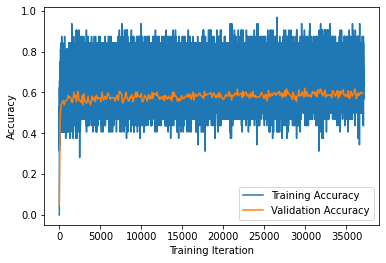

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = list(doc.sents)
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            sentence = str(sentence)
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{hash_key(split_key)}-finetuned-{hash_key(finetuning_model_key)}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{hash_key(main_data_key)}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.195 Validation Loss: 2.190 Accuracy: 0.055 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.194 Validation Loss: 2.190 Accuracy: 0.066 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.192 Validation Loss: 2.190 Accuracy: 0.076 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.189 Validation Loss: 2.190 Accuracy: 0.088 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.187 Validation Loss: 2.190 Accuracy: 0.086 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.185 Validation Loss: 2.190 Accuracy: 0.104 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.183 Validation Loss: 2.190 Accuracy: 0.122 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.181 Validation Loss: 2.190 Accuracy: 0.128 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.179 Validation Loss: 2.190 Accuracy: 0.137 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.177 Validation Loss: 2.190 Accuracy: 0.155 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.176 Validation Loss: 2.190 Accuracy: 0.177 Validation Accuracy: 0.092:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.176 Validation Loss: 2.190 Accuracy: 0.177 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 11 Loss: 2.174 Validation Loss: 2.190 Accuracy: 0.197 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 12 Loss: 2.171 Validation Loss: 2.190 Accuracy: 0.227 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 13 Loss: 2.170 Validation Loss: 2.190 Accuracy: 0.240 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 14 Loss: 2.167 Validation Loss: 2.190 Accuracy: 0.265 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 15 Loss: 2.165 Validation Loss: 2.190 Accuracy: 0.283 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 16 Loss: 2.163 Validation Loss: 2.190 Accuracy: 0.297 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 17 Loss: 2.162 Validation Loss: 2.190 Accuracy: 0.320 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 18 Loss: 2.159 Validation Loss: 2.190 Accuracy: 0.341 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 19 Loss: 2.157 Validation Loss: 2.190 Accuracy: 0.351 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 20 Loss: 2.153 Validation Loss: 2.190 Accuracy: 0.372 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 21 Loss: 2.150 Validation Loss: 2.190 Accuracy: 0.377 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 22 Loss: 2.147 Validation Loss: 2.190 Accuracy: 0.384 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 23 Loss: 2.143 Validation Loss: 2.190 Accuracy: 0.404 Validation Accuracy: 0.092:   1%|          | 11/1563 [00:00<00:15, 102.94it/s]

Epoch: 0 Iteration: 23 Loss: 2.143 Validation Loss: 2.190 Accuracy: 0.404 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 24 Loss: 2.140 Validation Loss: 2.190 Accuracy: 0.409 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 25 Loss: 2.136 Validation Loss: 2.190 Accuracy: 0.425 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 26 Loss: 2.133 Validation Loss: 2.190 Accuracy: 0.436 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 27 Loss: 2.129 Validation Loss: 2.190 Accuracy: 0.446 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 28 Loss: 2.125 Validation Loss: 2.190 Accuracy: 0.455 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 29 Loss: 2.121 Validation Loss: 2.190 Accuracy: 0.469 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 30 Loss: 2.117 Validation Loss: 2.190 Accuracy: 0.470 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 31 Loss: 2.114 Validation Loss: 2.190 Accuracy: 0.494 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 32 Loss: 2.110 Validation Loss: 2.190 Accuracy: 0.505 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 33 Loss: 2.106 Validation Loss: 2.190 Accuracy: 0.512 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 34 Loss: 2.103 Validation Loss: 2.190 Accuracy: 0.533 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 35 Loss: 2.098 Validation Loss: 2.190 Accuracy: 0.545 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 36 Loss: 2.094 Validation Loss: 2.190 Accuracy: 0.552 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 37 Loss: 2.089 Validation Loss: 2.190 Accuracy: 0.557 Validation Accuracy: 0.092:   2%|▏         | 24/1563 [00:00<00:13, 117.40it/s]

Epoch: 0 Iteration: 37 Loss: 2.089 Validation Loss: 2.190 Accuracy: 0.557 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 38 Loss: 2.085 Validation Loss: 2.190 Accuracy: 0.569 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 39 Loss: 2.080 Validation Loss: 2.190 Accuracy: 0.574 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 40 Loss: 2.076 Validation Loss: 2.190 Accuracy: 0.588 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 41 Loss: 2.071 Validation Loss: 2.190 Accuracy: 0.592 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 42 Loss: 2.064 Validation Loss: 2.190 Accuracy: 0.597 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 43 Loss: 2.059 Validation Loss: 2.190 Accuracy: 0.601 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 44 Loss: 2.055 Validation Loss: 2.190 Accuracy: 0.609 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 45 Loss: 2.049 Validation Loss: 2.190 Accuracy: 0.602 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 46 Loss: 2.045 Validation Loss: 2.190 Accuracy: 0.609 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 47 Loss: 2.038 Validation Loss: 2.190 Accuracy: 0.618 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 48 Loss: 2.030 Validation Loss: 2.190 Accuracy: 0.624 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 49 Loss: 2.025 Validation Loss: 2.190 Accuracy: 0.623 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 50 Loss: 2.022 Validation Loss: 2.190 Accuracy: 0.621 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 51 Loss: 2.014 Validation Loss: 2.190 Accuracy: 0.624 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 52 Loss: 2.012 Validation Loss: 2.190 Accuracy: 0.618 Validation Accuracy: 0.092:   2%|▏         | 38/1563 [00:00<00:12, 126.24it/s]

Epoch: 0 Iteration: 52 Loss: 2.012 Validation Loss: 2.190 Accuracy: 0.618 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 53 Loss: 2.005 Validation Loss: 2.190 Accuracy: 0.621 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 54 Loss: 1.999 Validation Loss: 2.190 Accuracy: 0.615 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 55 Loss: 1.996 Validation Loss: 2.190 Accuracy: 0.612 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 56 Loss: 1.989 Validation Loss: 2.190 Accuracy: 0.606 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 57 Loss: 1.985 Validation Loss: 2.190 Accuracy: 0.598 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 58 Loss: 1.979 Validation Loss: 2.190 Accuracy: 0.588 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 59 Loss: 1.975 Validation Loss: 2.190 Accuracy: 0.583 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 60 Loss: 1.968 Validation Loss: 2.190 Accuracy: 0.584 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 61 Loss: 1.961 Validation Loss: 2.190 Accuracy: 0.577 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 62 Loss: 1.957 Validation Loss: 2.190 Accuracy: 0.575 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 63 Loss: 1.952 Validation Loss: 2.190 Accuracy: 0.568 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 64 Loss: 1.941 Validation Loss: 2.190 Accuracy: 0.563 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 65 Loss: 1.934 Validation Loss: 2.190 Accuracy: 0.564 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 66 Loss: 1.929 Validation Loss: 2.190 Accuracy: 0.561 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 67 Loss: 1.922 Validation Loss: 2.190 Accuracy: 0.562 Validation Accuracy: 0.092:   3%|▎         | 53/1563 [00:00<00:11, 132.78it/s]

Epoch: 0 Iteration: 67 Loss: 1.922 Validation Loss: 2.190 Accuracy: 0.562 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 68 Loss: 1.917 Validation Loss: 2.190 Accuracy: 0.566 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 69 Loss: 1.910 Validation Loss: 2.190 Accuracy: 0.567 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 70 Loss: 1.900 Validation Loss: 2.190 Accuracy: 0.563 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 71 Loss: 1.895 Validation Loss: 2.190 Accuracy: 0.557 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 72 Loss: 1.883 Validation Loss: 2.190 Accuracy: 0.562 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 73 Loss: 1.878 Validation Loss: 2.190 Accuracy: 0.565 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 74 Loss: 1.871 Validation Loss: 2.190 Accuracy: 0.573 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 75 Loss: 1.860 Validation Loss: 2.190 Accuracy: 0.580 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 76 Loss: 1.854 Validation Loss: 2.190 Accuracy: 0.580 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 77 Loss: 1.845 Validation Loss: 2.190 Accuracy: 0.577 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 78 Loss: 1.839 Validation Loss: 2.190 Accuracy: 0.566 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 79 Loss: 1.826 Validation Loss: 2.190 Accuracy: 0.570 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 80 Loss: 1.818 Validation Loss: 2.190 Accuracy: 0.567 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 81 Loss: 1.807 Validation Loss: 2.190 Accuracy: 0.570 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 82 Loss: 1.795 Validation Loss: 2.190 Accuracy: 0.566 Validation Accuracy: 0.092:   4%|▍         | 68/1563 [00:00<00:10, 136.41it/s]

Epoch: 0 Iteration: 82 Loss: 1.795 Validation Loss: 2.190 Accuracy: 0.566 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 83 Loss: 1.781 Validation Loss: 2.190 Accuracy: 0.568 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 84 Loss: 1.770 Validation Loss: 2.190 Accuracy: 0.560 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 85 Loss: 1.759 Validation Loss: 2.190 Accuracy: 0.552 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 86 Loss: 1.744 Validation Loss: 2.190 Accuracy: 0.555 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 87 Loss: 1.734 Validation Loss: 2.190 Accuracy: 0.556 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 88 Loss: 1.721 Validation Loss: 2.190 Accuracy: 0.562 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 89 Loss: 1.712 Validation Loss: 2.190 Accuracy: 0.551 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 90 Loss: 1.699 Validation Loss: 2.190 Accuracy: 0.552 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 91 Loss: 1.684 Validation Loss: 2.190 Accuracy: 0.554 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 92 Loss: 1.671 Validation Loss: 2.190 Accuracy: 0.555 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 93 Loss: 1.658 Validation Loss: 2.190 Accuracy: 0.555 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 94 Loss: 1.643 Validation Loss: 2.190 Accuracy: 0.556 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 95 Loss: 1.630 Validation Loss: 2.190 Accuracy: 0.557 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 96 Loss: 1.614 Validation Loss: 2.190 Accuracy: 0.559 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 97 Loss: 1.601 Validation Loss: 2.190 Accuracy: 0.559 Validation Accuracy: 0.092:   5%|▌         | 83/1563 [00:00<00:10, 138.23it/s]

Epoch: 0 Iteration: 97 Loss: 1.601 Validation Loss: 2.190 Accuracy: 0.559 Validation Accuracy: 0.092:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 98 Loss: 1.593 Validation Loss: 2.190 Accuracy: 0.558 Validation Accuracy: 0.092:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 99 Loss: 1.588 Validation Loss: 2.190 Accuracy: 0.562 Validation Accuracy: 0.092:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 100 Loss: 1.576 Validation Loss: 1.500 Accuracy: 0.563 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 101 Loss: 1.568 Validation Loss: 1.500 Accuracy: 0.562 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 102 Loss: 1.557 Validation Loss: 1.500 Accuracy: 0.562 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 103 Loss: 1.551 Validation Loss: 1.500 Accuracy: 0.562 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 104 Loss: 1.539 Validation Loss: 1.500 Accuracy: 0.566 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 105 Loss: 1.538 Validation Loss: 1.500 Accuracy: 0.557 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 106 Loss: 1.532 Validation Loss: 1.500 Accuracy: 0.559 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 107 Loss: 1.514 Validation Loss: 1.500 Accuracy: 0.570 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 108 Loss: 1.512 Validation Loss: 1.500 Accuracy: 0.574 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 109 Loss: 1.491 Validation Loss: 1.500 Accuracy: 0.580 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 110 Loss: 1.479 Validation Loss: 1.500 Accuracy: 0.588 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 111 Loss: 1.477 Validation Loss: 1.500 Accuracy: 0.584 Validation Accuracy: 0.317:   6%|▋         | 98/1563 [00:00<00:10, 139.41it/s]

Epoch: 0 Iteration: 111 Loss: 1.477 Validation Loss: 1.500 Accuracy: 0.584 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 112 Loss: 1.463 Validation Loss: 1.500 Accuracy: 0.590 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 113 Loss: 1.458 Validation Loss: 1.500 Accuracy: 0.591 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 114 Loss: 1.445 Validation Loss: 1.500 Accuracy: 0.597 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 115 Loss: 1.433 Validation Loss: 1.500 Accuracy: 0.616 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 116 Loss: 1.418 Validation Loss: 1.500 Accuracy: 0.623 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 117 Loss: 1.410 Validation Loss: 1.500 Accuracy: 0.613 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 118 Loss: 1.398 Validation Loss: 1.500 Accuracy: 0.613 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 119 Loss: 1.388 Validation Loss: 1.500 Accuracy: 0.611 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 120 Loss: 1.385 Validation Loss: 1.500 Accuracy: 0.601 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 121 Loss: 1.365 Validation Loss: 1.500 Accuracy: 0.618 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 122 Loss: 1.350 Validation Loss: 1.500 Accuracy: 0.622 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 123 Loss: 1.327 Validation Loss: 1.500 Accuracy: 0.637 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 124 Loss: 1.318 Validation Loss: 1.500 Accuracy: 0.633 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 125 Loss: 1.287 Validation Loss: 1.500 Accuracy: 0.636 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 126 Loss: 1.269 Validation Loss: 1.500 Accuracy: 0.634 Validation Accuracy: 0.317:   7%|▋         | 112/1563 [00:00<00:10, 134.79it/s]

Epoch: 0 Iteration: 126 Loss: 1.269 Validation Loss: 1.500 Accuracy: 0.634 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:00<00:10, 137.04it/s]

Epoch: 0 Iteration: 127 Loss: 1.263 Validation Loss: 1.500 Accuracy: 0.640 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:00<00:10, 137.04it/s]

Epoch: 0 Iteration: 128 Loss: 1.245 Validation Loss: 1.500 Accuracy: 0.651 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:00<00:10, 137.04it/s]

Epoch: 0 Iteration: 129 Loss: 1.240 Validation Loss: 1.500 Accuracy: 0.664 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:00<00:10, 137.04it/s]

Epoch: 0 Iteration: 130 Loss: 1.231 Validation Loss: 1.500 Accuracy: 0.677 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:00<00:10, 137.04it/s]

Epoch: 0 Iteration: 131 Loss: 1.209 Validation Loss: 1.500 Accuracy: 0.676 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:00<00:10, 137.04it/s]

Epoch: 0 Iteration: 132 Loss: 1.201 Validation Loss: 1.500 Accuracy: 0.672 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:00<00:10, 137.04it/s]

Epoch: 0 Iteration: 133 Loss: 1.181 Validation Loss: 1.500 Accuracy: 0.670 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:00<00:10, 137.04it/s]

Epoch: 0 Iteration: 134 Loss: 1.172 Validation Loss: 1.500 Accuracy: 0.674 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:01<00:10, 137.04it/s]

Epoch: 0 Iteration: 135 Loss: 1.163 Validation Loss: 1.500 Accuracy: 0.670 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:01<00:10, 137.04it/s]

Epoch: 0 Iteration: 136 Loss: 1.166 Validation Loss: 1.500 Accuracy: 0.663 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:01<00:10, 137.04it/s]

Epoch: 0 Iteration: 137 Loss: 1.154 Validation Loss: 1.500 Accuracy: 0.666 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:01<00:10, 137.04it/s]

Epoch: 0 Iteration: 138 Loss: 1.140 Validation Loss: 1.500 Accuracy: 0.664 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:01<00:10, 137.04it/s]

Epoch: 0 Iteration: 139 Loss: 1.119 Validation Loss: 1.500 Accuracy: 0.662 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:01<00:10, 137.04it/s]

Epoch: 0 Iteration: 140 Loss: 1.110 Validation Loss: 1.500 Accuracy: 0.655 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:01<00:10, 137.04it/s]

Epoch: 0 Iteration: 141 Loss: 1.110 Validation Loss: 1.500 Accuracy: 0.652 Validation Accuracy: 0.317:   8%|▊         | 127/1563 [00:01<00:10, 137.04it/s]

Epoch: 0 Iteration: 141 Loss: 1.110 Validation Loss: 1.500 Accuracy: 0.652 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 142 Loss: 1.109 Validation Loss: 1.500 Accuracy: 0.656 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 143 Loss: 1.103 Validation Loss: 1.500 Accuracy: 0.660 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 144 Loss: 1.100 Validation Loss: 1.500 Accuracy: 0.655 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 145 Loss: 1.100 Validation Loss: 1.500 Accuracy: 0.657 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 146 Loss: 1.092 Validation Loss: 1.500 Accuracy: 0.666 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 147 Loss: 1.094 Validation Loss: 1.500 Accuracy: 0.660 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 148 Loss: 1.085 Validation Loss: 1.500 Accuracy: 0.664 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 149 Loss: 1.069 Validation Loss: 1.500 Accuracy: 0.673 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 150 Loss: 1.064 Validation Loss: 1.500 Accuracy: 0.682 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 151 Loss: 1.057 Validation Loss: 1.500 Accuracy: 0.691 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 152 Loss: 1.049 Validation Loss: 1.500 Accuracy: 0.691 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 153 Loss: 1.044 Validation Loss: 1.500 Accuracy: 0.691 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 154 Loss: 1.038 Validation Loss: 1.500 Accuracy: 0.697 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 155 Loss: 1.032 Validation Loss: 1.500 Accuracy: 0.702 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 156 Loss: 1.018 Validation Loss: 1.500 Accuracy: 0.703 Validation Accuracy: 0.317:   9%|▉         | 142/1563 [00:01<00:10, 138.58it/s]

Epoch: 0 Iteration: 156 Loss: 1.018 Validation Loss: 1.500 Accuracy: 0.703 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 157 Loss: 1.009 Validation Loss: 1.500 Accuracy: 0.716 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 158 Loss: 1.010 Validation Loss: 1.500 Accuracy: 0.710 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 159 Loss: 1.007 Validation Loss: 1.500 Accuracy: 0.706 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 160 Loss: 0.990 Validation Loss: 1.500 Accuracy: 0.710 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 161 Loss: 0.981 Validation Loss: 1.500 Accuracy: 0.709 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 162 Loss: 0.982 Validation Loss: 1.500 Accuracy: 0.705 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 163 Loss: 0.981 Validation Loss: 1.500 Accuracy: 0.707 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 164 Loss: 0.970 Validation Loss: 1.500 Accuracy: 0.714 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 165 Loss: 0.971 Validation Loss: 1.500 Accuracy: 0.709 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 166 Loss: 0.960 Validation Loss: 1.500 Accuracy: 0.714 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 167 Loss: 0.949 Validation Loss: 1.500 Accuracy: 0.713 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 168 Loss: 0.938 Validation Loss: 1.500 Accuracy: 0.723 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 169 Loss: 0.943 Validation Loss: 1.500 Accuracy: 0.720 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 170 Loss: 0.933 Validation Loss: 1.500 Accuracy: 0.720 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 171 Loss: 0.933 Validation Loss: 1.500 Accuracy: 0.718 Validation Accuracy: 0.317:  10%|█         | 157/1563 [00:01<00:10, 139.59it/s]

Epoch: 0 Iteration: 171 Loss: 0.933 Validation Loss: 1.500 Accuracy: 0.718 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 172 Loss: 0.924 Validation Loss: 1.500 Accuracy: 0.730 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 173 Loss: 0.922 Validation Loss: 1.500 Accuracy: 0.726 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 174 Loss: 0.923 Validation Loss: 1.500 Accuracy: 0.719 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 175 Loss: 0.916 Validation Loss: 1.500 Accuracy: 0.723 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 176 Loss: 0.911 Validation Loss: 1.500 Accuracy: 0.722 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 177 Loss: 0.905 Validation Loss: 1.500 Accuracy: 0.723 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 178 Loss: 0.883 Validation Loss: 1.500 Accuracy: 0.731 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 179 Loss: 0.879 Validation Loss: 1.500 Accuracy: 0.734 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 180 Loss: 0.872 Validation Loss: 1.500 Accuracy: 0.739 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 181 Loss: 0.868 Validation Loss: 1.500 Accuracy: 0.742 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 182 Loss: 0.855 Validation Loss: 1.500 Accuracy: 0.739 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 183 Loss: 0.858 Validation Loss: 1.500 Accuracy: 0.734 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 184 Loss: 0.851 Validation Loss: 1.500 Accuracy: 0.741 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 185 Loss: 0.835 Validation Loss: 1.500 Accuracy: 0.750 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 186 Loss: 0.842 Validation Loss: 1.500 Accuracy: 0.747 Validation Accuracy: 0.317:  11%|█         | 172/1563 [00:01<00:09, 140.28it/s]

Epoch: 0 Iteration: 186 Loss: 0.842 Validation Loss: 1.500 Accuracy: 0.747 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 187 Loss: 0.838 Validation Loss: 1.500 Accuracy: 0.746 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 188 Loss: 0.843 Validation Loss: 1.500 Accuracy: 0.735 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 189 Loss: 0.846 Validation Loss: 1.500 Accuracy: 0.726 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 190 Loss: 0.851 Validation Loss: 1.500 Accuracy: 0.719 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 191 Loss: 0.843 Validation Loss: 1.500 Accuracy: 0.723 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 192 Loss: 0.848 Validation Loss: 1.500 Accuracy: 0.721 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 193 Loss: 0.850 Validation Loss: 1.500 Accuracy: 0.723 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 194 Loss: 0.848 Validation Loss: 1.500 Accuracy: 0.715 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 195 Loss: 0.850 Validation Loss: 1.500 Accuracy: 0.704 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 196 Loss: 0.851 Validation Loss: 1.500 Accuracy: 0.700 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 197 Loss: 0.854 Validation Loss: 1.500 Accuracy: 0.698 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 198 Loss: 0.860 Validation Loss: 1.500 Accuracy: 0.697 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 199 Loss: 0.858 Validation Loss: 1.500 Accuracy: 0.708 Validation Accuracy: 0.317:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 200 Loss: 0.860 Validation Loss: 0.866 Accuracy: 0.709 Validation Accuracy: 0.449:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 201 Loss: 0.854 Validation Loss: 0.866 Accuracy: 0.705 Validation Accuracy: 0.449:  12%|█▏        | 187/1563 [00:01<00:09, 140.76it/s]

Epoch: 0 Iteration: 201 Loss: 0.854 Validation Loss: 0.866 Accuracy: 0.705 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 202 Loss: 0.859 Validation Loss: 0.866 Accuracy: 0.699 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 203 Loss: 0.848 Validation Loss: 0.866 Accuracy: 0.705 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 204 Loss: 0.846 Validation Loss: 0.866 Accuracy: 0.716 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 205 Loss: 0.856 Validation Loss: 0.866 Accuracy: 0.714 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 206 Loss: 0.856 Validation Loss: 0.866 Accuracy: 0.713 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 207 Loss: 0.863 Validation Loss: 0.866 Accuracy: 0.705 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 208 Loss: 0.865 Validation Loss: 0.866 Accuracy: 0.700 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 209 Loss: 0.851 Validation Loss: 0.866 Accuracy: 0.698 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 210 Loss: 0.848 Validation Loss: 0.866 Accuracy: 0.693 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 211 Loss: 0.846 Validation Loss: 0.866 Accuracy: 0.692 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 212 Loss: 0.838 Validation Loss: 0.866 Accuracy: 0.705 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 213 Loss: 0.829 Validation Loss: 0.866 Accuracy: 0.705 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 214 Loss: 0.815 Validation Loss: 0.866 Accuracy: 0.705 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 215 Loss: 0.801 Validation Loss: 0.866 Accuracy: 0.718 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 216 Loss: 0.797 Validation Loss: 0.866 Accuracy: 0.726 Validation Accuracy: 0.449:  13%|█▎        | 202/1563 [00:01<00:10, 136.05it/s]

Epoch: 0 Iteration: 216 Loss: 0.797 Validation Loss: 0.866 Accuracy: 0.726 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 217 Loss: 0.793 Validation Loss: 0.866 Accuracy: 0.737 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 218 Loss: 0.794 Validation Loss: 0.866 Accuracy: 0.736 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 219 Loss: 0.794 Validation Loss: 0.866 Accuracy: 0.736 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 220 Loss: 0.789 Validation Loss: 0.866 Accuracy: 0.745 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 221 Loss: 0.794 Validation Loss: 0.866 Accuracy: 0.738 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 222 Loss: 0.780 Validation Loss: 0.866 Accuracy: 0.736 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 223 Loss: 0.779 Validation Loss: 0.866 Accuracy: 0.737 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 224 Loss: 0.779 Validation Loss: 0.866 Accuracy: 0.730 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 225 Loss: 0.770 Validation Loss: 0.866 Accuracy: 0.720 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 226 Loss: 0.759 Validation Loss: 0.866 Accuracy: 0.725 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 227 Loss: 0.755 Validation Loss: 0.866 Accuracy: 0.715 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 228 Loss: 0.748 Validation Loss: 0.866 Accuracy: 0.724 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 229 Loss: 0.747 Validation Loss: 0.866 Accuracy: 0.725 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 230 Loss: 0.739 Validation Loss: 0.866 Accuracy: 0.724 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 231 Loss: 0.740 Validation Loss: 0.866 Accuracy: 0.729 Validation Accuracy: 0.449:  14%|█▍        | 217/1563 [00:01<00:09, 137.73it/s]

Epoch: 0 Iteration: 231 Loss: 0.740 Validation Loss: 0.866 Accuracy: 0.729 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 232 Loss: 0.743 Validation Loss: 0.866 Accuracy: 0.722 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 233 Loss: 0.733 Validation Loss: 0.866 Accuracy: 0.731 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 234 Loss: 0.744 Validation Loss: 0.866 Accuracy: 0.720 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 235 Loss: 0.754 Validation Loss: 0.866 Accuracy: 0.721 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 236 Loss: 0.752 Validation Loss: 0.866 Accuracy: 0.716 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 237 Loss: 0.746 Validation Loss: 0.866 Accuracy: 0.727 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 238 Loss: 0.742 Validation Loss: 0.866 Accuracy: 0.727 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 239 Loss: 0.740 Validation Loss: 0.866 Accuracy: 0.726 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 240 Loss: 0.744 Validation Loss: 0.866 Accuracy: 0.723 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 241 Loss: 0.744 Validation Loss: 0.866 Accuracy: 0.719 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 242 Loss: 0.745 Validation Loss: 0.866 Accuracy: 0.721 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 243 Loss: 0.747 Validation Loss: 0.866 Accuracy: 0.709 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 244 Loss: 0.745 Validation Loss: 0.866 Accuracy: 0.720 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 245 Loss: 0.744 Validation Loss: 0.866 Accuracy: 0.727 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 246 Loss: 0.738 Validation Loss: 0.866 Accuracy: 0.736 Validation Accuracy: 0.449:  15%|█▍        | 232/1563 [00:01<00:09, 139.01it/s]

Epoch: 0 Iteration: 246 Loss: 0.738 Validation Loss: 0.866 Accuracy: 0.736 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 247 Loss: 0.729 Validation Loss: 0.866 Accuracy: 0.734 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 248 Loss: 0.727 Validation Loss: 0.866 Accuracy: 0.738 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 249 Loss: 0.723 Validation Loss: 0.866 Accuracy: 0.739 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 250 Loss: 0.728 Validation Loss: 0.866 Accuracy: 0.738 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 251 Loss: 0.720 Validation Loss: 0.866 Accuracy: 0.750 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 252 Loss: 0.716 Validation Loss: 0.866 Accuracy: 0.750 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 253 Loss: 0.719 Validation Loss: 0.866 Accuracy: 0.754 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 254 Loss: 0.716 Validation Loss: 0.866 Accuracy: 0.752 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 255 Loss: 0.717 Validation Loss: 0.866 Accuracy: 0.744 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 256 Loss: 0.712 Validation Loss: 0.866 Accuracy: 0.741 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 257 Loss: 0.712 Validation Loss: 0.866 Accuracy: 0.741 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 258 Loss: 0.714 Validation Loss: 0.866 Accuracy: 0.732 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 259 Loss: 0.712 Validation Loss: 0.866 Accuracy: 0.730 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 260 Loss: 0.704 Validation Loss: 0.866 Accuracy: 0.737 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 261 Loss: 0.697 Validation Loss: 0.866 Accuracy: 0.729 Validation Accuracy: 0.449:  16%|█▌        | 247/1563 [00:01<00:09, 139.81it/s]

Epoch: 0 Iteration: 261 Loss: 0.697 Validation Loss: 0.866 Accuracy: 0.729 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 262 Loss: 0.696 Validation Loss: 0.866 Accuracy: 0.730 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 263 Loss: 0.693 Validation Loss: 0.866 Accuracy: 0.729 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 264 Loss: 0.693 Validation Loss: 0.866 Accuracy: 0.733 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 265 Loss: 0.693 Validation Loss: 0.866 Accuracy: 0.736 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 266 Loss: 0.699 Validation Loss: 0.866 Accuracy: 0.724 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 267 Loss: 0.690 Validation Loss: 0.866 Accuracy: 0.733 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 268 Loss: 0.694 Validation Loss: 0.866 Accuracy: 0.734 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 269 Loss: 0.696 Validation Loss: 0.866 Accuracy: 0.734 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 270 Loss: 0.691 Validation Loss: 0.866 Accuracy: 0.730 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 271 Loss: 0.693 Validation Loss: 0.866 Accuracy: 0.736 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 272 Loss: 0.695 Validation Loss: 0.866 Accuracy: 0.735 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 273 Loss: 0.690 Validation Loss: 0.866 Accuracy: 0.741 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:01<00:09, 140.51it/s]

Epoch: 0 Iteration: 274 Loss: 0.688 Validation Loss: 0.866 Accuracy: 0.735 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:02<00:09, 140.51it/s]

Epoch: 0 Iteration: 275 Loss: 0.673 Validation Loss: 0.866 Accuracy: 0.741 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:02<00:09, 140.51it/s]

Epoch: 0 Iteration: 276 Loss: 0.674 Validation Loss: 0.866 Accuracy: 0.750 Validation Accuracy: 0.449:  17%|█▋        | 262/1563 [00:02<00:09, 140.51it/s]

Epoch: 0 Iteration: 276 Loss: 0.674 Validation Loss: 0.866 Accuracy: 0.750 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 277 Loss: 0.676 Validation Loss: 0.866 Accuracy: 0.741 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 278 Loss: 0.663 Validation Loss: 0.866 Accuracy: 0.752 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 279 Loss: 0.663 Validation Loss: 0.866 Accuracy: 0.753 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 280 Loss: 0.665 Validation Loss: 0.866 Accuracy: 0.750 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 281 Loss: 0.661 Validation Loss: 0.866 Accuracy: 0.751 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 282 Loss: 0.657 Validation Loss: 0.866 Accuracy: 0.755 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 283 Loss: 0.650 Validation Loss: 0.866 Accuracy: 0.757 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 284 Loss: 0.654 Validation Loss: 0.866 Accuracy: 0.759 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 285 Loss: 0.651 Validation Loss: 0.866 Accuracy: 0.755 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 286 Loss: 0.644 Validation Loss: 0.866 Accuracy: 0.757 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 287 Loss: 0.652 Validation Loss: 0.866 Accuracy: 0.758 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 288 Loss: 0.649 Validation Loss: 0.866 Accuracy: 0.751 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 289 Loss: 0.645 Validation Loss: 0.866 Accuracy: 0.752 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 290 Loss: 0.638 Validation Loss: 0.866 Accuracy: 0.760 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 291 Loss: 0.640 Validation Loss: 0.866 Accuracy: 0.755 Validation Accuracy: 0.449:  18%|█▊        | 277/1563 [00:02<00:09, 140.53it/s]

Epoch: 0 Iteration: 291 Loss: 0.640 Validation Loss: 0.866 Accuracy: 0.755 Validation Accuracy: 0.449:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 292 Loss: 0.634 Validation Loss: 0.866 Accuracy: 0.754 Validation Accuracy: 0.449:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 293 Loss: 0.638 Validation Loss: 0.866 Accuracy: 0.745 Validation Accuracy: 0.449:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 294 Loss: 0.634 Validation Loss: 0.866 Accuracy: 0.750 Validation Accuracy: 0.449:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 295 Loss: 0.640 Validation Loss: 0.866 Accuracy: 0.753 Validation Accuracy: 0.449:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 296 Loss: 0.642 Validation Loss: 0.866 Accuracy: 0.748 Validation Accuracy: 0.449:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 297 Loss: 0.639 Validation Loss: 0.866 Accuracy: 0.751 Validation Accuracy: 0.449:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 298 Loss: 0.646 Validation Loss: 0.866 Accuracy: 0.752 Validation Accuracy: 0.449:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 299 Loss: 0.643 Validation Loss: 0.866 Accuracy: 0.751 Validation Accuracy: 0.449:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 300 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.521:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 301 Loss: 0.641 Validation Loss: 0.712 Accuracy: 0.753 Validation Accuracy: 0.521:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 302 Loss: 0.636 Validation Loss: 0.712 Accuracy: 0.756 Validation Accuracy: 0.521:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 303 Loss: 0.639 Validation Loss: 0.712 Accuracy: 0.758 Validation Accuracy: 0.521:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 304 Loss: 0.636 Validation Loss: 0.712 Accuracy: 0.757 Validation Accuracy: 0.521:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 305 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.752 Validation Accuracy: 0.521:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 306 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.753 Validation Accuracy: 0.521:  19%|█▊        | 292/1563 [00:02<00:09, 141.08it/s]

Epoch: 0 Iteration: 306 Loss: 0.648 Validation Loss: 0.712 Accuracy: 0.753 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 307 Loss: 0.642 Validation Loss: 0.712 Accuracy: 0.755 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 308 Loss: 0.645 Validation Loss: 0.712 Accuracy: 0.748 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 309 Loss: 0.644 Validation Loss: 0.712 Accuracy: 0.750 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 310 Loss: 0.652 Validation Loss: 0.712 Accuracy: 0.751 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 311 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 312 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 313 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 314 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 315 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 316 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 317 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 318 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 319 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 320 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.521:  20%|█▉        | 307/1563 [00:02<00:09, 136.34it/s]

Epoch: 0 Iteration: 320 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 321 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 322 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 323 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 324 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 325 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 326 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 327 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 328 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 329 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 330 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 331 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 332 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 333 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.748 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 334 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.750 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 335 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.521:  21%|██        | 321/1563 [00:02<00:09, 136.87it/s]

Epoch: 0 Iteration: 335 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 336 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.753 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 337 Loss: 0.649 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 338 Loss: 0.643 Validation Loss: 0.712 Accuracy: 0.770 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 339 Loss: 0.640 Validation Loss: 0.712 Accuracy: 0.772 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 340 Loss: 0.635 Validation Loss: 0.712 Accuracy: 0.771 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 341 Loss: 0.626 Validation Loss: 0.712 Accuracy: 0.776 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 342 Loss: 0.619 Validation Loss: 0.712 Accuracy: 0.772 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 343 Loss: 0.607 Validation Loss: 0.712 Accuracy: 0.780 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 344 Loss: 0.611 Validation Loss: 0.712 Accuracy: 0.774 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 345 Loss: 0.604 Validation Loss: 0.712 Accuracy: 0.773 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 346 Loss: 0.607 Validation Loss: 0.712 Accuracy: 0.770 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 347 Loss: 0.612 Validation Loss: 0.712 Accuracy: 0.763 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 348 Loss: 0.609 Validation Loss: 0.712 Accuracy: 0.762 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 349 Loss: 0.606 Validation Loss: 0.712 Accuracy: 0.766 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 350 Loss: 0.607 Validation Loss: 0.712 Accuracy: 0.758 Validation Accuracy: 0.521:  21%|██▏       | 336/1563 [00:02<00:08, 137.99it/s]

Epoch: 0 Iteration: 350 Loss: 0.607 Validation Loss: 0.712 Accuracy: 0.758 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 351 Loss: 0.600 Validation Loss: 0.712 Accuracy: 0.756 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 352 Loss: 0.601 Validation Loss: 0.712 Accuracy: 0.762 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 353 Loss: 0.598 Validation Loss: 0.712 Accuracy: 0.760 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 354 Loss: 0.607 Validation Loss: 0.712 Accuracy: 0.758 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 355 Loss: 0.615 Validation Loss: 0.712 Accuracy: 0.751 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 356 Loss: 0.614 Validation Loss: 0.712 Accuracy: 0.755 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 357 Loss: 0.621 Validation Loss: 0.712 Accuracy: 0.755 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 358 Loss: 0.627 Validation Loss: 0.712 Accuracy: 0.750 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 359 Loss: 0.628 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 360 Loss: 0.630 Validation Loss: 0.712 Accuracy: 0.756 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 361 Loss: 0.627 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 362 Loss: 0.631 Validation Loss: 0.712 Accuracy: 0.752 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 363 Loss: 0.633 Validation Loss: 0.712 Accuracy: 0.754 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 364 Loss: 0.631 Validation Loss: 0.712 Accuracy: 0.760 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 365 Loss: 0.628 Validation Loss: 0.712 Accuracy: 0.768 Validation Accuracy: 0.521:  22%|██▏       | 351/1563 [00:02<00:08, 139.14it/s]

Epoch: 0 Iteration: 365 Loss: 0.628 Validation Loss: 0.712 Accuracy: 0.768 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 366 Loss: 0.624 Validation Loss: 0.712 Accuracy: 0.762 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 367 Loss: 0.618 Validation Loss: 0.712 Accuracy: 0.770 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 368 Loss: 0.616 Validation Loss: 0.712 Accuracy: 0.773 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 369 Loss: 0.612 Validation Loss: 0.712 Accuracy: 0.777 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 370 Loss: 0.597 Validation Loss: 0.712 Accuracy: 0.784 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 371 Loss: 0.600 Validation Loss: 0.712 Accuracy: 0.780 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 372 Loss: 0.604 Validation Loss: 0.712 Accuracy: 0.782 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 373 Loss: 0.602 Validation Loss: 0.712 Accuracy: 0.780 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 374 Loss: 0.602 Validation Loss: 0.712 Accuracy: 0.769 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 375 Loss: 0.598 Validation Loss: 0.712 Accuracy: 0.762 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 376 Loss: 0.601 Validation Loss: 0.712 Accuracy: 0.764 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 377 Loss: 0.601 Validation Loss: 0.712 Accuracy: 0.756 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 378 Loss: 0.599 Validation Loss: 0.712 Accuracy: 0.755 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 379 Loss: 0.596 Validation Loss: 0.712 Accuracy: 0.752 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 380 Loss: 0.592 Validation Loss: 0.712 Accuracy: 0.749 Validation Accuracy: 0.521:  23%|██▎       | 366/1563 [00:02<00:08, 140.04it/s]

Epoch: 0 Iteration: 380 Loss: 0.592 Validation Loss: 0.712 Accuracy: 0.749 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 381 Loss: 0.596 Validation Loss: 0.712 Accuracy: 0.750 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 382 Loss: 0.589 Validation Loss: 0.712 Accuracy: 0.757 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 383 Loss: 0.592 Validation Loss: 0.712 Accuracy: 0.753 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 384 Loss: 0.593 Validation Loss: 0.712 Accuracy: 0.761 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 385 Loss: 0.591 Validation Loss: 0.712 Accuracy: 0.767 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 386 Loss: 0.593 Validation Loss: 0.712 Accuracy: 0.767 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 387 Loss: 0.591 Validation Loss: 0.712 Accuracy: 0.774 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 388 Loss: 0.587 Validation Loss: 0.712 Accuracy: 0.777 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 389 Loss: 0.595 Validation Loss: 0.712 Accuracy: 0.774 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 390 Loss: 0.604 Validation Loss: 0.712 Accuracy: 0.768 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 391 Loss: 0.603 Validation Loss: 0.712 Accuracy: 0.766 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 392 Loss: 0.599 Validation Loss: 0.712 Accuracy: 0.759 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 393 Loss: 0.607 Validation Loss: 0.712 Accuracy: 0.762 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 394 Loss: 0.604 Validation Loss: 0.712 Accuracy: 0.760 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 395 Loss: 0.610 Validation Loss: 0.712 Accuracy: 0.754 Validation Accuracy: 0.521:  24%|██▍       | 381/1563 [00:02<00:08, 140.66it/s]

Epoch: 0 Iteration: 395 Loss: 0.610 Validation Loss: 0.712 Accuracy: 0.754 Validation Accuracy: 0.521:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 396 Loss: 0.606 Validation Loss: 0.712 Accuracy: 0.761 Validation Accuracy: 0.521:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 397 Loss: 0.602 Validation Loss: 0.712 Accuracy: 0.752 Validation Accuracy: 0.521:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 398 Loss: 0.598 Validation Loss: 0.712 Accuracy: 0.753 Validation Accuracy: 0.521:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 399 Loss: 0.600 Validation Loss: 0.712 Accuracy: 0.754 Validation Accuracy: 0.521:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 400 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 401 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 402 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 403 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 404 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 405 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 406 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 407 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 408 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 409 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 410 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.566:  25%|██▌       | 396/1563 [00:02<00:08, 141.00it/s]

Epoch: 0 Iteration: 410 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:02<00:08, 136.30it/s]

Epoch: 0 Iteration: 411 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 412 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 413 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 414 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 415 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 416 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 417 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 418 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 419 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 420 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 421 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 422 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 423 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 424 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 425 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.566:  26%|██▋       | 411/1563 [00:03<00:08, 136.30it/s]

Epoch: 0 Iteration: 425 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 426 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 427 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 428 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 429 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 430 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 431 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 432 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 433 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 434 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 435 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 436 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 437 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 438 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 439 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 440 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.566:  27%|██▋       | 426/1563 [00:03<00:08, 137.80it/s]

Epoch: 0 Iteration: 440 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 441 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 442 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 443 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 444 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 445 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 446 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.792 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 447 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.790 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 448 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.788 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 449 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.788 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 450 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 451 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 452 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 453 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 454 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 455 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.566:  28%|██▊       | 441/1563 [00:03<00:08, 138.86it/s]

Epoch: 0 Iteration: 455 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 456 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 457 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 458 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.784 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 459 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 460 Loss: 0.539 Validation Loss: 0.640 Accuracy: 0.789 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 461 Loss: 0.539 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 462 Loss: 0.544 Validation Loss: 0.640 Accuracy: 0.786 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 463 Loss: 0.540 Validation Loss: 0.640 Accuracy: 0.792 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 464 Loss: 0.542 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 465 Loss: 0.543 Validation Loss: 0.640 Accuracy: 0.790 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 466 Loss: 0.546 Validation Loss: 0.640 Accuracy: 0.792 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 467 Loss: 0.551 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 468 Loss: 0.547 Validation Loss: 0.640 Accuracy: 0.795 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 469 Loss: 0.552 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 470 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.566:  29%|██▉       | 456/1563 [00:03<00:07, 139.79it/s]

Epoch: 0 Iteration: 470 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 471 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.785 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 472 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 473 Loss: 0.554 Validation Loss: 0.640 Accuracy: 0.790 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 474 Loss: 0.550 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 475 Loss: 0.549 Validation Loss: 0.640 Accuracy: 0.793 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 476 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 477 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.783 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 478 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.782 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 479 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 480 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 481 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 482 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 483 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 484 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 485 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.566:  30%|███       | 471/1563 [00:03<00:07, 140.26it/s]

Epoch: 0 Iteration: 485 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 486 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 487 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 488 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 489 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 490 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 491 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 492 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 493 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 494 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 495 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 496 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 497 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 498 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 499 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.566:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 500 Loss: 0.573 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.599:  31%|███       | 486/1563 [00:03<00:07, 140.70it/s]

Epoch: 0 Iteration: 500 Loss: 0.573 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 501 Loss: 0.566 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 502 Loss: 0.571 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 503 Loss: 0.572 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 504 Loss: 0.577 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 505 Loss: 0.574 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 506 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 507 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 508 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.776 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 509 Loss: 0.583 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 510 Loss: 0.583 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 511 Loss: 0.574 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 512 Loss: 0.580 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 513 Loss: 0.587 Validation Loss: 0.600 Accuracy: 0.767 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 514 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.770 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 515 Loss: 0.578 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.599:  32%|███▏      | 501/1563 [00:03<00:07, 135.26it/s]

Epoch: 0 Iteration: 515 Loss: 0.578 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 516 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 517 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.772 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 518 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 519 Loss: 0.577 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 520 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 521 Loss: 0.579 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 522 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.776 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 523 Loss: 0.586 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 524 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 525 Loss: 0.592 Validation Loss: 0.600 Accuracy: 0.768 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 526 Loss: 0.590 Validation Loss: 0.600 Accuracy: 0.762 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 527 Loss: 0.589 Validation Loss: 0.600 Accuracy: 0.762 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 528 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.751 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 529 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.758 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 530 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.757 Validation Accuracy: 0.599:  33%|███▎      | 516/1563 [00:03<00:07, 137.86it/s]

Epoch: 0 Iteration: 530 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.757 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 531 Loss: 0.590 Validation Loss: 0.600 Accuracy: 0.750 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 532 Loss: 0.592 Validation Loss: 0.600 Accuracy: 0.754 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 533 Loss: 0.587 Validation Loss: 0.600 Accuracy: 0.758 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 534 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.760 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 535 Loss: 0.585 Validation Loss: 0.600 Accuracy: 0.767 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 536 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 537 Loss: 0.582 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 538 Loss: 0.584 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 539 Loss: 0.581 Validation Loss: 0.600 Accuracy: 0.774 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 540 Loss: 0.577 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 541 Loss: 0.576 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 542 Loss: 0.569 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 543 Loss: 0.566 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 544 Loss: 0.563 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 545 Loss: 0.555 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.599:  34%|███▍      | 531/1563 [00:03<00:07, 139.03it/s]

Epoch: 0 Iteration: 545 Loss: 0.555 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:03<00:07, 139.78it/s]

Epoch: 0 Iteration: 546 Loss: 0.554 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:03<00:07, 139.78it/s]

Epoch: 0 Iteration: 547 Loss: 0.552 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:03<00:07, 139.78it/s]

Epoch: 0 Iteration: 548 Loss: 0.554 Validation Loss: 0.600 Accuracy: 0.772 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:03<00:07, 139.78it/s]

Epoch: 0 Iteration: 549 Loss: 0.564 Validation Loss: 0.600 Accuracy: 0.762 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:03<00:07, 139.78it/s]

Epoch: 0 Iteration: 550 Loss: 0.554 Validation Loss: 0.600 Accuracy: 0.764 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:03<00:07, 139.78it/s]

Epoch: 0 Iteration: 551 Loss: 0.552 Validation Loss: 0.600 Accuracy: 0.762 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:04<00:07, 139.78it/s]

Epoch: 0 Iteration: 552 Loss: 0.550 Validation Loss: 0.600 Accuracy: 0.751 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:04<00:07, 139.78it/s]

Epoch: 0 Iteration: 553 Loss: 0.553 Validation Loss: 0.600 Accuracy: 0.751 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:04<00:07, 139.78it/s]

Epoch: 0 Iteration: 554 Loss: 0.555 Validation Loss: 0.600 Accuracy: 0.753 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:04<00:07, 139.78it/s]

Epoch: 0 Iteration: 555 Loss: 0.553 Validation Loss: 0.600 Accuracy: 0.753 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:04<00:07, 139.78it/s]

Epoch: 0 Iteration: 556 Loss: 0.554 Validation Loss: 0.600 Accuracy: 0.757 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:04<00:07, 139.78it/s]

Epoch: 0 Iteration: 557 Loss: 0.553 Validation Loss: 0.600 Accuracy: 0.760 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:04<00:07, 139.78it/s]

Epoch: 0 Iteration: 558 Loss: 0.549 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:04<00:07, 139.78it/s]

Epoch: 0 Iteration: 559 Loss: 0.553 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:04<00:07, 139.78it/s]

Epoch: 0 Iteration: 560 Loss: 0.551 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.599:  35%|███▍      | 546/1563 [00:04<00:07, 139.78it/s]

Epoch: 0 Iteration: 560 Loss: 0.551 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 561 Loss: 0.560 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 562 Loss: 0.561 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 563 Loss: 0.567 Validation Loss: 0.600 Accuracy: 0.773 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 564 Loss: 0.567 Validation Loss: 0.600 Accuracy: 0.770 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 565 Loss: 0.564 Validation Loss: 0.600 Accuracy: 0.775 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 566 Loss: 0.559 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 567 Loss: 0.558 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 568 Loss: 0.553 Validation Loss: 0.600 Accuracy: 0.772 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 569 Loss: 0.542 Validation Loss: 0.600 Accuracy: 0.781 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 570 Loss: 0.541 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 571 Loss: 0.537 Validation Loss: 0.600 Accuracy: 0.797 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 572 Loss: 0.529 Validation Loss: 0.600 Accuracy: 0.798 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 573 Loss: 0.533 Validation Loss: 0.600 Accuracy: 0.805 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 574 Loss: 0.534 Validation Loss: 0.600 Accuracy: 0.807 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 575 Loss: 0.539 Validation Loss: 0.600 Accuracy: 0.801 Validation Accuracy: 0.599:  36%|███▌      | 561/1563 [00:04<00:07, 140.44it/s]

Epoch: 0 Iteration: 575 Loss: 0.539 Validation Loss: 0.600 Accuracy: 0.801 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 576 Loss: 0.537 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 577 Loss: 0.536 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 578 Loss: 0.540 Validation Loss: 0.600 Accuracy: 0.790 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 579 Loss: 0.541 Validation Loss: 0.600 Accuracy: 0.784 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 580 Loss: 0.545 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 581 Loss: 0.535 Validation Loss: 0.600 Accuracy: 0.778 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 582 Loss: 0.535 Validation Loss: 0.600 Accuracy: 0.779 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 583 Loss: 0.527 Validation Loss: 0.600 Accuracy: 0.787 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 584 Loss: 0.526 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 585 Loss: 0.528 Validation Loss: 0.600 Accuracy: 0.795 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 586 Loss: 0.539 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 587 Loss: 0.543 Validation Loss: 0.600 Accuracy: 0.788 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 588 Loss: 0.541 Validation Loss: 0.600 Accuracy: 0.792 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 589 Loss: 0.553 Validation Loss: 0.600 Accuracy: 0.791 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 590 Loss: 0.562 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.599:  37%|███▋      | 576/1563 [00:04<00:07, 140.97it/s]

Epoch: 0 Iteration: 590 Loss: 0.562 Validation Loss: 0.600 Accuracy: 0.782 Validation Accuracy: 0.599:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 591 Loss: 0.568 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.599:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 592 Loss: 0.576 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.599:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 593 Loss: 0.574 Validation Loss: 0.600 Accuracy: 0.771 Validation Accuracy: 0.599:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 594 Loss: 0.572 Validation Loss: 0.600 Accuracy: 0.769 Validation Accuracy: 0.599:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 595 Loss: 0.569 Validation Loss: 0.600 Accuracy: 0.765 Validation Accuracy: 0.599:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 596 Loss: 0.567 Validation Loss: 0.600 Accuracy: 0.777 Validation Accuracy: 0.599:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 597 Loss: 0.566 Validation Loss: 0.600 Accuracy: 0.785 Validation Accuracy: 0.599:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 598 Loss: 0.568 Validation Loss: 0.600 Accuracy: 0.780 Validation Accuracy: 0.599:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 599 Loss: 0.566 Validation Loss: 0.600 Accuracy: 0.783 Validation Accuracy: 0.599:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 600 Loss: 0.564 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.623:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 601 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.623:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 602 Loss: 0.557 Validation Loss: 0.586 Accuracy: 0.799 Validation Accuracy: 0.623:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 603 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.804 Validation Accuracy: 0.623:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 604 Loss: 0.566 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.623:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 605 Loss: 0.565 Validation Loss: 0.586 Accuracy: 0.802 Validation Accuracy: 0.623:  38%|███▊      | 591/1563 [00:04<00:06, 141.32it/s]

Epoch: 0 Iteration: 605 Loss: 0.565 Validation Loss: 0.586 Accuracy: 0.802 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 606 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 607 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 608 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 609 Loss: 0.547 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 610 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.792 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 611 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 612 Loss: 0.545 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 613 Loss: 0.542 Validation Loss: 0.586 Accuracy: 0.776 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 614 Loss: 0.544 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 615 Loss: 0.540 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 616 Loss: 0.545 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 617 Loss: 0.548 Validation Loss: 0.586 Accuracy: 0.775 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 618 Loss: 0.548 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 619 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.771 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 620 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.763 Validation Accuracy: 0.623:  39%|███▉      | 606/1563 [00:04<00:07, 136.45it/s]

Epoch: 0 Iteration: 620 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.763 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 621 Loss: 0.559 Validation Loss: 0.586 Accuracy: 0.766 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 622 Loss: 0.566 Validation Loss: 0.586 Accuracy: 0.768 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 623 Loss: 0.574 Validation Loss: 0.586 Accuracy: 0.756 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 624 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.756 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 625 Loss: 0.572 Validation Loss: 0.586 Accuracy: 0.751 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 626 Loss: 0.571 Validation Loss: 0.586 Accuracy: 0.749 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 627 Loss: 0.572 Validation Loss: 0.586 Accuracy: 0.753 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 628 Loss: 0.565 Validation Loss: 0.586 Accuracy: 0.755 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 629 Loss: 0.578 Validation Loss: 0.586 Accuracy: 0.750 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 630 Loss: 0.579 Validation Loss: 0.586 Accuracy: 0.759 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 631 Loss: 0.577 Validation Loss: 0.586 Accuracy: 0.760 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 632 Loss: 0.575 Validation Loss: 0.586 Accuracy: 0.763 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 633 Loss: 0.576 Validation Loss: 0.586 Accuracy: 0.771 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 634 Loss: 0.578 Validation Loss: 0.586 Accuracy: 0.771 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 635 Loss: 0.583 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.623:  40%|███▉      | 621/1563 [00:04<00:06, 137.85it/s]

Epoch: 0 Iteration: 635 Loss: 0.583 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 636 Loss: 0.576 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 637 Loss: 0.577 Validation Loss: 0.586 Accuracy: 0.778 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 638 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 639 Loss: 0.579 Validation Loss: 0.586 Accuracy: 0.775 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 640 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.776 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 641 Loss: 0.573 Validation Loss: 0.586 Accuracy: 0.772 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 642 Loss: 0.569 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 643 Loss: 0.556 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 644 Loss: 0.559 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 645 Loss: 0.558 Validation Loss: 0.586 Accuracy: 0.781 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 646 Loss: 0.559 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 647 Loss: 0.565 Validation Loss: 0.586 Accuracy: 0.768 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 648 Loss: 0.568 Validation Loss: 0.586 Accuracy: 0.771 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 649 Loss: 0.570 Validation Loss: 0.586 Accuracy: 0.767 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 650 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.623:  41%|████      | 636/1563 [00:04<00:06, 139.05it/s]

Epoch: 0 Iteration: 650 Loss: 0.561 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 651 Loss: 0.557 Validation Loss: 0.586 Accuracy: 0.781 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 652 Loss: 0.555 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 653 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.779 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 654 Loss: 0.546 Validation Loss: 0.586 Accuracy: 0.783 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 655 Loss: 0.544 Validation Loss: 0.586 Accuracy: 0.782 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 656 Loss: 0.549 Validation Loss: 0.586 Accuracy: 0.785 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 657 Loss: 0.544 Validation Loss: 0.586 Accuracy: 0.797 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 658 Loss: 0.543 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 659 Loss: 0.530 Validation Loss: 0.586 Accuracy: 0.812 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 660 Loss: 0.530 Validation Loss: 0.586 Accuracy: 0.808 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 661 Loss: 0.526 Validation Loss: 0.586 Accuracy: 0.803 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 662 Loss: 0.528 Validation Loss: 0.586 Accuracy: 0.800 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 663 Loss: 0.540 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 664 Loss: 0.532 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 665 Loss: 0.534 Validation Loss: 0.586 Accuracy: 0.790 Validation Accuracy: 0.623:  42%|████▏     | 651/1563 [00:04<00:06, 139.60it/s]

Epoch: 0 Iteration: 665 Loss: 0.534 Validation Loss: 0.586 Accuracy: 0.790 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 666 Loss: 0.530 Validation Loss: 0.586 Accuracy: 0.787 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 667 Loss: 0.528 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 668 Loss: 0.535 Validation Loss: 0.586 Accuracy: 0.773 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 669 Loss: 0.531 Validation Loss: 0.586 Accuracy: 0.758 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 670 Loss: 0.536 Validation Loss: 0.586 Accuracy: 0.762 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 671 Loss: 0.540 Validation Loss: 0.586 Accuracy: 0.763 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 672 Loss: 0.542 Validation Loss: 0.586 Accuracy: 0.764 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 673 Loss: 0.539 Validation Loss: 0.586 Accuracy: 0.777 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 674 Loss: 0.548 Validation Loss: 0.586 Accuracy: 0.768 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 675 Loss: 0.545 Validation Loss: 0.586 Accuracy: 0.772 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 676 Loss: 0.545 Validation Loss: 0.586 Accuracy: 0.775 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 677 Loss: 0.551 Validation Loss: 0.586 Accuracy: 0.771 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 678 Loss: 0.553 Validation Loss: 0.586 Accuracy: 0.781 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 679 Loss: 0.558 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 680 Loss: 0.557 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.623:  43%|████▎     | 666/1563 [00:04<00:06, 140.44it/s]

Epoch: 0 Iteration: 680 Loss: 0.557 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 681 Loss: 0.557 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 682 Loss: 0.552 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 683 Loss: 0.538 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 684 Loss: 0.541 Validation Loss: 0.586 Accuracy: 0.800 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 685 Loss: 0.537 Validation Loss: 0.586 Accuracy: 0.802 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 686 Loss: 0.538 Validation Loss: 0.586 Accuracy: 0.798 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 687 Loss: 0.534 Validation Loss: 0.586 Accuracy: 0.801 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 688 Loss: 0.529 Validation Loss: 0.586 Accuracy: 0.799 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 689 Loss: 0.530 Validation Loss: 0.586 Accuracy: 0.793 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 690 Loss: 0.530 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:04<00:06, 141.02it/s]

Epoch: 0 Iteration: 691 Loss: 0.525 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:05<00:06, 141.02it/s]

Epoch: 0 Iteration: 692 Loss: 0.523 Validation Loss: 0.586 Accuracy: 0.796 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:05<00:06, 141.02it/s]

Epoch: 0 Iteration: 693 Loss: 0.528 Validation Loss: 0.586 Accuracy: 0.797 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:05<00:06, 141.02it/s]

Epoch: 0 Iteration: 694 Loss: 0.523 Validation Loss: 0.586 Accuracy: 0.791 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:05<00:06, 141.02it/s]

Epoch: 0 Iteration: 695 Loss: 0.527 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.623:  44%|████▎     | 681/1563 [00:05<00:06, 141.02it/s]

Epoch: 0 Iteration: 695 Loss: 0.527 Validation Loss: 0.586 Accuracy: 0.784 Validation Accuracy: 0.623:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 696 Loss: 0.527 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.623:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 697 Loss: 0.523 Validation Loss: 0.586 Accuracy: 0.789 Validation Accuracy: 0.623:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 698 Loss: 0.519 Validation Loss: 0.586 Accuracy: 0.795 Validation Accuracy: 0.623:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 699 Loss: 0.517 Validation Loss: 0.586 Accuracy: 0.800 Validation Accuracy: 0.623:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 700 Loss: 0.514 Validation Loss: 0.576 Accuracy: 0.804 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 701 Loss: 0.509 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 702 Loss: 0.517 Validation Loss: 0.576 Accuracy: 0.796 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 703 Loss: 0.515 Validation Loss: 0.576 Accuracy: 0.803 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 704 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 705 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.806 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 706 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 707 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.808 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 708 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 709 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 710 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.641:  45%|████▍     | 696/1563 [00:05<00:06, 141.39it/s]

Epoch: 0 Iteration: 710 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 711 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.776 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 712 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 713 Loss: 0.519 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 714 Loss: 0.518 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 715 Loss: 0.510 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 716 Loss: 0.511 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 717 Loss: 0.514 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 718 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 719 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.800 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 720 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 721 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 722 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 723 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 724 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 725 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.641:  45%|████▌     | 711/1563 [00:05<00:06, 136.62it/s]

Epoch: 0 Iteration: 725 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 726 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 727 Loss: 0.549 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 728 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 729 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.776 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 730 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.770 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 731 Loss: 0.547 Validation Loss: 0.576 Accuracy: 0.768 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 732 Loss: 0.552 Validation Loss: 0.576 Accuracy: 0.766 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 733 Loss: 0.561 Validation Loss: 0.576 Accuracy: 0.758 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 734 Loss: 0.564 Validation Loss: 0.576 Accuracy: 0.748 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 735 Loss: 0.573 Validation Loss: 0.576 Accuracy: 0.753 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 736 Loss: 0.574 Validation Loss: 0.576 Accuracy: 0.755 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 737 Loss: 0.575 Validation Loss: 0.576 Accuracy: 0.759 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 738 Loss: 0.577 Validation Loss: 0.576 Accuracy: 0.758 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 739 Loss: 0.576 Validation Loss: 0.576 Accuracy: 0.762 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 740 Loss: 0.579 Validation Loss: 0.576 Accuracy: 0.766 Validation Accuracy: 0.641:  46%|████▋     | 726/1563 [00:05<00:06, 138.29it/s]

Epoch: 0 Iteration: 740 Loss: 0.579 Validation Loss: 0.576 Accuracy: 0.766 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 741 Loss: 0.570 Validation Loss: 0.576 Accuracy: 0.775 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 742 Loss: 0.566 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 743 Loss: 0.554 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 744 Loss: 0.558 Validation Loss: 0.576 Accuracy: 0.804 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 745 Loss: 0.550 Validation Loss: 0.576 Accuracy: 0.807 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 746 Loss: 0.550 Validation Loss: 0.576 Accuracy: 0.805 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 747 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.802 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 748 Loss: 0.553 Validation Loss: 0.576 Accuracy: 0.796 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 749 Loss: 0.557 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 750 Loss: 0.561 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 751 Loss: 0.556 Validation Loss: 0.576 Accuracy: 0.772 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 752 Loss: 0.552 Validation Loss: 0.576 Accuracy: 0.767 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 753 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.766 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 754 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 755 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.765 Validation Accuracy: 0.641:  47%|████▋     | 741/1563 [00:05<00:05, 139.52it/s]

Epoch: 0 Iteration: 755 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.765 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 756 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.765 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 757 Loss: 0.530 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 758 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 759 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 760 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 761 Loss: 0.529 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 762 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 763 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 764 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 765 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 766 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 767 Loss: 0.542 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 768 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 769 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 770 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.641:  48%|████▊     | 756/1563 [00:05<00:05, 140.38it/s]

Epoch: 0 Iteration: 770 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 771 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 772 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 773 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 774 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 775 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 776 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 777 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 778 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.790 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 779 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 780 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 781 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 782 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 783 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 784 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 785 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.641:  49%|████▉     | 771/1563 [00:05<00:05, 140.93it/s]

Epoch: 0 Iteration: 785 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 786 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 787 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 788 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 789 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 790 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 791 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 792 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 793 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 794 Loss: 0.524 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 795 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 796 Loss: 0.512 Validation Loss: 0.576 Accuracy: 0.796 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 797 Loss: 0.506 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 798 Loss: 0.515 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 799 Loss: 0.507 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.641:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 800 Loss: 0.507 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.656:  50%|█████     | 786/1563 [00:05<00:05, 141.33it/s]

Epoch: 0 Iteration: 800 Loss: 0.507 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 801 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 802 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 803 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 804 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 805 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 806 Loss: 0.507 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 807 Loss: 0.507 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 808 Loss: 0.505 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 809 Loss: 0.504 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 810 Loss: 0.506 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 811 Loss: 0.506 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 812 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 813 Loss: 0.504 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 814 Loss: 0.504 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 815 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.656:  51%|█████     | 801/1563 [00:05<00:05, 135.95it/s]

Epoch: 0 Iteration: 815 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 816 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 817 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 818 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 819 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 820 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.781 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 821 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.774 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 822 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.772 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 823 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.767 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 824 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 825 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.771 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 826 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 827 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.772 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 828 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 829 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:05<00:05, 138.42it/s]

Epoch: 0 Iteration: 830 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.656:  52%|█████▏    | 816/1563 [00:06<00:05, 138.42it/s]

Epoch: 0 Iteration: 830 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 831 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 832 Loss: 0.542 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 833 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.782 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 834 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 835 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 836 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 837 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 838 Loss: 0.539 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 839 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 840 Loss: 0.535 Validation Loss: 0.572 Accuracy: 0.788 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 841 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 842 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 843 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 844 Loss: 0.529 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 845 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.656:  53%|█████▎    | 831/1563 [00:06<00:05, 139.36it/s]

Epoch: 0 Iteration: 845 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 846 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 847 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 848 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 849 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 850 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 851 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.792 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 852 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 853 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 854 Loss: 0.507 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 855 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 856 Loss: 0.512 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 857 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 858 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 859 Loss: 0.511 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 860 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.656:  54%|█████▍    | 846/1563 [00:06<00:05, 140.22it/s]

Epoch: 0 Iteration: 860 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 861 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 862 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 863 Loss: 0.512 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 864 Loss: 0.504 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 865 Loss: 0.511 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 866 Loss: 0.511 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 867 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 868 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 869 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.794 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 870 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 871 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 872 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 873 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 874 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 875 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.656:  55%|█████▌    | 861/1563 [00:06<00:04, 140.97it/s]

Epoch: 0 Iteration: 875 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 876 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 877 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.816 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 878 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.814 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 879 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.817 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 880 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.820 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 881 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.818 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 882 Loss: 0.506 Validation Loss: 0.572 Accuracy: 0.813 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 883 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 884 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 885 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 886 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 887 Loss: 0.501 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 888 Loss: 0.502 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 889 Loss: 0.500 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 890 Loss: 0.497 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.656:  56%|█████▌    | 876/1563 [00:06<00:04, 141.40it/s]

Epoch: 0 Iteration: 890 Loss: 0.497 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.656:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 891 Loss: 0.500 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.656:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 892 Loss: 0.500 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.656:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 893 Loss: 0.501 Validation Loss: 0.572 Accuracy: 0.800 Validation Accuracy: 0.656:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 894 Loss: 0.500 Validation Loss: 0.572 Accuracy: 0.810 Validation Accuracy: 0.656:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 895 Loss: 0.500 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.656:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 896 Loss: 0.500 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.656:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 897 Loss: 0.507 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.656:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 898 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.656:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 899 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.656:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 900 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.668:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 901 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.668:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 902 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.668:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 903 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.668:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 904 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.668:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 905 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.668:  57%|█████▋    | 891/1563 [00:06<00:04, 141.73it/s]

Epoch: 0 Iteration: 905 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 906 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 907 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 908 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 909 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 910 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 911 Loss: 0.526 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 912 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 913 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 914 Loss: 0.523 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 915 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 916 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.806 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 917 Loss: 0.512 Validation Loss: 0.572 Accuracy: 0.808 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 918 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.804 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 919 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.801 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 920 Loss: 0.511 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.668:  58%|█████▊    | 906/1563 [00:06<00:04, 136.83it/s]

Epoch: 0 Iteration: 920 Loss: 0.511 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 921 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 922 Loss: 0.510 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 923 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 924 Loss: 0.512 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 925 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 926 Loss: 0.520 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 927 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 928 Loss: 0.519 Validation Loss: 0.572 Accuracy: 0.793 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 929 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.790 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 930 Loss: 0.524 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 931 Loss: 0.528 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 932 Loss: 0.532 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 933 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 934 Loss: 0.545 Validation Loss: 0.572 Accuracy: 0.769 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 935 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.768 Validation Accuracy: 0.668:  59%|█████▉    | 921/1563 [00:06<00:04, 138.04it/s]

Epoch: 0 Iteration: 935 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.768 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 936 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.769 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 937 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.766 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 938 Loss: 0.553 Validation Loss: 0.572 Accuracy: 0.762 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 939 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.763 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 940 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.759 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 941 Loss: 0.555 Validation Loss: 0.572 Accuracy: 0.762 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 942 Loss: 0.559 Validation Loss: 0.572 Accuracy: 0.765 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 943 Loss: 0.568 Validation Loss: 0.572 Accuracy: 0.764 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 944 Loss: 0.569 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 945 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 946 Loss: 0.557 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 947 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 948 Loss: 0.557 Validation Loss: 0.572 Accuracy: 0.781 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 949 Loss: 0.554 Validation Loss: 0.572 Accuracy: 0.783 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 950 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.668:  60%|█████▉    | 936/1563 [00:06<00:04, 139.24it/s]

Epoch: 0 Iteration: 950 Loss: 0.552 Validation Loss: 0.572 Accuracy: 0.787 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 951 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 952 Loss: 0.540 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 953 Loss: 0.538 Validation Loss: 0.572 Accuracy: 0.795 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 954 Loss: 0.534 Validation Loss: 0.572 Accuracy: 0.796 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 955 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.797 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 956 Loss: 0.527 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 957 Loss: 0.522 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 958 Loss: 0.518 Validation Loss: 0.572 Accuracy: 0.803 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 959 Loss: 0.517 Validation Loss: 0.572 Accuracy: 0.805 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 960 Loss: 0.515 Validation Loss: 0.572 Accuracy: 0.810 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 961 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.808 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 962 Loss: 0.512 Validation Loss: 0.572 Accuracy: 0.809 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 963 Loss: 0.507 Validation Loss: 0.572 Accuracy: 0.812 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 964 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.807 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 965 Loss: 0.512 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.668:  61%|██████    | 951/1563 [00:06<00:04, 140.12it/s]

Epoch: 0 Iteration: 965 Loss: 0.512 Validation Loss: 0.572 Accuracy: 0.802 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:06<00:04, 140.76it/s]

Epoch: 0 Iteration: 966 Loss: 0.513 Validation Loss: 0.572 Accuracy: 0.798 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:06<00:04, 140.76it/s]

Epoch: 0 Iteration: 967 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.786 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:06<00:04, 140.76it/s]

Epoch: 0 Iteration: 968 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.789 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:06<00:04, 140.76it/s]

Epoch: 0 Iteration: 969 Loss: 0.511 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:06<00:04, 140.76it/s]

Epoch: 0 Iteration: 970 Loss: 0.508 Validation Loss: 0.572 Accuracy: 0.784 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 971 Loss: 0.516 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 972 Loss: 0.514 Validation Loss: 0.572 Accuracy: 0.780 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 973 Loss: 0.521 Validation Loss: 0.572 Accuracy: 0.771 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 974 Loss: 0.525 Validation Loss: 0.572 Accuracy: 0.769 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 975 Loss: 0.531 Validation Loss: 0.572 Accuracy: 0.768 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 976 Loss: 0.530 Validation Loss: 0.572 Accuracy: 0.771 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 977 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.772 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 978 Loss: 0.545 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 979 Loss: 0.541 Validation Loss: 0.572 Accuracy: 0.774 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 980 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.774 Validation Accuracy: 0.668:  62%|██████▏   | 966/1563 [00:07<00:04, 140.76it/s]

Epoch: 0 Iteration: 980 Loss: 0.543 Validation Loss: 0.572 Accuracy: 0.774 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 981 Loss: 0.544 Validation Loss: 0.572 Accuracy: 0.775 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 982 Loss: 0.546 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 983 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.771 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 984 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.771 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 985 Loss: 0.546 Validation Loss: 0.572 Accuracy: 0.779 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 986 Loss: 0.549 Validation Loss: 0.572 Accuracy: 0.773 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 987 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.776 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 988 Loss: 0.560 Validation Loss: 0.572 Accuracy: 0.766 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 989 Loss: 0.565 Validation Loss: 0.572 Accuracy: 0.756 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 990 Loss: 0.565 Validation Loss: 0.572 Accuracy: 0.762 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 991 Loss: 0.562 Validation Loss: 0.572 Accuracy: 0.767 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 992 Loss: 0.568 Validation Loss: 0.572 Accuracy: 0.770 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 993 Loss: 0.558 Validation Loss: 0.572 Accuracy: 0.777 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 994 Loss: 0.557 Validation Loss: 0.572 Accuracy: 0.778 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 995 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.775 Validation Accuracy: 0.668:  63%|██████▎   | 981/1563 [00:07<00:04, 141.30it/s]

Epoch: 0 Iteration: 995 Loss: 0.551 Validation Loss: 0.572 Accuracy: 0.775 Validation Accuracy: 0.668:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 996 Loss: 0.548 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.668:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 997 Loss: 0.546 Validation Loss: 0.572 Accuracy: 0.785 Validation Accuracy: 0.668:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 998 Loss: 0.549 Validation Loss: 0.572 Accuracy: 0.791 Validation Accuracy: 0.668:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 999 Loss: 0.550 Validation Loss: 0.572 Accuracy: 0.799 Validation Accuracy: 0.668:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1000 Loss: 0.551 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1001 Loss: 0.550 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1002 Loss: 0.552 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1003 Loss: 0.548 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1004 Loss: 0.543 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1005 Loss: 0.546 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1006 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1007 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1008 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1009 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1010 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.736:  64%|██████▎   | 996/1563 [00:07<00:04, 141.65it/s]

Epoch: 0 Iteration: 1010 Loss: 0.536 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1011 Loss: 0.542 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1012 Loss: 0.533 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1013 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1014 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1015 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1016 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1017 Loss: 0.529 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1018 Loss: 0.527 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1019 Loss: 0.526 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1020 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1021 Loss: 0.521 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1022 Loss: 0.518 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1023 Loss: 0.515 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1024 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1025 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.736:  65%|██████▍   | 1011/1563 [00:07<00:04, 136.80it/s]

Epoch: 0 Iteration: 1025 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.787 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1026 Loss: 0.521 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1027 Loss: 0.520 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1028 Loss: 0.513 Validation Loss: 0.576 Accuracy: 0.794 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1029 Loss: 0.516 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1030 Loss: 0.510 Validation Loss: 0.576 Accuracy: 0.791 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1031 Loss: 0.507 Validation Loss: 0.576 Accuracy: 0.793 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1032 Loss: 0.518 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1033 Loss: 0.518 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1034 Loss: 0.521 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1035 Loss: 0.521 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1036 Loss: 0.515 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1037 Loss: 0.512 Validation Loss: 0.576 Accuracy: 0.785 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1038 Loss: 0.509 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1039 Loss: 0.508 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1040 Loss: 0.514 Validation Loss: 0.576 Accuracy: 0.774 Validation Accuracy: 0.736:  66%|██████▌   | 1026/1563 [00:07<00:03, 138.43it/s]

Epoch: 0 Iteration: 1040 Loss: 0.514 Validation Loss: 0.576 Accuracy: 0.774 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1041 Loss: 0.509 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1042 Loss: 0.510 Validation Loss: 0.576 Accuracy: 0.789 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1043 Loss: 0.522 Validation Loss: 0.576 Accuracy: 0.783 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1044 Loss: 0.525 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1045 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.786 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1046 Loss: 0.513 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1047 Loss: 0.519 Validation Loss: 0.576 Accuracy: 0.778 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1048 Loss: 0.523 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1049 Loss: 0.526 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1050 Loss: 0.529 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1051 Loss: 0.526 Validation Loss: 0.576 Accuracy: 0.785 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1052 Loss: 0.529 Validation Loss: 0.576 Accuracy: 0.776 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1053 Loss: 0.531 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1054 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.775 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1055 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.770 Validation Accuracy: 0.736:  67%|██████▋   | 1041/1563 [00:07<00:03, 139.62it/s]

Epoch: 0 Iteration: 1055 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.770 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1056 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.765 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1057 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.774 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1058 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1059 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1060 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.771 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1061 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.773 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1062 Loss: 0.545 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1063 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1064 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1065 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1066 Loss: 0.554 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1067 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1068 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1069 Loss: 0.534 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1070 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.736:  68%|██████▊   | 1056/1563 [00:07<00:03, 140.38it/s]

Epoch: 0 Iteration: 1070 Loss: 0.538 Validation Loss: 0.576 Accuracy: 0.781 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1071 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.779 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1072 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.768 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1073 Loss: 0.539 Validation Loss: 0.576 Accuracy: 0.777 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1074 Loss: 0.535 Validation Loss: 0.576 Accuracy: 0.784 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1075 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1076 Loss: 0.532 Validation Loss: 0.576 Accuracy: 0.788 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1077 Loss: 0.540 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1078 Loss: 0.544 Validation Loss: 0.576 Accuracy: 0.780 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1079 Loss: 0.541 Validation Loss: 0.576 Accuracy: 0.782 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1080 Loss: 0.543 Validation Loss: 0.576 Accuracy: 0.792 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1081 Loss: 0.537 Validation Loss: 0.576 Accuracy: 0.803 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1082 Loss: 0.528 Validation Loss: 0.576 Accuracy: 0.816 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1083 Loss: 0.519 Validation Loss: 0.576 Accuracy: 0.817 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1084 Loss: 0.512 Validation Loss: 0.576 Accuracy: 0.822 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1085 Loss: 0.510 Validation Loss: 0.576 Accuracy: 0.822 Validation Accuracy: 0.736:  69%|██████▊   | 1071/1563 [00:07<00:03, 140.90it/s]

Epoch: 0 Iteration: 1085 Loss: 0.510 Validation Loss: 0.576 Accuracy: 0.822 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1086 Loss: 0.513 Validation Loss: 0.576 Accuracy: 0.817 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1087 Loss: 0.517 Validation Loss: 0.576 Accuracy: 0.821 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1088 Loss: 0.519 Validation Loss: 0.576 Accuracy: 0.823 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1089 Loss: 0.519 Validation Loss: 0.576 Accuracy: 0.820 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1090 Loss: 0.521 Validation Loss: 0.576 Accuracy: 0.809 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1091 Loss: 0.515 Validation Loss: 0.576 Accuracy: 0.807 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1092 Loss: 0.502 Validation Loss: 0.576 Accuracy: 0.807 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1093 Loss: 0.508 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1094 Loss: 0.503 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1095 Loss: 0.501 Validation Loss: 0.576 Accuracy: 0.799 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1096 Loss: 0.508 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1097 Loss: 0.501 Validation Loss: 0.576 Accuracy: 0.798 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1098 Loss: 0.499 Validation Loss: 0.576 Accuracy: 0.797 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1099 Loss: 0.502 Validation Loss: 0.576 Accuracy: 0.795 Validation Accuracy: 0.736:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1100 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.760:  69%|██████▉   | 1086/1563 [00:07<00:03, 141.31it/s]

Epoch: 0 Iteration: 1100 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:07<00:03, 135.73it/s]

Epoch: 0 Iteration: 1101 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:07<00:03, 135.73it/s]

Epoch: 0 Iteration: 1102 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:07<00:03, 135.73it/s]

Epoch: 0 Iteration: 1103 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:07<00:03, 135.73it/s]

Epoch: 0 Iteration: 1104 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:07<00:03, 135.73it/s]

Epoch: 0 Iteration: 1105 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:07<00:03, 135.73it/s]

Epoch: 0 Iteration: 1106 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:07<00:03, 135.73it/s]

Epoch: 0 Iteration: 1107 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:07<00:03, 135.73it/s]

Epoch: 0 Iteration: 1108 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:07<00:03, 135.73it/s]

Epoch: 0 Iteration: 1109 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:08<00:03, 135.73it/s]

Epoch: 0 Iteration: 1110 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:08<00:03, 135.73it/s]

Epoch: 0 Iteration: 1111 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:08<00:03, 135.73it/s]

Epoch: 0 Iteration: 1112 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:08<00:03, 135.73it/s]

Epoch: 0 Iteration: 1113 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:08<00:03, 135.73it/s]

Epoch: 0 Iteration: 1114 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:08<00:03, 135.73it/s]

Epoch: 0 Iteration: 1115 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.760:  70%|███████   | 1101/1563 [00:08<00:03, 135.73it/s]

Epoch: 0 Iteration: 1115 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1116 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1117 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1118 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1119 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1120 Loss: 0.532 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1121 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.788 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1122 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1123 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1124 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1125 Loss: 0.534 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1126 Loss: 0.540 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1127 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1128 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1129 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1130 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.760:  71%|███████▏  | 1116/1563 [00:08<00:03, 137.89it/s]

Epoch: 0 Iteration: 1130 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1131 Loss: 0.520 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1132 Loss: 0.516 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1133 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1134 Loss: 0.515 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1135 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1136 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1137 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1138 Loss: 0.526 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1139 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1140 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1141 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1142 Loss: 0.528 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1143 Loss: 0.523 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1144 Loss: 0.524 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1145 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.760:  72%|███████▏  | 1131/1563 [00:08<00:03, 138.94it/s]

Epoch: 0 Iteration: 1145 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1146 Loss: 0.521 Validation Loss: 0.563 Accuracy: 0.783 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1147 Loss: 0.531 Validation Loss: 0.563 Accuracy: 0.776 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1148 Loss: 0.530 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1149 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.778 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1150 Loss: 0.537 Validation Loss: 0.563 Accuracy: 0.784 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1151 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1152 Loss: 0.542 Validation Loss: 0.563 Accuracy: 0.782 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1153 Loss: 0.541 Validation Loss: 0.563 Accuracy: 0.781 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1154 Loss: 0.547 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1155 Loss: 0.552 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1156 Loss: 0.552 Validation Loss: 0.563 Accuracy: 0.773 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1157 Loss: 0.553 Validation Loss: 0.563 Accuracy: 0.770 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1158 Loss: 0.554 Validation Loss: 0.563 Accuracy: 0.769 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1159 Loss: 0.546 Validation Loss: 0.563 Accuracy: 0.770 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1160 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.760:  73%|███████▎  | 1146/1563 [00:08<00:02, 139.75it/s]

Epoch: 0 Iteration: 1160 Loss: 0.543 Validation Loss: 0.563 Accuracy: 0.774 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1161 Loss: 0.538 Validation Loss: 0.563 Accuracy: 0.780 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1162 Loss: 0.535 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1163 Loss: 0.533 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1164 Loss: 0.527 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1165 Loss: 0.525 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1166 Loss: 0.522 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1167 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1168 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1169 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1170 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1171 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1172 Loss: 0.500 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1173 Loss: 0.494 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1174 Loss: 0.493 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1175 Loss: 0.491 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.760:  74%|███████▍  | 1161/1563 [00:08<00:02, 140.46it/s]

Epoch: 0 Iteration: 1175 Loss: 0.491 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1176 Loss: 0.497 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1177 Loss: 0.490 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1178 Loss: 0.492 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1179 Loss: 0.490 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1180 Loss: 0.494 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1181 Loss: 0.498 Validation Loss: 0.563 Accuracy: 0.785 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1182 Loss: 0.500 Validation Loss: 0.563 Accuracy: 0.777 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1183 Loss: 0.505 Validation Loss: 0.563 Accuracy: 0.772 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1184 Loss: 0.514 Validation Loss: 0.563 Accuracy: 0.775 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1185 Loss: 0.507 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1186 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1187 Loss: 0.509 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1188 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1189 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1190 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.760:  75%|███████▌  | 1176/1563 [00:08<00:02, 140.85it/s]

Epoch: 0 Iteration: 1190 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.760:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1191 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.760:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1192 Loss: 0.517 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.760:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1193 Loss: 0.518 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.760:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1194 Loss: 0.513 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.760:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1195 Loss: 0.519 Validation Loss: 0.563 Accuracy: 0.790 Validation Accuracy: 0.760:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1196 Loss: 0.511 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.760:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1197 Loss: 0.512 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.760:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1198 Loss: 0.508 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.760:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1199 Loss: 0.510 Validation Loss: 0.563 Accuracy: 0.796 Validation Accuracy: 0.760:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1200 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.766:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1201 Loss: 0.506 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.766:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1202 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.766:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1203 Loss: 0.499 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.766:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1204 Loss: 0.496 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.766:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1205 Loss: 0.496 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.766:  76%|███████▌  | 1191/1563 [00:08<00:02, 141.09it/s]

Epoch: 0 Iteration: 1205 Loss: 0.496 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1206 Loss: 0.489 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1207 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1208 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1209 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1210 Loss: 0.485 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1211 Loss: 0.489 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1212 Loss: 0.478 Validation Loss: 0.574 Accuracy: 0.821 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1213 Loss: 0.481 Validation Loss: 0.574 Accuracy: 0.813 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1214 Loss: 0.488 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1215 Loss: 0.479 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1216 Loss: 0.481 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1217 Loss: 0.482 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1218 Loss: 0.484 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1219 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1220 Loss: 0.492 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.766:  77%|███████▋  | 1206/1563 [00:08<00:02, 136.09it/s]

Epoch: 0 Iteration: 1220 Loss: 0.492 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1221 Loss: 0.491 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1222 Loss: 0.489 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1223 Loss: 0.492 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1224 Loss: 0.489 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1225 Loss: 0.495 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1226 Loss: 0.496 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1227 Loss: 0.500 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1228 Loss: 0.503 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1229 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1230 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1231 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1232 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1233 Loss: 0.530 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1234 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1235 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.766:  78%|███████▊  | 1221/1563 [00:08<00:02, 137.84it/s]

Epoch: 0 Iteration: 1235 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1236 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1237 Loss: 0.524 Validation Loss: 0.574 Accuracy: 0.774 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1238 Loss: 0.523 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1239 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1240 Loss: 0.504 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1241 Loss: 0.511 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1242 Loss: 0.515 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1243 Loss: 0.517 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1244 Loss: 0.519 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1245 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1246 Loss: 0.515 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1247 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.810 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1248 Loss: 0.509 Validation Loss: 0.574 Accuracy: 0.813 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:08<00:02, 139.10it/s]

Epoch: 0 Iteration: 1249 Loss: 0.505 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:09<00:02, 139.10it/s]

Epoch: 0 Iteration: 1250 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.766:  79%|███████▉  | 1236/1563 [00:09<00:02, 139.10it/s]

Epoch: 0 Iteration: 1250 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1251 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1252 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1253 Loss: 0.496 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1254 Loss: 0.497 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1255 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1256 Loss: 0.491 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1257 Loss: 0.493 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1258 Loss: 0.492 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1259 Loss: 0.498 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1260 Loss: 0.501 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1261 Loss: 0.505 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1262 Loss: 0.504 Validation Loss: 0.574 Accuracy: 0.784 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1263 Loss: 0.504 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1264 Loss: 0.504 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1265 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.766:  80%|████████  | 1251/1563 [00:09<00:02, 139.99it/s]

Epoch: 0 Iteration: 1265 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1266 Loss: 0.509 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1267 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1268 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.786 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1269 Loss: 0.516 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1270 Loss: 0.521 Validation Loss: 0.574 Accuracy: 0.783 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1271 Loss: 0.514 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1272 Loss: 0.511 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1273 Loss: 0.509 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1274 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1275 Loss: 0.520 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1276 Loss: 0.518 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1277 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1278 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1279 Loss: 0.503 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1280 Loss: 0.505 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.766:  81%|████████  | 1266/1563 [00:09<00:02, 140.65it/s]

Epoch: 0 Iteration: 1280 Loss: 0.505 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1281 Loss: 0.499 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1282 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1283 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1284 Loss: 0.500 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1285 Loss: 0.499 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1286 Loss: 0.503 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1287 Loss: 0.507 Validation Loss: 0.574 Accuracy: 0.780 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1288 Loss: 0.502 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1289 Loss: 0.501 Validation Loss: 0.574 Accuracy: 0.779 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1290 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.782 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1291 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.778 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1292 Loss: 0.503 Validation Loss: 0.574 Accuracy: 0.785 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1293 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.781 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1294 Loss: 0.511 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1295 Loss: 0.501 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.766:  82%|████████▏ | 1281/1563 [00:09<00:01, 141.19it/s]

Epoch: 0 Iteration: 1295 Loss: 0.501 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.766:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1296 Loss: 0.506 Validation Loss: 0.574 Accuracy: 0.788 Validation Accuracy: 0.766:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1297 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.766:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1298 Loss: 0.513 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.766:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1299 Loss: 0.511 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.766:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1300 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1301 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1302 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1303 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1304 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1305 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1306 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1307 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1308 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1309 Loss: 0.495 Validation Loss: 0.567 Accuracy: 0.807 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1310 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.770:  83%|████████▎ | 1296/1563 [00:09<00:01, 141.51it/s]

Epoch: 0 Iteration: 1310 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1311 Loss: 0.484 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1312 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1313 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1314 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1315 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1316 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1317 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1318 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1319 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1320 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1321 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1322 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1323 Loss: 0.495 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1324 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1325 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.770:  84%|████████▍ | 1311/1563 [00:09<00:01, 136.52it/s]

Epoch: 0 Iteration: 1325 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1326 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1327 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1328 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1329 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1330 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1331 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1332 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1333 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1334 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1335 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1336 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1337 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1338 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1339 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1340 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.770:  85%|████████▍ | 1326/1563 [00:09<00:01, 138.02it/s]

Epoch: 0 Iteration: 1340 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1341 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1342 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1343 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1344 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1345 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1346 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1347 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1348 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1349 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1350 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1351 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1352 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1353 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1354 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1355 Loss: 0.489 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.770:  86%|████████▌ | 1341/1563 [00:09<00:01, 139.26it/s]

Epoch: 0 Iteration: 1355 Loss: 0.489 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1356 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1357 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1358 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1359 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1360 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1361 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1362 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1363 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1364 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1365 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1366 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1367 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1368 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1369 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1370 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.770:  87%|████████▋ | 1356/1563 [00:09<00:01, 140.19it/s]

Epoch: 0 Iteration: 1370 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1371 Loss: 0.503 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1372 Loss: 0.503 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1373 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1374 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1375 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1376 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1377 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1378 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1379 Loss: 0.492 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1380 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1381 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1382 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1383 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1384 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1385 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.770:  88%|████████▊ | 1371/1563 [00:09<00:01, 140.86it/s]

Epoch: 0 Iteration: 1385 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:09<00:01, 141.31it/s]

Epoch: 0 Iteration: 1386 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:09<00:01, 141.31it/s]

Epoch: 0 Iteration: 1387 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:09<00:01, 141.31it/s]

Epoch: 0 Iteration: 1388 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:09<00:01, 141.31it/s]

Epoch: 0 Iteration: 1389 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1390 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1391 Loss: 0.492 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1392 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1393 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1394 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1395 Loss: 0.495 Validation Loss: 0.567 Accuracy: 0.814 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1396 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1397 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1398 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1399 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.770:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1400 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.772:  89%|████████▊ | 1386/1563 [00:10<00:01, 141.31it/s]

Epoch: 0 Iteration: 1400 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1401 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1402 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1403 Loss: 0.508 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1404 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1405 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.771 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1406 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.780 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1407 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.779 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1408 Loss: 0.517 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1409 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1410 Loss: 0.522 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1411 Loss: 0.519 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1412 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1413 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1414 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1415 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.772:  90%|████████▉ | 1401/1563 [00:10<00:01, 135.84it/s]

Epoch: 0 Iteration: 1415 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1416 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1417 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1418 Loss: 0.512 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1419 Loss: 0.505 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1420 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1421 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1422 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1423 Loss: 0.502 Validation Loss: 0.562 Accuracy: 0.804 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1424 Loss: 0.494 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1425 Loss: 0.495 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1426 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1427 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1428 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1429 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1430 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.772:  91%|█████████ | 1416/1563 [00:10<00:01, 138.14it/s]

Epoch: 0 Iteration: 1430 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1431 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1432 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1433 Loss: 0.502 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1434 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1435 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1436 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1437 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1438 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1439 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1440 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1441 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1442 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1443 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1444 Loss: 0.518 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1445 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.772:  92%|█████████▏| 1431/1563 [00:10<00:00, 139.46it/s]

Epoch: 0 Iteration: 1445 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1446 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1447 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1448 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1449 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1450 Loss: 0.520 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1451 Loss: 0.516 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1452 Loss: 0.513 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1453 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1454 Loss: 0.512 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1455 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1456 Loss: 0.508 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1457 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1458 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1459 Loss: 0.514 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1460 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.772:  93%|█████████▎| 1446/1563 [00:10<00:00, 140.40it/s]

Epoch: 0 Iteration: 1460 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1461 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1462 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1463 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1464 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1465 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1466 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1467 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1468 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1469 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1470 Loss: 0.497 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1471 Loss: 0.495 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1472 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1473 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1474 Loss: 0.495 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1475 Loss: 0.492 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.772:  93%|█████████▎| 1461/1563 [00:10<00:00, 140.95it/s]

Epoch: 0 Iteration: 1475 Loss: 0.492 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1476 Loss: 0.493 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1477 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1478 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1479 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1480 Loss: 0.495 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1481 Loss: 0.488 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1482 Loss: 0.493 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1483 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1484 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1485 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1486 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1487 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1488 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1489 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1490 Loss: 0.493 Validation Loss: 0.562 Accuracy: 0.811 Validation Accuracy: 0.772:  94%|█████████▍| 1476/1563 [00:10<00:00, 141.42it/s]

Epoch: 0 Iteration: 1490 Loss: 0.493 Validation Loss: 0.562 Accuracy: 0.811 Validation Accuracy: 0.772:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1491 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.801 Validation Accuracy: 0.772:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1492 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.772:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1493 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.772:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1494 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.772:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1495 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.772:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1496 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.772:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1497 Loss: 0.497 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.772:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1498 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.772:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1499 Loss: 0.502 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.772:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1500 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.774:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1501 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.774:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1502 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.774:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1503 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.774:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1504 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.774:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1505 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.774:  95%|█████████▌| 1491/1563 [00:10<00:00, 141.70it/s]

Epoch: 0 Iteration: 1505 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1506 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1507 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1508 Loss: 0.503 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1509 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1510 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1511 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1512 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1513 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1514 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1515 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1516 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1517 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1518 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1519 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1520 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.774:  96%|█████████▋| 1506/1563 [00:10<00:00, 136.59it/s]

Epoch: 0 Iteration: 1520 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:10<00:00, 138.28it/s]

Epoch: 0 Iteration: 1521 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:10<00:00, 138.28it/s]

Epoch: 0 Iteration: 1522 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:10<00:00, 138.28it/s]

Epoch: 0 Iteration: 1523 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:10<00:00, 138.28it/s]

Epoch: 0 Iteration: 1524 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:10<00:00, 138.28it/s]

Epoch: 0 Iteration: 1525 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:10<00:00, 138.28it/s]

Epoch: 0 Iteration: 1526 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:10<00:00, 138.28it/s]

Epoch: 0 Iteration: 1527 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:11<00:00, 138.28it/s]

Epoch: 0 Iteration: 1528 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:11<00:00, 138.28it/s]

Epoch: 0 Iteration: 1529 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:11<00:00, 138.28it/s]

Epoch: 0 Iteration: 1530 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:11<00:00, 138.28it/s]

Epoch: 0 Iteration: 1531 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:11<00:00, 138.28it/s]

Epoch: 0 Iteration: 1532 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:11<00:00, 138.28it/s]

Epoch: 0 Iteration: 1533 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:11<00:00, 138.28it/s]

Epoch: 0 Iteration: 1534 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:11<00:00, 138.28it/s]

Epoch: 0 Iteration: 1535 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  97%|█████████▋| 1521/1563 [00:11<00:00, 138.28it/s]

Epoch: 0 Iteration: 1535 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1536 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1537 Loss: 0.503 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1538 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1539 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1540 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1541 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1542 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1543 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1544 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1545 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1546 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1547 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1548 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1549 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1550 Loss: 0.495 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.774:  98%|█████████▊| 1536/1563 [00:11<00:00, 139.46it/s]

Epoch: 0 Iteration: 1550 Loss: 0.495 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1551 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1552 Loss: 0.490 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1553 Loss: 0.489 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1554 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1555 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1556 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1557 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1558 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1559 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1560 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1561 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1562 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.774:  99%|█████████▉| 1551/1563 [00:11<00:00, 140.35it/s]

Epoch: 0 Iteration: 1562 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.774: 100%|██████████| 1563/1563 [00:11<00:00, 138.97it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.526 Validation Loss: 0.567 Accuracy: 0.774 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.532 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.537 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.767 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.775:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 13 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 14 Loss: 0.546 Validation Loss: 0.567 Accuracy: 0.768 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 15 Loss: 0.542 Validation Loss: 0.567 Accuracy: 0.767 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 16 Loss: 0.538 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 17 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.771 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 18 Loss: 0.534 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 19 Loss: 0.531 Validation Loss: 0.567 Accuracy: 0.771 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 20 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.773 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 21 Loss: 0.536 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 22 Loss: 0.535 Validation Loss: 0.567 Accuracy: 0.772 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 23 Loss: 0.529 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 24 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 25 Loss: 0.523 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 26 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 27 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.775:   1%|          | 13/1563 [00:00<00:12, 126.19it/s]

Epoch: 1 Iteration: 27 Loss: 0.525 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 28 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 29 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 30 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 31 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 32 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 33 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 34 Loss: 0.503 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 35 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 36 Loss: 0.503 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 37 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 38 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 39 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 40 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 41 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 42 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.813 Validation Accuracy: 0.775:   2%|▏         | 28/1563 [00:00<00:11, 135.80it/s]

Epoch: 1 Iteration: 42 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.813 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 43 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.814 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 44 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 45 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.783 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 46 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 47 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 48 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 49 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 50 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 51 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 52 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 53 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 54 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 55 Loss: 0.527 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 56 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.790 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 57 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.775:   3%|▎         | 43/1563 [00:00<00:10, 138.88it/s]

Epoch: 1 Iteration: 57 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 58 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.778 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 59 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 60 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 61 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 62 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 63 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 64 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 65 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.785 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 66 Loss: 0.512 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 67 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 68 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.794 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 69 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 70 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 71 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.782 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 72 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.775:   4%|▎         | 58/1563 [00:00<00:10, 140.31it/s]

Epoch: 1 Iteration: 72 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 73 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 74 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 75 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 76 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 77 Loss: 0.513 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 78 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.793 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 79 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 80 Loss: 0.522 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 81 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 82 Loss: 0.528 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 83 Loss: 0.533 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 84 Loss: 0.530 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 85 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 86 Loss: 0.506 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 87 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.775:   5%|▍         | 73/1563 [00:00<00:10, 141.08it/s]

Epoch: 1 Iteration: 87 Loss: 0.504 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 88 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 89 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 90 Loss: 0.495 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 91 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 92 Loss: 0.495 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 93 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 94 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 95 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.799 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 96 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 97 Loss: 0.499 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 98 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 99 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 100 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 101 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   6%|▌         | 88/1563 [00:00<00:10, 138.09it/s]

Epoch: 1 Iteration: 101 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 102 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 103 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 104 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 105 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 106 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 107 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 108 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 109 Loss: 0.518 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 110 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 111 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 112 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 113 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 114 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.779 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 115 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 116 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:   7%|▋         | 102/1563 [00:00<00:10, 133.94it/s]

Epoch: 1 Iteration: 116 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 117 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 118 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 119 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 120 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 121 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 122 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 123 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.786 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 124 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 125 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 126 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 127 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.780 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 128 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.773 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 129 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 130 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 131 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.775:   7%|▋         | 117/1563 [00:00<00:10, 136.56it/s]

Epoch: 1 Iteration: 131 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.782 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:00<00:10, 138.13it/s]

Epoch: 1 Iteration: 132 Loss: 0.514 Validation Loss: 0.556 Accuracy: 0.780 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:00<00:10, 138.13it/s]

Epoch: 1 Iteration: 133 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:00<00:10, 138.13it/s]

Epoch: 1 Iteration: 134 Loss: 0.502 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:00<00:10, 138.13it/s]

Epoch: 1 Iteration: 135 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:00<00:10, 138.13it/s]

Epoch: 1 Iteration: 136 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:00<00:10, 138.13it/s]

Epoch: 1 Iteration: 137 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:01<00:10, 138.13it/s]

Epoch: 1 Iteration: 138 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:01<00:10, 138.13it/s]

Epoch: 1 Iteration: 139 Loss: 0.511 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:01<00:10, 138.13it/s]

Epoch: 1 Iteration: 140 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:01<00:10, 138.13it/s]

Epoch: 1 Iteration: 141 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:01<00:10, 138.13it/s]

Epoch: 1 Iteration: 142 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:01<00:10, 138.13it/s]

Epoch: 1 Iteration: 143 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:01<00:10, 138.13it/s]

Epoch: 1 Iteration: 144 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:01<00:10, 138.13it/s]

Epoch: 1 Iteration: 145 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:01<00:10, 138.13it/s]

Epoch: 1 Iteration: 146 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   8%|▊         | 132/1563 [00:01<00:10, 138.13it/s]

Epoch: 1 Iteration: 146 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 147 Loss: 0.500 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 148 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 149 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 150 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.786 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 151 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.781 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 152 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 153 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 154 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.789 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 155 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 156 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 157 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 158 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 159 Loss: 0.495 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 160 Loss: 0.499 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 161 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:   9%|▉         | 147/1563 [00:01<00:10, 139.35it/s]

Epoch: 1 Iteration: 161 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 162 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 163 Loss: 0.506 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 164 Loss: 0.512 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 165 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 166 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.781 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 167 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.777 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 168 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 169 Loss: 0.508 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 170 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 171 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 172 Loss: 0.507 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 173 Loss: 0.517 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 174 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 175 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 176 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  10%|█         | 162/1563 [00:01<00:10, 139.87it/s]

Epoch: 1 Iteration: 176 Loss: 0.524 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 177 Loss: 0.522 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 178 Loss: 0.516 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 179 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 180 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 181 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 182 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 183 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 184 Loss: 0.509 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 185 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.787 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 186 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 187 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 188 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 189 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.784 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 190 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.780 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 191 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  11%|█▏        | 177/1563 [00:01<00:09, 140.39it/s]

Epoch: 1 Iteration: 191 Loss: 0.505 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 192 Loss: 0.504 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 193 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 194 Loss: 0.497 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 195 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 196 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 197 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 198 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 199 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 200 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 201 Loss: 0.492 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 202 Loss: 0.489 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 203 Loss: 0.489 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 204 Loss: 0.494 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 205 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 206 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.775:  12%|█▏        | 192/1563 [00:01<00:09, 140.75it/s]

Epoch: 1 Iteration: 206 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 207 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 208 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 209 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 210 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 211 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 212 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 213 Loss: 0.499 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 214 Loss: 0.504 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 215 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.779 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 216 Loss: 0.525 Validation Loss: 0.564 Accuracy: 0.774 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 217 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.769 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 218 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.764 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 219 Loss: 0.535 Validation Loss: 0.564 Accuracy: 0.766 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 220 Loss: 0.539 Validation Loss: 0.564 Accuracy: 0.762 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 221 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.757 Validation Accuracy: 0.775:  13%|█▎        | 207/1563 [00:01<00:09, 135.86it/s]

Epoch: 1 Iteration: 221 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.757 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 222 Loss: 0.541 Validation Loss: 0.564 Accuracy: 0.762 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 223 Loss: 0.545 Validation Loss: 0.564 Accuracy: 0.757 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 224 Loss: 0.544 Validation Loss: 0.564 Accuracy: 0.760 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 225 Loss: 0.540 Validation Loss: 0.564 Accuracy: 0.768 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 226 Loss: 0.534 Validation Loss: 0.564 Accuracy: 0.776 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 227 Loss: 0.531 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 228 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 229 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 230 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 231 Loss: 0.539 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 232 Loss: 0.538 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 233 Loss: 0.551 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 234 Loss: 0.546 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 235 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 236 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.775:  14%|█▍        | 222/1563 [00:01<00:09, 137.19it/s]

Epoch: 1 Iteration: 236 Loss: 0.536 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 237 Loss: 0.532 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 238 Loss: 0.533 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 239 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 240 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 241 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 242 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 243 Loss: 0.515 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 244 Loss: 0.509 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 245 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 246 Loss: 0.512 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 247 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 248 Loss: 0.516 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 249 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 250 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 251 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.775:  15%|█▌        | 237/1563 [00:01<00:09, 138.41it/s]

Epoch: 1 Iteration: 251 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 252 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 253 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 254 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 255 Loss: 0.494 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 256 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 257 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 258 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 259 Loss: 0.489 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 260 Loss: 0.494 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 261 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 262 Loss: 0.492 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 263 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 264 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 265 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 266 Loss: 0.512 Validation Loss: 0.564 Accuracy: 0.775 Validation Accuracy: 0.775:  16%|█▌        | 252/1563 [00:01<00:09, 139.35it/s]

Epoch: 1 Iteration: 266 Loss: 0.512 Validation Loss: 0.564 Accuracy: 0.775 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 267 Loss: 0.505 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 268 Loss: 0.505 Validation Loss: 0.564 Accuracy: 0.775 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 269 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 270 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.781 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 271 Loss: 0.508 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 272 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 273 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 274 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 275 Loss: 0.505 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 276 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:01<00:09, 139.90it/s]

Epoch: 1 Iteration: 277 Loss: 0.494 Validation Loss: 0.564 Accuracy: 0.815 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:02<00:09, 139.90it/s]

Epoch: 1 Iteration: 278 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:02<00:09, 139.90it/s]

Epoch: 1 Iteration: 279 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:02<00:09, 139.90it/s]

Epoch: 1 Iteration: 280 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.824 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:02<00:09, 139.90it/s]

Epoch: 1 Iteration: 281 Loss: 0.481 Validation Loss: 0.564 Accuracy: 0.834 Validation Accuracy: 0.775:  17%|█▋        | 267/1563 [00:02<00:09, 139.90it/s]

Epoch: 1 Iteration: 281 Loss: 0.481 Validation Loss: 0.564 Accuracy: 0.834 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 282 Loss: 0.477 Validation Loss: 0.564 Accuracy: 0.832 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 283 Loss: 0.471 Validation Loss: 0.564 Accuracy: 0.830 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 284 Loss: 0.470 Validation Loss: 0.564 Accuracy: 0.830 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 285 Loss: 0.461 Validation Loss: 0.564 Accuracy: 0.827 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 286 Loss: 0.458 Validation Loss: 0.564 Accuracy: 0.820 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 287 Loss: 0.466 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 288 Loss: 0.464 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 289 Loss: 0.471 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 290 Loss: 0.462 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 291 Loss: 0.461 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 292 Loss: 0.469 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 293 Loss: 0.467 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 294 Loss: 0.472 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 295 Loss: 0.473 Validation Loss: 0.564 Accuracy: 0.775 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 296 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.775:  18%|█▊        | 282/1563 [00:02<00:09, 140.35it/s]

Epoch: 1 Iteration: 296 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.773 Validation Accuracy: 0.775:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 297 Loss: 0.484 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.775:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 298 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.775:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 299 Loss: 0.486 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.775:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 300 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 301 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 302 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 303 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 304 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 305 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 306 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 307 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 308 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 309 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 310 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 311 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.774:  19%|█▉        | 297/1563 [00:02<00:09, 140.62it/s]

Epoch: 1 Iteration: 311 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 312 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 313 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 314 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 315 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 316 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 317 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 318 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 319 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 320 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 321 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 322 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 323 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 324 Loss: 0.494 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 325 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 326 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.774:  20%|█▉        | 312/1563 [00:02<00:09, 135.83it/s]

Epoch: 1 Iteration: 326 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 327 Loss: 0.488 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 328 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 329 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 330 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 331 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 332 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 333 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 334 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 335 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 336 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 337 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 338 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 339 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 340 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 341 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.774:  21%|██        | 327/1563 [00:02<00:08, 137.57it/s]

Epoch: 1 Iteration: 341 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 342 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 343 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 344 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 345 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 346 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 347 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 348 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 349 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 350 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 351 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 352 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 353 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 354 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 355 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 356 Loss: 0.479 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.774:  22%|██▏       | 342/1563 [00:02<00:08, 138.81it/s]

Epoch: 1 Iteration: 356 Loss: 0.479 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 357 Loss: 0.488 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 358 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.821 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 359 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.824 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 360 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.827 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 361 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.824 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 362 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 363 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 364 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 365 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 366 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 367 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 368 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 369 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 370 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 371 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.774:  23%|██▎       | 357/1563 [00:02<00:08, 139.70it/s]

Epoch: 1 Iteration: 371 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 372 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 373 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 374 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 375 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 376 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 377 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 378 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 379 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 380 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 381 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 382 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 383 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 384 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 385 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 386 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.774:  24%|██▍       | 372/1563 [00:02<00:08, 140.25it/s]

Epoch: 1 Iteration: 386 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 387 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 388 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 389 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 390 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 391 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 392 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 393 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 394 Loss: 0.494 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 395 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 396 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 397 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 398 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 399 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.774:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 400 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.775:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 401 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.775:  25%|██▍       | 387/1563 [00:02<00:08, 140.66it/s]

Epoch: 1 Iteration: 401 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 402 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 403 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 404 Loss: 0.490 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 405 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 406 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 407 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 408 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 409 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 410 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 411 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 412 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 413 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 414 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:02<00:08, 135.96it/s]

Epoch: 1 Iteration: 415 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:03<00:08, 135.96it/s]

Epoch: 1 Iteration: 416 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.775:  26%|██▌       | 402/1563 [00:03<00:08, 135.96it/s]

Epoch: 1 Iteration: 416 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 417 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 418 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 419 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 420 Loss: 0.490 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 421 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 422 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 423 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 424 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 425 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 426 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 427 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 428 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 429 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 430 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 431 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.775:  27%|██▋       | 417/1563 [00:03<00:08, 137.43it/s]

Epoch: 1 Iteration: 431 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 432 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 433 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 434 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 435 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 436 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 437 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 438 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 439 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 440 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 441 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 442 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 443 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 444 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 445 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.775:  28%|██▊       | 432/1563 [00:03<00:08, 138.24it/s]

Epoch: 1 Iteration: 445 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 446 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 447 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 448 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 449 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.776 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 450 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.769 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 451 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 452 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 453 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 454 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 455 Loss: 0.531 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 456 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 457 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 458 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 459 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.775:  29%|██▊       | 446/1563 [00:03<00:08, 138.62it/s]

Epoch: 1 Iteration: 459 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 460 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 461 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 462 Loss: 0.494 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 463 Loss: 0.490 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 464 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 465 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.824 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 466 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 467 Loss: 0.472 Validation Loss: 0.554 Accuracy: 0.829 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 468 Loss: 0.469 Validation Loss: 0.554 Accuracy: 0.828 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 469 Loss: 0.465 Validation Loss: 0.554 Accuracy: 0.835 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 470 Loss: 0.457 Validation Loss: 0.554 Accuracy: 0.826 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 471 Loss: 0.461 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 472 Loss: 0.464 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 473 Loss: 0.462 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  29%|██▉       | 460/1563 [00:03<00:07, 138.73it/s]

Epoch: 1 Iteration: 473 Loss: 0.462 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 474 Loss: 0.455 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 475 Loss: 0.451 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 476 Loss: 0.452 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 477 Loss: 0.460 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 478 Loss: 0.460 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 479 Loss: 0.458 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 480 Loss: 0.464 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 481 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 482 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 483 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 484 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 485 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 486 Loss: 0.481 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 487 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.775:  30%|███       | 474/1563 [00:03<00:07, 138.84it/s]

Epoch: 1 Iteration: 487 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 488 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 489 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 490 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 491 Loss: 0.488 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 492 Loss: 0.488 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 493 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 494 Loss: 0.494 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 495 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 496 Loss: 0.488 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 497 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 498 Loss: 0.488 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 499 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.775:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 500 Loss: 0.484 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.774:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 501 Loss: 0.479 Validation Loss: 0.569 Accuracy: 0.813 Validation Accuracy: 0.774:  31%|███       | 488/1563 [00:03<00:07, 138.88it/s]

Epoch: 1 Iteration: 501 Loss: 0.479 Validation Loss: 0.569 Accuracy: 0.813 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 502 Loss: 0.483 Validation Loss: 0.569 Accuracy: 0.815 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 503 Loss: 0.476 Validation Loss: 0.569 Accuracy: 0.823 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 504 Loss: 0.483 Validation Loss: 0.569 Accuracy: 0.821 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 505 Loss: 0.485 Validation Loss: 0.569 Accuracy: 0.816 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 506 Loss: 0.490 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 507 Loss: 0.495 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 508 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 509 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 510 Loss: 0.490 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 511 Loss: 0.486 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 512 Loss: 0.484 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 513 Loss: 0.488 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 514 Loss: 0.492 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 515 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.774:  32%|███▏      | 502/1563 [00:03<00:07, 133.29it/s]

Epoch: 1 Iteration: 515 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 516 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 517 Loss: 0.505 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 518 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 519 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 520 Loss: 0.490 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 521 Loss: 0.487 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 522 Loss: 0.483 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 523 Loss: 0.484 Validation Loss: 0.569 Accuracy: 0.812 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 524 Loss: 0.483 Validation Loss: 0.569 Accuracy: 0.820 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 525 Loss: 0.485 Validation Loss: 0.569 Accuracy: 0.816 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 526 Loss: 0.483 Validation Loss: 0.569 Accuracy: 0.813 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 527 Loss: 0.487 Validation Loss: 0.569 Accuracy: 0.811 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 528 Loss: 0.487 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 529 Loss: 0.485 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.774:  33%|███▎      | 516/1563 [00:03<00:07, 134.30it/s]

Epoch: 1 Iteration: 529 Loss: 0.485 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 530 Loss: 0.482 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 531 Loss: 0.487 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 532 Loss: 0.487 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 533 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 534 Loss: 0.488 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 535 Loss: 0.486 Validation Loss: 0.569 Accuracy: 0.786 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 536 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 537 Loss: 0.490 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 538 Loss: 0.490 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 539 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 540 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 541 Loss: 0.509 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 542 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 543 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.774:  34%|███▍      | 530/1563 [00:03<00:07, 135.29it/s]

Epoch: 1 Iteration: 543 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:03<00:07, 135.99it/s]

Epoch: 1 Iteration: 544 Loss: 0.509 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:03<00:07, 135.99it/s]

Epoch: 1 Iteration: 545 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:03<00:07, 135.99it/s]

Epoch: 1 Iteration: 546 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.811 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:03<00:07, 135.99it/s]

Epoch: 1 Iteration: 547 Loss: 0.495 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:03<00:07, 135.99it/s]

Epoch: 1 Iteration: 548 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:03<00:07, 135.99it/s]

Epoch: 1 Iteration: 549 Loss: 0.507 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:03<00:07, 135.99it/s]

Epoch: 1 Iteration: 550 Loss: 0.511 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:03<00:07, 135.99it/s]

Epoch: 1 Iteration: 551 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:04<00:07, 135.99it/s]

Epoch: 1 Iteration: 552 Loss: 0.512 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:04<00:07, 135.99it/s]

Epoch: 1 Iteration: 553 Loss: 0.513 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:04<00:07, 135.99it/s]

Epoch: 1 Iteration: 554 Loss: 0.506 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:04<00:07, 135.99it/s]

Epoch: 1 Iteration: 555 Loss: 0.505 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:04<00:07, 135.99it/s]

Epoch: 1 Iteration: 556 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:04<00:07, 135.99it/s]

Epoch: 1 Iteration: 557 Loss: 0.503 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.774:  35%|███▍      | 544/1563 [00:04<00:07, 135.99it/s]

Epoch: 1 Iteration: 557 Loss: 0.503 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 558 Loss: 0.504 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 559 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 560 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 561 Loss: 0.513 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 562 Loss: 0.512 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 563 Loss: 0.521 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 564 Loss: 0.518 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 565 Loss: 0.521 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 566 Loss: 0.522 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 567 Loss: 0.521 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 568 Loss: 0.513 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 569 Loss: 0.517 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 570 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 571 Loss: 0.517 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.774:  36%|███▌      | 558/1563 [00:04<00:07, 136.35it/s]

Epoch: 1 Iteration: 571 Loss: 0.517 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 572 Loss: 0.514 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 573 Loss: 0.506 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 574 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 575 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 576 Loss: 0.505 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 577 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 578 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 579 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 580 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 581 Loss: 0.494 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 582 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 583 Loss: 0.487 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 584 Loss: 0.484 Validation Loss: 0.569 Accuracy: 0.804 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 585 Loss: 0.483 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.774:  37%|███▋      | 572/1563 [00:04<00:07, 136.65it/s]

Epoch: 1 Iteration: 585 Loss: 0.483 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 586 Loss: 0.480 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 587 Loss: 0.485 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 588 Loss: 0.483 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 589 Loss: 0.478 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 590 Loss: 0.474 Validation Loss: 0.569 Accuracy: 0.804 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 591 Loss: 0.479 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 592 Loss: 0.484 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 593 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 594 Loss: 0.487 Validation Loss: 0.569 Accuracy: 0.804 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 595 Loss: 0.486 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 596 Loss: 0.491 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 597 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 598 Loss: 0.488 Validation Loss: 0.569 Accuracy: 0.817 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 599 Loss: 0.485 Validation Loss: 0.569 Accuracy: 0.815 Validation Accuracy: 0.774:  37%|███▋      | 586/1563 [00:04<00:07, 136.80it/s]

Epoch: 1 Iteration: 599 Loss: 0.485 Validation Loss: 0.569 Accuracy: 0.815 Validation Accuracy: 0.774:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 600 Loss: 0.488 Validation Loss: 0.569 Accuracy: 0.814 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 601 Loss: 0.491 Validation Loss: 0.569 Accuracy: 0.817 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 602 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 603 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.815 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 604 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 605 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.812 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 606 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.813 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 607 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 608 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 609 Loss: 0.506 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 610 Loss: 0.512 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 611 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 612 Loss: 0.512 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 613 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.773:  38%|███▊      | 600/1563 [00:04<00:07, 137.13it/s]

Epoch: 1 Iteration: 613 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 614 Loss: 0.506 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 615 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 616 Loss: 0.506 Validation Loss: 0.569 Accuracy: 0.781 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 617 Loss: 0.505 Validation Loss: 0.569 Accuracy: 0.782 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 618 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 619 Loss: 0.519 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 620 Loss: 0.519 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 621 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 622 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.778 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 623 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.770 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 624 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.773 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 625 Loss: 0.523 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 626 Loss: 0.527 Validation Loss: 0.569 Accuracy: 0.778 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 627 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.773:  39%|███▉      | 614/1563 [00:04<00:07, 131.59it/s]

Epoch: 1 Iteration: 627 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 628 Loss: 0.511 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 629 Loss: 0.509 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 630 Loss: 0.503 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 631 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 632 Loss: 0.503 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 633 Loss: 0.506 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 634 Loss: 0.504 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 635 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 636 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 637 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 638 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 639 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 640 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 641 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 642 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.773:  40%|████      | 628/1563 [00:04<00:07, 133.44it/s]

Epoch: 1 Iteration: 642 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 643 Loss: 0.488 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 644 Loss: 0.484 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 645 Loss: 0.486 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 646 Loss: 0.488 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 647 Loss: 0.495 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 648 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 649 Loss: 0.492 Validation Loss: 0.569 Accuracy: 0.804 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 650 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 651 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 652 Loss: 0.488 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 653 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 654 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 655 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 656 Loss: 0.507 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 657 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.773:  41%|████      | 643/1563 [00:04<00:06, 135.93it/s]

Epoch: 1 Iteration: 657 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 658 Loss: 0.509 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 659 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 660 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 661 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 662 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 663 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 664 Loss: 0.504 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 665 Loss: 0.504 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 666 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.812 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 667 Loss: 0.491 Validation Loss: 0.569 Accuracy: 0.812 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 668 Loss: 0.485 Validation Loss: 0.569 Accuracy: 0.822 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 669 Loss: 0.492 Validation Loss: 0.569 Accuracy: 0.815 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 670 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 671 Loss: 0.494 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 672 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.773:  42%|████▏     | 658/1563 [00:04<00:06, 137.67it/s]

Epoch: 1 Iteration: 672 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 673 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 674 Loss: 0.503 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 675 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 676 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 677 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 678 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 679 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 680 Loss: 0.506 Validation Loss: 0.569 Accuracy: 0.781 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 681 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 682 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.783 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 683 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 684 Loss: 0.503 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 685 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 686 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 687 Loss: 0.511 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.773:  43%|████▎     | 673/1563 [00:04<00:06, 138.83it/s]

Epoch: 1 Iteration: 687 Loss: 0.511 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:04<00:06, 139.62it/s]

Epoch: 1 Iteration: 688 Loss: 0.524 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 689 Loss: 0.516 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 690 Loss: 0.521 Validation Loss: 0.569 Accuracy: 0.799 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 691 Loss: 0.514 Validation Loss: 0.569 Accuracy: 0.811 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 692 Loss: 0.514 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 693 Loss: 0.519 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 694 Loss: 0.514 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 695 Loss: 0.512 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 696 Loss: 0.517 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 697 Loss: 0.520 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 698 Loss: 0.512 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 699 Loss: 0.511 Validation Loss: 0.569 Accuracy: 0.786 Validation Accuracy: 0.773:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 700 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.772:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 701 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.772:  44%|████▍     | 688/1563 [00:05<00:06, 139.62it/s]

Epoch: 1 Iteration: 701 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 702 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 703 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.786 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 704 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 705 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 706 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 707 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 708 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 709 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 710 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 711 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 712 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 713 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 714 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 715 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 716 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.772:  45%|████▍     | 702/1563 [00:05<00:06, 133.81it/s]

Epoch: 1 Iteration: 716 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 717 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 718 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 719 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 720 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 721 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 722 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 723 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 724 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 725 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 726 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 727 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 728 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 729 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 730 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 731 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.772:  46%|████▌     | 717/1563 [00:05<00:06, 136.05it/s]

Epoch: 1 Iteration: 731 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 732 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 733 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 734 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 735 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 736 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 737 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 738 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 739 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 740 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 741 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 742 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 743 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 744 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 745 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 746 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.772:  47%|████▋     | 732/1563 [00:05<00:06, 137.58it/s]

Epoch: 1 Iteration: 746 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 747 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 748 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 749 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 750 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 751 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 752 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 753 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 754 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 755 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 756 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 757 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 758 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 759 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 760 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 761 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.772:  48%|████▊     | 747/1563 [00:05<00:05, 138.81it/s]

Epoch: 1 Iteration: 761 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 762 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 763 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 764 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 765 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 766 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 767 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 768 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 769 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 770 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 771 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 772 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 773 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 774 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 775 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 776 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.772:  49%|████▉     | 762/1563 [00:05<00:05, 139.60it/s]

Epoch: 1 Iteration: 776 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 777 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 778 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 779 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.781 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 780 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 781 Loss: 0.520 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 782 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 783 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.778 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 784 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 785 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 786 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 787 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 788 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 789 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 790 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 791 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.772:  50%|████▉     | 777/1563 [00:05<00:05, 140.21it/s]

Epoch: 1 Iteration: 791 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.772:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 792 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.772:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 793 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.772:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 794 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.772:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 795 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.772:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 796 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.772:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 797 Loss: 0.490 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.772:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 798 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.772:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 799 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.821 Validation Accuracy: 0.772:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 800 Loss: 0.489 Validation Loss: 0.573 Accuracy: 0.823 Validation Accuracy: 0.773:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 801 Loss: 0.482 Validation Loss: 0.573 Accuracy: 0.821 Validation Accuracy: 0.773:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 802 Loss: 0.487 Validation Loss: 0.573 Accuracy: 0.823 Validation Accuracy: 0.773:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 803 Loss: 0.489 Validation Loss: 0.573 Accuracy: 0.821 Validation Accuracy: 0.773:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 804 Loss: 0.494 Validation Loss: 0.573 Accuracy: 0.813 Validation Accuracy: 0.773:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 805 Loss: 0.498 Validation Loss: 0.573 Accuracy: 0.820 Validation Accuracy: 0.773:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 806 Loss: 0.496 Validation Loss: 0.573 Accuracy: 0.819 Validation Accuracy: 0.773:  51%|█████     | 792/1563 [00:05<00:05, 140.45it/s]

Epoch: 1 Iteration: 806 Loss: 0.496 Validation Loss: 0.573 Accuracy: 0.819 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 807 Loss: 0.492 Validation Loss: 0.573 Accuracy: 0.812 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 808 Loss: 0.492 Validation Loss: 0.573 Accuracy: 0.812 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 809 Loss: 0.488 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 810 Loss: 0.489 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 811 Loss: 0.485 Validation Loss: 0.573 Accuracy: 0.806 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 812 Loss: 0.489 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 813 Loss: 0.482 Validation Loss: 0.573 Accuracy: 0.812 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 814 Loss: 0.487 Validation Loss: 0.573 Accuracy: 0.816 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 815 Loss: 0.483 Validation Loss: 0.573 Accuracy: 0.810 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 816 Loss: 0.487 Validation Loss: 0.573 Accuracy: 0.809 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 817 Loss: 0.492 Validation Loss: 0.573 Accuracy: 0.812 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 818 Loss: 0.491 Validation Loss: 0.573 Accuracy: 0.814 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 819 Loss: 0.494 Validation Loss: 0.573 Accuracy: 0.817 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 820 Loss: 0.500 Validation Loss: 0.573 Accuracy: 0.815 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 821 Loss: 0.498 Validation Loss: 0.573 Accuracy: 0.815 Validation Accuracy: 0.773:  52%|█████▏    | 807/1563 [00:05<00:05, 135.61it/s]

Epoch: 1 Iteration: 821 Loss: 0.498 Validation Loss: 0.573 Accuracy: 0.815 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:05<00:05, 137.10it/s]

Epoch: 1 Iteration: 822 Loss: 0.502 Validation Loss: 0.573 Accuracy: 0.816 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:05<00:05, 137.10it/s]

Epoch: 1 Iteration: 823 Loss: 0.501 Validation Loss: 0.573 Accuracy: 0.803 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:05<00:05, 137.10it/s]

Epoch: 1 Iteration: 824 Loss: 0.492 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:05<00:05, 137.10it/s]

Epoch: 1 Iteration: 825 Loss: 0.501 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:05<00:05, 137.10it/s]

Epoch: 1 Iteration: 826 Loss: 0.502 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 827 Loss: 0.501 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 828 Loss: 0.501 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 829 Loss: 0.507 Validation Loss: 0.573 Accuracy: 0.778 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 830 Loss: 0.502 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 831 Loss: 0.506 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 832 Loss: 0.501 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 833 Loss: 0.508 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 834 Loss: 0.510 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 835 Loss: 0.514 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 836 Loss: 0.514 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.773:  53%|█████▎    | 822/1563 [00:06<00:05, 137.10it/s]

Epoch: 1 Iteration: 836 Loss: 0.514 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 837 Loss: 0.513 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 838 Loss: 0.517 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 839 Loss: 0.522 Validation Loss: 0.573 Accuracy: 0.797 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 840 Loss: 0.517 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 841 Loss: 0.521 Validation Loss: 0.573 Accuracy: 0.790 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 842 Loss: 0.517 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 843 Loss: 0.514 Validation Loss: 0.573 Accuracy: 0.781 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 844 Loss: 0.519 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 845 Loss: 0.514 Validation Loss: 0.573 Accuracy: 0.787 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 846 Loss: 0.518 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 847 Loss: 0.519 Validation Loss: 0.573 Accuracy: 0.784 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 848 Loss: 0.523 Validation Loss: 0.573 Accuracy: 0.780 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 849 Loss: 0.511 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 850 Loss: 0.513 Validation Loss: 0.573 Accuracy: 0.794 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 851 Loss: 0.510 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.773:  54%|█████▎    | 837/1563 [00:06<00:05, 138.34it/s]

Epoch: 1 Iteration: 851 Loss: 0.510 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 852 Loss: 0.511 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 853 Loss: 0.504 Validation Loss: 0.573 Accuracy: 0.808 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 854 Loss: 0.505 Validation Loss: 0.573 Accuracy: 0.803 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 855 Loss: 0.502 Validation Loss: 0.573 Accuracy: 0.807 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 856 Loss: 0.506 Validation Loss: 0.573 Accuracy: 0.809 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 857 Loss: 0.502 Validation Loss: 0.573 Accuracy: 0.804 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 858 Loss: 0.498 Validation Loss: 0.573 Accuracy: 0.810 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 859 Loss: 0.493 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 860 Loss: 0.494 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 861 Loss: 0.487 Validation Loss: 0.573 Accuracy: 0.793 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 862 Loss: 0.484 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 863 Loss: 0.482 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 864 Loss: 0.481 Validation Loss: 0.573 Accuracy: 0.799 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 865 Loss: 0.481 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 866 Loss: 0.474 Validation Loss: 0.573 Accuracy: 0.807 Validation Accuracy: 0.773:  55%|█████▍    | 852/1563 [00:06<00:05, 139.31it/s]

Epoch: 1 Iteration: 866 Loss: 0.474 Validation Loss: 0.573 Accuracy: 0.807 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 867 Loss: 0.477 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 868 Loss: 0.474 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 869 Loss: 0.476 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 870 Loss: 0.478 Validation Loss: 0.573 Accuracy: 0.807 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 871 Loss: 0.485 Validation Loss: 0.573 Accuracy: 0.804 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 872 Loss: 0.480 Validation Loss: 0.573 Accuracy: 0.808 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 873 Loss: 0.490 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 874 Loss: 0.488 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 875 Loss: 0.487 Validation Loss: 0.573 Accuracy: 0.807 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 876 Loss: 0.490 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 877 Loss: 0.489 Validation Loss: 0.573 Accuracy: 0.804 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 878 Loss: 0.485 Validation Loss: 0.573 Accuracy: 0.808 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 879 Loss: 0.490 Validation Loss: 0.573 Accuracy: 0.805 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 880 Loss: 0.491 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 881 Loss: 0.503 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.773:  55%|█████▌    | 867/1563 [00:06<00:04, 139.83it/s]

Epoch: 1 Iteration: 881 Loss: 0.503 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 882 Loss: 0.512 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 883 Loss: 0.512 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 884 Loss: 0.510 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 885 Loss: 0.508 Validation Loss: 0.573 Accuracy: 0.788 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 886 Loss: 0.508 Validation Loss: 0.573 Accuracy: 0.796 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 887 Loss: 0.506 Validation Loss: 0.573 Accuracy: 0.795 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 888 Loss: 0.507 Validation Loss: 0.573 Accuracy: 0.789 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 889 Loss: 0.510 Validation Loss: 0.573 Accuracy: 0.791 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 890 Loss: 0.509 Validation Loss: 0.573 Accuracy: 0.792 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 891 Loss: 0.501 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 892 Loss: 0.510 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 893 Loss: 0.505 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 894 Loss: 0.499 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 895 Loss: 0.503 Validation Loss: 0.573 Accuracy: 0.798 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 896 Loss: 0.494 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.773:  56%|█████▋    | 882/1563 [00:06<00:04, 140.30it/s]

Epoch: 1 Iteration: 896 Loss: 0.494 Validation Loss: 0.573 Accuracy: 0.801 Validation Accuracy: 0.773:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 897 Loss: 0.503 Validation Loss: 0.573 Accuracy: 0.800 Validation Accuracy: 0.773:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 898 Loss: 0.511 Validation Loss: 0.573 Accuracy: 0.802 Validation Accuracy: 0.773:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 899 Loss: 0.505 Validation Loss: 0.573 Accuracy: 0.809 Validation Accuracy: 0.773:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 900 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 901 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 902 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 903 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 904 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 905 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 906 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 907 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 908 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 909 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 910 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 911 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.772:  57%|█████▋    | 897/1563 [00:06<00:04, 140.58it/s]

Epoch: 1 Iteration: 911 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 912 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.823 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 913 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 914 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 915 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 916 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 917 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 918 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 919 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 920 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 921 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 922 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 923 Loss: 0.502 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 924 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 925 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 926 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.772:  58%|█████▊    | 912/1563 [00:06<00:04, 135.73it/s]

Epoch: 1 Iteration: 926 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 927 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 928 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 929 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 930 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 931 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 932 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 933 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 934 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 935 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 936 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 937 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 938 Loss: 0.523 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 939 Loss: 0.526 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 940 Loss: 0.521 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 941 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.772:  59%|█████▉    | 927/1563 [00:06<00:04, 137.12it/s]

Epoch: 1 Iteration: 941 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 942 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 943 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 944 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 945 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.776 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 946 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.779 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 947 Loss: 0.530 Validation Loss: 0.555 Accuracy: 0.785 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 948 Loss: 0.533 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 949 Loss: 0.531 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 950 Loss: 0.527 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 951 Loss: 0.518 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 952 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 953 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 954 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 955 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.817 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 956 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.821 Validation Accuracy: 0.772:  60%|██████    | 942/1563 [00:06<00:04, 138.12it/s]

Epoch: 1 Iteration: 956 Loss: 0.505 Validation Loss: 0.555 Accuracy: 0.821 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:06<00:04, 138.90it/s]

Epoch: 1 Iteration: 957 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.825 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:06<00:04, 138.90it/s]

Epoch: 1 Iteration: 958 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.823 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:06<00:04, 138.90it/s]

Epoch: 1 Iteration: 959 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.820 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:06<00:04, 138.90it/s]

Epoch: 1 Iteration: 960 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:06<00:04, 138.90it/s]

Epoch: 1 Iteration: 961 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:06<00:04, 138.90it/s]

Epoch: 1 Iteration: 962 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:06<00:04, 138.90it/s]

Epoch: 1 Iteration: 963 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:06<00:04, 138.90it/s]

Epoch: 1 Iteration: 964 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:06<00:04, 138.90it/s]

Epoch: 1 Iteration: 965 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:07<00:04, 138.90it/s]

Epoch: 1 Iteration: 966 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.790 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:07<00:04, 138.90it/s]

Epoch: 1 Iteration: 967 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:07<00:04, 138.90it/s]

Epoch: 1 Iteration: 968 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:07<00:04, 138.90it/s]

Epoch: 1 Iteration: 969 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.793 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:07<00:04, 138.90it/s]

Epoch: 1 Iteration: 970 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:07<00:04, 138.90it/s]

Epoch: 1 Iteration: 971 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.772:  61%|██████    | 957/1563 [00:07<00:04, 138.90it/s]

Epoch: 1 Iteration: 971 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 972 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 973 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 974 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 975 Loss: 0.503 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 976 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 977 Loss: 0.510 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 978 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 979 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 980 Loss: 0.511 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 981 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 982 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 983 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 984 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 985 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 986 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.772:  62%|██████▏   | 972/1563 [00:07<00:04, 139.51it/s]

Epoch: 1 Iteration: 986 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 987 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 988 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 989 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 990 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 991 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 992 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 993 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 994 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 995 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 996 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 997 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 998 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.810 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 999 Loss: 0.485 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.772:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 1000 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.771:  63%|██████▎   | 987/1563 [00:07<00:04, 139.77it/s]

Epoch: 1 Iteration: 1000 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1001 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1002 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.810 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1003 Loss: 0.503 Validation Loss: 0.567 Accuracy: 0.807 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1004 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1005 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1006 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1007 Loss: 0.488 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1008 Loss: 0.488 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1009 Loss: 0.489 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1010 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1011 Loss: 0.485 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1012 Loss: 0.485 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1013 Loss: 0.486 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1014 Loss: 0.485 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1015 Loss: 0.492 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.771:  64%|██████▍   | 1001/1563 [00:07<00:04, 134.23it/s]

Epoch: 1 Iteration: 1015 Loss: 0.492 Validation Loss: 0.567 Accuracy: 0.789 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1016 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.779 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1017 Loss: 0.487 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1018 Loss: 0.486 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1019 Loss: 0.484 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1020 Loss: 0.483 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1021 Loss: 0.482 Validation Loss: 0.567 Accuracy: 0.777 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1022 Loss: 0.478 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1023 Loss: 0.479 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1024 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1025 Loss: 0.485 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1026 Loss: 0.487 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1027 Loss: 0.492 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1028 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.791 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1029 Loss: 0.503 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1030 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.771:  65%|██████▌   | 1016/1563 [00:07<00:03, 136.86it/s]

Epoch: 1 Iteration: 1030 Loss: 0.505 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1031 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1032 Loss: 0.507 Validation Loss: 0.567 Accuracy: 0.780 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1033 Loss: 0.503 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1034 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1035 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1036 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1037 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1038 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1039 Loss: 0.495 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1040 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1041 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1042 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.807 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1043 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.808 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1044 Loss: 0.492 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1045 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.771:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.10it/s]

Epoch: 1 Iteration: 1045 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.796 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1046 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1047 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1048 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1049 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1050 Loss: 0.500 Validation Loss: 0.567 Accuracy: 0.786 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1051 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1052 Loss: 0.498 Validation Loss: 0.567 Accuracy: 0.787 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1053 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.776 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1054 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1055 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.781 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1056 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.774 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1057 Loss: 0.516 Validation Loss: 0.567 Accuracy: 0.770 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1058 Loss: 0.515 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1059 Loss: 0.521 Validation Loss: 0.567 Accuracy: 0.784 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1060 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.771:  67%|██████▋   | 1046/1563 [00:07<00:03, 138.95it/s]

Epoch: 1 Iteration: 1060 Loss: 0.519 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1061 Loss: 0.511 Validation Loss: 0.567 Accuracy: 0.805 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1062 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1063 Loss: 0.524 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1064 Loss: 0.518 Validation Loss: 0.567 Accuracy: 0.795 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1065 Loss: 0.514 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1066 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1067 Loss: 0.520 Validation Loss: 0.567 Accuracy: 0.811 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1068 Loss: 0.517 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1069 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1070 Loss: 0.508 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1071 Loss: 0.510 Validation Loss: 0.567 Accuracy: 0.788 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1072 Loss: 0.509 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1073 Loss: 0.502 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1074 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1075 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.771:  68%|██████▊   | 1061/1563 [00:07<00:03, 139.57it/s]

Epoch: 1 Iteration: 1075 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1076 Loss: 0.490 Validation Loss: 0.567 Accuracy: 0.798 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1077 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.792 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1078 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1079 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.797 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1080 Loss: 0.493 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1081 Loss: 0.491 Validation Loss: 0.567 Accuracy: 0.811 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1082 Loss: 0.488 Validation Loss: 0.567 Accuracy: 0.801 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1083 Loss: 0.485 Validation Loss: 0.567 Accuracy: 0.803 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1084 Loss: 0.490 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1085 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.802 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1086 Loss: 0.497 Validation Loss: 0.567 Accuracy: 0.800 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1087 Loss: 0.501 Validation Loss: 0.567 Accuracy: 0.807 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1088 Loss: 0.490 Validation Loss: 0.567 Accuracy: 0.811 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1089 Loss: 0.496 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1090 Loss: 0.492 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.771:  69%|██████▉   | 1076/1563 [00:07<00:03, 139.98it/s]

Epoch: 1 Iteration: 1090 Loss: 0.492 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1091 Loss: 0.486 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1092 Loss: 0.488 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1093 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.806 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1094 Loss: 0.488 Validation Loss: 0.567 Accuracy: 0.814 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1095 Loss: 0.487 Validation Loss: 0.567 Accuracy: 0.812 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1096 Loss: 0.488 Validation Loss: 0.567 Accuracy: 0.815 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1097 Loss: 0.487 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1098 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.804 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1099 Loss: 0.494 Validation Loss: 0.567 Accuracy: 0.809 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1100 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1101 Loss: 0.499 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:07<00:03, 139.94it/s]

Epoch: 1 Iteration: 1102 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:08<00:03, 139.94it/s]

Epoch: 1 Iteration: 1103 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:08<00:03, 139.94it/s]

Epoch: 1 Iteration: 1104 Loss: 0.499 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.771:  70%|██████▉   | 1091/1563 [00:08<00:03, 139.94it/s]

Epoch: 1 Iteration: 1104 Loss: 0.499 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1105 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1106 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1107 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1108 Loss: 0.492 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1109 Loss: 0.489 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1110 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1111 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1112 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1113 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1114 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1115 Loss: 0.508 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1116 Loss: 0.509 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1117 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1118 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1119 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.771:  71%|███████   | 1105/1563 [00:08<00:03, 134.97it/s]

Epoch: 1 Iteration: 1119 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1120 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1121 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1122 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1123 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1124 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1125 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1126 Loss: 0.492 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1127 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.819 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1128 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1129 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.811 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1130 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1131 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1132 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1133 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1134 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.771:  72%|███████▏  | 1120/1563 [00:08<00:03, 136.90it/s]

Epoch: 1 Iteration: 1134 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1135 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1136 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1137 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1138 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1139 Loss: 0.494 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1140 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.811 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1141 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1142 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1143 Loss: 0.486 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1144 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1145 Loss: 0.492 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1146 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1147 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1148 Loss: 0.475 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1149 Loss: 0.481 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.771:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.25it/s]

Epoch: 1 Iteration: 1149 Loss: 0.481 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1150 Loss: 0.475 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1151 Loss: 0.478 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1152 Loss: 0.474 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1153 Loss: 0.471 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1154 Loss: 0.475 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1155 Loss: 0.481 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1156 Loss: 0.481 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1157 Loss: 0.477 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1158 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1159 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1160 Loss: 0.488 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1161 Loss: 0.499 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1162 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.776 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1163 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1164 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.771:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.32it/s]

Epoch: 1 Iteration: 1164 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.783 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1165 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1166 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1167 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1168 Loss: 0.511 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1169 Loss: 0.513 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1170 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1171 Loss: 0.511 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1172 Loss: 0.517 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1173 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1174 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1175 Loss: 0.524 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1176 Loss: 0.525 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1177 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1178 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1179 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.771:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.01it/s]

Epoch: 1 Iteration: 1179 Loss: 0.529 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1180 Loss: 0.526 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1181 Loss: 0.514 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1182 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1183 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1184 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1185 Loss: 0.511 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1186 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1187 Loss: 0.516 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1188 Loss: 0.528 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1189 Loss: 0.523 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1190 Loss: 0.527 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1191 Loss: 0.522 Validation Loss: 0.564 Accuracy: 0.793 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1192 Loss: 0.516 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1193 Loss: 0.515 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1194 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.771:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.36it/s]

Epoch: 1 Iteration: 1194 Loss: 0.518 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.771:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1195 Loss: 0.515 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.771:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1196 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.771:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1197 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.771:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1198 Loss: 0.506 Validation Loss: 0.564 Accuracy: 0.808 Validation Accuracy: 0.771:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1199 Loss: 0.509 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.771:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1200 Loss: 0.506 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.772:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1201 Loss: 0.506 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.772:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1202 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.772:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1203 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.772:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1204 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.772:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1205 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.772:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1206 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.772:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1207 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.772:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1208 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.772:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1209 Loss: 0.491 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.772:  76%|███████▋  | 1195/1563 [00:08<00:02, 140.75it/s]

Epoch: 1 Iteration: 1209 Loss: 0.491 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1210 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1211 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1212 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1213 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1214 Loss: 0.475 Validation Loss: 0.551 Accuracy: 0.818 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1215 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1216 Loss: 0.477 Validation Loss: 0.551 Accuracy: 0.823 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1217 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1218 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1219 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.813 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1220 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1221 Loss: 0.486 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1222 Loss: 0.484 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1223 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1224 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  77%|███████▋  | 1210/1563 [00:08<00:02, 135.84it/s]

Epoch: 1 Iteration: 1224 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1225 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1226 Loss: 0.472 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1227 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1228 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1229 Loss: 0.483 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1230 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1231 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1232 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1233 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1234 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1235 Loss: 0.500 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1236 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1237 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1238 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1239 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.772:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.28it/s]

Epoch: 1 Iteration: 1239 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.61it/s]

Epoch: 1 Iteration: 1240 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.61it/s]

Epoch: 1 Iteration: 1241 Loss: 0.497 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1242 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1243 Loss: 0.506 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1244 Loss: 0.512 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1245 Loss: 0.515 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1246 Loss: 0.508 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1247 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1248 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1249 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1250 Loss: 0.500 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1251 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1252 Loss: 0.497 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1253 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1254 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.772:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.61it/s]

Epoch: 1 Iteration: 1254 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1255 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1256 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1257 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1258 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1259 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1260 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1261 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1262 Loss: 0.509 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1263 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1264 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1265 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.797 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1266 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1267 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1268 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1269 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.772:  80%|████████  | 1255/1563 [00:09<00:02, 139.51it/s]

Epoch: 1 Iteration: 1269 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1270 Loss: 0.482 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1271 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1272 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.818 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1273 Loss: 0.475 Validation Loss: 0.551 Accuracy: 0.821 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1274 Loss: 0.472 Validation Loss: 0.551 Accuracy: 0.823 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1275 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.827 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1276 Loss: 0.477 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1277 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1278 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1279 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1280 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1281 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1282 Loss: 0.483 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1283 Loss: 0.483 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1284 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.772:  81%|████████▏ | 1270/1563 [00:09<00:02, 140.14it/s]

Epoch: 1 Iteration: 1284 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1285 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.782 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1286 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1287 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1288 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1289 Loss: 0.494 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1290 Loss: 0.502 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1291 Loss: 0.507 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1292 Loss: 0.505 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1293 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1294 Loss: 0.507 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1295 Loss: 0.511 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1296 Loss: 0.504 Validation Loss: 0.551 Accuracy: 0.813 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1297 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1298 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1299 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.772:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.45it/s]

Epoch: 1 Iteration: 1299 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1300 Loss: 0.487 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1301 Loss: 0.480 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1302 Loss: 0.473 Validation Loss: 0.557 Accuracy: 0.823 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1303 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1304 Loss: 0.468 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1305 Loss: 0.469 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1306 Loss: 0.472 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1307 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1308 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1309 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1310 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1311 Loss: 0.479 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1312 Loss: 0.489 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1313 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1314 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.772:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.89it/s]

Epoch: 1 Iteration: 1314 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1315 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1316 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1317 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1318 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1319 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1320 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.789 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1321 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1322 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1323 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1324 Loss: 0.524 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1325 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1326 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1327 Loss: 0.513 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1328 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1329 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.772:  84%|████████▍ | 1315/1563 [00:09<00:01, 136.22it/s]

Epoch: 1 Iteration: 1329 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1330 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1331 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1332 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1333 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1334 Loss: 0.489 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1335 Loss: 0.479 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1336 Loss: 0.479 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1337 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1338 Loss: 0.483 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1339 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1340 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1341 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1342 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1343 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1344 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.772:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.95it/s]

Epoch: 1 Iteration: 1344 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1345 Loss: 0.489 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1346 Loss: 0.493 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1347 Loss: 0.494 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1348 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.781 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1349 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1350 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1351 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1352 Loss: 0.487 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1353 Loss: 0.486 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1354 Loss: 0.483 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1355 Loss: 0.487 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1356 Loss: 0.488 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1357 Loss: 0.476 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1358 Loss: 0.475 Validation Loss: 0.557 Accuracy: 0.825 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1359 Loss: 0.470 Validation Loss: 0.557 Accuracy: 0.826 Validation Accuracy: 0.772:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.99it/s]

Epoch: 1 Iteration: 1359 Loss: 0.470 Validation Loss: 0.557 Accuracy: 0.826 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1360 Loss: 0.469 Validation Loss: 0.557 Accuracy: 0.821 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1361 Loss: 0.467 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1362 Loss: 0.458 Validation Loss: 0.557 Accuracy: 0.822 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1363 Loss: 0.452 Validation Loss: 0.557 Accuracy: 0.825 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1364 Loss: 0.453 Validation Loss: 0.557 Accuracy: 0.825 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1365 Loss: 0.454 Validation Loss: 0.557 Accuracy: 0.828 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1366 Loss: 0.452 Validation Loss: 0.557 Accuracy: 0.830 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1367 Loss: 0.449 Validation Loss: 0.557 Accuracy: 0.826 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1368 Loss: 0.446 Validation Loss: 0.557 Accuracy: 0.823 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1369 Loss: 0.443 Validation Loss: 0.557 Accuracy: 0.822 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1370 Loss: 0.446 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1371 Loss: 0.456 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1372 Loss: 0.460 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1373 Loss: 0.464 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1374 Loss: 0.476 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.772:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.78it/s]

Epoch: 1 Iteration: 1374 Loss: 0.476 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.90it/s]

Epoch: 1 Iteration: 1375 Loss: 0.478 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.90it/s]

Epoch: 1 Iteration: 1376 Loss: 0.479 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.90it/s]

Epoch: 1 Iteration: 1377 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.90it/s]

Epoch: 1 Iteration: 1378 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.90it/s]

Epoch: 1 Iteration: 1379 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.90it/s]

Epoch: 1 Iteration: 1380 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.90it/s]

Epoch: 1 Iteration: 1381 Loss: 0.488 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.90it/s]

Epoch: 1 Iteration: 1382 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.90it/s]

Epoch: 1 Iteration: 1383 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.90it/s]

Epoch: 1 Iteration: 1384 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.90it/s]

Epoch: 1 Iteration: 1385 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.90it/s]

Epoch: 1 Iteration: 1386 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.90it/s]

Epoch: 1 Iteration: 1387 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.90it/s]

Epoch: 1 Iteration: 1388 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.90it/s]

Epoch: 1 Iteration: 1389 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.772:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.90it/s]

Epoch: 1 Iteration: 1389 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1390 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1391 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1392 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1393 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1394 Loss: 0.494 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1395 Loss: 0.494 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1396 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1397 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1398 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1399 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1400 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1401 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1402 Loss: 0.488 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1403 Loss: 0.488 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1404 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.772:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.42it/s]

Epoch: 1 Iteration: 1404 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1405 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1406 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1407 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1408 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1409 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1410 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1411 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1412 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1413 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1414 Loss: 0.486 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1415 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1416 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1417 Loss: 0.480 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1418 Loss: 0.486 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1419 Loss: 0.477 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.772:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.82it/s]

Epoch: 1 Iteration: 1419 Loss: 0.477 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1420 Loss: 0.481 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1421 Loss: 0.479 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1422 Loss: 0.481 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1423 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1424 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1425 Loss: 0.473 Validation Loss: 0.552 Accuracy: 0.819 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1426 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.821 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1427 Loss: 0.477 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1428 Loss: 0.477 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1429 Loss: 0.476 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1430 Loss: 0.480 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1431 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1432 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1433 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1434 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.772:  91%|█████████ | 1420/1563 [00:10<00:01, 137.57it/s]

Epoch: 1 Iteration: 1434 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1435 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1436 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1437 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1438 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1439 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1440 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1441 Loss: 0.488 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1442 Loss: 0.486 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1443 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1444 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1445 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.814 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1446 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1447 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1448 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1449 Loss: 0.481 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.772:  92%|█████████▏| 1435/1563 [00:10<00:00, 138.77it/s]

Epoch: 1 Iteration: 1449 Loss: 0.481 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1450 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1451 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1452 Loss: 0.468 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1453 Loss: 0.464 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1454 Loss: 0.462 Validation Loss: 0.552 Accuracy: 0.814 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1455 Loss: 0.460 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1456 Loss: 0.464 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1457 Loss: 0.460 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1458 Loss: 0.455 Validation Loss: 0.552 Accuracy: 0.820 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1459 Loss: 0.459 Validation Loss: 0.552 Accuracy: 0.814 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1460 Loss: 0.457 Validation Loss: 0.552 Accuracy: 0.820 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1461 Loss: 0.459 Validation Loss: 0.552 Accuracy: 0.820 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1462 Loss: 0.459 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1463 Loss: 0.462 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1464 Loss: 0.464 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.772:  93%|█████████▎| 1450/1563 [00:10<00:00, 139.68it/s]

Epoch: 1 Iteration: 1464 Loss: 0.464 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1465 Loss: 0.467 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1466 Loss: 0.473 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1467 Loss: 0.473 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1468 Loss: 0.467 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1469 Loss: 0.468 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1470 Loss: 0.470 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1471 Loss: 0.472 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1472 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1473 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1474 Loss: 0.477 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1475 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1476 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1477 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1478 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1479 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.772:  94%|█████████▎| 1465/1563 [00:10<00:00, 140.35it/s]

Epoch: 1 Iteration: 1479 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1480 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1481 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1482 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1483 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1484 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1485 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1486 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1487 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1488 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1489 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1490 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1491 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1492 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1493 Loss: 0.516 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1494 Loss: 0.526 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.772:  95%|█████████▍| 1480/1563 [00:10<00:00, 140.72it/s]

Epoch: 1 Iteration: 1494 Loss: 0.526 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.772:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1495 Loss: 0.518 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.772:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1496 Loss: 0.520 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.772:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1497 Loss: 0.529 Validation Loss: 0.552 Accuracy: 0.783 Validation Accuracy: 0.772:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1498 Loss: 0.528 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.772:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1499 Loss: 0.523 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.772:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1500 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1501 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1502 Loss: 0.521 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.773:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1503 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.773:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1504 Loss: 0.522 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.773:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1505 Loss: 0.526 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1506 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.773:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1507 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1508 Loss: 0.532 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1509 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  96%|█████████▌| 1495/1563 [00:10<00:00, 140.94it/s]

Epoch: 1 Iteration: 1509 Loss: 0.534 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:10<00:00, 136.13it/s]

Epoch: 1 Iteration: 1510 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:10<00:00, 136.13it/s]

Epoch: 1 Iteration: 1511 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:10<00:00, 136.13it/s]

Epoch: 1 Iteration: 1512 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.782 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:10<00:00, 136.13it/s]

Epoch: 1 Iteration: 1513 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:10<00:00, 136.13it/s]

Epoch: 1 Iteration: 1514 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:10<00:00, 136.13it/s]

Epoch: 1 Iteration: 1515 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:10<00:00, 136.13it/s]

Epoch: 1 Iteration: 1516 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:10<00:00, 136.13it/s]

Epoch: 1 Iteration: 1517 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:10<00:00, 136.13it/s]

Epoch: 1 Iteration: 1518 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:10<00:00, 136.13it/s]

Epoch: 1 Iteration: 1519 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:11<00:00, 136.13it/s]

Epoch: 1 Iteration: 1520 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:11<00:00, 136.13it/s]

Epoch: 1 Iteration: 1521 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:11<00:00, 136.13it/s]

Epoch: 1 Iteration: 1522 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:11<00:00, 136.13it/s]

Epoch: 1 Iteration: 1523 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:11<00:00, 136.13it/s]

Epoch: 1 Iteration: 1524 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.773:  97%|█████████▋| 1510/1563 [00:11<00:00, 136.13it/s]

Epoch: 1 Iteration: 1524 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1525 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1526 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1527 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1528 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1529 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1530 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1531 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1532 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1533 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1534 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1535 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1536 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1537 Loss: 0.524 Validation Loss: 0.554 Accuracy: 0.785 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1538 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1539 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.773:  98%|█████████▊| 1525/1563 [00:11<00:00, 137.91it/s]

Epoch: 1 Iteration: 1539 Loss: 0.512 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1540 Loss: 0.516 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1541 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1542 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1543 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1544 Loss: 0.504 Validation Loss: 0.554 Accuracy: 0.792 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1545 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1546 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1547 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1548 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1549 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1550 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1551 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1552 Loss: 0.486 Validation Loss: 0.554 Accuracy: 0.825 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1553 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.827 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1554 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.773:  99%|█████████▊| 1540/1563 [00:11<00:00, 139.00it/s]

Epoch: 1 Iteration: 1554 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.773:  99%|█████████▉| 1555/1563 [00:11<00:00, 139.79it/s]

Epoch: 1 Iteration: 1555 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.822 Validation Accuracy: 0.773:  99%|█████████▉| 1555/1563 [00:11<00:00, 139.79it/s]

Epoch: 1 Iteration: 1556 Loss: 0.481 Validation Loss: 0.554 Accuracy: 0.819 Validation Accuracy: 0.773:  99%|█████████▉| 1555/1563 [00:11<00:00, 139.79it/s]

Epoch: 1 Iteration: 1557 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.773:  99%|█████████▉| 1555/1563 [00:11<00:00, 139.79it/s]

Epoch: 1 Iteration: 1558 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.773:  99%|█████████▉| 1555/1563 [00:11<00:00, 139.79it/s]

Epoch: 1 Iteration: 1559 Loss: 0.478 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.773:  99%|█████████▉| 1555/1563 [00:11<00:00, 139.79it/s]

Epoch: 1 Iteration: 1560 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.773:  99%|█████████▉| 1555/1563 [00:11<00:00, 139.79it/s]

Epoch: 1 Iteration: 1561 Loss: 0.465 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.773:  99%|█████████▉| 1555/1563 [00:11<00:00, 139.79it/s]

Epoch: 1 Iteration: 1562 Loss: 0.468 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.773:  99%|█████████▉| 1555/1563 [00:11<00:00, 139.79it/s]

Epoch: 1 Iteration: 1562 Loss: 0.468 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.773: 100%|██████████| 1563/1563 [00:11<00:00, 138.24it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.466 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.473 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.815 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.475 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.478 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.481 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.773:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 13 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 14 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 15 Loss: 0.475 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 16 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 17 Loss: 0.478 Validation Loss: 0.558 Accuracy: 0.820 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 18 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 19 Loss: 0.488 Validation Loss: 0.558 Accuracy: 0.816 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 20 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.820 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 21 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.821 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 22 Loss: 0.488 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 23 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 24 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 25 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 26 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 27 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:   1%|          | 13/1563 [00:00<00:12, 124.88it/s]

Epoch: 2 Iteration: 27 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 28 Loss: 0.488 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 29 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 30 Loss: 0.488 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 31 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 32 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 33 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.816 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 34 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.820 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 35 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.823 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 36 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.827 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 37 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.825 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 38 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.828 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 39 Loss: 0.481 Validation Loss: 0.558 Accuracy: 0.825 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 40 Loss: 0.487 Validation Loss: 0.558 Accuracy: 0.821 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 41 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 42 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.773:   2%|▏         | 28/1563 [00:00<00:11, 134.62it/s]

Epoch: 2 Iteration: 42 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 43 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 44 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 45 Loss: 0.487 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 46 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 47 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 48 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 49 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 50 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 51 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 52 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 53 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 54 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 55 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 56 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 57 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.773:   3%|▎         | 43/1563 [00:00<00:11, 137.64it/s]

Epoch: 2 Iteration: 57 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 58 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 59 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 60 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 61 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 62 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 63 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 64 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 65 Loss: 0.510 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 66 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 67 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 68 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 69 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 70 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 71 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 72 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.773:   4%|▎         | 58/1563 [00:00<00:10, 139.10it/s]

Epoch: 2 Iteration: 72 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 73 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 74 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 75 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 76 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 77 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 78 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 79 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 80 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 81 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 82 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 83 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 84 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 85 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 86 Loss: 0.476 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 87 Loss: 0.472 Validation Loss: 0.558 Accuracy: 0.816 Validation Accuracy: 0.773:   5%|▍         | 73/1563 [00:00<00:10, 139.88it/s]

Epoch: 2 Iteration: 87 Loss: 0.472 Validation Loss: 0.558 Accuracy: 0.816 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 88 Loss: 0.473 Validation Loss: 0.558 Accuracy: 0.821 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 89 Loss: 0.466 Validation Loss: 0.558 Accuracy: 0.827 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 90 Loss: 0.469 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 91 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 92 Loss: 0.481 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 93 Loss: 0.473 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 94 Loss: 0.472 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 95 Loss: 0.468 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 96 Loss: 0.468 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 97 Loss: 0.464 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 98 Loss: 0.471 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 99 Loss: 0.468 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.773:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 100 Loss: 0.473 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.774:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 101 Loss: 0.476 Validation Loss: 0.570 Accuracy: 0.804 Validation Accuracy: 0.774:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 102 Loss: 0.475 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.774:   6%|▌         | 88/1563 [00:00<00:10, 140.42it/s]

Epoch: 2 Iteration: 102 Loss: 0.475 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 103 Loss: 0.481 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 104 Loss: 0.478 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 105 Loss: 0.483 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 106 Loss: 0.482 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 107 Loss: 0.482 Validation Loss: 0.570 Accuracy: 0.800 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 108 Loss: 0.481 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 109 Loss: 0.487 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 110 Loss: 0.482 Validation Loss: 0.570 Accuracy: 0.806 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 111 Loss: 0.475 Validation Loss: 0.570 Accuracy: 0.811 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 112 Loss: 0.469 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 113 Loss: 0.470 Validation Loss: 0.570 Accuracy: 0.811 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 114 Loss: 0.470 Validation Loss: 0.570 Accuracy: 0.815 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 115 Loss: 0.476 Validation Loss: 0.570 Accuracy: 0.820 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 116 Loss: 0.482 Validation Loss: 0.570 Accuracy: 0.808 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 117 Loss: 0.484 Validation Loss: 0.570 Accuracy: 0.808 Validation Accuracy: 0.774:   7%|▋         | 103/1563 [00:00<00:10, 134.81it/s]

Epoch: 2 Iteration: 117 Loss: 0.484 Validation Loss: 0.570 Accuracy: 0.808 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 118 Loss: 0.478 Validation Loss: 0.570 Accuracy: 0.808 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 119 Loss: 0.484 Validation Loss: 0.570 Accuracy: 0.810 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 120 Loss: 0.485 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 121 Loss: 0.479 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 122 Loss: 0.484 Validation Loss: 0.570 Accuracy: 0.810 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 123 Loss: 0.485 Validation Loss: 0.570 Accuracy: 0.807 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 124 Loss: 0.480 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 125 Loss: 0.479 Validation Loss: 0.570 Accuracy: 0.810 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 126 Loss: 0.484 Validation Loss: 0.570 Accuracy: 0.815 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 127 Loss: 0.493 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 128 Loss: 0.500 Validation Loss: 0.570 Accuracy: 0.793 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 129 Loss: 0.494 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 130 Loss: 0.491 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 131 Loss: 0.497 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 132 Loss: 0.496 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.774:   8%|▊         | 118/1563 [00:00<00:10, 136.96it/s]

Epoch: 2 Iteration: 132 Loss: 0.496 Validation Loss: 0.570 Accuracy: 0.797 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:00<00:10, 138.45it/s]

Epoch: 2 Iteration: 133 Loss: 0.494 Validation Loss: 0.570 Accuracy: 0.799 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:00<00:10, 138.45it/s]

Epoch: 2 Iteration: 134 Loss: 0.499 Validation Loss: 0.570 Accuracy: 0.789 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:00<00:10, 138.45it/s]

Epoch: 2 Iteration: 135 Loss: 0.500 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:00<00:10, 138.45it/s]

Epoch: 2 Iteration: 136 Loss: 0.495 Validation Loss: 0.570 Accuracy: 0.793 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:00<00:10, 138.45it/s]

Epoch: 2 Iteration: 137 Loss: 0.491 Validation Loss: 0.570 Accuracy: 0.804 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 138 Loss: 0.488 Validation Loss: 0.570 Accuracy: 0.819 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 139 Loss: 0.482 Validation Loss: 0.570 Accuracy: 0.817 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 140 Loss: 0.486 Validation Loss: 0.570 Accuracy: 0.811 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 141 Loss: 0.485 Validation Loss: 0.570 Accuracy: 0.819 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 142 Loss: 0.486 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 143 Loss: 0.483 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 144 Loss: 0.481 Validation Loss: 0.570 Accuracy: 0.817 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 145 Loss: 0.480 Validation Loss: 0.570 Accuracy: 0.816 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 146 Loss: 0.477 Validation Loss: 0.570 Accuracy: 0.816 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 147 Loss: 0.469 Validation Loss: 0.570 Accuracy: 0.817 Validation Accuracy: 0.774:   9%|▊         | 133/1563 [00:01<00:10, 138.45it/s]

Epoch: 2 Iteration: 147 Loss: 0.469 Validation Loss: 0.570 Accuracy: 0.817 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 148 Loss: 0.467 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 149 Loss: 0.472 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 150 Loss: 0.482 Validation Loss: 0.570 Accuracy: 0.800 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 151 Loss: 0.479 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 152 Loss: 0.484 Validation Loss: 0.570 Accuracy: 0.804 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 153 Loss: 0.484 Validation Loss: 0.570 Accuracy: 0.806 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 154 Loss: 0.480 Validation Loss: 0.570 Accuracy: 0.800 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 155 Loss: 0.479 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 156 Loss: 0.487 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 157 Loss: 0.487 Validation Loss: 0.570 Accuracy: 0.794 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 158 Loss: 0.488 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 159 Loss: 0.493 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 160 Loss: 0.483 Validation Loss: 0.570 Accuracy: 0.813 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 161 Loss: 0.486 Validation Loss: 0.570 Accuracy: 0.814 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 162 Loss: 0.482 Validation Loss: 0.570 Accuracy: 0.813 Validation Accuracy: 0.774:   9%|▉         | 148/1563 [00:01<00:10, 139.45it/s]

Epoch: 2 Iteration: 162 Loss: 0.482 Validation Loss: 0.570 Accuracy: 0.813 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 163 Loss: 0.491 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 164 Loss: 0.495 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 165 Loss: 0.495 Validation Loss: 0.570 Accuracy: 0.808 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 166 Loss: 0.492 Validation Loss: 0.570 Accuracy: 0.813 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 167 Loss: 0.498 Validation Loss: 0.570 Accuracy: 0.807 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 168 Loss: 0.495 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 169 Loss: 0.494 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 170 Loss: 0.486 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 171 Loss: 0.482 Validation Loss: 0.570 Accuracy: 0.795 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 172 Loss: 0.475 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 173 Loss: 0.473 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 174 Loss: 0.474 Validation Loss: 0.570 Accuracy: 0.813 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 175 Loss: 0.474 Validation Loss: 0.570 Accuracy: 0.816 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 176 Loss: 0.471 Validation Loss: 0.570 Accuracy: 0.810 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 177 Loss: 0.479 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:  10%|█         | 163/1563 [00:01<00:09, 140.19it/s]

Epoch: 2 Iteration: 177 Loss: 0.479 Validation Loss: 0.570 Accuracy: 0.805 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 178 Loss: 0.484 Validation Loss: 0.570 Accuracy: 0.806 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 179 Loss: 0.483 Validation Loss: 0.570 Accuracy: 0.803 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 180 Loss: 0.491 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 181 Loss: 0.489 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 182 Loss: 0.494 Validation Loss: 0.570 Accuracy: 0.787 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 183 Loss: 0.492 Validation Loss: 0.570 Accuracy: 0.786 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 184 Loss: 0.491 Validation Loss: 0.570 Accuracy: 0.786 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 185 Loss: 0.491 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 186 Loss: 0.491 Validation Loss: 0.570 Accuracy: 0.798 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 187 Loss: 0.487 Validation Loss: 0.570 Accuracy: 0.806 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 188 Loss: 0.493 Validation Loss: 0.570 Accuracy: 0.802 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 189 Loss: 0.492 Validation Loss: 0.570 Accuracy: 0.809 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 190 Loss: 0.495 Validation Loss: 0.570 Accuracy: 0.815 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 191 Loss: 0.504 Validation Loss: 0.570 Accuracy: 0.806 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 192 Loss: 0.507 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.774:  11%|█▏        | 178/1563 [00:01<00:09, 140.64it/s]

Epoch: 2 Iteration: 192 Loss: 0.507 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 193 Loss: 0.510 Validation Loss: 0.570 Accuracy: 0.812 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 194 Loss: 0.519 Validation Loss: 0.570 Accuracy: 0.804 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 195 Loss: 0.524 Validation Loss: 0.570 Accuracy: 0.796 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 196 Loss: 0.520 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 197 Loss: 0.516 Validation Loss: 0.570 Accuracy: 0.786 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 198 Loss: 0.514 Validation Loss: 0.570 Accuracy: 0.790 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 199 Loss: 0.509 Validation Loss: 0.570 Accuracy: 0.791 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 200 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 201 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 202 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 203 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 204 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 205 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 206 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 207 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.774:  12%|█▏        | 193/1563 [00:01<00:09, 140.93it/s]

Epoch: 2 Iteration: 207 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 208 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 209 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 210 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 211 Loss: 0.526 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 212 Loss: 0.529 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 213 Loss: 0.530 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 214 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 215 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 216 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 217 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 218 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 219 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 220 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 221 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 222 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  13%|█▎        | 208/1563 [00:01<00:09, 136.09it/s]

Epoch: 2 Iteration: 222 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 223 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 224 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 225 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 226 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 227 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 228 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 229 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 230 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 231 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 232 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 233 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 234 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 235 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 236 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 237 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:  14%|█▍        | 223/1563 [00:01<00:09, 137.69it/s]

Epoch: 2 Iteration: 237 Loss: 0.507 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 238 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 239 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.815 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 240 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 241 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 242 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 243 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 244 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 245 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 246 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 247 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 248 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 249 Loss: 0.494 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 250 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 251 Loss: 0.494 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 252 Loss: 0.492 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  15%|█▌        | 238/1563 [00:01<00:09, 138.91it/s]

Epoch: 2 Iteration: 252 Loss: 0.492 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 253 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 254 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 255 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 256 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 257 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 258 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 259 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 260 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 261 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 262 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 263 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.774 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 264 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.768 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 265 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 266 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 267 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  16%|█▌        | 253/1563 [00:01<00:09, 139.75it/s]

Epoch: 2 Iteration: 267 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:01<00:09, 140.35it/s]

Epoch: 2 Iteration: 268 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:01<00:09, 140.35it/s]

Epoch: 2 Iteration: 269 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:01<00:09, 140.35it/s]

Epoch: 2 Iteration: 270 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:01<00:09, 140.35it/s]

Epoch: 2 Iteration: 271 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:01<00:09, 140.35it/s]

Epoch: 2 Iteration: 272 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:01<00:09, 140.35it/s]

Epoch: 2 Iteration: 273 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:01<00:09, 140.35it/s]

Epoch: 2 Iteration: 274 Loss: 0.525 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:01<00:09, 140.35it/s]

Epoch: 2 Iteration: 275 Loss: 0.522 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:01<00:09, 140.35it/s]

Epoch: 2 Iteration: 276 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.772 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:01<00:09, 140.35it/s]

Epoch: 2 Iteration: 277 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:02<00:09, 140.35it/s]

Epoch: 2 Iteration: 278 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.781 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:02<00:09, 140.35it/s]

Epoch: 2 Iteration: 279 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:02<00:09, 140.35it/s]

Epoch: 2 Iteration: 280 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:02<00:09, 140.35it/s]

Epoch: 2 Iteration: 281 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:02<00:09, 140.35it/s]

Epoch: 2 Iteration: 282 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.774:  17%|█▋        | 268/1563 [00:02<00:09, 140.35it/s]

Epoch: 2 Iteration: 282 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.779 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 283 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.778 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 284 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 285 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 286 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 287 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 288 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 289 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 290 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 291 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 292 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 293 Loss: 0.521 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 294 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 295 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 296 Loss: 0.509 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 297 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.774:  18%|█▊        | 283/1563 [00:02<00:09, 140.81it/s]

Epoch: 2 Iteration: 297 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 298 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 299 Loss: 0.510 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 300 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 301 Loss: 0.493 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 302 Loss: 0.489 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 303 Loss: 0.488 Validation Loss: 0.565 Accuracy: 0.794 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 304 Loss: 0.482 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 305 Loss: 0.482 Validation Loss: 0.565 Accuracy: 0.801 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 306 Loss: 0.477 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 307 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 308 Loss: 0.479 Validation Loss: 0.565 Accuracy: 0.815 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 309 Loss: 0.476 Validation Loss: 0.565 Accuracy: 0.817 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 310 Loss: 0.475 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 311 Loss: 0.475 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 312 Loss: 0.465 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  19%|█▉        | 298/1563 [00:02<00:08, 140.97it/s]

Epoch: 2 Iteration: 312 Loss: 0.465 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 313 Loss: 0.461 Validation Loss: 0.565 Accuracy: 0.821 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 314 Loss: 0.465 Validation Loss: 0.565 Accuracy: 0.815 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 315 Loss: 0.466 Validation Loss: 0.565 Accuracy: 0.803 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 316 Loss: 0.471 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 317 Loss: 0.481 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 318 Loss: 0.477 Validation Loss: 0.565 Accuracy: 0.782 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 319 Loss: 0.480 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 320 Loss: 0.489 Validation Loss: 0.565 Accuracy: 0.785 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 321 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 322 Loss: 0.495 Validation Loss: 0.565 Accuracy: 0.783 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 323 Loss: 0.497 Validation Loss: 0.565 Accuracy: 0.774 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 324 Loss: 0.495 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 325 Loss: 0.505 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 326 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 327 Loss: 0.511 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  20%|██        | 313/1563 [00:02<00:09, 135.99it/s]

Epoch: 2 Iteration: 327 Loss: 0.511 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 328 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 329 Loss: 0.519 Validation Loss: 0.565 Accuracy: 0.780 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 330 Loss: 0.517 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 331 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 332 Loss: 0.515 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 333 Loss: 0.515 Validation Loss: 0.565 Accuracy: 0.794 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 334 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.792 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 335 Loss: 0.520 Validation Loss: 0.565 Accuracy: 0.794 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 336 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 337 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 338 Loss: 0.511 Validation Loss: 0.565 Accuracy: 0.801 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 339 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.815 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 340 Loss: 0.497 Validation Loss: 0.565 Accuracy: 0.811 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 341 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.810 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 342 Loss: 0.497 Validation Loss: 0.565 Accuracy: 0.807 Validation Accuracy: 0.774:  21%|██        | 328/1563 [00:02<00:08, 137.53it/s]

Epoch: 2 Iteration: 342 Loss: 0.497 Validation Loss: 0.565 Accuracy: 0.807 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 343 Loss: 0.490 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 344 Loss: 0.496 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 345 Loss: 0.491 Validation Loss: 0.565 Accuracy: 0.807 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 346 Loss: 0.484 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 347 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.811 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 348 Loss: 0.478 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 349 Loss: 0.473 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 350 Loss: 0.475 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 351 Loss: 0.476 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 352 Loss: 0.481 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 353 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 354 Loss: 0.484 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 355 Loss: 0.477 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 356 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 357 Loss: 0.480 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  22%|██▏       | 343/1563 [00:02<00:08, 138.78it/s]

Epoch: 2 Iteration: 357 Loss: 0.480 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 358 Loss: 0.481 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 359 Loss: 0.486 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 360 Loss: 0.489 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 361 Loss: 0.486 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 362 Loss: 0.491 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 363 Loss: 0.492 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 364 Loss: 0.481 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 365 Loss: 0.480 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 366 Loss: 0.479 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 367 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 368 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 369 Loss: 0.484 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 370 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.815 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 371 Loss: 0.489 Validation Loss: 0.565 Accuracy: 0.810 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 372 Loss: 0.480 Validation Loss: 0.565 Accuracy: 0.819 Validation Accuracy: 0.774:  23%|██▎       | 358/1563 [00:02<00:08, 139.71it/s]

Epoch: 2 Iteration: 372 Loss: 0.480 Validation Loss: 0.565 Accuracy: 0.819 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 373 Loss: 0.482 Validation Loss: 0.565 Accuracy: 0.817 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 374 Loss: 0.479 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 375 Loss: 0.482 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 376 Loss: 0.485 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 377 Loss: 0.485 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 378 Loss: 0.490 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 379 Loss: 0.491 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 380 Loss: 0.482 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 381 Loss: 0.487 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 382 Loss: 0.482 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 383 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 384 Loss: 0.490 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 385 Loss: 0.496 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 386 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 387 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.774:  24%|██▍       | 373/1563 [00:02<00:08, 140.31it/s]

Epoch: 2 Iteration: 387 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 388 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 389 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.811 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 390 Loss: 0.498 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 391 Loss: 0.488 Validation Loss: 0.565 Accuracy: 0.820 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 392 Loss: 0.489 Validation Loss: 0.565 Accuracy: 0.824 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 393 Loss: 0.491 Validation Loss: 0.565 Accuracy: 0.819 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 394 Loss: 0.486 Validation Loss: 0.565 Accuracy: 0.823 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 395 Loss: 0.488 Validation Loss: 0.565 Accuracy: 0.823 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 396 Loss: 0.485 Validation Loss: 0.565 Accuracy: 0.825 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 397 Loss: 0.485 Validation Loss: 0.565 Accuracy: 0.825 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 398 Loss: 0.477 Validation Loss: 0.565 Accuracy: 0.823 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 399 Loss: 0.481 Validation Loss: 0.565 Accuracy: 0.813 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 400 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 401 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 402 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.774:  25%|██▍       | 388/1563 [00:02<00:08, 140.71it/s]

Epoch: 2 Iteration: 402 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 403 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 404 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 405 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 406 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 407 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 408 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 409 Loss: 0.508 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 410 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.783 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 411 Loss: 0.523 Validation Loss: 0.558 Accuracy: 0.780 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 412 Loss: 0.532 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 413 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 414 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:02<00:08, 136.04it/s]

Epoch: 2 Iteration: 415 Loss: 0.517 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:03<00:08, 136.04it/s]

Epoch: 2 Iteration: 416 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:03<00:08, 136.04it/s]

Epoch: 2 Iteration: 417 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  26%|██▌       | 403/1563 [00:03<00:08, 136.04it/s]

Epoch: 2 Iteration: 417 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 418 Loss: 0.514 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 419 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 420 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 421 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 422 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 423 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 424 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 425 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 426 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 427 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 428 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 429 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 430 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 431 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 432 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.774:  27%|██▋       | 418/1563 [00:03<00:08, 137.65it/s]

Epoch: 2 Iteration: 432 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 433 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 434 Loss: 0.488 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 435 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 436 Loss: 0.478 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 437 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 438 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 439 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 440 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 441 Loss: 0.487 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 442 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 443 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 444 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 445 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 446 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 447 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:  28%|██▊       | 433/1563 [00:03<00:08, 138.84it/s]

Epoch: 2 Iteration: 447 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 448 Loss: 0.476 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 449 Loss: 0.475 Validation Loss: 0.558 Accuracy: 0.818 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 450 Loss: 0.473 Validation Loss: 0.558 Accuracy: 0.820 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 451 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.829 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 452 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.825 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 453 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.817 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 454 Loss: 0.478 Validation Loss: 0.558 Accuracy: 0.815 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 455 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 456 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 457 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 458 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 459 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 460 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 461 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 462 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.774:  29%|██▊       | 448/1563 [00:03<00:07, 139.73it/s]

Epoch: 2 Iteration: 462 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.786 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 463 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 464 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.789 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 465 Loss: 0.494 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 466 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.794 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 467 Loss: 0.501 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 468 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 469 Loss: 0.502 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 470 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 471 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 472 Loss: 0.504 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 473 Loss: 0.494 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 474 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 475 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 476 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 477 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.774:  30%|██▉       | 463/1563 [00:03<00:07, 140.35it/s]

Epoch: 2 Iteration: 477 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 478 Loss: 0.478 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 479 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 480 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 481 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 482 Loss: 0.480 Validation Loss: 0.558 Accuracy: 0.817 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 483 Loss: 0.481 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 484 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 485 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 486 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 487 Loss: 0.492 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 488 Loss: 0.498 Validation Loss: 0.558 Accuracy: 0.792 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 489 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 490 Loss: 0.511 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 491 Loss: 0.513 Validation Loss: 0.558 Accuracy: 0.777 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 492 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.774:  31%|███       | 478/1563 [00:03<00:07, 140.80it/s]

Epoch: 2 Iteration: 492 Loss: 0.506 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 493 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.775 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 494 Loss: 0.527 Validation Loss: 0.558 Accuracy: 0.773 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 495 Loss: 0.520 Validation Loss: 0.558 Accuracy: 0.776 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 496 Loss: 0.518 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 497 Loss: 0.515 Validation Loss: 0.558 Accuracy: 0.790 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 498 Loss: 0.519 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 499 Loss: 0.516 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.774:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 500 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 501 Loss: 0.508 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 502 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 503 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.830 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 504 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.830 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 505 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.833 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 506 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.823 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 507 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.823 Validation Accuracy: 0.775:  32%|███▏      | 493/1563 [00:03<00:07, 141.05it/s]

Epoch: 2 Iteration: 507 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.823 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 508 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 509 Loss: 0.493 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 510 Loss: 0.489 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 511 Loss: 0.488 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 512 Loss: 0.493 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 513 Loss: 0.485 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 514 Loss: 0.471 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 515 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 516 Loss: 0.486 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 517 Loss: 0.487 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 518 Loss: 0.492 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 519 Loss: 0.493 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 520 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 521 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 522 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 508/1563 [00:03<00:07, 136.20it/s]

Epoch: 2 Iteration: 522 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 523 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 524 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 525 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 526 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 527 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 528 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 529 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 530 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 531 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 532 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 533 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 534 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 535 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 536 Loss: 0.486 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 537 Loss: 0.487 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.775:  33%|███▎      | 523/1563 [00:03<00:07, 137.67it/s]

Epoch: 2 Iteration: 537 Loss: 0.487 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 538 Loss: 0.486 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 539 Loss: 0.489 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 540 Loss: 0.487 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 541 Loss: 0.484 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 542 Loss: 0.478 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 543 Loss: 0.478 Validation Loss: 0.557 Accuracy: 0.814 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 544 Loss: 0.487 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 545 Loss: 0.485 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 546 Loss: 0.483 Validation Loss: 0.557 Accuracy: 0.810 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 547 Loss: 0.486 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 548 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 549 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 550 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 551 Loss: 0.492 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 552 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.775:  34%|███▍      | 538/1563 [00:03<00:07, 138.82it/s]

Epoch: 2 Iteration: 552 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:03<00:07, 139.69it/s]

Epoch: 2 Iteration: 553 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:03<00:07, 139.69it/s]

Epoch: 2 Iteration: 554 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:03<00:07, 139.69it/s]

Epoch: 2 Iteration: 555 Loss: 0.501 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 556 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 557 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 558 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 559 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.814 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 560 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 561 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.814 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 562 Loss: 0.499 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 563 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 564 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 565 Loss: 0.496 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 566 Loss: 0.493 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 567 Loss: 0.484 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.775:  35%|███▌      | 553/1563 [00:04<00:07, 139.69it/s]

Epoch: 2 Iteration: 567 Loss: 0.484 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 568 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 569 Loss: 0.479 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 570 Loss: 0.475 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 571 Loss: 0.472 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 572 Loss: 0.463 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 573 Loss: 0.462 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 574 Loss: 0.469 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 575 Loss: 0.467 Validation Loss: 0.557 Accuracy: 0.821 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 576 Loss: 0.464 Validation Loss: 0.557 Accuracy: 0.824 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 577 Loss: 0.459 Validation Loss: 0.557 Accuracy: 0.822 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 578 Loss: 0.454 Validation Loss: 0.557 Accuracy: 0.823 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 579 Loss: 0.455 Validation Loss: 0.557 Accuracy: 0.820 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 580 Loss: 0.459 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 581 Loss: 0.465 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 582 Loss: 0.463 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.775:  36%|███▋      | 568/1563 [00:04<00:07, 140.37it/s]

Epoch: 2 Iteration: 582 Loss: 0.463 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 583 Loss: 0.467 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 584 Loss: 0.458 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 585 Loss: 0.454 Validation Loss: 0.557 Accuracy: 0.816 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 586 Loss: 0.452 Validation Loss: 0.557 Accuracy: 0.814 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 587 Loss: 0.459 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 588 Loss: 0.459 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 589 Loss: 0.459 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 590 Loss: 0.465 Validation Loss: 0.557 Accuracy: 0.814 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 591 Loss: 0.462 Validation Loss: 0.557 Accuracy: 0.822 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 592 Loss: 0.469 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 593 Loss: 0.474 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 594 Loss: 0.473 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 595 Loss: 0.472 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 596 Loss: 0.474 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 597 Loss: 0.471 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  37%|███▋      | 583/1563 [00:04<00:06, 140.64it/s]

Epoch: 2 Iteration: 597 Loss: 0.471 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.775:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 598 Loss: 0.480 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.775:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 599 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.801 Validation Accuracy: 0.775:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 600 Loss: 0.482 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 601 Loss: 0.478 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 602 Loss: 0.476 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 603 Loss: 0.472 Validation Loss: 0.574 Accuracy: 0.816 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 604 Loss: 0.475 Validation Loss: 0.574 Accuracy: 0.821 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 605 Loss: 0.474 Validation Loss: 0.574 Accuracy: 0.821 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 606 Loss: 0.476 Validation Loss: 0.574 Accuracy: 0.819 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 607 Loss: 0.477 Validation Loss: 0.574 Accuracy: 0.811 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 608 Loss: 0.483 Validation Loss: 0.574 Accuracy: 0.806 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 609 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 610 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 611 Loss: 0.497 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 612 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.774:  38%|███▊      | 598/1563 [00:04<00:06, 140.88it/s]

Epoch: 2 Iteration: 612 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 613 Loss: 0.483 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 614 Loss: 0.481 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 615 Loss: 0.485 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 616 Loss: 0.484 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 617 Loss: 0.495 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 618 Loss: 0.491 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 619 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 620 Loss: 0.495 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 621 Loss: 0.491 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 622 Loss: 0.488 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 623 Loss: 0.488 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 624 Loss: 0.486 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 625 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 626 Loss: 0.487 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 627 Loss: 0.480 Validation Loss: 0.574 Accuracy: 0.820 Validation Accuracy: 0.774:  39%|███▉      | 613/1563 [00:04<00:06, 135.77it/s]

Epoch: 2 Iteration: 627 Loss: 0.480 Validation Loss: 0.574 Accuracy: 0.820 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 628 Loss: 0.480 Validation Loss: 0.574 Accuracy: 0.818 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 629 Loss: 0.475 Validation Loss: 0.574 Accuracy: 0.824 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 630 Loss: 0.470 Validation Loss: 0.574 Accuracy: 0.830 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 631 Loss: 0.471 Validation Loss: 0.574 Accuracy: 0.827 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 632 Loss: 0.472 Validation Loss: 0.574 Accuracy: 0.823 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 633 Loss: 0.474 Validation Loss: 0.574 Accuracy: 0.819 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 634 Loss: 0.477 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 635 Loss: 0.475 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 636 Loss: 0.473 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 637 Loss: 0.466 Validation Loss: 0.574 Accuracy: 0.808 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 638 Loss: 0.464 Validation Loss: 0.574 Accuracy: 0.812 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 639 Loss: 0.474 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 640 Loss: 0.472 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 641 Loss: 0.477 Validation Loss: 0.574 Accuracy: 0.808 Validation Accuracy: 0.774:  40%|████      | 628/1563 [00:04<00:06, 137.47it/s]

Epoch: 2 Iteration: 641 Loss: 0.477 Validation Loss: 0.574 Accuracy: 0.808 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 642 Loss: 0.486 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 643 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 644 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 645 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 646 Loss: 0.488 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 647 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 648 Loss: 0.493 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 649 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 650 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.808 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 651 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 652 Loss: 0.491 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 653 Loss: 0.489 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 654 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 655 Loss: 0.493 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 656 Loss: 0.499 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.774:  41%|████      | 642/1563 [00:04<00:06, 135.62it/s]

Epoch: 2 Iteration: 656 Loss: 0.499 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 657 Loss: 0.501 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 658 Loss: 0.505 Validation Loss: 0.574 Accuracy: 0.790 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 659 Loss: 0.492 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 660 Loss: 0.491 Validation Loss: 0.574 Accuracy: 0.789 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 661 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.791 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 662 Loss: 0.488 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 663 Loss: 0.483 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 664 Loss: 0.495 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 665 Loss: 0.497 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 666 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.796 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 667 Loss: 0.499 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 668 Loss: 0.500 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 669 Loss: 0.500 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 670 Loss: 0.500 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.774:  42%|████▏     | 657/1563 [00:04<00:06, 137.13it/s]

Epoch: 2 Iteration: 670 Loss: 0.500 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 671 Loss: 0.500 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 672 Loss: 0.508 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 673 Loss: 0.510 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 674 Loss: 0.503 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 675 Loss: 0.501 Validation Loss: 0.574 Accuracy: 0.807 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 676 Loss: 0.497 Validation Loss: 0.574 Accuracy: 0.808 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 677 Loss: 0.493 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 678 Loss: 0.497 Validation Loss: 0.574 Accuracy: 0.802 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 679 Loss: 0.498 Validation Loss: 0.574 Accuracy: 0.803 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 680 Loss: 0.498 Validation Loss: 0.574 Accuracy: 0.795 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 681 Loss: 0.500 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 682 Loss: 0.498 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 683 Loss: 0.500 Validation Loss: 0.574 Accuracy: 0.800 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 684 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 685 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.774:  43%|████▎     | 671/1563 [00:04<00:06, 137.65it/s]

Epoch: 2 Iteration: 685 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.804 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:04<00:06, 138.80it/s]

Epoch: 2 Iteration: 686 Loss: 0.485 Validation Loss: 0.574 Accuracy: 0.799 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:04<00:06, 138.80it/s]

Epoch: 2 Iteration: 687 Loss: 0.498 Validation Loss: 0.574 Accuracy: 0.797 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:04<00:06, 138.80it/s]

Epoch: 2 Iteration: 688 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:04<00:06, 138.80it/s]

Epoch: 2 Iteration: 689 Loss: 0.501 Validation Loss: 0.574 Accuracy: 0.792 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:04<00:06, 138.80it/s]

Epoch: 2 Iteration: 690 Loss: 0.504 Validation Loss: 0.574 Accuracy: 0.794 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:04<00:06, 138.80it/s]

Epoch: 2 Iteration: 691 Loss: 0.499 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:04<00:06, 138.80it/s]

Epoch: 2 Iteration: 692 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.801 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:04<00:06, 138.80it/s]

Epoch: 2 Iteration: 693 Loss: 0.490 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:05<00:06, 138.80it/s]

Epoch: 2 Iteration: 694 Loss: 0.496 Validation Loss: 0.574 Accuracy: 0.793 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:05<00:06, 138.80it/s]

Epoch: 2 Iteration: 695 Loss: 0.499 Validation Loss: 0.574 Accuracy: 0.787 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:05<00:06, 138.80it/s]

Epoch: 2 Iteration: 696 Loss: 0.499 Validation Loss: 0.574 Accuracy: 0.798 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:05<00:06, 138.80it/s]

Epoch: 2 Iteration: 697 Loss: 0.498 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:05<00:06, 138.80it/s]

Epoch: 2 Iteration: 698 Loss: 0.493 Validation Loss: 0.574 Accuracy: 0.805 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:05<00:06, 138.80it/s]

Epoch: 2 Iteration: 699 Loss: 0.494 Validation Loss: 0.574 Accuracy: 0.809 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:05<00:06, 138.80it/s]

Epoch: 2 Iteration: 700 Loss: 0.496 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.774:  44%|████▍     | 686/1563 [00:05<00:06, 138.80it/s]

Epoch: 2 Iteration: 700 Loss: 0.496 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 701 Loss: 0.490 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 702 Loss: 0.490 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 703 Loss: 0.490 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 704 Loss: 0.486 Validation Loss: 0.565 Accuracy: 0.820 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 705 Loss: 0.487 Validation Loss: 0.565 Accuracy: 0.822 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 706 Loss: 0.481 Validation Loss: 0.565 Accuracy: 0.817 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 707 Loss: 0.472 Validation Loss: 0.565 Accuracy: 0.815 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 708 Loss: 0.468 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 709 Loss: 0.460 Validation Loss: 0.565 Accuracy: 0.820 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 710 Loss: 0.467 Validation Loss: 0.565 Accuracy: 0.819 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 711 Loss: 0.467 Validation Loss: 0.565 Accuracy: 0.819 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 712 Loss: 0.470 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 713 Loss: 0.471 Validation Loss: 0.565 Accuracy: 0.806 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 714 Loss: 0.466 Validation Loss: 0.565 Accuracy: 0.804 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 715 Loss: 0.474 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  45%|████▍     | 701/1563 [00:05<00:06, 133.96it/s]

Epoch: 2 Iteration: 715 Loss: 0.474 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 716 Loss: 0.475 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 717 Loss: 0.477 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 718 Loss: 0.476 Validation Loss: 0.565 Accuracy: 0.790 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 719 Loss: 0.476 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 720 Loss: 0.471 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 721 Loss: 0.474 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 722 Loss: 0.474 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 723 Loss: 0.476 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 724 Loss: 0.473 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 725 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.817 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 726 Loss: 0.494 Validation Loss: 0.565 Accuracy: 0.815 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 727 Loss: 0.491 Validation Loss: 0.565 Accuracy: 0.819 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 728 Loss: 0.491 Validation Loss: 0.565 Accuracy: 0.817 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 729 Loss: 0.491 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 730 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.774:  46%|████▌     | 716/1563 [00:05<00:06, 136.72it/s]

Epoch: 2 Iteration: 730 Loss: 0.483 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 731 Loss: 0.479 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 732 Loss: 0.475 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 733 Loss: 0.469 Validation Loss: 0.565 Accuracy: 0.817 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 734 Loss: 0.466 Validation Loss: 0.565 Accuracy: 0.821 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 735 Loss: 0.457 Validation Loss: 0.565 Accuracy: 0.823 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 736 Loss: 0.456 Validation Loss: 0.565 Accuracy: 0.828 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 737 Loss: 0.462 Validation Loss: 0.565 Accuracy: 0.823 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 738 Loss: 0.463 Validation Loss: 0.565 Accuracy: 0.819 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 739 Loss: 0.463 Validation Loss: 0.565 Accuracy: 0.815 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 740 Loss: 0.469 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 741 Loss: 0.472 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 742 Loss: 0.476 Validation Loss: 0.565 Accuracy: 0.796 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 743 Loss: 0.471 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 744 Loss: 0.472 Validation Loss: 0.565 Accuracy: 0.794 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 745 Loss: 0.471 Validation Loss: 0.565 Accuracy: 0.794 Validation Accuracy: 0.774:  47%|████▋     | 731/1563 [00:05<00:06, 138.11it/s]

Epoch: 2 Iteration: 745 Loss: 0.471 Validation Loss: 0.565 Accuracy: 0.794 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 746 Loss: 0.465 Validation Loss: 0.565 Accuracy: 0.797 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 747 Loss: 0.471 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 748 Loss: 0.475 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 749 Loss: 0.472 Validation Loss: 0.565 Accuracy: 0.810 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 750 Loss: 0.477 Validation Loss: 0.565 Accuracy: 0.807 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 751 Loss: 0.487 Validation Loss: 0.565 Accuracy: 0.814 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 752 Loss: 0.484 Validation Loss: 0.565 Accuracy: 0.821 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 753 Loss: 0.491 Validation Loss: 0.565 Accuracy: 0.810 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 754 Loss: 0.492 Validation Loss: 0.565 Accuracy: 0.811 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 755 Loss: 0.491 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 756 Loss: 0.494 Validation Loss: 0.565 Accuracy: 0.801 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 757 Loss: 0.500 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 758 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.799 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 759 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 760 Loss: 0.496 Validation Loss: 0.565 Accuracy: 0.796 Validation Accuracy: 0.774:  48%|████▊     | 746/1563 [00:05<00:05, 139.05it/s]

Epoch: 2 Iteration: 760 Loss: 0.496 Validation Loss: 0.565 Accuracy: 0.796 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 761 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 762 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.777 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 763 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 764 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 765 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.784 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 766 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 767 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 768 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.793 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 769 Loss: 0.512 Validation Loss: 0.565 Accuracy: 0.789 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 770 Loss: 0.512 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 771 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 772 Loss: 0.511 Validation Loss: 0.565 Accuracy: 0.808 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 773 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 774 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 775 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  49%|████▊     | 761/1563 [00:05<00:05, 139.75it/s]

Epoch: 2 Iteration: 775 Loss: 0.516 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 776 Loss: 0.519 Validation Loss: 0.565 Accuracy: 0.811 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 777 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 778 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.809 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 779 Loss: 0.510 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 780 Loss: 0.512 Validation Loss: 0.565 Accuracy: 0.816 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 781 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.812 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 782 Loss: 0.496 Validation Loss: 0.565 Accuracy: 0.813 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 783 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 784 Loss: 0.507 Validation Loss: 0.565 Accuracy: 0.801 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 785 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.802 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 786 Loss: 0.514 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 787 Loss: 0.508 Validation Loss: 0.565 Accuracy: 0.800 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 788 Loss: 0.506 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 789 Loss: 0.502 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 790 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.774:  50%|████▉     | 776/1563 [00:05<00:05, 140.27it/s]

Epoch: 2 Iteration: 790 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 791 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.791 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 792 Loss: 0.503 Validation Loss: 0.565 Accuracy: 0.786 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 793 Loss: 0.499 Validation Loss: 0.565 Accuracy: 0.795 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 794 Loss: 0.513 Validation Loss: 0.565 Accuracy: 0.787 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 795 Loss: 0.509 Validation Loss: 0.565 Accuracy: 0.788 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 796 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.798 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 797 Loss: 0.496 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 798 Loss: 0.504 Validation Loss: 0.565 Accuracy: 0.805 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 799 Loss: 0.501 Validation Loss: 0.565 Accuracy: 0.803 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 800 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 801 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 802 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 803 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 804 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 805 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.774:  51%|█████     | 791/1563 [00:05<00:05, 140.58it/s]

Epoch: 2 Iteration: 805 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 806 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 807 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 808 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 809 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 810 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 811 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 812 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 813 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 814 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 815 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 816 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 817 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 818 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 819 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 820 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.774:  52%|█████▏    | 806/1563 [00:05<00:05, 135.81it/s]

Epoch: 2 Iteration: 820 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 821 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 822 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 823 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 824 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 825 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 826 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 827 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.778 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 828 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 829 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 830 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:05<00:05, 137.52it/s]

Epoch: 2 Iteration: 831 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:06<00:05, 137.52it/s]

Epoch: 2 Iteration: 832 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:06<00:05, 137.52it/s]

Epoch: 2 Iteration: 833 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:06<00:05, 137.52it/s]

Epoch: 2 Iteration: 834 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:06<00:05, 137.52it/s]

Epoch: 2 Iteration: 835 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  53%|█████▎    | 821/1563 [00:06<00:05, 137.52it/s]

Epoch: 2 Iteration: 835 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 836 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 837 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 838 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 839 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 840 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 841 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 842 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 843 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 844 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 845 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 846 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 847 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 848 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 849 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.817 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 850 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.774:  53%|█████▎    | 836/1563 [00:06<00:05, 138.78it/s]

Epoch: 2 Iteration: 850 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 851 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 852 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 853 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 854 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 855 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 856 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 857 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 858 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 859 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 860 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 861 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 862 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 863 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 864 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  54%|█████▍    | 851/1563 [00:06<00:05, 139.66it/s]

Epoch: 2 Iteration: 864 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 865 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 866 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 867 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 868 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 869 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 870 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 871 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 872 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 873 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 874 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 875 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 876 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 877 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 878 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 879 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.774:  55%|█████▌    | 865/1563 [00:06<00:05, 139.55it/s]

Epoch: 2 Iteration: 879 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 880 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 881 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 882 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 883 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 884 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 885 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 886 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 887 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 888 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 889 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 890 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 891 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 892 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 893 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 894 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.774:  56%|█████▋    | 880/1563 [00:06<00:04, 140.21it/s]

Epoch: 2 Iteration: 894 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.774:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 895 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.774:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 896 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.774:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 897 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.774:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 898 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.774:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 899 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.774:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 900 Loss: 0.477 Validation Loss: 0.559 Accuracy: 0.806 Validation Accuracy: 0.775:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 901 Loss: 0.484 Validation Loss: 0.559 Accuracy: 0.808 Validation Accuracy: 0.775:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 902 Loss: 0.483 Validation Loss: 0.559 Accuracy: 0.811 Validation Accuracy: 0.775:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 903 Loss: 0.477 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 904 Loss: 0.471 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.775:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 905 Loss: 0.475 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 906 Loss: 0.476 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 907 Loss: 0.473 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 908 Loss: 0.469 Validation Loss: 0.559 Accuracy: 0.820 Validation Accuracy: 0.775:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 909 Loss: 0.460 Validation Loss: 0.559 Accuracy: 0.827 Validation Accuracy: 0.775:  57%|█████▋    | 895/1563 [00:06<00:04, 140.62it/s]

Epoch: 2 Iteration: 909 Loss: 0.460 Validation Loss: 0.559 Accuracy: 0.827 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 910 Loss: 0.464 Validation Loss: 0.559 Accuracy: 0.826 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 911 Loss: 0.463 Validation Loss: 0.559 Accuracy: 0.827 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 912 Loss: 0.461 Validation Loss: 0.559 Accuracy: 0.822 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 913 Loss: 0.466 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 914 Loss: 0.470 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 915 Loss: 0.467 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 916 Loss: 0.470 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 917 Loss: 0.468 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 918 Loss: 0.465 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 919 Loss: 0.470 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 920 Loss: 0.469 Validation Loss: 0.559 Accuracy: 0.813 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 921 Loss: 0.463 Validation Loss: 0.559 Accuracy: 0.815 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 922 Loss: 0.467 Validation Loss: 0.559 Accuracy: 0.813 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 923 Loss: 0.476 Validation Loss: 0.559 Accuracy: 0.817 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 924 Loss: 0.483 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  58%|█████▊    | 910/1563 [00:06<00:04, 135.76it/s]

Epoch: 2 Iteration: 924 Loss: 0.483 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 925 Loss: 0.482 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 926 Loss: 0.491 Validation Loss: 0.559 Accuracy: 0.804 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 927 Loss: 0.495 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 928 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 929 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.789 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 930 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.780 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 931 Loss: 0.513 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 932 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 933 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.787 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 934 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.790 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 935 Loss: 0.510 Validation Loss: 0.559 Accuracy: 0.785 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 936 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 937 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.794 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 938 Loss: 0.509 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 939 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  59%|█████▉    | 925/1563 [00:06<00:04, 137.39it/s]

Epoch: 2 Iteration: 939 Loss: 0.504 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 940 Loss: 0.505 Validation Loss: 0.559 Accuracy: 0.811 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 941 Loss: 0.511 Validation Loss: 0.559 Accuracy: 0.806 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 942 Loss: 0.516 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 943 Loss: 0.515 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 944 Loss: 0.508 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 945 Loss: 0.501 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 946 Loss: 0.502 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 947 Loss: 0.496 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 948 Loss: 0.493 Validation Loss: 0.559 Accuracy: 0.793 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 949 Loss: 0.494 Validation Loss: 0.559 Accuracy: 0.784 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 950 Loss: 0.489 Validation Loss: 0.559 Accuracy: 0.783 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 951 Loss: 0.482 Validation Loss: 0.559 Accuracy: 0.791 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 952 Loss: 0.485 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 953 Loss: 0.489 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 954 Loss: 0.487 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  60%|██████    | 940/1563 [00:06<00:04, 138.71it/s]

Epoch: 2 Iteration: 954 Loss: 0.487 Validation Loss: 0.559 Accuracy: 0.803 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 955 Loss: 0.486 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 956 Loss: 0.489 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 957 Loss: 0.494 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 958 Loss: 0.496 Validation Loss: 0.559 Accuracy: 0.808 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 959 Loss: 0.494 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 960 Loss: 0.491 Validation Loss: 0.559 Accuracy: 0.817 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 961 Loss: 0.490 Validation Loss: 0.559 Accuracy: 0.811 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 962 Loss: 0.485 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 963 Loss: 0.477 Validation Loss: 0.559 Accuracy: 0.812 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 964 Loss: 0.476 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 965 Loss: 0.486 Validation Loss: 0.559 Accuracy: 0.810 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 966 Loss: 0.485 Validation Loss: 0.559 Accuracy: 0.807 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 967 Loss: 0.489 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 968 Loss: 0.488 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 969 Loss: 0.487 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  61%|██████    | 955/1563 [00:06<00:04, 139.61it/s]

Epoch: 2 Iteration: 969 Loss: 0.487 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:06<00:04, 140.20it/s]

Epoch: 2 Iteration: 970 Loss: 0.489 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 971 Loss: 0.488 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 972 Loss: 0.487 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 973 Loss: 0.488 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 974 Loss: 0.487 Validation Loss: 0.559 Accuracy: 0.801 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 975 Loss: 0.483 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 976 Loss: 0.481 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 977 Loss: 0.473 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 978 Loss: 0.475 Validation Loss: 0.559 Accuracy: 0.818 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 979 Loss: 0.475 Validation Loss: 0.559 Accuracy: 0.815 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 980 Loss: 0.478 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 981 Loss: 0.469 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 982 Loss: 0.473 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 983 Loss: 0.475 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 984 Loss: 0.475 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.775:  62%|██████▏   | 970/1563 [00:07<00:04, 140.20it/s]

Epoch: 2 Iteration: 984 Loss: 0.475 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 985 Loss: 0.474 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 986 Loss: 0.473 Validation Loss: 0.559 Accuracy: 0.805 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 987 Loss: 0.473 Validation Loss: 0.559 Accuracy: 0.797 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 988 Loss: 0.479 Validation Loss: 0.559 Accuracy: 0.792 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 989 Loss: 0.475 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 990 Loss: 0.475 Validation Loss: 0.559 Accuracy: 0.796 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 991 Loss: 0.480 Validation Loss: 0.559 Accuracy: 0.795 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 992 Loss: 0.476 Validation Loss: 0.559 Accuracy: 0.799 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 993 Loss: 0.470 Validation Loss: 0.559 Accuracy: 0.800 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 994 Loss: 0.468 Validation Loss: 0.559 Accuracy: 0.802 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 995 Loss: 0.470 Validation Loss: 0.559 Accuracy: 0.809 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 996 Loss: 0.468 Validation Loss: 0.559 Accuracy: 0.814 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 997 Loss: 0.475 Validation Loss: 0.559 Accuracy: 0.811 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 998 Loss: 0.472 Validation Loss: 0.559 Accuracy: 0.815 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 999 Loss: 0.473 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.775:  63%|██████▎   | 985/1563 [00:07<00:04, 140.62it/s]

Epoch: 2 Iteration: 999 Loss: 0.473 Validation Loss: 0.559 Accuracy: 0.816 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1000 Loss: 0.479 Validation Loss: 0.569 Accuracy: 0.810 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1001 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1002 Loss: 0.486 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1003 Loss: 0.484 Validation Loss: 0.569 Accuracy: 0.809 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1004 Loss: 0.486 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1005 Loss: 0.484 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1006 Loss: 0.481 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1007 Loss: 0.484 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1008 Loss: 0.479 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1009 Loss: 0.486 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1010 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1011 Loss: 0.487 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1012 Loss: 0.488 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1013 Loss: 0.494 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1014 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.775:  64%|██████▍   | 1000/1563 [00:07<00:03, 141.04it/s]

Epoch: 2 Iteration: 1014 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1015 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1016 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1017 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1018 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1019 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1020 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1021 Loss: 0.491 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1022 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1023 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1024 Loss: 0.503 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1025 Loss: 0.509 Validation Loss: 0.569 Accuracy: 0.780 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1026 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1027 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.773 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1028 Loss: 0.505 Validation Loss: 0.569 Accuracy: 0.777 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1029 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.775:  65%|██████▍   | 1015/1563 [00:07<00:04, 136.31it/s]

Epoch: 2 Iteration: 1029 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1030 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.778 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1031 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.779 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1032 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1033 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.782 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1034 Loss: 0.503 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1035 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1036 Loss: 0.495 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1037 Loss: 0.494 Validation Loss: 0.569 Accuracy: 0.803 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1038 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1039 Loss: 0.506 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1040 Loss: 0.510 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1041 Loss: 0.514 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1042 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1043 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.804 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1044 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.775:  66%|██████▌   | 1030/1563 [00:07<00:03, 137.93it/s]

Epoch: 2 Iteration: 1044 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1045 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1046 Loss: 0.491 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1047 Loss: 0.481 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1048 Loss: 0.491 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1049 Loss: 0.486 Validation Loss: 0.569 Accuracy: 0.813 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1050 Loss: 0.492 Validation Loss: 0.569 Accuracy: 0.811 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1051 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.812 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1052 Loss: 0.494 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1053 Loss: 0.494 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1054 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1055 Loss: 0.494 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1056 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1057 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1058 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1059 Loss: 0.491 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.775:  67%|██████▋   | 1045/1563 [00:07<00:03, 139.12it/s]

Epoch: 2 Iteration: 1059 Loss: 0.491 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1060 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1061 Loss: 0.485 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1062 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.792 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1063 Loss: 0.496 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1064 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1065 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1066 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.796 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1067 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1068 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1069 Loss: 0.505 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1070 Loss: 0.495 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1071 Loss: 0.494 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1072 Loss: 0.489 Validation Loss: 0.569 Accuracy: 0.807 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1073 Loss: 0.491 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1074 Loss: 0.492 Validation Loss: 0.569 Accuracy: 0.815 Validation Accuracy: 0.775:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.99it/s]

Epoch: 2 Iteration: 1074 Loss: 0.492 Validation Loss: 0.569 Accuracy: 0.815 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1075 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1076 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.811 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1077 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.805 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1078 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.806 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1079 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.801 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1080 Loss: 0.497 Validation Loss: 0.569 Accuracy: 0.802 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1081 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.800 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1082 Loss: 0.505 Validation Loss: 0.569 Accuracy: 0.794 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1083 Loss: 0.507 Validation Loss: 0.569 Accuracy: 0.790 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1084 Loss: 0.509 Validation Loss: 0.569 Accuracy: 0.788 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1085 Loss: 0.509 Validation Loss: 0.569 Accuracy: 0.793 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1086 Loss: 0.509 Validation Loss: 0.569 Accuracy: 0.785 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1087 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.789 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1088 Loss: 0.507 Validation Loss: 0.569 Accuracy: 0.784 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1089 Loss: 0.507 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.775:  69%|██████▉   | 1075/1563 [00:07<00:03, 140.52it/s]

Epoch: 2 Iteration: 1089 Loss: 0.507 Validation Loss: 0.569 Accuracy: 0.787 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1090 Loss: 0.508 Validation Loss: 0.569 Accuracy: 0.786 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1091 Loss: 0.507 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1092 Loss: 0.511 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1093 Loss: 0.502 Validation Loss: 0.569 Accuracy: 0.797 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1094 Loss: 0.501 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1095 Loss: 0.500 Validation Loss: 0.569 Accuracy: 0.791 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1096 Loss: 0.504 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1097 Loss: 0.498 Validation Loss: 0.569 Accuracy: 0.795 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1098 Loss: 0.499 Validation Loss: 0.569 Accuracy: 0.798 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1099 Loss: 0.493 Validation Loss: 0.569 Accuracy: 0.808 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1100 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1101 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1102 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1103 Loss: 0.479 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1104 Loss: 0.478 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.775:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.88it/s]

Epoch: 2 Iteration: 1104 Loss: 0.478 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:07<00:03, 136.15it/s]

Epoch: 2 Iteration: 1105 Loss: 0.478 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:07<00:03, 136.15it/s]

Epoch: 2 Iteration: 1106 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:07<00:03, 136.15it/s]

Epoch: 2 Iteration: 1107 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:07<00:03, 136.15it/s]

Epoch: 2 Iteration: 1108 Loss: 0.467 Validation Loss: 0.554 Accuracy: 0.819 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1109 Loss: 0.467 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1110 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1111 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1112 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1113 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1114 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1115 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1116 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1117 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1118 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1119 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.775:  71%|███████   | 1105/1563 [00:08<00:03, 136.15it/s]

Epoch: 2 Iteration: 1119 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.789 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1120 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1121 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1122 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1123 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1124 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1125 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1126 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.819 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1127 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.827 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1128 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.828 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1129 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1130 Loss: 0.518 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1131 Loss: 0.529 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1132 Loss: 0.527 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1133 Loss: 0.525 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1134 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.775:  72%|███████▏  | 1120/1563 [00:08<00:03, 137.80it/s]

Epoch: 2 Iteration: 1134 Loss: 0.530 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1135 Loss: 0.528 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1136 Loss: 0.523 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1137 Loss: 0.517 Validation Loss: 0.554 Accuracy: 0.776 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1138 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.776 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1139 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.775 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1140 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.779 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1141 Loss: 0.509 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1142 Loss: 0.513 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1143 Loss: 0.514 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1144 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1145 Loss: 0.515 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1146 Loss: 0.519 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1147 Loss: 0.511 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1148 Loss: 0.510 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1149 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.819 Validation Accuracy: 0.775:  73%|███████▎  | 1135/1563 [00:08<00:03, 138.93it/s]

Epoch: 2 Iteration: 1149 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.819 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1150 Loss: 0.494 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1151 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1152 Loss: 0.481 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1153 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1154 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1155 Loss: 0.478 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1156 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1157 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1158 Loss: 0.468 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1159 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1160 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1161 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1162 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1163 Loss: 0.475 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1164 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  74%|███████▎  | 1150/1563 [00:08<00:02, 139.78it/s]

Epoch: 2 Iteration: 1164 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1165 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1166 Loss: 0.469 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1167 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1168 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1169 Loss: 0.486 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1170 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1171 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1172 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1173 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1174 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1175 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1176 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1177 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1178 Loss: 0.486 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1179 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.775:  75%|███████▍  | 1165/1563 [00:08<00:02, 140.27it/s]

Epoch: 2 Iteration: 1179 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1180 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1181 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1182 Loss: 0.475 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1183 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1184 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1185 Loss: 0.479 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1186 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1187 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1188 Loss: 0.472 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1189 Loss: 0.469 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1190 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1191 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1192 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1193 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1194 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.775:  75%|███████▌  | 1180/1563 [00:08<00:02, 140.74it/s]

Epoch: 2 Iteration: 1194 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1195 Loss: 0.461 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1196 Loss: 0.466 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1197 Loss: 0.464 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1198 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1199 Loss: 0.462 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1200 Loss: 0.468 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1201 Loss: 0.465 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1202 Loss: 0.471 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1203 Loss: 0.466 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1204 Loss: 0.467 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1205 Loss: 0.465 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1206 Loss: 0.472 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1207 Loss: 0.472 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1208 Loss: 0.473 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1209 Loss: 0.473 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.775:  76%|███████▋  | 1195/1563 [00:08<00:02, 141.04it/s]

Epoch: 2 Iteration: 1209 Loss: 0.473 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1210 Loss: 0.471 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1211 Loss: 0.466 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1212 Loss: 0.467 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1213 Loss: 0.464 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1214 Loss: 0.468 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1215 Loss: 0.481 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1216 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1217 Loss: 0.479 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1218 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1219 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1220 Loss: 0.481 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1221 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1222 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1223 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1224 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.775:  77%|███████▋  | 1210/1563 [00:08<00:02, 136.25it/s]

Epoch: 2 Iteration: 1224 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1225 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1226 Loss: 0.480 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1227 Loss: 0.480 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1228 Loss: 0.476 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1229 Loss: 0.482 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1230 Loss: 0.486 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1231 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.784 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1232 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1233 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1234 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1235 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1236 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1237 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1238 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1239 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.775:  78%|███████▊  | 1225/1563 [00:08<00:02, 137.65it/s]

Epoch: 2 Iteration: 1239 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.72it/s]

Epoch: 2 Iteration: 1240 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.72it/s]

Epoch: 2 Iteration: 1241 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.72it/s]

Epoch: 2 Iteration: 1242 Loss: 0.505 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.72it/s]

Epoch: 2 Iteration: 1243 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.72it/s]

Epoch: 2 Iteration: 1244 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.72it/s]

Epoch: 2 Iteration: 1245 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.72it/s]

Epoch: 2 Iteration: 1246 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.72it/s]

Epoch: 2 Iteration: 1247 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:08<00:02, 138.72it/s]

Epoch: 2 Iteration: 1248 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.72it/s]

Epoch: 2 Iteration: 1249 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.72it/s]

Epoch: 2 Iteration: 1250 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.72it/s]

Epoch: 2 Iteration: 1251 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.72it/s]

Epoch: 2 Iteration: 1252 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.72it/s]

Epoch: 2 Iteration: 1253 Loss: 0.485 Validation Loss: 0.552 Accuracy: 0.814 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.72it/s]

Epoch: 2 Iteration: 1254 Loss: 0.474 Validation Loss: 0.552 Accuracy: 0.823 Validation Accuracy: 0.775:  79%|███████▉  | 1240/1563 [00:09<00:02, 138.72it/s]

Epoch: 2 Iteration: 1254 Loss: 0.474 Validation Loss: 0.552 Accuracy: 0.823 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1255 Loss: 0.470 Validation Loss: 0.552 Accuracy: 0.820 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1256 Loss: 0.469 Validation Loss: 0.552 Accuracy: 0.817 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1257 Loss: 0.465 Validation Loss: 0.552 Accuracy: 0.827 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1258 Loss: 0.473 Validation Loss: 0.552 Accuracy: 0.820 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1259 Loss: 0.469 Validation Loss: 0.552 Accuracy: 0.823 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1260 Loss: 0.469 Validation Loss: 0.552 Accuracy: 0.824 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1261 Loss: 0.470 Validation Loss: 0.552 Accuracy: 0.819 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1262 Loss: 0.466 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1263 Loss: 0.474 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1264 Loss: 0.472 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1265 Loss: 0.476 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1266 Loss: 0.479 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1267 Loss: 0.474 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1268 Loss: 0.476 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1269 Loss: 0.470 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.775:  80%|████████  | 1255/1563 [00:09<00:02, 139.44it/s]

Epoch: 2 Iteration: 1269 Loss: 0.470 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1270 Loss: 0.471 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1271 Loss: 0.477 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1272 Loss: 0.480 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1273 Loss: 0.486 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1274 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1275 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1276 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1277 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1278 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1279 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1280 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1281 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1282 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1283 Loss: 0.471 Validation Loss: 0.552 Accuracy: 0.825 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1284 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.821 Validation Accuracy: 0.775:  81%|████████▏ | 1270/1563 [00:09<00:02, 139.83it/s]

Epoch: 2 Iteration: 1284 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.821 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1285 Loss: 0.479 Validation Loss: 0.552 Accuracy: 0.827 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1286 Loss: 0.477 Validation Loss: 0.552 Accuracy: 0.820 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1287 Loss: 0.472 Validation Loss: 0.552 Accuracy: 0.817 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1288 Loss: 0.471 Validation Loss: 0.552 Accuracy: 0.821 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1289 Loss: 0.473 Validation Loss: 0.552 Accuracy: 0.814 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1290 Loss: 0.473 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1291 Loss: 0.471 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1292 Loss: 0.477 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1293 Loss: 0.469 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1294 Loss: 0.470 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1295 Loss: 0.466 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1296 Loss: 0.469 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1297 Loss: 0.477 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1298 Loss: 0.468 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1299 Loss: 0.469 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.775:  82%|████████▏ | 1285/1563 [00:09<00:01, 140.34it/s]

Epoch: 2 Iteration: 1299 Loss: 0.469 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.775:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1300 Loss: 0.470 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1301 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1302 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1303 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1304 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1305 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1306 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1307 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1308 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1309 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1310 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1311 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1312 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1313 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1314 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.776:  83%|████████▎ | 1300/1563 [00:09<00:01, 140.70it/s]

Epoch: 2 Iteration: 1314 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1315 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1316 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1317 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1318 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1319 Loss: 0.522 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1320 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1321 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1322 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1323 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1324 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1325 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1326 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.821 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1327 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1328 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1329 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.776:  84%|████████▍ | 1315/1563 [00:09<00:01, 135.76it/s]

Epoch: 2 Iteration: 1329 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1330 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1331 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1332 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1333 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1334 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1335 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1336 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1337 Loss: 0.469 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1338 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1339 Loss: 0.465 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1340 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1341 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1342 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.779 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1343 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1344 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.776:  85%|████████▌ | 1330/1563 [00:09<00:01, 137.35it/s]

Epoch: 2 Iteration: 1344 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1345 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1346 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1347 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.777 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1348 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1349 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.779 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1350 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1351 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1352 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1353 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1354 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1355 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1356 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1357 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1358 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1359 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.776:  86%|████████▌ | 1345/1563 [00:09<00:01, 138.24it/s]

Epoch: 2 Iteration: 1359 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1360 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1361 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1362 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1363 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1364 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1365 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1366 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1367 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.821 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1368 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1369 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1370 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1371 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1372 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1373 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1374 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.776:  87%|████████▋ | 1360/1563 [00:09<00:01, 139.04it/s]

Epoch: 2 Iteration: 1374 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1375 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1376 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1377 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1378 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1379 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1380 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1381 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.817 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1382 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1383 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.818 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1384 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1385 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1386 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.57it/s]

Epoch: 2 Iteration: 1387 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.57it/s]

Epoch: 2 Iteration: 1388 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.57it/s]

Epoch: 2 Iteration: 1389 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.776:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.57it/s]

Epoch: 2 Iteration: 1389 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1390 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1391 Loss: 0.465 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1392 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1393 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1394 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1395 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1396 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1397 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1398 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1399 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.779 Validation Accuracy: 0.776:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1400 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.769 Validation Accuracy: 0.778:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1401 Loss: 0.512 Validation Loss: 0.550 Accuracy: 0.762 Validation Accuracy: 0.778:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1402 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.765 Validation Accuracy: 0.778:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1403 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.764 Validation Accuracy: 0.778:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1404 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.757 Validation Accuracy: 0.778:  89%|████████▉ | 1390/1563 [00:10<00:01, 140.06it/s]

Epoch: 2 Iteration: 1404 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.757 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1405 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.764 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1406 Loss: 0.525 Validation Loss: 0.550 Accuracy: 0.766 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1407 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.758 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1408 Loss: 0.528 Validation Loss: 0.550 Accuracy: 0.761 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1409 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.774 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1410 Loss: 0.524 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1411 Loss: 0.527 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1412 Loss: 0.521 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1413 Loss: 0.520 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1414 Loss: 0.519 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1415 Loss: 0.518 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1416 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1417 Loss: 0.523 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1418 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1419 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  90%|████████▉ | 1405/1563 [00:10<00:01, 135.34it/s]

Epoch: 2 Iteration: 1419 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1420 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1421 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1422 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1423 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1424 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1425 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1426 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1427 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1428 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1429 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1430 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1431 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1432 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1433 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1434 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.778:  91%|█████████ | 1420/1563 [00:10<00:01, 136.82it/s]

Epoch: 2 Iteration: 1434 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1435 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1436 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1437 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1438 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1439 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1440 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1441 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1442 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1443 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1444 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1445 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1446 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1447 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1448 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1449 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.778:  92%|█████████▏| 1435/1563 [00:10<00:00, 137.95it/s]

Epoch: 2 Iteration: 1449 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1450 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1451 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1452 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1453 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1454 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1455 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1456 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1457 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1458 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1459 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.818 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1460 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1461 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1462 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1463 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1464 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.778:  93%|█████████▎| 1450/1563 [00:10<00:00, 138.62it/s]

Epoch: 2 Iteration: 1464 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1465 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1466 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1467 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1468 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1469 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1470 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1471 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1472 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1473 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1474 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1475 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1476 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1477 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1478 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1479 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  94%|█████████▎| 1465/1563 [00:10<00:00, 139.06it/s]

Epoch: 2 Iteration: 1479 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1480 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1481 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1482 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1483 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1484 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1485 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1486 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1487 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1488 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1489 Loss: 0.462 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1490 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1491 Loss: 0.462 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1492 Loss: 0.465 Validation Loss: 0.550 Accuracy: 0.817 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1493 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1494 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.778:  95%|█████████▍| 1480/1563 [00:10<00:00, 139.52it/s]

Epoch: 2 Iteration: 1494 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.778:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1495 Loss: 0.470 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.778:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1496 Loss: 0.460 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1497 Loss: 0.464 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1498 Loss: 0.470 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.778:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1499 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.778:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1500 Loss: 0.466 Validation Loss: 0.557 Accuracy: 0.800 Validation Accuracy: 0.777:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1501 Loss: 0.470 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.777:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1502 Loss: 0.471 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.777:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1503 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.777:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1504 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.777:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1505 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.777:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1506 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.777:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1507 Loss: 0.493 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.777:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1508 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.777:  96%|█████████▌| 1495/1563 [00:10<00:00, 139.89it/s]

Epoch: 2 Iteration: 1508 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.796 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1509 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1510 Loss: 0.502 Validation Loss: 0.557 Accuracy: 0.797 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1511 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.792 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1512 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1513 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.795 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1514 Loss: 0.509 Validation Loss: 0.557 Accuracy: 0.793 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1515 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.791 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1516 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.799 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1517 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.805 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1518 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1519 Loss: 0.510 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1520 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.803 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1521 Loss: 0.503 Validation Loss: 0.557 Accuracy: 0.813 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1522 Loss: 0.500 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1523 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.777:  97%|█████████▋| 1509/1563 [00:10<00:00, 135.00it/s]

Epoch: 2 Iteration: 1523 Loss: 0.495 Validation Loss: 0.557 Accuracy: 0.817 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:10<00:00, 136.72it/s]

Epoch: 2 Iteration: 1524 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1525 Loss: 0.497 Validation Loss: 0.557 Accuracy: 0.815 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1526 Loss: 0.492 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1527 Loss: 0.491 Validation Loss: 0.557 Accuracy: 0.809 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1528 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1529 Loss: 0.488 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1530 Loss: 0.488 Validation Loss: 0.557 Accuracy: 0.808 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1531 Loss: 0.482 Validation Loss: 0.557 Accuracy: 0.806 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1532 Loss: 0.475 Validation Loss: 0.557 Accuracy: 0.811 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1533 Loss: 0.475 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1534 Loss: 0.481 Validation Loss: 0.557 Accuracy: 0.812 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1535 Loss: 0.483 Validation Loss: 0.557 Accuracy: 0.804 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1536 Loss: 0.484 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1537 Loss: 0.488 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1538 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.777:  98%|█████████▊| 1524/1563 [00:11<00:00, 136.72it/s]

Epoch: 2 Iteration: 1538 Loss: 0.490 Validation Loss: 0.557 Accuracy: 0.807 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1539 Loss: 0.492 Validation Loss: 0.557 Accuracy: 0.798 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1540 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.802 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1541 Loss: 0.505 Validation Loss: 0.557 Accuracy: 0.794 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1542 Loss: 0.506 Validation Loss: 0.557 Accuracy: 0.783 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1543 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.779 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1544 Loss: 0.498 Validation Loss: 0.557 Accuracy: 0.781 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1545 Loss: 0.504 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1546 Loss: 0.507 Validation Loss: 0.557 Accuracy: 0.790 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1547 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1548 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1549 Loss: 0.514 Validation Loss: 0.557 Accuracy: 0.788 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1550 Loss: 0.515 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1551 Loss: 0.516 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1552 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.777:  98%|█████████▊| 1539/1563 [00:11<00:00, 137.96it/s]

Epoch: 2 Iteration: 1552 Loss: 0.527 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1553 Loss: 0.533 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1554 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.787 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1555 Loss: 0.522 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1556 Loss: 0.518 Validation Loss: 0.557 Accuracy: 0.785 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1557 Loss: 0.526 Validation Loss: 0.557 Accuracy: 0.786 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1558 Loss: 0.520 Validation Loss: 0.557 Accuracy: 0.784 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1559 Loss: 0.517 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1560 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.783 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1561 Loss: 0.512 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1562 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.777:  99%|█████████▉| 1553/1563 [00:11<00:00, 138.26it/s]

Epoch: 2 Iteration: 1562 Loss: 0.511 Validation Loss: 0.557 Accuracy: 0.780 Validation Accuracy: 0.777: 100%|██████████| 1563/1563 [00:11<00:00, 138.65it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.781 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.509 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.779 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.784 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.501 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 12 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 13 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 14 Loss: 0.481 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 15 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 16 Loss: 0.479 Validation Loss: 0.549 Accuracy: 0.817 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 17 Loss: 0.475 Validation Loss: 0.549 Accuracy: 0.822 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 18 Loss: 0.474 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 19 Loss: 0.474 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 20 Loss: 0.475 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 21 Loss: 0.471 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 22 Loss: 0.472 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 23 Loss: 0.471 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 24 Loss: 0.462 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 25 Loss: 0.460 Validation Loss: 0.549 Accuracy: 0.824 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 26 Loss: 0.458 Validation Loss: 0.549 Accuracy: 0.822 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 27 Loss: 0.458 Validation Loss: 0.549 Accuracy: 0.815 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.63it/s]

Epoch: 3 Iteration: 27 Loss: 0.458 Validation Loss: 0.549 Accuracy: 0.815 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 28 Loss: 0.461 Validation Loss: 0.549 Accuracy: 0.825 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 29 Loss: 0.460 Validation Loss: 0.549 Accuracy: 0.826 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 30 Loss: 0.465 Validation Loss: 0.549 Accuracy: 0.824 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 31 Loss: 0.465 Validation Loss: 0.549 Accuracy: 0.821 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 32 Loss: 0.466 Validation Loss: 0.549 Accuracy: 0.821 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 33 Loss: 0.473 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 34 Loss: 0.469 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 35 Loss: 0.474 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 36 Loss: 0.474 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 37 Loss: 0.477 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 38 Loss: 0.473 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 39 Loss: 0.475 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 40 Loss: 0.472 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 41 Loss: 0.470 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 42 Loss: 0.476 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.93it/s]

Epoch: 3 Iteration: 42 Loss: 0.476 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 43 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 44 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 45 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 46 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 47 Loss: 0.501 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 48 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 49 Loss: 0.500 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 50 Loss: 0.501 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 51 Loss: 0.501 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 52 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 53 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 54 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 55 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 56 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 57 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.77it/s]

Epoch: 3 Iteration: 57 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 58 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 59 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 60 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 61 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 62 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 63 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 64 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 65 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 66 Loss: 0.479 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 67 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 68 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 69 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 70 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 71 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 72 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.10it/s]

Epoch: 3 Iteration: 72 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 73 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 74 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 75 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 76 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 77 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 78 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 79 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 80 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 81 Loss: 0.502 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 82 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 83 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 84 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 85 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 86 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 87 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.02it/s]

Epoch: 3 Iteration: 87 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 88 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 89 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 90 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 91 Loss: 0.480 Validation Loss: 0.549 Accuracy: 0.813 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 92 Loss: 0.481 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 93 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 94 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 95 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 96 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 97 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 98 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 99 Loss: 0.502 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 100 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 101 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.57it/s]

Epoch: 3 Iteration: 101 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 102 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 103 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 104 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 105 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 106 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 107 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 108 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 109 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 110 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 111 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 112 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 113 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 114 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 115 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 116 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.24it/s]

Epoch: 3 Iteration: 116 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 117 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 118 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 119 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 120 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 121 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 122 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 123 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 124 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 125 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 126 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 127 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 128 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 129 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 130 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 131 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.29it/s]

Epoch: 3 Iteration: 131 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.65it/s]

Epoch: 3 Iteration: 132 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.65it/s]

Epoch: 3 Iteration: 133 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.65it/s]

Epoch: 3 Iteration: 134 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.65it/s]

Epoch: 3 Iteration: 135 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.65it/s]

Epoch: 3 Iteration: 136 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.65it/s]

Epoch: 3 Iteration: 137 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.65it/s]

Epoch: 3 Iteration: 138 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.65it/s]

Epoch: 3 Iteration: 139 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.65it/s]

Epoch: 3 Iteration: 140 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.65it/s]

Epoch: 3 Iteration: 141 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.65it/s]

Epoch: 3 Iteration: 142 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.65it/s]

Epoch: 3 Iteration: 143 Loss: 0.515 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.65it/s]

Epoch: 3 Iteration: 144 Loss: 0.510 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.65it/s]

Epoch: 3 Iteration: 145 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.65it/s]

Epoch: 3 Iteration: 146 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.65it/s]

Epoch: 3 Iteration: 146 Loss: 0.514 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 147 Loss: 0.517 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 148 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 149 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 150 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 151 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 152 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 153 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 154 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 155 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 156 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 157 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 158 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 159 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 160 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 161 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.65it/s]

Epoch: 3 Iteration: 161 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 162 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 163 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 164 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 165 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 166 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 167 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 168 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 169 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 170 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 171 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 172 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 173 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 174 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 175 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.23it/s]

Epoch: 3 Iteration: 175 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 176 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 177 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 178 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 179 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 180 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 181 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 182 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 183 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 184 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 185 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 186 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 187 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 188 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 189 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 190 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  11%|█▏        | 176/1563 [00:01<00:09, 139.41it/s]

Epoch: 3 Iteration: 190 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 191 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 192 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 193 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 194 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 195 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 196 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 197 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.779:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 198 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 199 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 200 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.778:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 201 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.778:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 202 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.778:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 203 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.778:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 204 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.778:  12%|█▏        | 191/1563 [00:01<00:09, 139.76it/s]

Epoch: 3 Iteration: 204 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 205 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 206 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 207 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 208 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 209 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 210 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 211 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.817 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 212 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 213 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 214 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 215 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 216 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 217 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 218 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 219 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  13%|█▎        | 205/1563 [00:01<00:10, 134.81it/s]

Epoch: 3 Iteration: 219 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 220 Loss: 0.459 Validation Loss: 0.550 Accuracy: 0.817 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 221 Loss: 0.459 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 222 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 223 Loss: 0.462 Validation Loss: 0.550 Accuracy: 0.818 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 224 Loss: 0.458 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 225 Loss: 0.457 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 226 Loss: 0.458 Validation Loss: 0.550 Accuracy: 0.818 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 227 Loss: 0.466 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 228 Loss: 0.464 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 229 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 230 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 231 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 232 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 233 Loss: 0.466 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 234 Loss: 0.470 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.778:  14%|█▍        | 220/1563 [00:01<00:09, 136.58it/s]

Epoch: 3 Iteration: 234 Loss: 0.470 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 235 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 236 Loss: 0.460 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 237 Loss: 0.462 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 238 Loss: 0.464 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 239 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 240 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 241 Loss: 0.464 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 242 Loss: 0.461 Validation Loss: 0.550 Accuracy: 0.826 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 243 Loss: 0.470 Validation Loss: 0.550 Accuracy: 0.823 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 244 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.823 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 245 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 246 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 247 Loss: 0.470 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 248 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 249 Loss: 0.470 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  15%|█▌        | 235/1563 [00:01<00:09, 137.83it/s]

Epoch: 3 Iteration: 249 Loss: 0.470 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 250 Loss: 0.466 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 251 Loss: 0.461 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 252 Loss: 0.456 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 253 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 254 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 255 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 256 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 257 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 258 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 259 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 260 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 261 Loss: 0.466 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 262 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 263 Loss: 0.455 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 264 Loss: 0.456 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.778:  16%|█▌        | 250/1563 [00:01<00:09, 138.69it/s]

Epoch: 3 Iteration: 264 Loss: 0.456 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 265 Loss: 0.466 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 266 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 267 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 268 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 269 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 270 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 271 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 272 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 273 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 274 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:01<00:09, 139.23it/s]

Epoch: 3 Iteration: 275 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:02<00:09, 139.23it/s]

Epoch: 3 Iteration: 276 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:02<00:09, 139.23it/s]

Epoch: 3 Iteration: 277 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:02<00:09, 139.23it/s]

Epoch: 3 Iteration: 278 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:02<00:09, 139.23it/s]

Epoch: 3 Iteration: 279 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.778:  17%|█▋        | 265/1563 [00:02<00:09, 139.23it/s]

Epoch: 3 Iteration: 279 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 280 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 281 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 282 Loss: 0.508 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 283 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 284 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 285 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 286 Loss: 0.504 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 287 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 288 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 289 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 290 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 291 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 292 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 293 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 294 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.778:  18%|█▊        | 280/1563 [00:02<00:09, 139.63it/s]

Epoch: 3 Iteration: 294 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.778:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 295 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.778:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 296 Loss: 0.513 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.778:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 297 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.778:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 298 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.778:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 299 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.778:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 300 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.779:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 301 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.779:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 302 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.779:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 303 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.779:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 304 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.779:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 305 Loss: 0.512 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.779:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 306 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 307 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 308 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.779:  19%|█▉        | 295/1563 [00:02<00:09, 139.96it/s]

Epoch: 3 Iteration: 308 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 309 Loss: 0.515 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 310 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 311 Loss: 0.520 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 312 Loss: 0.517 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 313 Loss: 0.516 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 314 Loss: 0.519 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 315 Loss: 0.511 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 316 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 317 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 318 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 319 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 320 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 321 Loss: 0.513 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 322 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 323 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.779:  20%|█▉        | 309/1563 [00:02<00:09, 134.96it/s]

Epoch: 3 Iteration: 323 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 324 Loss: 0.510 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 325 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 326 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 327 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 328 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 329 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 330 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 331 Loss: 0.484 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 332 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.820 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 333 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.819 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 334 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 335 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.814 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 336 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.814 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 337 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 338 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.61it/s]

Epoch: 3 Iteration: 338 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 339 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 340 Loss: 0.482 Validation Loss: 0.549 Accuracy: 0.815 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 341 Loss: 0.477 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 342 Loss: 0.477 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 343 Loss: 0.480 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 344 Loss: 0.482 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 345 Loss: 0.481 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 346 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 347 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 348 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 349 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 350 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.780 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 351 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 352 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 353 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.83it/s]

Epoch: 3 Iteration: 353 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 354 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 355 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 356 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 357 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 358 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 359 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 360 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 361 Loss: 0.501 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 362 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 363 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 364 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 365 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 366 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 367 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 368 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  23%|██▎       | 354/1563 [00:02<00:08, 138.77it/s]

Epoch: 3 Iteration: 368 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 369 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 370 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 371 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 372 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 373 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 374 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 375 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 376 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 377 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 378 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 379 Loss: 0.502 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 380 Loss: 0.500 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 381 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 382 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 383 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:  24%|██▎       | 369/1563 [00:02<00:08, 139.37it/s]

Epoch: 3 Iteration: 383 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 384 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 385 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 386 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 387 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 388 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 389 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 390 Loss: 0.508 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 391 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 392 Loss: 0.504 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 393 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 394 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 395 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 396 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 397 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 398 Loss: 0.478 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.779:  25%|██▍       | 384/1563 [00:02<00:08, 139.81it/s]

Epoch: 3 Iteration: 398 Loss: 0.478 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 399 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 400 Loss: 0.478 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 401 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.818 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 402 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 403 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 404 Loss: 0.485 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 405 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 406 Loss: 0.478 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 407 Loss: 0.472 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 408 Loss: 0.470 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 409 Loss: 0.469 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 410 Loss: 0.471 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 411 Loss: 0.468 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:02<00:08, 140.06it/s]

Epoch: 3 Iteration: 412 Loss: 0.473 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:03<00:08, 140.06it/s]

Epoch: 3 Iteration: 413 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  26%|██▌       | 399/1563 [00:03<00:08, 140.06it/s]

Epoch: 3 Iteration: 413 Loss: 0.479 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 414 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.815 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 415 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 416 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 417 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 418 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 419 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.801 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 420 Loss: 0.486 Validation Loss: 0.555 Accuracy: 0.808 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 421 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 422 Loss: 0.476 Validation Loss: 0.555 Accuracy: 0.816 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 423 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 424 Loss: 0.478 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 425 Loss: 0.481 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 426 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 427 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 428 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.779:  26%|██▋       | 414/1563 [00:03<00:08, 135.26it/s]

Epoch: 3 Iteration: 428 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 429 Loss: 0.485 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 430 Loss: 0.478 Validation Loss: 0.555 Accuracy: 0.813 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 431 Loss: 0.478 Validation Loss: 0.555 Accuracy: 0.804 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 432 Loss: 0.476 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 433 Loss: 0.474 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 434 Loss: 0.469 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 435 Loss: 0.475 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 436 Loss: 0.474 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 437 Loss: 0.484 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 438 Loss: 0.480 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 439 Loss: 0.476 Validation Loss: 0.555 Accuracy: 0.812 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 440 Loss: 0.480 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 441 Loss: 0.483 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 442 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 443 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.779:  27%|██▋       | 429/1563 [00:03<00:08, 136.75it/s]

Epoch: 3 Iteration: 443 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 444 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 445 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 446 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 447 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.788 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 448 Loss: 0.497 Validation Loss: 0.555 Accuracy: 0.781 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 449 Loss: 0.504 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 450 Loss: 0.509 Validation Loss: 0.555 Accuracy: 0.773 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 451 Loss: 0.513 Validation Loss: 0.555 Accuracy: 0.770 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 452 Loss: 0.512 Validation Loss: 0.555 Accuracy: 0.778 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 453 Loss: 0.520 Validation Loss: 0.555 Accuracy: 0.775 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 454 Loss: 0.528 Validation Loss: 0.555 Accuracy: 0.780 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 455 Loss: 0.524 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 456 Loss: 0.517 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 457 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.779:  28%|██▊       | 444/1563 [00:03<00:08, 137.80it/s]

Epoch: 3 Iteration: 457 Loss: 0.519 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 458 Loss: 0.516 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 459 Loss: 0.515 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 460 Loss: 0.506 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 461 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.811 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 462 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 463 Loss: 0.508 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 464 Loss: 0.507 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 465 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 466 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.807 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 467 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.814 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 468 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 469 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 470 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 471 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.795 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 472 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.779:  29%|██▉       | 458/1563 [00:03<00:07, 138.39it/s]

Epoch: 3 Iteration: 472 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 473 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 474 Loss: 0.482 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 475 Loss: 0.477 Validation Loss: 0.555 Accuracy: 0.806 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 476 Loss: 0.477 Validation Loss: 0.555 Accuracy: 0.809 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 477 Loss: 0.477 Validation Loss: 0.555 Accuracy: 0.805 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 478 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 479 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 480 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.803 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 481 Loss: 0.500 Validation Loss: 0.555 Accuracy: 0.800 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 482 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.799 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 483 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.798 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 484 Loss: 0.489 Validation Loss: 0.555 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 485 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 486 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.779:  30%|███       | 473/1563 [00:03<00:07, 138.98it/s]

Epoch: 3 Iteration: 486 Loss: 0.501 Validation Loss: 0.555 Accuracy: 0.782 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 487 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 488 Loss: 0.493 Validation Loss: 0.555 Accuracy: 0.794 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 489 Loss: 0.487 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 490 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 491 Loss: 0.492 Validation Loss: 0.555 Accuracy: 0.784 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 492 Loss: 0.491 Validation Loss: 0.555 Accuracy: 0.789 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 493 Loss: 0.495 Validation Loss: 0.555 Accuracy: 0.787 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 494 Loss: 0.490 Validation Loss: 0.555 Accuracy: 0.792 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 495 Loss: 0.496 Validation Loss: 0.555 Accuracy: 0.796 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 496 Loss: 0.498 Validation Loss: 0.555 Accuracy: 0.797 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 497 Loss: 0.499 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 498 Loss: 0.494 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 499 Loss: 0.488 Validation Loss: 0.555 Accuracy: 0.791 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 500 Loss: 0.487 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.779:  31%|███       | 487/1563 [00:03<00:07, 136.43it/s]

Epoch: 3 Iteration: 500 Loss: 0.487 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 501 Loss: 0.492 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 502 Loss: 0.493 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 503 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 504 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 505 Loss: 0.494 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 506 Loss: 0.488 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 507 Loss: 0.486 Validation Loss: 0.562 Accuracy: 0.819 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 508 Loss: 0.482 Validation Loss: 0.562 Accuracy: 0.827 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 509 Loss: 0.478 Validation Loss: 0.562 Accuracy: 0.827 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 510 Loss: 0.469 Validation Loss: 0.562 Accuracy: 0.825 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 511 Loss: 0.470 Validation Loss: 0.562 Accuracy: 0.825 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 512 Loss: 0.474 Validation Loss: 0.562 Accuracy: 0.820 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 513 Loss: 0.477 Validation Loss: 0.562 Accuracy: 0.818 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 514 Loss: 0.478 Validation Loss: 0.562 Accuracy: 0.820 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 515 Loss: 0.480 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.779:  32%|███▏      | 501/1563 [00:03<00:08, 131.85it/s]

Epoch: 3 Iteration: 515 Loss: 0.480 Validation Loss: 0.562 Accuracy: 0.810 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 516 Loss: 0.483 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 517 Loss: 0.477 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 518 Loss: 0.477 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 519 Loss: 0.475 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 520 Loss: 0.481 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 521 Loss: 0.473 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 522 Loss: 0.468 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 523 Loss: 0.470 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 524 Loss: 0.467 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 525 Loss: 0.470 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 526 Loss: 0.476 Validation Loss: 0.562 Accuracy: 0.797 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 527 Loss: 0.480 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 528 Loss: 0.485 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 529 Loss: 0.493 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.779:  33%|███▎      | 516/1563 [00:03<00:07, 134.79it/s]

Epoch: 3 Iteration: 529 Loss: 0.493 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 530 Loss: 0.497 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 531 Loss: 0.490 Validation Loss: 0.562 Accuracy: 0.805 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 532 Loss: 0.493 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 533 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.786 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 534 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 535 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 536 Loss: 0.498 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 537 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 538 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 539 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 540 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 541 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.779 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 542 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 543 Loss: 0.502 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 544 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.779:  34%|███▍      | 530/1563 [00:03<00:07, 136.26it/s]

Epoch: 3 Iteration: 544 Loss: 0.506 Validation Loss: 0.562 Accuracy: 0.806 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:03<00:07, 137.32it/s]

Epoch: 3 Iteration: 545 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:03<00:07, 137.32it/s]

Epoch: 3 Iteration: 546 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:03<00:07, 137.32it/s]

Epoch: 3 Iteration: 547 Loss: 0.495 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:03<00:07, 137.32it/s]

Epoch: 3 Iteration: 548 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:03<00:07, 137.32it/s]

Epoch: 3 Iteration: 549 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:04<00:07, 137.32it/s]

Epoch: 3 Iteration: 550 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:04<00:07, 137.32it/s]

Epoch: 3 Iteration: 551 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.798 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:04<00:07, 137.32it/s]

Epoch: 3 Iteration: 552 Loss: 0.498 Validation Loss: 0.562 Accuracy: 0.792 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:04<00:07, 137.32it/s]

Epoch: 3 Iteration: 553 Loss: 0.490 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:04<00:07, 137.32it/s]

Epoch: 3 Iteration: 554 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.781 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:04<00:07, 137.32it/s]

Epoch: 3 Iteration: 555 Loss: 0.503 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:04<00:07, 137.32it/s]

Epoch: 3 Iteration: 556 Loss: 0.502 Validation Loss: 0.562 Accuracy: 0.785 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:04<00:07, 137.32it/s]

Epoch: 3 Iteration: 557 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:04<00:07, 137.32it/s]

Epoch: 3 Iteration: 558 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.779:  35%|███▍      | 545/1563 [00:04<00:07, 137.32it/s]

Epoch: 3 Iteration: 558 Loss: 0.504 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 559 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.788 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 560 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.777 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 561 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.775 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 562 Loss: 0.510 Validation Loss: 0.562 Accuracy: 0.774 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 563 Loss: 0.509 Validation Loss: 0.562 Accuracy: 0.784 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 564 Loss: 0.511 Validation Loss: 0.562 Accuracy: 0.783 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 565 Loss: 0.515 Validation Loss: 0.562 Accuracy: 0.775 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 566 Loss: 0.527 Validation Loss: 0.562 Accuracy: 0.770 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 567 Loss: 0.534 Validation Loss: 0.562 Accuracy: 0.766 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 568 Loss: 0.531 Validation Loss: 0.562 Accuracy: 0.766 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 569 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.777 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 570 Loss: 0.530 Validation Loss: 0.562 Accuracy: 0.782 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 571 Loss: 0.526 Validation Loss: 0.562 Accuracy: 0.787 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 572 Loss: 0.523 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 573 Loss: 0.512 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.08it/s]

Epoch: 3 Iteration: 573 Loss: 0.512 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 574 Loss: 0.508 Validation Loss: 0.562 Accuracy: 0.796 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 575 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 576 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 577 Loss: 0.497 Validation Loss: 0.562 Accuracy: 0.814 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 578 Loss: 0.501 Validation Loss: 0.562 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 579 Loss: 0.500 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 580 Loss: 0.496 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 581 Loss: 0.495 Validation Loss: 0.562 Accuracy: 0.809 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 582 Loss: 0.498 Validation Loss: 0.562 Accuracy: 0.803 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 583 Loss: 0.502 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 584 Loss: 0.507 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 585 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.799 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 586 Loss: 0.495 Validation Loss: 0.562 Accuracy: 0.791 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 587 Loss: 0.490 Validation Loss: 0.562 Accuracy: 0.789 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 588 Loss: 0.487 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.80it/s]

Epoch: 3 Iteration: 588 Loss: 0.487 Validation Loss: 0.562 Accuracy: 0.795 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 589 Loss: 0.491 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 590 Loss: 0.485 Validation Loss: 0.562 Accuracy: 0.793 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 591 Loss: 0.484 Validation Loss: 0.562 Accuracy: 0.794 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 592 Loss: 0.484 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 593 Loss: 0.488 Validation Loss: 0.562 Accuracy: 0.802 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 594 Loss: 0.487 Validation Loss: 0.562 Accuracy: 0.807 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 595 Loss: 0.494 Validation Loss: 0.562 Accuracy: 0.800 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 596 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.808 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 597 Loss: 0.499 Validation Loss: 0.562 Accuracy: 0.818 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 598 Loss: 0.495 Validation Loss: 0.562 Accuracy: 0.813 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 599 Loss: 0.490 Validation Loss: 0.562 Accuracy: 0.818 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 600 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 601 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 602 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.17it/s]

Epoch: 3 Iteration: 602 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 603 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 604 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 605 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 606 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 607 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 608 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 609 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 610 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 611 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 612 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 613 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 614 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 615 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 616 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 617 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.49it/s]

Epoch: 3 Iteration: 617 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 618 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 619 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 620 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 621 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 622 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 623 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.827 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 624 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.823 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 625 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.826 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 626 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 627 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 628 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 629 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 630 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 631 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 632 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  40%|███▉      | 618/1563 [00:04<00:06, 136.39it/s]

Epoch: 3 Iteration: 632 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 633 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 634 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 635 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 636 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 637 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 638 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 639 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 640 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 641 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 642 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 643 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 644 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 645 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 646 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 647 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:  40%|████      | 633/1563 [00:04<00:06, 137.68it/s]

Epoch: 3 Iteration: 647 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 648 Loss: 0.461 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 649 Loss: 0.465 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 650 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 651 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 652 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 653 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 654 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 655 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 656 Loss: 0.466 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 657 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 658 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 659 Loss: 0.466 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 660 Loss: 0.469 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 661 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 662 Loss: 0.462 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.779:  41%|████▏     | 648/1563 [00:04<00:06, 138.73it/s]

Epoch: 3 Iteration: 662 Loss: 0.462 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 663 Loss: 0.460 Validation Loss: 0.550 Accuracy: 0.824 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 664 Loss: 0.459 Validation Loss: 0.550 Accuracy: 0.838 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 665 Loss: 0.458 Validation Loss: 0.550 Accuracy: 0.831 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 666 Loss: 0.459 Validation Loss: 0.550 Accuracy: 0.827 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 667 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 668 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 669 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 670 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.817 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 671 Loss: 0.460 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 672 Loss: 0.462 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 673 Loss: 0.460 Validation Loss: 0.550 Accuracy: 0.818 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 674 Loss: 0.460 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 675 Loss: 0.462 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 676 Loss: 0.466 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 677 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:  42%|████▏     | 663/1563 [00:04<00:06, 139.45it/s]

Epoch: 3 Iteration: 677 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 678 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 679 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 680 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 681 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 682 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 683 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.783 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 684 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 685 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.788 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 686 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 687 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:04<00:06, 139.94it/s]

Epoch: 3 Iteration: 688 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:05<00:06, 139.94it/s]

Epoch: 3 Iteration: 689 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:05<00:06, 139.94it/s]

Epoch: 3 Iteration: 690 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:05<00:06, 139.94it/s]

Epoch: 3 Iteration: 691 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:05<00:06, 139.94it/s]

Epoch: 3 Iteration: 692 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  43%|████▎     | 678/1563 [00:05<00:06, 139.94it/s]

Epoch: 3 Iteration: 692 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 693 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 694 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.815 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 695 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 696 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 697 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 698 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 699 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 700 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 701 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 702 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 703 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 704 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 705 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 706 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 707 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  44%|████▍     | 693/1563 [00:05<00:06, 140.25it/s]

Epoch: 3 Iteration: 707 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 708 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 709 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 710 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 711 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 712 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 713 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 714 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 715 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 716 Loss: 0.514 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 717 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 718 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 719 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 720 Loss: 0.499 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 721 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 722 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  45%|████▌     | 708/1563 [00:05<00:06, 135.46it/s]

Epoch: 3 Iteration: 722 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 723 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 724 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 725 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 726 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 727 Loss: 0.511 Validation Loss: 0.546 Accuracy: 0.777 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 728 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 729 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 730 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 731 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.778 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 732 Loss: 0.499 Validation Loss: 0.546 Accuracy: 0.782 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 733 Loss: 0.499 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 734 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 735 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 736 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 737 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.779:  46%|████▋     | 723/1563 [00:05<00:06, 137.14it/s]

Epoch: 3 Iteration: 737 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 738 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 739 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 740 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 741 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 742 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 743 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 744 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 745 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 746 Loss: 0.464 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 747 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 748 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 749 Loss: 0.460 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 750 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 751 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 752 Loss: 0.460 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.779:  47%|████▋     | 738/1563 [00:05<00:05, 138.31it/s]

Epoch: 3 Iteration: 752 Loss: 0.460 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 753 Loss: 0.453 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 754 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 755 Loss: 0.447 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 756 Loss: 0.445 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 757 Loss: 0.450 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 758 Loss: 0.452 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 759 Loss: 0.452 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 760 Loss: 0.459 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 761 Loss: 0.445 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 762 Loss: 0.453 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 763 Loss: 0.459 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 764 Loss: 0.453 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 765 Loss: 0.447 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 766 Loss: 0.447 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 767 Loss: 0.447 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.779:  48%|████▊     | 753/1563 [00:05<00:05, 139.09it/s]

Epoch: 3 Iteration: 767 Loss: 0.447 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 768 Loss: 0.440 Validation Loss: 0.546 Accuracy: 0.825 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 769 Loss: 0.445 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 770 Loss: 0.450 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 771 Loss: 0.448 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 772 Loss: 0.450 Validation Loss: 0.546 Accuracy: 0.821 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 773 Loss: 0.455 Validation Loss: 0.546 Accuracy: 0.824 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 774 Loss: 0.452 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 775 Loss: 0.456 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 776 Loss: 0.459 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 777 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 778 Loss: 0.464 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 779 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 780 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 781 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 782 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  49%|████▉     | 768/1563 [00:05<00:05, 139.66it/s]

Epoch: 3 Iteration: 782 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 783 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 784 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 785 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 786 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 787 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 788 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 789 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 790 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 791 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 792 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 793 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 794 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 795 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 796 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 797 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.779:  50%|█████     | 783/1563 [00:05<00:05, 140.06it/s]

Epoch: 3 Iteration: 797 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 798 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 799 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 800 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 801 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 802 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 803 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.789 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 804 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 805 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 806 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 807 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 808 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 809 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 810 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 811 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 812 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 140.28it/s]

Epoch: 3 Iteration: 812 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 813 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 814 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 815 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 816 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 817 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 818 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 819 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 820 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 821 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 822 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 823 Loss: 0.456 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 824 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 825 Loss: 0.455 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:05<00:05, 135.45it/s]

Epoch: 3 Iteration: 826 Loss: 0.458 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:06<00:05, 135.45it/s]

Epoch: 3 Iteration: 827 Loss: 0.454 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.779:  52%|█████▏    | 813/1563 [00:06<00:05, 135.45it/s]

Epoch: 3 Iteration: 827 Loss: 0.454 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 828 Loss: 0.458 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 829 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 830 Loss: 0.457 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 831 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 832 Loss: 0.453 Validation Loss: 0.546 Accuracy: 0.821 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 833 Loss: 0.458 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 834 Loss: 0.452 Validation Loss: 0.546 Accuracy: 0.827 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 835 Loss: 0.460 Validation Loss: 0.546 Accuracy: 0.821 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 836 Loss: 0.459 Validation Loss: 0.546 Accuracy: 0.825 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 837 Loss: 0.458 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 838 Loss: 0.460 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 839 Loss: 0.460 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 840 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 841 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  53%|█████▎    | 828/1563 [00:06<00:05, 136.96it/s]

Epoch: 3 Iteration: 841 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 842 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 843 Loss: 0.468 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 844 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 845 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 846 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 847 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 848 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 849 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 850 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 851 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 852 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 853 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 854 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 855 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.783 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 856 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.779:  54%|█████▍    | 842/1563 [00:06<00:05, 137.75it/s]

Epoch: 3 Iteration: 856 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 857 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 858 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 859 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 860 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 861 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 862 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 863 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 864 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 865 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 866 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 867 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 868 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 869 Loss: 0.499 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 870 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 871 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.779:  55%|█████▍    | 857/1563 [00:06<00:05, 138.62it/s]

Epoch: 3 Iteration: 871 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 872 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 873 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 874 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 875 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 876 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 877 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 878 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 879 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 880 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 881 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 882 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 883 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 884 Loss: 0.516 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 885 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 886 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  56%|█████▌    | 872/1563 [00:06<00:04, 139.30it/s]

Epoch: 3 Iteration: 886 Loss: 0.519 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 887 Loss: 0.525 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 888 Loss: 0.528 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 889 Loss: 0.523 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 890 Loss: 0.522 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 891 Loss: 0.515 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 892 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 893 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 894 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 895 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.826 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 896 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 897 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 898 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 899 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.779:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 900 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  57%|█████▋    | 887/1563 [00:06<00:04, 139.80it/s]

Epoch: 3 Iteration: 900 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 901 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 902 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 903 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 904 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 905 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 906 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 907 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 908 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 909 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 910 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 911 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 912 Loss: 0.496 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 913 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 914 Loss: 0.502 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 915 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.780:  58%|█████▊    | 901/1563 [00:06<00:04, 134.34it/s]

Epoch: 3 Iteration: 915 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.789 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 916 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 917 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 918 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.782 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 919 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 920 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 921 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 922 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 923 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 924 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 925 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 926 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 927 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 928 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 929 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 930 Loss: 0.499 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.780:  59%|█████▊    | 916/1563 [00:06<00:04, 136.88it/s]

Epoch: 3 Iteration: 930 Loss: 0.499 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 931 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 932 Loss: 0.494 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 933 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.818 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 934 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 935 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 936 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.818 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 937 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 938 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 939 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 940 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 941 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 942 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 943 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 944 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 945 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.780:  60%|█████▉    | 931/1563 [00:06<00:04, 138.07it/s]

Epoch: 3 Iteration: 945 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 946 Loss: 0.472 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 947 Loss: 0.467 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 948 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 949 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 950 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 951 Loss: 0.474 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 952 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 953 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 954 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 955 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 956 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 957 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 958 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 959 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.792 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 960 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 138.88it/s]

Epoch: 3 Iteration: 960 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:06<00:04, 139.45it/s]

Epoch: 3 Iteration: 961 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:06<00:04, 139.45it/s]

Epoch: 3 Iteration: 962 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:06<00:04, 139.45it/s]

Epoch: 3 Iteration: 963 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:06<00:04, 139.45it/s]

Epoch: 3 Iteration: 964 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.818 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 965 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 966 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 967 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.825 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 968 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.827 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 969 Loss: 0.482 Validation Loss: 0.545 Accuracy: 0.826 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 970 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 971 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 972 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 973 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 974 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 975 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.780:  61%|██████▏   | 961/1563 [00:07<00:04, 139.45it/s]

Epoch: 3 Iteration: 975 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 976 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 977 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 978 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 979 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 980 Loss: 0.471 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 981 Loss: 0.471 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 982 Loss: 0.482 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 983 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.819 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 984 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.822 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 985 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 986 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 987 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.826 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 988 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.827 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 989 Loss: 0.470 Validation Loss: 0.545 Accuracy: 0.830 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 990 Loss: 0.465 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.780:  62%|██████▏   | 976/1563 [00:07<00:04, 139.83it/s]

Epoch: 3 Iteration: 990 Loss: 0.465 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 991 Loss: 0.458 Validation Loss: 0.545 Accuracy: 0.825 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 992 Loss: 0.461 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 993 Loss: 0.459 Validation Loss: 0.545 Accuracy: 0.818 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 994 Loss: 0.457 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 995 Loss: 0.467 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 996 Loss: 0.464 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 997 Loss: 0.466 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 998 Loss: 0.466 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 999 Loss: 0.468 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 1000 Loss: 0.475 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 1001 Loss: 0.468 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 1002 Loss: 0.462 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 1003 Loss: 0.464 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 1004 Loss: 0.471 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 1005 Loss: 0.478 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 140.11it/s]

Epoch: 3 Iteration: 1005 Loss: 0.478 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1006 Loss: 0.479 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1007 Loss: 0.484 Validation Loss: 0.563 Accuracy: 0.818 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1008 Loss: 0.491 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1009 Loss: 0.495 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1010 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1011 Loss: 0.501 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1012 Loss: 0.497 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1013 Loss: 0.497 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1014 Loss: 0.499 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1015 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1016 Loss: 0.498 Validation Loss: 0.563 Accuracy: 0.795 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1017 Loss: 0.487 Validation Loss: 0.563 Accuracy: 0.797 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1018 Loss: 0.484 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1019 Loss: 0.489 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1020 Loss: 0.487 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.28it/s]

Epoch: 3 Iteration: 1020 Loss: 0.487 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1021 Loss: 0.490 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1022 Loss: 0.495 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1023 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1024 Loss: 0.493 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1025 Loss: 0.493 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1026 Loss: 0.501 Validation Loss: 0.563 Accuracy: 0.792 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1027 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.786 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1028 Loss: 0.489 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1029 Loss: 0.492 Validation Loss: 0.563 Accuracy: 0.789 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1030 Loss: 0.487 Validation Loss: 0.563 Accuracy: 0.787 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1031 Loss: 0.482 Validation Loss: 0.563 Accuracy: 0.791 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1032 Loss: 0.481 Validation Loss: 0.563 Accuracy: 0.794 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1033 Loss: 0.482 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1034 Loss: 0.479 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1035 Loss: 0.482 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.92it/s]

Epoch: 3 Iteration: 1035 Loss: 0.482 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1036 Loss: 0.486 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1037 Loss: 0.491 Validation Loss: 0.563 Accuracy: 0.816 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1038 Loss: 0.504 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1039 Loss: 0.496 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1040 Loss: 0.498 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1041 Loss: 0.502 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1042 Loss: 0.494 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1043 Loss: 0.498 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1044 Loss: 0.497 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1045 Loss: 0.491 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1046 Loss: 0.486 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1047 Loss: 0.481 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1048 Loss: 0.482 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1049 Loss: 0.482 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1050 Loss: 0.481 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.97it/s]

Epoch: 3 Iteration: 1050 Loss: 0.481 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1051 Loss: 0.486 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1052 Loss: 0.485 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1053 Loss: 0.485 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1054 Loss: 0.489 Validation Loss: 0.563 Accuracy: 0.813 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1055 Loss: 0.483 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1056 Loss: 0.480 Validation Loss: 0.563 Accuracy: 0.814 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1057 Loss: 0.483 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1058 Loss: 0.473 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1059 Loss: 0.474 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1060 Loss: 0.466 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1061 Loss: 0.464 Validation Loss: 0.563 Accuracy: 0.811 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1062 Loss: 0.473 Validation Loss: 0.563 Accuracy: 0.809 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1063 Loss: 0.470 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1064 Loss: 0.465 Validation Loss: 0.563 Accuracy: 0.808 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1065 Loss: 0.467 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.82it/s]

Epoch: 3 Iteration: 1065 Loss: 0.467 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1066 Loss: 0.472 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1067 Loss: 0.480 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1068 Loss: 0.483 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1069 Loss: 0.487 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1070 Loss: 0.484 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1071 Loss: 0.478 Validation Loss: 0.563 Accuracy: 0.807 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1072 Loss: 0.475 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1073 Loss: 0.472 Validation Loss: 0.563 Accuracy: 0.819 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1074 Loss: 0.471 Validation Loss: 0.563 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1075 Loss: 0.475 Validation Loss: 0.563 Accuracy: 0.814 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1076 Loss: 0.474 Validation Loss: 0.563 Accuracy: 0.820 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1077 Loss: 0.469 Validation Loss: 0.563 Accuracy: 0.821 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1078 Loss: 0.474 Validation Loss: 0.563 Accuracy: 0.815 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1079 Loss: 0.475 Validation Loss: 0.563 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1080 Loss: 0.483 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.49it/s]

Epoch: 3 Iteration: 1080 Loss: 0.483 Validation Loss: 0.563 Accuracy: 0.810 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1081 Loss: 0.475 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1082 Loss: 0.469 Validation Loss: 0.563 Accuracy: 0.804 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1083 Loss: 0.460 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1084 Loss: 0.463 Validation Loss: 0.563 Accuracy: 0.805 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1085 Loss: 0.467 Validation Loss: 0.563 Accuracy: 0.802 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1086 Loss: 0.460 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1087 Loss: 0.462 Validation Loss: 0.563 Accuracy: 0.793 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1088 Loss: 0.466 Validation Loss: 0.563 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1089 Loss: 0.456 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1090 Loss: 0.467 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1091 Loss: 0.469 Validation Loss: 0.563 Accuracy: 0.800 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1092 Loss: 0.470 Validation Loss: 0.563 Accuracy: 0.801 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1093 Loss: 0.472 Validation Loss: 0.563 Accuracy: 0.799 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1094 Loss: 0.468 Validation Loss: 0.563 Accuracy: 0.803 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1095 Loss: 0.466 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.90it/s]

Epoch: 3 Iteration: 1095 Loss: 0.466 Validation Loss: 0.563 Accuracy: 0.806 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 140.19it/s]

Epoch: 3 Iteration: 1096 Loss: 0.466 Validation Loss: 0.563 Accuracy: 0.812 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 140.19it/s]

Epoch: 3 Iteration: 1097 Loss: 0.465 Validation Loss: 0.563 Accuracy: 0.822 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 140.19it/s]

Epoch: 3 Iteration: 1098 Loss: 0.464 Validation Loss: 0.563 Accuracy: 0.818 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 140.19it/s]

Epoch: 3 Iteration: 1099 Loss: 0.466 Validation Loss: 0.563 Accuracy: 0.815 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 140.19it/s]

Epoch: 3 Iteration: 1100 Loss: 0.469 Validation Loss: 0.564 Accuracy: 0.820 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 140.19it/s]

Epoch: 3 Iteration: 1101 Loss: 0.479 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:08<00:03, 140.19it/s]

Epoch: 3 Iteration: 1102 Loss: 0.477 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:08<00:03, 140.19it/s]

Epoch: 3 Iteration: 1103 Loss: 0.488 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:08<00:03, 140.19it/s]

Epoch: 3 Iteration: 1104 Loss: 0.488 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:08<00:03, 140.19it/s]

Epoch: 3 Iteration: 1105 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:08<00:03, 140.19it/s]

Epoch: 3 Iteration: 1106 Loss: 0.483 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:08<00:03, 140.19it/s]

Epoch: 3 Iteration: 1107 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:08<00:03, 140.19it/s]

Epoch: 3 Iteration: 1108 Loss: 0.484 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:08<00:03, 140.19it/s]

Epoch: 3 Iteration: 1109 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:08<00:03, 140.19it/s]

Epoch: 3 Iteration: 1110 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:08<00:03, 140.19it/s]

Epoch: 3 Iteration: 1110 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1111 Loss: 0.489 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1112 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1113 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1114 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1115 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1116 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1117 Loss: 0.501 Validation Loss: 0.564 Accuracy: 0.808 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1118 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1119 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1120 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1121 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1122 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1123 Loss: 0.486 Validation Loss: 0.564 Accuracy: 0.818 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1124 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.811 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1125 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.780:  71%|███████   | 1111/1563 [00:08<00:03, 135.41it/s]

Epoch: 3 Iteration: 1125 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1126 Loss: 0.494 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1127 Loss: 0.484 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1128 Loss: 0.484 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1129 Loss: 0.478 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1130 Loss: 0.485 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1131 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1132 Loss: 0.486 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1133 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1134 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1135 Loss: 0.494 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1136 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1137 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1138 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1139 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1140 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.780:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.82it/s]

Epoch: 3 Iteration: 1140 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1141 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1142 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1143 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1144 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1145 Loss: 0.492 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1146 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1147 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1148 Loss: 0.492 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1149 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.814 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1150 Loss: 0.489 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1151 Loss: 0.486 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1152 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.814 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1153 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1154 Loss: 0.486 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1155 Loss: 0.484 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.780:  73%|███████▎  | 1141/1563 [00:08<00:03, 137.82it/s]

Epoch: 3 Iteration: 1155 Loss: 0.484 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1156 Loss: 0.483 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1157 Loss: 0.481 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1158 Loss: 0.478 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1159 Loss: 0.488 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1160 Loss: 0.485 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1161 Loss: 0.483 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1162 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1163 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1164 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1165 Loss: 0.499 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1166 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1167 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1168 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1169 Loss: 0.501 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1170 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.780:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.66it/s]

Epoch: 3 Iteration: 1170 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1171 Loss: 0.501 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1172 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1173 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1174 Loss: 0.496 Validation Loss: 0.564 Accuracy: 0.808 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1175 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1176 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.817 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1177 Loss: 0.489 Validation Loss: 0.564 Accuracy: 0.824 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1178 Loss: 0.486 Validation Loss: 0.564 Accuracy: 0.818 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1179 Loss: 0.486 Validation Loss: 0.564 Accuracy: 0.815 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1180 Loss: 0.494 Validation Loss: 0.564 Accuracy: 0.808 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1181 Loss: 0.486 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1182 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.814 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1183 Loss: 0.479 Validation Loss: 0.564 Accuracy: 0.821 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1184 Loss: 0.472 Validation Loss: 0.564 Accuracy: 0.819 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1185 Loss: 0.471 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.780:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.35it/s]

Epoch: 3 Iteration: 1185 Loss: 0.471 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1186 Loss: 0.471 Validation Loss: 0.564 Accuracy: 0.810 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1187 Loss: 0.470 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1188 Loss: 0.475 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1189 Loss: 0.474 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1190 Loss: 0.474 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1191 Loss: 0.475 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1192 Loss: 0.475 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1193 Loss: 0.478 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1194 Loss: 0.476 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1195 Loss: 0.480 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1196 Loss: 0.485 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1197 Loss: 0.485 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1198 Loss: 0.490 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1199 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.780:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1200 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.781:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.69it/s]

Epoch: 3 Iteration: 1200 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1201 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1202 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1203 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1204 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1205 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1206 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1207 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1208 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1209 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1210 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1211 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1212 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1213 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1214 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1215 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.781:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.34it/s]

Epoch: 3 Iteration: 1215 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1216 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1217 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1218 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1219 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1220 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1221 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1222 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1223 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1224 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1225 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1226 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1227 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1228 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1229 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.55it/s]

Epoch: 3 Iteration: 1229 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1230 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1231 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1232 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1233 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1234 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1235 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1236 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1237 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1238 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1239 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:08<00:02, 137.49it/s]

Epoch: 3 Iteration: 1240 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:09<00:02, 137.49it/s]

Epoch: 3 Iteration: 1241 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:09<00:02, 137.49it/s]

Epoch: 3 Iteration: 1242 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:09<00:02, 137.49it/s]

Epoch: 3 Iteration: 1243 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:09<00:02, 137.49it/s]

Epoch: 3 Iteration: 1244 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  79%|███████▊  | 1230/1563 [00:09<00:02, 137.49it/s]

Epoch: 3 Iteration: 1244 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1245 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1246 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1247 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1248 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1249 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1250 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1251 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1252 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1253 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1254 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1255 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1256 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1257 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1258 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1259 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.781:  80%|███████▉  | 1245/1563 [00:09<00:02, 138.35it/s]

Epoch: 3 Iteration: 1259 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1260 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1261 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1262 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1263 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1264 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1265 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1266 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1267 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1268 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1269 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1270 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1271 Loss: 0.469 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1272 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1273 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.818 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1274 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.781:  81%|████████  | 1260/1563 [00:09<00:02, 138.94it/s]

Epoch: 3 Iteration: 1274 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1275 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.824 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1276 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.827 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1277 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1278 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1279 Loss: 0.465 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1280 Loss: 0.465 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1281 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1282 Loss: 0.469 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1283 Loss: 0.469 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1284 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1285 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1286 Loss: 0.461 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1287 Loss: 0.461 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1288 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1289 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.781:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.42it/s]

Epoch: 3 Iteration: 1289 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1290 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1291 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1292 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1293 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1294 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1295 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.780 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1296 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1297 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1298 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.786 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1299 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1300 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1301 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1302 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1303 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1290/1563 [00:09<00:01, 139.80it/s]

Epoch: 3 Iteration: 1303 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1304 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1305 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1306 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1307 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1308 Loss: 0.501 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1309 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1310 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1311 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1312 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1313 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1314 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1315 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1316 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1317 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1318 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.781:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.02it/s]

Epoch: 3 Iteration: 1318 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1319 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1320 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1321 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1322 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1323 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1324 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1325 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1326 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1327 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.778 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1328 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.772 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1329 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.780 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1330 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1331 Loss: 0.509 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1332 Loss: 0.511 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1333 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.781:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.76it/s]

Epoch: 3 Iteration: 1333 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1334 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1335 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1336 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1337 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1338 Loss: 0.514 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1339 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.821 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1340 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1341 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1342 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1343 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1344 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1345 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1346 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1347 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1348 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.08it/s]

Epoch: 3 Iteration: 1348 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1349 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1350 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1351 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1352 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1353 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1354 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1355 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1356 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1357 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1358 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1359 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1360 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1361 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1362 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1363 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.781:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 3 Iteration: 1363 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1364 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1365 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1366 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1367 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1368 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1369 Loss: 0.515 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1370 Loss: 0.518 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1371 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1372 Loss: 0.512 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1373 Loss: 0.507 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1374 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1375 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1376 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1377 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1378 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.61it/s]

Epoch: 3 Iteration: 1378 Loss: 0.503 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:09<00:01, 140.06it/s]

Epoch: 3 Iteration: 1379 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1380 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1381 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1382 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1383 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1384 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1385 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1386 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1387 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1388 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1389 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1390 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1391 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1392 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1393 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.781:  88%|████████▊ | 1379/1563 [00:10<00:01, 140.06it/s]

Epoch: 3 Iteration: 1393 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1394 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1395 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1396 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1397 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1398 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1399 Loss: 0.456 Validation Loss: 0.543 Accuracy: 0.825 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1400 Loss: 0.453 Validation Loss: 0.552 Accuracy: 0.822 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1401 Loss: 0.463 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1402 Loss: 0.465 Validation Loss: 0.552 Accuracy: 0.820 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1403 Loss: 0.463 Validation Loss: 0.552 Accuracy: 0.818 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1404 Loss: 0.474 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1405 Loss: 0.480 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1406 Loss: 0.480 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1407 Loss: 0.479 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1408 Loss: 0.467 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.35it/s]

Epoch: 3 Iteration: 1408 Loss: 0.467 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1409 Loss: 0.459 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1410 Loss: 0.465 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1411 Loss: 0.467 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1412 Loss: 0.466 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1413 Loss: 0.466 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1414 Loss: 0.468 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1415 Loss: 0.475 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1416 Loss: 0.482 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1417 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1418 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.783 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1419 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1420 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1421 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1422 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.40it/s]

Epoch: 3 Iteration: 1422 Loss: 0.509 Validation Loss: 0.552 Accuracy: 0.770 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1423 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.773 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1424 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.780 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1425 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1426 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1427 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1428 Loss: 0.513 Validation Loss: 0.552 Accuracy: 0.788 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1429 Loss: 0.515 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1430 Loss: 0.510 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1431 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1432 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1433 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1434 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1435 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1436 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1437 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.56it/s]

Epoch: 3 Iteration: 1437 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1438 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.814 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1439 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1440 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1441 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1442 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1443 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1444 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1445 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1446 Loss: 0.486 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1447 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1448 Loss: 0.486 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1449 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1450 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.818 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1451 Loss: 0.488 Validation Loss: 0.552 Accuracy: 0.818 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1452 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.79it/s]

Epoch: 3 Iteration: 1452 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1453 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1454 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1455 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1456 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1457 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1458 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1459 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1460 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1461 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1462 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1463 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.793 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1464 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1465 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1466 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.785 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1467 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.79it/s]

Epoch: 3 Iteration: 1467 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1468 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1469 Loss: 0.508 Validation Loss: 0.552 Accuracy: 0.786 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1470 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1471 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1472 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1473 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1474 Loss: 0.488 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1475 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1476 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1477 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1478 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1479 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1480 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1481 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1482 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.48it/s]

Epoch: 3 Iteration: 1482 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1483 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1484 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1485 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1486 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1487 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1488 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1489 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1490 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1491 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1492 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1493 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1494 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1495 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1496 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1497 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.99it/s]

Epoch: 3 Iteration: 1497 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.781:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1498 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.781:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1499 Loss: 0.497 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.781:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1500 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1501 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1502 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1503 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1504 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1505 Loss: 0.515 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1506 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1507 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1508 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1509 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1510 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1511 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1512 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  96%|█████████▌| 1498/1563 [00:10<00:00, 140.37it/s]

Epoch: 3 Iteration: 1512 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:10<00:00, 135.52it/s]

Epoch: 3 Iteration: 1513 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:10<00:00, 135.52it/s]

Epoch: 3 Iteration: 1514 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:10<00:00, 135.52it/s]

Epoch: 3 Iteration: 1515 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:10<00:00, 135.52it/s]

Epoch: 3 Iteration: 1516 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1517 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1518 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1519 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.831 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1520 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.828 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1521 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.833 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1522 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.833 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1523 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.829 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1524 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1525 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1526 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1527 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.782:  97%|█████████▋| 1513/1563 [00:11<00:00, 135.52it/s]

Epoch: 3 Iteration: 1527 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1528 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1529 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1530 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1531 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1532 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1533 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1534 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1535 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1536 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1537 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1538 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.826 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1539 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.831 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1540 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.828 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1541 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1542 Loss: 0.462 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.782:  98%|█████████▊| 1528/1563 [00:11<00:00, 137.17it/s]

Epoch: 3 Iteration: 1542 Loss: 0.462 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1543 Loss: 0.458 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1544 Loss: 0.451 Validation Loss: 0.538 Accuracy: 0.830 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1545 Loss: 0.454 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1546 Loss: 0.448 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1547 Loss: 0.451 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1548 Loss: 0.450 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1549 Loss: 0.449 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1550 Loss: 0.447 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1551 Loss: 0.453 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1552 Loss: 0.452 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1553 Loss: 0.458 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1554 Loss: 0.452 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1555 Loss: 0.456 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1556 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1557 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782:  99%|█████████▊| 1543/1563 [00:11<00:00, 138.37it/s]

Epoch: 3 Iteration: 1557 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782: 100%|█████████▉| 1558/1563 [00:11<00:00, 139.17it/s]

Epoch: 3 Iteration: 1558 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.782: 100%|█████████▉| 1558/1563 [00:11<00:00, 139.17it/s]

Epoch: 3 Iteration: 1559 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.782: 100%|█████████▉| 1558/1563 [00:11<00:00, 139.17it/s]

Epoch: 3 Iteration: 1560 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.782: 100%|█████████▉| 1558/1563 [00:11<00:00, 139.17it/s]

Epoch: 3 Iteration: 1561 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.782: 100%|█████████▉| 1558/1563 [00:11<00:00, 139.17it/s]

Epoch: 3 Iteration: 1562 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.782: 100%|█████████▉| 1558/1563 [00:11<00:00, 139.17it/s]

Epoch: 3 Iteration: 1562 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.782: 100%|██████████| 1563/1563 [00:11<00:00, 137.97it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 13 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 14 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 15 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 16 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 17 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 18 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 19 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 20 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 21 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 22 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 23 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 24 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 25 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 26 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 27 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.53it/s]

Epoch: 4 Iteration: 27 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 28 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 29 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 30 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 31 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 32 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 33 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 34 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 35 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 36 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 37 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 38 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 39 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 40 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 41 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 42 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.86it/s]

Epoch: 4 Iteration: 42 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 43 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 44 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 45 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 46 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 47 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 48 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 49 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 50 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 51 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 52 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 53 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 54 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 55 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 56 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 57 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.87it/s]

Epoch: 4 Iteration: 57 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 58 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 59 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 60 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 61 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 62 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 63 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 64 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.824 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 65 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 66 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 67 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 68 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 69 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 70 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 71 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 72 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 139.18it/s]

Epoch: 4 Iteration: 72 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 73 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 74 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 75 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 76 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 77 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 78 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.772 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 79 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.778 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 80 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 81 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 82 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 83 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 84 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 85 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 86 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 87 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:   5%|▍         | 73/1563 [00:00<00:10, 139.93it/s]

Epoch: 4 Iteration: 87 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 88 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 89 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 90 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 91 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 92 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 93 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 94 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 95 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 96 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 97 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 98 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 99 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 100 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 101 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 102 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.782:   6%|▌         | 88/1563 [00:00<00:10, 140.33it/s]

Epoch: 4 Iteration: 102 Loss: 0.513 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 103 Loss: 0.512 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 104 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 105 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 106 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 107 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 108 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 109 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 110 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 111 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 112 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.821 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 113 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 114 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 115 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 116 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 117 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.782:   7%|▋         | 103/1563 [00:00<00:10, 135.07it/s]

Epoch: 4 Iteration: 117 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 118 Loss: 0.510 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 119 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 120 Loss: 0.501 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 121 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 122 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 123 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 124 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 125 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 126 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 127 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 128 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 129 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 130 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 131 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 132 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   8%|▊         | 118/1563 [00:00<00:10, 136.72it/s]

Epoch: 4 Iteration: 132 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:00<00:10, 137.82it/s]

Epoch: 4 Iteration: 133 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:00<00:10, 137.82it/s]

Epoch: 4 Iteration: 134 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:00<00:10, 137.82it/s]

Epoch: 4 Iteration: 135 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:00<00:10, 137.82it/s]

Epoch: 4 Iteration: 136 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:00<00:10, 137.82it/s]

Epoch: 4 Iteration: 137 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:01<00:10, 137.82it/s]

Epoch: 4 Iteration: 138 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:01<00:10, 137.82it/s]

Epoch: 4 Iteration: 139 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:01<00:10, 137.82it/s]

Epoch: 4 Iteration: 140 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:01<00:10, 137.82it/s]

Epoch: 4 Iteration: 141 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:01<00:10, 137.82it/s]

Epoch: 4 Iteration: 142 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:01<00:10, 137.82it/s]

Epoch: 4 Iteration: 143 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:01<00:10, 137.82it/s]

Epoch: 4 Iteration: 144 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:01<00:10, 137.82it/s]

Epoch: 4 Iteration: 145 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:01<00:10, 137.82it/s]

Epoch: 4 Iteration: 146 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   9%|▊         | 133/1563 [00:01<00:10, 137.82it/s]

Epoch: 4 Iteration: 146 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 147 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 148 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 149 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 150 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 151 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 152 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 153 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 154 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 155 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 156 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 157 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 158 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 159 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.827 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 160 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 161 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.782:   9%|▉         | 147/1563 [00:01<00:10, 138.33it/s]

Epoch: 4 Iteration: 161 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 162 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.827 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 163 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.825 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 164 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.827 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 165 Loss: 0.459 Validation Loss: 0.546 Accuracy: 0.826 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 166 Loss: 0.463 Validation Loss: 0.546 Accuracy: 0.829 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 167 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.826 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 168 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.824 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 169 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 170 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 171 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 172 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 173 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 174 Loss: 0.455 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 175 Loss: 0.454 Validation Loss: 0.546 Accuracy: 0.821 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 176 Loss: 0.454 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.782:  10%|█         | 162/1563 [00:01<00:10, 139.07it/s]

Epoch: 4 Iteration: 176 Loss: 0.454 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 177 Loss: 0.454 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 178 Loss: 0.454 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 179 Loss: 0.458 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 180 Loss: 0.459 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 181 Loss: 0.456 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 182 Loss: 0.453 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 183 Loss: 0.456 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 184 Loss: 0.463 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 185 Loss: 0.464 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 186 Loss: 0.463 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 187 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 188 Loss: 0.463 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 189 Loss: 0.460 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 190 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 191 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.782:  11%|█▏        | 177/1563 [00:01<00:09, 139.64it/s]

Epoch: 4 Iteration: 191 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 192 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 193 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.778 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 194 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 195 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 196 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 197 Loss: 0.498 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 198 Loss: 0.499 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 199 Loss: 0.499 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 200 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 201 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 202 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 203 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 204 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 205 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 206 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.782:  12%|█▏        | 192/1563 [00:01<00:09, 140.01it/s]

Epoch: 4 Iteration: 206 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 207 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 208 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 209 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 210 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 211 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 212 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 213 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 214 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 215 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 216 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 217 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 218 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 219 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 220 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 221 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.782:  13%|█▎        | 207/1563 [00:01<00:10, 135.12it/s]

Epoch: 4 Iteration: 221 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 222 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 223 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 224 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 225 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 226 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 227 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 228 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 229 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 230 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 231 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 232 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 233 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 234 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 235 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 236 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  14%|█▍        | 222/1563 [00:01<00:09, 136.82it/s]

Epoch: 4 Iteration: 236 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 237 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 238 Loss: 0.471 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 239 Loss: 0.466 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 240 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 241 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.813 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 242 Loss: 0.466 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 243 Loss: 0.469 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 244 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 245 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 246 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 247 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 248 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 249 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 250 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 251 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.782:  15%|█▌        | 237/1563 [00:01<00:09, 138.04it/s]

Epoch: 4 Iteration: 251 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 252 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.773 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 253 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 254 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 255 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 256 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 257 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 258 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 259 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 260 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 261 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 262 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 263 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 264 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 265 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 266 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  16%|█▌        | 252/1563 [00:01<00:09, 138.84it/s]

Epoch: 4 Iteration: 266 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:01<00:09, 139.52it/s]

Epoch: 4 Iteration: 267 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:01<00:09, 139.52it/s]

Epoch: 4 Iteration: 268 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:01<00:09, 139.52it/s]

Epoch: 4 Iteration: 269 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:01<00:09, 139.52it/s]

Epoch: 4 Iteration: 270 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:01<00:09, 139.52it/s]

Epoch: 4 Iteration: 271 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:01<00:09, 139.52it/s]

Epoch: 4 Iteration: 272 Loss: 0.464 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:01<00:09, 139.52it/s]

Epoch: 4 Iteration: 273 Loss: 0.465 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:01<00:09, 139.52it/s]

Epoch: 4 Iteration: 274 Loss: 0.463 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:01<00:09, 139.52it/s]

Epoch: 4 Iteration: 275 Loss: 0.462 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:01<00:09, 139.52it/s]

Epoch: 4 Iteration: 276 Loss: 0.466 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:02<00:09, 139.52it/s]

Epoch: 4 Iteration: 277 Loss: 0.465 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:02<00:09, 139.52it/s]

Epoch: 4 Iteration: 278 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:02<00:09, 139.52it/s]

Epoch: 4 Iteration: 279 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:02<00:09, 139.52it/s]

Epoch: 4 Iteration: 280 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:02<00:09, 139.52it/s]

Epoch: 4 Iteration: 281 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 267/1563 [00:02<00:09, 139.52it/s]

Epoch: 4 Iteration: 281 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 282 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 283 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 284 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 285 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 286 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 287 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 288 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 289 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.823 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 290 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 291 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 292 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 293 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 294 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 295 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 296 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  18%|█▊        | 282/1563 [00:02<00:09, 139.96it/s]

Epoch: 4 Iteration: 296 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 297 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 298 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 299 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 300 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 301 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 302 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 303 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 304 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 305 Loss: 0.475 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 306 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 307 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 308 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 309 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 310 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 311 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.781:  19%|█▉        | 297/1563 [00:02<00:09, 140.28it/s]

Epoch: 4 Iteration: 311 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 312 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 313 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 314 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 315 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 316 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 317 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 318 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 319 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 320 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 321 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 322 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 323 Loss: 0.475 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 324 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 325 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.781:  20%|█▉        | 312/1563 [00:02<00:09, 135.37it/s]

Epoch: 4 Iteration: 325 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 326 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 327 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 328 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 329 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 330 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 331 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 332 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 333 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 334 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 335 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 336 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 337 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 338 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 339 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 340 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 132.88it/s]

Epoch: 4 Iteration: 340 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 341 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 342 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 343 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 344 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 345 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 346 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 347 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 348 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 349 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 350 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 351 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 352 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 353 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 354 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:09, 135.09it/s]

Epoch: 4 Iteration: 354 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 355 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 356 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 357 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 358 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 359 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.822 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 360 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.825 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 361 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 362 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 363 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 364 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 365 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 366 Loss: 0.475 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 367 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 368 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 369 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.781:  23%|██▎       | 355/1563 [00:02<00:08, 136.45it/s]

Epoch: 4 Iteration: 369 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 370 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 371 Loss: 0.472 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 372 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 373 Loss: 0.475 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 374 Loss: 0.475 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 375 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 376 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 377 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 378 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 379 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 380 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 381 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 382 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 383 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 384 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▎       | 370/1563 [00:02<00:08, 137.60it/s]

Epoch: 4 Iteration: 384 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 385 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 386 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 387 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 388 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 389 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 390 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 391 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 392 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 393 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 394 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 395 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 396 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 397 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 398 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 399 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.828 Validation Accuracy: 0.781:  25%|██▍       | 385/1563 [00:02<00:08, 138.45it/s]

Epoch: 4 Iteration: 399 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.828 Validation Accuracy: 0.781:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 400 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.821 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 401 Loss: 0.474 Validation Loss: 0.553 Accuracy: 0.823 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 402 Loss: 0.463 Validation Loss: 0.553 Accuracy: 0.823 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 403 Loss: 0.464 Validation Loss: 0.553 Accuracy: 0.823 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 404 Loss: 0.465 Validation Loss: 0.553 Accuracy: 0.818 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 405 Loss: 0.470 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 406 Loss: 0.469 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 407 Loss: 0.469 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 408 Loss: 0.476 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 409 Loss: 0.470 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 410 Loss: 0.474 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:02<00:08, 139.06it/s]

Epoch: 4 Iteration: 411 Loss: 0.477 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:03<00:08, 139.06it/s]

Epoch: 4 Iteration: 412 Loss: 0.481 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:03<00:08, 139.06it/s]

Epoch: 4 Iteration: 413 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  26%|██▌       | 400/1563 [00:03<00:08, 139.06it/s]

Epoch: 4 Iteration: 413 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 414 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 415 Loss: 0.482 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 416 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 417 Loss: 0.482 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 418 Loss: 0.484 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 419 Loss: 0.490 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 420 Loss: 0.492 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 421 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 422 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 423 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 424 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 425 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 426 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 427 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 428 Loss: 0.476 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.782:  26%|██▋       | 414/1563 [00:03<00:08, 134.42it/s]

Epoch: 4 Iteration: 428 Loss: 0.476 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 429 Loss: 0.476 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 430 Loss: 0.474 Validation Loss: 0.553 Accuracy: 0.819 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 431 Loss: 0.476 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 432 Loss: 0.471 Validation Loss: 0.553 Accuracy: 0.820 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 433 Loss: 0.464 Validation Loss: 0.553 Accuracy: 0.832 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 434 Loss: 0.462 Validation Loss: 0.553 Accuracy: 0.838 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 435 Loss: 0.458 Validation Loss: 0.553 Accuracy: 0.836 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 436 Loss: 0.461 Validation Loss: 0.553 Accuracy: 0.838 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 437 Loss: 0.457 Validation Loss: 0.553 Accuracy: 0.831 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 438 Loss: 0.454 Validation Loss: 0.553 Accuracy: 0.836 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 439 Loss: 0.450 Validation Loss: 0.553 Accuracy: 0.833 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 440 Loss: 0.453 Validation Loss: 0.553 Accuracy: 0.827 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 441 Loss: 0.452 Validation Loss: 0.553 Accuracy: 0.828 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 442 Loss: 0.451 Validation Loss: 0.553 Accuracy: 0.820 Validation Accuracy: 0.782:  27%|██▋       | 429/1563 [00:03<00:08, 136.12it/s]

Epoch: 4 Iteration: 442 Loss: 0.451 Validation Loss: 0.553 Accuracy: 0.820 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 443 Loss: 0.453 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 444 Loss: 0.452 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 445 Loss: 0.455 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 446 Loss: 0.457 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 447 Loss: 0.471 Validation Loss: 0.553 Accuracy: 0.791 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 448 Loss: 0.473 Validation Loss: 0.553 Accuracy: 0.781 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 449 Loss: 0.470 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 450 Loss: 0.471 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 451 Loss: 0.468 Validation Loss: 0.553 Accuracy: 0.787 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 452 Loss: 0.473 Validation Loss: 0.553 Accuracy: 0.789 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 453 Loss: 0.480 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 454 Loss: 0.482 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 455 Loss: 0.480 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 456 Loss: 0.487 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.782:  28%|██▊       | 443/1563 [00:03<00:08, 137.15it/s]

Epoch: 4 Iteration: 456 Loss: 0.487 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 457 Loss: 0.484 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 458 Loss: 0.488 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 459 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 460 Loss: 0.491 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 461 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 462 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 463 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 464 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 465 Loss: 0.494 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 466 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 467 Loss: 0.492 Validation Loss: 0.553 Accuracy: 0.780 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 468 Loss: 0.490 Validation Loss: 0.553 Accuracy: 0.778 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 469 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 470 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.782:  29%|██▉       | 457/1563 [00:03<00:08, 136.82it/s]

Epoch: 4 Iteration: 470 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.782 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 471 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 472 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.788 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 473 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.784 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 474 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 475 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 476 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 477 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 478 Loss: 0.506 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 479 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 480 Loss: 0.507 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 481 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 482 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 483 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 484 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.782:  30%|███       | 471/1563 [00:03<00:07, 136.98it/s]

Epoch: 4 Iteration: 484 Loss: 0.504 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 485 Loss: 0.505 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 486 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 487 Loss: 0.492 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 488 Loss: 0.489 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 489 Loss: 0.492 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 490 Loss: 0.490 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 491 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 492 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 493 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 494 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 495 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 496 Loss: 0.492 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 497 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 498 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  31%|███       | 485/1563 [00:03<00:07, 137.69it/s]

Epoch: 4 Iteration: 498 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.782:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 499 Loss: 0.493 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.782:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 500 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 501 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 502 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 503 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 504 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 505 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 506 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 507 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 508 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 509 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 510 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 511 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 512 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  32%|███▏      | 499/1563 [00:03<00:07, 138.09it/s]

Epoch: 4 Iteration: 512 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 513 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 514 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 515 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 516 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 517 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 518 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 519 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 520 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 521 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 522 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 523 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 524 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 525 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 526 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 527 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.783:  33%|███▎      | 513/1563 [00:03<00:07, 133.31it/s]

Epoch: 4 Iteration: 527 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 528 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 529 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 530 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 531 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 532 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 533 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 534 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 535 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 536 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 537 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 538 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 539 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 540 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 541 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 542 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  34%|███▍      | 528/1563 [00:03<00:07, 135.61it/s]

Epoch: 4 Iteration: 542 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:03<00:07, 137.15it/s]

Epoch: 4 Iteration: 543 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:03<00:07, 137.15it/s]

Epoch: 4 Iteration: 544 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:03<00:07, 137.15it/s]

Epoch: 4 Iteration: 545 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:03<00:07, 137.15it/s]

Epoch: 4 Iteration: 546 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:03<00:07, 137.15it/s]

Epoch: 4 Iteration: 547 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:03<00:07, 137.15it/s]

Epoch: 4 Iteration: 548 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:03<00:07, 137.15it/s]

Epoch: 4 Iteration: 549 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:04<00:07, 137.15it/s]

Epoch: 4 Iteration: 550 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:04<00:07, 137.15it/s]

Epoch: 4 Iteration: 551 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:04<00:07, 137.15it/s]

Epoch: 4 Iteration: 552 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:04<00:07, 137.15it/s]

Epoch: 4 Iteration: 553 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:04<00:07, 137.15it/s]

Epoch: 4 Iteration: 554 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:04<00:07, 137.15it/s]

Epoch: 4 Iteration: 555 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:04<00:07, 137.15it/s]

Epoch: 4 Iteration: 556 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:04<00:07, 137.15it/s]

Epoch: 4 Iteration: 557 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  35%|███▍      | 543/1563 [00:04<00:07, 137.15it/s]

Epoch: 4 Iteration: 557 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 558 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 559 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 560 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 561 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 562 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 563 Loss: 0.461 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 564 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 565 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 566 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 567 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 568 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 569 Loss: 0.459 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 570 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 571 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 572 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  36%|███▌      | 558/1563 [00:04<00:07, 138.21it/s]

Epoch: 4 Iteration: 572 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 573 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 574 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 575 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 576 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 577 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 578 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 579 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 580 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 581 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 582 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 583 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 584 Loss: 0.460 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 585 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 586 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  37%|███▋      | 573/1563 [00:04<00:07, 138.93it/s]

Epoch: 4 Iteration: 586 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 587 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 588 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 589 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 590 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 591 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 592 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 593 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 594 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 595 Loss: 0.458 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 596 Loss: 0.455 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 597 Loss: 0.457 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 598 Loss: 0.450 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 599 Loss: 0.448 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 600 Loss: 0.442 Validation Loss: 0.564 Accuracy: 0.819 Validation Accuracy: 0.783:  38%|███▊      | 587/1563 [00:04<00:07, 139.13it/s]

Epoch: 4 Iteration: 600 Loss: 0.442 Validation Loss: 0.564 Accuracy: 0.819 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 601 Loss: 0.449 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 602 Loss: 0.446 Validation Loss: 0.564 Accuracy: 0.815 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 603 Loss: 0.454 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 604 Loss: 0.461 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 605 Loss: 0.456 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 606 Loss: 0.460 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 607 Loss: 0.467 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 608 Loss: 0.462 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 609 Loss: 0.470 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 610 Loss: 0.476 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 611 Loss: 0.476 Validation Loss: 0.564 Accuracy: 0.786 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 612 Loss: 0.479 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 613 Loss: 0.484 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 614 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.776 Validation Accuracy: 0.783:  38%|███▊      | 601/1563 [00:04<00:07, 133.76it/s]

Epoch: 4 Iteration: 614 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.776 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 615 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.770 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 616 Loss: 0.501 Validation Loss: 0.564 Accuracy: 0.777 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 617 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 618 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 619 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 620 Loss: 0.500 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 621 Loss: 0.499 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 622 Loss: 0.498 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 623 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 624 Loss: 0.513 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 625 Loss: 0.512 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 626 Loss: 0.510 Validation Loss: 0.564 Accuracy: 0.804 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 627 Loss: 0.505 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 628 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 629 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.783:  39%|███▉      | 615/1563 [00:04<00:07, 135.23it/s]

Epoch: 4 Iteration: 629 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 630 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 631 Loss: 0.502 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 632 Loss: 0.497 Validation Loss: 0.564 Accuracy: 0.792 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 633 Loss: 0.492 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 634 Loss: 0.491 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 635 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 636 Loss: 0.477 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 637 Loss: 0.484 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 638 Loss: 0.487 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 639 Loss: 0.492 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 640 Loss: 0.493 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 641 Loss: 0.486 Validation Loss: 0.564 Accuracy: 0.797 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 642 Loss: 0.485 Validation Loss: 0.564 Accuracy: 0.803 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 643 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.799 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 644 Loss: 0.472 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.783:  40%|████      | 630/1563 [00:04<00:06, 136.68it/s]

Epoch: 4 Iteration: 644 Loss: 0.472 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 645 Loss: 0.474 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 646 Loss: 0.469 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 647 Loss: 0.469 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 648 Loss: 0.471 Validation Loss: 0.564 Accuracy: 0.805 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 649 Loss: 0.467 Validation Loss: 0.564 Accuracy: 0.811 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 650 Loss: 0.466 Validation Loss: 0.564 Accuracy: 0.815 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 651 Loss: 0.467 Validation Loss: 0.564 Accuracy: 0.815 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 652 Loss: 0.468 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 653 Loss: 0.467 Validation Loss: 0.564 Accuracy: 0.815 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 654 Loss: 0.473 Validation Loss: 0.564 Accuracy: 0.813 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 655 Loss: 0.477 Validation Loss: 0.564 Accuracy: 0.811 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 656 Loss: 0.480 Validation Loss: 0.564 Accuracy: 0.807 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 657 Loss: 0.475 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 658 Loss: 0.476 Validation Loss: 0.564 Accuracy: 0.811 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 659 Loss: 0.478 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.783:  41%|████▏     | 645/1563 [00:04<00:06, 137.70it/s]

Epoch: 4 Iteration: 659 Loss: 0.478 Validation Loss: 0.564 Accuracy: 0.800 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 660 Loss: 0.475 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 661 Loss: 0.476 Validation Loss: 0.564 Accuracy: 0.801 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 662 Loss: 0.479 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 663 Loss: 0.480 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 664 Loss: 0.480 Validation Loss: 0.564 Accuracy: 0.794 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 665 Loss: 0.480 Validation Loss: 0.564 Accuracy: 0.795 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 666 Loss: 0.480 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 667 Loss: 0.474 Validation Loss: 0.564 Accuracy: 0.812 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 668 Loss: 0.466 Validation Loss: 0.564 Accuracy: 0.816 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 669 Loss: 0.467 Validation Loss: 0.564 Accuracy: 0.822 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 670 Loss: 0.463 Validation Loss: 0.564 Accuracy: 0.827 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 671 Loss: 0.460 Validation Loss: 0.564 Accuracy: 0.827 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 672 Loss: 0.456 Validation Loss: 0.564 Accuracy: 0.834 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 673 Loss: 0.454 Validation Loss: 0.564 Accuracy: 0.843 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 674 Loss: 0.451 Validation Loss: 0.564 Accuracy: 0.843 Validation Accuracy: 0.783:  42%|████▏     | 660/1563 [00:04<00:06, 138.45it/s]

Epoch: 4 Iteration: 674 Loss: 0.451 Validation Loss: 0.564 Accuracy: 0.843 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 675 Loss: 0.453 Validation Loss: 0.564 Accuracy: 0.837 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 676 Loss: 0.450 Validation Loss: 0.564 Accuracy: 0.829 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 677 Loss: 0.447 Validation Loss: 0.564 Accuracy: 0.823 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 678 Loss: 0.442 Validation Loss: 0.564 Accuracy: 0.821 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 679 Loss: 0.442 Validation Loss: 0.564 Accuracy: 0.819 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 680 Loss: 0.446 Validation Loss: 0.564 Accuracy: 0.809 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 681 Loss: 0.447 Validation Loss: 0.564 Accuracy: 0.806 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 682 Loss: 0.450 Validation Loss: 0.564 Accuracy: 0.802 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 683 Loss: 0.453 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 684 Loss: 0.452 Validation Loss: 0.564 Accuracy: 0.790 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 685 Loss: 0.451 Validation Loss: 0.564 Accuracy: 0.798 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 686 Loss: 0.463 Validation Loss: 0.564 Accuracy: 0.791 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:04<00:06, 138.94it/s]

Epoch: 4 Iteration: 687 Loss: 0.479 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:05<00:06, 138.94it/s]

Epoch: 4 Iteration: 688 Loss: 0.482 Validation Loss: 0.564 Accuracy: 0.784 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:05<00:06, 138.94it/s]

Epoch: 4 Iteration: 689 Loss: 0.489 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.783:  43%|████▎     | 675/1563 [00:05<00:06, 138.94it/s]

Epoch: 4 Iteration: 689 Loss: 0.489 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 690 Loss: 0.489 Validation Loss: 0.564 Accuracy: 0.788 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 691 Loss: 0.495 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 692 Loss: 0.504 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 693 Loss: 0.503 Validation Loss: 0.564 Accuracy: 0.796 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 694 Loss: 0.507 Validation Loss: 0.564 Accuracy: 0.787 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 695 Loss: 0.504 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 696 Loss: 0.508 Validation Loss: 0.564 Accuracy: 0.780 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 697 Loss: 0.515 Validation Loss: 0.564 Accuracy: 0.785 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 698 Loss: 0.519 Validation Loss: 0.564 Accuracy: 0.782 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 699 Loss: 0.520 Validation Loss: 0.564 Accuracy: 0.789 Validation Accuracy: 0.783:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 700 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.782:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 701 Loss: 0.523 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.782:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 702 Loss: 0.521 Validation Loss: 0.545 Accuracy: 0.785 Validation Accuracy: 0.782:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 703 Loss: 0.514 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.782:  44%|████▍     | 690/1563 [00:05<00:06, 139.39it/s]

Epoch: 4 Iteration: 703 Loss: 0.514 Validation Loss: 0.545 Accuracy: 0.779 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 704 Loss: 0.517 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 705 Loss: 0.526 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 706 Loss: 0.517 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 707 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 708 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 709 Loss: 0.515 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 710 Loss: 0.523 Validation Loss: 0.545 Accuracy: 0.780 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 711 Loss: 0.518 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 712 Loss: 0.514 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 713 Loss: 0.513 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 714 Loss: 0.514 Validation Loss: 0.545 Accuracy: 0.787 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 715 Loss: 0.518 Validation Loss: 0.545 Accuracy: 0.782 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 716 Loss: 0.512 Validation Loss: 0.545 Accuracy: 0.788 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 717 Loss: 0.517 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.782:  45%|████▌     | 704/1563 [00:05<00:06, 134.10it/s]

Epoch: 4 Iteration: 717 Loss: 0.517 Validation Loss: 0.545 Accuracy: 0.784 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 718 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 719 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 720 Loss: 0.529 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 721 Loss: 0.517 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 722 Loss: 0.515 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 723 Loss: 0.520 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 724 Loss: 0.519 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 725 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 726 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 727 Loss: 0.516 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 728 Loss: 0.515 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 729 Loss: 0.509 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 730 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 731 Loss: 0.505 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 732 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.782:  46%|████▌     | 718/1563 [00:05<00:06, 135.68it/s]

Epoch: 4 Iteration: 732 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 733 Loss: 0.507 Validation Loss: 0.545 Accuracy: 0.821 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 734 Loss: 0.504 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 735 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 736 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 737 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 738 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 739 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 740 Loss: 0.474 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 741 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 742 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 743 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 744 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 745 Loss: 0.471 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 746 Loss: 0.470 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 137.07it/s]

Epoch: 4 Iteration: 746 Loss: 0.470 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 747 Loss: 0.467 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 748 Loss: 0.469 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 749 Loss: 0.466 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 750 Loss: 0.458 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 751 Loss: 0.456 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 752 Loss: 0.463 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 753 Loss: 0.463 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 754 Loss: 0.461 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 755 Loss: 0.470 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 756 Loss: 0.469 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 757 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 758 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 759 Loss: 0.474 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 760 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 761 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.60it/s]

Epoch: 4 Iteration: 761 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.793 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 762 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 763 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 764 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 765 Loss: 0.492 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 766 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 767 Loss: 0.492 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 768 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 769 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 770 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 771 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.822 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 772 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.823 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 773 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.818 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 774 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.822 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 775 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 776 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.819 Validation Accuracy: 0.782:  49%|████▉     | 762/1563 [00:05<00:05, 138.45it/s]

Epoch: 4 Iteration: 776 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.819 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 777 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.823 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 778 Loss: 0.482 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 779 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 780 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 781 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 782 Loss: 0.474 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 783 Loss: 0.471 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 784 Loss: 0.470 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 785 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 786 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 787 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 788 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 789 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 790 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 791 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 139.18it/s]

Epoch: 4 Iteration: 791 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.782:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 792 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 793 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.782:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 794 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 795 Loss: 0.482 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.782:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 796 Loss: 0.482 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.782:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 797 Loss: 0.486 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.782:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 798 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.782:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 799 Loss: 0.472 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.782:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 800 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 801 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 802 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 803 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 804 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 805 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.783:  51%|█████     | 792/1563 [00:05<00:05, 139.68it/s]

Epoch: 4 Iteration: 805 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 806 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 807 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 808 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 809 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 810 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 811 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 812 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 813 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 814 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 815 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 816 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 817 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 818 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 819 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 820 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.783:  52%|█████▏    | 806/1563 [00:05<00:05, 134.88it/s]

Epoch: 4 Iteration: 820 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:05<00:05, 136.68it/s]

Epoch: 4 Iteration: 821 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:05<00:05, 136.68it/s]

Epoch: 4 Iteration: 822 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:05<00:05, 136.68it/s]

Epoch: 4 Iteration: 823 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 824 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 825 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 826 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 827 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 828 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 829 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 830 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 831 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 832 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 833 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 834 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 835 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.783:  53%|█████▎    | 821/1563 [00:06<00:05, 136.68it/s]

Epoch: 4 Iteration: 835 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.790 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 836 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 837 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 838 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 839 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 840 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 841 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 842 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 843 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 844 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 845 Loss: 0.472 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 846 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 847 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 848 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 849 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 850 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.783:  53%|█████▎    | 836/1563 [00:06<00:05, 137.86it/s]

Epoch: 4 Iteration: 850 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 851 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 852 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 853 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 854 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 855 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 856 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 857 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 858 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 859 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 860 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 861 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 862 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 863 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 864 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 865 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.783:  54%|█████▍    | 851/1563 [00:06<00:05, 138.69it/s]

Epoch: 4 Iteration: 865 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 866 Loss: 0.472 Validation Loss: 0.543 Accuracy: 0.826 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 867 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.822 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 868 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 869 Loss: 0.472 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 870 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 871 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 872 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 873 Loss: 0.472 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 874 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 875 Loss: 0.463 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 876 Loss: 0.455 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 877 Loss: 0.455 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 878 Loss: 0.461 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 879 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 880 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  55%|█████▌    | 866/1563 [00:06<00:05, 139.33it/s]

Epoch: 4 Iteration: 880 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 881 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 882 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 883 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 884 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 885 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 886 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 887 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 888 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 889 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 890 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 891 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 892 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 893 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 894 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 895 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  56%|█████▋    | 881/1563 [00:06<00:04, 139.77it/s]

Epoch: 4 Iteration: 895 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 896 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 897 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 898 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 899 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 900 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 901 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 902 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 903 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 904 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 905 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 906 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 907 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 908 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 909 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 910 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.783:  57%|█████▋    | 896/1563 [00:06<00:04, 140.05it/s]

Epoch: 4 Iteration: 910 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 911 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 912 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 913 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 914 Loss: 0.468 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 915 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 916 Loss: 0.472 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 917 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 918 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 919 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 920 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 921 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 922 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 923 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 924 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 925 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.783:  58%|█████▊    | 911/1563 [00:06<00:04, 135.06it/s]

Epoch: 4 Iteration: 925 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 926 Loss: 0.496 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 927 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 928 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 929 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 930 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 931 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 932 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 933 Loss: 0.490 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 934 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 935 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 936 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 937 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 938 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 939 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  59%|█████▉    | 926/1563 [00:06<00:04, 136.57it/s]

Epoch: 4 Iteration: 939 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 940 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 941 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 942 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 943 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 944 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.822 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 945 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 946 Loss: 0.463 Validation Loss: 0.543 Accuracy: 0.822 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 947 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.827 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 948 Loss: 0.468 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 949 Loss: 0.471 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 950 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 951 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 952 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 953 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.783:  60%|██████    | 940/1563 [00:06<00:04, 137.11it/s]

Epoch: 4 Iteration: 953 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:06<00:04, 137.69it/s]

Epoch: 4 Iteration: 954 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:06<00:04, 137.69it/s]

Epoch: 4 Iteration: 955 Loss: 0.472 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:06<00:04, 137.69it/s]

Epoch: 4 Iteration: 956 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:06<00:04, 137.69it/s]

Epoch: 4 Iteration: 957 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:06<00:04, 137.69it/s]

Epoch: 4 Iteration: 958 Loss: 0.468 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:06<00:04, 137.69it/s]

Epoch: 4 Iteration: 959 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:06<00:04, 137.69it/s]

Epoch: 4 Iteration: 960 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:06<00:04, 137.69it/s]

Epoch: 4 Iteration: 961 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:06<00:04, 137.69it/s]

Epoch: 4 Iteration: 962 Loss: 0.471 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:07<00:04, 137.69it/s]

Epoch: 4 Iteration: 963 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:07<00:04, 137.69it/s]

Epoch: 4 Iteration: 964 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:07<00:04, 137.69it/s]

Epoch: 4 Iteration: 965 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:07<00:04, 137.69it/s]

Epoch: 4 Iteration: 966 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:07<00:04, 137.69it/s]

Epoch: 4 Iteration: 967 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:07<00:04, 137.69it/s]

Epoch: 4 Iteration: 968 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.783:  61%|██████    | 954/1563 [00:07<00:04, 137.69it/s]

Epoch: 4 Iteration: 968 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 969 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 970 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 971 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 972 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 973 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 974 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 975 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 976 Loss: 0.491 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 977 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 978 Loss: 0.501 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 979 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 980 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 981 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 982 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 983 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.783:  62%|██████▏   | 969/1563 [00:07<00:04, 138.64it/s]

Epoch: 4 Iteration: 983 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 984 Loss: 0.513 Validation Loss: 0.543 Accuracy: 0.768 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 985 Loss: 0.517 Validation Loss: 0.543 Accuracy: 0.766 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 986 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.769 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 987 Loss: 0.508 Validation Loss: 0.543 Accuracy: 0.770 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 988 Loss: 0.510 Validation Loss: 0.543 Accuracy: 0.773 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 989 Loss: 0.506 Validation Loss: 0.543 Accuracy: 0.774 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 990 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.774 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 991 Loss: 0.494 Validation Loss: 0.543 Accuracy: 0.782 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 992 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.777 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 993 Loss: 0.502 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 994 Loss: 0.506 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 995 Loss: 0.500 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 996 Loss: 0.504 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 997 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 998 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  63%|██████▎   | 984/1563 [00:07<00:04, 139.26it/s]

Epoch: 4 Iteration: 998 Loss: 0.488 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 999 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1000 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1001 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1002 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1003 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1004 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1005 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1006 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1007 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1008 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1009 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1010 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1011 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1012 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.72it/s]

Epoch: 4 Iteration: 1012 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1013 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1014 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1015 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1016 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.777 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1017 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1018 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1019 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1020 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1021 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1022 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1023 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1024 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1025 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1026 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1027 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.818 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.48it/s]

Epoch: 4 Iteration: 1027 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.818 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1028 Loss: 0.509 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1029 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.818 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1030 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.822 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1031 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.827 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1032 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.836 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1033 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.824 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1034 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1035 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1036 Loss: 0.466 Validation Loss: 0.548 Accuracy: 0.826 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1037 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1038 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.826 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1039 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.822 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1040 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1041 Loss: 0.469 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.18it/s]

Epoch: 4 Iteration: 1041 Loss: 0.469 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1042 Loss: 0.467 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1043 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1044 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.813 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1045 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1046 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1047 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1048 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1049 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1050 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1051 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1052 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1053 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1054 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1055 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1056 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.783:  67%|██████▋   | 1042/1563 [00:07<00:03, 136.47it/s]

Epoch: 4 Iteration: 1056 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1057 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1058 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1059 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1060 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1061 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1062 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1063 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1064 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1065 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1066 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1067 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1068 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1069 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1070 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1071 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.56it/s]

Epoch: 4 Iteration: 1071 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1072 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1073 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1074 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1075 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.823 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1076 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1077 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1078 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1079 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1080 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1081 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1082 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1083 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1084 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1085 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1086 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.783:  69%|██████▊   | 1072/1563 [00:07<00:03, 138.34it/s]

Epoch: 4 Iteration: 1086 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1087 Loss: 0.476 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1088 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.818 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1089 Loss: 0.469 Validation Loss: 0.548 Accuracy: 0.823 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1090 Loss: 0.468 Validation Loss: 0.548 Accuracy: 0.824 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1091 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.821 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1092 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.827 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1093 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.823 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1094 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.830 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1095 Loss: 0.476 Validation Loss: 0.548 Accuracy: 0.831 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1096 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.824 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1097 Loss: 0.471 Validation Loss: 0.548 Accuracy: 0.822 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1098 Loss: 0.467 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1099 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.92it/s]

Epoch: 4 Iteration: 1100 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.783:  70%|██████▉   | 1087/1563 [00:08<00:03, 138.92it/s]

Epoch: 4 Iteration: 1100 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1101 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1102 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1103 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1104 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1105 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1106 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.784 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1107 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.780 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1108 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1109 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1110 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1111 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1112 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1113 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1114 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1115 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.783:  70%|███████   | 1101/1563 [00:08<00:03, 133.53it/s]

Epoch: 4 Iteration: 1115 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1116 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1117 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1118 Loss: 0.508 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1119 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1120 Loss: 0.509 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1121 Loss: 0.507 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1122 Loss: 0.504 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1123 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1124 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1125 Loss: 0.502 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1126 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1127 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1128 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1129 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1130 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.783:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.13it/s]

Epoch: 4 Iteration: 1130 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1131 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1132 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1133 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1134 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1135 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1136 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1137 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.827 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1138 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1139 Loss: 0.471 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1140 Loss: 0.463 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1141 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1142 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1143 Loss: 0.471 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1144 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1145 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.783:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.40it/s]

Epoch: 4 Iteration: 1145 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1146 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1147 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1148 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1149 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1150 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1151 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1152 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1153 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1154 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1155 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1156 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1157 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1158 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1159 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.37it/s]

Epoch: 4 Iteration: 1159 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1160 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1161 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1162 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1163 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1164 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1165 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1166 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1167 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1168 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1169 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1170 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1171 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1172 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1173 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.783:  74%|███████▍  | 1160/1563 [00:08<00:02, 137.88it/s]

Epoch: 4 Iteration: 1173 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1174 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1175 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1176 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1177 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1178 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1179 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1180 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1181 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1182 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1183 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1184 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1185 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1186 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1187 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.783:  75%|███████▌  | 1174/1563 [00:08<00:02, 138.34it/s]

Epoch: 4 Iteration: 1187 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1188 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1189 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1190 Loss: 0.463 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1191 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1192 Loss: 0.459 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1193 Loss: 0.455 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1194 Loss: 0.459 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1195 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1196 Loss: 0.458 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1197 Loss: 0.455 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1198 Loss: 0.459 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1199 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1200 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1201 Loss: 0.464 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.783:  76%|███████▌  | 1188/1563 [00:08<00:02, 138.33it/s]

Epoch: 4 Iteration: 1201 Loss: 0.464 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1202 Loss: 0.464 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1203 Loss: 0.462 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1204 Loss: 0.460 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1205 Loss: 0.456 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1206 Loss: 0.458 Validation Loss: 0.542 Accuracy: 0.822 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1207 Loss: 0.458 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1208 Loss: 0.462 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1209 Loss: 0.458 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1210 Loss: 0.458 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1211 Loss: 0.460 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1212 Loss: 0.460 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1213 Loss: 0.466 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1214 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1215 Loss: 0.458 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1216 Loss: 0.462 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.783:  77%|███████▋  | 1202/1563 [00:08<00:02, 133.92it/s]

Epoch: 4 Iteration: 1216 Loss: 0.462 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1217 Loss: 0.465 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1218 Loss: 0.457 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1219 Loss: 0.459 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1220 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1221 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1222 Loss: 0.465 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1223 Loss: 0.469 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1224 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1225 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1226 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1227 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1228 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1229 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1230 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1231 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  78%|███████▊  | 1217/1563 [00:08<00:02, 136.20it/s]

Epoch: 4 Iteration: 1231 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:08<00:02, 137.71it/s]

Epoch: 4 Iteration: 1232 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:08<00:02, 137.71it/s]

Epoch: 4 Iteration: 1233 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:08<00:02, 137.71it/s]

Epoch: 4 Iteration: 1234 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:08<00:02, 137.71it/s]

Epoch: 4 Iteration: 1235 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:08<00:02, 137.71it/s]

Epoch: 4 Iteration: 1236 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1237 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1238 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1239 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1240 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.825 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1241 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.823 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1242 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1243 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1244 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1245 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.822 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1246 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.783:  79%|███████▉  | 1232/1563 [00:09<00:02, 137.71it/s]

Epoch: 4 Iteration: 1246 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1247 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1248 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1249 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1250 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1251 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1252 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1253 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1254 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1255 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1256 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1257 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1258 Loss: 0.518 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1259 Loss: 0.521 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1260 Loss: 0.528 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1261 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  80%|███████▉  | 1247/1563 [00:09<00:02, 138.77it/s]

Epoch: 4 Iteration: 1261 Loss: 0.527 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1262 Loss: 0.516 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1263 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1264 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1265 Loss: 0.515 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1266 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1267 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1268 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1269 Loss: 0.512 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1270 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1271 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1272 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1273 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1274 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1275 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1276 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  81%|████████  | 1262/1563 [00:09<00:02, 139.55it/s]

Epoch: 4 Iteration: 1276 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1277 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1278 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1279 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1280 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1281 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1282 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1283 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1284 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1285 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1286 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1287 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1288 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1289 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1290 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1291 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.783:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.99it/s]

Epoch: 4 Iteration: 1291 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1292 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1293 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1294 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1295 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1296 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1297 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1298 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1299 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1300 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1301 Loss: 0.479 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1302 Loss: 0.477 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1303 Loss: 0.481 Validation Loss: 0.553 Accuracy: 0.799 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1304 Loss: 0.478 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1305 Loss: 0.477 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1306 Loss: 0.476 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  83%|████████▎ | 1292/1563 [00:09<00:01, 140.09it/s]

Epoch: 4 Iteration: 1306 Loss: 0.476 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1307 Loss: 0.478 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1308 Loss: 0.478 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1309 Loss: 0.485 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1310 Loss: 0.490 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1311 Loss: 0.485 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1312 Loss: 0.477 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1313 Loss: 0.482 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1314 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.800 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1315 Loss: 0.488 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1316 Loss: 0.488 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1317 Loss: 0.488 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1318 Loss: 0.489 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1319 Loss: 0.488 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1320 Loss: 0.488 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1321 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  84%|████████▎ | 1307/1563 [00:09<00:01, 135.47it/s]

Epoch: 4 Iteration: 1321 Loss: 0.496 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1322 Loss: 0.495 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1323 Loss: 0.492 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1324 Loss: 0.501 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1325 Loss: 0.502 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1326 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1327 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1328 Loss: 0.497 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1329 Loss: 0.494 Validation Loss: 0.553 Accuracy: 0.804 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1330 Loss: 0.499 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1331 Loss: 0.494 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1332 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1333 Loss: 0.498 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1334 Loss: 0.500 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1335 Loss: 0.492 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1336 Loss: 0.489 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.783:  85%|████████▍ | 1322/1563 [00:09<00:01, 137.04it/s]

Epoch: 4 Iteration: 1336 Loss: 0.489 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1337 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1338 Loss: 0.477 Validation Loss: 0.553 Accuracy: 0.813 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1339 Loss: 0.476 Validation Loss: 0.553 Accuracy: 0.819 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1340 Loss: 0.473 Validation Loss: 0.553 Accuracy: 0.827 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1341 Loss: 0.467 Validation Loss: 0.553 Accuracy: 0.822 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1342 Loss: 0.467 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1343 Loss: 0.472 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1344 Loss: 0.469 Validation Loss: 0.553 Accuracy: 0.817 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1345 Loss: 0.472 Validation Loss: 0.553 Accuracy: 0.814 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1346 Loss: 0.472 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1347 Loss: 0.475 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1348 Loss: 0.478 Validation Loss: 0.553 Accuracy: 0.794 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1349 Loss: 0.474 Validation Loss: 0.553 Accuracy: 0.792 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1350 Loss: 0.463 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1351 Loss: 0.467 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 1337/1563 [00:09<00:01, 138.34it/s]

Epoch: 4 Iteration: 1351 Loss: 0.467 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1352 Loss: 0.469 Validation Loss: 0.553 Accuracy: 0.796 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1353 Loss: 0.471 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1354 Loss: 0.478 Validation Loss: 0.553 Accuracy: 0.790 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1355 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.786 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1356 Loss: 0.487 Validation Loss: 0.553 Accuracy: 0.785 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1357 Loss: 0.485 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1358 Loss: 0.486 Validation Loss: 0.553 Accuracy: 0.797 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1359 Loss: 0.487 Validation Loss: 0.553 Accuracy: 0.798 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1360 Loss: 0.487 Validation Loss: 0.553 Accuracy: 0.795 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1361 Loss: 0.489 Validation Loss: 0.553 Accuracy: 0.793 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1362 Loss: 0.484 Validation Loss: 0.553 Accuracy: 0.802 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1363 Loss: 0.483 Validation Loss: 0.553 Accuracy: 0.803 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1364 Loss: 0.481 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1365 Loss: 0.478 Validation Loss: 0.553 Accuracy: 0.813 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1366 Loss: 0.479 Validation Loss: 0.553 Accuracy: 0.813 Validation Accuracy: 0.783:  87%|████████▋ | 1352/1563 [00:09<00:01, 139.22it/s]

Epoch: 4 Iteration: 1366 Loss: 0.479 Validation Loss: 0.553 Accuracy: 0.813 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:09<00:01, 139.84it/s]

Epoch: 4 Iteration: 1367 Loss: 0.472 Validation Loss: 0.553 Accuracy: 0.813 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:09<00:01, 139.84it/s]

Epoch: 4 Iteration: 1368 Loss: 0.470 Validation Loss: 0.553 Accuracy: 0.813 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:09<00:01, 139.84it/s]

Epoch: 4 Iteration: 1369 Loss: 0.466 Validation Loss: 0.553 Accuracy: 0.817 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:09<00:01, 139.84it/s]

Epoch: 4 Iteration: 1370 Loss: 0.474 Validation Loss: 0.553 Accuracy: 0.815 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:09<00:01, 139.84it/s]

Epoch: 4 Iteration: 1371 Loss: 0.470 Validation Loss: 0.553 Accuracy: 0.817 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:09<00:01, 139.84it/s]

Epoch: 4 Iteration: 1372 Loss: 0.464 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:09<00:01, 139.84it/s]

Epoch: 4 Iteration: 1373 Loss: 0.460 Validation Loss: 0.553 Accuracy: 0.817 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:09<00:01, 139.84it/s]

Epoch: 4 Iteration: 1374 Loss: 0.449 Validation Loss: 0.553 Accuracy: 0.823 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:09<00:01, 139.84it/s]

Epoch: 4 Iteration: 1375 Loss: 0.443 Validation Loss: 0.553 Accuracy: 0.827 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:10<00:01, 139.84it/s]

Epoch: 4 Iteration: 1376 Loss: 0.444 Validation Loss: 0.553 Accuracy: 0.824 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:10<00:01, 139.84it/s]

Epoch: 4 Iteration: 1377 Loss: 0.451 Validation Loss: 0.553 Accuracy: 0.822 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:10<00:01, 139.84it/s]

Epoch: 4 Iteration: 1378 Loss: 0.452 Validation Loss: 0.553 Accuracy: 0.822 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:10<00:01, 139.84it/s]

Epoch: 4 Iteration: 1379 Loss: 0.454 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:10<00:01, 139.84it/s]

Epoch: 4 Iteration: 1380 Loss: 0.455 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:10<00:01, 139.84it/s]

Epoch: 4 Iteration: 1381 Loss: 0.452 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.783:  87%|████████▋ | 1367/1563 [00:10<00:01, 139.84it/s]

Epoch: 4 Iteration: 1381 Loss: 0.452 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1382 Loss: 0.448 Validation Loss: 0.553 Accuracy: 0.816 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1383 Loss: 0.448 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1384 Loss: 0.447 Validation Loss: 0.553 Accuracy: 0.806 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1385 Loss: 0.441 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1386 Loss: 0.448 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1387 Loss: 0.458 Validation Loss: 0.553 Accuracy: 0.805 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1388 Loss: 0.454 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1389 Loss: 0.460 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1390 Loss: 0.452 Validation Loss: 0.553 Accuracy: 0.815 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1391 Loss: 0.463 Validation Loss: 0.553 Accuracy: 0.809 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1392 Loss: 0.468 Validation Loss: 0.553 Accuracy: 0.801 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1393 Loss: 0.471 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1394 Loss: 0.473 Validation Loss: 0.553 Accuracy: 0.811 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1395 Loss: 0.472 Validation Loss: 0.553 Accuracy: 0.807 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1396 Loss: 0.470 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.783:  88%|████████▊ | 1382/1563 [00:10<00:01, 140.27it/s]

Epoch: 4 Iteration: 1396 Loss: 0.470 Validation Loss: 0.553 Accuracy: 0.812 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1397 Loss: 0.472 Validation Loss: 0.553 Accuracy: 0.814 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1398 Loss: 0.476 Validation Loss: 0.553 Accuracy: 0.808 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1399 Loss: 0.475 Validation Loss: 0.553 Accuracy: 0.810 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1400 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1401 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1402 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1403 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1404 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1405 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1406 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1407 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1408 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1409 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1410 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1411 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.783:  89%|████████▉ | 1397/1563 [00:10<00:01, 140.49it/s]

Epoch: 4 Iteration: 1411 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1412 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1413 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1414 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1415 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1416 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1417 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1418 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1419 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1420 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1421 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1422 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1423 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1424 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1425 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1426 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  90%|█████████ | 1412/1563 [00:10<00:01, 135.64it/s]

Epoch: 4 Iteration: 1426 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1427 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1428 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1429 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1430 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1431 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1432 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1433 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1434 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1435 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1436 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1437 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1438 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1439 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1440 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1441 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  91%|█████████▏| 1427/1563 [00:10<00:00, 137.10it/s]

Epoch: 4 Iteration: 1441 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1442 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1443 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1444 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1445 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1446 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1447 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1448 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1449 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1450 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1451 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1452 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1453 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1454 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1455 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1456 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  92%|█████████▏| 1442/1563 [00:10<00:00, 138.23it/s]

Epoch: 4 Iteration: 1456 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1457 Loss: 0.527 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1458 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1459 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1460 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.783 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1461 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1462 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.781 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1463 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1464 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1465 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1466 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1467 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1468 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1469 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1470 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1471 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  93%|█████████▎| 1457/1563 [00:10<00:00, 139.08it/s]

Epoch: 4 Iteration: 1471 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1472 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1473 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1474 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1475 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1476 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1477 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1478 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1479 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1480 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1481 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1482 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1483 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1484 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.782 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1485 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.777 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1486 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.783:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.59it/s]

Epoch: 4 Iteration: 1486 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1487 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.773 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1488 Loss: 0.513 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1489 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.770 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1490 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.759 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1491 Loss: 0.522 Validation Loss: 0.539 Accuracy: 0.762 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1492 Loss: 0.526 Validation Loss: 0.539 Accuracy: 0.762 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1493 Loss: 0.524 Validation Loss: 0.539 Accuracy: 0.775 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1494 Loss: 0.520 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1495 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1496 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1497 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1498 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1499 Loss: 0.518 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1500 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.783:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.90it/s]

Epoch: 4 Iteration: 1500 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1501 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1502 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1503 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1504 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1505 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1506 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1507 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1508 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1509 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1510 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1511 Loss: 0.476 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.26it/s]

Epoch: 4 Iteration: 1512 Loss: 0.476 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:11<00:00, 134.26it/s]

Epoch: 4 Iteration: 1513 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:11<00:00, 134.26it/s]

Epoch: 4 Iteration: 1514 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:11<00:00, 134.26it/s]

Epoch: 4 Iteration: 1515 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.783:  96%|█████████▌| 1501/1563 [00:11<00:00, 134.26it/s]

Epoch: 4 Iteration: 1515 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1516 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1517 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1518 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1519 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1520 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.786 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1521 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1522 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.783 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1523 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.789 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1524 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1525 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1526 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1527 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1528 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1529 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1530 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.73it/s]

Epoch: 4 Iteration: 1530 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1531 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1532 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1533 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1534 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1535 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1536 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1537 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1538 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1539 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1540 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1541 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1542 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1543 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1544 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1545 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.783:  98%|█████████▊| 1531/1563 [00:11<00:00, 137.92it/s]

Epoch: 4 Iteration: 1545 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1546 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1547 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1548 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1549 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1550 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1551 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1552 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1553 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1554 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1555 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1556 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.825 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1557 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.824 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1558 Loss: 0.494 Validation Loss: 0.548 Accuracy: 0.821 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1559 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1560 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783:  99%|█████████▉| 1546/1563 [00:11<00:00, 138.65it/s]

Epoch: 4 Iteration: 1560 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.783: 100%|█████████▉| 1561/1563 [00:11<00:00, 139.26it/s]

Epoch: 4 Iteration: 1561 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.783: 100%|█████████▉| 1561/1563 [00:11<00:00, 139.26it/s]

Epoch: 4 Iteration: 1562 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.783: 100%|█████████▉| 1561/1563 [00:11<00:00, 139.26it/s]

Epoch: 4 Iteration: 1562 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.783: 100%|██████████| 1563/1563 [00:11<00:00, 137.63it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.504 Validation Loss: 0.536 Accuracy: 0.778 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 13 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 14 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 15 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 16 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 17 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 18 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 19 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 20 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 21 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 22 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 23 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 24 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 25 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 26 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 27 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.47it/s]

Epoch: 5 Iteration: 27 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 28 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 29 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 30 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 31 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 32 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 33 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 34 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 35 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 36 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 37 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 38 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 39 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 40 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 41 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 42 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 134.09it/s]

Epoch: 5 Iteration: 42 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 43 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 44 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 45 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 46 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 47 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 48 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 49 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 50 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 51 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 52 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 53 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 54 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 55 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 56 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.826 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 57 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 137.34it/s]

Epoch: 5 Iteration: 57 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 58 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 59 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 60 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 61 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 62 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 63 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 64 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 65 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 66 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 67 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 68 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 69 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 70 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 71 Loss: 0.449 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 72 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.830 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.76it/s]

Epoch: 5 Iteration: 72 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.830 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 73 Loss: 0.441 Validation Loss: 0.536 Accuracy: 0.831 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 74 Loss: 0.444 Validation Loss: 0.536 Accuracy: 0.837 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 75 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.834 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 76 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.834 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 77 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.829 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 78 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 79 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 80 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 81 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 82 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 83 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 84 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 85 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 86 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 87 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 139.60it/s]

Epoch: 5 Iteration: 87 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 88 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 89 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 90 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 91 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 92 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 93 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 94 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 95 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 96 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 97 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 98 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 99 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.783:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 100 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 101 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.784:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 102 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.784:   6%|▌         | 88/1563 [00:00<00:10, 140.10it/s]

Epoch: 5 Iteration: 102 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 103 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 104 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 105 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 106 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 107 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 108 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 109 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 110 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 111 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 112 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 113 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.821 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 114 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 115 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 116 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 117 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.784:   7%|▋         | 103/1563 [00:00<00:10, 134.91it/s]

Epoch: 5 Iteration: 117 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 118 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 119 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 120 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 121 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 122 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 123 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 124 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 125 Loss: 0.458 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 126 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 127 Loss: 0.462 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 128 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 129 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 130 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 131 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 132 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.784:   8%|▊         | 118/1563 [00:00<00:10, 136.64it/s]

Epoch: 5 Iteration: 132 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:00<00:10, 137.69it/s]

Epoch: 5 Iteration: 133 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:00<00:10, 137.69it/s]

Epoch: 5 Iteration: 134 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:00<00:10, 137.69it/s]

Epoch: 5 Iteration: 135 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:00<00:10, 137.69it/s]

Epoch: 5 Iteration: 136 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:00<00:10, 137.69it/s]

Epoch: 5 Iteration: 137 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 138 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 139 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 140 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 141 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 142 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 143 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 144 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 145 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 146 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 147 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.784:   9%|▊         | 133/1563 [00:01<00:10, 137.69it/s]

Epoch: 5 Iteration: 147 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 148 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 149 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 150 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 151 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 152 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 153 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 154 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 155 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 156 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 157 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 158 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 159 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 160 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 161 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.784:   9%|▉         | 148/1563 [00:01<00:10, 138.56it/s]

Epoch: 5 Iteration: 161 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 162 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 163 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 164 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 165 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 166 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 167 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 168 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 169 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 170 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 171 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 172 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 173 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 174 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 175 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.784:  10%|█         | 162/1563 [00:01<00:10, 135.93it/s]

Epoch: 5 Iteration: 175 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 176 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 177 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 178 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 179 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 180 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 181 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 182 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 183 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 184 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 185 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 186 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 187 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.821 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 188 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.825 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 189 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 190 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.784:  11%|█▏        | 176/1563 [00:01<00:10, 137.08it/s]

Epoch: 5 Iteration: 190 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 191 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 192 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 193 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 194 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 195 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 196 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 197 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 198 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 199 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.784:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 200 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.785:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 201 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.785:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 202 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.785:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 203 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.785:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 204 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.785:  12%|█▏        | 191/1563 [00:01<00:09, 138.11it/s]

Epoch: 5 Iteration: 204 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 205 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 206 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 207 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 208 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.823 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 209 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 210 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 211 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 212 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 213 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 214 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 215 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 216 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 217 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 218 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.785:  13%|█▎        | 205/1563 [00:01<00:10, 133.73it/s]

Epoch: 5 Iteration: 218 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 219 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 220 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 221 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 222 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 223 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 224 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 225 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 226 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 227 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 228 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 229 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 230 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 231 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 232 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 233 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.785:  14%|█▍        | 219/1563 [00:01<00:09, 135.51it/s]

Epoch: 5 Iteration: 233 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 234 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 235 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 236 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 237 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 238 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 239 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 240 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 241 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 242 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 243 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 244 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 245 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 246 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 247 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 248 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.822 Validation Accuracy: 0.785:  15%|█▍        | 234/1563 [00:01<00:09, 136.97it/s]

Epoch: 5 Iteration: 248 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.822 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 249 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.830 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 250 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.827 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 251 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.826 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 252 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 253 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 254 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 255 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 256 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 257 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 258 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 259 Loss: 0.467 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 260 Loss: 0.472 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 261 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 262 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 263 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.785:  16%|█▌        | 249/1563 [00:01<00:09, 138.13it/s]

Epoch: 5 Iteration: 263 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 264 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 265 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 266 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 267 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 268 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 269 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 270 Loss: 0.465 Validation Loss: 0.547 Accuracy: 0.819 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 271 Loss: 0.460 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 272 Loss: 0.459 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 273 Loss: 0.455 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:01<00:09, 138.99it/s]

Epoch: 5 Iteration: 274 Loss: 0.457 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:02<00:09, 138.99it/s]

Epoch: 5 Iteration: 275 Loss: 0.459 Validation Loss: 0.547 Accuracy: 0.824 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:02<00:09, 138.99it/s]

Epoch: 5 Iteration: 276 Loss: 0.467 Validation Loss: 0.547 Accuracy: 0.827 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:02<00:09, 138.99it/s]

Epoch: 5 Iteration: 277 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:02<00:09, 138.99it/s]

Epoch: 5 Iteration: 278 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.785:  17%|█▋        | 264/1563 [00:02<00:09, 138.99it/s]

Epoch: 5 Iteration: 278 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 279 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.819 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 280 Loss: 0.468 Validation Loss: 0.547 Accuracy: 0.819 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 281 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 282 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 283 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 284 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 285 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 286 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 287 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 288 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 289 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 290 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 291 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 292 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 293 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.785:  18%|█▊        | 279/1563 [00:02<00:09, 139.62it/s]

Epoch: 5 Iteration: 293 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 294 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 295 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 296 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 297 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 298 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 299 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 300 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 301 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 302 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 303 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 304 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 305 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 306 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 307 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.785:  19%|█▉        | 294/1563 [00:02<00:09, 139.77it/s]

Epoch: 5 Iteration: 307 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 308 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 309 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 310 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 311 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 312 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 313 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 314 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 315 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 316 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 317 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 318 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 319 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 320 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.786 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 321 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 322 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.785:  20%|█▉        | 308/1563 [00:02<00:09, 134.84it/s]

Epoch: 5 Iteration: 322 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 323 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 324 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 325 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 326 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 327 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 328 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 329 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 330 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 331 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 332 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 333 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 334 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 335 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 336 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 337 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.785:  21%|██        | 323/1563 [00:02<00:09, 136.61it/s]

Epoch: 5 Iteration: 337 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 338 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 339 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 340 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 341 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 342 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 343 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 344 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 345 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 346 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 347 Loss: 0.505 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 348 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 349 Loss: 0.516 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 350 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 351 Loss: 0.514 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 352 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.785:  22%|██▏       | 338/1563 [00:02<00:08, 137.75it/s]

Epoch: 5 Iteration: 352 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 353 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 354 Loss: 0.508 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 355 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 356 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 357 Loss: 0.509 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 358 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 359 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 360 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 361 Loss: 0.513 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 362 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 363 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 364 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 365 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 366 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 367 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.785:  23%|██▎       | 353/1563 [00:02<00:08, 138.50it/s]

Epoch: 5 Iteration: 367 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 368 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 369 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 370 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 371 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 372 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 373 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 374 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 375 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 376 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 377 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 378 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 379 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 380 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 381 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 382 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.785:  24%|██▎       | 368/1563 [00:02<00:08, 139.17it/s]

Epoch: 5 Iteration: 382 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 383 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 384 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 385 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 386 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 387 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 388 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 389 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 390 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 391 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 392 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 393 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 394 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 395 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 396 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 397 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.785:  25%|██▍       | 383/1563 [00:02<00:08, 139.58it/s]

Epoch: 5 Iteration: 397 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 398 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 399 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.826 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 400 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.826 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 401 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 402 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.819 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 403 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 404 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 405 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 406 Loss: 0.463 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 407 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 408 Loss: 0.462 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 409 Loss: 0.465 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 410 Loss: 0.465 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:02<00:08, 139.87it/s]

Epoch: 5 Iteration: 411 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.785:  25%|██▌       | 398/1563 [00:03<00:08, 139.87it/s]

Epoch: 5 Iteration: 411 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 412 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 413 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 414 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 415 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 416 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 417 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 418 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.784 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 419 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.777 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 420 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 421 Loss: 0.494 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 422 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 423 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 424 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 425 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 426 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.785:  26%|██▋       | 412/1563 [00:03<00:08, 134.94it/s]

Epoch: 5 Iteration: 426 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 427 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 428 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 429 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 430 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 431 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 432 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 433 Loss: 0.505 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 434 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 435 Loss: 0.506 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 436 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 437 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 438 Loss: 0.500 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 439 Loss: 0.488 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 440 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 441 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.785:  27%|██▋       | 427/1563 [00:03<00:08, 136.64it/s]

Epoch: 5 Iteration: 441 Loss: 0.489 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 442 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 443 Loss: 0.479 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 444 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 445 Loss: 0.481 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 446 Loss: 0.479 Validation Loss: 0.554 Accuracy: 0.819 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 447 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 448 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.830 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 449 Loss: 0.466 Validation Loss: 0.554 Accuracy: 0.829 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 450 Loss: 0.464 Validation Loss: 0.554 Accuracy: 0.830 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 451 Loss: 0.468 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 452 Loss: 0.468 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 453 Loss: 0.464 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 454 Loss: 0.466 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 455 Loss: 0.465 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 456 Loss: 0.460 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.785:  28%|██▊       | 442/1563 [00:03<00:08, 137.79it/s]

Epoch: 5 Iteration: 456 Loss: 0.460 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 457 Loss: 0.460 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 458 Loss: 0.453 Validation Loss: 0.554 Accuracy: 0.807 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 459 Loss: 0.461 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 460 Loss: 0.461 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 461 Loss: 0.472 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 462 Loss: 0.481 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 463 Loss: 0.481 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 464 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 465 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 466 Loss: 0.486 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 467 Loss: 0.495 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 468 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 469 Loss: 0.496 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 470 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.785:  29%|██▉       | 457/1563 [00:03<00:07, 138.59it/s]

Epoch: 5 Iteration: 470 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.803 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 471 Loss: 0.493 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 472 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 473 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 474 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 475 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 476 Loss: 0.486 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 477 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 478 Loss: 0.486 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 479 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 480 Loss: 0.488 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 481 Loss: 0.487 Validation Loss: 0.554 Accuracy: 0.800 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 482 Loss: 0.479 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 483 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 484 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 485 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.785:  30%|███       | 471/1563 [00:03<00:07, 138.82it/s]

Epoch: 5 Iteration: 485 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 486 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 487 Loss: 0.460 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 488 Loss: 0.457 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 489 Loss: 0.467 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 490 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 491 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 492 Loss: 0.479 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 493 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 494 Loss: 0.478 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 495 Loss: 0.469 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 496 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.815 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 497 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 498 Loss: 0.469 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 499 Loss: 0.469 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.785:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 500 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.784:  31%|███       | 486/1563 [00:03<00:07, 139.36it/s]

Epoch: 5 Iteration: 500 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 501 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 502 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 503 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 504 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 505 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 506 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 507 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 508 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 509 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 510 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 511 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 512 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.786 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 513 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 514 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 515 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.784:  32%|███▏      | 501/1563 [00:03<00:07, 134.07it/s]

Epoch: 5 Iteration: 515 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 516 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 517 Loss: 0.522 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 518 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 519 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 520 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 521 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 522 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 523 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 524 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 525 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 526 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 527 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 528 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 529 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 530 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.784:  33%|███▎      | 516/1563 [00:03<00:07, 136.38it/s]

Epoch: 5 Iteration: 530 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 531 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 532 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 533 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 534 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 535 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 536 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 537 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 538 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 539 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 540 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 541 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 542 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 543 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 544 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 545 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.784:  34%|███▍      | 531/1563 [00:03<00:07, 137.51it/s]

Epoch: 5 Iteration: 545 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:03<00:07, 138.46it/s]

Epoch: 5 Iteration: 546 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:03<00:07, 138.46it/s]

Epoch: 5 Iteration: 547 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:03<00:07, 138.46it/s]

Epoch: 5 Iteration: 548 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:03<00:07, 138.46it/s]

Epoch: 5 Iteration: 549 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:03<00:07, 138.46it/s]

Epoch: 5 Iteration: 550 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 551 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 552 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 553 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 554 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 555 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 556 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 557 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 558 Loss: 0.468 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 559 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 560 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.784:  35%|███▍      | 546/1563 [00:04<00:07, 138.46it/s]

Epoch: 5 Iteration: 560 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 561 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 562 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 563 Loss: 0.475 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 564 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 565 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 566 Loss: 0.468 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 567 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 568 Loss: 0.475 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 569 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 570 Loss: 0.468 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 571 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 572 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 573 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 574 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 575 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.784:  36%|███▌      | 561/1563 [00:04<00:07, 139.14it/s]

Epoch: 5 Iteration: 575 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 576 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 577 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 578 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 579 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 580 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 581 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.778 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 582 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 583 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.783 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 584 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.779 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 585 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 586 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 587 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 588 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 589 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.784:  37%|███▋      | 576/1563 [00:04<00:07, 139.49it/s]

Epoch: 5 Iteration: 589 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 590 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 591 Loss: 0.513 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 592 Loss: 0.518 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 593 Loss: 0.512 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 594 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 595 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 596 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 597 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 598 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 599 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.784:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 600 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.785:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 601 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.785:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 602 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.785:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 603 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.785:  38%|███▊      | 590/1563 [00:04<00:06, 139.63it/s]

Epoch: 5 Iteration: 603 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 604 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 605 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 606 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 607 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 608 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 609 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 610 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 611 Loss: 0.510 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 612 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 613 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 614 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 615 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 616 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 617 Loss: 0.515 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 618 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.785:  39%|███▊      | 604/1563 [00:04<00:07, 134.84it/s]

Epoch: 5 Iteration: 618 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 619 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 620 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 621 Loss: 0.506 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 622 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 623 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 624 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 625 Loss: 0.509 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 626 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 627 Loss: 0.503 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 628 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 629 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 630 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 631 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 632 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 633 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.785:  40%|███▉      | 619/1563 [00:04<00:06, 136.61it/s]

Epoch: 5 Iteration: 633 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 634 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 635 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 636 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 637 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 638 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 639 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 640 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 641 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.830 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 642 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 643 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 644 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 645 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 646 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 647 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 648 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.785:  41%|████      | 634/1563 [00:04<00:06, 137.87it/s]

Epoch: 5 Iteration: 648 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 649 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 650 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 651 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 652 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 653 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 654 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 655 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 656 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 657 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 658 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 659 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 660 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 661 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 662 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 663 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.785:  42%|████▏     | 649/1563 [00:04<00:06, 138.78it/s]

Epoch: 5 Iteration: 663 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 664 Loss: 0.449 Validation Loss: 0.536 Accuracy: 0.828 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 665 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 666 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.828 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 667 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 668 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 669 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 670 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 671 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 672 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 673 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 674 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 675 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 676 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 677 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 678 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.785:  42%|████▏     | 664/1563 [00:04<00:06, 139.41it/s]

Epoch: 5 Iteration: 678 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:04<00:06, 139.88it/s]

Epoch: 5 Iteration: 679 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:04<00:06, 139.88it/s]

Epoch: 5 Iteration: 680 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:04<00:06, 139.88it/s]

Epoch: 5 Iteration: 681 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:04<00:06, 139.88it/s]

Epoch: 5 Iteration: 682 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:04<00:06, 139.88it/s]

Epoch: 5 Iteration: 683 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:04<00:06, 139.88it/s]

Epoch: 5 Iteration: 684 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:04<00:06, 139.88it/s]

Epoch: 5 Iteration: 685 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:04<00:06, 139.88it/s]

Epoch: 5 Iteration: 686 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.830 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:04<00:06, 139.88it/s]

Epoch: 5 Iteration: 687 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.826 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:04<00:06, 139.88it/s]

Epoch: 5 Iteration: 688 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.829 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:05<00:06, 139.88it/s]

Epoch: 5 Iteration: 689 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.830 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:05<00:06, 139.88it/s]

Epoch: 5 Iteration: 690 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.834 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:05<00:06, 139.88it/s]

Epoch: 5 Iteration: 691 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.833 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:05<00:06, 139.88it/s]

Epoch: 5 Iteration: 692 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.831 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:05<00:06, 139.88it/s]

Epoch: 5 Iteration: 693 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.829 Validation Accuracy: 0.785:  43%|████▎     | 679/1563 [00:05<00:06, 139.88it/s]

Epoch: 5 Iteration: 693 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.829 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 694 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 695 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 696 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 697 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 698 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 699 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 700 Loss: 0.462 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 701 Loss: 0.467 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 702 Loss: 0.473 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 703 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 704 Loss: 0.472 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 705 Loss: 0.478 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 706 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 707 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.792 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 708 Loss: 0.491 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.785:  44%|████▍     | 694/1563 [00:05<00:06, 140.25it/s]

Epoch: 5 Iteration: 708 Loss: 0.491 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 709 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 710 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 711 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 712 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 713 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 714 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 715 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 716 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.827 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 717 Loss: 0.492 Validation Loss: 0.541 Accuracy: 0.827 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 718 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 719 Loss: 0.502 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 720 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 721 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 722 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 723 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.785:  45%|████▌     | 709/1563 [00:05<00:06, 135.33it/s]

Epoch: 5 Iteration: 723 Loss: 0.499 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 724 Loss: 0.504 Validation Loss: 0.541 Accuracy: 0.815 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 725 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 726 Loss: 0.497 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 727 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 728 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 729 Loss: 0.505 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 730 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 731 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 732 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 733 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 734 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.790 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 735 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.791 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 736 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 737 Loss: 0.510 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 738 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.785:  46%|████▋     | 724/1563 [00:05<00:06, 136.86it/s]

Epoch: 5 Iteration: 738 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 739 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 740 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 741 Loss: 0.495 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 742 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 743 Loss: 0.494 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 744 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 745 Loss: 0.491 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 746 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.814 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 747 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 748 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 749 Loss: 0.481 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 750 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 751 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 752 Loss: 0.487 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 753 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  47%|████▋     | 739/1563 [00:05<00:05, 138.00it/s]

Epoch: 5 Iteration: 753 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 754 Loss: 0.478 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 755 Loss: 0.468 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 756 Loss: 0.464 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 757 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.814 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 758 Loss: 0.473 Validation Loss: 0.541 Accuracy: 0.814 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 759 Loss: 0.473 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 760 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 761 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 762 Loss: 0.472 Validation Loss: 0.541 Accuracy: 0.817 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 763 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 764 Loss: 0.466 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 765 Loss: 0.459 Validation Loss: 0.541 Accuracy: 0.818 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 766 Loss: 0.458 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 767 Loss: 0.458 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  48%|████▊     | 754/1563 [00:05<00:05, 138.65it/s]

Epoch: 5 Iteration: 767 Loss: 0.458 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 768 Loss: 0.454 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 769 Loss: 0.459 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 770 Loss: 0.462 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 771 Loss: 0.460 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 772 Loss: 0.457 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 773 Loss: 0.459 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 774 Loss: 0.453 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 775 Loss: 0.465 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 776 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 777 Loss: 0.464 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 778 Loss: 0.463 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 779 Loss: 0.462 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 780 Loss: 0.461 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 781 Loss: 0.467 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 782 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.785:  49%|████▉     | 768/1563 [00:05<00:05, 139.00it/s]

Epoch: 5 Iteration: 782 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 783 Loss: 0.467 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 784 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.794 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 785 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 786 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 787 Loss: 0.489 Validation Loss: 0.541 Accuracy: 0.789 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 788 Loss: 0.493 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 789 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.776 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 790 Loss: 0.492 Validation Loss: 0.541 Accuracy: 0.779 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 791 Loss: 0.498 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 792 Loss: 0.500 Validation Loss: 0.541 Accuracy: 0.782 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 793 Loss: 0.506 Validation Loss: 0.541 Accuracy: 0.777 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 794 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.780 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 795 Loss: 0.503 Validation Loss: 0.541 Accuracy: 0.781 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 796 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.778 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 797 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.785:  50%|█████     | 783/1563 [00:05<00:05, 139.39it/s]

Epoch: 5 Iteration: 797 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.786 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 798 Loss: 0.511 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 799 Loss: 0.509 Validation Loss: 0.541 Accuracy: 0.796 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 800 Loss: 0.507 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 801 Loss: 0.501 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 802 Loss: 0.496 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 803 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 804 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 805 Loss: 0.485 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 806 Loss: 0.490 Validation Loss: 0.541 Accuracy: 0.814 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 807 Loss: 0.481 Validation Loss: 0.541 Accuracy: 0.818 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 808 Loss: 0.480 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 809 Loss: 0.472 Validation Loss: 0.541 Accuracy: 0.822 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 810 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.822 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 811 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  51%|█████     | 798/1563 [00:05<00:05, 139.57it/s]

Epoch: 5 Iteration: 811 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 812 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.818 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 813 Loss: 0.467 Validation Loss: 0.541 Accuracy: 0.815 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 814 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 815 Loss: 0.469 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 816 Loss: 0.462 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 817 Loss: 0.456 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 818 Loss: 0.455 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 819 Loss: 0.453 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 820 Loss: 0.456 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 821 Loss: 0.468 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 822 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 823 Loss: 0.476 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 824 Loss: 0.476 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:05<00:05, 134.43it/s]

Epoch: 5 Iteration: 825 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  52%|█████▏    | 812/1563 [00:06<00:05, 134.43it/s]

Epoch: 5 Iteration: 825 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 826 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 827 Loss: 0.469 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 828 Loss: 0.468 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 829 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 830 Loss: 0.478 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 831 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 832 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 833 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 834 Loss: 0.466 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 835 Loss: 0.460 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 836 Loss: 0.464 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 837 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 838 Loss: 0.478 Validation Loss: 0.541 Accuracy: 0.800 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 839 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 840 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  53%|█████▎    | 826/1563 [00:06<00:05, 135.84it/s]

Epoch: 5 Iteration: 840 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.798 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 841 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 842 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 843 Loss: 0.467 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 844 Loss: 0.468 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 845 Loss: 0.467 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 846 Loss: 0.469 Validation Loss: 0.541 Accuracy: 0.818 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 847 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.823 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 848 Loss: 0.476 Validation Loss: 0.541 Accuracy: 0.823 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 849 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.826 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 850 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.822 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 851 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.817 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 852 Loss: 0.472 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 853 Loss: 0.466 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 854 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 855 Loss: 0.478 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.785:  54%|█████▍    | 841/1563 [00:06<00:05, 137.20it/s]

Epoch: 5 Iteration: 855 Loss: 0.478 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 856 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.810 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 857 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 858 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 859 Loss: 0.475 Validation Loss: 0.541 Accuracy: 0.803 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 860 Loss: 0.471 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 861 Loss: 0.469 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 862 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.808 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 863 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 864 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 865 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.799 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 866 Loss: 0.482 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 867 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 868 Loss: 0.473 Validation Loss: 0.541 Accuracy: 0.818 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 869 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 870 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.785:  55%|█████▍    | 856/1563 [00:06<00:05, 138.17it/s]

Epoch: 5 Iteration: 870 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 871 Loss: 0.481 Validation Loss: 0.541 Accuracy: 0.820 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 872 Loss: 0.485 Validation Loss: 0.541 Accuracy: 0.817 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 873 Loss: 0.484 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 874 Loss: 0.484 Validation Loss: 0.541 Accuracy: 0.812 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 875 Loss: 0.481 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 876 Loss: 0.480 Validation Loss: 0.541 Accuracy: 0.811 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 877 Loss: 0.484 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 878 Loss: 0.480 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 879 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.787 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 880 Loss: 0.484 Validation Loss: 0.541 Accuracy: 0.788 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 881 Loss: 0.485 Validation Loss: 0.541 Accuracy: 0.795 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 882 Loss: 0.486 Validation Loss: 0.541 Accuracy: 0.797 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 883 Loss: 0.483 Validation Loss: 0.541 Accuracy: 0.806 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 884 Loss: 0.477 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 885 Loss: 0.472 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  56%|█████▌    | 871/1563 [00:06<00:04, 138.72it/s]

Epoch: 5 Iteration: 885 Loss: 0.472 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 886 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 887 Loss: 0.468 Validation Loss: 0.541 Accuracy: 0.819 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 888 Loss: 0.474 Validation Loss: 0.541 Accuracy: 0.816 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 889 Loss: 0.470 Validation Loss: 0.541 Accuracy: 0.824 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 890 Loss: 0.463 Validation Loss: 0.541 Accuracy: 0.828 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 891 Loss: 0.464 Validation Loss: 0.541 Accuracy: 0.815 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 892 Loss: 0.458 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 893 Loss: 0.459 Validation Loss: 0.541 Accuracy: 0.807 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 894 Loss: 0.455 Validation Loss: 0.541 Accuracy: 0.809 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 895 Loss: 0.462 Validation Loss: 0.541 Accuracy: 0.802 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 896 Loss: 0.461 Validation Loss: 0.541 Accuracy: 0.804 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 897 Loss: 0.459 Validation Loss: 0.541 Accuracy: 0.801 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 898 Loss: 0.457 Validation Loss: 0.541 Accuracy: 0.813 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 899 Loss: 0.459 Validation Loss: 0.541 Accuracy: 0.805 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 900 Loss: 0.460 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.785:  57%|█████▋    | 886/1563 [00:06<00:04, 139.20it/s]

Epoch: 5 Iteration: 900 Loss: 0.460 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 901 Loss: 0.459 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 902 Loss: 0.456 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 903 Loss: 0.464 Validation Loss: 0.550 Accuracy: 0.817 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 904 Loss: 0.464 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 905 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 906 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 907 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 908 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 909 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 910 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 911 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 912 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 913 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 914 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 915 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.785:  58%|█████▊    | 901/1563 [00:06<00:04, 133.86it/s]

Epoch: 5 Iteration: 915 Loss: 0.495 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 916 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 917 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 918 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 919 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 920 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 921 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 922 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 923 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 924 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 925 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 926 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 927 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 928 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 929 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 930 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.785:  59%|█████▊    | 916/1563 [00:06<00:04, 136.43it/s]

Epoch: 5 Iteration: 930 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 931 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 932 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 933 Loss: 0.500 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 934 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 935 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 936 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 937 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 938 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 939 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 940 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.779 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 941 Loss: 0.511 Validation Loss: 0.550 Accuracy: 0.774 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 942 Loss: 0.516 Validation Loss: 0.550 Accuracy: 0.775 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 943 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 944 Loss: 0.505 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 945 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.785:  60%|█████▉    | 931/1563 [00:06<00:04, 137.58it/s]

Epoch: 5 Iteration: 945 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 946 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 947 Loss: 0.501 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 948 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 949 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 950 Loss: 0.506 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 951 Loss: 0.507 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 952 Loss: 0.509 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 953 Loss: 0.496 Validation Loss: 0.550 Accuracy: 0.808 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 954 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 955 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 956 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 957 Loss: 0.484 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 958 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 959 Loss: 0.492 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 960 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.785:  61%|██████    | 946/1563 [00:06<00:04, 138.50it/s]

Epoch: 5 Iteration: 960 Loss: 0.489 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:06<00:04, 139.15it/s]

Epoch: 5 Iteration: 961 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:06<00:04, 139.15it/s]

Epoch: 5 Iteration: 962 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:06<00:04, 139.15it/s]

Epoch: 5 Iteration: 963 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 964 Loss: 0.486 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 965 Loss: 0.493 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 966 Loss: 0.490 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 967 Loss: 0.491 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 968 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.801 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 969 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 970 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 971 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 972 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 973 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 974 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 975 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.785:  61%|██████▏   | 961/1563 [00:07<00:04, 139.15it/s]

Epoch: 5 Iteration: 975 Loss: 0.485 Validation Loss: 0.550 Accuracy: 0.814 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 976 Loss: 0.487 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 977 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.823 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 978 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 979 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 980 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 981 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 982 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 983 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 984 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 985 Loss: 0.479 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 986 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.796 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 987 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 988 Loss: 0.483 Validation Loss: 0.550 Accuracy: 0.795 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 989 Loss: 0.488 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 990 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.785:  62%|██████▏   | 976/1563 [00:07<00:04, 139.60it/s]

Epoch: 5 Iteration: 990 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 991 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 992 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 993 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 994 Loss: 0.497 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 995 Loss: 0.494 Validation Loss: 0.550 Accuracy: 0.787 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 996 Loss: 0.498 Validation Loss: 0.550 Accuracy: 0.785 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 997 Loss: 0.502 Validation Loss: 0.550 Accuracy: 0.784 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 998 Loss: 0.503 Validation Loss: 0.550 Accuracy: 0.782 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 999 Loss: 0.499 Validation Loss: 0.550 Accuracy: 0.781 Validation Accuracy: 0.785:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 1000 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 1001 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 1002 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 1003 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 1004 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 1005 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.786:  63%|██████▎   | 991/1563 [00:07<00:04, 140.12it/s]

Epoch: 5 Iteration: 1005 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1006 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1007 Loss: 0.512 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1008 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1009 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1010 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1011 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1012 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1013 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1014 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1015 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1016 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1017 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1018 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1019 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1020 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.786:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.14it/s]

Epoch: 5 Iteration: 1020 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1021 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1022 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1023 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1024 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1025 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1026 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1027 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1028 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1029 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1030 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1031 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1032 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1033 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1034 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1035 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.67it/s]

Epoch: 5 Iteration: 1035 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1036 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1037 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1038 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1039 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1040 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1041 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1042 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1043 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1044 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1045 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1046 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1047 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1048 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1049 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  66%|██████▋   | 1036/1563 [00:07<00:03, 137.88it/s]

Epoch: 5 Iteration: 1049 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1050 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1051 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1052 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1053 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1054 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1055 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1056 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1057 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1058 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1059 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1060 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1061 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1062 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1063 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.786:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.09it/s]

Epoch: 5 Iteration: 1063 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1064 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1065 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1066 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1067 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1068 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1069 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1070 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1071 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1072 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1073 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1074 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1075 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1076 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1077 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.786:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.59it/s]

Epoch: 5 Iteration: 1077 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1078 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1079 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1080 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1081 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1082 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1083 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1084 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1085 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1086 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1087 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1088 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1089 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1090 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1091 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1092 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.786:  69%|██████▉   | 1078/1563 [00:07<00:03, 138.74it/s]

Epoch: 5 Iteration: 1092 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.19it/s]

Epoch: 5 Iteration: 1093 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.19it/s]

Epoch: 5 Iteration: 1094 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.19it/s]

Epoch: 5 Iteration: 1095 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.19it/s]

Epoch: 5 Iteration: 1096 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.19it/s]

Epoch: 5 Iteration: 1097 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.19it/s]

Epoch: 5 Iteration: 1098 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.19it/s]

Epoch: 5 Iteration: 1099 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.786:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.19it/s]

Epoch: 5 Iteration: 1100 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.19it/s]

Epoch: 5 Iteration: 1101 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.19it/s]

Epoch: 5 Iteration: 1102 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.19it/s]

Epoch: 5 Iteration: 1103 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.19it/s]

Epoch: 5 Iteration: 1104 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.19it/s]

Epoch: 5 Iteration: 1105 Loss: 0.484 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.19it/s]

Epoch: 5 Iteration: 1106 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.785:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.19it/s]

Epoch: 5 Iteration: 1106 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1107 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1108 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1109 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1110 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1111 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1112 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1113 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1114 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1115 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1116 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1117 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1118 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1119 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1120 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1121 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.785:  71%|███████   | 1107/1563 [00:08<00:03, 134.38it/s]

Epoch: 5 Iteration: 1121 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1122 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1123 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1124 Loss: 0.472 Validation Loss: 0.549 Accuracy: 0.825 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1125 Loss: 0.473 Validation Loss: 0.549 Accuracy: 0.829 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1126 Loss: 0.465 Validation Loss: 0.549 Accuracy: 0.830 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1127 Loss: 0.462 Validation Loss: 0.549 Accuracy: 0.826 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1128 Loss: 0.465 Validation Loss: 0.549 Accuracy: 0.824 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1129 Loss: 0.460 Validation Loss: 0.549 Accuracy: 0.831 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1130 Loss: 0.460 Validation Loss: 0.549 Accuracy: 0.827 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1131 Loss: 0.459 Validation Loss: 0.549 Accuracy: 0.827 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1132 Loss: 0.465 Validation Loss: 0.549 Accuracy: 0.820 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1133 Loss: 0.463 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1134 Loss: 0.465 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1135 Loss: 0.464 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.785:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.12it/s]

Epoch: 5 Iteration: 1135 Loss: 0.464 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1136 Loss: 0.464 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1137 Loss: 0.467 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1138 Loss: 0.466 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1139 Loss: 0.463 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1140 Loss: 0.458 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1141 Loss: 0.455 Validation Loss: 0.549 Accuracy: 0.814 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1142 Loss: 0.459 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1143 Loss: 0.461 Validation Loss: 0.549 Accuracy: 0.827 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1144 Loss: 0.467 Validation Loss: 0.549 Accuracy: 0.824 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1145 Loss: 0.469 Validation Loss: 0.549 Accuracy: 0.820 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1146 Loss: 0.464 Validation Loss: 0.549 Accuracy: 0.824 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1147 Loss: 0.463 Validation Loss: 0.549 Accuracy: 0.822 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1148 Loss: 0.458 Validation Loss: 0.549 Accuracy: 0.827 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1149 Loss: 0.459 Validation Loss: 0.549 Accuracy: 0.828 Validation Accuracy: 0.785:  73%|███████▎  | 1136/1563 [00:08<00:03, 136.83it/s]

Epoch: 5 Iteration: 1149 Loss: 0.459 Validation Loss: 0.549 Accuracy: 0.828 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1150 Loss: 0.468 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1151 Loss: 0.465 Validation Loss: 0.549 Accuracy: 0.820 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1152 Loss: 0.466 Validation Loss: 0.549 Accuracy: 0.819 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1153 Loss: 0.468 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1154 Loss: 0.466 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1155 Loss: 0.466 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1156 Loss: 0.468 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1157 Loss: 0.458 Validation Loss: 0.549 Accuracy: 0.815 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1158 Loss: 0.455 Validation Loss: 0.549 Accuracy: 0.815 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1159 Loss: 0.456 Validation Loss: 0.549 Accuracy: 0.815 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1160 Loss: 0.466 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1161 Loss: 0.462 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1162 Loss: 0.458 Validation Loss: 0.549 Accuracy: 0.821 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1163 Loss: 0.460 Validation Loss: 0.549 Accuracy: 0.827 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1164 Loss: 0.453 Validation Loss: 0.549 Accuracy: 0.831 Validation Accuracy: 0.785:  74%|███████▎  | 1150/1563 [00:08<00:02, 137.69it/s]

Epoch: 5 Iteration: 1164 Loss: 0.453 Validation Loss: 0.549 Accuracy: 0.831 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1165 Loss: 0.453 Validation Loss: 0.549 Accuracy: 0.834 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1166 Loss: 0.463 Validation Loss: 0.549 Accuracy: 0.827 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1167 Loss: 0.460 Validation Loss: 0.549 Accuracy: 0.819 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1168 Loss: 0.463 Validation Loss: 0.549 Accuracy: 0.815 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1169 Loss: 0.474 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1170 Loss: 0.465 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1171 Loss: 0.463 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1172 Loss: 0.463 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1173 Loss: 0.466 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1174 Loss: 0.463 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1175 Loss: 0.465 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1176 Loss: 0.464 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1177 Loss: 0.472 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1178 Loss: 0.472 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1179 Loss: 0.476 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.785:  75%|███████▍  | 1165/1563 [00:08<00:02, 138.67it/s]

Epoch: 5 Iteration: 1179 Loss: 0.476 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1180 Loss: 0.475 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1181 Loss: 0.484 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1182 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1183 Loss: 0.482 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1184 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1185 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1186 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1187 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1188 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1189 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1190 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1191 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1192 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1193 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1194 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.785:  75%|███████▌  | 1180/1563 [00:08<00:02, 139.39it/s]

Epoch: 5 Iteration: 1194 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.785:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1195 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1196 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.785:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1197 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.785:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1198 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.785:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1199 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.785:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1200 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1201 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1202 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1203 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1204 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1205 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1206 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1207 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1208 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.784:  76%|███████▋  | 1195/1563 [00:08<00:02, 139.91it/s]

Epoch: 5 Iteration: 1208 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1209 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1210 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1211 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.784 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1212 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1213 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1214 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1215 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1216 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1217 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1218 Loss: 0.506 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1219 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1220 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1221 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.811 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1222 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1223 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.784:  77%|███████▋  | 1209/1563 [00:08<00:02, 134.90it/s]

Epoch: 5 Iteration: 1223 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1224 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1225 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1226 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1227 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1228 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1229 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1230 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1231 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1232 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1233 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1234 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1235 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1236 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1237 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.46it/s]

Epoch: 5 Iteration: 1238 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.784:  78%|███████▊  | 1224/1563 [00:09<00:02, 136.46it/s]

Epoch: 5 Iteration: 1238 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1239 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1240 Loss: 0.500 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1241 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1242 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1243 Loss: 0.497 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1244 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1245 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1246 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1247 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1248 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1249 Loss: 0.500 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1250 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1251 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1252 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1253 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.784:  79%|███████▉  | 1239/1563 [00:09<00:02, 137.72it/s]

Epoch: 5 Iteration: 1253 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1254 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1255 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1256 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1257 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1258 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1259 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1260 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1261 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1262 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1263 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1264 Loss: 0.482 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1265 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1266 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1267 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1268 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.784:  80%|████████  | 1254/1563 [00:09<00:02, 138.50it/s]

Epoch: 5 Iteration: 1268 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1269 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1270 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1271 Loss: 0.506 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1272 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1273 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1274 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1275 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1276 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.819 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1277 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.826 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1278 Loss: 0.482 Validation Loss: 0.544 Accuracy: 0.820 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1279 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.825 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1280 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.834 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1281 Loss: 0.461 Validation Loss: 0.544 Accuracy: 0.838 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1282 Loss: 0.472 Validation Loss: 0.544 Accuracy: 0.828 Validation Accuracy: 0.784:  81%|████████  | 1269/1563 [00:09<00:02, 139.14it/s]

Epoch: 5 Iteration: 1282 Loss: 0.472 Validation Loss: 0.544 Accuracy: 0.828 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1283 Loss: 0.472 Validation Loss: 0.544 Accuracy: 0.832 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1284 Loss: 0.468 Validation Loss: 0.544 Accuracy: 0.828 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1285 Loss: 0.466 Validation Loss: 0.544 Accuracy: 0.825 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1286 Loss: 0.464 Validation Loss: 0.544 Accuracy: 0.823 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1287 Loss: 0.455 Validation Loss: 0.544 Accuracy: 0.824 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1288 Loss: 0.457 Validation Loss: 0.544 Accuracy: 0.827 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1289 Loss: 0.452 Validation Loss: 0.544 Accuracy: 0.824 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1290 Loss: 0.439 Validation Loss: 0.544 Accuracy: 0.822 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1291 Loss: 0.438 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1292 Loss: 0.442 Validation Loss: 0.544 Accuracy: 0.821 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1293 Loss: 0.442 Validation Loss: 0.544 Accuracy: 0.820 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1294 Loss: 0.450 Validation Loss: 0.544 Accuracy: 0.815 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1295 Loss: 0.453 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1296 Loss: 0.457 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1297 Loss: 0.463 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.784:  82%|████████▏ | 1283/1563 [00:09<00:02, 139.19it/s]

Epoch: 5 Iteration: 1297 Loss: 0.463 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.784:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1298 Loss: 0.468 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.784:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1299 Loss: 0.473 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.784:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1300 Loss: 0.475 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1301 Loss: 0.477 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1302 Loss: 0.474 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1303 Loss: 0.475 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1304 Loss: 0.481 Validation Loss: 0.549 Accuracy: 0.799 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1305 Loss: 0.479 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1306 Loss: 0.482 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1307 Loss: 0.486 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1308 Loss: 0.482 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1309 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1310 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1311 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.783:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.77it/s]

Epoch: 5 Iteration: 1311 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1312 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1313 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1314 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1315 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1316 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1317 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1318 Loss: 0.484 Validation Loss: 0.549 Accuracy: 0.813 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1319 Loss: 0.482 Validation Loss: 0.549 Accuracy: 0.813 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1320 Loss: 0.484 Validation Loss: 0.549 Accuracy: 0.817 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1321 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1322 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1323 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1324 Loss: 0.478 Validation Loss: 0.549 Accuracy: 0.814 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1325 Loss: 0.484 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1326 Loss: 0.479 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.13it/s]

Epoch: 5 Iteration: 1326 Loss: 0.479 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1327 Loss: 0.475 Validation Loss: 0.549 Accuracy: 0.809 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1328 Loss: 0.480 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1329 Loss: 0.479 Validation Loss: 0.549 Accuracy: 0.808 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1330 Loss: 0.485 Validation Loss: 0.549 Accuracy: 0.803 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1331 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1332 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1333 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1334 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.800 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1335 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1336 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1337 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1338 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.797 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1339 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1340 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1341 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.92it/s]

Epoch: 5 Iteration: 1341 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1342 Loss: 0.494 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1343 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1344 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1345 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.794 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1346 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.788 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1347 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1348 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1349 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1350 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1351 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.796 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1352 Loss: 0.487 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1353 Loss: 0.481 Validation Loss: 0.549 Accuracy: 0.806 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1354 Loss: 0.483 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1355 Loss: 0.475 Validation Loss: 0.549 Accuracy: 0.807 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1356 Loss: 0.476 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.783:  86%|████████▌ | 1342/1563 [00:09<00:01, 138.15it/s]

Epoch: 5 Iteration: 1356 Loss: 0.476 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1357 Loss: 0.467 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1358 Loss: 0.467 Validation Loss: 0.549 Accuracy: 0.820 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1359 Loss: 0.470 Validation Loss: 0.549 Accuracy: 0.817 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1360 Loss: 0.468 Validation Loss: 0.549 Accuracy: 0.826 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1361 Loss: 0.460 Validation Loss: 0.549 Accuracy: 0.830 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1362 Loss: 0.464 Validation Loss: 0.549 Accuracy: 0.826 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1363 Loss: 0.460 Validation Loss: 0.549 Accuracy: 0.825 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1364 Loss: 0.474 Validation Loss: 0.549 Accuracy: 0.818 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1365 Loss: 0.476 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1366 Loss: 0.472 Validation Loss: 0.549 Accuracy: 0.813 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1367 Loss: 0.470 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1368 Loss: 0.472 Validation Loss: 0.549 Accuracy: 0.804 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1369 Loss: 0.469 Validation Loss: 0.549 Accuracy: 0.810 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1370 Loss: 0.473 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1371 Loss: 0.472 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.783:  87%|████████▋ | 1357/1563 [00:09<00:01, 139.02it/s]

Epoch: 5 Iteration: 1371 Loss: 0.472 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.63it/s]

Epoch: 5 Iteration: 1372 Loss: 0.474 Validation Loss: 0.549 Accuracy: 0.791 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.63it/s]

Epoch: 5 Iteration: 1373 Loss: 0.478 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.63it/s]

Epoch: 5 Iteration: 1374 Loss: 0.480 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.63it/s]

Epoch: 5 Iteration: 1375 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.792 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.63it/s]

Epoch: 5 Iteration: 1376 Loss: 0.491 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.63it/s]

Epoch: 5 Iteration: 1377 Loss: 0.493 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.63it/s]

Epoch: 5 Iteration: 1378 Loss: 0.495 Validation Loss: 0.549 Accuracy: 0.787 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.63it/s]

Epoch: 5 Iteration: 1379 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.782 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.63it/s]

Epoch: 5 Iteration: 1380 Loss: 0.499 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.63it/s]

Epoch: 5 Iteration: 1381 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.785 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.63it/s]

Epoch: 5 Iteration: 1382 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.789 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.63it/s]

Epoch: 5 Iteration: 1383 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.795 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.63it/s]

Epoch: 5 Iteration: 1384 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.801 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.63it/s]

Epoch: 5 Iteration: 1385 Loss: 0.492 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.63it/s]

Epoch: 5 Iteration: 1386 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.63it/s]

Epoch: 5 Iteration: 1386 Loss: 0.490 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1387 Loss: 0.488 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1388 Loss: 0.489 Validation Loss: 0.549 Accuracy: 0.816 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1389 Loss: 0.498 Validation Loss: 0.549 Accuracy: 0.811 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1390 Loss: 0.497 Validation Loss: 0.549 Accuracy: 0.812 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1391 Loss: 0.496 Validation Loss: 0.549 Accuracy: 0.813 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1392 Loss: 0.507 Validation Loss: 0.549 Accuracy: 0.802 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1393 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.805 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1394 Loss: 0.501 Validation Loss: 0.549 Accuracy: 0.798 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1395 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.793 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1396 Loss: 0.503 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1397 Loss: 0.505 Validation Loss: 0.549 Accuracy: 0.783 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1398 Loss: 0.500 Validation Loss: 0.549 Accuracy: 0.786 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1399 Loss: 0.506 Validation Loss: 0.549 Accuracy: 0.790 Validation Accuracy: 0.783:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1400 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1401 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.96it/s]

Epoch: 5 Iteration: 1401 Loss: 0.502 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1402 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1403 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1404 Loss: 0.491 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1405 Loss: 0.497 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1406 Loss: 0.501 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1407 Loss: 0.507 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1408 Loss: 0.508 Validation Loss: 0.554 Accuracy: 0.788 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1409 Loss: 0.499 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1410 Loss: 0.498 Validation Loss: 0.554 Accuracy: 0.783 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1411 Loss: 0.503 Validation Loss: 0.554 Accuracy: 0.780 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1412 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1413 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.790 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1414 Loss: 0.482 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1415 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1416 Loss: 0.476 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 135.18it/s]

Epoch: 5 Iteration: 1416 Loss: 0.476 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1417 Loss: 0.474 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1418 Loss: 0.475 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1419 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1420 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1421 Loss: 0.466 Validation Loss: 0.554 Accuracy: 0.827 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1422 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.819 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1423 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1424 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1425 Loss: 0.472 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1426 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1427 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1428 Loss: 0.466 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1429 Loss: 0.472 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1430 Loss: 0.468 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1431 Loss: 0.457 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1417/1563 [00:10<00:01, 136.96it/s]

Epoch: 5 Iteration: 1431 Loss: 0.457 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1432 Loss: 0.466 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1433 Loss: 0.469 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1434 Loss: 0.469 Validation Loss: 0.554 Accuracy: 0.808 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1435 Loss: 0.467 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1436 Loss: 0.461 Validation Loss: 0.554 Accuracy: 0.822 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1437 Loss: 0.459 Validation Loss: 0.554 Accuracy: 0.827 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1438 Loss: 0.460 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1439 Loss: 0.466 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1440 Loss: 0.466 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1441 Loss: 0.466 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1442 Loss: 0.464 Validation Loss: 0.554 Accuracy: 0.806 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1443 Loss: 0.464 Validation Loss: 0.554 Accuracy: 0.805 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1444 Loss: 0.459 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1445 Loss: 0.456 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1446 Loss: 0.452 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1432/1563 [00:10<00:00, 138.07it/s]

Epoch: 5 Iteration: 1446 Loss: 0.452 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1447 Loss: 0.448 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1448 Loss: 0.451 Validation Loss: 0.554 Accuracy: 0.814 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1449 Loss: 0.450 Validation Loss: 0.554 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1450 Loss: 0.450 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1451 Loss: 0.450 Validation Loss: 0.554 Accuracy: 0.827 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1452 Loss: 0.446 Validation Loss: 0.554 Accuracy: 0.833 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1453 Loss: 0.451 Validation Loss: 0.554 Accuracy: 0.830 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1454 Loss: 0.455 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1455 Loss: 0.457 Validation Loss: 0.554 Accuracy: 0.819 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1456 Loss: 0.460 Validation Loss: 0.554 Accuracy: 0.818 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1457 Loss: 0.470 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1458 Loss: 0.468 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1459 Loss: 0.463 Validation Loss: 0.554 Accuracy: 0.813 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1460 Loss: 0.460 Validation Loss: 0.554 Accuracy: 0.812 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1461 Loss: 0.464 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.782:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.81it/s]

Epoch: 5 Iteration: 1461 Loss: 0.464 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1462 Loss: 0.471 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1463 Loss: 0.473 Validation Loss: 0.554 Accuracy: 0.796 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1464 Loss: 0.476 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1465 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.793 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1466 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.787 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1467 Loss: 0.485 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1468 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1469 Loss: 0.481 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1470 Loss: 0.484 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1471 Loss: 0.492 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1472 Loss: 0.490 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1473 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.811 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1474 Loss: 0.483 Validation Loss: 0.554 Accuracy: 0.810 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1475 Loss: 0.478 Validation Loss: 0.554 Accuracy: 0.820 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1476 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.821 Validation Accuracy: 0.782:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.34it/s]

Epoch: 5 Iteration: 1476 Loss: 0.480 Validation Loss: 0.554 Accuracy: 0.821 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1477 Loss: 0.472 Validation Loss: 0.554 Accuracy: 0.817 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1478 Loss: 0.466 Validation Loss: 0.554 Accuracy: 0.821 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1479 Loss: 0.460 Validation Loss: 0.554 Accuracy: 0.825 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1480 Loss: 0.457 Validation Loss: 0.554 Accuracy: 0.831 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1481 Loss: 0.456 Validation Loss: 0.554 Accuracy: 0.834 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1482 Loss: 0.452 Validation Loss: 0.554 Accuracy: 0.831 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1483 Loss: 0.452 Validation Loss: 0.554 Accuracy: 0.824 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1484 Loss: 0.454 Validation Loss: 0.554 Accuracy: 0.830 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1485 Loss: 0.446 Validation Loss: 0.554 Accuracy: 0.824 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1486 Loss: 0.448 Validation Loss: 0.554 Accuracy: 0.828 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1487 Loss: 0.451 Validation Loss: 0.554 Accuracy: 0.830 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1488 Loss: 0.451 Validation Loss: 0.554 Accuracy: 0.823 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1489 Loss: 0.455 Validation Loss: 0.554 Accuracy: 0.809 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1490 Loss: 0.452 Validation Loss: 0.554 Accuracy: 0.804 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1491 Loss: 0.452 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.82it/s]

Epoch: 5 Iteration: 1491 Loss: 0.452 Validation Loss: 0.554 Accuracy: 0.801 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1492 Loss: 0.461 Validation Loss: 0.554 Accuracy: 0.794 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1493 Loss: 0.458 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1494 Loss: 0.454 Validation Loss: 0.554 Accuracy: 0.799 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1495 Loss: 0.463 Validation Loss: 0.554 Accuracy: 0.797 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1496 Loss: 0.462 Validation Loss: 0.554 Accuracy: 0.795 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1497 Loss: 0.463 Validation Loss: 0.554 Accuracy: 0.798 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1498 Loss: 0.477 Validation Loss: 0.554 Accuracy: 0.791 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1499 Loss: 0.478 Validation Loss: 0.554 Accuracy: 0.802 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1500 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1501 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1502 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1503 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1504 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1505 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1506 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  95%|█████████▌| 1492/1563 [00:10<00:00, 140.11it/s]

Epoch: 5 Iteration: 1506 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:10<00:00, 135.39it/s]

Epoch: 5 Iteration: 1507 Loss: 0.490 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:10<00:00, 135.39it/s]

Epoch: 5 Iteration: 1508 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:10<00:00, 135.39it/s]

Epoch: 5 Iteration: 1509 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:10<00:00, 135.39it/s]

Epoch: 5 Iteration: 1510 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:10<00:00, 135.39it/s]

Epoch: 5 Iteration: 1511 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:10<00:00, 135.39it/s]

Epoch: 5 Iteration: 1512 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:10<00:00, 135.39it/s]

Epoch: 5 Iteration: 1513 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:10<00:00, 135.39it/s]

Epoch: 5 Iteration: 1514 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:11<00:00, 135.39it/s]

Epoch: 5 Iteration: 1515 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:11<00:00, 135.39it/s]

Epoch: 5 Iteration: 1516 Loss: 0.479 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:11<00:00, 135.39it/s]

Epoch: 5 Iteration: 1517 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:11<00:00, 135.39it/s]

Epoch: 5 Iteration: 1518 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:11<00:00, 135.39it/s]

Epoch: 5 Iteration: 1519 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.813 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:11<00:00, 135.39it/s]

Epoch: 5 Iteration: 1520 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:11<00:00, 135.39it/s]

Epoch: 5 Iteration: 1521 Loss: 0.466 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.782:  96%|█████████▋| 1507/1563 [00:11<00:00, 135.39it/s]

Epoch: 5 Iteration: 1521 Loss: 0.466 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1522 Loss: 0.469 Validation Loss: 0.548 Accuracy: 0.827 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1523 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1524 Loss: 0.471 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1525 Loss: 0.470 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1526 Loss: 0.463 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1527 Loss: 0.456 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1528 Loss: 0.459 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1529 Loss: 0.459 Validation Loss: 0.548 Accuracy: 0.822 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1530 Loss: 0.461 Validation Loss: 0.548 Accuracy: 0.821 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1531 Loss: 0.466 Validation Loss: 0.548 Accuracy: 0.813 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1532 Loss: 0.462 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1533 Loss: 0.468 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1534 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1535 Loss: 0.470 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1536 Loss: 0.471 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  97%|█████████▋| 1522/1563 [00:11<00:00, 137.00it/s]

Epoch: 5 Iteration: 1536 Loss: 0.471 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1537 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1538 Loss: 0.476 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1539 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1540 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1541 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1542 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1543 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1544 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1545 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1546 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1547 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1548 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1549 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1550 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1551 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.782:  98%|█████████▊| 1537/1563 [00:11<00:00, 138.05it/s]

Epoch: 5 Iteration: 1551 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1552 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1553 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1554 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1555 Loss: 0.498 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1556 Loss: 0.500 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1557 Loss: 0.493 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1558 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1559 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1560 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1561 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1562 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▉| 1552/1563 [00:11<00:00, 138.85it/s]

Epoch: 5 Iteration: 1562 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.782: 100%|██████████| 1563/1563 [00:11<00:00, 137.82it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 10 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 11 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 12 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 13 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 14 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 15 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.786 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 16 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 17 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 18 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 19 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 20 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 21 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 22 Loss: 0.516 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 23 Loss: 0.515 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 24 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 25 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 26 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 27 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 125.24it/s]

Epoch: 6 Iteration: 27 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 28 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 29 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 30 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 31 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 32 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 33 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 34 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 35 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 36 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 37 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 38 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 39 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 40 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 41 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 42 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.63it/s]

Epoch: 6 Iteration: 42 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 43 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 44 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 45 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 46 Loss: 0.514 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 47 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 48 Loss: 0.510 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 49 Loss: 0.505 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 50 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 51 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 52 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 53 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 54 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 55 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 56 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 57 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.782:   3%|▎         | 43/1563 [00:00<00:11, 137.22it/s]

Epoch: 6 Iteration: 57 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 58 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 59 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 60 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.824 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 61 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 62 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 63 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 64 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 65 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 66 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 67 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 68 Loss: 0.460 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 69 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 70 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 71 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.782:   4%|▎         | 58/1563 [00:00<00:10, 138.62it/s]

Epoch: 6 Iteration: 71 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 72 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 73 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 74 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 75 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 76 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 77 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 78 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 79 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 80 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 81 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 82 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 83 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 84 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 85 Loss: 0.460 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 86 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.782:   5%|▍         | 72/1563 [00:00<00:10, 135.59it/s]

Epoch: 6 Iteration: 86 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 87 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 88 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 89 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 90 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 91 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 92 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 93 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 94 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 95 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 96 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 97 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 98 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 99 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 100 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:   6%|▌         | 87/1563 [00:00<00:10, 137.40it/s]

Epoch: 6 Iteration: 100 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 101 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 102 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 103 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 104 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 105 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 106 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 107 Loss: 0.470 Validation Loss: 0.542 Accuracy: 0.818 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 108 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 109 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 110 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 111 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 112 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 113 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 114 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 115 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:   6%|▋         | 101/1563 [00:00<00:11, 132.25it/s]

Epoch: 6 Iteration: 115 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 116 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 117 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 118 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 119 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 120 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 121 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 122 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 123 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 124 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 125 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 126 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 127 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 128 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 129 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 130 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:   7%|▋         | 116/1563 [00:00<00:10, 135.65it/s]

Epoch: 6 Iteration: 130 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:00<00:10, 137.42it/s]

Epoch: 6 Iteration: 131 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:00<00:10, 137.42it/s]

Epoch: 6 Iteration: 132 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:00<00:10, 137.42it/s]

Epoch: 6 Iteration: 133 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:00<00:10, 137.42it/s]

Epoch: 6 Iteration: 134 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:00<00:10, 137.42it/s]

Epoch: 6 Iteration: 135 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:00<00:10, 137.42it/s]

Epoch: 6 Iteration: 136 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:01<00:10, 137.42it/s]

Epoch: 6 Iteration: 137 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:01<00:10, 137.42it/s]

Epoch: 6 Iteration: 138 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:01<00:10, 137.42it/s]

Epoch: 6 Iteration: 139 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:01<00:10, 137.42it/s]

Epoch: 6 Iteration: 140 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:01<00:10, 137.42it/s]

Epoch: 6 Iteration: 141 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:01<00:10, 137.42it/s]

Epoch: 6 Iteration: 142 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:01<00:10, 137.42it/s]

Epoch: 6 Iteration: 143 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:01<00:10, 137.42it/s]

Epoch: 6 Iteration: 144 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:   8%|▊         | 131/1563 [00:01<00:10, 137.42it/s]

Epoch: 6 Iteration: 144 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 145 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 146 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 147 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 148 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 149 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 150 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 151 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 152 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 153 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 154 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 155 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 156 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 157 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 158 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.782:   9%|▉         | 145/1563 [00:01<00:10, 137.94it/s]

Epoch: 6 Iteration: 158 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 159 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 160 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 161 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 162 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 163 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 164 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 165 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 166 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 167 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 168 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 169 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 170 Loss: 0.513 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 171 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 172 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 173 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.782:  10%|█         | 159/1563 [00:01<00:10, 138.53it/s]

Epoch: 6 Iteration: 173 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 174 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 175 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 176 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 177 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 178 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 179 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 180 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 181 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 182 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 183 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 184 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 185 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 186 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 187 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 188 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  11%|█         | 174/1563 [00:01<00:09, 139.11it/s]

Epoch: 6 Iteration: 188 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 189 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 190 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 191 Loss: 0.470 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 192 Loss: 0.464 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 193 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 194 Loss: 0.469 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 195 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.821 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 196 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 197 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 198 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 199 Loss: 0.470 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 200 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 201 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 202 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.76it/s]

Epoch: 6 Iteration: 202 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 203 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 204 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 205 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 206 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.825 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 207 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.826 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 208 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 209 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.829 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 210 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 211 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 212 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 213 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 214 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 215 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 216 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.781:  13%|█▎        | 203/1563 [00:01<00:10, 134.63it/s]

Epoch: 6 Iteration: 216 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 217 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 218 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.778 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 219 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 220 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 221 Loss: 0.495 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 222 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 223 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 224 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 225 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 226 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 227 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 228 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 229 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 230 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 231 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  14%|█▍        | 217/1563 [00:01<00:09, 135.32it/s]

Epoch: 6 Iteration: 231 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 232 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 233 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 234 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 235 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 236 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.828 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 237 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.830 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 238 Loss: 0.461 Validation Loss: 0.538 Accuracy: 0.831 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 239 Loss: 0.454 Validation Loss: 0.538 Accuracy: 0.837 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 240 Loss: 0.453 Validation Loss: 0.538 Accuracy: 0.836 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 241 Loss: 0.451 Validation Loss: 0.538 Accuracy: 0.836 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 242 Loss: 0.454 Validation Loss: 0.538 Accuracy: 0.834 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 243 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.832 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 244 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 245 Loss: 0.459 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 246 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.781:  15%|█▍        | 232/1563 [00:01<00:09, 136.79it/s]

Epoch: 6 Iteration: 246 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 247 Loss: 0.450 Validation Loss: 0.538 Accuracy: 0.828 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 248 Loss: 0.455 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 249 Loss: 0.448 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 250 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 251 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 252 Loss: 0.454 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 253 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 254 Loss: 0.458 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 255 Loss: 0.451 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 256 Loss: 0.452 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 257 Loss: 0.446 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 258 Loss: 0.453 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 259 Loss: 0.461 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 260 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 261 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  16%|█▌        | 247/1563 [00:01<00:09, 137.91it/s]

Epoch: 6 Iteration: 261 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 262 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 263 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 264 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 265 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 266 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 267 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 268 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 269 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 270 Loss: 0.458 Validation Loss: 0.538 Accuracy: 0.826 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 271 Loss: 0.458 Validation Loss: 0.538 Accuracy: 0.829 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 272 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.830 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 273 Loss: 0.459 Validation Loss: 0.538 Accuracy: 0.832 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:01<00:09, 138.72it/s]

Epoch: 6 Iteration: 274 Loss: 0.461 Validation Loss: 0.538 Accuracy: 0.832 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:02<00:09, 138.72it/s]

Epoch: 6 Iteration: 275 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.834 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:02<00:09, 138.72it/s]

Epoch: 6 Iteration: 276 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.831 Validation Accuracy: 0.781:  17%|█▋        | 262/1563 [00:02<00:09, 138.72it/s]

Epoch: 6 Iteration: 276 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.831 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 277 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.829 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 278 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.829 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 279 Loss: 0.459 Validation Loss: 0.538 Accuracy: 0.824 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 280 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 281 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 282 Loss: 0.458 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 283 Loss: 0.459 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 284 Loss: 0.461 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 285 Loss: 0.458 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 286 Loss: 0.456 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 287 Loss: 0.459 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 288 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 289 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 290 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 291 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.781:  18%|█▊        | 277/1563 [00:02<00:09, 139.25it/s]

Epoch: 6 Iteration: 291 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.781:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 292 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.781:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 293 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.781:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 294 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.781:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 295 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.781:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 296 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.781:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 297 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 298 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 299 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.781:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 300 Loss: 0.463 Validation Loss: 0.558 Accuracy: 0.823 Validation Accuracy: 0.780:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 301 Loss: 0.463 Validation Loss: 0.558 Accuracy: 0.826 Validation Accuracy: 0.780:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 302 Loss: 0.464 Validation Loss: 0.558 Accuracy: 0.830 Validation Accuracy: 0.780:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 303 Loss: 0.459 Validation Loss: 0.558 Accuracy: 0.830 Validation Accuracy: 0.780:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 304 Loss: 0.467 Validation Loss: 0.558 Accuracy: 0.822 Validation Accuracy: 0.780:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 305 Loss: 0.475 Validation Loss: 0.558 Accuracy: 0.820 Validation Accuracy: 0.780:  19%|█▊        | 292/1563 [00:02<00:09, 139.78it/s]

Epoch: 6 Iteration: 305 Loss: 0.475 Validation Loss: 0.558 Accuracy: 0.820 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 306 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 307 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 308 Loss: 0.476 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 309 Loss: 0.472 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 310 Loss: 0.476 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 311 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.784 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 312 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 313 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.782 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 314 Loss: 0.480 Validation Loss: 0.558 Accuracy: 0.785 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 315 Loss: 0.487 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 316 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 317 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 318 Loss: 0.490 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 319 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 320 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.780:  20%|█▉        | 306/1563 [00:02<00:09, 134.85it/s]

Epoch: 6 Iteration: 320 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 321 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.816 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 322 Loss: 0.499 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 323 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 324 Loss: 0.494 Validation Loss: 0.558 Accuracy: 0.817 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 325 Loss: 0.494 Validation Loss: 0.558 Accuracy: 0.818 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 326 Loss: 0.497 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 327 Loss: 0.505 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 328 Loss: 0.503 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 329 Loss: 0.512 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 330 Loss: 0.500 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 331 Loss: 0.496 Validation Loss: 0.558 Accuracy: 0.797 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 332 Loss: 0.495 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 333 Loss: 0.493 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 334 Loss: 0.491 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 335 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 136.57it/s]

Epoch: 6 Iteration: 335 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 336 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.806 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 337 Loss: 0.480 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 338 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 339 Loss: 0.476 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 340 Loss: 0.475 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 341 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 342 Loss: 0.478 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 343 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 344 Loss: 0.481 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 345 Loss: 0.478 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 346 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 347 Loss: 0.472 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 348 Loss: 0.466 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 349 Loss: 0.460 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 350 Loss: 0.467 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.780:  21%|██▏       | 336/1563 [00:02<00:08, 137.73it/s]

Epoch: 6 Iteration: 350 Loss: 0.467 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 351 Loss: 0.466 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 352 Loss: 0.470 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 353 Loss: 0.466 Validation Loss: 0.558 Accuracy: 0.813 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 354 Loss: 0.473 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 355 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 356 Loss: 0.475 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 357 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.808 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 358 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 359 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 360 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 361 Loss: 0.487 Validation Loss: 0.558 Accuracy: 0.791 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 362 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.788 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 363 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.787 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 364 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.793 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 365 Loss: 0.481 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.780:  22%|██▏       | 351/1563 [00:02<00:08, 138.44it/s]

Epoch: 6 Iteration: 365 Loss: 0.481 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 366 Loss: 0.480 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 367 Loss: 0.480 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 368 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 369 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 370 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 371 Loss: 0.486 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 372 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.805 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 373 Loss: 0.489 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 374 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.803 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 375 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.795 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 376 Loss: 0.481 Validation Loss: 0.558 Accuracy: 0.798 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 377 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 378 Loss: 0.472 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 379 Loss: 0.473 Validation Loss: 0.558 Accuracy: 0.807 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 380 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.780:  23%|██▎       | 366/1563 [00:02<00:08, 139.25it/s]

Epoch: 6 Iteration: 380 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 381 Loss: 0.470 Validation Loss: 0.558 Accuracy: 0.815 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 382 Loss: 0.472 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 383 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 384 Loss: 0.476 Validation Loss: 0.558 Accuracy: 0.810 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 385 Loss: 0.482 Validation Loss: 0.558 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 386 Loss: 0.483 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 387 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 388 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.804 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 389 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.800 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 390 Loss: 0.477 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 391 Loss: 0.474 Validation Loss: 0.558 Accuracy: 0.796 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 392 Loss: 0.480 Validation Loss: 0.558 Accuracy: 0.802 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 393 Loss: 0.484 Validation Loss: 0.558 Accuracy: 0.799 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 394 Loss: 0.485 Validation Loss: 0.558 Accuracy: 0.801 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 395 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▍       | 381/1563 [00:02<00:08, 139.69it/s]

Epoch: 6 Iteration: 395 Loss: 0.479 Validation Loss: 0.558 Accuracy: 0.809 Validation Accuracy: 0.780:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 396 Loss: 0.480 Validation Loss: 0.558 Accuracy: 0.816 Validation Accuracy: 0.780:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 397 Loss: 0.480 Validation Loss: 0.558 Accuracy: 0.814 Validation Accuracy: 0.780:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 398 Loss: 0.481 Validation Loss: 0.558 Accuracy: 0.811 Validation Accuracy: 0.780:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 399 Loss: 0.480 Validation Loss: 0.558 Accuracy: 0.817 Validation Accuracy: 0.780:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 400 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 401 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 402 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 403 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 404 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 405 Loss: 0.471 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 406 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 407 Loss: 0.461 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 408 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.821 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 409 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 410 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.827 Validation Accuracy: 0.779:  25%|██▌       | 396/1563 [00:02<00:08, 140.09it/s]

Epoch: 6 Iteration: 410 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.827 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:02<00:08, 135.35it/s]

Epoch: 6 Iteration: 411 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.826 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 412 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.825 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 413 Loss: 0.453 Validation Loss: 0.543 Accuracy: 0.830 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 414 Loss: 0.448 Validation Loss: 0.543 Accuracy: 0.835 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 415 Loss: 0.453 Validation Loss: 0.543 Accuracy: 0.824 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 416 Loss: 0.457 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 417 Loss: 0.457 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 418 Loss: 0.454 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 419 Loss: 0.458 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 420 Loss: 0.459 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 421 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 422 Loss: 0.460 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 423 Loss: 0.458 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 424 Loss: 0.459 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 425 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 135.35it/s]

Epoch: 6 Iteration: 425 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 426 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 427 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 428 Loss: 0.471 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 429 Loss: 0.468 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 430 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 431 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 432 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 433 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 434 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 435 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 436 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 437 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 438 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 439 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 440 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.779:  27%|██▋       | 426/1563 [00:03<00:08, 136.98it/s]

Epoch: 6 Iteration: 440 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 441 Loss: 0.487 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 442 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 443 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 444 Loss: 0.493 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 445 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 446 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 447 Loss: 0.495 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 448 Loss: 0.492 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 449 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 450 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 451 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 452 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.822 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 453 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.829 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 454 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.826 Validation Accuracy: 0.779:  28%|██▊       | 441/1563 [00:03<00:08, 138.19it/s]

Epoch: 6 Iteration: 454 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.826 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 455 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.826 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 456 Loss: 0.471 Validation Loss: 0.543 Accuracy: 0.827 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 457 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.826 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 458 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.827 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 459 Loss: 0.468 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 460 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 461 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 462 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 463 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 464 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 465 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 466 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 467 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 468 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 469 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 138.47it/s]

Epoch: 6 Iteration: 469 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 470 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 471 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 472 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 473 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 474 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.814 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 475 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.824 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 476 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 477 Loss: 0.486 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 478 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.828 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 479 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.824 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 480 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 481 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 482 Loss: 0.478 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 483 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 484 Loss: 0.472 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 139.11it/s]

Epoch: 6 Iteration: 484 Loss: 0.472 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 485 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 486 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 487 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.792 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 488 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 489 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 490 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.787 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 491 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.786 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 492 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.789 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 493 Loss: 0.501 Validation Loss: 0.543 Accuracy: 0.784 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 494 Loss: 0.497 Validation Loss: 0.543 Accuracy: 0.785 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 495 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.788 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 496 Loss: 0.499 Validation Loss: 0.543 Accuracy: 0.791 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 497 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.793 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 498 Loss: 0.498 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 499 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.53it/s]

Epoch: 6 Iteration: 499 Loss: 0.505 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 500 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 501 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 502 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 503 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 504 Loss: 0.501 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 505 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 506 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 507 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 508 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 509 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 510 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 511 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 512 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 513 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.780:  32%|███▏      | 500/1563 [00:03<00:07, 139.65it/s]

Epoch: 6 Iteration: 513 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 514 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 515 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 516 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 517 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 518 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 519 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 520 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 521 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 522 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 523 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 524 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 525 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 526 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 527 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.780:  33%|███▎      | 514/1563 [00:03<00:07, 133.89it/s]

Epoch: 6 Iteration: 527 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.781 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 528 Loss: 0.499 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 529 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.777 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 530 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 531 Loss: 0.507 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 532 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.780 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 533 Loss: 0.510 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 534 Loss: 0.512 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 535 Loss: 0.511 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 536 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 537 Loss: 0.503 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 538 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 539 Loss: 0.506 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 540 Loss: 0.502 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 541 Loss: 0.504 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 542 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 135.44it/s]

Epoch: 6 Iteration: 542 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.04it/s]

Epoch: 6 Iteration: 543 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.04it/s]

Epoch: 6 Iteration: 544 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.04it/s]

Epoch: 6 Iteration: 545 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.04it/s]

Epoch: 6 Iteration: 546 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.04it/s]

Epoch: 6 Iteration: 547 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.04it/s]

Epoch: 6 Iteration: 548 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.04it/s]

Epoch: 6 Iteration: 549 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.04it/s]

Epoch: 6 Iteration: 550 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.04it/s]

Epoch: 6 Iteration: 551 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.04it/s]

Epoch: 6 Iteration: 552 Loss: 0.458 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.04it/s]

Epoch: 6 Iteration: 553 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.04it/s]

Epoch: 6 Iteration: 554 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.04it/s]

Epoch: 6 Iteration: 555 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.04it/s]

Epoch: 6 Iteration: 556 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.04it/s]

Epoch: 6 Iteration: 557 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.04it/s]

Epoch: 6 Iteration: 557 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 558 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 559 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 560 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 561 Loss: 0.451 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 562 Loss: 0.458 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 563 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 564 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 565 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 566 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 567 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 568 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 569 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 570 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 571 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 572 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.10it/s]

Epoch: 6 Iteration: 572 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 573 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 574 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 575 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 576 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 577 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.783 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 578 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.789 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 579 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 580 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 581 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 582 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 583 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 584 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 585 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 586 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 587 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.81it/s]

Epoch: 6 Iteration: 587 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 588 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.821 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 589 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.824 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 590 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.824 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 591 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 592 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 593 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 594 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 595 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 596 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 597 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 598 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 599 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 600 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 601 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.49it/s]

Epoch: 6 Iteration: 601 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 602 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 603 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 604 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 605 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 606 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 607 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 608 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.822 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 609 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 610 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 611 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 612 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 613 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 614 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 615 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.780:  39%|███▊      | 602/1563 [00:04<00:07, 134.72it/s]

Epoch: 6 Iteration: 615 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.799 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 616 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 617 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 618 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 619 Loss: 0.483 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 620 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 621 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 622 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 623 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 624 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 625 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 626 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 627 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 628 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 629 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  39%|███▉      | 616/1563 [00:04<00:06, 136.14it/s]

Epoch: 6 Iteration: 629 Loss: 0.506 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 630 Loss: 0.505 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 631 Loss: 0.503 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 632 Loss: 0.500 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 633 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 634 Loss: 0.495 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 635 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 636 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 637 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 638 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 639 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 640 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 641 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 642 Loss: 0.482 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 643 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 644 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.780:  40%|████      | 630/1563 [00:04<00:06, 137.00it/s]

Epoch: 6 Iteration: 644 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 645 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 646 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 647 Loss: 0.464 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 648 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 649 Loss: 0.468 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 650 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 651 Loss: 0.471 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 652 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 653 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 654 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 655 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 656 Loss: 0.464 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 657 Loss: 0.457 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 658 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 659 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  41%|████▏     | 645/1563 [00:04<00:06, 138.04it/s]

Epoch: 6 Iteration: 659 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 660 Loss: 0.468 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 661 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 662 Loss: 0.471 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 663 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 664 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 665 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 666 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 667 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 668 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 669 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.793 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 670 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 671 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 672 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 673 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 674 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.82it/s]

Epoch: 6 Iteration: 674 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 675 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 676 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 677 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 678 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 679 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 680 Loss: 0.471 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 681 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 682 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 683 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 684 Loss: 0.464 Validation Loss: 0.546 Accuracy: 0.815 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 685 Loss: 0.461 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 686 Loss: 0.468 Validation Loss: 0.546 Accuracy: 0.807 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 687 Loss: 0.471 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:04<00:06, 139.48it/s]

Epoch: 6 Iteration: 688 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:05<00:06, 139.48it/s]

Epoch: 6 Iteration: 689 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.780:  43%|████▎     | 675/1563 [00:05<00:06, 139.48it/s]

Epoch: 6 Iteration: 689 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 690 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 691 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 692 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 693 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.796 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 694 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 695 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 696 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 697 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 698 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 699 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.780:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 700 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.781:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 701 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.818 Validation Accuracy: 0.781:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 702 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 703 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.781:  44%|████▍     | 690/1563 [00:05<00:06, 139.72it/s]

Epoch: 6 Iteration: 703 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 704 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 705 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 706 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 707 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 708 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 709 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 710 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 711 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 712 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 713 Loss: 0.471 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 714 Loss: 0.471 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 715 Loss: 0.466 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 716 Loss: 0.464 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 717 Loss: 0.462 Validation Loss: 0.548 Accuracy: 0.823 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 718 Loss: 0.464 Validation Loss: 0.548 Accuracy: 0.822 Validation Accuracy: 0.781:  45%|████▌     | 704/1563 [00:05<00:06, 134.89it/s]

Epoch: 6 Iteration: 718 Loss: 0.464 Validation Loss: 0.548 Accuracy: 0.822 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 719 Loss: 0.460 Validation Loss: 0.548 Accuracy: 0.827 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 720 Loss: 0.460 Validation Loss: 0.548 Accuracy: 0.827 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 721 Loss: 0.462 Validation Loss: 0.548 Accuracy: 0.825 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 722 Loss: 0.463 Validation Loss: 0.548 Accuracy: 0.826 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 723 Loss: 0.454 Validation Loss: 0.548 Accuracy: 0.825 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 724 Loss: 0.456 Validation Loss: 0.548 Accuracy: 0.822 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 725 Loss: 0.451 Validation Loss: 0.548 Accuracy: 0.821 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 726 Loss: 0.447 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 727 Loss: 0.449 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 728 Loss: 0.455 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 729 Loss: 0.455 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 730 Loss: 0.453 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 731 Loss: 0.454 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 732 Loss: 0.452 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 733 Loss: 0.452 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  46%|████▌     | 719/1563 [00:05<00:06, 136.70it/s]

Epoch: 6 Iteration: 733 Loss: 0.452 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 734 Loss: 0.450 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 735 Loss: 0.452 Validation Loss: 0.548 Accuracy: 0.817 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 736 Loss: 0.454 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 737 Loss: 0.462 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 738 Loss: 0.459 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 739 Loss: 0.466 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 740 Loss: 0.466 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 741 Loss: 0.470 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 742 Loss: 0.471 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 743 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 744 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 745 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 746 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 747 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 748 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.781:  47%|████▋     | 734/1563 [00:05<00:06, 137.92it/s]

Epoch: 6 Iteration: 748 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 749 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 750 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 751 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 752 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 753 Loss: 0.491 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 754 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 755 Loss: 0.497 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 756 Loss: 0.505 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 757 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 758 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 759 Loss: 0.503 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 760 Loss: 0.501 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 761 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 762 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 763 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  48%|████▊     | 749/1563 [00:05<00:05, 138.71it/s]

Epoch: 6 Iteration: 763 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 764 Loss: 0.504 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 765 Loss: 0.511 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 766 Loss: 0.514 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 767 Loss: 0.521 Validation Loss: 0.548 Accuracy: 0.787 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 768 Loss: 0.515 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 769 Loss: 0.524 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 770 Loss: 0.522 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 771 Loss: 0.522 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 772 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 773 Loss: 0.520 Validation Loss: 0.548 Accuracy: 0.780 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 774 Loss: 0.518 Validation Loss: 0.548 Accuracy: 0.784 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 775 Loss: 0.516 Validation Loss: 0.548 Accuracy: 0.785 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 776 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 777 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 778 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  49%|████▉     | 764/1563 [00:05<00:05, 139.36it/s]

Epoch: 6 Iteration: 778 Loss: 0.508 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 779 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 780 Loss: 0.507 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 781 Loss: 0.506 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 782 Loss: 0.512 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 783 Loss: 0.502 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 784 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 785 Loss: 0.492 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 786 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 787 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 788 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 789 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 790 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.800 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 791 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 792 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 793 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.781:  50%|████▉     | 779/1563 [00:05<00:05, 139.79it/s]

Epoch: 6 Iteration: 793 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 794 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 795 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 796 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 797 Loss: 0.496 Validation Loss: 0.548 Accuracy: 0.779 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 798 Loss: 0.495 Validation Loss: 0.548 Accuracy: 0.781 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 799 Loss: 0.499 Validation Loss: 0.548 Accuracy: 0.778 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 800 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 801 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 802 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 803 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 804 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.778 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 805 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 806 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.779 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 807 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 808 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.781:  51%|█████     | 794/1563 [00:05<00:05, 140.21it/s]

Epoch: 6 Iteration: 808 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 809 Loss: 0.513 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 810 Loss: 0.511 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 811 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 812 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 813 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 814 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 815 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 816 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 817 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 818 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 819 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.831 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 820 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.833 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 821 Loss: 0.465 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 822 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 823 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.781:  52%|█████▏    | 809/1563 [00:05<00:05, 135.48it/s]

Epoch: 6 Iteration: 823 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:05<00:05, 137.15it/s]

Epoch: 6 Iteration: 824 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:05<00:05, 137.15it/s]

Epoch: 6 Iteration: 825 Loss: 0.461 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 826 Loss: 0.465 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 827 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 828 Loss: 0.449 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 829 Loss: 0.441 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 830 Loss: 0.448 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 831 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 832 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 833 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 834 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 835 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 836 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 837 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 838 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.781:  53%|█████▎    | 824/1563 [00:06<00:05, 137.15it/s]

Epoch: 6 Iteration: 838 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 839 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 840 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 841 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 842 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 843 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 844 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 845 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 846 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 847 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 848 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 849 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 850 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 851 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 852 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 853 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.781:  54%|█████▎    | 839/1563 [00:06<00:05, 138.42it/s]

Epoch: 6 Iteration: 853 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 854 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 855 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 856 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 857 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 858 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 859 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 860 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 861 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 862 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 863 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 864 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 865 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 866 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 867 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 868 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▍    | 854/1563 [00:06<00:05, 139.18it/s]

Epoch: 6 Iteration: 868 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 869 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 870 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 871 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 872 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 873 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 874 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 875 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.783 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 876 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 877 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 878 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.779 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 879 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 880 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 881 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 882 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 883 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▌    | 869/1563 [00:06<00:04, 139.74it/s]

Epoch: 6 Iteration: 883 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 884 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 885 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 886 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 887 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 888 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 889 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 890 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 891 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 892 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 893 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 894 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 895 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 896 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 897 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 898 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.781:  57%|█████▋    | 884/1563 [00:06<00:04, 140.15it/s]

Epoch: 6 Iteration: 898 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.781:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 899 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.781:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 900 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 901 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 902 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 903 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 904 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 905 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 906 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 907 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 908 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 909 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.781 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 910 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 911 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.784 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 912 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 913 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.771 Validation Accuracy: 0.782:  58%|█████▊    | 899/1563 [00:06<00:04, 140.49it/s]

Epoch: 6 Iteration: 913 Loss: 0.512 Validation Loss: 0.540 Accuracy: 0.771 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 914 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 915 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 916 Loss: 0.513 Validation Loss: 0.540 Accuracy: 0.774 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 917 Loss: 0.509 Validation Loss: 0.540 Accuracy: 0.780 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 918 Loss: 0.517 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 919 Loss: 0.520 Validation Loss: 0.540 Accuracy: 0.785 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 920 Loss: 0.511 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 921 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 922 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 923 Loss: 0.518 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 924 Loss: 0.508 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 925 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 926 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 927 Loss: 0.502 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 928 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:  58%|█████▊    | 914/1563 [00:06<00:04, 135.27it/s]

Epoch: 6 Iteration: 928 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 929 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 930 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 931 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 932 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 933 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 934 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 935 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 936 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 937 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.831 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 938 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.826 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 939 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.827 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 940 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 941 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 942 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 943 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:  59%|█████▉    | 929/1563 [00:06<00:04, 136.82it/s]

Epoch: 6 Iteration: 943 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 944 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 945 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 946 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 947 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 948 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 949 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 950 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 951 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.790 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 952 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 953 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 954 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 955 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.789 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 956 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 957 Loss: 0.498 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 958 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  60%|██████    | 944/1563 [00:06<00:04, 138.08it/s]

Epoch: 6 Iteration: 958 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:06<00:04, 138.95it/s]

Epoch: 6 Iteration: 959 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:06<00:04, 138.95it/s]

Epoch: 6 Iteration: 960 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:06<00:04, 138.95it/s]

Epoch: 6 Iteration: 961 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:06<00:04, 138.95it/s]

Epoch: 6 Iteration: 962 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:06<00:04, 138.95it/s]

Epoch: 6 Iteration: 963 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:06<00:04, 138.95it/s]

Epoch: 6 Iteration: 964 Loss: 0.503 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:07<00:04, 138.95it/s]

Epoch: 6 Iteration: 965 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:07<00:04, 138.95it/s]

Epoch: 6 Iteration: 966 Loss: 0.507 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:07<00:04, 138.95it/s]

Epoch: 6 Iteration: 967 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:07<00:04, 138.95it/s]

Epoch: 6 Iteration: 968 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:07<00:04, 138.95it/s]

Epoch: 6 Iteration: 969 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:07<00:04, 138.95it/s]

Epoch: 6 Iteration: 970 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:07<00:04, 138.95it/s]

Epoch: 6 Iteration: 971 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:07<00:04, 138.95it/s]

Epoch: 6 Iteration: 972 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:07<00:04, 138.95it/s]

Epoch: 6 Iteration: 973 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:  61%|██████▏   | 959/1563 [00:07<00:04, 138.95it/s]

Epoch: 6 Iteration: 973 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 974 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 975 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 976 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 977 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.828 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 978 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.828 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 979 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 980 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 981 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 982 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 983 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 984 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 985 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 986 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 987 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 988 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:  62%|██████▏   | 974/1563 [00:07<00:04, 139.56it/s]

Epoch: 6 Iteration: 988 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 989 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 990 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 991 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 992 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 993 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 994 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 995 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 996 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 997 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 998 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 999 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.782:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 1000 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.781:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 1001 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.781:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 1002 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.781:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 1003 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.781:  63%|██████▎   | 989/1563 [00:07<00:04, 140.11it/s]

Epoch: 6 Iteration: 1003 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1004 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1005 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1006 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1007 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1008 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1009 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1010 Loss: 0.463 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1011 Loss: 0.463 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1012 Loss: 0.463 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1013 Loss: 0.460 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1014 Loss: 0.459 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1015 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.825 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1016 Loss: 0.456 Validation Loss: 0.546 Accuracy: 0.827 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1017 Loss: 0.468 Validation Loss: 0.546 Accuracy: 0.819 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1018 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.781:  64%|██████▍   | 1004/1563 [00:07<00:04, 135.38it/s]

Epoch: 6 Iteration: 1018 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1019 Loss: 0.468 Validation Loss: 0.546 Accuracy: 0.805 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1020 Loss: 0.468 Validation Loss: 0.546 Accuracy: 0.803 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1021 Loss: 0.466 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1022 Loss: 0.471 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1023 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1024 Loss: 0.468 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1025 Loss: 0.467 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1026 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1027 Loss: 0.474 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1028 Loss: 0.472 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1029 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1030 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1031 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.808 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1032 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.781:  65%|██████▌   | 1019/1563 [00:07<00:03, 136.88it/s]

Epoch: 6 Iteration: 1032 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1033 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1034 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1035 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1036 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.818 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1037 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1038 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1039 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1040 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1041 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1042 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1043 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1044 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.786 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1045 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1046 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1047 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.781:  66%|██████▌   | 1033/1563 [00:07<00:03, 137.65it/s]

Epoch: 6 Iteration: 1047 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1048 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1049 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1050 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.824 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1051 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.825 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1052 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1053 Loss: 0.480 Validation Loss: 0.546 Accuracy: 0.824 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1054 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.830 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1055 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.830 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1056 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.825 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1057 Loss: 0.469 Validation Loss: 0.546 Accuracy: 0.820 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1058 Loss: 0.470 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1059 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.810 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1060 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1061 Loss: 0.462 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1062 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.781:  67%|██████▋   | 1048/1563 [00:07<00:03, 138.73it/s]

Epoch: 6 Iteration: 1062 Loss: 0.465 Validation Loss: 0.546 Accuracy: 0.802 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1063 Loss: 0.473 Validation Loss: 0.546 Accuracy: 0.794 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1064 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.787 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1065 Loss: 0.478 Validation Loss: 0.546 Accuracy: 0.785 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1066 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.781 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1067 Loss: 0.488 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1068 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.779 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1069 Loss: 0.490 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1070 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1071 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.788 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1072 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.800 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1073 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.811 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1074 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.812 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1075 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1076 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1077 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.781:  68%|██████▊   | 1063/1563 [00:07<00:03, 139.43it/s]

Epoch: 6 Iteration: 1077 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.823 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1078 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.825 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1079 Loss: 0.494 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1080 Loss: 0.496 Validation Loss: 0.546 Accuracy: 0.816 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1081 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.821 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1082 Loss: 0.485 Validation Loss: 0.546 Accuracy: 0.817 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1083 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.813 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1084 Loss: 0.477 Validation Loss: 0.546 Accuracy: 0.814 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1085 Loss: 0.481 Validation Loss: 0.546 Accuracy: 0.809 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1086 Loss: 0.479 Validation Loss: 0.546 Accuracy: 0.804 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1087 Loss: 0.475 Validation Loss: 0.546 Accuracy: 0.806 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1088 Loss: 0.476 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1089 Loss: 0.484 Validation Loss: 0.546 Accuracy: 0.801 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1090 Loss: 0.486 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1091 Loss: 0.487 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1092 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.92it/s]

Epoch: 6 Iteration: 1092 Loss: 0.489 Validation Loss: 0.546 Accuracy: 0.791 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 140.26it/s]

Epoch: 6 Iteration: 1093 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.790 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 140.26it/s]

Epoch: 6 Iteration: 1094 Loss: 0.491 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 140.26it/s]

Epoch: 6 Iteration: 1095 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.792 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 140.26it/s]

Epoch: 6 Iteration: 1096 Loss: 0.493 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 140.26it/s]

Epoch: 6 Iteration: 1097 Loss: 0.499 Validation Loss: 0.546 Accuracy: 0.795 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 140.26it/s]

Epoch: 6 Iteration: 1098 Loss: 0.497 Validation Loss: 0.546 Accuracy: 0.797 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 140.26it/s]

Epoch: 6 Iteration: 1099 Loss: 0.492 Validation Loss: 0.546 Accuracy: 0.798 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 140.26it/s]

Epoch: 6 Iteration: 1100 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 140.26it/s]

Epoch: 6 Iteration: 1101 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:08<00:03, 140.26it/s]

Epoch: 6 Iteration: 1102 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:08<00:03, 140.26it/s]

Epoch: 6 Iteration: 1103 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:08<00:03, 140.26it/s]

Epoch: 6 Iteration: 1104 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:08<00:03, 140.26it/s]

Epoch: 6 Iteration: 1105 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.820 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:08<00:03, 140.26it/s]

Epoch: 6 Iteration: 1106 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.819 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:08<00:03, 140.26it/s]

Epoch: 6 Iteration: 1107 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:08<00:03, 140.26it/s]

Epoch: 6 Iteration: 1107 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1108 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1109 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1110 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1111 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1112 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1113 Loss: 0.474 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1114 Loss: 0.479 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1115 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1116 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1117 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1118 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1119 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1120 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1121 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1122 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.781:  71%|███████   | 1108/1563 [00:08<00:03, 135.42it/s]

Epoch: 6 Iteration: 1122 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1123 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1124 Loss: 0.505 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1125 Loss: 0.512 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1126 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1127 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1128 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1129 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1130 Loss: 0.474 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1131 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1132 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1133 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1134 Loss: 0.482 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1135 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1136 Loss: 0.473 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1137 Loss: 0.466 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.781:  72%|███████▏  | 1123/1563 [00:08<00:03, 137.15it/s]

Epoch: 6 Iteration: 1137 Loss: 0.466 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1138 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1139 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1140 Loss: 0.458 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1141 Loss: 0.452 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1142 Loss: 0.452 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1143 Loss: 0.458 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1144 Loss: 0.461 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1145 Loss: 0.455 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1146 Loss: 0.461 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1147 Loss: 0.465 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1148 Loss: 0.469 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1149 Loss: 0.466 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1150 Loss: 0.466 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1151 Loss: 0.461 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1152 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.781:  73%|███████▎  | 1138/1563 [00:08<00:03, 138.28it/s]

Epoch: 6 Iteration: 1152 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1153 Loss: 0.471 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1154 Loss: 0.472 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1155 Loss: 0.469 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1156 Loss: 0.469 Validation Loss: 0.544 Accuracy: 0.817 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1157 Loss: 0.475 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1158 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1159 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1160 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1161 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1162 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.815 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1163 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.817 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1164 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1165 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1166 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1167 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.781:  74%|███████▍  | 1153/1563 [00:08<00:02, 139.16it/s]

Epoch: 6 Iteration: 1167 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1168 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.819 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1169 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.820 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1170 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1171 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1172 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1173 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1174 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1175 Loss: 0.503 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1176 Loss: 0.497 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1177 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1178 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1179 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1180 Loss: 0.479 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1181 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1182 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.781:  75%|███████▍  | 1168/1563 [00:08<00:02, 139.75it/s]

Epoch: 6 Iteration: 1182 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1183 Loss: 0.482 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1184 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1185 Loss: 0.482 Validation Loss: 0.544 Accuracy: 0.818 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1186 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1187 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1188 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1189 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1190 Loss: 0.482 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1191 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.818 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1192 Loss: 0.473 Validation Loss: 0.544 Accuracy: 0.820 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1193 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.818 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1194 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.815 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1195 Loss: 0.469 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1196 Loss: 0.475 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1197 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 140.26it/s]

Epoch: 6 Iteration: 1197 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1198 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1199 Loss: 0.472 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1200 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1201 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1202 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1203 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.785 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1204 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1205 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1206 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1207 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1208 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1209 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1210 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1211 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1212 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:  77%|███████▋  | 1198/1563 [00:08<00:02, 140.50it/s]

Epoch: 6 Iteration: 1212 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1213 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1214 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1215 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1216 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1217 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1218 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1219 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1220 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1221 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1222 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1223 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1224 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1225 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1226 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1227 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:  78%|███████▊  | 1213/1563 [00:08<00:02, 135.35it/s]

Epoch: 6 Iteration: 1227 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1228 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1229 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1230 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1231 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1232 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.782 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1233 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1234 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.781 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1235 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1236 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1237 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1238 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1239 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.784 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:08<00:02, 136.76it/s]

Epoch: 6 Iteration: 1240 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:09<00:02, 136.76it/s]

Epoch: 6 Iteration: 1241 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:09<00:02, 136.76it/s]

Epoch: 6 Iteration: 1242 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:  79%|███████▊  | 1228/1563 [00:09<00:02, 136.76it/s]

Epoch: 6 Iteration: 1242 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1243 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.818 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1244 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.822 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1245 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.827 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1246 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.828 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1247 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.823 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1248 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.830 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1249 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.832 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1250 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.832 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1251 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.825 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1252 Loss: 0.466 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1253 Loss: 0.465 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1254 Loss: 0.461 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1255 Loss: 0.456 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1256 Loss: 0.457 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1257 Loss: 0.460 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:  80%|███████▉  | 1243/1563 [00:09<00:02, 138.01it/s]

Epoch: 6 Iteration: 1257 Loss: 0.460 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1258 Loss: 0.454 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1259 Loss: 0.455 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1260 Loss: 0.454 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1261 Loss: 0.457 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1262 Loss: 0.454 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1263 Loss: 0.454 Validation Loss: 0.542 Accuracy: 0.822 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1264 Loss: 0.460 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1265 Loss: 0.465 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1266 Loss: 0.468 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1267 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1268 Loss: 0.464 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1269 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1270 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1271 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1272 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:  80%|████████  | 1258/1563 [00:09<00:02, 138.89it/s]

Epoch: 6 Iteration: 1272 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1273 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1274 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1275 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1276 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1277 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1278 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1279 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1280 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1281 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1282 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1283 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1284 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1285 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1286 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1287 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.781:  81%|████████▏ | 1273/1563 [00:09<00:02, 139.60it/s]

Epoch: 6 Iteration: 1287 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1288 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1289 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1290 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1291 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1292 Loss: 0.465 Validation Loss: 0.542 Accuracy: 0.823 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1293 Loss: 0.467 Validation Loss: 0.542 Accuracy: 0.823 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1294 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.829 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1295 Loss: 0.465 Validation Loss: 0.542 Accuracy: 0.830 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1296 Loss: 0.458 Validation Loss: 0.542 Accuracy: 0.830 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1297 Loss: 0.458 Validation Loss: 0.542 Accuracy: 0.822 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1298 Loss: 0.465 Validation Loss: 0.542 Accuracy: 0.822 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1299 Loss: 0.460 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.781:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1300 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.782:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1301 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.782:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1302 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.782:  82%|████████▏ | 1288/1563 [00:09<00:01, 139.96it/s]

Epoch: 6 Iteration: 1302 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1303 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1304 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1305 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1306 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1307 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1308 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1309 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1310 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1311 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1312 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1313 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1314 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1315 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1316 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.782:  83%|████████▎ | 1303/1563 [00:09<00:01, 135.33it/s]

Epoch: 6 Iteration: 1316 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1317 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1318 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1319 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1320 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1321 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1322 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1323 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1324 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1325 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1326 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1327 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1328 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1329 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1330 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.782:  84%|████████▍ | 1317/1563 [00:09<00:01, 136.32it/s]

Epoch: 6 Iteration: 1330 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1331 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1332 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1333 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1334 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.827 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1335 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.828 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1336 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.827 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1337 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1338 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1339 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1340 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1341 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1342 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1343 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1344 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.782:  85%|████████▌ | 1331/1563 [00:09<00:01, 137.30it/s]

Epoch: 6 Iteration: 1344 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1345 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1346 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1347 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1348 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1349 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1350 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1351 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1352 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1353 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1354 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1355 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1356 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1357 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1358 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1359 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.782:  86%|████████▌ | 1345/1563 [00:09<00:01, 137.98it/s]

Epoch: 6 Iteration: 1359 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1360 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1361 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1362 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1363 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1364 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1365 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1366 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1367 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1368 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1369 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1370 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1371 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1372 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1373 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1374 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1360/1563 [00:09<00:01, 138.79it/s]

Epoch: 6 Iteration: 1374 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.18it/s]

Epoch: 6 Iteration: 1375 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.18it/s]

Epoch: 6 Iteration: 1376 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.18it/s]

Epoch: 6 Iteration: 1377 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.18it/s]

Epoch: 6 Iteration: 1378 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:09<00:01, 139.18it/s]

Epoch: 6 Iteration: 1379 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.18it/s]

Epoch: 6 Iteration: 1380 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.18it/s]

Epoch: 6 Iteration: 1381 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.18it/s]

Epoch: 6 Iteration: 1382 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.18it/s]

Epoch: 6 Iteration: 1383 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.18it/s]

Epoch: 6 Iteration: 1384 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.18it/s]

Epoch: 6 Iteration: 1385 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.18it/s]

Epoch: 6 Iteration: 1386 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.18it/s]

Epoch: 6 Iteration: 1387 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.18it/s]

Epoch: 6 Iteration: 1388 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.782:  88%|████████▊ | 1375/1563 [00:10<00:01, 139.18it/s]

Epoch: 6 Iteration: 1388 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1389 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1390 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1391 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1392 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1393 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1394 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1395 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1396 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1397 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1398 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1399 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.782:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1400 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.784:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1401 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.784:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1402 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.784:  89%|████████▉ | 1389/1563 [00:10<00:01, 139.32it/s]

Epoch: 6 Iteration: 1402 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1403 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1404 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.827 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1405 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1406 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1407 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1408 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1409 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1410 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1411 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1412 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1413 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1414 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1415 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1416 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1417 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.784:  90%|████████▉ | 1403/1563 [00:10<00:01, 134.38it/s]

Epoch: 6 Iteration: 1417 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1418 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1419 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1420 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1421 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1422 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1423 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1424 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1425 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1426 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1427 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1428 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1429 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1430 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1431 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1432 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.784:  91%|█████████ | 1418/1563 [00:10<00:01, 136.26it/s]

Epoch: 6 Iteration: 1432 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1433 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1434 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1435 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1436 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1437 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1438 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1439 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1440 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1441 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1442 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1443 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1444 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1445 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1446 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1447 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.784:  92%|█████████▏| 1433/1563 [00:10<00:00, 137.52it/s]

Epoch: 6 Iteration: 1447 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1448 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1449 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1450 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1451 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1452 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1453 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1454 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1455 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1456 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1457 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1458 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1459 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1460 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1461 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1462 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.784:  93%|█████████▎| 1448/1563 [00:10<00:00, 138.57it/s]

Epoch: 6 Iteration: 1462 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1463 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.833 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1464 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.829 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1465 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.830 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1466 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1467 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1468 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1469 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1470 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1471 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1472 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1473 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1474 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1475 Loss: 0.446 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1476 Loss: 0.454 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1477 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.784:  94%|█████████▎| 1463/1563 [00:10<00:00, 139.13it/s]

Epoch: 6 Iteration: 1477 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1478 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1479 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1480 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1481 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1482 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1483 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1484 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1485 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1486 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1487 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1488 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1489 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1490 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1491 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.784:  95%|█████████▍| 1478/1563 [00:10<00:00, 139.57it/s]

Epoch: 6 Iteration: 1491 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.784:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1492 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.784:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1493 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.784:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1494 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.784:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1495 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.784:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1496 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.784:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1497 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.784:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1498 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.784:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1499 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.784:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1500 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1501 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.807 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1502 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1503 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1504 Loss: 0.481 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1505 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  95%|█████████▌| 1492/1563 [00:10<00:00, 138.37it/s]

Epoch: 6 Iteration: 1505 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:10<00:00, 133.80it/s]

Epoch: 6 Iteration: 1506 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:10<00:00, 133.80it/s]

Epoch: 6 Iteration: 1507 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:10<00:00, 133.80it/s]

Epoch: 6 Iteration: 1508 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:10<00:00, 133.80it/s]

Epoch: 6 Iteration: 1509 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.800 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:10<00:00, 133.80it/s]

Epoch: 6 Iteration: 1510 Loss: 0.478 Validation Loss: 0.550 Accuracy: 0.792 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:10<00:00, 133.80it/s]

Epoch: 6 Iteration: 1511 Loss: 0.469 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:10<00:00, 133.80it/s]

Epoch: 6 Iteration: 1512 Loss: 0.466 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:10<00:00, 133.80it/s]

Epoch: 6 Iteration: 1513 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:10<00:00, 133.80it/s]

Epoch: 6 Iteration: 1514 Loss: 0.458 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:10<00:00, 133.80it/s]

Epoch: 6 Iteration: 1515 Loss: 0.464 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:11<00:00, 133.80it/s]

Epoch: 6 Iteration: 1516 Loss: 0.466 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:11<00:00, 133.80it/s]

Epoch: 6 Iteration: 1517 Loss: 0.457 Validation Loss: 0.550 Accuracy: 0.818 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:11<00:00, 133.80it/s]

Epoch: 6 Iteration: 1518 Loss: 0.461 Validation Loss: 0.550 Accuracy: 0.824 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:11<00:00, 133.80it/s]

Epoch: 6 Iteration: 1519 Loss: 0.464 Validation Loss: 0.550 Accuracy: 0.825 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:11<00:00, 133.80it/s]

Epoch: 6 Iteration: 1520 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.826 Validation Accuracy: 0.783:  96%|█████████▋| 1506/1563 [00:11<00:00, 133.80it/s]

Epoch: 6 Iteration: 1520 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.826 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1521 Loss: 0.469 Validation Loss: 0.550 Accuracy: 0.821 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1522 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.823 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1523 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1524 Loss: 0.464 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1525 Loss: 0.464 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1526 Loss: 0.463 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1527 Loss: 0.465 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1528 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1529 Loss: 0.471 Validation Loss: 0.550 Accuracy: 0.794 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1530 Loss: 0.468 Validation Loss: 0.550 Accuracy: 0.797 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1531 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1532 Loss: 0.472 Validation Loss: 0.550 Accuracy: 0.791 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1533 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.798 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1534 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.66it/s]

Epoch: 6 Iteration: 1534 Loss: 0.482 Validation Loss: 0.550 Accuracy: 0.793 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1535 Loss: 0.480 Validation Loss: 0.550 Accuracy: 0.789 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1536 Loss: 0.477 Validation Loss: 0.550 Accuracy: 0.790 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1537 Loss: 0.475 Validation Loss: 0.550 Accuracy: 0.802 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1538 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.803 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1539 Loss: 0.476 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1540 Loss: 0.473 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1541 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.818 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1542 Loss: 0.474 Validation Loss: 0.550 Accuracy: 0.812 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1543 Loss: 0.465 Validation Loss: 0.550 Accuracy: 0.813 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1544 Loss: 0.465 Validation Loss: 0.550 Accuracy: 0.818 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1545 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1546 Loss: 0.470 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1547 Loss: 0.467 Validation Loss: 0.550 Accuracy: 0.799 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1548 Loss: 0.459 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1549 Loss: 0.453 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.783:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.83it/s]

Epoch: 6 Iteration: 1549 Loss: 0.453 Validation Loss: 0.550 Accuracy: 0.811 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1550 Loss: 0.458 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1551 Loss: 0.452 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1552 Loss: 0.453 Validation Loss: 0.550 Accuracy: 0.809 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1553 Loss: 0.457 Validation Loss: 0.550 Accuracy: 0.804 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1554 Loss: 0.451 Validation Loss: 0.550 Accuracy: 0.806 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1555 Loss: 0.456 Validation Loss: 0.550 Accuracy: 0.805 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1556 Loss: 0.460 Validation Loss: 0.550 Accuracy: 0.810 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1557 Loss: 0.461 Validation Loss: 0.550 Accuracy: 0.819 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1558 Loss: 0.457 Validation Loss: 0.550 Accuracy: 0.816 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1559 Loss: 0.454 Validation Loss: 0.550 Accuracy: 0.820 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1560 Loss: 0.453 Validation Loss: 0.550 Accuracy: 0.821 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1561 Loss: 0.454 Validation Loss: 0.550 Accuracy: 0.823 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1562 Loss: 0.459 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.783:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.98it/s]

Epoch: 6 Iteration: 1562 Loss: 0.459 Validation Loss: 0.550 Accuracy: 0.822 Validation Accuracy: 0.783: 100%|██████████| 1563/1563 [00:11<00:00, 137.84it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.782:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 13 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 14 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 15 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 16 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 17 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 18 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 19 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 20 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 21 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 22 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 23 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 24 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 25 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 26 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 27 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.782:   1%|          | 13/1563 [00:00<00:12, 124.36it/s]

Epoch: 7 Iteration: 27 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 28 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 29 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 30 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 31 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 32 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 33 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 34 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 35 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 36 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 37 Loss: 0.457 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 38 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 39 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 40 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 41 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.782:   2%|▏         | 28/1563 [00:00<00:11, 134.10it/s]

Epoch: 7 Iteration: 41 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 42 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 43 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 44 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 45 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 46 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 47 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 48 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 49 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 50 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 51 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 52 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 53 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 54 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 55 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.782:   3%|▎         | 42/1563 [00:00<00:11, 135.83it/s]

Epoch: 7 Iteration: 55 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 56 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 57 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 58 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 59 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 60 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 61 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 62 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 63 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 64 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 65 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 66 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 67 Loss: 0.450 Validation Loss: 0.535 Accuracy: 0.833 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 68 Loss: 0.449 Validation Loss: 0.535 Accuracy: 0.834 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 69 Loss: 0.445 Validation Loss: 0.535 Accuracy: 0.840 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 70 Loss: 0.446 Validation Loss: 0.535 Accuracy: 0.834 Validation Accuracy: 0.782:   4%|▎         | 56/1563 [00:00<00:10, 137.20it/s]

Epoch: 7 Iteration: 70 Loss: 0.446 Validation Loss: 0.535 Accuracy: 0.834 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 71 Loss: 0.450 Validation Loss: 0.535 Accuracy: 0.833 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 72 Loss: 0.449 Validation Loss: 0.535 Accuracy: 0.836 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 73 Loss: 0.447 Validation Loss: 0.535 Accuracy: 0.833 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 74 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.830 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 75 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 76 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 77 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 78 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 79 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 80 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 81 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 82 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 83 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 84 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 85 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:   5%|▍         | 71/1563 [00:00<00:10, 138.68it/s]

Epoch: 7 Iteration: 85 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 86 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 87 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 88 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 89 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 90 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 91 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 92 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 93 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 94 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 95 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 96 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 97 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 98 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 99 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.782:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 100 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:   6%|▌         | 86/1563 [00:00<00:10, 139.47it/s]

Epoch: 7 Iteration: 100 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 101 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 102 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 103 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 104 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 105 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 106 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 107 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 108 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 109 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 110 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 111 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 112 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 113 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 114 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 115 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.78it/s]

Epoch: 7 Iteration: 115 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 116 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 117 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 118 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 119 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 120 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 121 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 122 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 123 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 124 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 125 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 126 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 127 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 128 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 129 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 130 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 136.80it/s]

Epoch: 7 Iteration: 130 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 138.17it/s]

Epoch: 7 Iteration: 131 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 138.17it/s]

Epoch: 7 Iteration: 132 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 138.17it/s]

Epoch: 7 Iteration: 133 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 138.17it/s]

Epoch: 7 Iteration: 134 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 138.17it/s]

Epoch: 7 Iteration: 135 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 138.17it/s]

Epoch: 7 Iteration: 136 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 138.17it/s]

Epoch: 7 Iteration: 137 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 138.17it/s]

Epoch: 7 Iteration: 138 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 138.17it/s]

Epoch: 7 Iteration: 139 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 138.17it/s]

Epoch: 7 Iteration: 140 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 138.17it/s]

Epoch: 7 Iteration: 141 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 138.17it/s]

Epoch: 7 Iteration: 142 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 138.17it/s]

Epoch: 7 Iteration: 143 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 138.17it/s]

Epoch: 7 Iteration: 144 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 138.17it/s]

Epoch: 7 Iteration: 145 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 138.17it/s]

Epoch: 7 Iteration: 145 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 146 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 147 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 148 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 149 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 150 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 151 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 152 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 153 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 154 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 155 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 156 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 157 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 158 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 159 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 160 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:   9%|▉         | 146/1563 [00:01<00:10, 139.06it/s]

Epoch: 7 Iteration: 160 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 161 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 162 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 163 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 164 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 165 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 166 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 167 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 168 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 169 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 170 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 171 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 172 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 173 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 174 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 175 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  10%|█         | 161/1563 [00:01<00:10, 139.67it/s]

Epoch: 7 Iteration: 175 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 176 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 177 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 178 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 179 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 180 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 181 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 182 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 183 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 184 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 185 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 186 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 187 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 188 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 189 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 190 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  11%|█▏        | 176/1563 [00:01<00:09, 140.09it/s]

Epoch: 7 Iteration: 190 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 191 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 192 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 193 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 194 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 195 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 196 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 197 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 198 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 199 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.781:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 200 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.782:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 201 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.782:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 202 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.782:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 203 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.782:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 204 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 205 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.782:  12%|█▏        | 191/1563 [00:01<00:09, 140.46it/s]

Epoch: 7 Iteration: 205 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 206 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 207 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 208 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 209 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 210 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 211 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 212 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 213 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 214 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 215 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 216 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 217 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 218 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 219 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 220 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.782:  13%|█▎        | 206/1563 [00:01<00:10, 135.48it/s]

Epoch: 7 Iteration: 220 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 221 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 222 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 223 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 224 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 225 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 226 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 227 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 228 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 229 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 230 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 231 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 232 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 233 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 234 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 235 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.782:  14%|█▍        | 221/1563 [00:01<00:09, 137.19it/s]

Epoch: 7 Iteration: 235 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 236 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 237 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 238 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 239 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 240 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 241 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 242 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 243 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 244 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 245 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 246 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 247 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 248 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 249 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 250 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.782:  15%|█▌        | 236/1563 [00:01<00:09, 138.43it/s]

Epoch: 7 Iteration: 250 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 251 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 252 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 253 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 254 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 255 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 256 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 257 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 258 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 259 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 260 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 261 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 262 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 263 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 264 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 265 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.782:  16%|█▌        | 251/1563 [00:01<00:09, 139.29it/s]

Epoch: 7 Iteration: 265 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 266 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 267 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 268 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 269 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 270 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 271 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 272 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 273 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 274 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 275 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:01<00:09, 139.81it/s]

Epoch: 7 Iteration: 276 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:02<00:09, 139.81it/s]

Epoch: 7 Iteration: 277 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:02<00:09, 139.81it/s]

Epoch: 7 Iteration: 278 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:02<00:09, 139.81it/s]

Epoch: 7 Iteration: 279 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:02<00:09, 139.81it/s]

Epoch: 7 Iteration: 280 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.782:  17%|█▋        | 266/1563 [00:02<00:09, 139.81it/s]

Epoch: 7 Iteration: 280 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 281 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 282 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 283 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 284 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 285 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 286 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 287 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 288 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 289 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 290 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 291 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 292 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 293 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 294 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 295 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.782:  18%|█▊        | 281/1563 [00:02<00:09, 140.18it/s]

Epoch: 7 Iteration: 295 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 296 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 297 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 298 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 299 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.782:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 300 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 301 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 302 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 303 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 304 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 305 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 306 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 307 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 308 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 309 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 310 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  19%|█▉        | 296/1563 [00:02<00:09, 140.53it/s]

Epoch: 7 Iteration: 310 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 311 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 312 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 313 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 314 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 315 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 316 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 317 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 318 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 319 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 320 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 321 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 322 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 323 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 324 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 325 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.781:  20%|█▉        | 311/1563 [00:02<00:09, 135.75it/s]

Epoch: 7 Iteration: 325 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 326 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 327 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 328 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 329 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 330 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 331 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 332 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 333 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 334 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 335 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 336 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 337 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 338 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 339 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 340 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.781:  21%|██        | 326/1563 [00:02<00:09, 137.27it/s]

Epoch: 7 Iteration: 340 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 341 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 342 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 343 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 344 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 345 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 346 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 347 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 348 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 349 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 350 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 351 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 352 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 353 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 354 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 355 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  22%|██▏       | 341/1563 [00:02<00:08, 138.23it/s]

Epoch: 7 Iteration: 355 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 356 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 357 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 358 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 359 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 360 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 361 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 362 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 363 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 364 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 365 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 366 Loss: 0.454 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 367 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 368 Loss: 0.452 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 369 Loss: 0.445 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 370 Loss: 0.448 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  23%|██▎       | 356/1563 [00:02<00:08, 139.01it/s]

Epoch: 7 Iteration: 370 Loss: 0.448 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 371 Loss: 0.447 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 372 Loss: 0.450 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 373 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 374 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 375 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 376 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 377 Loss: 0.452 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 378 Loss: 0.450 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 379 Loss: 0.451 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 380 Loss: 0.445 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 381 Loss: 0.450 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 382 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 383 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 384 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 385 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  24%|██▎       | 371/1563 [00:02<00:08, 139.45it/s]

Epoch: 7 Iteration: 385 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 386 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 387 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 388 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 389 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 390 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 391 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 392 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 393 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 394 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 395 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 396 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 397 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 398 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 399 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 400 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.781:  25%|██▍       | 386/1563 [00:02<00:08, 139.82it/s]

Epoch: 7 Iteration: 400 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 401 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 402 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 403 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 404 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 405 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 406 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 407 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 408 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 409 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 410 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 411 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 412 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:02<00:08, 134.44it/s]

Epoch: 7 Iteration: 413 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:03<00:08, 134.44it/s]

Epoch: 7 Iteration: 414 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:03<00:08, 134.44it/s]

Epoch: 7 Iteration: 415 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  26%|██▌       | 401/1563 [00:03<00:08, 134.44it/s]

Epoch: 7 Iteration: 415 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 416 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 417 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 418 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 419 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 420 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 421 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 422 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 423 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 424 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 425 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 426 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 427 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 428 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 429 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 430 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.781:  27%|██▋       | 416/1563 [00:03<00:08, 136.87it/s]

Epoch: 7 Iteration: 430 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 431 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 432 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 433 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 434 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 435 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 436 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 437 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 438 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 439 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 440 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 441 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 442 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 443 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 444 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 445 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.781:  28%|██▊       | 431/1563 [00:03<00:08, 138.05it/s]

Epoch: 7 Iteration: 445 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 446 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 447 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 448 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 449 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 450 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 451 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 452 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 453 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 454 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 455 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 456 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 457 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 458 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 459 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 460 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 138.88it/s]

Epoch: 7 Iteration: 460 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 461 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 462 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 463 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 464 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 465 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 466 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 467 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 468 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 469 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 470 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 471 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 472 Loss: 0.515 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 473 Loss: 0.511 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 474 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 475 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 139.47it/s]

Epoch: 7 Iteration: 475 Loss: 0.519 Validation Loss: 0.539 Accuracy: 0.786 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 476 Loss: 0.516 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 477 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 478 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 479 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 480 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 481 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 482 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 483 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 484 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 485 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 486 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 487 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.783 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 488 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 489 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 490 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.93it/s]

Epoch: 7 Iteration: 490 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 491 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 492 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 493 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 494 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 495 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 496 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 497 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 498 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 499 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 500 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 501 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.782:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 502 Loss: 0.468 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.782:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 503 Loss: 0.467 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 504 Loss: 0.469 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.782:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 505 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  31%|███▏      | 491/1563 [00:03<00:07, 140.14it/s]

Epoch: 7 Iteration: 505 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 506 Loss: 0.466 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 507 Loss: 0.464 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 508 Loss: 0.464 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 509 Loss: 0.465 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 510 Loss: 0.461 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 511 Loss: 0.458 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 512 Loss: 0.462 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 513 Loss: 0.462 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 514 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 515 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 516 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 517 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 518 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 519 Loss: 0.462 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 520 Loss: 0.464 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 135.13it/s]

Epoch: 7 Iteration: 520 Loss: 0.464 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 521 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 522 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 523 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 524 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 525 Loss: 0.465 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 526 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 527 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 528 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 529 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 530 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 531 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 532 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 533 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 534 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 535 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  33%|███▎      | 521/1563 [00:03<00:07, 136.88it/s]

Epoch: 7 Iteration: 535 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 536 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 537 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 538 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 539 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 540 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 541 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 542 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 543 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 544 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 545 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 546 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 547 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.786 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 548 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.780 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 549 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 550 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.782:  34%|███▍      | 536/1563 [00:03<00:07, 138.12it/s]

Epoch: 7 Iteration: 550 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:03<00:07, 138.99it/s]

Epoch: 7 Iteration: 551 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:03<00:07, 138.99it/s]

Epoch: 7 Iteration: 552 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 553 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 554 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 555 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 556 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 557 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 558 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 559 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 560 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 561 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 562 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 563 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 564 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 565 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.782:  35%|███▌      | 551/1563 [00:04<00:07, 138.99it/s]

Epoch: 7 Iteration: 565 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 566 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 567 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 568 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 569 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 570 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 571 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 572 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 573 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 574 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.823 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 575 Loss: 0.473 Validation Loss: 0.542 Accuracy: 0.821 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 576 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 577 Loss: 0.470 Validation Loss: 0.542 Accuracy: 0.822 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 578 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 579 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 580 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 139.64it/s]

Epoch: 7 Iteration: 580 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 581 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 582 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 583 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 584 Loss: 0.469 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 585 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.821 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 586 Loss: 0.467 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 587 Loss: 0.467 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 588 Loss: 0.465 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 589 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.824 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 590 Loss: 0.457 Validation Loss: 0.542 Accuracy: 0.831 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 591 Loss: 0.461 Validation Loss: 0.542 Accuracy: 0.827 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 592 Loss: 0.464 Validation Loss: 0.542 Accuracy: 0.826 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 593 Loss: 0.467 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 594 Loss: 0.470 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 595 Loss: 0.470 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.782:  37%|███▋      | 581/1563 [00:04<00:07, 140.06it/s]

Epoch: 7 Iteration: 595 Loss: 0.470 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 596 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 597 Loss: 0.469 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 598 Loss: 0.470 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 599 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 600 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 601 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 602 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 603 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 604 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 605 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 606 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 607 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 608 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 609 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 610 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  38%|███▊      | 596/1563 [00:04<00:06, 140.33it/s]

Epoch: 7 Iteration: 610 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 611 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 612 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 613 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 614 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 615 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 616 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 617 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 618 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 619 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 620 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 621 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 622 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 623 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 624 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 625 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  39%|███▉      | 611/1563 [00:04<00:07, 132.72it/s]

Epoch: 7 Iteration: 625 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 626 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 627 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 628 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 629 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 630 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 631 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 632 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 633 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 634 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 635 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 636 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 637 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 638 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 639 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 640 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.782:  40%|████      | 626/1563 [00:04<00:06, 134.97it/s]

Epoch: 7 Iteration: 640 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 641 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 642 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 643 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 644 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 645 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 646 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 647 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 648 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 649 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 650 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 651 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 652 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 653 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 654 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 655 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:  41%|████      | 641/1563 [00:04<00:06, 136.79it/s]

Epoch: 7 Iteration: 655 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 656 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 657 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 658 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 659 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 660 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 661 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 662 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 663 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 664 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 665 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 666 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 667 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 668 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 669 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 670 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  42%|████▏     | 656/1563 [00:04<00:06, 138.10it/s]

Epoch: 7 Iteration: 670 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 671 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 672 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 673 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 674 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 675 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 676 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 677 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 678 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 679 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 680 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 681 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 682 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 683 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 684 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 685 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.782:  43%|████▎     | 671/1563 [00:04<00:06, 139.05it/s]

Epoch: 7 Iteration: 685 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:04<00:06, 139.72it/s]

Epoch: 7 Iteration: 686 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:04<00:06, 139.72it/s]

Epoch: 7 Iteration: 687 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:04<00:06, 139.72it/s]

Epoch: 7 Iteration: 688 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:04<00:06, 139.72it/s]

Epoch: 7 Iteration: 689 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:04<00:06, 139.72it/s]

Epoch: 7 Iteration: 690 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 691 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 692 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 693 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 694 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 695 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 696 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 697 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 698 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 699 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 700 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.72it/s]

Epoch: 7 Iteration: 700 Loss: 0.511 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 701 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 702 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 703 Loss: 0.506 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 704 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 705 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 706 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 707 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 708 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 709 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 710 Loss: 0.497 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 711 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 712 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 713 Loss: 0.509 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 714 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 715 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.49it/s]

Epoch: 7 Iteration: 715 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 716 Loss: 0.508 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 717 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 718 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 719 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 720 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 721 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 722 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 723 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.826 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 724 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.827 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 725 Loss: 0.472 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 726 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 727 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 728 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.819 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 729 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 730 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 136.96it/s]

Epoch: 7 Iteration: 730 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 731 Loss: 0.457 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 732 Loss: 0.457 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 733 Loss: 0.449 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 734 Loss: 0.446 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 735 Loss: 0.447 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 736 Loss: 0.449 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 737 Loss: 0.452 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 738 Loss: 0.453 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 739 Loss: 0.456 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 740 Loss: 0.454 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 741 Loss: 0.449 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 742 Loss: 0.451 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 743 Loss: 0.458 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 744 Loss: 0.460 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 745 Loss: 0.457 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.13it/s]

Epoch: 7 Iteration: 745 Loss: 0.457 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 746 Loss: 0.457 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 747 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 748 Loss: 0.475 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 749 Loss: 0.468 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 750 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 751 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 752 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 753 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 754 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 755 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 756 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 757 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 758 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 759 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 760 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 138.98it/s]

Epoch: 7 Iteration: 760 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 761 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 762 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 763 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 764 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 765 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 766 Loss: 0.504 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 767 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 768 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 769 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 770 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 771 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 772 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 773 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 774 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 775 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.61it/s]

Epoch: 7 Iteration: 775 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 776 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.790 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 777 Loss: 0.507 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 778 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 779 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 780 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 781 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 782 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.794 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 783 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 784 Loss: 0.502 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 785 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 786 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 787 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 788 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 789 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 790 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 139.89it/s]

Epoch: 7 Iteration: 790 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 791 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 792 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 793 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 794 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 795 Loss: 0.483 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 796 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 797 Loss: 0.468 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 798 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 799 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 800 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.780:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 801 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.780:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 802 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.780:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 803 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.780:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 804 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.780:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 805 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.780:  51%|█████     | 791/1563 [00:05<00:05, 140.28it/s]

Epoch: 7 Iteration: 805 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 806 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.785 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 807 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.781 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 808 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.784 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 809 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 810 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 811 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 812 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 813 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 814 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 815 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 816 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 817 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.828 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 818 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 819 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 820 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.780:  52%|█████▏    | 806/1563 [00:05<00:05, 135.58it/s]

Epoch: 7 Iteration: 820 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:05<00:05, 137.22it/s]

Epoch: 7 Iteration: 821 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:05<00:05, 137.22it/s]

Epoch: 7 Iteration: 822 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:05<00:05, 137.22it/s]

Epoch: 7 Iteration: 823 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:05<00:05, 137.22it/s]

Epoch: 7 Iteration: 824 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:05<00:05, 137.22it/s]

Epoch: 7 Iteration: 825 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:05<00:05, 137.22it/s]

Epoch: 7 Iteration: 826 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:05<00:05, 137.22it/s]

Epoch: 7 Iteration: 827 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 137.22it/s]

Epoch: 7 Iteration: 828 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 137.22it/s]

Epoch: 7 Iteration: 829 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 137.22it/s]

Epoch: 7 Iteration: 830 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 137.22it/s]

Epoch: 7 Iteration: 831 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 137.22it/s]

Epoch: 7 Iteration: 832 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 137.22it/s]

Epoch: 7 Iteration: 833 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 137.22it/s]

Epoch: 7 Iteration: 834 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 137.22it/s]

Epoch: 7 Iteration: 835 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 137.22it/s]

Epoch: 7 Iteration: 835 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 836 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 837 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 838 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 839 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 840 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 841 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 842 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 843 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 844 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 845 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 846 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 847 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 848 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 849 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.782 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 850 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.780:  53%|█████▎    | 836/1563 [00:06<00:05, 138.47it/s]

Epoch: 7 Iteration: 850 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 851 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.780 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 852 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.779 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 853 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.788 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 854 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 855 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 856 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 857 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 858 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 859 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 860 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 861 Loss: 0.505 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 862 Loss: 0.514 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 863 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 864 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 865 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.780:  54%|█████▍    | 851/1563 [00:06<00:05, 139.31it/s]

Epoch: 7 Iteration: 865 Loss: 0.507 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 866 Loss: 0.499 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 867 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 868 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 869 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 870 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 871 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 872 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 873 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 874 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 875 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 876 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 877 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 878 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 879 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 880 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.780:  55%|█████▌    | 866/1563 [00:06<00:04, 139.94it/s]

Epoch: 7 Iteration: 880 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 881 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 882 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 883 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 884 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 885 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 886 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 887 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 888 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 889 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 890 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 891 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 892 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 893 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 894 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 895 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.780:  56%|█████▋    | 881/1563 [00:06<00:04, 140.36it/s]

Epoch: 7 Iteration: 895 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 896 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 897 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 898 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 899 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 900 Loss: 0.455 Validation Loss: 0.544 Accuracy: 0.826 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 901 Loss: 0.451 Validation Loss: 0.544 Accuracy: 0.830 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 902 Loss: 0.441 Validation Loss: 0.544 Accuracy: 0.828 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 903 Loss: 0.443 Validation Loss: 0.544 Accuracy: 0.825 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 904 Loss: 0.442 Validation Loss: 0.544 Accuracy: 0.829 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 905 Loss: 0.450 Validation Loss: 0.544 Accuracy: 0.828 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 906 Loss: 0.450 Validation Loss: 0.544 Accuracy: 0.820 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 907 Loss: 0.453 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 908 Loss: 0.460 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 909 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 910 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 140.60it/s]

Epoch: 7 Iteration: 910 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 911 Loss: 0.465 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 912 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 913 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 914 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 915 Loss: 0.471 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 916 Loss: 0.474 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 917 Loss: 0.468 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 918 Loss: 0.472 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 919 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 920 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 921 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 922 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 923 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 924 Loss: 0.501 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 925 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.780:  58%|█████▊    | 911/1563 [00:06<00:04, 135.59it/s]

Epoch: 7 Iteration: 925 Loss: 0.502 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 926 Loss: 0.504 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 927 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 928 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 929 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 930 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 931 Loss: 0.498 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 932 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 933 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 934 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 935 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 936 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 937 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 938 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 939 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 940 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.819 Validation Accuracy: 0.780:  59%|█████▉    | 926/1563 [00:06<00:04, 137.11it/s]

Epoch: 7 Iteration: 940 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.819 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 941 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 942 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.817 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 943 Loss: 0.466 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 944 Loss: 0.470 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 945 Loss: 0.469 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 946 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.811 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 947 Loss: 0.461 Validation Loss: 0.544 Accuracy: 0.819 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 948 Loss: 0.463 Validation Loss: 0.544 Accuracy: 0.819 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 949 Loss: 0.457 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 950 Loss: 0.450 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 951 Loss: 0.454 Validation Loss: 0.544 Accuracy: 0.815 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 952 Loss: 0.458 Validation Loss: 0.544 Accuracy: 0.815 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 953 Loss: 0.465 Validation Loss: 0.544 Accuracy: 0.819 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 954 Loss: 0.465 Validation Loss: 0.544 Accuracy: 0.820 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 955 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.823 Validation Accuracy: 0.780:  60%|██████    | 941/1563 [00:06<00:04, 138.32it/s]

Epoch: 7 Iteration: 955 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.823 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 956 Loss: 0.472 Validation Loss: 0.544 Accuracy: 0.822 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 957 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 958 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.824 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 959 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.826 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 960 Loss: 0.471 Validation Loss: 0.544 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 961 Loss: 0.465 Validation Loss: 0.544 Accuracy: 0.827 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 962 Loss: 0.473 Validation Loss: 0.544 Accuracy: 0.825 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 963 Loss: 0.475 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 964 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 965 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 966 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:06<00:04, 139.27it/s]

Epoch: 7 Iteration: 967 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:07<00:04, 139.27it/s]

Epoch: 7 Iteration: 968 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:07<00:04, 139.27it/s]

Epoch: 7 Iteration: 969 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:07<00:04, 139.27it/s]

Epoch: 7 Iteration: 970 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.780:  61%|██████    | 956/1563 [00:07<00:04, 139.27it/s]

Epoch: 7 Iteration: 970 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.792 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 971 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 972 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 973 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 974 Loss: 0.474 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 975 Loss: 0.473 Validation Loss: 0.544 Accuracy: 0.811 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 976 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.818 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 977 Loss: 0.468 Validation Loss: 0.544 Accuracy: 0.817 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 978 Loss: 0.469 Validation Loss: 0.544 Accuracy: 0.818 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 979 Loss: 0.472 Validation Loss: 0.544 Accuracy: 0.818 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 980 Loss: 0.474 Validation Loss: 0.544 Accuracy: 0.822 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 981 Loss: 0.475 Validation Loss: 0.544 Accuracy: 0.821 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 982 Loss: 0.466 Validation Loss: 0.544 Accuracy: 0.823 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 983 Loss: 0.469 Validation Loss: 0.544 Accuracy: 0.821 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 984 Loss: 0.462 Validation Loss: 0.544 Accuracy: 0.822 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 985 Loss: 0.464 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.780:  62%|██████▏   | 971/1563 [00:07<00:04, 139.93it/s]

Epoch: 7 Iteration: 985 Loss: 0.464 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 986 Loss: 0.458 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 987 Loss: 0.456 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 988 Loss: 0.454 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 989 Loss: 0.451 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 990 Loss: 0.451 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 991 Loss: 0.452 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 992 Loss: 0.463 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 993 Loss: 0.464 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 994 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 995 Loss: 0.473 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 996 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 997 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 998 Loss: 0.479 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 999 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.780:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 1000 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.779:  63%|██████▎   | 986/1563 [00:07<00:04, 140.43it/s]

Epoch: 7 Iteration: 1000 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.787 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1001 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.777 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1002 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1003 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1004 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1005 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.789 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1006 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1007 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1008 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1009 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.814 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1010 Loss: 0.502 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1011 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.816 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1012 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1013 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1014 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1015 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.779:  64%|██████▍   | 1001/1563 [00:07<00:04, 135.03it/s]

Epoch: 7 Iteration: 1015 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1016 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1017 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1018 Loss: 0.498 Validation Loss: 0.552 Accuracy: 0.796 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1019 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.791 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1020 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1021 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.797 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1022 Loss: 0.488 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1023 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1024 Loss: 0.496 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1025 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1026 Loss: 0.493 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1027 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1028 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1029 Loss: 0.512 Validation Loss: 0.552 Accuracy: 0.799 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1030 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  65%|██████▌   | 1016/1563 [00:07<00:03, 137.18it/s]

Epoch: 7 Iteration: 1030 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1031 Loss: 0.506 Validation Loss: 0.552 Accuracy: 0.800 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1032 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.795 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1033 Loss: 0.504 Validation Loss: 0.552 Accuracy: 0.792 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1034 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1035 Loss: 0.503 Validation Loss: 0.552 Accuracy: 0.801 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1036 Loss: 0.501 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1037 Loss: 0.500 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1038 Loss: 0.494 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1039 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1040 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1041 Loss: 0.486 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1042 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1043 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1044 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 138.17it/s]

Epoch: 7 Iteration: 1044 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1045 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1046 Loss: 0.489 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1047 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1048 Loss: 0.486 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1049 Loss: 0.480 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1050 Loss: 0.481 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1051 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1052 Loss: 0.482 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1053 Loss: 0.475 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1054 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.806 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1055 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1056 Loss: 0.491 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1057 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1058 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1059 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 138.28it/s]

Epoch: 7 Iteration: 1059 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1060 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1061 Loss: 0.499 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1062 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1063 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.808 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1064 Loss: 0.490 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1065 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.820 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1066 Loss: 0.480 Validation Loss: 0.552 Accuracy: 0.824 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1067 Loss: 0.474 Validation Loss: 0.552 Accuracy: 0.825 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1068 Loss: 0.472 Validation Loss: 0.552 Accuracy: 0.830 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1069 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.820 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1070 Loss: 0.482 Validation Loss: 0.552 Accuracy: 0.817 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1071 Loss: 0.472 Validation Loss: 0.552 Accuracy: 0.827 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1072 Loss: 0.470 Validation Loss: 0.552 Accuracy: 0.823 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1073 Loss: 0.470 Validation Loss: 0.552 Accuracy: 0.823 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1074 Loss: 0.469 Validation Loss: 0.552 Accuracy: 0.822 Validation Accuracy: 0.779:  68%|██████▊   | 1060/1563 [00:07<00:03, 139.14it/s]

Epoch: 7 Iteration: 1074 Loss: 0.469 Validation Loss: 0.552 Accuracy: 0.822 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1075 Loss: 0.461 Validation Loss: 0.552 Accuracy: 0.818 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1076 Loss: 0.458 Validation Loss: 0.552 Accuracy: 0.812 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1077 Loss: 0.464 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1078 Loss: 0.458 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1079 Loss: 0.462 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1080 Loss: 0.464 Validation Loss: 0.552 Accuracy: 0.813 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1081 Loss: 0.464 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1082 Loss: 0.464 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1083 Loss: 0.475 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1084 Loss: 0.475 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1085 Loss: 0.478 Validation Loss: 0.552 Accuracy: 0.802 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1086 Loss: 0.479 Validation Loss: 0.552 Accuracy: 0.803 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1087 Loss: 0.486 Validation Loss: 0.552 Accuracy: 0.805 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1088 Loss: 0.492 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1089 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.779:  69%|██████▉   | 1075/1563 [00:07<00:03, 139.57it/s]

Epoch: 7 Iteration: 1089 Loss: 0.484 Validation Loss: 0.552 Accuracy: 0.790 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1090 Loss: 0.476 Validation Loss: 0.552 Accuracy: 0.794 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1091 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.798 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1092 Loss: 0.479 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1093 Loss: 0.482 Validation Loss: 0.552 Accuracy: 0.804 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1094 Loss: 0.480 Validation Loss: 0.552 Accuracy: 0.809 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1095 Loss: 0.483 Validation Loss: 0.552 Accuracy: 0.810 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1096 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.807 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1097 Loss: 0.479 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1098 Loss: 0.487 Validation Loss: 0.552 Accuracy: 0.815 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1099 Loss: 0.495 Validation Loss: 0.552 Accuracy: 0.811 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1100 Loss: 0.497 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1101 Loss: 0.490 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1102 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1103 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:07<00:03, 140.05it/s]

Epoch: 7 Iteration: 1104 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:  70%|██████▉   | 1090/1563 [00:08<00:03, 140.05it/s]

Epoch: 7 Iteration: 1104 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1105 Loss: 0.483 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1106 Loss: 0.482 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1107 Loss: 0.475 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1108 Loss: 0.472 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1109 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.819 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1110 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1111 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1112 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1113 Loss: 0.491 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1114 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1115 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.793 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1116 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1117 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1118 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.779:  71%|███████   | 1105/1563 [00:08<00:03, 135.40it/s]

Epoch: 7 Iteration: 1118 Loss: 0.492 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1119 Loss: 0.484 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1120 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1121 Loss: 0.482 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1122 Loss: 0.484 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1123 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1124 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1125 Loss: 0.493 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1126 Loss: 0.495 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1127 Loss: 0.498 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1128 Loss: 0.506 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1129 Loss: 0.503 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1130 Loss: 0.499 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1131 Loss: 0.496 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1132 Loss: 0.501 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1133 Loss: 0.485 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  72%|███████▏  | 1119/1563 [00:08<00:03, 136.62it/s]

Epoch: 7 Iteration: 1133 Loss: 0.485 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1134 Loss: 0.482 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1135 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1136 Loss: 0.482 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1137 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1138 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1139 Loss: 0.483 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1140 Loss: 0.489 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1141 Loss: 0.485 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1142 Loss: 0.486 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1143 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1144 Loss: 0.485 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1145 Loss: 0.483 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1146 Loss: 0.477 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1147 Loss: 0.477 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1148 Loss: 0.470 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:  73%|███████▎  | 1134/1563 [00:08<00:03, 137.76it/s]

Epoch: 7 Iteration: 1148 Loss: 0.470 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1149 Loss: 0.471 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1150 Loss: 0.469 Validation Loss: 0.551 Accuracy: 0.813 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1151 Loss: 0.469 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1152 Loss: 0.469 Validation Loss: 0.551 Accuracy: 0.813 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1153 Loss: 0.471 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1154 Loss: 0.472 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1155 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1156 Loss: 0.471 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1157 Loss: 0.468 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1158 Loss: 0.466 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1159 Loss: 0.466 Validation Loss: 0.551 Accuracy: 0.813 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1160 Loss: 0.460 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1161 Loss: 0.461 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1162 Loss: 0.461 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1163 Loss: 0.455 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.779:  74%|███████▎  | 1149/1563 [00:08<00:02, 138.66it/s]

Epoch: 7 Iteration: 1163 Loss: 0.455 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1164 Loss: 0.453 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1165 Loss: 0.448 Validation Loss: 0.551 Accuracy: 0.825 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1166 Loss: 0.452 Validation Loss: 0.551 Accuracy: 0.826 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1167 Loss: 0.451 Validation Loss: 0.551 Accuracy: 0.829 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1168 Loss: 0.454 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1169 Loss: 0.462 Validation Loss: 0.551 Accuracy: 0.818 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1170 Loss: 0.466 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1171 Loss: 0.466 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1172 Loss: 0.464 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1173 Loss: 0.464 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1174 Loss: 0.460 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1175 Loss: 0.457 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1176 Loss: 0.454 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1177 Loss: 0.463 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1178 Loss: 0.465 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  74%|███████▍  | 1164/1563 [00:08<00:02, 139.28it/s]

Epoch: 7 Iteration: 1178 Loss: 0.465 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1179 Loss: 0.465 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1180 Loss: 0.463 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1181 Loss: 0.466 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1182 Loss: 0.471 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1183 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1184 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1185 Loss: 0.483 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1186 Loss: 0.484 Validation Loss: 0.551 Accuracy: 0.791 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1187 Loss: 0.489 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1188 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.789 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1189 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1190 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.803 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1191 Loss: 0.472 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1192 Loss: 0.475 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1193 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:  75%|███████▌  | 1179/1563 [00:08<00:02, 139.79it/s]

Epoch: 7 Iteration: 1193 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1194 Loss: 0.484 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1195 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1196 Loss: 0.489 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1197 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1198 Loss: 0.489 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1199 Loss: 0.489 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1200 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1201 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1202 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1203 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1204 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1205 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.808 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1206 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1207 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1208 Loss: 0.470 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.779:  76%|███████▋  | 1194/1563 [00:08<00:02, 140.00it/s]

Epoch: 7 Iteration: 1208 Loss: 0.470 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1209 Loss: 0.471 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1210 Loss: 0.471 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1211 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.818 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1212 Loss: 0.471 Validation Loss: 0.545 Accuracy: 0.821 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1213 Loss: 0.469 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1214 Loss: 0.470 Validation Loss: 0.545 Accuracy: 0.823 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1215 Loss: 0.471 Validation Loss: 0.545 Accuracy: 0.823 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1216 Loss: 0.466 Validation Loss: 0.545 Accuracy: 0.831 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1217 Loss: 0.462 Validation Loss: 0.545 Accuracy: 0.823 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1218 Loss: 0.463 Validation Loss: 0.545 Accuracy: 0.820 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1219 Loss: 0.455 Validation Loss: 0.545 Accuracy: 0.821 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1220 Loss: 0.463 Validation Loss: 0.545 Accuracy: 0.817 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1221 Loss: 0.460 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1222 Loss: 0.471 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1223 Loss: 0.469 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.779:  77%|███████▋  | 1209/1563 [00:08<00:02, 135.20it/s]

Epoch: 7 Iteration: 1223 Loss: 0.469 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1224 Loss: 0.468 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1225 Loss: 0.470 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1226 Loss: 0.465 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1227 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1228 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1229 Loss: 0.482 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1230 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.806 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1231 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1232 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1233 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1234 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1235 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1236 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1237 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1238 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.779:  78%|███████▊  | 1224/1563 [00:08<00:02, 136.88it/s]

Epoch: 7 Iteration: 1238 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.811 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:08<00:02, 138.09it/s]

Epoch: 7 Iteration: 1239 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.810 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:08<00:02, 138.09it/s]

Epoch: 7 Iteration: 1240 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:08<00:02, 138.09it/s]

Epoch: 7 Iteration: 1241 Loss: 0.500 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:08<00:02, 138.09it/s]

Epoch: 7 Iteration: 1242 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:08<00:02, 138.09it/s]

Epoch: 7 Iteration: 1243 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1244 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.797 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1245 Loss: 0.501 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1246 Loss: 0.496 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1247 Loss: 0.498 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1248 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1249 Loss: 0.495 Validation Loss: 0.545 Accuracy: 0.796 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1250 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1251 Loss: 0.497 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1252 Loss: 0.496 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1253 Loss: 0.499 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.779:  79%|███████▉  | 1239/1563 [00:09<00:02, 138.09it/s]

Epoch: 7 Iteration: 1253 Loss: 0.499 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1254 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1255 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.799 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1256 Loss: 0.492 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1257 Loss: 0.491 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1258 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.812 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1259 Loss: 0.493 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1260 Loss: 0.494 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1261 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1262 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1263 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1264 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1265 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.804 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1266 Loss: 0.494 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1267 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.795 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1268 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.779:  80%|████████  | 1254/1563 [00:09<00:02, 139.01it/s]

Epoch: 7 Iteration: 1268 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.790 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1269 Loss: 0.490 Validation Loss: 0.545 Accuracy: 0.786 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1270 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1271 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1272 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.791 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1273 Loss: 0.474 Validation Loss: 0.545 Accuracy: 0.794 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1274 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.800 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1275 Loss: 0.466 Validation Loss: 0.545 Accuracy: 0.813 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1276 Loss: 0.472 Validation Loss: 0.545 Accuracy: 0.816 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1277 Loss: 0.478 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1278 Loss: 0.479 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1279 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1280 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.807 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1281 Loss: 0.489 Validation Loss: 0.545 Accuracy: 0.805 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1282 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1283 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.779:  81%|████████  | 1269/1563 [00:09<00:02, 139.58it/s]

Epoch: 7 Iteration: 1283 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.803 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1284 Loss: 0.487 Validation Loss: 0.545 Accuracy: 0.801 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1285 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.798 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1286 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.802 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1287 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1288 Loss: 0.477 Validation Loss: 0.545 Accuracy: 0.809 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1289 Loss: 0.476 Validation Loss: 0.545 Accuracy: 0.814 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1290 Loss: 0.483 Validation Loss: 0.545 Accuracy: 0.815 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1291 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.817 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1292 Loss: 0.484 Validation Loss: 0.545 Accuracy: 0.817 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1293 Loss: 0.481 Validation Loss: 0.545 Accuracy: 0.829 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1294 Loss: 0.485 Validation Loss: 0.545 Accuracy: 0.827 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1295 Loss: 0.488 Validation Loss: 0.545 Accuracy: 0.828 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1296 Loss: 0.480 Validation Loss: 0.545 Accuracy: 0.828 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1297 Loss: 0.473 Validation Loss: 0.545 Accuracy: 0.826 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1298 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.822 Validation Accuracy: 0.779:  82%|████████▏ | 1284/1563 [00:09<00:01, 140.12it/s]

Epoch: 7 Iteration: 1298 Loss: 0.475 Validation Loss: 0.545 Accuracy: 0.822 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1299 Loss: 0.470 Validation Loss: 0.545 Accuracy: 0.822 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1300 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1301 Loss: 0.464 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1302 Loss: 0.467 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1303 Loss: 0.463 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1304 Loss: 0.464 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1305 Loss: 0.464 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1306 Loss: 0.462 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1307 Loss: 0.457 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1308 Loss: 0.456 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1309 Loss: 0.458 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1310 Loss: 0.455 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1311 Loss: 0.461 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1312 Loss: 0.463 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1313 Loss: 0.467 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 140.35it/s]

Epoch: 7 Iteration: 1313 Loss: 0.467 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1314 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1315 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1316 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1317 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1318 Loss: 0.467 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1319 Loss: 0.468 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1320 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1321 Loss: 0.464 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1322 Loss: 0.465 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1323 Loss: 0.456 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1324 Loss: 0.457 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1325 Loss: 0.459 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1326 Loss: 0.459 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1327 Loss: 0.464 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1328 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.779:  84%|████████▍ | 1314/1563 [00:09<00:01, 135.41it/s]

Epoch: 7 Iteration: 1328 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1329 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1330 Loss: 0.464 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1331 Loss: 0.457 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1332 Loss: 0.456 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1333 Loss: 0.461 Validation Loss: 0.547 Accuracy: 0.808 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1334 Loss: 0.463 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1335 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1336 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1337 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1338 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1339 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1340 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1341 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1342 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1343 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.88it/s]

Epoch: 7 Iteration: 1343 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1344 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1345 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1346 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1347 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1348 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1349 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1350 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1351 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1352 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1353 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1354 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1355 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1356 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1357 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1358 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▌ | 1344/1563 [00:09<00:01, 138.16it/s]

Epoch: 7 Iteration: 1358 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1359 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1360 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1361 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1362 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1363 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.795 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1364 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1365 Loss: 0.510 Validation Loss: 0.547 Accuracy: 0.785 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1366 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1367 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.784 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1368 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1369 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1370 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1371 Loss: 0.496 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1372 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1373 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  87%|████████▋ | 1359/1563 [00:09<00:01, 139.08it/s]

Epoch: 7 Iteration: 1373 Loss: 0.503 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:09<00:01, 139.64it/s]

Epoch: 7 Iteration: 1374 Loss: 0.498 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:09<00:01, 139.64it/s]

Epoch: 7 Iteration: 1375 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:09<00:01, 139.64it/s]

Epoch: 7 Iteration: 1376 Loss: 0.495 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:09<00:01, 139.64it/s]

Epoch: 7 Iteration: 1377 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:09<00:01, 139.64it/s]

Epoch: 7 Iteration: 1378 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.822 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:09<00:01, 139.64it/s]

Epoch: 7 Iteration: 1379 Loss: 0.490 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:09<00:01, 139.64it/s]

Epoch: 7 Iteration: 1380 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:09<00:01, 139.64it/s]

Epoch: 7 Iteration: 1381 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.826 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:09<00:01, 139.64it/s]

Epoch: 7 Iteration: 1382 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.822 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:10<00:01, 139.64it/s]

Epoch: 7 Iteration: 1383 Loss: 0.479 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:10<00:01, 139.64it/s]

Epoch: 7 Iteration: 1384 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:10<00:01, 139.64it/s]

Epoch: 7 Iteration: 1385 Loss: 0.472 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:10<00:01, 139.64it/s]

Epoch: 7 Iteration: 1386 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:10<00:01, 139.64it/s]

Epoch: 7 Iteration: 1387 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:10<00:01, 139.64it/s]

Epoch: 7 Iteration: 1388 Loss: 0.468 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  88%|████████▊ | 1374/1563 [00:10<00:01, 139.64it/s]

Epoch: 7 Iteration: 1388 Loss: 0.468 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1389 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1390 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1391 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1392 Loss: 0.474 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1393 Loss: 0.467 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1394 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1395 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1396 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1397 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1398 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1399 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1400 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1401 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1402 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1403 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  89%|████████▉ | 1389/1563 [00:10<00:01, 140.19it/s]

Epoch: 7 Iteration: 1403 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1404 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1405 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1406 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1407 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1408 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1409 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1410 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1411 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1412 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1413 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1414 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1415 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1416 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1417 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1418 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.779:  90%|████████▉ | 1404/1563 [00:10<00:01, 135.49it/s]

Epoch: 7 Iteration: 1418 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1419 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1420 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1421 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1422 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1423 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1424 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1425 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1426 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1427 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1428 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1429 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1430 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1431 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1432 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1433 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  91%|█████████ | 1419/1563 [00:10<00:01, 136.92it/s]

Epoch: 7 Iteration: 1433 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1434 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1435 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1436 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.831 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1437 Loss: 0.445 Validation Loss: 0.536 Accuracy: 0.830 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1438 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.833 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1439 Loss: 0.450 Validation Loss: 0.536 Accuracy: 0.831 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1440 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.830 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1441 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.828 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1442 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1443 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1444 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1445 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1446 Loss: 0.444 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1447 Loss: 0.440 Validation Loss: 0.536 Accuracy: 0.826 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1448 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  92%|█████████▏| 1434/1563 [00:10<00:00, 138.08it/s]

Epoch: 7 Iteration: 1448 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1449 Loss: 0.450 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1450 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1451 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1452 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1453 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1454 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1455 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1456 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1457 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1458 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1459 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1460 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1461 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.834 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1462 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.834 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1463 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  93%|█████████▎| 1449/1563 [00:10<00:00, 139.04it/s]

Epoch: 7 Iteration: 1463 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1464 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1465 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1466 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1467 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1468 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1469 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1470 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1471 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1472 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1473 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1474 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1475 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1476 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1477 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1478 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.779:  94%|█████████▎| 1464/1563 [00:10<00:00, 139.72it/s]

Epoch: 7 Iteration: 1478 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1479 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1480 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1481 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1482 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1483 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1484 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1485 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1486 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1487 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1488 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1489 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1490 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1491 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1492 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1493 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.779:  95%|█████████▍| 1479/1563 [00:10<00:00, 139.95it/s]

Epoch: 7 Iteration: 1493 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1494 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.826 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1495 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.826 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1496 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1497 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1498 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1499 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1500 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.780:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1501 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.780:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1502 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.780:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1503 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.780:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1504 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.780:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1505 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.780:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1506 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1507 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  96%|█████████▌| 1494/1563 [00:10<00:00, 139.88it/s]

Epoch: 7 Iteration: 1507 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1508 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1509 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1510 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1511 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1512 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1513 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1514 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1515 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1516 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1517 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1518 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:10<00:00, 134.77it/s]

Epoch: 7 Iteration: 1519 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.77it/s]

Epoch: 7 Iteration: 1520 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.77it/s]

Epoch: 7 Iteration: 1521 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.780:  96%|█████████▋| 1508/1563 [00:11<00:00, 134.77it/s]

Epoch: 7 Iteration: 1521 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1522 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1523 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1524 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1525 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1526 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1527 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1528 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1529 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1530 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1531 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1532 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1533 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1534 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1535 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.780:  97%|█████████▋| 1522/1563 [00:11<00:00, 136.08it/s]

Epoch: 7 Iteration: 1535 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1536 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1537 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1538 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1539 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1540 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1541 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1542 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1543 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1544 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1545 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1546 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1547 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1548 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1549 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  98%|█████████▊| 1536/1563 [00:11<00:00, 137.14it/s]

Epoch: 7 Iteration: 1549 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1550 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1551 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1552 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1553 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1554 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1555 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1556 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1557 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1558 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1559 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1560 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1561 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1562 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.780:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.97it/s]

Epoch: 7 Iteration: 1562 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.780: 100%|██████████| 1563/1563 [00:11<00:00, 138.16it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.463 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.462 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.467 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.467 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.461 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.459 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.458 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.456 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.454 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.451 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.454 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.457 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.457 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 12 Loss: 0.457 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 13 Loss: 0.453 Validation Loss: 0.551 Accuracy: 0.821 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 14 Loss: 0.453 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 15 Loss: 0.453 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 16 Loss: 0.446 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 17 Loss: 0.442 Validation Loss: 0.551 Accuracy: 0.820 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 18 Loss: 0.443 Validation Loss: 0.551 Accuracy: 0.827 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 19 Loss: 0.446 Validation Loss: 0.551 Accuracy: 0.828 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 20 Loss: 0.454 Validation Loss: 0.551 Accuracy: 0.825 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 21 Loss: 0.457 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 22 Loss: 0.453 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 23 Loss: 0.453 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 24 Loss: 0.457 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 25 Loss: 0.465 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 26 Loss: 0.470 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 27 Loss: 0.467 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.50it/s]

Epoch: 8 Iteration: 27 Loss: 0.467 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 28 Loss: 0.465 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 29 Loss: 0.468 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 30 Loss: 0.463 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 31 Loss: 0.463 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 32 Loss: 0.467 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 33 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 34 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 35 Loss: 0.471 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 36 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 37 Loss: 0.484 Validation Loss: 0.551 Accuracy: 0.807 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 38 Loss: 0.487 Validation Loss: 0.551 Accuracy: 0.801 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 39 Loss: 0.486 Validation Loss: 0.551 Accuracy: 0.805 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 40 Loss: 0.485 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 41 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.70it/s]

Epoch: 8 Iteration: 41 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 42 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 43 Loss: 0.484 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 44 Loss: 0.482 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 45 Loss: 0.477 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 46 Loss: 0.472 Validation Loss: 0.551 Accuracy: 0.800 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 47 Loss: 0.477 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 48 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.794 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 49 Loss: 0.482 Validation Loss: 0.551 Accuracy: 0.790 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 50 Loss: 0.488 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 51 Loss: 0.486 Validation Loss: 0.551 Accuracy: 0.784 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 52 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 53 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 54 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.785 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 55 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.36it/s]

Epoch: 8 Iteration: 55 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.787 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 56 Loss: 0.469 Validation Loss: 0.551 Accuracy: 0.786 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 57 Loss: 0.472 Validation Loss: 0.551 Accuracy: 0.788 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 58 Loss: 0.471 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 59 Loss: 0.475 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 60 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 61 Loss: 0.475 Validation Loss: 0.551 Accuracy: 0.802 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 62 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 63 Loss: 0.478 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 64 Loss: 0.477 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 65 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 66 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 67 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 68 Loss: 0.471 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 69 Loss: 0.471 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 8 Iteration: 69 Loss: 0.471 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 70 Loss: 0.464 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 71 Loss: 0.466 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 72 Loss: 0.470 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 73 Loss: 0.472 Validation Loss: 0.551 Accuracy: 0.816 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 74 Loss: 0.477 Validation Loss: 0.551 Accuracy: 0.810 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 75 Loss: 0.480 Validation Loss: 0.551 Accuracy: 0.808 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 76 Loss: 0.481 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 77 Loss: 0.475 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 78 Loss: 0.475 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 79 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 80 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 81 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 82 Loss: 0.464 Validation Loss: 0.551 Accuracy: 0.817 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 83 Loss: 0.465 Validation Loss: 0.551 Accuracy: 0.813 Validation Accuracy: 0.779:   4%|▍         | 70/1563 [00:00<00:10, 138.54it/s]

Epoch: 8 Iteration: 83 Loss: 0.465 Validation Loss: 0.551 Accuracy: 0.813 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 84 Loss: 0.464 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 85 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.811 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 86 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.815 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 87 Loss: 0.469 Validation Loss: 0.551 Accuracy: 0.814 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 88 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 89 Loss: 0.470 Validation Loss: 0.551 Accuracy: 0.812 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 90 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.809 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 91 Loss: 0.473 Validation Loss: 0.551 Accuracy: 0.806 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 92 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.795 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 93 Loss: 0.479 Validation Loss: 0.551 Accuracy: 0.792 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 94 Loss: 0.472 Validation Loss: 0.551 Accuracy: 0.796 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 95 Loss: 0.469 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 96 Loss: 0.468 Validation Loss: 0.551 Accuracy: 0.799 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 97 Loss: 0.474 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 98 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.779:   5%|▌         | 84/1563 [00:00<00:10, 138.96it/s]

Epoch: 8 Iteration: 98 Loss: 0.476 Validation Loss: 0.551 Accuracy: 0.804 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 99 Loss: 0.475 Validation Loss: 0.551 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 100 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 101 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 102 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 103 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 104 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 105 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 106 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 107 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 108 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 109 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 110 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 111 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 112 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:   6%|▋         | 99/1563 [00:00<00:10, 139.48it/s]

Epoch: 8 Iteration: 112 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 113 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 114 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 115 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 116 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 117 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 118 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 119 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 120 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 121 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 122 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 123 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 124 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 125 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 126 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:   7%|▋         | 113/1563 [00:00<00:10, 134.15it/s]

Epoch: 8 Iteration: 126 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:00<00:10, 135.78it/s]

Epoch: 8 Iteration: 127 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:00<00:10, 135.78it/s]

Epoch: 8 Iteration: 128 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:00<00:10, 135.78it/s]

Epoch: 8 Iteration: 129 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:00<00:10, 135.78it/s]

Epoch: 8 Iteration: 130 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:00<00:10, 135.78it/s]

Epoch: 8 Iteration: 131 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:00<00:10, 135.78it/s]

Epoch: 8 Iteration: 132 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:00<00:10, 135.78it/s]

Epoch: 8 Iteration: 133 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:00<00:10, 135.78it/s]

Epoch: 8 Iteration: 134 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:00<00:10, 135.78it/s]

Epoch: 8 Iteration: 135 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:00<00:10, 135.78it/s]

Epoch: 8 Iteration: 136 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:01<00:10, 135.78it/s]

Epoch: 8 Iteration: 137 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:01<00:10, 135.78it/s]

Epoch: 8 Iteration: 138 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:01<00:10, 135.78it/s]

Epoch: 8 Iteration: 139 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:01<00:10, 135.78it/s]

Epoch: 8 Iteration: 140 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:01<00:10, 135.78it/s]

Epoch: 8 Iteration: 141 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:   8%|▊         | 127/1563 [00:01<00:10, 135.78it/s]

Epoch: 8 Iteration: 141 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 142 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 143 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 144 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 145 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 146 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 147 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 148 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 149 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 150 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 151 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 152 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 153 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 154 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 155 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 156 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.779:   9%|▉         | 142/1563 [00:01<00:10, 137.23it/s]

Epoch: 8 Iteration: 156 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 157 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 158 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 159 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 160 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 161 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 162 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 163 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 164 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 165 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 166 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 167 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 168 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 169 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 170 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 171 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.779:  10%|█         | 157/1563 [00:01<00:10, 138.14it/s]

Epoch: 8 Iteration: 171 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 172 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 173 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.831 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 174 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 175 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.835 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 176 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 177 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 178 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 179 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 180 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 181 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 182 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 183 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 184 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 185 Loss: 0.447 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  11%|█         | 172/1563 [00:01<00:10, 138.86it/s]

Epoch: 8 Iteration: 185 Loss: 0.447 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 186 Loss: 0.447 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 187 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 188 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 189 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 190 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 191 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 192 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 193 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 194 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 195 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 196 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 197 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 198 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 199 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 200 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  12%|█▏        | 186/1563 [00:01<00:09, 139.08it/s]

Epoch: 8 Iteration: 200 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 201 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 202 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 203 Loss: 0.507 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 204 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 205 Loss: 0.516 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 206 Loss: 0.520 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 207 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 208 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 209 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 210 Loss: 0.522 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 211 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 212 Loss: 0.524 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 213 Loss: 0.532 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 214 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  13%|█▎        | 201/1563 [00:01<00:10, 133.62it/s]

Epoch: 8 Iteration: 214 Loss: 0.521 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 215 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 216 Loss: 0.527 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 217 Loss: 0.529 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 218 Loss: 0.530 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 219 Loss: 0.523 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 220 Loss: 0.515 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 221 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 222 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 223 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 224 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 225 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 226 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 227 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 228 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 229 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.779:  14%|█▍        | 215/1563 [00:01<00:09, 134.98it/s]

Epoch: 8 Iteration: 229 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 230 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 231 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 232 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 233 Loss: 0.457 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 234 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 235 Loss: 0.453 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 236 Loss: 0.450 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 237 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 238 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 239 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 240 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 241 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 242 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 243 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 244 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.779:  15%|█▍        | 230/1563 [00:01<00:09, 136.50it/s]

Epoch: 8 Iteration: 244 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 245 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 246 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.780 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 247 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 248 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 249 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 250 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 251 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 252 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 253 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 254 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 255 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 256 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 257 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 258 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 259 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  16%|█▌        | 245/1563 [00:01<00:09, 137.78it/s]

Epoch: 8 Iteration: 259 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 260 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 261 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 262 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 263 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 264 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 265 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 266 Loss: 0.457 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 267 Loss: 0.451 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 268 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 269 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 270 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 271 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 272 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 273 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:01<00:09, 138.52it/s]

Epoch: 8 Iteration: 274 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  17%|█▋        | 260/1563 [00:02<00:09, 138.52it/s]

Epoch: 8 Iteration: 274 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 275 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 276 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 277 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 278 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 279 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 280 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 281 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 282 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 283 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 284 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 285 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 286 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 287 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 288 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 289 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  18%|█▊        | 275/1563 [00:02<00:09, 139.30it/s]

Epoch: 8 Iteration: 289 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 290 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 291 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 292 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 293 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 294 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 295 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 296 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 297 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 298 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 299 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 300 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.778:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 301 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.800 Validation Accuracy: 0.778:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 302 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.778:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 303 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  19%|█▊        | 290/1563 [00:02<00:09, 139.69it/s]

Epoch: 8 Iteration: 303 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 304 Loss: 0.480 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 305 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 306 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 307 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 308 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 309 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 310 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 311 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 312 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 313 Loss: 0.488 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 314 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 315 Loss: 0.488 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 316 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 317 Loss: 0.492 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 318 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.778:  19%|█▉        | 304/1563 [00:02<00:09, 134.71it/s]

Epoch: 8 Iteration: 318 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 319 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 320 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 321 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 322 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 323 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 324 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 325 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 326 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 327 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 328 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.819 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 329 Loss: 0.493 Validation Loss: 0.556 Accuracy: 0.818 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 330 Loss: 0.492 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 331 Loss: 0.488 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 332 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 333 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.778:  20%|██        | 319/1563 [00:02<00:09, 136.25it/s]

Epoch: 8 Iteration: 333 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 334 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.822 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 335 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 336 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 337 Loss: 0.477 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 338 Loss: 0.479 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 339 Loss: 0.475 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 340 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 341 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 342 Loss: 0.479 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 343 Loss: 0.471 Validation Loss: 0.556 Accuracy: 0.817 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 344 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 345 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 346 Loss: 0.474 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 347 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 348 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  21%|██▏       | 334/1563 [00:02<00:08, 137.62it/s]

Epoch: 8 Iteration: 348 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 349 Loss: 0.468 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 350 Loss: 0.465 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 351 Loss: 0.470 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 352 Loss: 0.469 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 353 Loss: 0.465 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 354 Loss: 0.464 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 355 Loss: 0.463 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 356 Loss: 0.464 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 357 Loss: 0.463 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 358 Loss: 0.464 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 359 Loss: 0.468 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 360 Loss: 0.464 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 361 Loss: 0.460 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 362 Loss: 0.463 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.778:  22%|██▏       | 349/1563 [00:02<00:08, 138.59it/s]

Epoch: 8 Iteration: 362 Loss: 0.463 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 363 Loss: 0.464 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 364 Loss: 0.459 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 365 Loss: 0.462 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 366 Loss: 0.456 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 367 Loss: 0.452 Validation Loss: 0.556 Accuracy: 0.825 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 368 Loss: 0.452 Validation Loss: 0.556 Accuracy: 0.822 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 369 Loss: 0.450 Validation Loss: 0.556 Accuracy: 0.826 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 370 Loss: 0.453 Validation Loss: 0.556 Accuracy: 0.822 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 371 Loss: 0.446 Validation Loss: 0.556 Accuracy: 0.825 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 372 Loss: 0.454 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 373 Loss: 0.457 Validation Loss: 0.556 Accuracy: 0.817 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 374 Loss: 0.452 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 375 Loss: 0.450 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 376 Loss: 0.445 Validation Loss: 0.556 Accuracy: 0.825 Validation Accuracy: 0.778:  23%|██▎       | 363/1563 [00:02<00:08, 138.95it/s]

Epoch: 8 Iteration: 376 Loss: 0.445 Validation Loss: 0.556 Accuracy: 0.825 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 377 Loss: 0.447 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 378 Loss: 0.445 Validation Loss: 0.556 Accuracy: 0.817 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 379 Loss: 0.447 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 380 Loss: 0.451 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 381 Loss: 0.453 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 382 Loss: 0.455 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 383 Loss: 0.461 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 384 Loss: 0.461 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 385 Loss: 0.462 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 386 Loss: 0.471 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 387 Loss: 0.475 Validation Loss: 0.556 Accuracy: 0.794 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 388 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 389 Loss: 0.474 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 390 Loss: 0.476 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 391 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.778:  24%|██▍       | 377/1563 [00:02<00:08, 139.13it/s]

Epoch: 8 Iteration: 391 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.778:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 392 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.778:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 393 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.793 Validation Accuracy: 0.778:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 394 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.778:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 395 Loss: 0.480 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.778:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 396 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.778:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 397 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.778:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 398 Loss: 0.475 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.778:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 399 Loss: 0.471 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.778:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 400 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 401 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 402 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 403 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 404 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 405 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.66it/s]

Epoch: 8 Iteration: 405 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.88it/s]

Epoch: 8 Iteration: 406 Loss: 0.459 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.88it/s]

Epoch: 8 Iteration: 407 Loss: 0.460 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.88it/s]

Epoch: 8 Iteration: 408 Loss: 0.459 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.88it/s]

Epoch: 8 Iteration: 409 Loss: 0.454 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.88it/s]

Epoch: 8 Iteration: 410 Loss: 0.452 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.88it/s]

Epoch: 8 Iteration: 411 Loss: 0.452 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.88it/s]

Epoch: 8 Iteration: 412 Loss: 0.454 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.88it/s]

Epoch: 8 Iteration: 413 Loss: 0.457 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.88it/s]

Epoch: 8 Iteration: 414 Loss: 0.452 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.88it/s]

Epoch: 8 Iteration: 415 Loss: 0.454 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.88it/s]

Epoch: 8 Iteration: 416 Loss: 0.458 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.88it/s]

Epoch: 8 Iteration: 417 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.88it/s]

Epoch: 8 Iteration: 418 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.88it/s]

Epoch: 8 Iteration: 419 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.88it/s]

Epoch: 8 Iteration: 420 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.88it/s]

Epoch: 8 Iteration: 420 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 421 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 422 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.788 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 423 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 424 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 425 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.792 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 426 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 427 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 428 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 429 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 430 Loss: 0.506 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 431 Loss: 0.504 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 432 Loss: 0.501 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 433 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 434 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.72it/s]

Epoch: 8 Iteration: 434 Loss: 0.500 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 435 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 436 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 437 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 438 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 439 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 440 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 441 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 442 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 443 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 444 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 445 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 446 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 447 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 448 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  28%|██▊       | 435/1563 [00:03<00:08, 137.43it/s]

Epoch: 8 Iteration: 448 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 449 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 450 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 451 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 452 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 453 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 454 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 455 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 456 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 457 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 458 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 459 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 460 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 461 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 462 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  29%|██▊       | 449/1563 [00:03<00:08, 137.85it/s]

Epoch: 8 Iteration: 462 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 463 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 464 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 465 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 466 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 467 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 468 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 469 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 470 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 471 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 472 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 473 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 474 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 475 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 476 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 477 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  30%|██▉       | 463/1563 [00:03<00:08, 135.49it/s]

Epoch: 8 Iteration: 477 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 478 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 479 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 480 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 481 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 482 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 483 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 484 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 485 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 486 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 487 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 488 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 489 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 490 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 491 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 492 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.779:  31%|███       | 478/1563 [00:03<00:07, 137.35it/s]

Epoch: 8 Iteration: 492 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 493 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 494 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 495 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 496 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 497 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 498 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 499 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 500 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 501 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 502 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 503 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 504 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 505 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 506 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  32%|███▏      | 493/1563 [00:03<00:07, 138.28it/s]

Epoch: 8 Iteration: 506 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 507 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 508 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 509 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 510 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 511 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 512 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 513 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 514 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 515 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 516 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 517 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 518 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 519 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 520 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 521 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  32%|███▏      | 507/1563 [00:03<00:07, 133.93it/s]

Epoch: 8 Iteration: 521 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 522 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 523 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 524 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 525 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 526 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 527 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 528 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 529 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 530 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 531 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 532 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 533 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 534 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 535 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 536 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  33%|███▎      | 522/1563 [00:03<00:07, 135.95it/s]

Epoch: 8 Iteration: 536 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 537 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 538 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 539 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 540 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 541 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 542 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 543 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 544 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 545 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 546 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 547 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:03<00:07, 137.30it/s]

Epoch: 8 Iteration: 548 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:04<00:07, 137.30it/s]

Epoch: 8 Iteration: 549 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:04<00:07, 137.30it/s]

Epoch: 8 Iteration: 550 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:04<00:07, 137.30it/s]

Epoch: 8 Iteration: 551 Loss: 0.445 Validation Loss: 0.536 Accuracy: 0.828 Validation Accuracy: 0.779:  34%|███▍      | 537/1563 [00:04<00:07, 137.30it/s]

Epoch: 8 Iteration: 551 Loss: 0.445 Validation Loss: 0.536 Accuracy: 0.828 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 552 Loss: 0.443 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 553 Loss: 0.430 Validation Loss: 0.536 Accuracy: 0.828 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 554 Loss: 0.426 Validation Loss: 0.536 Accuracy: 0.826 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 555 Loss: 0.431 Validation Loss: 0.536 Accuracy: 0.830 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 556 Loss: 0.437 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 557 Loss: 0.438 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 558 Loss: 0.440 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 559 Loss: 0.445 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 560 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 561 Loss: 0.444 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 562 Loss: 0.445 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 563 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 564 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 565 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 566 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  35%|███▌      | 552/1563 [00:04<00:07, 138.44it/s]

Epoch: 8 Iteration: 566 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 567 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 568 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 569 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 570 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 571 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 572 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 573 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 574 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 575 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 576 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 577 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 578 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 579 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 580 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 581 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.779:  36%|███▋      | 567/1563 [00:04<00:07, 139.11it/s]

Epoch: 8 Iteration: 581 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 582 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 583 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 584 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 585 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 586 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 587 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 588 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 589 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 590 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 591 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 592 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 593 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 594 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 595 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 596 Loss: 0.436 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  37%|███▋      | 582/1563 [00:04<00:07, 139.59it/s]

Epoch: 8 Iteration: 596 Loss: 0.436 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 597 Loss: 0.439 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 598 Loss: 0.441 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 599 Loss: 0.438 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 600 Loss: 0.435 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 601 Loss: 0.435 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 602 Loss: 0.439 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 603 Loss: 0.434 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 604 Loss: 0.443 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 605 Loss: 0.446 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 606 Loss: 0.451 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 607 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 608 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 609 Loss: 0.452 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 610 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  38%|███▊      | 597/1563 [00:04<00:06, 139.78it/s]

Epoch: 8 Iteration: 610 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 611 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 612 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 613 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 614 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 615 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 616 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 617 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 618 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 619 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 620 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 621 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 622 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 623 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 624 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 625 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  39%|███▉      | 611/1563 [00:04<00:07, 134.83it/s]

Epoch: 8 Iteration: 625 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 626 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 627 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 628 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 629 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 630 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 631 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 632 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 633 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 634 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 635 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 636 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 637 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 638 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 639 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 640 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 136.61it/s]

Epoch: 8 Iteration: 640 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 641 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 642 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 643 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 644 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 645 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 646 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 647 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 648 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 649 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 650 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 651 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 652 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 653 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 654 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 655 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  41%|████      | 641/1563 [00:04<00:06, 137.84it/s]

Epoch: 8 Iteration: 655 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 656 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 657 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 658 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 659 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 660 Loss: 0.454 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 661 Loss: 0.450 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 662 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 663 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 664 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 665 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 666 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 667 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 668 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 669 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 670 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 656/1563 [00:04<00:06, 138.81it/s]

Epoch: 8 Iteration: 670 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 671 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.789 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 672 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 673 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 674 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 675 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 676 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 677 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 678 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 679 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 680 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 681 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 682 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 683 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 684 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 685 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 671/1563 [00:04<00:06, 139.55it/s]

Epoch: 8 Iteration: 685 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:04<00:06, 140.02it/s]

Epoch: 8 Iteration: 686 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:04<00:06, 140.02it/s]

Epoch: 8 Iteration: 687 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 688 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 689 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 690 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 691 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 692 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 693 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 694 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 695 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 696 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 697 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 698 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 699 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 700 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 140.02it/s]

Epoch: 8 Iteration: 700 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 701 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 702 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 703 Loss: 0.470 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 704 Loss: 0.469 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 705 Loss: 0.461 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 706 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 707 Loss: 0.462 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 708 Loss: 0.467 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 709 Loss: 0.467 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 710 Loss: 0.459 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 711 Loss: 0.459 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 712 Loss: 0.456 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 713 Loss: 0.457 Validation Loss: 0.542 Accuracy: 0.818 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 714 Loss: 0.451 Validation Loss: 0.542 Accuracy: 0.824 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 715 Loss: 0.454 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.781:  45%|████▍     | 701/1563 [00:05<00:06, 134.64it/s]

Epoch: 8 Iteration: 715 Loss: 0.454 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 716 Loss: 0.445 Validation Loss: 0.542 Accuracy: 0.826 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 717 Loss: 0.446 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 718 Loss: 0.448 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 719 Loss: 0.445 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 720 Loss: 0.442 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 721 Loss: 0.449 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 722 Loss: 0.454 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 723 Loss: 0.452 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 724 Loss: 0.451 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 725 Loss: 0.453 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 726 Loss: 0.449 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 727 Loss: 0.449 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 728 Loss: 0.446 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 729 Loss: 0.451 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 730 Loss: 0.461 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 137.15it/s]

Epoch: 8 Iteration: 730 Loss: 0.461 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 731 Loss: 0.459 Validation Loss: 0.542 Accuracy: 0.821 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 732 Loss: 0.466 Validation Loss: 0.542 Accuracy: 0.822 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 733 Loss: 0.461 Validation Loss: 0.542 Accuracy: 0.823 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 734 Loss: 0.466 Validation Loss: 0.542 Accuracy: 0.822 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 735 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 736 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 737 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 738 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 739 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 740 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 741 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 742 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 743 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 744 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 745 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:  47%|████▋     | 731/1563 [00:05<00:06, 138.30it/s]

Epoch: 8 Iteration: 745 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 746 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 747 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 748 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 749 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 750 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 751 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 752 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 753 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 754 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 755 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 756 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 757 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 758 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 759 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 760 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:  48%|████▊     | 746/1563 [00:05<00:05, 139.20it/s]

Epoch: 8 Iteration: 760 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 761 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 762 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 763 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 764 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 765 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 766 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 767 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 768 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 769 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 770 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 771 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 772 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 773 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 774 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 775 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:  49%|████▊     | 761/1563 [00:05<00:05, 139.80it/s]

Epoch: 8 Iteration: 775 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 776 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 777 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 778 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 779 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 780 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 781 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 782 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 783 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 784 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 785 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 786 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 787 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 788 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 789 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 790 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 8 Iteration: 790 Loss: 0.482 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 791 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 792 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 793 Loss: 0.476 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 794 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 795 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 796 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 797 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 798 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 799 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 800 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 801 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 802 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 803 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 804 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 805 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  51%|█████     | 791/1563 [00:05<00:05, 140.43it/s]

Epoch: 8 Iteration: 805 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 806 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 807 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 808 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 809 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 810 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 811 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 812 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 813 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 814 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 815 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 816 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 817 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 818 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 819 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 820 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  52%|█████▏    | 806/1563 [00:05<00:05, 135.61it/s]

Epoch: 8 Iteration: 820 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:05<00:05, 137.20it/s]

Epoch: 8 Iteration: 821 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:05<00:05, 137.20it/s]

Epoch: 8 Iteration: 822 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:05<00:05, 137.20it/s]

Epoch: 8 Iteration: 823 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:05<00:05, 137.20it/s]

Epoch: 8 Iteration: 824 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:05<00:05, 137.20it/s]

Epoch: 8 Iteration: 825 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 826 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 827 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 828 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 829 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 830 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 831 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 832 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 833 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 834 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 835 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  53%|█████▎    | 821/1563 [00:06<00:05, 137.20it/s]

Epoch: 8 Iteration: 835 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 836 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 837 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 838 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 839 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 840 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 841 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 842 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 843 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 844 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 845 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 846 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 847 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 848 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 849 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 850 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  53%|█████▎    | 836/1563 [00:06<00:05, 138.28it/s]

Epoch: 8 Iteration: 850 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 851 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 852 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 853 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 854 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 855 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 856 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 857 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 858 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 859 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 860 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 861 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 862 Loss: 0.455 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 863 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.828 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 864 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.832 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 865 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.834 Validation Accuracy: 0.781:  54%|█████▍    | 851/1563 [00:06<00:05, 139.12it/s]

Epoch: 8 Iteration: 865 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.834 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 866 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.833 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 867 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 868 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 869 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.832 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 870 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.826 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 871 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 872 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 873 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 874 Loss: 0.455 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 875 Loss: 0.447 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 876 Loss: 0.446 Validation Loss: 0.534 Accuracy: 0.826 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 877 Loss: 0.455 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 878 Loss: 0.450 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 879 Loss: 0.453 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 880 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  55%|█████▌    | 866/1563 [00:06<00:04, 139.67it/s]

Epoch: 8 Iteration: 880 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 881 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 882 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 883 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 884 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 885 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 886 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 887 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 888 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 889 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 890 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 891 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 892 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 893 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 894 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 895 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  56%|█████▋    | 881/1563 [00:06<00:04, 140.18it/s]

Epoch: 8 Iteration: 895 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 896 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 897 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 898 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 899 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 900 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 901 Loss: 0.502 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 902 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 903 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 904 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 905 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 906 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 907 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 908 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 909 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 910 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.781:  57%|█████▋    | 896/1563 [00:06<00:04, 140.43it/s]

Epoch: 8 Iteration: 910 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 911 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 912 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 913 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 914 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 915 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 916 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 917 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 918 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 919 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 920 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 921 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 922 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 923 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 924 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 925 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.781:  58%|█████▊    | 911/1563 [00:06<00:04, 135.47it/s]

Epoch: 8 Iteration: 925 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 926 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 927 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 928 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 929 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 930 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 931 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 932 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 933 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 934 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 935 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 936 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 937 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 938 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 939 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.781:  59%|█████▉    | 926/1563 [00:06<00:04, 136.95it/s]

Epoch: 8 Iteration: 939 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 940 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 941 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 942 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 943 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 944 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 945 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 946 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 947 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 948 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 949 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 950 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 951 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 952 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 953 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 954 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.781:  60%|██████    | 940/1563 [00:06<00:04, 137.81it/s]

Epoch: 8 Iteration: 954 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:06<00:04, 138.55it/s]

Epoch: 8 Iteration: 955 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:06<00:04, 138.55it/s]

Epoch: 8 Iteration: 956 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:06<00:04, 138.55it/s]

Epoch: 8 Iteration: 957 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:06<00:04, 138.55it/s]

Epoch: 8 Iteration: 958 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:06<00:04, 138.55it/s]

Epoch: 8 Iteration: 959 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:06<00:04, 138.55it/s]

Epoch: 8 Iteration: 960 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:06<00:04, 138.55it/s]

Epoch: 8 Iteration: 961 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:06<00:04, 138.55it/s]

Epoch: 8 Iteration: 962 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:06<00:04, 138.55it/s]

Epoch: 8 Iteration: 963 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:07<00:04, 138.55it/s]

Epoch: 8 Iteration: 964 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:07<00:04, 138.55it/s]

Epoch: 8 Iteration: 965 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:07<00:04, 138.55it/s]

Epoch: 8 Iteration: 966 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:07<00:04, 138.55it/s]

Epoch: 8 Iteration: 967 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:07<00:04, 138.55it/s]

Epoch: 8 Iteration: 968 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:07<00:04, 138.55it/s]

Epoch: 8 Iteration: 969 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  61%|██████    | 955/1563 [00:07<00:04, 138.55it/s]

Epoch: 8 Iteration: 969 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 970 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 971 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 972 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 973 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 974 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 975 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 976 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 977 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 978 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 979 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 980 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 981 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 982 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 983 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 984 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 139.01it/s]

Epoch: 8 Iteration: 984 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 985 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 986 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 987 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 988 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 989 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 990 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 991 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 992 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 993 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 994 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 995 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 996 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 997 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 998 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 999 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.781:  63%|██████▎   | 985/1563 [00:07<00:04, 139.62it/s]

Epoch: 8 Iteration: 999 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1000 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1001 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1002 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1003 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1004 Loss: 0.507 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1005 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1006 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1007 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1008 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1009 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1010 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1011 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1012 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1013 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  64%|██████▍   | 1000/1563 [00:07<00:04, 139.86it/s]

Epoch: 8 Iteration: 1013 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1014 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1015 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1016 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1017 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1018 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1019 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1020 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1021 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1022 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1023 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1024 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1025 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1026 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1027 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1028 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.781:  65%|██████▍   | 1014/1563 [00:07<00:04, 135.04it/s]

Epoch: 8 Iteration: 1028 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1029 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1030 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1031 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1032 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1033 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1034 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1035 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1036 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1037 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1038 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1039 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1040 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1041 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1042 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1043 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  66%|██████▌   | 1029/1563 [00:07<00:03, 136.87it/s]

Epoch: 8 Iteration: 1043 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1044 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1045 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1046 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1047 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1048 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1049 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1050 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1051 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1052 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1053 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1054 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1055 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1056 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1057 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1058 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  67%|██████▋   | 1044/1563 [00:07<00:03, 138.09it/s]

Epoch: 8 Iteration: 1058 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1059 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1060 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1061 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1062 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1063 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1064 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1065 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1066 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1067 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1068 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1069 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1070 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1071 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1072 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.89it/s]

Epoch: 8 Iteration: 1072 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1073 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1074 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1075 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1076 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1077 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1078 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1079 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1080 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1081 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1082 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1083 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1084 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1085 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1086 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1087 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▊   | 1073/1563 [00:07<00:03, 139.08it/s]

Epoch: 8 Iteration: 1087 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1088 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1089 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1090 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1091 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1092 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1093 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1094 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1095 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1096 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1097 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1098 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1099 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:07<00:03, 139.58it/s]

Epoch: 8 Iteration: 1100 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:08<00:03, 139.58it/s]

Epoch: 8 Iteration: 1101 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.781:  70%|██████▉   | 1088/1563 [00:08<00:03, 139.58it/s]

Epoch: 8 Iteration: 1101 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1102 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1103 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1104 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1105 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1106 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1107 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1108 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1109 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1110 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1111 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1112 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1113 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1114 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1115 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1116 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.781:  71%|███████   | 1102/1563 [00:08<00:03, 134.88it/s]

Epoch: 8 Iteration: 1116 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1117 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1118 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1119 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1120 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1121 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1122 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1123 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1124 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1125 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1126 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1127 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1128 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1129 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1130 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1131 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.781:  71%|███████▏  | 1117/1563 [00:08<00:03, 136.54it/s]

Epoch: 8 Iteration: 1131 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1132 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1133 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1134 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1135 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1136 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1137 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1138 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1139 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1140 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1141 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1142 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1143 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1144 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1145 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1146 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.781:  72%|███████▏  | 1132/1563 [00:08<00:03, 137.87it/s]

Epoch: 8 Iteration: 1146 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1147 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1148 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1149 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1150 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1151 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1152 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1153 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1154 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1155 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1156 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1157 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1158 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1159 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1160 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1161 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.781:  73%|███████▎  | 1147/1563 [00:08<00:02, 138.88it/s]

Epoch: 8 Iteration: 1161 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.785 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1162 Loss: 0.502 Validation Loss: 0.536 Accuracy: 0.782 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1163 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1164 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1165 Loss: 0.511 Validation Loss: 0.536 Accuracy: 0.779 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1166 Loss: 0.512 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1167 Loss: 0.514 Validation Loss: 0.536 Accuracy: 0.777 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1168 Loss: 0.513 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1169 Loss: 0.508 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1170 Loss: 0.507 Validation Loss: 0.536 Accuracy: 0.793 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1171 Loss: 0.495 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1172 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1173 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1174 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1175 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1176 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.781:  74%|███████▍  | 1162/1563 [00:08<00:02, 139.27it/s]

Epoch: 8 Iteration: 1176 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1177 Loss: 0.501 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1178 Loss: 0.498 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1179 Loss: 0.494 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1180 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1181 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1182 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1183 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1184 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1185 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1186 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1187 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1188 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1189 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1190 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1191 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.781:  75%|███████▌  | 1177/1563 [00:08<00:02, 139.78it/s]

Epoch: 8 Iteration: 1191 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1192 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1193 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1194 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1195 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1196 Loss: 0.489 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1197 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1198 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1199 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1200 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1201 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1202 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1203 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1204 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1205 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1206 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:  76%|███████▋  | 1192/1563 [00:08<00:02, 140.22it/s]

Epoch: 8 Iteration: 1206 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1207 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1208 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1209 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1210 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1211 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1212 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1213 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1214 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1215 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1216 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1217 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1218 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1219 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1220 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1221 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.781:  77%|███████▋  | 1207/1563 [00:08<00:02, 135.39it/s]

Epoch: 8 Iteration: 1221 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1222 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.838 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1223 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1224 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1225 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1226 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1227 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1228 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1229 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1230 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1231 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1232 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1233 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1234 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1235 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1236 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:  78%|███████▊  | 1222/1563 [00:08<00:02, 136.79it/s]

Epoch: 8 Iteration: 1236 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:08<00:02, 137.83it/s]

Epoch: 8 Iteration: 1237 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:08<00:02, 137.83it/s]

Epoch: 8 Iteration: 1238 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:08<00:02, 137.83it/s]

Epoch: 8 Iteration: 1239 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1240 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1241 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1242 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1243 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1244 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1245 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1246 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1247 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1248 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1249 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1250 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1251 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:  79%|███████▉  | 1237/1563 [00:09<00:02, 137.83it/s]

Epoch: 8 Iteration: 1251 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1252 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1253 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1254 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1255 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1256 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1257 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1258 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1259 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1260 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1261 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1262 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1263 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1264 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1265 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1266 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:  80%|████████  | 1252/1563 [00:09<00:02, 138.70it/s]

Epoch: 8 Iteration: 1266 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1267 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1268 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1269 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1270 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1271 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1272 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1273 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1274 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1275 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1276 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1277 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1278 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1279 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1280 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1281 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  81%|████████  | 1267/1563 [00:09<00:02, 139.37it/s]

Epoch: 8 Iteration: 1281 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1282 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1283 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1284 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1285 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1286 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1287 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1288 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1289 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1290 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1291 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1292 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1293 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1294 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1295 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1296 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  82%|████████▏ | 1282/1563 [00:09<00:02, 139.87it/s]

Epoch: 8 Iteration: 1296 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1297 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1298 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1299 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1300 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1301 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1302 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1303 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1304 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1305 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1306 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1307 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1308 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1309 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1310 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1311 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 140.17it/s]

Epoch: 8 Iteration: 1311 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1312 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1313 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1314 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1315 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1316 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1317 Loss: 0.440 Validation Loss: 0.530 Accuracy: 0.834 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1318 Loss: 0.441 Validation Loss: 0.530 Accuracy: 0.831 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1319 Loss: 0.439 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1320 Loss: 0.445 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1321 Loss: 0.443 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1322 Loss: 0.440 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1323 Loss: 0.431 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1324 Loss: 0.428 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1325 Loss: 0.434 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1326 Loss: 0.436 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.782:  84%|████████▍ | 1312/1563 [00:09<00:01, 135.21it/s]

Epoch: 8 Iteration: 1326 Loss: 0.436 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1327 Loss: 0.440 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1328 Loss: 0.443 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1329 Loss: 0.447 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1330 Loss: 0.440 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1331 Loss: 0.447 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1332 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1333 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1334 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1335 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1336 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1337 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1338 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1339 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1340 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1341 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.782:  85%|████████▍ | 1327/1563 [00:09<00:01, 136.61it/s]

Epoch: 8 Iteration: 1341 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1342 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1343 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1344 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1345 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1346 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1347 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1348 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1349 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1350 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1351 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1352 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1353 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1354 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1355 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1356 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.782:  86%|████████▌ | 1342/1563 [00:09<00:01, 137.83it/s]

Epoch: 8 Iteration: 1356 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1357 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1358 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1359 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1360 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1361 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1362 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1363 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1364 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1365 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1366 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1367 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1368 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1369 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1370 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1371 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.782:  87%|████████▋ | 1357/1563 [00:09<00:01, 138.56it/s]

Epoch: 8 Iteration: 1371 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.15it/s]

Epoch: 8 Iteration: 1372 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.15it/s]

Epoch: 8 Iteration: 1373 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.15it/s]

Epoch: 8 Iteration: 1374 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.15it/s]

Epoch: 8 Iteration: 1375 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.15it/s]

Epoch: 8 Iteration: 1376 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.15it/s]

Epoch: 8 Iteration: 1377 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:09<00:01, 139.15it/s]

Epoch: 8 Iteration: 1378 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.15it/s]

Epoch: 8 Iteration: 1379 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.15it/s]

Epoch: 8 Iteration: 1380 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.15it/s]

Epoch: 8 Iteration: 1381 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.15it/s]

Epoch: 8 Iteration: 1382 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.15it/s]

Epoch: 8 Iteration: 1383 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.15it/s]

Epoch: 8 Iteration: 1384 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.15it/s]

Epoch: 8 Iteration: 1385 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.15it/s]

Epoch: 8 Iteration: 1386 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.782:  88%|████████▊ | 1372/1563 [00:10<00:01, 139.15it/s]

Epoch: 8 Iteration: 1386 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1387 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1388 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1389 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1390 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1391 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1392 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1393 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1394 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1395 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1396 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1397 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1398 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1399 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1400 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.782:  89%|████████▊ | 1387/1563 [00:10<00:01, 139.56it/s]

Epoch: 8 Iteration: 1400 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1401 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1402 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1403 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1404 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1405 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1406 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1407 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1408 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.828 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1409 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.828 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1410 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1411 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1412 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1413 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1414 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1415 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  90%|████████▉ | 1401/1563 [00:10<00:01, 134.06it/s]

Epoch: 8 Iteration: 1415 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1416 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1417 Loss: 0.454 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1418 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1419 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1420 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1421 Loss: 0.450 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1422 Loss: 0.453 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1423 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1424 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1425 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1426 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1427 Loss: 0.457 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1428 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1429 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1430 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 136.40it/s]

Epoch: 8 Iteration: 1430 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1431 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1432 Loss: 0.457 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1433 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1434 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1435 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1436 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1437 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1438 Loss: 0.450 Validation Loss: 0.535 Accuracy: 0.830 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1439 Loss: 0.452 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1440 Loss: 0.452 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1441 Loss: 0.452 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1442 Loss: 0.448 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1443 Loss: 0.457 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1444 Loss: 0.452 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1445 Loss: 0.449 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  92%|█████████▏| 1431/1563 [00:10<00:00, 137.62it/s]

Epoch: 8 Iteration: 1445 Loss: 0.449 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1446 Loss: 0.449 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1447 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1448 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1449 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1450 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1451 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1452 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1453 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1454 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1455 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1456 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1457 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1458 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1459 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1460 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:  93%|█████████▎| 1446/1563 [00:10<00:00, 138.63it/s]

Epoch: 8 Iteration: 1460 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1461 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1462 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1463 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1464 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1465 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1466 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1467 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1468 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1469 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1470 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1471 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1472 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1473 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1474 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1475 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.782:  93%|█████████▎| 1461/1563 [00:10<00:00, 139.26it/s]

Epoch: 8 Iteration: 1475 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1476 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1477 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1478 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1479 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1480 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1481 Loss: 0.457 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1482 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1483 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1484 Loss: 0.452 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1485 Loss: 0.451 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1486 Loss: 0.453 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1487 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1488 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1489 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1490 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.782:  94%|█████████▍| 1476/1563 [00:10<00:00, 139.70it/s]

Epoch: 8 Iteration: 1490 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1491 Loss: 0.451 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1492 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1493 Loss: 0.457 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1494 Loss: 0.452 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1495 Loss: 0.454 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1496 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1497 Loss: 0.450 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1498 Loss: 0.452 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1499 Loss: 0.457 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1500 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1501 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1502 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1503 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1504 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1505 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 140.08it/s]

Epoch: 8 Iteration: 1505 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.20it/s]

Epoch: 8 Iteration: 1506 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.20it/s]

Epoch: 8 Iteration: 1507 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.20it/s]

Epoch: 8 Iteration: 1508 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.20it/s]

Epoch: 8 Iteration: 1509 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.20it/s]

Epoch: 8 Iteration: 1510 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.20it/s]

Epoch: 8 Iteration: 1511 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.20it/s]

Epoch: 8 Iteration: 1512 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.20it/s]

Epoch: 8 Iteration: 1513 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.20it/s]

Epoch: 8 Iteration: 1514 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.20it/s]

Epoch: 8 Iteration: 1515 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.20it/s]

Epoch: 8 Iteration: 1516 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.20it/s]

Epoch: 8 Iteration: 1517 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.20it/s]

Epoch: 8 Iteration: 1518 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.20it/s]

Epoch: 8 Iteration: 1519 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.20it/s]

Epoch: 8 Iteration: 1520 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.782:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.20it/s]

Epoch: 8 Iteration: 1520 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1521 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1522 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1523 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1524 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1525 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1526 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1527 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1528 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1529 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1530 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1531 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1532 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1533 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1534 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.782:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.66it/s]

Epoch: 8 Iteration: 1534 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1535 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1536 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1537 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1538 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1539 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1540 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1541 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1542 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1543 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1544 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1545 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1546 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1547 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1548 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.786 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1549 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.42it/s]

Epoch: 8 Iteration: 1549 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1550 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1551 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1552 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1553 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1554 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1555 Loss: 0.505 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1556 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1557 Loss: 0.519 Validation Loss: 0.537 Accuracy: 0.780 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1558 Loss: 0.524 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1559 Loss: 0.525 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1560 Loss: 0.521 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1561 Loss: 0.515 Validation Loss: 0.537 Accuracy: 0.788 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1562 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.782:  99%|█████████▉| 1550/1563 [00:11<00:00, 138.41it/s]

Epoch: 8 Iteration: 1562 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.784 Validation Accuracy: 0.782: 100%|██████████| 1563/1563 [00:11<00:00, 137.85it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.787 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.792 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.510 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.497 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.499 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 13 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 14 Loss: 0.493 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 15 Loss: 0.491 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 16 Loss: 0.488 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 17 Loss: 0.495 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 18 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 19 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 20 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 21 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 22 Loss: 0.498 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 23 Loss: 0.501 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 24 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 25 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 26 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.781:   1%|          | 13/1563 [00:00<00:12, 123.39it/s]

Epoch: 9 Iteration: 26 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 27 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 28 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 29 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 30 Loss: 0.505 Validation Loss: 0.542 Accuracy: 0.795 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 31 Loss: 0.502 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 32 Loss: 0.506 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 33 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 34 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.793 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 35 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.796 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 36 Loss: 0.514 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 37 Loss: 0.511 Validation Loss: 0.542 Accuracy: 0.790 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 38 Loss: 0.509 Validation Loss: 0.542 Accuracy: 0.789 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 39 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.788 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 40 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.781:   2%|▏         | 27/1563 [00:00<00:11, 132.75it/s]

Epoch: 9 Iteration: 40 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.791 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 41 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 42 Loss: 0.508 Validation Loss: 0.542 Accuracy: 0.797 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 43 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.801 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 44 Loss: 0.503 Validation Loss: 0.542 Accuracy: 0.798 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 45 Loss: 0.507 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 46 Loss: 0.504 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 47 Loss: 0.500 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 48 Loss: 0.496 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 49 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 50 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 51 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 52 Loss: 0.492 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 53 Loss: 0.490 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 54 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.818 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 55 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.781:   3%|▎         | 41/1563 [00:00<00:11, 135.84it/s]

Epoch: 9 Iteration: 55 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.817 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 56 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.819 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 57 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.814 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 58 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 59 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 60 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 61 Loss: 0.474 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 62 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 63 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 64 Loss: 0.467 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 65 Loss: 0.463 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 66 Loss: 0.470 Validation Loss: 0.542 Accuracy: 0.809 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 67 Loss: 0.471 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 68 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 69 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:   4%|▎         | 56/1563 [00:00<00:10, 137.54it/s]

Epoch: 9 Iteration: 69 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.815 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 70 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 71 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 72 Loss: 0.472 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 73 Loss: 0.475 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 74 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 75 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 76 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.800 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 77 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.794 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 78 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.802 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 79 Loss: 0.478 Validation Loss: 0.542 Accuracy: 0.803 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 80 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 81 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.799 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 82 Loss: 0.485 Validation Loss: 0.542 Accuracy: 0.804 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 83 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.781:   4%|▍         | 70/1563 [00:00<00:10, 137.59it/s]

Epoch: 9 Iteration: 83 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 84 Loss: 0.486 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 85 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.807 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 86 Loss: 0.483 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 87 Loss: 0.480 Validation Loss: 0.542 Accuracy: 0.818 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 88 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.812 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 89 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.816 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 90 Loss: 0.479 Validation Loss: 0.542 Accuracy: 0.827 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 91 Loss: 0.487 Validation Loss: 0.542 Accuracy: 0.821 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 92 Loss: 0.494 Validation Loss: 0.542 Accuracy: 0.810 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 93 Loss: 0.489 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 94 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.820 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 95 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.813 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 96 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.808 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 97 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:   5%|▌         | 84/1563 [00:00<00:10, 137.89it/s]

Epoch: 9 Iteration: 97 Loss: 0.477 Validation Loss: 0.542 Accuracy: 0.811 Validation Accuracy: 0.781:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 98 Loss: 0.484 Validation Loss: 0.542 Accuracy: 0.805 Validation Accuracy: 0.781:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 99 Loss: 0.481 Validation Loss: 0.542 Accuracy: 0.806 Validation Accuracy: 0.781:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 100 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 101 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 102 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 103 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 104 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 105 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 106 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 107 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 108 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 109 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 110 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 111 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.780:   6%|▋         | 98/1563 [00:00<00:10, 137.86it/s]

Epoch: 9 Iteration: 111 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 112 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 113 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 114 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 115 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 116 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 117 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 118 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 119 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 120 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 121 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 122 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 123 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 124 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 125 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 126 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:   7%|▋         | 112/1563 [00:00<00:10, 133.04it/s]

Epoch: 9 Iteration: 126 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.44it/s]

Epoch: 9 Iteration: 127 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.44it/s]

Epoch: 9 Iteration: 128 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.44it/s]

Epoch: 9 Iteration: 129 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.44it/s]

Epoch: 9 Iteration: 130 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.44it/s]

Epoch: 9 Iteration: 131 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.44it/s]

Epoch: 9 Iteration: 132 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.44it/s]

Epoch: 9 Iteration: 133 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.44it/s]

Epoch: 9 Iteration: 134 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.44it/s]

Epoch: 9 Iteration: 135 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.44it/s]

Epoch: 9 Iteration: 136 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.44it/s]

Epoch: 9 Iteration: 137 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.44it/s]

Epoch: 9 Iteration: 138 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.44it/s]

Epoch: 9 Iteration: 139 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.44it/s]

Epoch: 9 Iteration: 140 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.44it/s]

Epoch: 9 Iteration: 141 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.44it/s]

Epoch: 9 Iteration: 141 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 142 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 143 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 144 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 145 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 146 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 147 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 148 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.831 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 149 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.833 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 150 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.840 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 151 Loss: 0.445 Validation Loss: 0.534 Accuracy: 0.841 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 152 Loss: 0.446 Validation Loss: 0.534 Accuracy: 0.840 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 153 Loss: 0.454 Validation Loss: 0.534 Accuracy: 0.831 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 154 Loss: 0.454 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 155 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 156 Loss: 0.455 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.780:   9%|▉         | 142/1563 [00:01<00:10, 137.06it/s]

Epoch: 9 Iteration: 156 Loss: 0.455 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 157 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 158 Loss: 0.443 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 159 Loss: 0.444 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 160 Loss: 0.443 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 161 Loss: 0.443 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 162 Loss: 0.443 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 163 Loss: 0.447 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 164 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 165 Loss: 0.451 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 166 Loss: 0.442 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 167 Loss: 0.441 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 168 Loss: 0.447 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 169 Loss: 0.446 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 170 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 171 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.780:  10%|█         | 157/1563 [00:01<00:10, 138.30it/s]

Epoch: 9 Iteration: 171 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 172 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 173 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 174 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 175 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 176 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 177 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 178 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 179 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 180 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 181 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 182 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 183 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 184 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 185 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 186 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  11%|█         | 172/1563 [00:01<00:09, 139.12it/s]

Epoch: 9 Iteration: 186 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 187 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 188 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 189 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 190 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 191 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 192 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 193 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 194 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 195 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 196 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 197 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 198 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 199 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 200 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.66it/s]

Epoch: 9 Iteration: 200 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 201 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 202 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 203 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 204 Loss: 0.509 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 205 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 206 Loss: 0.517 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 207 Loss: 0.512 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 208 Loss: 0.510 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 209 Loss: 0.508 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 210 Loss: 0.506 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 211 Loss: 0.497 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 212 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 213 Loss: 0.503 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 214 Loss: 0.500 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 215 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 134.10it/s]

Epoch: 9 Iteration: 215 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 216 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 217 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 218 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 219 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 220 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 221 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 222 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 223 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 224 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 225 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 226 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 227 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 228 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 229 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 230 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 136.55it/s]

Epoch: 9 Iteration: 230 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 231 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 232 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 233 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 234 Loss: 0.454 Validation Loss: 0.539 Accuracy: 0.828 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 235 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.827 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 236 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.828 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 237 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.830 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 238 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 239 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.828 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 240 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.832 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 241 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 242 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 243 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 244 Loss: 0.454 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 245 Loss: 0.446 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 137.66it/s]

Epoch: 9 Iteration: 245 Loss: 0.446 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 246 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 247 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 248 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.829 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 249 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 250 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 251 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.830 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 252 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.831 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 253 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 254 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 255 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 256 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 257 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 258 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 259 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 260 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 138.50it/s]

Epoch: 9 Iteration: 260 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 261 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 262 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 263 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 264 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 265 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 266 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.828 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 267 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.830 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 268 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.827 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 269 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 270 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 271 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 272 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 273 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:01<00:09, 139.09it/s]

Epoch: 9 Iteration: 274 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:02<00:09, 139.09it/s]

Epoch: 9 Iteration: 275 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 261/1563 [00:02<00:09, 139.09it/s]

Epoch: 9 Iteration: 275 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 276 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 277 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 278 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 279 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 280 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 281 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 282 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 283 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 284 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 285 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 286 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 287 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 288 Loss: 0.453 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 289 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 290 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  18%|█▊        | 276/1563 [00:02<00:09, 139.53it/s]

Epoch: 9 Iteration: 290 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.780:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 291 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.780:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 292 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.780:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 293 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.780:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 294 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.780:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 295 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 296 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.780:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 297 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.780:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 298 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.780:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 299 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.780:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 300 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.779:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 301 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.779:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 302 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.779:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 303 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.779:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 304 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  19%|█▊        | 291/1563 [00:02<00:09, 136.80it/s]

Epoch: 9 Iteration: 304 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 305 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 306 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 307 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 308 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 309 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 310 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 311 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 312 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 313 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 314 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 315 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 316 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 317 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 318 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|█▉        | 305/1563 [00:02<00:09, 132.90it/s]

Epoch: 9 Iteration: 318 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 319 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 320 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 321 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 322 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 323 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 324 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 325 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 326 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 327 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 328 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 329 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 330 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 331 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 332 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.779:  20%|██        | 319/1563 [00:02<00:09, 134.76it/s]

Epoch: 9 Iteration: 332 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 333 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 334 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 335 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 336 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 337 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 338 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 339 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 340 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 341 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 342 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 343 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 344 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 345 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 346 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 347 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  21%|██▏       | 333/1563 [00:02<00:09, 136.25it/s]

Epoch: 9 Iteration: 347 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 348 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 349 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 350 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 351 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 352 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 353 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 354 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 355 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 356 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 357 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 358 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 359 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 360 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 361 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  22%|██▏       | 348/1563 [00:02<00:08, 137.59it/s]

Epoch: 9 Iteration: 361 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 362 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 363 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 364 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 365 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 366 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 367 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.833 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 368 Loss: 0.445 Validation Loss: 0.530 Accuracy: 0.841 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 369 Loss: 0.437 Validation Loss: 0.530 Accuracy: 0.840 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 370 Loss: 0.440 Validation Loss: 0.530 Accuracy: 0.836 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 371 Loss: 0.444 Validation Loss: 0.530 Accuracy: 0.841 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 372 Loss: 0.443 Validation Loss: 0.530 Accuracy: 0.837 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 373 Loss: 0.435 Validation Loss: 0.530 Accuracy: 0.840 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 374 Loss: 0.426 Validation Loss: 0.530 Accuracy: 0.843 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 375 Loss: 0.431 Validation Loss: 0.530 Accuracy: 0.837 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 376 Loss: 0.436 Validation Loss: 0.530 Accuracy: 0.832 Validation Accuracy: 0.779:  23%|██▎       | 362/1563 [00:02<00:08, 137.89it/s]

Epoch: 9 Iteration: 376 Loss: 0.436 Validation Loss: 0.530 Accuracy: 0.832 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 377 Loss: 0.436 Validation Loss: 0.530 Accuracy: 0.828 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 378 Loss: 0.438 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 379 Loss: 0.437 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 380 Loss: 0.436 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 381 Loss: 0.436 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 382 Loss: 0.440 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 383 Loss: 0.438 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 384 Loss: 0.438 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 385 Loss: 0.442 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 386 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 387 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 388 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 389 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 390 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 391 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  24%|██▍       | 377/1563 [00:02<00:08, 138.94it/s]

Epoch: 9 Iteration: 391 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 392 Loss: 0.447 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 393 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 394 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 395 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 396 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 397 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 398 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 399 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 400 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 401 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 402 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 403 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 404 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 405 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  25%|██▌       | 392/1563 [00:02<00:08, 139.53it/s]

Epoch: 9 Iteration: 405 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.77it/s]

Epoch: 9 Iteration: 406 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.77it/s]

Epoch: 9 Iteration: 407 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.77it/s]

Epoch: 9 Iteration: 408 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.77it/s]

Epoch: 9 Iteration: 409 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:02<00:08, 134.77it/s]

Epoch: 9 Iteration: 410 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 411 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 412 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 413 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 414 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 415 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 416 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 417 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.832 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 418 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 419 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 420 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.779:  26%|██▌       | 406/1563 [00:03<00:08, 134.77it/s]

Epoch: 9 Iteration: 420 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 421 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 422 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 423 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.832 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 424 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 425 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 426 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 427 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 428 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 429 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 430 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 431 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 432 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 433 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 434 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 435 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  27%|██▋       | 421/1563 [00:03<00:08, 136.49it/s]

Epoch: 9 Iteration: 435 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 436 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 437 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 438 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 439 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 440 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 441 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 442 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 443 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 444 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 445 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 446 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 447 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 448 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 449 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 450 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.779:  28%|██▊       | 436/1563 [00:03<00:08, 137.72it/s]

Epoch: 9 Iteration: 450 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 451 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 452 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 453 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 454 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 455 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 456 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 457 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 458 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 459 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 460 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 461 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 462 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 463 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 464 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 465 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  29%|██▉       | 451/1563 [00:03<00:08, 138.53it/s]

Epoch: 9 Iteration: 465 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 466 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 467 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 468 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 469 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 470 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 471 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 472 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 473 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 474 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 475 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 476 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 477 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 478 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 479 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 480 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.779:  30%|██▉       | 466/1563 [00:03<00:07, 139.10it/s]

Epoch: 9 Iteration: 480 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 481 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 482 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 483 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 484 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 485 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 486 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 487 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 488 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 489 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 490 Loss: 0.452 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 491 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 492 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 493 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 494 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 495 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  31%|███       | 481/1563 [00:03<00:07, 139.50it/s]

Epoch: 9 Iteration: 495 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 496 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 497 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.779:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 498 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 499 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.779:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 500 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 501 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 502 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 503 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 504 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 505 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 506 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 507 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 508 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 509 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 139.75it/s]

Epoch: 9 Iteration: 509 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 510 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 511 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 512 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 513 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 514 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 515 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 516 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 517 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 518 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 519 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 520 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 521 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 522 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 523 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 134.76it/s]

Epoch: 9 Iteration: 523 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 524 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 525 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 526 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 527 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 528 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 529 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 530 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 531 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 532 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 533 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 534 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 535 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 536 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 537 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  34%|███▎      | 524/1563 [00:03<00:07, 136.21it/s]

Epoch: 9 Iteration: 537 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 538 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 539 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 540 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 541 Loss: 0.440 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 542 Loss: 0.444 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 543 Loss: 0.446 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 544 Loss: 0.451 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 545 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 546 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 547 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:03<00:07, 137.28it/s]

Epoch: 9 Iteration: 548 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:04<00:07, 137.28it/s]

Epoch: 9 Iteration: 549 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:04<00:07, 137.28it/s]

Epoch: 9 Iteration: 550 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:04<00:07, 137.28it/s]

Epoch: 9 Iteration: 551 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:04<00:07, 137.28it/s]

Epoch: 9 Iteration: 552 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▍      | 538/1563 [00:04<00:07, 137.28it/s]

Epoch: 9 Iteration: 552 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 553 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 554 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 555 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 556 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 557 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 558 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 559 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 560 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 561 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 562 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 563 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 564 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 565 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 566 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 567 Loss: 0.454 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  35%|███▌      | 553/1563 [00:04<00:07, 138.14it/s]

Epoch: 9 Iteration: 567 Loss: 0.454 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 568 Loss: 0.452 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 569 Loss: 0.450 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 570 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 571 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 572 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 573 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 574 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 575 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 576 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 577 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 578 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 579 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 580 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 581 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 582 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  36%|███▋      | 568/1563 [00:04<00:07, 138.84it/s]

Epoch: 9 Iteration: 582 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 583 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 584 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 585 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 586 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 587 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 588 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 589 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 590 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 591 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 592 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 593 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 594 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 595 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 596 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 597 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  37%|███▋      | 583/1563 [00:04<00:07, 139.36it/s]

Epoch: 9 Iteration: 597 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 598 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 599 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 600 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 601 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 602 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 603 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 604 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 605 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 606 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 607 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 608 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 609 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 610 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 611 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.780:  38%|███▊      | 598/1563 [00:04<00:06, 139.70it/s]

Epoch: 9 Iteration: 611 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 612 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 613 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 614 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 615 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 616 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 617 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 618 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 619 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 620 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 621 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 622 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 623 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 624 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 625 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.780:  39%|███▉      | 612/1563 [00:04<00:07, 134.88it/s]

Epoch: 9 Iteration: 625 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 626 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.832 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 627 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.828 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 628 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 629 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 630 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.824 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 631 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 632 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.819 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 633 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 634 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 635 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 636 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 637 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 638 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 639 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.780:  40%|████      | 626/1563 [00:04<00:06, 135.82it/s]

Epoch: 9 Iteration: 639 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 640 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 641 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 642 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 643 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 644 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 645 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 646 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 647 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 648 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 649 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 650 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 651 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 652 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 653 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.780:  41%|████      | 640/1563 [00:04<00:06, 136.91it/s]

Epoch: 9 Iteration: 653 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 654 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 655 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 656 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 657 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 658 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 659 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 660 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 661 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.831 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 662 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.837 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 663 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.837 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 664 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.824 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 665 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 666 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 667 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  42%|████▏     | 654/1563 [00:04<00:06, 137.21it/s]

Epoch: 9 Iteration: 667 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 668 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 669 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 670 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 671 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 672 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 673 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 674 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 675 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 676 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 677 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 678 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 679 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 680 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 681 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.780:  43%|████▎     | 668/1563 [00:04<00:06, 137.29it/s]

Epoch: 9 Iteration: 681 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:04<00:06, 138.02it/s]

Epoch: 9 Iteration: 682 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:04<00:06, 138.02it/s]

Epoch: 9 Iteration: 683 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:04<00:06, 138.02it/s]

Epoch: 9 Iteration: 684 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:04<00:06, 138.02it/s]

Epoch: 9 Iteration: 685 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:04<00:06, 138.02it/s]

Epoch: 9 Iteration: 686 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 687 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 688 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 689 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 690 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 691 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 692 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 693 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 694 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 695 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 696 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.780:  44%|████▎     | 682/1563 [00:05<00:06, 138.02it/s]

Epoch: 9 Iteration: 696 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 697 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 698 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 699 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 700 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 701 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 702 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 703 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 704 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 705 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 706 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 707 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 708 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 709 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 710 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  45%|████▍     | 697/1563 [00:05<00:06, 139.03it/s]

Epoch: 9 Iteration: 710 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 711 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 712 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 713 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 714 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 715 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 716 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 717 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 718 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 719 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 720 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 721 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 722 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 723 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 724 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 725 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  45%|████▌     | 711/1563 [00:05<00:06, 134.27it/s]

Epoch: 9 Iteration: 725 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 726 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 727 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 728 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 729 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 730 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 731 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 732 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 733 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 734 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 735 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 736 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 737 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 738 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 739 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 740 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  46%|████▋     | 726/1563 [00:05<00:06, 136.10it/s]

Epoch: 9 Iteration: 740 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 741 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 742 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 743 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 744 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 745 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 746 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 747 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 748 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 749 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 750 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 751 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 752 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 753 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 754 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 755 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  47%|████▋     | 741/1563 [00:05<00:05, 137.46it/s]

Epoch: 9 Iteration: 755 Loss: 0.501 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 756 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 757 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 758 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 759 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 760 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 761 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 762 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 763 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.834 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 764 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 765 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.828 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 766 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 767 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 768 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 769 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 770 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  48%|████▊     | 756/1563 [00:05<00:05, 138.45it/s]

Epoch: 9 Iteration: 770 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 771 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 772 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 773 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 774 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 775 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 776 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 777 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 778 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 779 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 780 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 781 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 782 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 783 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 784 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 785 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  49%|████▉     | 771/1563 [00:05<00:05, 139.08it/s]

Epoch: 9 Iteration: 785 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 786 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 787 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 788 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 789 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 790 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 791 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 792 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 793 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 794 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 795 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 796 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 797 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 798 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 799 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  50%|█████     | 786/1563 [00:05<00:05, 139.63it/s]

Epoch: 9 Iteration: 799 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 800 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 801 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 802 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 803 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 804 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 805 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 806 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 807 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 808 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 809 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 810 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 811 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 812 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 813 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  51%|█████     | 800/1563 [00:05<00:05, 139.72it/s]

Epoch: 9 Iteration: 813 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:05<00:05, 134.48it/s]

Epoch: 9 Iteration: 814 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:05<00:05, 134.48it/s]

Epoch: 9 Iteration: 815 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:05<00:05, 134.48it/s]

Epoch: 9 Iteration: 816 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:05<00:05, 134.48it/s]

Epoch: 9 Iteration: 817 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:05<00:05, 134.48it/s]

Epoch: 9 Iteration: 818 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:05<00:05, 134.48it/s]

Epoch: 9 Iteration: 819 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:05<00:05, 134.48it/s]

Epoch: 9 Iteration: 820 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:05<00:05, 134.48it/s]

Epoch: 9 Iteration: 821 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:05<00:05, 134.48it/s]

Epoch: 9 Iteration: 822 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:05<00:05, 134.48it/s]

Epoch: 9 Iteration: 823 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:06<00:05, 134.48it/s]

Epoch: 9 Iteration: 824 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:06<00:05, 134.48it/s]

Epoch: 9 Iteration: 825 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:06<00:05, 134.48it/s]

Epoch: 9 Iteration: 826 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:06<00:05, 134.48it/s]

Epoch: 9 Iteration: 827 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.780:  52%|█████▏    | 814/1563 [00:06<00:05, 134.48it/s]

Epoch: 9 Iteration: 827 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 828 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 829 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 830 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 831 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 832 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 833 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 834 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 835 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 836 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 837 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 838 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 839 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 840 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 841 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 842 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 828/1563 [00:06<00:05, 136.00it/s]

Epoch: 9 Iteration: 842 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 843 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 844 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 845 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.825 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 846 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 847 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 848 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 849 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 850 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 851 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 852 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 853 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 854 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 855 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.769 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 856 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.759 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 857 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.759 Validation Accuracy: 0.780:  54%|█████▍    | 843/1563 [00:06<00:05, 137.30it/s]

Epoch: 9 Iteration: 857 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.759 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 858 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.757 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 859 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.759 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 860 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.752 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 861 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.759 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 862 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.767 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 863 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.767 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 864 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.777 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 865 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 866 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 867 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 868 Loss: 0.512 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 869 Loss: 0.509 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 870 Loss: 0.514 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 871 Loss: 0.506 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 872 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  55%|█████▍    | 858/1563 [00:06<00:05, 138.28it/s]

Epoch: 9 Iteration: 872 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 873 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 874 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 875 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 876 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 877 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 878 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 879 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 880 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 881 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 882 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 883 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 884 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 885 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 886 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 887 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.780:  56%|█████▌    | 873/1563 [00:06<00:04, 139.05it/s]

Epoch: 9 Iteration: 887 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 888 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 889 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 890 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 891 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 892 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 893 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 894 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 895 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 896 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 897 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 898 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 899 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 900 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 901 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  57%|█████▋    | 888/1563 [00:06<00:04, 139.60it/s]

Epoch: 9 Iteration: 901 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 902 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 903 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 904 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 905 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 906 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 907 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 908 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 909 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 910 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 911 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 912 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 913 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 914 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 915 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 916 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  58%|█████▊    | 902/1563 [00:06<00:04, 134.81it/s]

Epoch: 9 Iteration: 916 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 917 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 918 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 919 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 920 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 921 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 922 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 923 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 924 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 925 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 926 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 927 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 928 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 929 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 930 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 931 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  59%|█████▊    | 917/1563 [00:06<00:04, 136.57it/s]

Epoch: 9 Iteration: 931 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 932 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 933 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 934 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 935 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 936 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 937 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 938 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 939 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 940 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 941 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 942 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 943 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 944 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 945 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 946 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.75it/s]

Epoch: 9 Iteration: 946 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 947 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 948 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 949 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 950 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 951 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 952 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 953 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 954 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 955 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 956 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 957 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 958 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 959 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 960 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:06<00:04, 138.55it/s]

Epoch: 9 Iteration: 961 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  61%|██████    | 947/1563 [00:07<00:04, 138.55it/s]

Epoch: 9 Iteration: 961 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 962 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 963 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 964 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 965 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 966 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 967 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 968 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 969 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 970 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 971 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 972 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 973 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 974 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 975 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 976 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  62%|██████▏   | 962/1563 [00:07<00:04, 139.19it/s]

Epoch: 9 Iteration: 976 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 977 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 978 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 979 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 980 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 981 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 982 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 983 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 984 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 985 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 986 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 987 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 988 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 989 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 990 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.838 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 991 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.834 Validation Accuracy: 0.780:  63%|██████▎   | 977/1563 [00:07<00:04, 139.62it/s]

Epoch: 9 Iteration: 991 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.834 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 992 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.840 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 993 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.834 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 994 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 995 Loss: 0.443 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 996 Loss: 0.442 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 997 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.828 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 998 Loss: 0.443 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 999 Loss: 0.446 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 1000 Loss: 0.439 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 1001 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 1002 Loss: 0.443 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 1003 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 1004 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 1005 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 992/1563 [00:07<00:04, 139.94it/s]

Epoch: 9 Iteration: 1005 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1006 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1007 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1008 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1009 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1010 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1011 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1012 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1013 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1014 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1015 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1016 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1017 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1018 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1019 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1020 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.09it/s]

Epoch: 9 Iteration: 1020 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1021 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1022 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.829 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1023 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.829 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1024 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1025 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1026 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1027 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1028 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1029 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1030 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1031 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1032 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1033 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1034 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1035 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780:  65%|██████▌   | 1021/1563 [00:07<00:03, 136.85it/s]

Epoch: 9 Iteration: 1035 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1036 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1037 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1038 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1039 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1040 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1041 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1042 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1043 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1044 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1045 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1046 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1047 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1048 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1049 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1050 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  66%|██████▋   | 1036/1563 [00:07<00:03, 138.13it/s]

Epoch: 9 Iteration: 1050 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1051 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1052 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1053 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1054 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1055 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1056 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1057 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1058 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1059 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1060 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1061 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1062 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1063 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1064 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1065 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  67%|██████▋   | 1051/1563 [00:07<00:03, 138.92it/s]

Epoch: 9 Iteration: 1065 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1066 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1067 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1068 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1069 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1070 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1071 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1072 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1073 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1074 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1075 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1076 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1077 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1078 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1079 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1080 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  68%|██████▊   | 1066/1563 [00:07<00:03, 139.56it/s]

Epoch: 9 Iteration: 1080 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1081 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1082 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1083 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1084 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1085 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1086 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1087 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1088 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1089 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1090 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1091 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1092 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1093 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1094 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1095 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.780:  69%|██████▉   | 1081/1563 [00:07<00:03, 139.86it/s]

Epoch: 9 Iteration: 1095 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 139.96it/s]

Epoch: 9 Iteration: 1096 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 139.96it/s]

Epoch: 9 Iteration: 1097 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 139.96it/s]

Epoch: 9 Iteration: 1098 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 139.96it/s]

Epoch: 9 Iteration: 1099 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  70%|███████   | 1096/1563 [00:07<00:03, 139.96it/s]

Epoch: 9 Iteration: 1100 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 139.96it/s]

Epoch: 9 Iteration: 1101 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 139.96it/s]

Epoch: 9 Iteration: 1102 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 139.96it/s]

Epoch: 9 Iteration: 1103 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 139.96it/s]

Epoch: 9 Iteration: 1104 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 139.96it/s]

Epoch: 9 Iteration: 1105 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 139.96it/s]

Epoch: 9 Iteration: 1106 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 139.96it/s]

Epoch: 9 Iteration: 1107 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 139.96it/s]

Epoch: 9 Iteration: 1108 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 139.96it/s]

Epoch: 9 Iteration: 1109 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 139.96it/s]

Epoch: 9 Iteration: 1109 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1110 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1111 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1112 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1113 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1114 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1115 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1116 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1117 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1118 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1119 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1120 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1121 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1122 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1123 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1124 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  71%|███████   | 1110/1563 [00:08<00:03, 135.05it/s]

Epoch: 9 Iteration: 1124 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1125 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1126 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1127 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1128 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1129 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1130 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1131 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1132 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1133 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1134 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1135 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1136 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1137 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1138 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1139 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  72%|███████▏  | 1125/1563 [00:08<00:03, 136.61it/s]

Epoch: 9 Iteration: 1139 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1140 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1141 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1142 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1143 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1144 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1145 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1146 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1147 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1148 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1149 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1150 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1151 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1152 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1153 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1154 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.781:  73%|███████▎  | 1140/1563 [00:08<00:03, 137.76it/s]

Epoch: 9 Iteration: 1154 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1155 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1156 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1157 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1158 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1159 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1160 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1161 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1162 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1163 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1164 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.780 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1165 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.779 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1166 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1167 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1168 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1169 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  74%|███████▍  | 1155/1563 [00:08<00:02, 138.53it/s]

Epoch: 9 Iteration: 1169 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1170 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1171 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1172 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1173 Loss: 0.513 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1174 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1175 Loss: 0.511 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1176 Loss: 0.507 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1177 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1178 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1179 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1180 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1181 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1182 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1183 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1184 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  75%|███████▍  | 1170/1563 [00:08<00:02, 139.10it/s]

Epoch: 9 Iteration: 1184 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1185 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1186 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1187 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1188 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1189 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1190 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1191 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1192 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.832 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1193 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1194 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.833 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1195 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.833 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1196 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.835 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1197 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1198 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1199 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  76%|███████▌  | 1185/1563 [00:08<00:02, 139.53it/s]

Epoch: 9 Iteration: 1199 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1200 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1201 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1202 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1203 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1204 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1205 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1206 Loss: 0.450 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1207 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1208 Loss: 0.450 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1209 Loss: 0.450 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1210 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1211 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.838 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1212 Loss: 0.450 Validation Loss: 0.536 Accuracy: 0.841 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1213 Loss: 0.449 Validation Loss: 0.536 Accuracy: 0.834 Validation Accuracy: 0.779:  77%|███████▋  | 1200/1563 [00:08<00:02, 139.81it/s]

Epoch: 9 Iteration: 1213 Loss: 0.449 Validation Loss: 0.536 Accuracy: 0.834 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1214 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.826 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1215 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1216 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1217 Loss: 0.444 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1218 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1219 Loss: 0.443 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1220 Loss: 0.442 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1221 Loss: 0.437 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1222 Loss: 0.450 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1223 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1224 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1225 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1226 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1227 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1228 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.779:  78%|███████▊  | 1214/1563 [00:08<00:02, 135.00it/s]

Epoch: 9 Iteration: 1228 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:08<00:02, 136.70it/s]

Epoch: 9 Iteration: 1229 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:08<00:02, 136.70it/s]

Epoch: 9 Iteration: 1230 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:08<00:02, 136.70it/s]

Epoch: 9 Iteration: 1231 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:08<00:02, 136.70it/s]

Epoch: 9 Iteration: 1232 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:08<00:02, 136.70it/s]

Epoch: 9 Iteration: 1233 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:08<00:02, 136.70it/s]

Epoch: 9 Iteration: 1234 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:08<00:02, 136.70it/s]

Epoch: 9 Iteration: 1235 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:08<00:02, 136.70it/s]

Epoch: 9 Iteration: 1236 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.832 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:08<00:02, 136.70it/s]

Epoch: 9 Iteration: 1237 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:09<00:02, 136.70it/s]

Epoch: 9 Iteration: 1238 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:09<00:02, 136.70it/s]

Epoch: 9 Iteration: 1239 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:09<00:02, 136.70it/s]

Epoch: 9 Iteration: 1240 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:09<00:02, 136.70it/s]

Epoch: 9 Iteration: 1241 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:09<00:02, 136.70it/s]

Epoch: 9 Iteration: 1242 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:09<00:02, 136.70it/s]

Epoch: 9 Iteration: 1243 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  79%|███████▊  | 1229/1563 [00:09<00:02, 136.70it/s]

Epoch: 9 Iteration: 1243 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1244 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1245 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1246 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1247 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1248 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1249 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1250 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1251 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1252 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1253 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1254 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1255 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1256 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1257 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1258 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.779:  80%|███████▉  | 1244/1563 [00:09<00:02, 137.94it/s]

Epoch: 9 Iteration: 1258 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1259 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1260 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1261 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1262 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1263 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1264 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1265 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1266 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1267 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1268 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1269 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1270 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1271 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1272 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1273 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  81%|████████  | 1259/1563 [00:09<00:02, 138.90it/s]

Epoch: 9 Iteration: 1273 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1274 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1275 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1276 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1277 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1278 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1279 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1280 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1281 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1282 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1283 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1284 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.783 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1285 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1286 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.774 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1287 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.781 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1288 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.779:  82%|████████▏ | 1274/1563 [00:09<00:02, 139.50it/s]

Epoch: 9 Iteration: 1288 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.780 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1289 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.786 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1290 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.784 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1291 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1292 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.797 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1293 Loss: 0.487 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1294 Loss: 0.493 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1295 Loss: 0.491 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1296 Loss: 0.496 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1297 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1298 Loss: 0.505 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1299 Loss: 0.500 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1300 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1301 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1302 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1303 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.779:  82%|████████▏ | 1289/1563 [00:09<00:01, 140.02it/s]

Epoch: 9 Iteration: 1303 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1304 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1305 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1306 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1307 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1308 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1309 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1310 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1311 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1312 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1313 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1314 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1315 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1316 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1317 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1318 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  83%|████████▎ | 1304/1563 [00:09<00:01, 135.38it/s]

Epoch: 9 Iteration: 1318 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1319 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1320 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1321 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1322 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1323 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1324 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1325 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1326 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1327 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1328 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1329 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1330 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1331 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1332 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1333 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.779:  84%|████████▍ | 1319/1563 [00:09<00:01, 136.94it/s]

Epoch: 9 Iteration: 1333 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1334 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1335 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1336 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1337 Loss: 0.452 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1338 Loss: 0.445 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1339 Loss: 0.449 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1340 Loss: 0.446 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1341 Loss: 0.450 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1342 Loss: 0.449 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1343 Loss: 0.447 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1344 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1345 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1346 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1347 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1348 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  85%|████████▌ | 1334/1563 [00:09<00:01, 138.16it/s]

Epoch: 9 Iteration: 1348 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1349 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1350 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1351 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1352 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1353 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1354 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1355 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1356 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1357 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1358 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1359 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1360 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1361 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1362 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1363 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▋ | 1349/1563 [00:09<00:01, 138.97it/s]

Epoch: 9 Iteration: 1363 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1364 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1365 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1366 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1367 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1368 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1369 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1370 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1371 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.827 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1372 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.829 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1373 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.831 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1374 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.833 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1375 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.832 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:09<00:01, 139.58it/s]

Epoch: 9 Iteration: 1376 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.831 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:10<00:01, 139.58it/s]

Epoch: 9 Iteration: 1377 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:10<00:01, 139.58it/s]

Epoch: 9 Iteration: 1378 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.828 Validation Accuracy: 0.779:  87%|████████▋ | 1364/1563 [00:10<00:01, 139.58it/s]

Epoch: 9 Iteration: 1378 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.828 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1379 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1380 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1381 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1382 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1383 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1384 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1385 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1386 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1387 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1388 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1389 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1390 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1391 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1392 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1393 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.828 Validation Accuracy: 0.779:  88%|████████▊ | 1379/1563 [00:10<00:01, 139.92it/s]

Epoch: 9 Iteration: 1393 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.828 Validation Accuracy: 0.779:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1394 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.827 Validation Accuracy: 0.779:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1395 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.830 Validation Accuracy: 0.779:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1396 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.836 Validation Accuracy: 0.779:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1397 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.837 Validation Accuracy: 0.779:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1398 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.835 Validation Accuracy: 0.779:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1399 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.838 Validation Accuracy: 0.779:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1400 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.840 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1401 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1402 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1403 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1404 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1405 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1406 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1407 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1408 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.781:  89%|████████▉ | 1394/1563 [00:10<00:01, 140.20it/s]

Epoch: 9 Iteration: 1408 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1409 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1410 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1411 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1412 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1413 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1414 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1415 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.782 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1416 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.775 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1417 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.778 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1418 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.779 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1419 Loss: 0.514 Validation Loss: 0.537 Accuracy: 0.777 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1420 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.774 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1421 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.770 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1422 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 135.30it/s]

Epoch: 9 Iteration: 1422 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.776 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1423 Loss: 0.513 Validation Loss: 0.537 Accuracy: 0.771 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1424 Loss: 0.510 Validation Loss: 0.537 Accuracy: 0.785 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1425 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1426 Loss: 0.516 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1427 Loss: 0.506 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1428 Loss: 0.504 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1429 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1430 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1431 Loss: 0.508 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1432 Loss: 0.503 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1433 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1434 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1435 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1436 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1437 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 136.55it/s]

Epoch: 9 Iteration: 1437 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1438 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1439 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1440 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1441 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1442 Loss: 0.453 Validation Loss: 0.537 Accuracy: 0.837 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1443 Loss: 0.446 Validation Loss: 0.537 Accuracy: 0.835 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1444 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.829 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1445 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1446 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1447 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1448 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1449 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1450 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1451 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1452 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 137.65it/s]

Epoch: 9 Iteration: 1452 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1453 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1454 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1455 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1456 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1457 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1458 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1459 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1460 Loss: 0.497 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1461 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.792 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1462 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1463 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1464 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1465 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1466 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1467 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.828 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 138.47it/s]

Epoch: 9 Iteration: 1467 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.828 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1468 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.832 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1469 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1470 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1471 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.828 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1472 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1473 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1474 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1475 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1476 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1477 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1478 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1479 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1480 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1481 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1482 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 139.00it/s]

Epoch: 9 Iteration: 1482 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1483 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1484 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.827 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1485 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1486 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1487 Loss: 0.480 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1488 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1489 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1490 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1491 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1492 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1493 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1494 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.801 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1495 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1496 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1497 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  95%|█████████▍| 1483/1563 [00:10<00:00, 139.47it/s]

Epoch: 9 Iteration: 1497 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1498 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.781:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1499 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.781:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1500 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1501 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1502 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1503 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1504 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1505 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1506 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1507 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1508 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1509 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1510 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1511 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.780:  96%|█████████▌| 1498/1563 [00:10<00:00, 139.67it/s]

Epoch: 9 Iteration: 1511 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:10<00:00, 134.32it/s]

Epoch: 9 Iteration: 1512 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:10<00:00, 134.32it/s]

Epoch: 9 Iteration: 1513 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1514 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1515 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1516 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1517 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1518 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1519 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1520 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1521 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1522 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1523 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1524 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1525 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  97%|█████████▋| 1512/1563 [00:11<00:00, 134.32it/s]

Epoch: 9 Iteration: 1525 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1526 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1527 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1528 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1529 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1530 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1531 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1532 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1533 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.786 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1534 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1535 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1536 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.790 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1537 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.784 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1538 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1539 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1540 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 1526/1563 [00:11<00:00, 135.68it/s]

Epoch: 9 Iteration: 1540 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1541 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1542 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1543 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1544 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1545 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1546 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1547 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1548 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1549 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1550 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1551 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1552 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1553 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1554 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.08it/s]

Epoch: 9 Iteration: 1554 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:  99%|█████████▉| 1555/1563 [00:11<00:00, 137.91it/s]

Epoch: 9 Iteration: 1555 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.780:  99%|█████████▉| 1555/1563 [00:11<00:00, 137.91it/s]

Epoch: 9 Iteration: 1556 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.780:  99%|█████████▉| 1555/1563 [00:11<00:00, 137.91it/s]

Epoch: 9 Iteration: 1557 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  99%|█████████▉| 1555/1563 [00:11<00:00, 137.91it/s]

Epoch: 9 Iteration: 1558 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.780:  99%|█████████▉| 1555/1563 [00:11<00:00, 137.91it/s]

Epoch: 9 Iteration: 1559 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.780:  99%|█████████▉| 1555/1563 [00:11<00:00, 137.91it/s]

Epoch: 9 Iteration: 1560 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.780:  99%|█████████▉| 1555/1563 [00:11<00:00, 137.91it/s]

Epoch: 9 Iteration: 1561 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:  99%|█████████▉| 1555/1563 [00:11<00:00, 137.91it/s]

Epoch: 9 Iteration: 1562 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.780:  99%|█████████▉| 1555/1563 [00:11<00:00, 137.91it/s]

Epoch: 9 Iteration: 1562 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.780: 100%|██████████| 1563/1563 [00:11<00:00, 137.62it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.454 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.454 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.452 Validation Loss: 0.537 Accuracy: 0.831 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.448 Validation Loss: 0.537 Accuracy: 0.838 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.444 Validation Loss: 0.537 Accuracy: 0.836 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.444 Validation Loss: 0.537 Accuracy: 0.836 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 13 Loss: 0.451 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 14 Loss: 0.446 Validation Loss: 0.537 Accuracy: 0.836 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 15 Loss: 0.448 Validation Loss: 0.537 Accuracy: 0.829 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 16 Loss: 0.444 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 17 Loss: 0.446 Validation Loss: 0.537 Accuracy: 0.833 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 18 Loss: 0.447 Validation Loss: 0.537 Accuracy: 0.829 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 19 Loss: 0.453 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 20 Loss: 0.452 Validation Loss: 0.537 Accuracy: 0.813 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 21 Loss: 0.453 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 22 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 23 Loss: 0.457 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 24 Loss: 0.453 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 25 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 26 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 27 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.01it/s]

Epoch: 10 Iteration: 27 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 28 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 29 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 30 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 31 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 32 Loss: 0.481 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 33 Loss: 0.483 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 34 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 35 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 36 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 37 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 38 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 39 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 40 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 41 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 42 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.77it/s]

Epoch: 10 Iteration: 42 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 43 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 44 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 45 Loss: 0.499 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 46 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 47 Loss: 0.502 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 48 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 49 Loss: 0.501 Validation Loss: 0.537 Accuracy: 0.793 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 50 Loss: 0.498 Validation Loss: 0.537 Accuracy: 0.800 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 51 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 52 Loss: 0.500 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 53 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 54 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 55 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 56 Loss: 0.495 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 57 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.88it/s]

Epoch: 10 Iteration: 57 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 58 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 59 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 60 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 61 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 62 Loss: 0.479 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 63 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 64 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 65 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 66 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 67 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 68 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 69 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 70 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 71 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 72 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.37it/s]

Epoch: 10 Iteration: 72 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 73 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 74 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 75 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 76 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.817 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 77 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 78 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 79 Loss: 0.458 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 80 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 81 Loss: 0.470 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 82 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 83 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 84 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 85 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 86 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 87 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.11it/s]

Epoch: 10 Iteration: 87 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 88 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 89 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 90 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 91 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.799 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 92 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 93 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 94 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 95 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 96 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 97 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 98 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 99 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.808 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 100 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 101 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.51it/s]

Epoch: 10 Iteration: 101 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 102 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 103 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 104 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 105 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 106 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 107 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 108 Loss: 0.478 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 109 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 110 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 111 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 112 Loss: 0.486 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 113 Loss: 0.494 Validation Loss: 0.544 Accuracy: 0.790 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 114 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 115 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 116 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.12it/s]

Epoch: 10 Iteration: 116 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 117 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 118 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 119 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 120 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 121 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 122 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 123 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 124 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.787 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 125 Loss: 0.499 Validation Loss: 0.544 Accuracy: 0.778 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 126 Loss: 0.495 Validation Loss: 0.544 Accuracy: 0.780 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 127 Loss: 0.496 Validation Loss: 0.544 Accuracy: 0.788 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 128 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.797 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 129 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.791 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 130 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 10 Iteration: 130 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:00<00:10, 133.71it/s]

Epoch: 10 Iteration: 131 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.800 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:00<00:10, 133.71it/s]

Epoch: 10 Iteration: 132 Loss: 0.475 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:00<00:10, 133.71it/s]

Epoch: 10 Iteration: 133 Loss: 0.474 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:00<00:10, 133.71it/s]

Epoch: 10 Iteration: 134 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:00<00:10, 133.71it/s]

Epoch: 10 Iteration: 135 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.827 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:01<00:10, 133.71it/s]

Epoch: 10 Iteration: 136 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.827 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:01<00:10, 133.71it/s]

Epoch: 10 Iteration: 137 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.823 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:01<00:10, 133.71it/s]

Epoch: 10 Iteration: 138 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:01<00:10, 133.71it/s]

Epoch: 10 Iteration: 139 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.818 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:01<00:10, 133.71it/s]

Epoch: 10 Iteration: 140 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:01<00:10, 133.71it/s]

Epoch: 10 Iteration: 141 Loss: 0.490 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:01<00:10, 133.71it/s]

Epoch: 10 Iteration: 142 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:01<00:10, 133.71it/s]

Epoch: 10 Iteration: 143 Loss: 0.475 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:01<00:10, 133.71it/s]

Epoch: 10 Iteration: 144 Loss: 0.473 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.779:   8%|▊         | 131/1563 [00:01<00:10, 133.71it/s]

Epoch: 10 Iteration: 144 Loss: 0.473 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 145 Loss: 0.471 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 146 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 147 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 148 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 149 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 150 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 151 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 152 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.811 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 153 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 154 Loss: 0.484 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 155 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 156 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 157 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 158 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.819 Validation Accuracy: 0.779:   9%|▉         | 145/1563 [00:01<00:10, 135.43it/s]

Epoch: 10 Iteration: 158 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.819 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 159 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.818 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 160 Loss: 0.466 Validation Loss: 0.544 Accuracy: 0.815 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 161 Loss: 0.471 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 162 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 163 Loss: 0.477 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 164 Loss: 0.482 Validation Loss: 0.544 Accuracy: 0.796 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 165 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.795 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 166 Loss: 0.479 Validation Loss: 0.544 Accuracy: 0.803 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 167 Loss: 0.480 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 168 Loss: 0.476 Validation Loss: 0.544 Accuracy: 0.799 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 169 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.794 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 170 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.789 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 171 Loss: 0.489 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 172 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.779:  10%|█         | 159/1563 [00:01<00:10, 136.42it/s]

Epoch: 10 Iteration: 172 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.793 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 173 Loss: 0.493 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 174 Loss: 0.492 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 175 Loss: 0.491 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 176 Loss: 0.482 Validation Loss: 0.544 Accuracy: 0.810 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 177 Loss: 0.481 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 178 Loss: 0.483 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 179 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.817 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 180 Loss: 0.488 Validation Loss: 0.544 Accuracy: 0.816 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 181 Loss: 0.487 Validation Loss: 0.544 Accuracy: 0.814 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 182 Loss: 0.485 Validation Loss: 0.544 Accuracy: 0.813 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 183 Loss: 0.482 Validation Loss: 0.544 Accuracy: 0.812 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 184 Loss: 0.474 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 185 Loss: 0.471 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 186 Loss: 0.471 Validation Loss: 0.544 Accuracy: 0.798 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 187 Loss: 0.468 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:  11%|█         | 173/1563 [00:01<00:10, 137.40it/s]

Epoch: 10 Iteration: 187 Loss: 0.468 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 188 Loss: 0.462 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 189 Loss: 0.457 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 190 Loss: 0.458 Validation Loss: 0.544 Accuracy: 0.801 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 191 Loss: 0.451 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 192 Loss: 0.453 Validation Loss: 0.544 Accuracy: 0.802 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 193 Loss: 0.452 Validation Loss: 0.544 Accuracy: 0.807 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 194 Loss: 0.455 Validation Loss: 0.544 Accuracy: 0.804 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 195 Loss: 0.459 Validation Loss: 0.544 Accuracy: 0.806 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 196 Loss: 0.466 Validation Loss: 0.544 Accuracy: 0.811 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 197 Loss: 0.467 Validation Loss: 0.544 Accuracy: 0.809 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 198 Loss: 0.463 Validation Loss: 0.544 Accuracy: 0.805 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 199 Loss: 0.465 Validation Loss: 0.544 Accuracy: 0.808 Validation Accuracy: 0.779:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 200 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 201 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 138.43it/s]

Epoch: 10 Iteration: 201 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 202 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 203 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 204 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 205 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 206 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 207 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 208 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 209 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 210 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 211 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 212 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 213 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 214 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 215 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 133.85it/s]

Epoch: 10 Iteration: 215 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 216 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 217 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 218 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 219 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 220 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.794 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 221 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 222 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 223 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 224 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 225 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 226 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 227 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 228 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.819 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 229 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.51it/s]

Epoch: 10 Iteration: 229 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 230 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 231 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 232 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 233 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 234 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 235 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 236 Loss: 0.451 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 237 Loss: 0.449 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 238 Loss: 0.451 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 239 Loss: 0.452 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 240 Loss: 0.446 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 241 Loss: 0.444 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 242 Loss: 0.451 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 243 Loss: 0.456 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 244 Loss: 0.455 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.04it/s]

Epoch: 10 Iteration: 244 Loss: 0.455 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 245 Loss: 0.450 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 246 Loss: 0.443 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 247 Loss: 0.440 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 248 Loss: 0.450 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 249 Loss: 0.455 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 250 Loss: 0.454 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 251 Loss: 0.457 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 252 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 253 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 254 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.793 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 255 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 256 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.790 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 257 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 258 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.787 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 259 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.780:  16%|█▌        | 245/1563 [00:01<00:09, 137.36it/s]

Epoch: 10 Iteration: 259 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.784 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 260 Loss: 0.502 Validation Loss: 0.527 Accuracy: 0.783 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 261 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.788 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 262 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.792 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 263 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 264 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 265 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 266 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 267 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 268 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 269 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 270 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 271 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.822 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 272 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.34it/s]

Epoch: 10 Iteration: 273 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:02<00:09, 138.34it/s]

Epoch: 10 Iteration: 274 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:02<00:09, 138.34it/s]

Epoch: 10 Iteration: 274 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 275 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 276 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 277 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.826 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 278 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 279 Loss: 0.456 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 280 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 281 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 282 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 283 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 284 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 285 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 286 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 287 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 288 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 289 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 138.90it/s]

Epoch: 10 Iteration: 289 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 290 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 291 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 292 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 293 Loss: 0.458 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 294 Loss: 0.460 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 295 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 296 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 297 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 298 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 299 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 300 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 301 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 302 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.781:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 303 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▊        | 290/1563 [00:02<00:09, 139.45it/s]

Epoch: 10 Iteration: 303 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 304 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 305 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 306 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 307 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 308 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 309 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 310 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.826 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 311 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 312 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 313 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 314 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 315 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 316 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 317 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 318 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.66it/s]

Epoch: 10 Iteration: 318 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 319 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 320 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 321 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 322 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 323 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 324 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 325 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 326 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 327 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 328 Loss: 0.453 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 329 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 330 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 331 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 332 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 333 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.51it/s]

Epoch: 10 Iteration: 333 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 334 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 335 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 336 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 337 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 338 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 339 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 340 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 341 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 342 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 343 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 344 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 345 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 346 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 347 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 348 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.76it/s]

Epoch: 10 Iteration: 348 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 349 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 350 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 351 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 352 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 353 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 354 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 355 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 356 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 357 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 358 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 359 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 360 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 361 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 362 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 363 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  22%|██▏       | 349/1563 [00:02<00:08, 138.67it/s]

Epoch: 10 Iteration: 363 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 364 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 365 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 366 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 367 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 368 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 369 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 370 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 371 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 372 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 373 Loss: 0.454 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 374 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 375 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 376 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 377 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 378 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 139.27it/s]

Epoch: 10 Iteration: 378 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 379 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 380 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 381 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 382 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 383 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 384 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 385 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 386 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 387 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 388 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 389 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 390 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 391 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 392 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 393 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.831 Validation Accuracy: 0.781:  24%|██▍       | 379/1563 [00:02<00:08, 139.67it/s]

Epoch: 10 Iteration: 393 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.831 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 394 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.834 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 395 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.831 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 396 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.832 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 397 Loss: 0.453 Validation Loss: 0.534 Accuracy: 0.830 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 398 Loss: 0.451 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 399 Loss: 0.448 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 400 Loss: 0.450 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 401 Loss: 0.439 Validation Loss: 0.548 Accuracy: 0.825 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 402 Loss: 0.435 Validation Loss: 0.548 Accuracy: 0.827 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 403 Loss: 0.439 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 404 Loss: 0.429 Validation Loss: 0.548 Accuracy: 0.827 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 405 Loss: 0.429 Validation Loss: 0.548 Accuracy: 0.830 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 406 Loss: 0.432 Validation Loss: 0.548 Accuracy: 0.828 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 407 Loss: 0.438 Validation Loss: 0.548 Accuracy: 0.828 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 408 Loss: 0.434 Validation Loss: 0.548 Accuracy: 0.834 Validation Accuracy: 0.781:  25%|██▌       | 394/1563 [00:02<00:08, 139.98it/s]

Epoch: 10 Iteration: 408 Loss: 0.434 Validation Loss: 0.548 Accuracy: 0.834 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:02<00:08, 135.18it/s]

Epoch: 10 Iteration: 409 Loss: 0.438 Validation Loss: 0.548 Accuracy: 0.828 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:02<00:08, 135.18it/s]

Epoch: 10 Iteration: 410 Loss: 0.444 Validation Loss: 0.548 Accuracy: 0.825 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 411 Loss: 0.445 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 412 Loss: 0.443 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 413 Loss: 0.449 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 414 Loss: 0.450 Validation Loss: 0.548 Accuracy: 0.807 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 415 Loss: 0.451 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 416 Loss: 0.448 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 417 Loss: 0.460 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 418 Loss: 0.462 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 419 Loss: 0.458 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 420 Loss: 0.459 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 421 Loss: 0.467 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 422 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.788 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 423 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  26%|██▌       | 409/1563 [00:03<00:08, 135.18it/s]

Epoch: 10 Iteration: 423 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 424 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 425 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 426 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 427 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 428 Loss: 0.484 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 429 Loss: 0.487 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 430 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 431 Loss: 0.481 Validation Loss: 0.548 Accuracy: 0.806 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 432 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 433 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 434 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.818 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 435 Loss: 0.469 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 436 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.827 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 437 Loss: 0.470 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 438 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  27%|██▋       | 424/1563 [00:03<00:08, 136.79it/s]

Epoch: 10 Iteration: 438 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 439 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 440 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 441 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 442 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 443 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 444 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 445 Loss: 0.470 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 446 Loss: 0.468 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 447 Loss: 0.465 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 448 Loss: 0.470 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 449 Loss: 0.465 Validation Loss: 0.548 Accuracy: 0.813 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 450 Loss: 0.460 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 451 Loss: 0.464 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 452 Loss: 0.463 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 453 Loss: 0.463 Validation Loss: 0.548 Accuracy: 0.826 Validation Accuracy: 0.781:  28%|██▊       | 439/1563 [00:03<00:08, 137.94it/s]

Epoch: 10 Iteration: 453 Loss: 0.463 Validation Loss: 0.548 Accuracy: 0.826 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 454 Loss: 0.464 Validation Loss: 0.548 Accuracy: 0.824 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 455 Loss: 0.471 Validation Loss: 0.548 Accuracy: 0.825 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 456 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.827 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 457 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 458 Loss: 0.469 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 459 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 460 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.790 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 461 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.795 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 462 Loss: 0.470 Validation Loss: 0.548 Accuracy: 0.796 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 463 Loss: 0.470 Validation Loss: 0.548 Accuracy: 0.791 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 464 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.792 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 465 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.793 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 466 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.794 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 467 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 468 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.781:  29%|██▉       | 454/1563 [00:03<00:07, 138.67it/s]

Epoch: 10 Iteration: 468 Loss: 0.474 Validation Loss: 0.548 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 469 Loss: 0.476 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 470 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.815 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 471 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 472 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 473 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 474 Loss: 0.486 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 475 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.826 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 476 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.827 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 477 Loss: 0.468 Validation Loss: 0.548 Accuracy: 0.821 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 478 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.820 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 479 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.814 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 480 Loss: 0.473 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 481 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 482 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.803 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 483 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.781:  30%|███       | 469/1563 [00:03<00:07, 139.26it/s]

Epoch: 10 Iteration: 483 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.801 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 484 Loss: 0.476 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 485 Loss: 0.472 Validation Loss: 0.548 Accuracy: 0.798 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 486 Loss: 0.475 Validation Loss: 0.548 Accuracy: 0.797 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 487 Loss: 0.480 Validation Loss: 0.548 Accuracy: 0.799 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 488 Loss: 0.477 Validation Loss: 0.548 Accuracy: 0.802 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 489 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.805 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 490 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 491 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.816 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 492 Loss: 0.482 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 493 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.819 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 494 Loss: 0.483 Validation Loss: 0.548 Accuracy: 0.818 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 495 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.809 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 496 Loss: 0.488 Validation Loss: 0.548 Accuracy: 0.811 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 497 Loss: 0.489 Validation Loss: 0.548 Accuracy: 0.810 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 498 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.781:  31%|███       | 484/1563 [00:03<00:07, 139.62it/s]

Epoch: 10 Iteration: 498 Loss: 0.485 Validation Loss: 0.548 Accuracy: 0.808 Validation Accuracy: 0.781:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 499 Loss: 0.478 Validation Loss: 0.548 Accuracy: 0.812 Validation Accuracy: 0.781:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 500 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 501 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 502 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 503 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 504 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 505 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 506 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 507 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 508 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 509 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 510 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 511 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 512 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  32%|███▏      | 499/1563 [00:03<00:07, 139.91it/s]

Epoch: 10 Iteration: 512 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 513 Loss: 0.445 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 514 Loss: 0.444 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 515 Loss: 0.444 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 516 Loss: 0.445 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 517 Loss: 0.446 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 518 Loss: 0.444 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 519 Loss: 0.439 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 520 Loss: 0.438 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 521 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 522 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 523 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 524 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 525 Loss: 0.447 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 526 Loss: 0.447 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 527 Loss: 0.447 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  33%|███▎      | 513/1563 [00:03<00:07, 134.62it/s]

Epoch: 10 Iteration: 527 Loss: 0.447 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 528 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 529 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 530 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 531 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 532 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 533 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 534 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 535 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 536 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 537 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 538 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 539 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 540 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 541 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 542 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  34%|███▍      | 528/1563 [00:03<00:07, 136.27it/s]

Epoch: 10 Iteration: 542 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.56it/s]

Epoch: 10 Iteration: 543 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.56it/s]

Epoch: 10 Iteration: 544 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.56it/s]

Epoch: 10 Iteration: 545 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.56it/s]

Epoch: 10 Iteration: 546 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.56it/s]

Epoch: 10 Iteration: 547 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:03<00:07, 137.56it/s]

Epoch: 10 Iteration: 548 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.56it/s]

Epoch: 10 Iteration: 549 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.56it/s]

Epoch: 10 Iteration: 550 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.56it/s]

Epoch: 10 Iteration: 551 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.56it/s]

Epoch: 10 Iteration: 552 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.56it/s]

Epoch: 10 Iteration: 553 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.56it/s]

Epoch: 10 Iteration: 554 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.56it/s]

Epoch: 10 Iteration: 555 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.56it/s]

Epoch: 10 Iteration: 556 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.56it/s]

Epoch: 10 Iteration: 557 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.780:  35%|███▍      | 543/1563 [00:04<00:07, 137.56it/s]

Epoch: 10 Iteration: 557 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 558 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 559 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 560 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 561 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 562 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 563 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 564 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 565 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 566 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 567 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 568 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 569 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 570 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 571 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 572 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  36%|███▌      | 558/1563 [00:04<00:07, 138.35it/s]

Epoch: 10 Iteration: 572 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 573 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 574 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 575 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 576 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 577 Loss: 0.508 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 578 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 579 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 580 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 581 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 582 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 583 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 584 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 585 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 586 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 587 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.780:  37%|███▋      | 573/1563 [00:04<00:07, 138.84it/s]

Epoch: 10 Iteration: 587 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 588 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 589 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.833 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 590 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 591 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 592 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.837 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 593 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 594 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 595 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 596 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 597 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 598 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 599 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 600 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 601 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  38%|███▊      | 588/1563 [00:04<00:06, 139.31it/s]

Epoch: 10 Iteration: 601 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 602 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 603 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 604 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 605 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 606 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 607 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 608 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 609 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 610 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 611 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 612 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 613 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 614 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 615 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 616 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  39%|███▊      | 602/1563 [00:04<00:07, 134.54it/s]

Epoch: 10 Iteration: 616 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 617 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 618 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 619 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 620 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 621 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 622 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 623 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 624 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 625 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 626 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 627 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 628 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 629 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 630 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 631 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  39%|███▉      | 617/1563 [00:04<00:06, 136.41it/s]

Epoch: 10 Iteration: 631 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 632 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 633 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 634 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 635 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 636 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 637 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 638 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 639 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 640 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 641 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 642 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 643 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 644 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.786 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 645 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 646 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 137.71it/s]

Epoch: 10 Iteration: 646 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.773 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 647 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.766 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 648 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 649 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 650 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 651 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 652 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 653 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 654 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 655 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 656 Loss: 0.505 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 657 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 658 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 659 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 660 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 661 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 138.61it/s]

Epoch: 10 Iteration: 661 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 662 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 663 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 664 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 665 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.832 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 666 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 667 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 668 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 669 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 670 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 671 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 672 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 673 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 674 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 675 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 676 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 139.18it/s]

Epoch: 10 Iteration: 676 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 677 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 678 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 679 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 680 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 681 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 682 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 683 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 684 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 685 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 686 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 139.48it/s]

Epoch: 10 Iteration: 687 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 139.48it/s]

Epoch: 10 Iteration: 688 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 139.48it/s]

Epoch: 10 Iteration: 689 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 139.48it/s]

Epoch: 10 Iteration: 690 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 139.48it/s]

Epoch: 10 Iteration: 691 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 139.48it/s]

Epoch: 10 Iteration: 691 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 692 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 693 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 694 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 695 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 696 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 697 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 698 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 699 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 700 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 701 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 702 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 703 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 704 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 705 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  44%|████▍     | 692/1563 [00:05<00:06, 139.71it/s]

Epoch: 10 Iteration: 705 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 706 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 707 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 708 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 709 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 710 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 711 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 712 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 713 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 714 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 715 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 716 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 717 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 718 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 719 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 720 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.781:  45%|████▌     | 706/1563 [00:05<00:06, 134.81it/s]

Epoch: 10 Iteration: 720 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 721 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 722 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 723 Loss: 0.469 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 724 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 725 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 726 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 727 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 728 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 729 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 730 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 731 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 732 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 733 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 734 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 735 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.781:  46%|████▌     | 721/1563 [00:05<00:06, 136.56it/s]

Epoch: 10 Iteration: 735 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 736 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 737 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 738 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 739 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 740 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 741 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 742 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 743 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 744 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 745 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 746 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 747 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 748 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 749 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 750 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.781:  47%|████▋     | 736/1563 [00:05<00:05, 137.83it/s]

Epoch: 10 Iteration: 750 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 751 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 752 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 753 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 754 Loss: 0.458 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 755 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 756 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 757 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 758 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 759 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 760 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 761 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 762 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 763 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 764 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 765 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.781:  48%|████▊     | 751/1563 [00:05<00:05, 138.83it/s]

Epoch: 10 Iteration: 765 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 766 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 767 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 768 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 769 Loss: 0.455 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 770 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 771 Loss: 0.452 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 772 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 773 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 774 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 775 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 776 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 777 Loss: 0.455 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 778 Loss: 0.455 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 779 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 780 Loss: 0.461 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.781:  49%|████▉     | 766/1563 [00:05<00:05, 139.51it/s]

Epoch: 10 Iteration: 780 Loss: 0.461 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 781 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 782 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 783 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 784 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 785 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 786 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 787 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 788 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 789 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 790 Loss: 0.461 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 791 Loss: 0.458 Validation Loss: 0.533 Accuracy: 0.829 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 792 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 793 Loss: 0.455 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 794 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 795 Loss: 0.452 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.781:  50%|████▉     | 781/1563 [00:05<00:05, 139.94it/s]

Epoch: 10 Iteration: 795 Loss: 0.452 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.781:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 796 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.829 Validation Accuracy: 0.781:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 797 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.834 Validation Accuracy: 0.781:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 798 Loss: 0.447 Validation Loss: 0.533 Accuracy: 0.839 Validation Accuracy: 0.781:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 799 Loss: 0.446 Validation Loss: 0.533 Accuracy: 0.837 Validation Accuracy: 0.781:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 800 Loss: 0.441 Validation Loss: 0.540 Accuracy: 0.834 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 801 Loss: 0.444 Validation Loss: 0.540 Accuracy: 0.828 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 802 Loss: 0.442 Validation Loss: 0.540 Accuracy: 0.835 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 803 Loss: 0.444 Validation Loss: 0.540 Accuracy: 0.830 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 804 Loss: 0.455 Validation Loss: 0.540 Accuracy: 0.827 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 805 Loss: 0.458 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 806 Loss: 0.456 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 807 Loss: 0.451 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 808 Loss: 0.454 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 809 Loss: 0.455 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 810 Loss: 0.456 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  51%|█████     | 796/1563 [00:05<00:05, 140.19it/s]

Epoch: 10 Iteration: 810 Loss: 0.456 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 811 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 812 Loss: 0.456 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 813 Loss: 0.460 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 814 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 815 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 816 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 817 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 818 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 819 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 820 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 821 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 822 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 823 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:05<00:05, 135.21it/s]

Epoch: 10 Iteration: 824 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:06<00:05, 135.21it/s]

Epoch: 10 Iteration: 825 Loss: 0.459 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  52%|█████▏    | 811/1563 [00:06<00:05, 135.21it/s]

Epoch: 10 Iteration: 825 Loss: 0.459 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 826 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 827 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 828 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 829 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 830 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 831 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 832 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 833 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 834 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 835 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 836 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 837 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 838 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 839 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 840 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  53%|█████▎    | 826/1563 [00:06<00:05, 136.86it/s]

Epoch: 10 Iteration: 840 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 841 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 842 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 843 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 844 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 845 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 846 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 847 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 848 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 849 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 850 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 851 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 852 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 853 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 854 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 855 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  54%|█████▍    | 841/1563 [00:06<00:05, 138.03it/s]

Epoch: 10 Iteration: 855 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 856 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 857 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 858 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 859 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 860 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 861 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 862 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 863 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 864 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 865 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 866 Loss: 0.464 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 867 Loss: 0.470 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 868 Loss: 0.461 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 869 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 870 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  55%|█████▍    | 856/1563 [00:06<00:05, 138.88it/s]

Epoch: 10 Iteration: 870 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 871 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 872 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 873 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.819 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 874 Loss: 0.459 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 875 Loss: 0.459 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 876 Loss: 0.461 Validation Loss: 0.540 Accuracy: 0.816 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 877 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.821 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 878 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 879 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 880 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 881 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 882 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 883 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 884 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 885 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  56%|█████▌    | 871/1563 [00:06<00:04, 139.39it/s]

Epoch: 10 Iteration: 885 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 886 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 887 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.799 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 888 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 889 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 890 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 891 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 892 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 893 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 894 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 895 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 896 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 897 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 898 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 899 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.815 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 900 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  57%|█████▋    | 886/1563 [00:06<00:04, 139.95it/s]

Epoch: 10 Iteration: 900 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 901 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 902 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 903 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 904 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 905 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 906 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 907 Loss: 0.497 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 908 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.790 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 909 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 910 Loss: 0.493 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 911 Loss: 0.490 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 912 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 913 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 914 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 915 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  58%|█████▊    | 901/1563 [00:06<00:04, 134.50it/s]

Epoch: 10 Iteration: 915 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 916 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 917 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 918 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.824 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 919 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 920 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 921 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 922 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 923 Loss: 0.485 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 924 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 925 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 926 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 927 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 928 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 929 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 930 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  59%|█████▊    | 916/1563 [00:06<00:04, 137.04it/s]

Epoch: 10 Iteration: 930 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 931 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 932 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 933 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 934 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 935 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.811 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 936 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 937 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 938 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 939 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 940 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 941 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 942 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 943 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 944 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 945 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  60%|█████▉    | 931/1563 [00:06<00:04, 138.15it/s]

Epoch: 10 Iteration: 945 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 946 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 947 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 948 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 949 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 950 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 951 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 952 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 953 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 954 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 955 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.821 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 956 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 957 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.827 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 958 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 959 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 960 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  61%|██████    | 946/1563 [00:06<00:04, 138.97it/s]

Epoch: 10 Iteration: 960 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:06<00:04, 139.46it/s]

Epoch: 10 Iteration: 961 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:06<00:04, 139.46it/s]

Epoch: 10 Iteration: 962 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:06<00:04, 139.46it/s]

Epoch: 10 Iteration: 963 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 964 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.822 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 965 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 966 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 967 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 968 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 969 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 970 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.825 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 971 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.820 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 972 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 973 Loss: 0.462 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 974 Loss: 0.462 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 975 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  61%|██████▏   | 961/1563 [00:07<00:04, 139.46it/s]

Epoch: 10 Iteration: 975 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 976 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 977 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 978 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 979 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 980 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 981 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 982 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 983 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 984 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 985 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 986 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 987 Loss: 0.479 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 988 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 989 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 990 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  62%|██████▏   | 976/1563 [00:07<00:04, 139.87it/s]

Epoch: 10 Iteration: 990 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 991 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 992 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.779:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 993 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.779:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 994 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.779:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 995 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.784 Validation Accuracy: 0.779:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 996 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.787 Validation Accuracy: 0.779:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 997 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.779:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 998 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.782 Validation Accuracy: 0.779:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 999 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.785 Validation Accuracy: 0.779:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 1000 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 1001 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 1002 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.780 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 1003 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 1004 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 1005 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  63%|██████▎   | 991/1563 [00:07<00:04, 139.99it/s]

Epoch: 10 Iteration: 1005 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1006 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1007 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1008 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1009 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1010 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1011 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1012 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1013 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1014 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1015 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1016 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1017 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.828 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1018 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1019 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.780:  64%|██████▍   | 1006/1563 [00:07<00:04, 135.08it/s]

Epoch: 10 Iteration: 1019 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1020 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1021 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1022 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1023 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1024 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1025 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1026 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1027 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1028 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1029 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1030 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1031 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1032 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1033 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1034 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.29it/s]

Epoch: 10 Iteration: 1034 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1035 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1036 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1037 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1038 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1039 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1040 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1041 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1042 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1043 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1044 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1045 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1046 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1047 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1048 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1049 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  66%|██████▌   | 1035/1563 [00:07<00:03, 137.39it/s]

Epoch: 10 Iteration: 1049 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1050 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1051 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1052 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1053 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1054 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1055 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1056 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1057 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1058 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1059 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1060 Loss: 0.441 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1061 Loss: 0.439 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1062 Loss: 0.439 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1063 Loss: 0.444 Validation Loss: 0.531 Accuracy: 0.831 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1064 Loss: 0.446 Validation Loss: 0.531 Accuracy: 0.833 Validation Accuracy: 0.780:  67%|██████▋   | 1050/1563 [00:07<00:03, 138.48it/s]

Epoch: 10 Iteration: 1064 Loss: 0.446 Validation Loss: 0.531 Accuracy: 0.833 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1065 Loss: 0.446 Validation Loss: 0.531 Accuracy: 0.828 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1066 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1067 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1068 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1069 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1070 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1071 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1072 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1073 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1074 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1075 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1076 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1077 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1078 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1079 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.780:  68%|██████▊   | 1065/1563 [00:07<00:03, 139.17it/s]

Epoch: 10 Iteration: 1079 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.788 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1080 Loss: 0.508 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1081 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1082 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1083 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1084 Loss: 0.524 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1085 Loss: 0.521 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1086 Loss: 0.515 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1087 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1088 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1089 Loss: 0.509 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1090 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1091 Loss: 0.510 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1092 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1093 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1094 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  69%|██████▉   | 1080/1563 [00:07<00:03, 139.64it/s]

Epoch: 10 Iteration: 1094 Loss: 0.505 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  70%|███████   | 1095/1563 [00:07<00:03, 139.91it/s]

Epoch: 10 Iteration: 1095 Loss: 0.502 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  70%|███████   | 1095/1563 [00:07<00:03, 139.91it/s]

Epoch: 10 Iteration: 1096 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  70%|███████   | 1095/1563 [00:07<00:03, 139.91it/s]

Epoch: 10 Iteration: 1097 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  70%|███████   | 1095/1563 [00:07<00:03, 139.91it/s]

Epoch: 10 Iteration: 1098 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  70%|███████   | 1095/1563 [00:07<00:03, 139.91it/s]

Epoch: 10 Iteration: 1099 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  70%|███████   | 1095/1563 [00:07<00:03, 139.91it/s]

Epoch: 10 Iteration: 1100 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:08<00:03, 139.91it/s]

Epoch: 10 Iteration: 1101 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:08<00:03, 139.91it/s]

Epoch: 10 Iteration: 1102 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:08<00:03, 139.91it/s]

Epoch: 10 Iteration: 1103 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:08<00:03, 139.91it/s]

Epoch: 10 Iteration: 1104 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:08<00:03, 139.91it/s]

Epoch: 10 Iteration: 1105 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:08<00:03, 139.91it/s]

Epoch: 10 Iteration: 1106 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:08<00:03, 139.91it/s]

Epoch: 10 Iteration: 1107 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:08<00:03, 139.91it/s]

Epoch: 10 Iteration: 1108 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.781:  70%|███████   | 1095/1563 [00:08<00:03, 139.91it/s]

Epoch: 10 Iteration: 1108 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1109 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1110 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1111 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1112 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1113 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1114 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1115 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1116 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1117 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1118 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1119 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1120 Loss: 0.452 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1121 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1122 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1123 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  71%|███████   | 1109/1563 [00:08<00:03, 135.11it/s]

Epoch: 10 Iteration: 1123 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1124 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1125 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1126 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1127 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1128 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1129 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1130 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1131 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1132 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1133 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1134 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1135 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1136 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1137 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1138 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.781:  72%|███████▏  | 1124/1563 [00:08<00:03, 136.68it/s]

Epoch: 10 Iteration: 1138 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1139 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1140 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1141 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1142 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1143 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1144 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1145 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1146 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1147 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1148 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1149 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1150 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1151 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1152 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1153 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  73%|███████▎  | 1139/1563 [00:08<00:03, 137.87it/s]

Epoch: 10 Iteration: 1153 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1154 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1155 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1156 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1157 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1158 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1159 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1160 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1161 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1162 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1163 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1164 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1165 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1166 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1167 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1168 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  74%|███████▍  | 1154/1563 [00:08<00:02, 138.64it/s]

Epoch: 10 Iteration: 1168 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1169 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1170 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1171 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1172 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1173 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1174 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1175 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1176 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1177 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1178 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1179 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1180 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1181 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1182 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  75%|███████▍  | 1169/1563 [00:08<00:02, 139.22it/s]

Epoch: 10 Iteration: 1182 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1183 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1184 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1185 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1186 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1187 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1188 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1189 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1190 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1191 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1192 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1193 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1194 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1195 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1196 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  76%|███████▌  | 1183/1563 [00:08<00:02, 139.25it/s]

Epoch: 10 Iteration: 1196 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1197 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1198 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1199 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1200 Loss: 0.450 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1201 Loss: 0.444 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1202 Loss: 0.446 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1203 Loss: 0.448 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1204 Loss: 0.452 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1205 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1206 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1207 Loss: 0.465 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1208 Loss: 0.458 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1209 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1210 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  77%|███████▋  | 1197/1563 [00:08<00:02, 138.81it/s]

Epoch: 10 Iteration: 1210 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1211 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1212 Loss: 0.458 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1213 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1214 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1215 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1216 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1217 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1218 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1219 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1220 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1221 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1222 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1223 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1224 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.780:  77%|███████▋  | 1211/1563 [00:08<00:02, 133.27it/s]

Epoch: 10 Iteration: 1224 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1225 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1226 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1227 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1228 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1229 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1230 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1231 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1232 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1233 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1234 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1235 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1236 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1237 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:08<00:02, 134.53it/s]

Epoch: 10 Iteration: 1238 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:09<00:02, 134.53it/s]

Epoch: 10 Iteration: 1239 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.780:  78%|███████▊  | 1225/1563 [00:09<00:02, 134.53it/s]

Epoch: 10 Iteration: 1239 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1240 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1241 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1242 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1243 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1244 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1245 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1246 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1247 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1248 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1249 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1250 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1251 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1252 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1253 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.780:  79%|███████▉  | 1240/1563 [00:09<00:02, 136.31it/s]

Epoch: 10 Iteration: 1253 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1254 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1255 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1256 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1257 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1258 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1259 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1260 Loss: 0.506 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1261 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1262 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1263 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1264 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1265 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1266 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1267 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1268 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  80%|████████  | 1254/1563 [00:09<00:02, 137.30it/s]

Epoch: 10 Iteration: 1268 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1269 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1270 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1271 Loss: 0.510 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1272 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1273 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1274 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1275 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1276 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1277 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1278 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1279 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1280 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1281 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1282 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1283 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.780:  81%|████████  | 1269/1563 [00:09<00:02, 138.26it/s]

Epoch: 10 Iteration: 1283 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1284 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1285 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1286 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1287 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1288 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1289 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1290 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1291 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1292 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1293 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1294 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1295 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1296 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1297 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1298 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  82%|████████▏ | 1284/1563 [00:09<00:02, 138.98it/s]

Epoch: 10 Iteration: 1298 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.780:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1299 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.780:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1300 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1301 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1302 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1303 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1304 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1305 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1306 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1307 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1308 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1309 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1310 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1311 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1312 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.779:  83%|████████▎ | 1299/1563 [00:09<00:01, 139.35it/s]

Epoch: 10 Iteration: 1312 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1313 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1314 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1315 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1316 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1317 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1318 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1319 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1320 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1321 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1322 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1323 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1324 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1325 Loss: 0.453 Validation Loss: 0.539 Accuracy: 0.831 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1326 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.834 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1327 Loss: 0.446 Validation Loss: 0.539 Accuracy: 0.830 Validation Accuracy: 0.779:  84%|████████▍ | 1313/1563 [00:09<00:01, 134.65it/s]

Epoch: 10 Iteration: 1327 Loss: 0.446 Validation Loss: 0.539 Accuracy: 0.830 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1328 Loss: 0.447 Validation Loss: 0.539 Accuracy: 0.829 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1329 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.827 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1330 Loss: 0.452 Validation Loss: 0.539 Accuracy: 0.834 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1331 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1332 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1333 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1334 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1335 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1336 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1337 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1338 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1339 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1340 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1341 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1342 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  85%|████████▍ | 1328/1563 [00:09<00:01, 136.50it/s]

Epoch: 10 Iteration: 1342 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1343 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1344 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1345 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1346 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1347 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1348 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1349 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1350 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1351 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1352 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1353 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1354 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1355 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1356 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1357 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▌ | 1343/1563 [00:09<00:01, 137.75it/s]

Epoch: 10 Iteration: 1357 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1358 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1359 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1360 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1361 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1362 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1363 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1364 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1365 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1366 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.829 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1367 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.830 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1368 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.834 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1369 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1370 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1371 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1372 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.779:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.53it/s]

Epoch: 10 Iteration: 1372 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:09<00:01, 139.17it/s]

Epoch: 10 Iteration: 1373 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:09<00:01, 139.17it/s]

Epoch: 10 Iteration: 1374 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:09<00:01, 139.17it/s]

Epoch: 10 Iteration: 1375 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:09<00:01, 139.17it/s]

Epoch: 10 Iteration: 1376 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1377 Loss: 0.454 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1378 Loss: 0.447 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1379 Loss: 0.444 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1380 Loss: 0.449 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1381 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1382 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1383 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1384 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1385 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1386 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1387 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.779:  88%|████████▊ | 1373/1563 [00:10<00:01, 139.17it/s]

Epoch: 10 Iteration: 1387 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1388 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1389 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1390 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1391 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1392 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1393 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1394 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1395 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1396 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1397 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1398 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1399 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1400 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1401 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.55it/s]

Epoch: 10 Iteration: 1401 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1402 Loss: 0.494 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1403 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1404 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1405 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1406 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1407 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1408 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1409 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1410 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1411 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1412 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1413 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1414 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1415 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1416 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.779:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.53it/s]

Epoch: 10 Iteration: 1416 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1417 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1418 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1419 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1420 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1421 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1422 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1423 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1424 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1425 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1426 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.779 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1427 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1428 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1429 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.781 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1430 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1431 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.779:  91%|█████████ | 1417/1563 [00:10<00:01, 136.38it/s]

Epoch: 10 Iteration: 1431 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1432 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1433 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.787 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1434 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1435 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1436 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1437 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1438 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1439 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1440 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1441 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1442 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1443 Loss: 0.505 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1444 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1445 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1446 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.779:  92%|█████████▏| 1432/1563 [00:10<00:00, 137.57it/s]

Epoch: 10 Iteration: 1446 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1447 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1448 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1449 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1450 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1451 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1452 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1453 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1454 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1455 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1456 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1457 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1458 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1459 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1460 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1461 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  93%|█████████▎| 1447/1563 [00:10<00:00, 138.52it/s]

Epoch: 10 Iteration: 1461 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1462 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1463 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1464 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1465 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1466 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1467 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1468 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1469 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1470 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1471 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1472 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1473 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1474 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1475 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1476 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  94%|█████████▎| 1462/1563 [00:10<00:00, 139.12it/s]

Epoch: 10 Iteration: 1476 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1477 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1478 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1479 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1480 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1481 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1482 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1483 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1484 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1485 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1486 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1487 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1488 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1489 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1490 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1491 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.779:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.65it/s]

Epoch: 10 Iteration: 1491 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1492 Loss: 0.455 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1493 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1494 Loss: 0.453 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1495 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1496 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1497 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1498 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1499 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1500 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1501 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1502 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1503 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1504 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1505 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  95%|█████████▌| 1492/1563 [00:10<00:00, 139.91it/s]

Epoch: 10 Iteration: 1505 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.14it/s]

Epoch: 10 Iteration: 1506 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.14it/s]

Epoch: 10 Iteration: 1507 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.14it/s]

Epoch: 10 Iteration: 1508 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.14it/s]

Epoch: 10 Iteration: 1509 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.14it/s]

Epoch: 10 Iteration: 1510 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.14it/s]

Epoch: 10 Iteration: 1511 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.14it/s]

Epoch: 10 Iteration: 1512 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:10<00:00, 135.14it/s]

Epoch: 10 Iteration: 1513 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.14it/s]

Epoch: 10 Iteration: 1514 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.14it/s]

Epoch: 10 Iteration: 1515 Loss: 0.449 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.14it/s]

Epoch: 10 Iteration: 1516 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.14it/s]

Epoch: 10 Iteration: 1517 Loss: 0.447 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.14it/s]

Epoch: 10 Iteration: 1518 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.14it/s]

Epoch: 10 Iteration: 1519 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.14it/s]

Epoch: 10 Iteration: 1520 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  96%|█████████▋| 1506/1563 [00:11<00:00, 135.14it/s]

Epoch: 10 Iteration: 1520 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1521 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1522 Loss: 0.441 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1523 Loss: 0.445 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1524 Loss: 0.440 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1525 Loss: 0.445 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1526 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1527 Loss: 0.443 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1528 Loss: 0.440 Validation Loss: 0.532 Accuracy: 0.831 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1529 Loss: 0.440 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1530 Loss: 0.445 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1531 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1532 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1533 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1534 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  97%|█████████▋| 1521/1563 [00:11<00:00, 136.85it/s]

Epoch: 10 Iteration: 1534 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1535 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1536 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1537 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1538 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1539 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1540 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1541 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1542 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1543 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1544 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1545 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1546 Loss: 0.449 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1547 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1548 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.61it/s]

Epoch: 10 Iteration: 1548 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1549 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1550 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1551 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1552 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1553 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1554 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1555 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1556 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1557 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1558 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1559 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1560 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1561 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1562 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.779:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.28it/s]

Epoch: 10 Iteration: 1562 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.779: 100%|██████████| 1563/1563 [00:11<00:00, 137.68it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.825 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.825 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 9 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 10 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 11 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 12 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 13 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 14 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 15 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 16 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 17 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 18 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 19 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 20 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 21 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 22 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 23 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 24 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 25 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 26 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 27 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.94it/s]

Epoch: 11 Iteration: 27 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 28 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 29 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 30 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 31 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 32 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 33 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.826 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 34 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.825 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 35 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 36 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 37 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 38 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 39 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 40 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 41 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 42 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.31it/s]

Epoch: 11 Iteration: 42 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 43 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 44 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 45 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 46 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 47 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 48 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 49 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 50 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 51 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 52 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 53 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 54 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 55 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 56 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 57 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.27it/s]

Epoch: 11 Iteration: 57 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 58 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 59 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 60 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 61 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 62 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 63 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 64 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 65 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 66 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 67 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 68 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 69 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 70 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 71 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 72 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.64it/s]

Epoch: 11 Iteration: 72 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 73 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 74 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 75 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 76 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 77 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 78 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 79 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 80 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 81 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 82 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 83 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 84 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 85 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 86 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.826 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 87 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.828 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 139.34it/s]

Epoch: 11 Iteration: 87 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.828 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 88 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 89 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 90 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 91 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 92 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 93 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 94 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 95 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.783 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 96 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 97 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 98 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 99 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 100 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 101 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.82it/s]

Epoch: 11 Iteration: 101 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 102 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 103 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 104 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 105 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 106 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 107 Loss: 0.500 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 108 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 109 Loss: 0.495 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 110 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 111 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 112 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 113 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 114 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 115 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 116 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.56it/s]

Epoch: 11 Iteration: 116 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 117 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 118 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 119 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 120 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 121 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 122 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 123 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 124 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 125 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 126 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 127 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 128 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 129 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 130 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 131 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.85it/s]

Epoch: 11 Iteration: 131 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:00<00:10, 137.30it/s]

Epoch: 11 Iteration: 132 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:00<00:10, 137.30it/s]

Epoch: 11 Iteration: 133 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:00<00:10, 137.30it/s]

Epoch: 11 Iteration: 134 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:00<00:10, 137.30it/s]

Epoch: 11 Iteration: 135 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:00<00:10, 137.30it/s]

Epoch: 11 Iteration: 136 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 137 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 138 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 139 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 140 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 141 Loss: 0.451 Validation Loss: 0.534 Accuracy: 0.832 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 142 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.828 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 143 Loss: 0.448 Validation Loss: 0.534 Accuracy: 0.830 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 144 Loss: 0.454 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 145 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 146 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.825 Validation Accuracy: 0.780:   8%|▊         | 132/1563 [00:01<00:10, 137.30it/s]

Epoch: 11 Iteration: 146 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.825 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 147 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 148 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 149 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 150 Loss: 0.451 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 151 Loss: 0.453 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 152 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 153 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 154 Loss: 0.453 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 155 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 156 Loss: 0.454 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 157 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 158 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 159 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 160 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 161 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:   9%|▉         | 147/1563 [00:01<00:10, 138.30it/s]

Epoch: 11 Iteration: 161 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 162 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 163 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 164 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 165 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 166 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 167 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 168 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 169 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 170 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 171 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 172 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 173 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 174 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 175 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 176 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  10%|█         | 162/1563 [00:01<00:10, 139.00it/s]

Epoch: 11 Iteration: 176 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 177 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 178 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 179 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 180 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 181 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 182 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 183 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 184 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 185 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 186 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 187 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 188 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 189 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 190 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 191 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  11%|█▏        | 177/1563 [00:01<00:09, 139.47it/s]

Epoch: 11 Iteration: 191 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 192 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 193 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 194 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 195 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 196 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 197 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 198 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 199 Loss: 0.497 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 200 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 201 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 202 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 203 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 204 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 205 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  12%|█▏        | 192/1563 [00:01<00:09, 139.87it/s]

Epoch: 11 Iteration: 205 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 206 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 207 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 208 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 209 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 210 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 211 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 212 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 213 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 214 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 215 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 216 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 217 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 218 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 219 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 220 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.780:  13%|█▎        | 206/1563 [00:01<00:10, 134.98it/s]

Epoch: 11 Iteration: 220 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 221 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 222 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 223 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 224 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 225 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 226 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 227 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 228 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 229 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 230 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.825 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 231 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 232 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 233 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 234 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 235 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  14%|█▍        | 221/1563 [00:01<00:09, 136.65it/s]

Epoch: 11 Iteration: 235 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 236 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 237 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 238 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 239 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 240 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 241 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 242 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 243 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 244 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 245 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 246 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 247 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 248 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 249 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▌        | 236/1563 [00:01<00:09, 137.82it/s]

Epoch: 11 Iteration: 249 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 250 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 251 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 252 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 253 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 254 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 255 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 256 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 257 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 258 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 259 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 260 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 261 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 262 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 263 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 264 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:  16%|█▌        | 250/1563 [00:01<00:09, 137.97it/s]

Epoch: 11 Iteration: 264 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 265 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 266 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 267 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 268 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 269 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 270 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 271 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 272 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 273 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 274 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 138.66it/s]

Epoch: 11 Iteration: 275 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 138.66it/s]

Epoch: 11 Iteration: 276 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 138.66it/s]

Epoch: 11 Iteration: 277 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 138.66it/s]

Epoch: 11 Iteration: 278 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 138.66it/s]

Epoch: 11 Iteration: 279 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 138.66it/s]

Epoch: 11 Iteration: 279 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 280 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 281 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 282 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 283 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 284 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 285 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 286 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 287 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 288 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 289 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 290 Loss: 0.447 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 291 Loss: 0.442 Validation Loss: 0.529 Accuracy: 0.825 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 292 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.826 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 293 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 294 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:  18%|█▊        | 280/1563 [00:02<00:09, 139.24it/s]

Epoch: 11 Iteration: 294 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 295 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 296 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 297 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 298 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 299 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 300 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 301 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 302 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.781:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 303 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.781:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 304 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 305 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.781:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 306 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.781:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 307 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.781:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 308 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.781:  19%|█▉        | 295/1563 [00:02<00:09, 139.70it/s]

Epoch: 11 Iteration: 308 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 309 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 310 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 311 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 312 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 313 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 314 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 315 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 316 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 317 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 318 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 319 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 320 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 321 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.784 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 322 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.779 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 323 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.781:  20%|█▉        | 309/1563 [00:02<00:09, 134.86it/s]

Epoch: 11 Iteration: 323 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.782 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 324 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 325 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.781 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 326 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 327 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 328 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 329 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 330 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 331 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 332 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 333 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 334 Loss: 0.503 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 335 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 336 Loss: 0.497 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 337 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 338 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 324/1563 [00:02<00:09, 136.50it/s]

Epoch: 11 Iteration: 338 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 339 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 340 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 341 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 342 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 343 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 344 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 345 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 346 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 347 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 348 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 349 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 350 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 351 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 352 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 353 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.781:  22%|██▏       | 339/1563 [00:02<00:08, 137.66it/s]

Epoch: 11 Iteration: 353 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 354 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 355 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 356 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 357 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 358 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 359 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 360 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 361 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 362 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 363 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 364 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.828 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 365 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 366 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.833 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 367 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.833 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 368 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.837 Validation Accuracy: 0.781:  23%|██▎       | 354/1563 [00:02<00:08, 138.37it/s]

Epoch: 11 Iteration: 368 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.837 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 369 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.840 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 370 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.839 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 371 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.831 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 372 Loss: 0.450 Validation Loss: 0.529 Accuracy: 0.833 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 373 Loss: 0.448 Validation Loss: 0.529 Accuracy: 0.834 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 374 Loss: 0.439 Validation Loss: 0.529 Accuracy: 0.830 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 375 Loss: 0.450 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 376 Loss: 0.441 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 377 Loss: 0.439 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 378 Loss: 0.438 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 379 Loss: 0.441 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 380 Loss: 0.441 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 381 Loss: 0.445 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 382 Loss: 0.441 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.781:  24%|██▎       | 369/1563 [00:02<00:08, 138.85it/s]

Epoch: 11 Iteration: 382 Loss: 0.441 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 383 Loss: 0.439 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 384 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 385 Loss: 0.451 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 386 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 387 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 388 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 389 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 390 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 391 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 392 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 393 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 394 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 395 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 396 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.781:  25%|██▍       | 383/1563 [00:02<00:08, 138.06it/s]

Epoch: 11 Iteration: 396 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 397 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 398 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 399 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 400 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 401 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 402 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 403 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 404 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 405 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 406 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 407 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 408 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 409 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 410 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 138.51it/s]

Epoch: 11 Iteration: 410 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:02<00:08, 133.84it/s]

Epoch: 11 Iteration: 411 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 412 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 413 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 414 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 415 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 416 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 417 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 418 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 419 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 420 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 421 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 422 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 423 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 424 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 425 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  26%|██▋       | 411/1563 [00:03<00:08, 133.84it/s]

Epoch: 11 Iteration: 425 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 426 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 427 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 428 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 429 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 430 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 431 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 432 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 433 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 434 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 435 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 436 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 437 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 438 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 439 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  27%|██▋       | 426/1563 [00:03<00:08, 135.64it/s]

Epoch: 11 Iteration: 439 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 440 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 441 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 442 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 443 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 444 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 445 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 446 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 447 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 448 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 449 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 450 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 451 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 452 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 453 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  28%|██▊       | 440/1563 [00:03<00:08, 136.05it/s]

Epoch: 11 Iteration: 453 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 454 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 455 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 456 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 457 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 458 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 459 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 460 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 461 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 462 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 463 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 464 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 465 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 466 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 467 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  29%|██▉       | 454/1563 [00:03<00:08, 136.57it/s]

Epoch: 11 Iteration: 467 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 468 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 469 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 470 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 471 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 472 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 473 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 474 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 475 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 476 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 477 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 478 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 479 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 480 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 481 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  30%|██▉       | 468/1563 [00:03<00:07, 137.04it/s]

Epoch: 11 Iteration: 481 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 482 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 483 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 484 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 485 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 486 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 487 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 488 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 489 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 490 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 491 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 492 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 493 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 494 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 495 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  31%|███       | 482/1563 [00:03<00:07, 137.43it/s]

Epoch: 11 Iteration: 495 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 496 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 497 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 498 Loss: 0.500 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 499 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 500 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 501 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 502 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 503 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 504 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 505 Loss: 0.472 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 506 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 507 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 508 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.829 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 509 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.780:  32%|███▏      | 496/1563 [00:03<00:07, 137.46it/s]

Epoch: 11 Iteration: 509 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 510 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 511 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 512 Loss: 0.454 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 513 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 514 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 515 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 516 Loss: 0.468 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 517 Loss: 0.464 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 518 Loss: 0.459 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 519 Loss: 0.463 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 520 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 521 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 522 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 523 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 524 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  33%|███▎      | 510/1563 [00:03<00:07, 132.94it/s]

Epoch: 11 Iteration: 524 Loss: 0.471 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 525 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.824 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 526 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 527 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 528 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 529 Loss: 0.485 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 530 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 531 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.805 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 532 Loss: 0.487 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 533 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 534 Loss: 0.488 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 535 Loss: 0.482 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 536 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 537 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 538 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  34%|███▎      | 525/1563 [00:03<00:07, 135.14it/s]

Epoch: 11 Iteration: 538 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:03<00:07, 136.23it/s]

Epoch: 11 Iteration: 539 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:03<00:07, 136.23it/s]

Epoch: 11 Iteration: 540 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:03<00:07, 136.23it/s]

Epoch: 11 Iteration: 541 Loss: 0.473 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:03<00:07, 136.23it/s]

Epoch: 11 Iteration: 542 Loss: 0.476 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:03<00:07, 136.23it/s]

Epoch: 11 Iteration: 543 Loss: 0.474 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:03<00:07, 136.23it/s]

Epoch: 11 Iteration: 544 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:03<00:07, 136.23it/s]

Epoch: 11 Iteration: 545 Loss: 0.469 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:03<00:07, 136.23it/s]

Epoch: 11 Iteration: 546 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.828 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:03<00:07, 136.23it/s]

Epoch: 11 Iteration: 547 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:03<00:07, 136.23it/s]

Epoch: 11 Iteration: 548 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.825 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:04<00:07, 136.23it/s]

Epoch: 11 Iteration: 549 Loss: 0.454 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:04<00:07, 136.23it/s]

Epoch: 11 Iteration: 550 Loss: 0.449 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:04<00:07, 136.23it/s]

Epoch: 11 Iteration: 551 Loss: 0.447 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:04<00:07, 136.23it/s]

Epoch: 11 Iteration: 552 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:04<00:07, 136.23it/s]

Epoch: 11 Iteration: 553 Loss: 0.452 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  34%|███▍      | 539/1563 [00:04<00:07, 136.23it/s]

Epoch: 11 Iteration: 553 Loss: 0.452 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 554 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 555 Loss: 0.453 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 556 Loss: 0.456 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 557 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 558 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 559 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.791 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 560 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.787 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 561 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.790 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 562 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 563 Loss: 0.484 Validation Loss: 0.537 Accuracy: 0.795 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 564 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.803 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 565 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.797 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 566 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.798 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 567 Loss: 0.494 Validation Loss: 0.537 Accuracy: 0.794 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 568 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.780:  35%|███▌      | 554/1563 [00:04<00:07, 137.44it/s]

Epoch: 11 Iteration: 568 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.796 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 569 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 570 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 571 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 572 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 573 Loss: 0.492 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 574 Loss: 0.489 Validation Loss: 0.537 Accuracy: 0.802 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 575 Loss: 0.490 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 576 Loss: 0.496 Validation Loss: 0.537 Accuracy: 0.807 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 577 Loss: 0.493 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 578 Loss: 0.491 Validation Loss: 0.537 Accuracy: 0.811 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 579 Loss: 0.486 Validation Loss: 0.537 Accuracy: 0.810 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 580 Loss: 0.478 Validation Loss: 0.537 Accuracy: 0.812 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 581 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 582 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.804 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 583 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.780:  36%|███▋      | 569/1563 [00:04<00:07, 138.34it/s]

Epoch: 11 Iteration: 583 Loss: 0.477 Validation Loss: 0.537 Accuracy: 0.806 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 584 Loss: 0.475 Validation Loss: 0.537 Accuracy: 0.809 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 585 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 586 Loss: 0.461 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 587 Loss: 0.460 Validation Loss: 0.537 Accuracy: 0.820 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 588 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.814 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 589 Loss: 0.466 Validation Loss: 0.537 Accuracy: 0.816 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 590 Loss: 0.467 Validation Loss: 0.537 Accuracy: 0.815 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 591 Loss: 0.465 Validation Loss: 0.537 Accuracy: 0.818 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 592 Loss: 0.462 Validation Loss: 0.537 Accuracy: 0.823 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 593 Loss: 0.451 Validation Loss: 0.537 Accuracy: 0.832 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 594 Loss: 0.448 Validation Loss: 0.537 Accuracy: 0.832 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 595 Loss: 0.455 Validation Loss: 0.537 Accuracy: 0.826 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 596 Loss: 0.451 Validation Loss: 0.537 Accuracy: 0.819 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 597 Loss: 0.448 Validation Loss: 0.537 Accuracy: 0.821 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 598 Loss: 0.445 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.780:  37%|███▋      | 584/1563 [00:04<00:07, 138.97it/s]

Epoch: 11 Iteration: 598 Loss: 0.445 Validation Loss: 0.537 Accuracy: 0.830 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 599 Loss: 0.452 Validation Loss: 0.537 Accuracy: 0.822 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 600 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 601 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 602 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 603 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 604 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 605 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 606 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 607 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 608 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 609 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 610 Loss: 0.443 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 611 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 612 Loss: 0.441 Validation Loss: 0.532 Accuracy: 0.832 Validation Accuracy: 0.780:  38%|███▊      | 599/1563 [00:04<00:06, 139.47it/s]

Epoch: 11 Iteration: 612 Loss: 0.441 Validation Loss: 0.532 Accuracy: 0.832 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 613 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 614 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 615 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 616 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 617 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 618 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 619 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 620 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 621 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 622 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 623 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 624 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 625 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 626 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 627 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  39%|███▉      | 613/1563 [00:04<00:07, 134.54it/s]

Epoch: 11 Iteration: 627 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 628 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 629 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 630 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 631 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 632 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 633 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 634 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 635 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 636 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 637 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 638 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 639 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 640 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 641 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 642 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.780:  40%|████      | 628/1563 [00:04<00:06, 136.36it/s]

Epoch: 11 Iteration: 642 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 643 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 644 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 645 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 646 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.838 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 647 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 648 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 649 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 650 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 651 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 652 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 653 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.829 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 654 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 655 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 656 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 657 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  41%|████      | 643/1563 [00:04<00:06, 137.60it/s]

Epoch: 11 Iteration: 657 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 658 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 659 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 660 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 661 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 662 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 663 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.782 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 664 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 665 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 666 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 667 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 668 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 669 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 670 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 671 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.780:  42%|████▏     | 658/1563 [00:04<00:06, 138.48it/s]

Epoch: 11 Iteration: 671 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 672 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 673 Loss: 0.516 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 674 Loss: 0.514 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 675 Loss: 0.508 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 676 Loss: 0.511 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 677 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 678 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 679 Loss: 0.505 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 680 Loss: 0.503 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 681 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 682 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 683 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 684 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:04<00:06, 135.54it/s]

Epoch: 11 Iteration: 685 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  43%|████▎     | 672/1563 [00:05<00:06, 135.54it/s]

Epoch: 11 Iteration: 685 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 686 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 687 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 688 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 689 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 690 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 691 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 692 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 693 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 694 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 695 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 696 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 697 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 698 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 699 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.780:  44%|████▍     | 686/1563 [00:05<00:06, 136.76it/s]

Epoch: 11 Iteration: 699 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.780:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 700 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 701 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 702 Loss: 0.491 Validation Loss: 0.556 Accuracy: 0.791 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 703 Loss: 0.492 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 704 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.795 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 705 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.801 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 706 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.790 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 707 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.788 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 708 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.792 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 709 Loss: 0.513 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 710 Loss: 0.515 Validation Loss: 0.556 Accuracy: 0.796 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 711 Loss: 0.519 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 712 Loss: 0.510 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 713 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 137.56it/s]

Epoch: 11 Iteration: 713 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 714 Loss: 0.501 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 715 Loss: 0.494 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 716 Loss: 0.503 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 717 Loss: 0.498 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 718 Loss: 0.496 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 719 Loss: 0.484 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 720 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 721 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 722 Loss: 0.483 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 723 Loss: 0.471 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 724 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 725 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 726 Loss: 0.470 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 727 Loss: 0.465 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 728 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.25it/s]

Epoch: 11 Iteration: 728 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 729 Loss: 0.470 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 730 Loss: 0.465 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 731 Loss: 0.458 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 732 Loss: 0.465 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 733 Loss: 0.467 Validation Loss: 0.556 Accuracy: 0.797 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 734 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.802 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 735 Loss: 0.470 Validation Loss: 0.556 Accuracy: 0.799 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 736 Loss: 0.467 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 737 Loss: 0.467 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 738 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 739 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 740 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.811 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 741 Loss: 0.477 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 742 Loss: 0.480 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 743 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.779:  47%|████▋     | 729/1563 [00:05<00:06, 135.33it/s]

Epoch: 11 Iteration: 743 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 744 Loss: 0.487 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 745 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 746 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 747 Loss: 0.489 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 748 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 749 Loss: 0.483 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 750 Loss: 0.488 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 751 Loss: 0.490 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 752 Loss: 0.486 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 753 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 754 Loss: 0.480 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 755 Loss: 0.479 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 756 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 757 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.833 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 758 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.827 Validation Accuracy: 0.779:  48%|████▊     | 744/1563 [00:05<00:05, 136.77it/s]

Epoch: 11 Iteration: 758 Loss: 0.485 Validation Loss: 0.556 Accuracy: 0.827 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 759 Loss: 0.483 Validation Loss: 0.556 Accuracy: 0.827 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 760 Loss: 0.480 Validation Loss: 0.556 Accuracy: 0.827 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 761 Loss: 0.476 Validation Loss: 0.556 Accuracy: 0.830 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 762 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.831 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 763 Loss: 0.469 Validation Loss: 0.556 Accuracy: 0.835 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 764 Loss: 0.468 Validation Loss: 0.556 Accuracy: 0.828 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 765 Loss: 0.466 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 766 Loss: 0.465 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 767 Loss: 0.461 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 768 Loss: 0.461 Validation Loss: 0.556 Accuracy: 0.819 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 769 Loss: 0.470 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 770 Loss: 0.466 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 771 Loss: 0.467 Validation Loss: 0.556 Accuracy: 0.814 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 772 Loss: 0.465 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 773 Loss: 0.463 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.779:  49%|████▊     | 759/1563 [00:05<00:05, 137.89it/s]

Epoch: 11 Iteration: 773 Loss: 0.463 Validation Loss: 0.556 Accuracy: 0.813 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 774 Loss: 0.467 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 775 Loss: 0.469 Validation Loss: 0.556 Accuracy: 0.815 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 776 Loss: 0.468 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 777 Loss: 0.467 Validation Loss: 0.556 Accuracy: 0.809 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 778 Loss: 0.467 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 779 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.812 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 780 Loss: 0.477 Validation Loss: 0.556 Accuracy: 0.806 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 781 Loss: 0.481 Validation Loss: 0.556 Accuracy: 0.804 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 782 Loss: 0.479 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 783 Loss: 0.482 Validation Loss: 0.556 Accuracy: 0.805 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 784 Loss: 0.474 Validation Loss: 0.556 Accuracy: 0.810 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 785 Loss: 0.479 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 786 Loss: 0.483 Validation Loss: 0.556 Accuracy: 0.798 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 787 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.803 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 788 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.818 Validation Accuracy: 0.779:  50%|████▉     | 774/1563 [00:05<00:05, 138.61it/s]

Epoch: 11 Iteration: 788 Loss: 0.472 Validation Loss: 0.556 Accuracy: 0.818 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 789 Loss: 0.470 Validation Loss: 0.556 Accuracy: 0.816 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 790 Loss: 0.470 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 791 Loss: 0.469 Validation Loss: 0.556 Accuracy: 0.825 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 792 Loss: 0.474 Validation Loss: 0.556 Accuracy: 0.820 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 793 Loss: 0.474 Validation Loss: 0.556 Accuracy: 0.817 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 794 Loss: 0.468 Validation Loss: 0.556 Accuracy: 0.823 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 795 Loss: 0.471 Validation Loss: 0.556 Accuracy: 0.824 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 796 Loss: 0.473 Validation Loss: 0.556 Accuracy: 0.830 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 797 Loss: 0.477 Validation Loss: 0.556 Accuracy: 0.822 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 798 Loss: 0.480 Validation Loss: 0.556 Accuracy: 0.808 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 799 Loss: 0.478 Validation Loss: 0.556 Accuracy: 0.807 Validation Accuracy: 0.779:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 800 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 801 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 802 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  50%|█████     | 789/1563 [00:05<00:05, 139.10it/s]

Epoch: 11 Iteration: 802 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 803 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 804 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 805 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 806 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 807 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 808 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 809 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 810 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 811 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 812 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 813 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 814 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 815 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 816 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  51%|█████▏    | 803/1563 [00:05<00:05, 134.40it/s]

Epoch: 11 Iteration: 816 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:05<00:05, 135.96it/s]

Epoch: 11 Iteration: 817 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:05<00:05, 135.96it/s]

Epoch: 11 Iteration: 818 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:05<00:05, 135.96it/s]

Epoch: 11 Iteration: 819 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:05<00:05, 135.96it/s]

Epoch: 11 Iteration: 820 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:05<00:05, 135.96it/s]

Epoch: 11 Iteration: 821 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:05<00:05, 135.96it/s]

Epoch: 11 Iteration: 822 Loss: 0.452 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:06<00:05, 135.96it/s]

Epoch: 11 Iteration: 823 Loss: 0.452 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:06<00:05, 135.96it/s]

Epoch: 11 Iteration: 824 Loss: 0.445 Validation Loss: 0.525 Accuracy: 0.826 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:06<00:05, 135.96it/s]

Epoch: 11 Iteration: 825 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:06<00:05, 135.96it/s]

Epoch: 11 Iteration: 826 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:06<00:05, 135.96it/s]

Epoch: 11 Iteration: 827 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:06<00:05, 135.96it/s]

Epoch: 11 Iteration: 828 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:06<00:05, 135.96it/s]

Epoch: 11 Iteration: 829 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:06<00:05, 135.96it/s]

Epoch: 11 Iteration: 830 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  52%|█████▏    | 817/1563 [00:06<00:05, 135.96it/s]

Epoch: 11 Iteration: 830 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 831 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 832 Loss: 0.459 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 833 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 834 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 835 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 836 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 837 Loss: 0.454 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 838 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 839 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 840 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 841 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 842 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 843 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 844 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  53%|█████▎    | 831/1563 [00:06<00:05, 137.02it/s]

Epoch: 11 Iteration: 844 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 845 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 846 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 847 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 848 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 849 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 850 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 851 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 852 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 853 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 854 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 855 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 856 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 857 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 858 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 859 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  54%|█████▍    | 845/1563 [00:06<00:05, 137.86it/s]

Epoch: 11 Iteration: 859 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 860 Loss: 0.459 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 861 Loss: 0.454 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 862 Loss: 0.447 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 863 Loss: 0.445 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 864 Loss: 0.442 Validation Loss: 0.525 Accuracy: 0.830 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 865 Loss: 0.444 Validation Loss: 0.525 Accuracy: 0.831 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 866 Loss: 0.448 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 867 Loss: 0.441 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 868 Loss: 0.446 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 869 Loss: 0.450 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 870 Loss: 0.450 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 871 Loss: 0.440 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 872 Loss: 0.445 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 873 Loss: 0.443 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 874 Loss: 0.447 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  55%|█████▌    | 860/1563 [00:06<00:05, 138.55it/s]

Epoch: 11 Iteration: 874 Loss: 0.447 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 875 Loss: 0.444 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 876 Loss: 0.454 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 877 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 878 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 879 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 880 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 881 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 882 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 883 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 884 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 885 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 886 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 887 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 888 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 889 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.828 Validation Accuracy: 0.781:  56%|█████▌    | 875/1563 [00:06<00:04, 139.10it/s]

Epoch: 11 Iteration: 889 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.828 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 890 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.839 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 891 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.847 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 892 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.845 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 893 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.845 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 894 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.846 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 895 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.839 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 896 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.831 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 897 Loss: 0.454 Validation Loss: 0.525 Accuracy: 0.831 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 898 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.832 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 899 Loss: 0.453 Validation Loss: 0.525 Accuracy: 0.830 Validation Accuracy: 0.781:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 900 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 901 Loss: 0.442 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 902 Loss: 0.441 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 903 Loss: 0.441 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  57%|█████▋    | 890/1563 [00:06<00:04, 139.43it/s]

Epoch: 11 Iteration: 903 Loss: 0.441 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 904 Loss: 0.440 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 905 Loss: 0.445 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 906 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 907 Loss: 0.449 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 908 Loss: 0.445 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 909 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 910 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 911 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 912 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 913 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 914 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 915 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 916 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 917 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.780:  58%|█████▊    | 904/1563 [00:06<00:04, 134.44it/s]

Epoch: 11 Iteration: 917 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 918 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 919 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 920 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 921 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 922 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 923 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 924 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 925 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 926 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 927 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 928 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 929 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 930 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 931 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  59%|█████▊    | 918/1563 [00:06<00:04, 136.00it/s]

Epoch: 11 Iteration: 931 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 932 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 933 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 934 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 935 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 936 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 937 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 938 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 939 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 940 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 941 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 942 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 943 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 944 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 945 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  60%|█████▉    | 932/1563 [00:06<00:04, 137.04it/s]

Epoch: 11 Iteration: 945 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 946 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 947 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 948 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 949 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 950 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 951 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 952 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 953 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 954 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 955 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 956 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 957 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 958 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 959 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  61%|██████    | 946/1563 [00:06<00:04, 137.86it/s]

Epoch: 11 Iteration: 959 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 960 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 961 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 962 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 963 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 964 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 965 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 966 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 967 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 968 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 969 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 970 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 971 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 972 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 973 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 974 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  61%|██████▏   | 960/1563 [00:07<00:04, 137.71it/s]

Epoch: 11 Iteration: 974 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 975 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 976 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 977 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 978 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 979 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 980 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 981 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 982 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 983 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 984 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 985 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 986 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 987 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 988 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  62%|██████▏   | 975/1563 [00:07<00:04, 138.45it/s]

Epoch: 11 Iteration: 988 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 989 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 990 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 991 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 992 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 993 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 994 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 995 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 996 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 997 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 998 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 999 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.828 Validation Accuracy: 0.780:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 1000 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 1001 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.779:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 1002 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.779:  63%|██████▎   | 989/1563 [00:07<00:04, 138.83it/s]

Epoch: 11 Iteration: 1002 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1003 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1004 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1005 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1006 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1007 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1008 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1009 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1010 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1011 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1012 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1013 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1014 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1015 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1016 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.779:  64%|██████▍   | 1003/1563 [00:07<00:04, 134.01it/s]

Epoch: 11 Iteration: 1016 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1017 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1018 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1019 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1020 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1021 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1022 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1023 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1024 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1025 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1026 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.833 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1027 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1028 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1029 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1030 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.779:  65%|██████▌   | 1017/1563 [00:07<00:04, 135.61it/s]

Epoch: 11 Iteration: 1030 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1031 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1032 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1033 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1034 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1035 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1036 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1037 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1038 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1039 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1040 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1041 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1042 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1043 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1044 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  66%|██████▌   | 1031/1563 [00:07<00:03, 136.77it/s]

Epoch: 11 Iteration: 1044 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1045 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1046 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1047 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1048 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1049 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1050 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1051 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1052 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1053 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1054 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1055 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1056 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1057 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1058 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  67%|██████▋   | 1045/1563 [00:07<00:03, 137.63it/s]

Epoch: 11 Iteration: 1058 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1059 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1060 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1061 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1062 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1063 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1064 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1065 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1066 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1067 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1068 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1069 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1070 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1071 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1072 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  68%|██████▊   | 1059/1563 [00:07<00:03, 138.21it/s]

Epoch: 11 Iteration: 1072 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1073 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1074 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.832 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1075 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1076 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1077 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1078 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1079 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1080 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1081 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1082 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1083 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1084 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1085 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1086 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  69%|██████▊   | 1073/1563 [00:07<00:03, 138.54it/s]

Epoch: 11 Iteration: 1086 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1087 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1088 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1089 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1090 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1091 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1092 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.836 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1093 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.835 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1094 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1095 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1096 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:07<00:03, 138.88it/s]

Epoch: 11 Iteration: 1097 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:08<00:03, 138.88it/s]

Epoch: 11 Iteration: 1098 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:08<00:03, 138.88it/s]

Epoch: 11 Iteration: 1099 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:08<00:03, 138.88it/s]

Epoch: 11 Iteration: 1100 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.779:  70%|██████▉   | 1087/1563 [00:08<00:03, 138.88it/s]

Epoch: 11 Iteration: 1100 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1101 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1102 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1103 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1104 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1105 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1106 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1107 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1108 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1109 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1110 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1111 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1112 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1113 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1114 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1115 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  70%|███████   | 1101/1563 [00:08<00:03, 132.95it/s]

Epoch: 11 Iteration: 1115 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1116 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1117 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1118 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1119 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1120 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1121 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1122 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1123 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1124 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1125 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1126 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1127 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1128 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1129 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1130 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.779:  71%|███████▏  | 1116/1563 [00:08<00:03, 135.55it/s]

Epoch: 11 Iteration: 1130 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1131 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1132 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1133 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1134 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1135 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1136 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1137 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1138 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1139 Loss: 0.487 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1140 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1141 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.783 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1142 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1143 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.788 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1144 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.785 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1145 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.779:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.00it/s]

Epoch: 11 Iteration: 1145 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1146 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1147 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1148 Loss: 0.503 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1149 Loss: 0.496 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1150 Loss: 0.502 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1151 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1152 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1153 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1154 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1155 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1156 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1157 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1158 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1159 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1160 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  73%|███████▎  | 1146/1563 [00:08<00:03, 137.95it/s]

Epoch: 11 Iteration: 1160 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1161 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1162 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1163 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1164 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1165 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1166 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1167 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1168 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1169 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1170 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1171 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1172 Loss: 0.501 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1173 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1174 Loss: 0.509 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1175 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.779:  74%|███████▍  | 1161/1563 [00:08<00:02, 138.61it/s]

Epoch: 11 Iteration: 1175 Loss: 0.516 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1176 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1177 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1178 Loss: 0.506 Validation Loss: 0.534 Accuracy: 0.789 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1179 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1180 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.780 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1181 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.782 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1182 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.792 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1183 Loss: 0.508 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1184 Loss: 0.507 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1185 Loss: 0.511 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1186 Loss: 0.512 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1187 Loss: 0.514 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1188 Loss: 0.515 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1189 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.779:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.09it/s]

Epoch: 11 Iteration: 1189 Loss: 0.517 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1190 Loss: 0.510 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1191 Loss: 0.499 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1192 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1193 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1194 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1195 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1196 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1197 Loss: 0.492 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1198 Loss: 0.491 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1199 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.779:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1200 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1201 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1202 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1203 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:08<00:02, 139.34it/s]

Epoch: 11 Iteration: 1203 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1204 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1205 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1206 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1207 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1208 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1209 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1210 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1211 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1212 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1213 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1214 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1215 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1216 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1217 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1218 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 134.43it/s]

Epoch: 11 Iteration: 1218 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1219 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1220 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1221 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1222 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1223 Loss: 0.448 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1224 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1225 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1226 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1227 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1228 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1229 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1230 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1231 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1232 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1233 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  78%|███████▊  | 1219/1563 [00:08<00:02, 136.20it/s]

Epoch: 11 Iteration: 1233 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:08<00:02, 137.44it/s]

Epoch: 11 Iteration: 1234 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1235 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1236 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1237 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1238 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1239 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1240 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1241 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1242 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1243 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1244 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1245 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1246 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1247 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.834 Validation Accuracy: 0.780:  79%|███████▉  | 1234/1563 [00:09<00:02, 137.44it/s]

Epoch: 11 Iteration: 1247 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.834 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1248 Loss: 0.447 Validation Loss: 0.522 Accuracy: 0.832 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1249 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1250 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1251 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1252 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1253 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1254 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1255 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1256 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1257 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1258 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1259 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1260 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1261 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1262 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  80%|███████▉  | 1248/1563 [00:09<00:02, 138.09it/s]

Epoch: 11 Iteration: 1262 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1263 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1264 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1265 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1266 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1267 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1268 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1269 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1270 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1271 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1272 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1273 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1274 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1275 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1276 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:  81%|████████  | 1263/1563 [00:09<00:02, 138.83it/s]

Epoch: 11 Iteration: 1276 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1277 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1278 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1279 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1280 Loss: 0.448 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1281 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1282 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1283 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1284 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1285 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1286 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1287 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1288 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1289 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1290 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1291 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.780:  82%|████████▏ | 1277/1563 [00:09<00:02, 139.15it/s]

Epoch: 11 Iteration: 1291 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.780:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1292 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.780:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1293 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1294 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1295 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1296 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1297 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1298 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1299 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1300 Loss: 0.499 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1301 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1302 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1303 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1304 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1305 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  83%|████████▎ | 1292/1563 [00:09<00:01, 139.58it/s]

Epoch: 11 Iteration: 1305 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1306 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1307 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1308 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1309 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1310 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1311 Loss: 0.461 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1312 Loss: 0.461 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1313 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1314 Loss: 0.460 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1315 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1316 Loss: 0.460 Validation Loss: 0.540 Accuracy: 0.820 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1317 Loss: 0.459 Validation Loss: 0.540 Accuracy: 0.814 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1318 Loss: 0.458 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1319 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1320 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 134.62it/s]

Epoch: 11 Iteration: 1320 Loss: 0.462 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1321 Loss: 0.463 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1322 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.818 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1323 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1324 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1325 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1326 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1327 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1328 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1329 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1330 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1331 Loss: 0.481 Validation Loss: 0.540 Accuracy: 0.798 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1332 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1333 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1334 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1335 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.41it/s]

Epoch: 11 Iteration: 1335 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1336 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1337 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1338 Loss: 0.484 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1339 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1340 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1341 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1342 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1343 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1344 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1345 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.796 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1346 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1347 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1348 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1349 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1350 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.66it/s]

Epoch: 11 Iteration: 1350 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1351 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.810 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1352 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1353 Loss: 0.466 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1354 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.806 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1355 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1356 Loss: 0.476 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1357 Loss: 0.480 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1358 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1359 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1360 Loss: 0.495 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1361 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1362 Loss: 0.492 Validation Loss: 0.540 Accuracy: 0.801 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1363 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1364 Loss: 0.488 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1365 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.59it/s]

Epoch: 11 Iteration: 1365 Loss: 0.479 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.12it/s]

Epoch: 11 Iteration: 1366 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.826 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.12it/s]

Epoch: 11 Iteration: 1367 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.832 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.12it/s]

Epoch: 11 Iteration: 1368 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.832 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.12it/s]

Epoch: 11 Iteration: 1369 Loss: 0.487 Validation Loss: 0.540 Accuracy: 0.823 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.12it/s]

Epoch: 11 Iteration: 1370 Loss: 0.489 Validation Loss: 0.540 Accuracy: 0.822 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.12it/s]

Epoch: 11 Iteration: 1371 Loss: 0.493 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.12it/s]

Epoch: 11 Iteration: 1372 Loss: 0.496 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.12it/s]

Epoch: 11 Iteration: 1373 Loss: 0.497 Validation Loss: 0.540 Accuracy: 0.797 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.12it/s]

Epoch: 11 Iteration: 1374 Loss: 0.494 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.12it/s]

Epoch: 11 Iteration: 1375 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.787 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.12it/s]

Epoch: 11 Iteration: 1376 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.779 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.12it/s]

Epoch: 11 Iteration: 1377 Loss: 0.486 Validation Loss: 0.540 Accuracy: 0.777 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.12it/s]

Epoch: 11 Iteration: 1378 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.782 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.12it/s]

Epoch: 11 Iteration: 1379 Loss: 0.473 Validation Loss: 0.540 Accuracy: 0.794 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.12it/s]

Epoch: 11 Iteration: 1380 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.12it/s]

Epoch: 11 Iteration: 1380 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.791 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1381 Loss: 0.471 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1382 Loss: 0.475 Validation Loss: 0.540 Accuracy: 0.802 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1383 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1384 Loss: 0.477 Validation Loss: 0.540 Accuracy: 0.803 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1385 Loss: 0.482 Validation Loss: 0.540 Accuracy: 0.804 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1386 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1387 Loss: 0.490 Validation Loss: 0.540 Accuracy: 0.811 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1388 Loss: 0.491 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1389 Loss: 0.478 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1390 Loss: 0.472 Validation Loss: 0.540 Accuracy: 0.817 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1391 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.809 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1392 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.813 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1393 Loss: 0.467 Validation Loss: 0.540 Accuracy: 0.805 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1394 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.47it/s]

Epoch: 11 Iteration: 1394 Loss: 0.468 Validation Loss: 0.540 Accuracy: 0.807 Validation Accuracy: 0.779:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1395 Loss: 0.469 Validation Loss: 0.540 Accuracy: 0.812 Validation Accuracy: 0.779:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1396 Loss: 0.465 Validation Loss: 0.540 Accuracy: 0.808 Validation Accuracy: 0.779:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1397 Loss: 0.474 Validation Loss: 0.540 Accuracy: 0.800 Validation Accuracy: 0.779:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1398 Loss: 0.485 Validation Loss: 0.540 Accuracy: 0.795 Validation Accuracy: 0.779:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1399 Loss: 0.483 Validation Loss: 0.540 Accuracy: 0.793 Validation Accuracy: 0.779:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1400 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.780:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1401 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.780:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1402 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.780:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1403 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.780:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1404 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.780:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1405 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.780:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1406 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.780:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1407 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.780:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1408 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.780:  89%|████████▉ | 1395/1563 [00:10<00:01, 139.49it/s]

Epoch: 11 Iteration: 1408 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1409 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1410 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1411 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1412 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1413 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1414 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1415 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1416 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1417 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1418 Loss: 0.442 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1419 Loss: 0.446 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1420 Loss: 0.446 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1421 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1422 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1423 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.780:  90%|█████████ | 1409/1563 [00:10<00:01, 134.54it/s]

Epoch: 11 Iteration: 1423 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1424 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1425 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1426 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1427 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1428 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1429 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1430 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1431 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1432 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1433 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1434 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1435 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1436 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1437 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1438 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.780:  91%|█████████ | 1424/1563 [00:10<00:01, 136.24it/s]

Epoch: 11 Iteration: 1438 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1439 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1440 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1441 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1442 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1443 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1444 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1445 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1446 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1447 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1448 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1449 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1450 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1451 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1452 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1453 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.780:  92%|█████████▏| 1439/1563 [00:10<00:00, 137.50it/s]

Epoch: 11 Iteration: 1453 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1454 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1455 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1456 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1457 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1458 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1459 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1460 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1461 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1462 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1463 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1464 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1465 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1466 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1467 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1468 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.780:  93%|█████████▎| 1454/1563 [00:10<00:00, 138.34it/s]

Epoch: 11 Iteration: 1468 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1469 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1470 Loss: 0.445 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1471 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1472 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1473 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1474 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1475 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1476 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1477 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1478 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1479 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1480 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1481 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1482 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1483 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.780:  94%|█████████▍| 1469/1563 [00:10<00:00, 139.07it/s]

Epoch: 11 Iteration: 1483 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1484 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1485 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1486 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1487 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1488 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1489 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1490 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1491 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1492 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1493 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1494 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1495 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1496 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1497 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1498 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.834 Validation Accuracy: 0.780:  95%|█████████▍| 1484/1563 [00:10<00:00, 139.52it/s]

Epoch: 11 Iteration: 1498 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.834 Validation Accuracy: 0.780:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1499 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.835 Validation Accuracy: 0.780:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1500 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.842 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1501 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.843 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1502 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.840 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1503 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.838 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1504 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.839 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1505 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.835 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1506 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1507 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1508 Loss: 0.442 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:10<00:00, 139.83it/s]

Epoch: 11 Iteration: 1509 Loss: 0.442 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:11<00:00, 139.83it/s]

Epoch: 11 Iteration: 1510 Loss: 0.439 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:11<00:00, 139.83it/s]

Epoch: 11 Iteration: 1511 Loss: 0.446 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:11<00:00, 139.83it/s]

Epoch: 11 Iteration: 1512 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.779:  96%|█████████▌| 1499/1563 [00:11<00:00, 139.83it/s]

Epoch: 11 Iteration: 1512 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1513 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1514 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1515 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.783 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1516 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1517 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1518 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1519 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1520 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1521 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1522 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1523 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1524 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1525 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.833 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1526 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.833 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1527 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.779:  97%|█████████▋| 1513/1563 [00:11<00:00, 134.85it/s]

Epoch: 11 Iteration: 1527 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1528 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1529 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1530 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1531 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1532 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1533 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1534 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1535 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1536 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1537 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1538 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1539 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1540 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1541 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.51it/s]

Epoch: 11 Iteration: 1541 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1542 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1543 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1544 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1545 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1546 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1547 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1548 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.831 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1549 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.831 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1550 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1551 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1552 Loss: 0.443 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1553 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1554 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1555 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1556 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.779:  99%|█████████▊| 1542/1563 [00:11<00:00, 137.20it/s]

Epoch: 11 Iteration: 1556 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.779: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.13it/s]

Epoch: 11 Iteration: 1557 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.779: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.13it/s]

Epoch: 11 Iteration: 1558 Loss: 0.443 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.779: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.13it/s]

Epoch: 11 Iteration: 1559 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.779: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.13it/s]

Epoch: 11 Iteration: 1560 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.779: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.13it/s]

Epoch: 11 Iteration: 1561 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.779: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.13it/s]

Epoch: 11 Iteration: 1562 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.779: 100%|█████████▉| 1557/1563 [00:11<00:00, 138.13it/s]

Epoch: 11 Iteration: 1562 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.779: 100%|██████████| 1563/1563 [00:11<00:00, 137.31it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.829 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 13 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 14 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 15 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 16 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 17 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 18 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 19 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 20 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 21 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 22 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 23 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 24 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 25 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 26 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 27 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.65it/s]

Epoch: 12 Iteration: 27 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 28 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 29 Loss: 0.449 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 30 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 31 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 32 Loss: 0.449 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 33 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 34 Loss: 0.449 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 35 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 36 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 37 Loss: 0.447 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 38 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 39 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 40 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 41 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 42 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 134.03it/s]

Epoch: 12 Iteration: 42 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 43 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 44 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 45 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 46 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.783 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 47 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 48 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 49 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 50 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 51 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 52 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 53 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 54 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 55 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 56 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 57 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 137.08it/s]

Epoch: 12 Iteration: 57 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 58 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 59 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 60 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 61 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 62 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 63 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 64 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 65 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 66 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 67 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 68 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 69 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 70 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 71 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 138.46it/s]

Epoch: 12 Iteration: 71 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 72 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 73 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 74 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 75 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 76 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 77 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 78 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 79 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 80 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 81 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 82 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 83 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 84 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 85 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 86 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.780:   5%|▍         | 72/1563 [00:00<00:10, 138.91it/s]

Epoch: 12 Iteration: 86 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 87 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 88 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 89 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 90 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 91 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 92 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 93 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 94 Loss: 0.449 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 95 Loss: 0.445 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 96 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 97 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 98 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 99 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 100 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.781:   6%|▌         | 87/1563 [00:00<00:10, 139.44it/s]

Epoch: 12 Iteration: 100 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 101 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 102 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 103 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 104 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 105 Loss: 0.451 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 106 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 107 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 108 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 109 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 110 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 111 Loss: 0.454 Validation Loss: 0.535 Accuracy: 0.829 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 112 Loss: 0.449 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 113 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 114 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 115 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:10, 133.36it/s]

Epoch: 12 Iteration: 115 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 116 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 117 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 118 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 119 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 120 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 121 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 122 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 123 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 124 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 125 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 126 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 127 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 128 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 129 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 12 Iteration: 129 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:00<00:10, 136.83it/s]

Epoch: 12 Iteration: 130 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:00<00:10, 136.83it/s]

Epoch: 12 Iteration: 131 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:00<00:10, 136.83it/s]

Epoch: 12 Iteration: 132 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:00<00:10, 136.83it/s]

Epoch: 12 Iteration: 133 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:00<00:10, 136.83it/s]

Epoch: 12 Iteration: 134 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:00<00:10, 136.83it/s]

Epoch: 12 Iteration: 135 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:00<00:10, 136.83it/s]

Epoch: 12 Iteration: 136 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:01<00:10, 136.83it/s]

Epoch: 12 Iteration: 137 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:01<00:10, 136.83it/s]

Epoch: 12 Iteration: 138 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:01<00:10, 136.83it/s]

Epoch: 12 Iteration: 139 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:01<00:10, 136.83it/s]

Epoch: 12 Iteration: 140 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:01<00:10, 136.83it/s]

Epoch: 12 Iteration: 141 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:01<00:10, 136.83it/s]

Epoch: 12 Iteration: 142 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:01<00:10, 136.83it/s]

Epoch: 12 Iteration: 143 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.781:   8%|▊         | 130/1563 [00:01<00:10, 136.83it/s]

Epoch: 12 Iteration: 143 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 144 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 145 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 146 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 147 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 148 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 149 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 150 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.789 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 151 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 152 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 153 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 154 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 155 Loss: 0.513 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 156 Loss: 0.519 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 157 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.781:   9%|▉         | 144/1563 [00:01<00:10, 137.70it/s]

Epoch: 12 Iteration: 157 Loss: 0.518 Validation Loss: 0.535 Accuracy: 0.787 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 158 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 159 Loss: 0.514 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 160 Loss: 0.512 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 161 Loss: 0.508 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 162 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 163 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 164 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 165 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 166 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 167 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 168 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 169 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 170 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 171 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.830 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 172 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.830 Validation Accuracy: 0.781:  10%|█         | 158/1563 [00:01<00:10, 138.35it/s]

Epoch: 12 Iteration: 172 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.830 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 173 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.833 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 174 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.834 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 175 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.831 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 176 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.828 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 177 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 178 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 179 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 180 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 181 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 182 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 183 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 184 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 185 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 186 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 173/1563 [00:01<00:10, 138.84it/s]

Epoch: 12 Iteration: 186 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 187 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 188 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 189 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 190 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 191 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 192 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 193 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 194 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 195 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 196 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 197 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 198 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 199 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.781:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 200 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.17it/s]

Epoch: 12 Iteration: 200 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 201 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 202 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 203 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 204 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 205 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 206 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 207 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 208 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 209 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 210 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 211 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 212 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 213 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 214 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 215 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 12 Iteration: 215 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 216 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 217 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 218 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 219 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 220 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 221 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 222 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 223 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 224 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 225 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 226 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 227 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 228 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 229 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 230 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.62it/s]

Epoch: 12 Iteration: 230 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 231 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 232 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 233 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 234 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 235 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 236 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 237 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 238 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 239 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 240 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 241 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 242 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 243 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 244 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 245 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▍        | 231/1563 [00:01<00:09, 136.97it/s]

Epoch: 12 Iteration: 245 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 246 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 247 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 248 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 249 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 250 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 251 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 252 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 253 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 254 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 255 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 256 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 257 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 258 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 259 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  16%|█▌        | 246/1563 [00:01<00:09, 137.93it/s]

Epoch: 12 Iteration: 259 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 260 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 261 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 262 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 263 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 264 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 265 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 266 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 267 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 268 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 269 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 270 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 271 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 272 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 273 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:01<00:09, 138.48it/s]

Epoch: 12 Iteration: 274 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 260/1563 [00:02<00:09, 138.48it/s]

Epoch: 12 Iteration: 274 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 275 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 276 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 277 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 278 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 279 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 280 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 281 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 282 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 283 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 284 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 285 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 286 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 287 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 288 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 289 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  18%|█▊        | 275/1563 [00:02<00:09, 139.08it/s]

Epoch: 12 Iteration: 289 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 290 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 291 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 292 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 293 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 294 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 295 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 296 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 297 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 298 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 299 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.780:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 300 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.781:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 301 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 302 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 303 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▊        | 290/1563 [00:02<00:09, 139.58it/s]

Epoch: 12 Iteration: 303 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 304 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 305 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 306 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 307 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 308 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 309 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 310 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 311 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 312 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 313 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 314 Loss: 0.508 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 315 Loss: 0.503 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 316 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 317 Loss: 0.509 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 318 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.781:  19%|█▉        | 304/1563 [00:02<00:09, 134.62it/s]

Epoch: 12 Iteration: 318 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 319 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 320 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 321 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 322 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 323 Loss: 0.506 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 324 Loss: 0.505 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 325 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 326 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 327 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 328 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 329 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 330 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 331 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 332 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 333 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  20%|██        | 319/1563 [00:02<00:09, 136.40it/s]

Epoch: 12 Iteration: 333 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 334 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 335 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 336 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 337 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 338 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 339 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 340 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 341 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 342 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 343 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 344 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 345 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 346 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 347 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  21%|██▏       | 334/1563 [00:02<00:08, 137.71it/s]

Epoch: 12 Iteration: 347 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 348 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 349 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 350 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 351 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 352 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 353 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 354 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 355 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 356 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 357 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 358 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 359 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 360 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 361 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.781:  22%|██▏       | 348/1563 [00:02<00:08, 138.25it/s]

Epoch: 12 Iteration: 361 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 362 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 363 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 364 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 365 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 366 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 367 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 368 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 369 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 370 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 371 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 372 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.836 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 373 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 374 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 375 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 376 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  23%|██▎       | 362/1563 [00:02<00:08, 138.47it/s]

Epoch: 12 Iteration: 376 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 377 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 378 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 379 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 380 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 381 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 382 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 383 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 384 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 385 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 386 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 387 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.831 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 388 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 389 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 390 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 391 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  24%|██▍       | 377/1563 [00:02<00:08, 139.20it/s]

Epoch: 12 Iteration: 391 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 392 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 393 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 394 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 395 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 396 Loss: 0.447 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 397 Loss: 0.445 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 398 Loss: 0.448 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 399 Loss: 0.448 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 400 Loss: 0.447 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 401 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 402 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 403 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 404 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 405 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 139.74it/s]

Epoch: 12 Iteration: 405 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:02<00:08, 134.83it/s]

Epoch: 12 Iteration: 406 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:02<00:08, 134.83it/s]

Epoch: 12 Iteration: 407 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:02<00:08, 134.83it/s]

Epoch: 12 Iteration: 408 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:02<00:08, 134.83it/s]

Epoch: 12 Iteration: 409 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:02<00:08, 134.83it/s]

Epoch: 12 Iteration: 410 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:02<00:08, 134.83it/s]

Epoch: 12 Iteration: 411 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:03<00:08, 134.83it/s]

Epoch: 12 Iteration: 412 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:03<00:08, 134.83it/s]

Epoch: 12 Iteration: 413 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:03<00:08, 134.83it/s]

Epoch: 12 Iteration: 414 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:03<00:08, 134.83it/s]

Epoch: 12 Iteration: 415 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:03<00:08, 134.83it/s]

Epoch: 12 Iteration: 416 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:03<00:08, 134.83it/s]

Epoch: 12 Iteration: 417 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:03<00:08, 134.83it/s]

Epoch: 12 Iteration: 418 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:03<00:08, 134.83it/s]

Epoch: 12 Iteration: 419 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:03<00:08, 134.83it/s]

Epoch: 12 Iteration: 420 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  26%|██▌       | 406/1563 [00:03<00:08, 134.83it/s]

Epoch: 12 Iteration: 420 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 421 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 422 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 423 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 424 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 425 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 426 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 427 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 428 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 429 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 430 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 431 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 432 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 433 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 434 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 435 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  27%|██▋       | 421/1563 [00:03<00:08, 136.62it/s]

Epoch: 12 Iteration: 435 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 436 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 437 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 438 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 439 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 440 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 441 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 442 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 443 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 444 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 445 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 446 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 447 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 448 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 449 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 450 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 436/1563 [00:03<00:08, 137.80it/s]

Epoch: 12 Iteration: 450 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 451 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 452 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 453 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 454 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 455 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 456 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 457 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 458 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 459 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 460 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 461 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 462 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 463 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 464 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 465 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▉       | 451/1563 [00:03<00:08, 138.68it/s]

Epoch: 12 Iteration: 465 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 466 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 467 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 468 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 469 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 470 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 471 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 472 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 473 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 474 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 475 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 476 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 477 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 478 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 479 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 480 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|██▉       | 466/1563 [00:03<00:07, 139.28it/s]

Epoch: 12 Iteration: 480 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 481 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 482 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 483 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 484 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 485 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 486 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 487 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 488 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 489 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 490 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 491 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 492 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 493 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.829 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 494 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 495 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.781:  31%|███       | 481/1563 [00:03<00:07, 139.82it/s]

Epoch: 12 Iteration: 495 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 496 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.829 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 497 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 498 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 499 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 500 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 501 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 502 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 503 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 504 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 505 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 506 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 507 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 508 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 509 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 510 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.781:  32%|███▏      | 496/1563 [00:03<00:07, 140.10it/s]

Epoch: 12 Iteration: 510 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 511 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 512 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 513 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 514 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 515 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 516 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 517 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 518 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 519 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 520 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 521 Loss: 0.498 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 522 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 523 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 524 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 525 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  33%|███▎      | 511/1563 [00:03<00:07, 132.39it/s]

Epoch: 12 Iteration: 525 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 526 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 527 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 528 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 529 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 530 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 531 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 532 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 533 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 534 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 535 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 536 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 537 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 538 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 539 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 540 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  34%|███▎      | 526/1563 [00:03<00:07, 134.79it/s]

Epoch: 12 Iteration: 540 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:03<00:07, 136.46it/s]

Epoch: 12 Iteration: 541 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:03<00:07, 136.46it/s]

Epoch: 12 Iteration: 542 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:03<00:07, 136.46it/s]

Epoch: 12 Iteration: 543 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:03<00:07, 136.46it/s]

Epoch: 12 Iteration: 544 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:03<00:07, 136.46it/s]

Epoch: 12 Iteration: 545 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:03<00:07, 136.46it/s]

Epoch: 12 Iteration: 546 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:03<00:07, 136.46it/s]

Epoch: 12 Iteration: 547 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:03<00:07, 136.46it/s]

Epoch: 12 Iteration: 548 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:04<00:07, 136.46it/s]

Epoch: 12 Iteration: 549 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:04<00:07, 136.46it/s]

Epoch: 12 Iteration: 550 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:04<00:07, 136.46it/s]

Epoch: 12 Iteration: 551 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:04<00:07, 136.46it/s]

Epoch: 12 Iteration: 552 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:04<00:07, 136.46it/s]

Epoch: 12 Iteration: 553 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:04<00:07, 136.46it/s]

Epoch: 12 Iteration: 554 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:04<00:07, 136.46it/s]

Epoch: 12 Iteration: 555 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  35%|███▍      | 541/1563 [00:04<00:07, 136.46it/s]

Epoch: 12 Iteration: 555 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 556 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 557 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 558 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 559 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 560 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 561 Loss: 0.504 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 562 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 563 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 564 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 565 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 566 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 567 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 568 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 569 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 570 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  36%|███▌      | 556/1563 [00:04<00:07, 137.61it/s]

Epoch: 12 Iteration: 570 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 571 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 572 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 573 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 574 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 575 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 576 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 577 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 578 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 579 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 580 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 581 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 582 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 583 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 584 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 585 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  37%|███▋      | 571/1563 [00:04<00:07, 138.48it/s]

Epoch: 12 Iteration: 585 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 586 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 587 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 588 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 589 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 590 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 591 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 592 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 593 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 594 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 595 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 596 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 597 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 598 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 599 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 600 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.782:  37%|███▋      | 586/1563 [00:04<00:07, 139.05it/s]

Epoch: 12 Iteration: 600 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 601 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 602 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 603 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 604 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 605 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 606 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 607 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 608 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 609 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 610 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 611 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 612 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 613 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 614 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 615 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.782:  38%|███▊      | 601/1563 [00:04<00:07, 133.84it/s]

Epoch: 12 Iteration: 615 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 616 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 617 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 618 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 619 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 620 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 621 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 622 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 623 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 624 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 625 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 626 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 627 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 628 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 629 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 630 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.782:  39%|███▉      | 616/1563 [00:04<00:06, 136.38it/s]

Epoch: 12 Iteration: 630 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 631 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 632 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 633 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 634 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 635 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 636 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 637 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 638 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 639 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 640 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 641 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 642 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 643 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 644 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 645 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.782:  40%|████      | 631/1563 [00:04<00:06, 137.58it/s]

Epoch: 12 Iteration: 645 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 646 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 647 Loss: 0.486 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 648 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 649 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 650 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 651 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 652 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 653 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 654 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 655 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 656 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 657 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 658 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 659 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 660 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.782:  41%|████▏     | 646/1563 [00:04<00:06, 138.44it/s]

Epoch: 12 Iteration: 660 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 661 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 662 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 663 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 664 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 665 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 666 Loss: 0.452 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 667 Loss: 0.449 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 668 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 669 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 670 Loss: 0.451 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 671 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 672 Loss: 0.451 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 673 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 674 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 675 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.782:  42%|████▏     | 661/1563 [00:04<00:06, 139.00it/s]

Epoch: 12 Iteration: 675 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 676 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 677 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 678 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 679 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 680 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 681 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 682 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.829 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 683 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.829 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 684 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 685 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.834 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 686 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:04<00:06, 139.40it/s]

Epoch: 12 Iteration: 687 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:05<00:06, 139.40it/s]

Epoch: 12 Iteration: 688 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:05<00:06, 139.40it/s]

Epoch: 12 Iteration: 689 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:05<00:06, 139.40it/s]

Epoch: 12 Iteration: 690 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.782:  43%|████▎     | 676/1563 [00:05<00:06, 139.40it/s]

Epoch: 12 Iteration: 690 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 691 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 692 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 693 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 694 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 695 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 696 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 697 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 698 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 699 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.793 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 700 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 701 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 702 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 703 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 704 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 139.60it/s]

Epoch: 12 Iteration: 704 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 705 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 706 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 707 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 708 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 709 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 710 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 711 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 712 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 713 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 714 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 715 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 716 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 717 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 718 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 719 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 134.79it/s]

Epoch: 12 Iteration: 719 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 720 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 721 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 722 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 723 Loss: 0.481 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 724 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 725 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 726 Loss: 0.488 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 727 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 728 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 729 Loss: 0.490 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 730 Loss: 0.484 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 731 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 732 Loss: 0.497 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 733 Loss: 0.499 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 734 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 136.41it/s]

Epoch: 12 Iteration: 734 Loss: 0.492 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 735 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 736 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 737 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 738 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 739 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 740 Loss: 0.477 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 741 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 742 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 743 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 744 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 745 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 746 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 747 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 748 Loss: 0.453 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 749 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.782:  47%|████▋     | 735/1563 [00:05<00:06, 137.60it/s]

Epoch: 12 Iteration: 749 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 750 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 751 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 752 Loss: 0.449 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 753 Loss: 0.444 Validation Loss: 0.536 Accuracy: 0.829 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 754 Loss: 0.449 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 755 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 756 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 757 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 758 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 759 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 760 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 761 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 762 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 763 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 764 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.782:  48%|████▊     | 750/1563 [00:05<00:05, 138.52it/s]

Epoch: 12 Iteration: 764 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 765 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 766 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 767 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 768 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 769 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 770 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.792 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 771 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.788 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 772 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 773 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 774 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 775 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.791 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 776 Loss: 0.483 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 777 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 778 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 779 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.782:  49%|████▉     | 765/1563 [00:05<00:05, 139.00it/s]

Epoch: 12 Iteration: 779 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 780 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 781 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 782 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 783 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 784 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 785 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 786 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 787 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 788 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 789 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 790 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 791 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 792 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 793 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 794 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.782:  50%|████▉     | 780/1563 [00:05<00:05, 139.39it/s]

Epoch: 12 Iteration: 794 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 795 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 796 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 797 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 798 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 799 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 800 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 801 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 802 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 803 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 804 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 805 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 806 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 807 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 808 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  51%|█████     | 795/1563 [00:05<00:05, 139.78it/s]

Epoch: 12 Iteration: 808 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 809 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 810 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 811 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 812 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 813 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 814 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 815 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 816 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 817 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 818 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 819 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 820 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 821 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 822 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  52%|█████▏    | 809/1563 [00:05<00:05, 134.85it/s]

Epoch: 12 Iteration: 822 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:05<00:05, 136.26it/s]

Epoch: 12 Iteration: 823 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:05<00:05, 136.26it/s]

Epoch: 12 Iteration: 824 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 825 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 826 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 827 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 828 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 829 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 830 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 831 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 832 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 833 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 834 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 835 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 836 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.782:  53%|█████▎    | 823/1563 [00:06<00:05, 136.26it/s]

Epoch: 12 Iteration: 836 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 837 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 838 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 839 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 840 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 841 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 842 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 843 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 844 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 845 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 846 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 847 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 848 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 849 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 850 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  54%|█████▎    | 837/1563 [00:06<00:05, 137.21it/s]

Epoch: 12 Iteration: 850 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 851 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 852 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 853 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 854 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 855 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 856 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 857 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 858 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 859 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 860 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 861 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 862 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 863 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 864 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 865 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  54%|█████▍    | 851/1563 [00:06<00:05, 138.01it/s]

Epoch: 12 Iteration: 865 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 866 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 867 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 868 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 869 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 870 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 871 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 872 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 873 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 874 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 875 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 876 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 877 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 878 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 879 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  55%|█████▌    | 866/1563 [00:06<00:05, 138.73it/s]

Epoch: 12 Iteration: 879 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 880 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 881 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 882 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 883 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 884 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 885 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 886 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 887 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 888 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 889 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 890 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 891 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 892 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 893 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.06it/s]

Epoch: 12 Iteration: 893 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 894 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 895 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 896 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 897 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 898 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 899 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 900 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 901 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 902 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 903 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 904 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 905 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 906 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 907 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.781:  57%|█████▋    | 894/1563 [00:06<00:04, 139.33it/s]

Epoch: 12 Iteration: 907 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 908 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 909 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 910 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 911 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 912 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 913 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 914 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 915 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 916 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 917 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 918 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 919 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 920 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 921 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 922 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.781:  58%|█████▊    | 908/1563 [00:06<00:04, 134.39it/s]

Epoch: 12 Iteration: 922 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 923 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 924 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 925 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.790 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 926 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 927 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 928 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 929 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 930 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 931 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 932 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 933 Loss: 0.501 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 934 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 935 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 936 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 937 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.781:  59%|█████▉    | 923/1563 [00:06<00:04, 136.12it/s]

Epoch: 12 Iteration: 937 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 938 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 939 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 940 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 941 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 942 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 943 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 944 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 945 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 946 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 947 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 948 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 949 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 950 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 951 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 952 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.781:  60%|██████    | 938/1563 [00:06<00:04, 137.40it/s]

Epoch: 12 Iteration: 952 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:06<00:04, 138.29it/s]

Epoch: 12 Iteration: 953 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:06<00:04, 138.29it/s]

Epoch: 12 Iteration: 954 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:06<00:04, 138.29it/s]

Epoch: 12 Iteration: 955 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:06<00:04, 138.29it/s]

Epoch: 12 Iteration: 956 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:06<00:04, 138.29it/s]

Epoch: 12 Iteration: 957 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:06<00:04, 138.29it/s]

Epoch: 12 Iteration: 958 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:06<00:04, 138.29it/s]

Epoch: 12 Iteration: 959 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:06<00:04, 138.29it/s]

Epoch: 12 Iteration: 960 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:06<00:04, 138.29it/s]

Epoch: 12 Iteration: 961 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:06<00:04, 138.29it/s]

Epoch: 12 Iteration: 962 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:07<00:04, 138.29it/s]

Epoch: 12 Iteration: 963 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:07<00:04, 138.29it/s]

Epoch: 12 Iteration: 964 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:07<00:04, 138.29it/s]

Epoch: 12 Iteration: 965 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:07<00:04, 138.29it/s]

Epoch: 12 Iteration: 966 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:  61%|██████    | 953/1563 [00:07<00:04, 138.29it/s]

Epoch: 12 Iteration: 966 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 967 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 968 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 969 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 970 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 971 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 972 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 973 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 974 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 975 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 976 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 977 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 978 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 979 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 980 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 981 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  62%|██████▏   | 967/1563 [00:07<00:04, 138.72it/s]

Epoch: 12 Iteration: 981 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 982 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 983 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 984 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 985 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 986 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 987 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 988 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 989 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 990 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.829 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 991 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 992 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 993 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.831 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 994 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 995 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 996 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.832 Validation Accuracy: 0.781:  63%|██████▎   | 982/1563 [00:07<00:04, 139.25it/s]

Epoch: 12 Iteration: 996 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.832 Validation Accuracy: 0.781:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 997 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.832 Validation Accuracy: 0.781:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 998 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.837 Validation Accuracy: 0.781:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 999 Loss: 0.449 Validation Loss: 0.532 Accuracy: 0.840 Validation Accuracy: 0.781:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1000 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.837 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1001 Loss: 0.444 Validation Loss: 0.536 Accuracy: 0.841 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1002 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.837 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1003 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.835 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1004 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.831 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1005 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1006 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1007 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1008 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1009 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1010 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  64%|██████▍   | 997/1563 [00:07<00:04, 139.49it/s]

Epoch: 12 Iteration: 1010 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1011 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1012 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1013 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1014 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1015 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1016 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1017 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1018 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1019 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1020 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1021 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1022 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1023 Loss: 0.476 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1024 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1025 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.780:  65%|██████▍   | 1011/1563 [00:07<00:04, 134.64it/s]

Epoch: 12 Iteration: 1025 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.813 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1026 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1027 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1028 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1029 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1030 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1031 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1032 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1033 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.828 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1034 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1035 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1036 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1037 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1038 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1039 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1040 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.780:  66%|██████▌   | 1026/1563 [00:07<00:03, 136.31it/s]

Epoch: 12 Iteration: 1040 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1041 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1042 Loss: 0.449 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1043 Loss: 0.444 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1044 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1045 Loss: 0.442 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1046 Loss: 0.440 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1047 Loss: 0.433 Validation Loss: 0.536 Accuracy: 0.832 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1048 Loss: 0.430 Validation Loss: 0.536 Accuracy: 0.835 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1049 Loss: 0.436 Validation Loss: 0.536 Accuracy: 0.834 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1050 Loss: 0.429 Validation Loss: 0.536 Accuracy: 0.837 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1051 Loss: 0.428 Validation Loss: 0.536 Accuracy: 0.838 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1052 Loss: 0.438 Validation Loss: 0.536 Accuracy: 0.828 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1053 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.826 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1054 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1055 Loss: 0.441 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.780:  67%|██████▋   | 1041/1563 [00:07<00:03, 137.49it/s]

Epoch: 12 Iteration: 1055 Loss: 0.441 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1056 Loss: 0.442 Validation Loss: 0.536 Accuracy: 0.819 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1057 Loss: 0.438 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1058 Loss: 0.435 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1059 Loss: 0.438 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1060 Loss: 0.441 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1061 Loss: 0.442 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1062 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1063 Loss: 0.445 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1064 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1065 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1066 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1067 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1068 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1069 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1070 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  68%|██████▊   | 1056/1563 [00:07<00:03, 138.44it/s]

Epoch: 12 Iteration: 1070 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1071 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1072 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1073 Loss: 0.459 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1074 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1075 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1076 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1077 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1078 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1079 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1080 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1081 Loss: 0.473 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1082 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1083 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1084 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.796 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1085 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▊   | 1071/1563 [00:07<00:03, 139.09it/s]

Epoch: 12 Iteration: 1085 Loss: 0.482 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1086 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1087 Loss: 0.486 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1088 Loss: 0.485 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1089 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1090 Loss: 0.480 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1091 Loss: 0.479 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1092 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1093 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1094 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.808 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1095 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.814 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1096 Loss: 0.474 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1097 Loss: 0.478 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1098 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1099 Loss: 0.475 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:07<00:03, 139.60it/s]

Epoch: 12 Iteration: 1100 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  69%|██████▉   | 1086/1563 [00:08<00:03, 139.60it/s]

Epoch: 12 Iteration: 1100 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1101 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1102 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1103 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1104 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1105 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1106 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1107 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1108 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1109 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1110 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1111 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1112 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1113 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1114 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1115 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  70%|███████   | 1101/1563 [00:08<00:03, 134.15it/s]

Epoch: 12 Iteration: 1115 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1116 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1117 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1118 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1119 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1120 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1121 Loss: 0.442 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1122 Loss: 0.443 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1123 Loss: 0.443 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1124 Loss: 0.443 Validation Loss: 0.532 Accuracy: 0.837 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1125 Loss: 0.443 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1126 Loss: 0.434 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1127 Loss: 0.430 Validation Loss: 0.532 Accuracy: 0.842 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1128 Loss: 0.431 Validation Loss: 0.532 Accuracy: 0.838 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1129 Loss: 0.433 Validation Loss: 0.532 Accuracy: 0.841 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1130 Loss: 0.429 Validation Loss: 0.532 Accuracy: 0.841 Validation Accuracy: 0.780:  71%|███████▏  | 1116/1563 [00:08<00:03, 136.32it/s]

Epoch: 12 Iteration: 1130 Loss: 0.429 Validation Loss: 0.532 Accuracy: 0.841 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1131 Loss: 0.433 Validation Loss: 0.532 Accuracy: 0.836 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1132 Loss: 0.436 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1133 Loss: 0.445 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1134 Loss: 0.449 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1135 Loss: 0.447 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1136 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1137 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1138 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1139 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1140 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1141 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1142 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1143 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1144 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1145 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:  72%|███████▏  | 1131/1563 [00:08<00:03, 137.43it/s]

Epoch: 12 Iteration: 1145 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1146 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1147 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1148 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1149 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1150 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1151 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1152 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1153 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1154 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1155 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1156 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1157 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1158 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1159 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1160 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  73%|███████▎  | 1146/1563 [00:08<00:03, 138.45it/s]

Epoch: 12 Iteration: 1160 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1161 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1162 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1163 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1164 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1165 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1166 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1167 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1168 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1169 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1170 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1171 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1172 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1173 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1174 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1175 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.780:  74%|███████▍  | 1161/1563 [00:08<00:02, 139.12it/s]

Epoch: 12 Iteration: 1175 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1176 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1177 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1178 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1179 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1180 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1181 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1182 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1183 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1184 Loss: 0.445 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1185 Loss: 0.449 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1186 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1187 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1188 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1189 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1190 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  75%|███████▌  | 1176/1563 [00:08<00:02, 139.60it/s]

Epoch: 12 Iteration: 1190 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1191 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1192 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1193 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1194 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.777 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1195 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.778 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1196 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.784 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1197 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1198 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1199 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1200 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1201 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1202 Loss: 0.504 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1203 Loss: 0.512 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1204 Loss: 0.520 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1205 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  76%|███████▌  | 1191/1563 [00:08<00:02, 139.97it/s]

Epoch: 12 Iteration: 1205 Loss: 0.517 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1206 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1207 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1208 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1209 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1210 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.789 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1211 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1212 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1213 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1214 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1215 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1216 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1217 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1218 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1219 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1220 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  77%|███████▋  | 1206/1563 [00:08<00:02, 135.22it/s]

Epoch: 12 Iteration: 1220 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1221 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1222 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1223 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1224 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1225 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1226 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1227 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1228 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1229 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1230 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1231 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1232 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1233 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1234 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1235 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  78%|███████▊  | 1221/1563 [00:08<00:02, 136.78it/s]

Epoch: 12 Iteration: 1235 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:08<00:02, 137.97it/s]

Epoch: 12 Iteration: 1236 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:08<00:02, 137.97it/s]

Epoch: 12 Iteration: 1237 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1238 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1239 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1240 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1241 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1242 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1243 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1244 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1245 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1246 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1247 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1248 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1249 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1250 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.780:  79%|███████▉  | 1236/1563 [00:09<00:02, 137.97it/s]

Epoch: 12 Iteration: 1250 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1251 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1252 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1253 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1254 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1255 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1256 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1257 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1258 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1259 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1260 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1261 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1262 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1263 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1264 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  80%|████████  | 1251/1563 [00:09<00:02, 138.68it/s]

Epoch: 12 Iteration: 1264 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1265 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1266 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1267 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1268 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1269 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1270 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1271 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1272 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1273 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1274 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1275 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1276 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1277 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1278 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1279 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  81%|████████  | 1265/1563 [00:09<00:02, 138.86it/s]

Epoch: 12 Iteration: 1279 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1280 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1281 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1282 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1283 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1284 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1285 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1286 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1287 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1288 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1289 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1290 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1291 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1292 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1293 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1294 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  82%|████████▏ | 1280/1563 [00:09<00:02, 139.42it/s]

Epoch: 12 Iteration: 1294 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1295 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1296 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1297 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1298 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1299 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.780:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1300 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1301 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.779:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1302 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.779:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1303 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1304 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1305 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.779:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1306 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1307 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.779:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1308 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  83%|████████▎ | 1295/1563 [00:09<00:01, 139.76it/s]

Epoch: 12 Iteration: 1308 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1309 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1310 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1311 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1312 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1313 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1314 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1315 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1316 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1317 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1318 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1319 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1320 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1321 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1322 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.779:  84%|████████▎ | 1309/1563 [00:09<00:01, 134.76it/s]

Epoch: 12 Iteration: 1322 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1323 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1324 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1325 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1326 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1327 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1328 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1329 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1330 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1331 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1332 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1333 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1334 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1335 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1336 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1337 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.779:  85%|████████▍ | 1323/1563 [00:09<00:01, 136.22it/s]

Epoch: 12 Iteration: 1337 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1338 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1339 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1340 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1341 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1342 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1343 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1344 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1345 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1346 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1347 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1348 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1349 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1350 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1351 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1352 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.779:  86%|████████▌ | 1338/1563 [00:09<00:01, 137.44it/s]

Epoch: 12 Iteration: 1352 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1353 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1354 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1355 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1356 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1357 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1358 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1359 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1360 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1361 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1362 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1363 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1364 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1365 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1366 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1367 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.779:  87%|████████▋ | 1353/1563 [00:09<00:01, 138.31it/s]

Epoch: 12 Iteration: 1367 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:09<00:01, 139.01it/s]

Epoch: 12 Iteration: 1368 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:09<00:01, 139.01it/s]

Epoch: 12 Iteration: 1369 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:09<00:01, 139.01it/s]

Epoch: 12 Iteration: 1370 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:09<00:01, 139.01it/s]

Epoch: 12 Iteration: 1371 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:09<00:01, 139.01it/s]

Epoch: 12 Iteration: 1372 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:09<00:01, 139.01it/s]

Epoch: 12 Iteration: 1373 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:09<00:01, 139.01it/s]

Epoch: 12 Iteration: 1374 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:09<00:01, 139.01it/s]

Epoch: 12 Iteration: 1375 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:09<00:01, 139.01it/s]

Epoch: 12 Iteration: 1376 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:10<00:01, 139.01it/s]

Epoch: 12 Iteration: 1377 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:10<00:01, 139.01it/s]

Epoch: 12 Iteration: 1378 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:10<00:01, 139.01it/s]

Epoch: 12 Iteration: 1379 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:10<00:01, 139.01it/s]

Epoch: 12 Iteration: 1380 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:10<00:01, 139.01it/s]

Epoch: 12 Iteration: 1381 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:10<00:01, 139.01it/s]

Epoch: 12 Iteration: 1382 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.779:  88%|████████▊ | 1368/1563 [00:10<00:01, 139.01it/s]

Epoch: 12 Iteration: 1382 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1383 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1384 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1385 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1386 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1387 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1388 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1389 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1390 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1391 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1392 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1393 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1394 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1395 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1396 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1397 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.779:  88%|████████▊ | 1383/1563 [00:10<00:01, 139.40it/s]

Epoch: 12 Iteration: 1397 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.779:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1398 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1399 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.779:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1400 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1401 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1402 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1403 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1404 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.832 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1405 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.834 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1406 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1407 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1408 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1409 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1410 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1411 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.780:  89%|████████▉ | 1398/1563 [00:10<00:01, 139.71it/s]

Epoch: 12 Iteration: 1411 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1412 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1413 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1414 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1415 Loss: 0.442 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1416 Loss: 0.438 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1417 Loss: 0.440 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1418 Loss: 0.440 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1419 Loss: 0.443 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1420 Loss: 0.445 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1421 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1422 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1423 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1424 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1425 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1426 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  90%|█████████ | 1412/1563 [00:10<00:01, 134.57it/s]

Epoch: 12 Iteration: 1426 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1427 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1428 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1429 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1430 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1431 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1432 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1433 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1434 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1435 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1436 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1437 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1438 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1439 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1440 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1441 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.780:  91%|█████████▏| 1427/1563 [00:10<00:00, 136.30it/s]

Epoch: 12 Iteration: 1441 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1442 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1443 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1444 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1445 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1446 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1447 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1448 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1449 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1450 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1451 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1452 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1453 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1454 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1455 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1456 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.780:  92%|█████████▏| 1442/1563 [00:10<00:00, 137.50it/s]

Epoch: 12 Iteration: 1456 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1457 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1458 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1459 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1460 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1461 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1462 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1463 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1464 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1465 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1466 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1467 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1468 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1469 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1470 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1471 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  93%|█████████▎| 1457/1563 [00:10<00:00, 138.32it/s]

Epoch: 12 Iteration: 1471 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1472 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1473 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1474 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1475 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1476 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1477 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1478 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1479 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1480 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1481 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1482 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1483 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1484 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1485 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1486 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.780:  94%|█████████▍| 1472/1563 [00:10<00:00, 139.03it/s]

Epoch: 12 Iteration: 1486 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1487 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1488 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1489 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1490 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1491 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1492 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1493 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1494 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1495 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1496 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1497 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1498 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1499 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1500 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  95%|█████████▌| 1487/1563 [00:10<00:00, 139.48it/s]

Epoch: 12 Iteration: 1500 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1501 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1502 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1503 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1504 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1505 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1506 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1507 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1508 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1509 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1510 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1511 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:10<00:00, 134.01it/s]

Epoch: 12 Iteration: 1512 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:11<00:00, 134.01it/s]

Epoch: 12 Iteration: 1513 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:11<00:00, 134.01it/s]

Epoch: 12 Iteration: 1514 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:11<00:00, 134.01it/s]

Epoch: 12 Iteration: 1515 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.780:  96%|█████████▌| 1501/1563 [00:11<00:00, 134.01it/s]

Epoch: 12 Iteration: 1515 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1516 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1517 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1518 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1519 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1520 Loss: 0.452 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1521 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1522 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1523 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1524 Loss: 0.439 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1525 Loss: 0.434 Validation Loss: 0.528 Accuracy: 0.833 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1526 Loss: 0.430 Validation Loss: 0.528 Accuracy: 0.841 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1527 Loss: 0.435 Validation Loss: 0.528 Accuracy: 0.837 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1528 Loss: 0.437 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1529 Loss: 0.436 Validation Loss: 0.528 Accuracy: 0.840 Validation Accuracy: 0.780:  97%|█████████▋| 1516/1563 [00:11<00:00, 136.50it/s]

Epoch: 12 Iteration: 1529 Loss: 0.436 Validation Loss: 0.528 Accuracy: 0.840 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1530 Loss: 0.436 Validation Loss: 0.528 Accuracy: 0.838 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1531 Loss: 0.438 Validation Loss: 0.528 Accuracy: 0.841 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1532 Loss: 0.435 Validation Loss: 0.528 Accuracy: 0.838 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1533 Loss: 0.432 Validation Loss: 0.528 Accuracy: 0.832 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1534 Loss: 0.439 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1535 Loss: 0.436 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1536 Loss: 0.432 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1537 Loss: 0.443 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1538 Loss: 0.443 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1539 Loss: 0.443 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1540 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1541 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1542 Loss: 0.446 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1543 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  98%|█████████▊| 1530/1563 [00:11<00:00, 137.46it/s]

Epoch: 12 Iteration: 1543 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1544 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1545 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1546 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1547 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1548 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1549 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1550 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1551 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1552 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1553 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1554 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1555 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1556 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1557 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  99%|█████████▉| 1544/1563 [00:11<00:00, 138.00it/s]

Epoch: 12 Iteration: 1557 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.58it/s]

Epoch: 12 Iteration: 1558 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.780: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.58it/s]

Epoch: 12 Iteration: 1559 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.780: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.58it/s]

Epoch: 12 Iteration: 1560 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.58it/s]

Epoch: 12 Iteration: 1561 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.58it/s]

Epoch: 12 Iteration: 1562 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.58it/s]

Epoch: 12 Iteration: 1562 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780: 100%|██████████| 1563/1563 [00:11<00:00, 137.60it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.462 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.461 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.458 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.462 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.462 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 13 Loss: 0.457 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 14 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 15 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 16 Loss: 0.458 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 17 Loss: 0.453 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 18 Loss: 0.462 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 19 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 20 Loss: 0.455 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 21 Loss: 0.450 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 22 Loss: 0.452 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 23 Loss: 0.450 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 24 Loss: 0.452 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 25 Loss: 0.455 Validation Loss: 0.527 Accuracy: 0.819 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 26 Loss: 0.460 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 27 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 124.53it/s]

Epoch: 13 Iteration: 27 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 28 Loss: 0.462 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 29 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 30 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 31 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 32 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 33 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 34 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 35 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 36 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 37 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 38 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 39 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 40 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 41 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 42 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.779:   2%|▏         | 28/1563 [00:00<00:11, 133.98it/s]

Epoch: 13 Iteration: 42 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 43 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 44 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 45 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 46 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 47 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.819 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 48 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 49 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.822 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 50 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 51 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 52 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 53 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 54 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 55 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 56 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 57 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.779:   3%|▎         | 43/1563 [00:00<00:11, 136.80it/s]

Epoch: 13 Iteration: 57 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 58 Loss: 0.457 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 59 Loss: 0.454 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 60 Loss: 0.450 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 61 Loss: 0.461 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 62 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 63 Loss: 0.459 Validation Loss: 0.527 Accuracy: 0.822 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 64 Loss: 0.452 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 65 Loss: 0.454 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 66 Loss: 0.452 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 67 Loss: 0.443 Validation Loss: 0.527 Accuracy: 0.830 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 68 Loss: 0.440 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 69 Loss: 0.444 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 70 Loss: 0.444 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 71 Loss: 0.443 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 72 Loss: 0.446 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.779:   4%|▎         | 58/1563 [00:00<00:10, 138.20it/s]

Epoch: 13 Iteration: 72 Loss: 0.446 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 73 Loss: 0.439 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 74 Loss: 0.440 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 75 Loss: 0.442 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 76 Loss: 0.445 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 77 Loss: 0.446 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 78 Loss: 0.456 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 79 Loss: 0.457 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 80 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 81 Loss: 0.451 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 82 Loss: 0.452 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 83 Loss: 0.461 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 84 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 85 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 86 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 87 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   5%|▍         | 73/1563 [00:00<00:10, 139.04it/s]

Epoch: 13 Iteration: 87 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 88 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 89 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 90 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 91 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 92 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.795 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 93 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 94 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 95 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 96 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 97 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 98 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 99 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 100 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 101 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.779:   6%|▌         | 88/1563 [00:00<00:10, 139.49it/s]

Epoch: 13 Iteration: 101 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 102 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 103 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 104 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 105 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 106 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 107 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 108 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 109 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 110 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 111 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 112 Loss: 0.462 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 113 Loss: 0.458 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 114 Loss: 0.462 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 115 Loss: 0.458 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 116 Loss: 0.461 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.779:   7%|▋         | 102/1563 [00:00<00:10, 134.17it/s]

Epoch: 13 Iteration: 116 Loss: 0.461 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 117 Loss: 0.460 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 118 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 119 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.791 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 120 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 121 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 122 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 123 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 124 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 125 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 126 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 127 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 128 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 129 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 130 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 131 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.779:   7%|▋         | 117/1563 [00:00<00:10, 136.19it/s]

Epoch: 13 Iteration: 131 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.40it/s]

Epoch: 13 Iteration: 132 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.40it/s]

Epoch: 13 Iteration: 133 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.40it/s]

Epoch: 13 Iteration: 134 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.40it/s]

Epoch: 13 Iteration: 135 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:00<00:10, 137.40it/s]

Epoch: 13 Iteration: 136 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 137 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 138 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 139 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 140 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 141 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 142 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 143 Loss: 0.506 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 144 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 145 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 146 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:   8%|▊         | 132/1563 [00:01<00:10, 137.40it/s]

Epoch: 13 Iteration: 146 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 147 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 148 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 149 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 150 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.819 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 151 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 152 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 153 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.818 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 154 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 155 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 156 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 157 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 158 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 159 Loss: 0.493 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 160 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 161 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 147/1563 [00:01<00:10, 138.22it/s]

Epoch: 13 Iteration: 161 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 162 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.800 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 163 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 164 Loss: 0.477 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 165 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 166 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.808 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 167 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 168 Loss: 0.486 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 169 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 170 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 171 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 172 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 173 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 174 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 175 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 176 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:  10%|█         | 162/1563 [00:01<00:10, 139.01it/s]

Epoch: 13 Iteration: 176 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 177 Loss: 0.476 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 178 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 179 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 180 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 181 Loss: 0.462 Validation Loss: 0.527 Accuracy: 0.819 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 182 Loss: 0.466 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 183 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 184 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 185 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 186 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 187 Loss: 0.475 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 188 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 189 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 190 Loss: 0.478 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 191 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.779:  11%|█▏        | 177/1563 [00:01<00:09, 139.50it/s]

Epoch: 13 Iteration: 191 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 192 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 193 Loss: 0.482 Validation Loss: 0.527 Accuracy: 0.804 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 194 Loss: 0.479 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 195 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 196 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 197 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 198 Loss: 0.461 Validation Loss: 0.527 Accuracy: 0.828 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 199 Loss: 0.460 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 200 Loss: 0.458 Validation Loss: 0.533 Accuracy: 0.829 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 201 Loss: 0.458 Validation Loss: 0.533 Accuracy: 0.834 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 202 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.828 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 203 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 204 Loss: 0.452 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 205 Loss: 0.455 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.779:  12%|█▏        | 192/1563 [00:01<00:09, 139.83it/s]

Epoch: 13 Iteration: 205 Loss: 0.455 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 206 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 207 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 208 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 209 Loss: 0.449 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 210 Loss: 0.445 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 211 Loss: 0.445 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 212 Loss: 0.444 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 213 Loss: 0.444 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 214 Loss: 0.444 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 215 Loss: 0.442 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 216 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 217 Loss: 0.455 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 218 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 219 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 220 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:  13%|█▎        | 206/1563 [00:01<00:10, 134.91it/s]

Epoch: 13 Iteration: 220 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 221 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 222 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 223 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 224 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 225 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 226 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 227 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 228 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 229 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 230 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 231 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 232 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 233 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 234 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 235 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  14%|█▍        | 221/1563 [00:01<00:09, 136.67it/s]

Epoch: 13 Iteration: 235 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 236 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 237 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 238 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 239 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 240 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 241 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 242 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 243 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 244 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.784 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 245 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 246 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.780 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 247 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.782 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 248 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.779 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 249 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 250 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  15%|█▌        | 236/1563 [00:01<00:09, 137.85it/s]

Epoch: 13 Iteration: 250 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 251 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 252 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 253 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 254 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 255 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 256 Loss: 0.483 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 257 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 258 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 259 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 260 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 261 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 262 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 263 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 264 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 265 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.779:  16%|█▌        | 251/1563 [00:01<00:09, 138.62it/s]

Epoch: 13 Iteration: 265 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:01<00:09, 139.06it/s]

Epoch: 13 Iteration: 266 Loss: 0.450 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:01<00:09, 139.06it/s]

Epoch: 13 Iteration: 267 Loss: 0.447 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:01<00:09, 139.06it/s]

Epoch: 13 Iteration: 268 Loss: 0.445 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:01<00:09, 139.06it/s]

Epoch: 13 Iteration: 269 Loss: 0.450 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:01<00:09, 139.06it/s]

Epoch: 13 Iteration: 270 Loss: 0.449 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:01<00:09, 139.06it/s]

Epoch: 13 Iteration: 271 Loss: 0.449 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:01<00:09, 139.06it/s]

Epoch: 13 Iteration: 272 Loss: 0.446 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:01<00:09, 139.06it/s]

Epoch: 13 Iteration: 273 Loss: 0.446 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:01<00:09, 139.06it/s]

Epoch: 13 Iteration: 274 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:01<00:09, 139.06it/s]

Epoch: 13 Iteration: 275 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:02<00:09, 139.06it/s]

Epoch: 13 Iteration: 276 Loss: 0.465 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:02<00:09, 139.06it/s]

Epoch: 13 Iteration: 277 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:02<00:09, 139.06it/s]

Epoch: 13 Iteration: 278 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:02<00:09, 139.06it/s]

Epoch: 13 Iteration: 279 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:02<00:09, 139.06it/s]

Epoch: 13 Iteration: 280 Loss: 0.465 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  17%|█▋        | 266/1563 [00:02<00:09, 139.06it/s]

Epoch: 13 Iteration: 280 Loss: 0.465 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 281 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 282 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 283 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 284 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 285 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 286 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 287 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 288 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 289 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 290 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 291 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 292 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 293 Loss: 0.461 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 294 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 295 Loss: 0.445 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  18%|█▊        | 281/1563 [00:02<00:09, 139.42it/s]

Epoch: 13 Iteration: 295 Loss: 0.445 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 296 Loss: 0.443 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 297 Loss: 0.446 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 298 Loss: 0.440 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 299 Loss: 0.440 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 300 Loss: 0.441 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 301 Loss: 0.439 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 302 Loss: 0.430 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 303 Loss: 0.430 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 304 Loss: 0.439 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 305 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 306 Loss: 0.439 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 307 Loss: 0.441 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 308 Loss: 0.440 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 309 Loss: 0.443 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.779:  19%|█▉        | 296/1563 [00:02<00:09, 139.75it/s]

Epoch: 13 Iteration: 309 Loss: 0.443 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 310 Loss: 0.440 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 311 Loss: 0.439 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 312 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 313 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 314 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 315 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 316 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 317 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 318 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 319 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 320 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 321 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 322 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 323 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.779:  20%|█▉        | 310/1563 [00:02<00:09, 134.77it/s]

Epoch: 13 Iteration: 323 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 324 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 325 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 326 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 327 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 328 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 329 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 330 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 331 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 332 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 333 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 334 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 335 Loss: 0.440 Validation Loss: 0.521 Accuracy: 0.835 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 336 Loss: 0.439 Validation Loss: 0.521 Accuracy: 0.835 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 337 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.833 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 338 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.831 Validation Accuracy: 0.779:  21%|██        | 324/1563 [00:02<00:09, 136.20it/s]

Epoch: 13 Iteration: 338 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.831 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 339 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 340 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 341 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 342 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 343 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 344 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 345 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 346 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 347 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 348 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 349 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 350 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 351 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 352 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.779:  22%|██▏       | 339/1563 [00:02<00:08, 137.43it/s]

Epoch: 13 Iteration: 352 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 353 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 354 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.779 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 355 Loss: 0.522 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 356 Loss: 0.528 Validation Loss: 0.521 Accuracy: 0.774 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 357 Loss: 0.525 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 358 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 359 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 360 Loss: 0.513 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 361 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.778 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 362 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 363 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 364 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 365 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 366 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 367 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.779:  23%|██▎       | 353/1563 [00:02<00:08, 134.69it/s]

Epoch: 13 Iteration: 367 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 368 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 369 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 370 Loss: 0.508 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 371 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 372 Loss: 0.509 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 373 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 374 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 375 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 376 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 377 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 378 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 379 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 380 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 381 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.779:  24%|██▎       | 368/1563 [00:02<00:08, 136.36it/s]

Epoch: 13 Iteration: 381 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 382 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 383 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 384 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 385 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 386 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 387 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 388 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 389 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 390 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 391 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 392 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 393 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 394 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 395 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 396 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.779:  24%|██▍       | 382/1563 [00:02<00:08, 137.40it/s]

Epoch: 13 Iteration: 396 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 397 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 398 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 399 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 400 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 401 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 402 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 403 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 404 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 405 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 406 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 407 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 408 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 409 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:02<00:08, 138.23it/s]

Epoch: 13 Iteration: 410 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:  25%|██▌       | 397/1563 [00:03<00:08, 138.23it/s]

Epoch: 13 Iteration: 410 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 411 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 412 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 413 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 414 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 415 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 416 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 417 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 418 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 419 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 420 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 421 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 422 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 423 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 424 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  26%|██▋       | 411/1563 [00:03<00:08, 133.30it/s]

Epoch: 13 Iteration: 424 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 425 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 426 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 427 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 428 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 429 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 430 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 431 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 432 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 433 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 434 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 435 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 436 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 437 Loss: 0.495 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 438 Loss: 0.498 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 439 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  27%|██▋       | 425/1563 [00:03<00:08, 135.03it/s]

Epoch: 13 Iteration: 439 Loss: 0.497 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 440 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 441 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 442 Loss: 0.492 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 443 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 444 Loss: 0.494 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 445 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 446 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 447 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 448 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 449 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 450 Loss: 0.496 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 451 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 452 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 453 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 454 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.779:  28%|██▊       | 440/1563 [00:03<00:08, 136.60it/s]

Epoch: 13 Iteration: 454 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 455 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 456 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 457 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 458 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 459 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 460 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 461 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 462 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 463 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 464 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 465 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 466 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 467 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 468 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 469 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  29%|██▉       | 455/1563 [00:03<00:08, 137.86it/s]

Epoch: 13 Iteration: 469 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 470 Loss: 0.447 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 471 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 472 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 473 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 474 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 475 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 476 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 477 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 478 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 479 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 480 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 481 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 482 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 483 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 484 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  30%|███       | 470/1563 [00:03<00:07, 138.62it/s]

Epoch: 13 Iteration: 484 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 485 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 486 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 487 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 488 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 489 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 490 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 491 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 492 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 493 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 494 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 495 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 496 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 497 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 498 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 499 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.779:  31%|███       | 485/1563 [00:03<00:07, 139.21it/s]

Epoch: 13 Iteration: 499 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 500 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 501 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 502 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 503 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 504 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 505 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 506 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 507 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 508 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 509 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 510 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.837 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 511 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.835 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 512 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.836 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 513 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.840 Validation Accuracy: 0.779:  32%|███▏      | 500/1563 [00:03<00:07, 139.57it/s]

Epoch: 13 Iteration: 513 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.840 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 514 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.845 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 515 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.839 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 516 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.837 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 517 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.832 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 518 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.832 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 519 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 520 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 521 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 522 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 523 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 524 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 525 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 526 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 527 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 528 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  33%|███▎      | 514/1563 [00:03<00:07, 134.65it/s]

Epoch: 13 Iteration: 528 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 529 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 530 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 531 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 532 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 533 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 534 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 535 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 536 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 537 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 538 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 539 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 540 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 541 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 542 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 543 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.779:  34%|███▍      | 529/1563 [00:03<00:07, 136.38it/s]

Epoch: 13 Iteration: 543 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:03<00:07, 137.55it/s]

Epoch: 13 Iteration: 544 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:03<00:07, 137.55it/s]

Epoch: 13 Iteration: 545 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:03<00:07, 137.55it/s]

Epoch: 13 Iteration: 546 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:03<00:07, 137.55it/s]

Epoch: 13 Iteration: 547 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:03<00:07, 137.55it/s]

Epoch: 13 Iteration: 548 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:03<00:07, 137.55it/s]

Epoch: 13 Iteration: 549 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:04<00:07, 137.55it/s]

Epoch: 13 Iteration: 550 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:04<00:07, 137.55it/s]

Epoch: 13 Iteration: 551 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:04<00:07, 137.55it/s]

Epoch: 13 Iteration: 552 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:04<00:07, 137.55it/s]

Epoch: 13 Iteration: 553 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:04<00:07, 137.55it/s]

Epoch: 13 Iteration: 554 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:04<00:07, 137.55it/s]

Epoch: 13 Iteration: 555 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:04<00:07, 137.55it/s]

Epoch: 13 Iteration: 556 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:04<00:07, 137.55it/s]

Epoch: 13 Iteration: 557 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:04<00:07, 137.55it/s]

Epoch: 13 Iteration: 558 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  35%|███▍      | 544/1563 [00:04<00:07, 137.55it/s]

Epoch: 13 Iteration: 558 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 559 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 560 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 561 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 562 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 563 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 564 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 565 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 566 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 567 Loss: 0.449 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 568 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 569 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 570 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 571 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 572 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 573 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  36%|███▌      | 559/1563 [00:04<00:07, 138.35it/s]

Epoch: 13 Iteration: 573 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 574 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 575 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 576 Loss: 0.447 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 577 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 578 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 579 Loss: 0.449 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 580 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 581 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 582 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 583 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 584 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 585 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 586 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 587 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 588 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  37%|███▋      | 574/1563 [00:04<00:07, 138.88it/s]

Epoch: 13 Iteration: 588 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 589 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 590 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 591 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 592 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 593 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 594 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 595 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 596 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 597 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 598 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 599 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 600 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 601 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 602 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  38%|███▊      | 589/1563 [00:04<00:06, 139.27it/s]

Epoch: 13 Iteration: 602 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 603 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 604 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 605 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 606 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 607 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 608 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 609 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 610 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.831 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 611 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 612 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 613 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 614 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 615 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 616 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.779:  39%|███▊      | 603/1563 [00:04<00:07, 134.48it/s]

Epoch: 13 Iteration: 616 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 617 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 618 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 619 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 620 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 621 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 622 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 623 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 624 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 625 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 626 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 627 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 628 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 629 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 630 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  39%|███▉      | 617/1563 [00:04<00:06, 135.89it/s]

Epoch: 13 Iteration: 630 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 631 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 632 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 633 Loss: 0.446 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 634 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 635 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 636 Loss: 0.449 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 637 Loss: 0.449 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 638 Loss: 0.444 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 639 Loss: 0.442 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 640 Loss: 0.440 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 641 Loss: 0.432 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 642 Loss: 0.430 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 643 Loss: 0.435 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 644 Loss: 0.433 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  40%|████      | 631/1563 [00:04<00:06, 136.87it/s]

Epoch: 13 Iteration: 644 Loss: 0.433 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 645 Loss: 0.438 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 646 Loss: 0.438 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 647 Loss: 0.439 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 648 Loss: 0.445 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 649 Loss: 0.446 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 650 Loss: 0.443 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 651 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 652 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 653 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 654 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 655 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 656 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 657 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 658 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  41%|████▏     | 645/1563 [00:04<00:06, 137.67it/s]

Epoch: 13 Iteration: 658 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 659 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 660 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 661 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 662 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 663 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 664 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 665 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 666 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 667 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 668 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 669 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 670 Loss: 0.499 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 671 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 672 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 673 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.779:  42%|████▏     | 659/1563 [00:04<00:06, 138.26it/s]

Epoch: 13 Iteration: 673 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 674 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 675 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 676 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 677 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 678 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 679 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 680 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 681 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 682 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 683 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 684 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 685 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 686 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:04<00:06, 138.84it/s]

Epoch: 13 Iteration: 687 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:05<00:06, 138.84it/s]

Epoch: 13 Iteration: 688 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.779:  43%|████▎     | 674/1563 [00:05<00:06, 138.84it/s]

Epoch: 13 Iteration: 688 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 689 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 690 Loss: 0.449 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 691 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 692 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 693 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 694 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 695 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 696 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 697 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 698 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 699 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 700 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 701 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 702 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  44%|████▍     | 689/1563 [00:05<00:06, 139.24it/s]

Epoch: 13 Iteration: 702 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 703 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 704 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 705 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 706 Loss: 0.475 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 707 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 708 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 709 Loss: 0.469 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 710 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 711 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 712 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 713 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 714 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 715 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 716 Loss: 0.465 Validation Loss: 0.533 Accuracy: 0.819 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 717 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  45%|████▍     | 703/1563 [00:05<00:06, 134.18it/s]

Epoch: 13 Iteration: 717 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 718 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 719 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 720 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 721 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 722 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 723 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 724 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 725 Loss: 0.461 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 726 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 727 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 728 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 729 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 730 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 731 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.819 Validation Accuracy: 0.779:  46%|████▌     | 718/1563 [00:05<00:06, 135.93it/s]

Epoch: 13 Iteration: 731 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.819 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 732 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 733 Loss: 0.442 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 734 Loss: 0.441 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 735 Loss: 0.447 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 736 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 737 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 738 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 739 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 740 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 741 Loss: 0.448 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 742 Loss: 0.446 Validation Loss: 0.533 Accuracy: 0.819 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 743 Loss: 0.445 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 744 Loss: 0.444 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 745 Loss: 0.446 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 746 Loss: 0.452 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  47%|████▋     | 732/1563 [00:05<00:06, 136.98it/s]

Epoch: 13 Iteration: 746 Loss: 0.452 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 747 Loss: 0.451 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 748 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 749 Loss: 0.461 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 750 Loss: 0.471 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 751 Loss: 0.469 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 752 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 753 Loss: 0.467 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 754 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 755 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 756 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.788 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 757 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.781 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 758 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.786 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 759 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.778 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 760 Loss: 0.486 Validation Loss: 0.533 Accuracy: 0.785 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 761 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  48%|████▊     | 747/1563 [00:05<00:05, 137.92it/s]

Epoch: 13 Iteration: 761 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 762 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 763 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.787 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 764 Loss: 0.494 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 765 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 766 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 767 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 768 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 769 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 770 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 771 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 772 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 773 Loss: 0.504 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 774 Loss: 0.500 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 775 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 776 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  49%|████▉     | 762/1563 [00:05<00:05, 138.58it/s]

Epoch: 13 Iteration: 776 Loss: 0.474 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 777 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 778 Loss: 0.477 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 779 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 780 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 781 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 782 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.825 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 783 Loss: 0.476 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 784 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 785 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.830 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 786 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 787 Loss: 0.465 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 788 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 789 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 790 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  50%|████▉     | 777/1563 [00:05<00:05, 139.02it/s]

Epoch: 13 Iteration: 790 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 791 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 792 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 793 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 794 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 795 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 796 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 797 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 798 Loss: 0.459 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 799 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 800 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 801 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 802 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 803 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 804 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  51%|█████     | 791/1563 [00:05<00:05, 139.22it/s]

Epoch: 13 Iteration: 804 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 805 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 806 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 807 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 808 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 809 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 810 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 811 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 812 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 813 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 814 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 815 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 816 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 817 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 818 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  52%|█████▏    | 805/1563 [00:05<00:05, 134.18it/s]

Epoch: 13 Iteration: 818 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:05<00:05, 135.68it/s]

Epoch: 13 Iteration: 819 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:05<00:05, 135.68it/s]

Epoch: 13 Iteration: 820 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:05<00:05, 135.68it/s]

Epoch: 13 Iteration: 821 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:05<00:05, 135.68it/s]

Epoch: 13 Iteration: 822 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:05<00:05, 135.68it/s]

Epoch: 13 Iteration: 823 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:06<00:05, 135.68it/s]

Epoch: 13 Iteration: 824 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:06<00:05, 135.68it/s]

Epoch: 13 Iteration: 825 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:06<00:05, 135.68it/s]

Epoch: 13 Iteration: 826 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:06<00:05, 135.68it/s]

Epoch: 13 Iteration: 827 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:06<00:05, 135.68it/s]

Epoch: 13 Iteration: 828 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:06<00:05, 135.68it/s]

Epoch: 13 Iteration: 829 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:06<00:05, 135.68it/s]

Epoch: 13 Iteration: 830 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:06<00:05, 135.68it/s]

Epoch: 13 Iteration: 831 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:06<00:05, 135.68it/s]

Epoch: 13 Iteration: 832 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  52%|█████▏    | 819/1563 [00:06<00:05, 135.68it/s]

Epoch: 13 Iteration: 832 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 833 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 834 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 835 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 836 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 837 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 838 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 839 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 840 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 841 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 842 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 843 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 844 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 845 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 846 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  53%|█████▎    | 833/1563 [00:06<00:05, 136.74it/s]

Epoch: 13 Iteration: 846 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 847 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 848 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 849 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 850 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 851 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 852 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 853 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 854 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 855 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 856 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 857 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 858 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 859 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 860 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 861 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.779:  54%|█████▍    | 847/1563 [00:06<00:05, 137.01it/s]

Epoch: 13 Iteration: 861 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 862 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.785 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 863 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 864 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 865 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 866 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 867 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 868 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 869 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 870 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 871 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 872 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 873 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 874 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 875 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 876 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  55%|█████▌    | 862/1563 [00:06<00:05, 137.98it/s]

Epoch: 13 Iteration: 876 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 877 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 878 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 879 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 880 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 881 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 882 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.791 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 883 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 884 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 885 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 886 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 887 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.786 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 888 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.781 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 889 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.784 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 890 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.782 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 891 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.779:  56%|█████▌    | 877/1563 [00:06<00:04, 138.70it/s]

Epoch: 13 Iteration: 891 Loss: 0.503 Validation Loss: 0.535 Accuracy: 0.779 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 892 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 893 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 894 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 895 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 896 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 897 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 898 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 899 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 900 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 901 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 902 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 903 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 904 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 905 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  57%|█████▋    | 892/1563 [00:06<00:04, 139.19it/s]

Epoch: 13 Iteration: 905 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 906 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 907 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 908 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 909 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 910 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 911 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 912 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 913 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 914 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 915 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 916 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 917 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 918 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 919 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 920 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  58%|█████▊    | 906/1563 [00:06<00:04, 134.32it/s]

Epoch: 13 Iteration: 920 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 921 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 922 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 923 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 924 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 925 Loss: 0.447 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 926 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 927 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 928 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 929 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 930 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 931 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 932 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 933 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 934 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 935 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.779:  59%|█████▉    | 921/1563 [00:06<00:04, 136.06it/s]

Epoch: 13 Iteration: 935 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 936 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 937 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 938 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 939 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 940 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 941 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 942 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 943 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 944 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 945 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.832 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 946 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 947 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 948 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 949 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 950 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.779:  60%|█████▉    | 936/1563 [00:06<00:04, 137.32it/s]

Epoch: 13 Iteration: 950 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 951 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.831 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 952 Loss: 0.450 Validation Loss: 0.526 Accuracy: 0.835 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 953 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 954 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 955 Loss: 0.447 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 956 Loss: 0.444 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 957 Loss: 0.440 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 958 Loss: 0.436 Validation Loss: 0.526 Accuracy: 0.833 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 959 Loss: 0.431 Validation Loss: 0.526 Accuracy: 0.838 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 960 Loss: 0.436 Validation Loss: 0.526 Accuracy: 0.830 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:06<00:04, 138.29it/s]

Epoch: 13 Iteration: 961 Loss: 0.432 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:07<00:04, 138.29it/s]

Epoch: 13 Iteration: 962 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:07<00:04, 138.29it/s]

Epoch: 13 Iteration: 963 Loss: 0.441 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:07<00:04, 138.29it/s]

Epoch: 13 Iteration: 964 Loss: 0.443 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:07<00:04, 138.29it/s]

Epoch: 13 Iteration: 965 Loss: 0.441 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.779:  61%|██████    | 951/1563 [00:07<00:04, 138.29it/s]

Epoch: 13 Iteration: 965 Loss: 0.441 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 966 Loss: 0.445 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 967 Loss: 0.450 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 968 Loss: 0.440 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 969 Loss: 0.435 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 970 Loss: 0.439 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 971 Loss: 0.437 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 972 Loss: 0.442 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 973 Loss: 0.443 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 974 Loss: 0.436 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 975 Loss: 0.441 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 976 Loss: 0.450 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 977 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 978 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 979 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 980 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  62%|██████▏   | 966/1563 [00:07<00:04, 138.93it/s]

Epoch: 13 Iteration: 980 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 981 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 982 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 983 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 984 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 985 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 986 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 987 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 988 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 989 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 990 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.779 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 991 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.776 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 992 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 993 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.770 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 994 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.779:  63%|██████▎   | 981/1563 [00:07<00:04, 139.41it/s]

Epoch: 13 Iteration: 994 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.773 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 995 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.776 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 996 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 997 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 998 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 999 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 1000 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 1001 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 1002 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 1003 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 1004 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 1005 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 1006 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 1007 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 1008 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.779:  64%|██████▎   | 995/1563 [00:07<00:04, 139.23it/s]

Epoch: 13 Iteration: 1008 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1009 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1010 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1011 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1012 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1013 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1014 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1015 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1016 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1017 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1018 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1019 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1020 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1021 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1022 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  65%|██████▍   | 1009/1563 [00:07<00:04, 134.14it/s]

Epoch: 13 Iteration: 1022 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1023 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1024 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1025 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1026 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1027 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1028 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1029 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1030 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1031 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1032 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1033 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1034 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1035 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1036 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  65%|██████▌   | 1023/1563 [00:07<00:03, 135.72it/s]

Epoch: 13 Iteration: 1036 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1037 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1038 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1039 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1040 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1041 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1042 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1043 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1044 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1045 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1046 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1047 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1048 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1049 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1050 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 136.76it/s]

Epoch: 13 Iteration: 1050 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1051 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1052 Loss: 0.498 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1053 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1054 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1055 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1056 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1057 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1058 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1059 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1060 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1061 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1062 Loss: 0.504 Validation Loss: 0.526 Accuracy: 0.785 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1063 Loss: 0.508 Validation Loss: 0.526 Accuracy: 0.782 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1064 Loss: 0.509 Validation Loss: 0.526 Accuracy: 0.771 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1065 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.779:  67%|██████▋   | 1051/1563 [00:07<00:03, 137.51it/s]

Epoch: 13 Iteration: 1065 Loss: 0.511 Validation Loss: 0.526 Accuracy: 0.780 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1066 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1067 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1068 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1069 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1070 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1071 Loss: 0.496 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1072 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1073 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1074 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1075 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1076 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1077 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1078 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1079 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  68%|██████▊   | 1066/1563 [00:07<00:03, 138.53it/s]

Epoch: 13 Iteration: 1079 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1080 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1081 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1082 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1083 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1084 Loss: 0.450 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1085 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1086 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1087 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1088 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1089 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1090 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1091 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1092 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1093 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1094 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  69%|██████▉   | 1080/1563 [00:07<00:03, 138.96it/s]

Epoch: 13 Iteration: 1094 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.779:  70%|███████   | 1095/1563 [00:07<00:03, 139.35it/s]

Epoch: 13 Iteration: 1095 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.779:  70%|███████   | 1095/1563 [00:07<00:03, 139.35it/s]

Epoch: 13 Iteration: 1096 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.779:  70%|███████   | 1095/1563 [00:07<00:03, 139.35it/s]

Epoch: 13 Iteration: 1097 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.779:  70%|███████   | 1095/1563 [00:07<00:03, 139.35it/s]

Epoch: 13 Iteration: 1098 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.779:  70%|███████   | 1095/1563 [00:07<00:03, 139.35it/s]

Epoch: 13 Iteration: 1099 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.779:  70%|███████   | 1095/1563 [00:08<00:03, 139.35it/s]

Epoch: 13 Iteration: 1100 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.778:  70%|███████   | 1095/1563 [00:08<00:03, 139.35it/s]

Epoch: 13 Iteration: 1101 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  70%|███████   | 1095/1563 [00:08<00:03, 139.35it/s]

Epoch: 13 Iteration: 1102 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.778:  70%|███████   | 1095/1563 [00:08<00:03, 139.35it/s]

Epoch: 13 Iteration: 1103 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.778:  70%|███████   | 1095/1563 [00:08<00:03, 139.35it/s]

Epoch: 13 Iteration: 1104 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  70%|███████   | 1095/1563 [00:08<00:03, 139.35it/s]

Epoch: 13 Iteration: 1105 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.778:  70%|███████   | 1095/1563 [00:08<00:03, 139.35it/s]

Epoch: 13 Iteration: 1106 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.778:  70%|███████   | 1095/1563 [00:08<00:03, 139.35it/s]

Epoch: 13 Iteration: 1107 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.778:  70%|███████   | 1095/1563 [00:08<00:03, 139.35it/s]

Epoch: 13 Iteration: 1108 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.778:  70%|███████   | 1095/1563 [00:08<00:03, 139.35it/s]

Epoch: 13 Iteration: 1108 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1109 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1110 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1111 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1112 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.800 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1113 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1114 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1115 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1116 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1117 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1118 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1119 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1120 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1121 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1122 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  71%|███████   | 1109/1563 [00:08<00:03, 134.25it/s]

Epoch: 13 Iteration: 1122 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1123 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1124 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.829 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1125 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1126 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1127 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1128 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1129 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1130 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1131 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1132 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1133 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.828 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1134 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1135 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1136 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  72%|███████▏  | 1123/1563 [00:08<00:03, 135.71it/s]

Epoch: 13 Iteration: 1136 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1137 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1138 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1139 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1140 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1141 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1142 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1143 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1144 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1145 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1146 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1147 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1148 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1149 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1150 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1151 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.778:  73%|███████▎  | 1137/1563 [00:08<00:03, 136.91it/s]

Epoch: 13 Iteration: 1151 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1152 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1153 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1154 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1155 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1156 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1157 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1158 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1159 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1160 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1161 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1162 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1163 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1164 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1165 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1166 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.778:  74%|███████▎  | 1152/1563 [00:08<00:02, 137.95it/s]

Epoch: 13 Iteration: 1166 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1167 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1168 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1169 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1170 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1171 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1172 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1173 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1174 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1175 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1176 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1177 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1178 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1179 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1180 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1181 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.778:  75%|███████▍  | 1167/1563 [00:08<00:02, 138.67it/s]

Epoch: 13 Iteration: 1181 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1182 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1183 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1184 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1185 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1186 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1187 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1188 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1189 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1190 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1191 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1192 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1193 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1194 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1195 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1196 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.778:  76%|███████▌  | 1182/1563 [00:08<00:02, 139.16it/s]

Epoch: 13 Iteration: 1196 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1197 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1198 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1199 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1200 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1201 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1202 Loss: 0.491 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1203 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1204 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1205 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1206 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1207 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1208 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1209 Loss: 0.499 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1210 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.778:  77%|███████▋  | 1197/1563 [00:08<00:02, 139.43it/s]

Epoch: 13 Iteration: 1210 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1211 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1212 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1213 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1214 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1215 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1216 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1217 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1218 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1219 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1220 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1221 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1222 Loss: 0.496 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1223 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1224 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  77%|███████▋  | 1211/1563 [00:08<00:02, 134.33it/s]

Epoch: 13 Iteration: 1224 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1225 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1226 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1227 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1228 Loss: 0.490 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1229 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1230 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1231 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1232 Loss: 0.488 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1233 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1234 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:08<00:02, 135.85it/s]

Epoch: 13 Iteration: 1235 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:09<00:02, 135.85it/s]

Epoch: 13 Iteration: 1236 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:09<00:02, 135.85it/s]

Epoch: 13 Iteration: 1237 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:09<00:02, 135.85it/s]

Epoch: 13 Iteration: 1238 Loss: 0.493 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:09<00:02, 135.85it/s]

Epoch: 13 Iteration: 1239 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  78%|███████▊  | 1225/1563 [00:09<00:02, 135.85it/s]

Epoch: 13 Iteration: 1239 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1240 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1241 Loss: 0.487 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1242 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1243 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1244 Loss: 0.482 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1245 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1246 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1247 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1248 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1249 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1250 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1251 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1252 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1253 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1254 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.778:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.21it/s]

Epoch: 13 Iteration: 1254 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1255 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1256 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1257 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1258 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1259 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1260 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1261 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1262 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1263 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1264 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1265 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1266 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1267 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1268 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.778:  80%|████████  | 1255/1563 [00:09<00:02, 138.21it/s]

Epoch: 13 Iteration: 1268 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1269 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1270 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1271 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.821 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1272 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1273 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.822 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1274 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.828 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1275 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1276 Loss: 0.449 Validation Loss: 0.535 Accuracy: 0.830 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1277 Loss: 0.453 Validation Loss: 0.535 Accuracy: 0.829 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1278 Loss: 0.454 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1279 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1280 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1281 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1282 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.778:  81%|████████  | 1269/1563 [00:09<00:02, 138.63it/s]

Epoch: 13 Iteration: 1282 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1283 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1284 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1285 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1286 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1287 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.800 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1288 Loss: 0.475 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1289 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1290 Loss: 0.483 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1291 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.804 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1292 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1293 Loss: 0.486 Validation Loss: 0.535 Accuracy: 0.807 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1294 Loss: 0.489 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1295 Loss: 0.494 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1296 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1297 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  82%|████████▏ | 1283/1563 [00:09<00:02, 138.60it/s]

Epoch: 13 Iteration: 1297 Loss: 0.495 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.778:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1298 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.778:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1299 Loss: 0.492 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.778:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1300 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1301 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1302 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1303 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1304 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1305 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1306 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1307 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1308 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1309 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1310 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1311 Loss: 0.454 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.777:  83%|████████▎ | 1298/1563 [00:09<00:01, 139.07it/s]

Epoch: 13 Iteration: 1311 Loss: 0.454 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1312 Loss: 0.449 Validation Loss: 0.539 Accuracy: 0.833 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1313 Loss: 0.453 Validation Loss: 0.539 Accuracy: 0.832 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1314 Loss: 0.449 Validation Loss: 0.539 Accuracy: 0.832 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1315 Loss: 0.441 Validation Loss: 0.539 Accuracy: 0.834 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1316 Loss: 0.443 Validation Loss: 0.539 Accuracy: 0.833 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1317 Loss: 0.443 Validation Loss: 0.539 Accuracy: 0.830 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1318 Loss: 0.445 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1319 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1320 Loss: 0.453 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1321 Loss: 0.453 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1322 Loss: 0.445 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1323 Loss: 0.447 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1324 Loss: 0.448 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1325 Loss: 0.452 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.777:  84%|████████▍ | 1312/1563 [00:09<00:01, 134.10it/s]

Epoch: 13 Iteration: 1325 Loss: 0.452 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1326 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1327 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1328 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1329 Loss: 0.456 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1330 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1331 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1332 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1333 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1334 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1335 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1336 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1337 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1338 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1339 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.777:  85%|████████▍ | 1326/1563 [00:09<00:01, 135.64it/s]

Epoch: 13 Iteration: 1339 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1340 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1341 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1342 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1343 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1344 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1345 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1346 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1347 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1348 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1349 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1350 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1351 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1352 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1353 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.777:  86%|████████▌ | 1340/1563 [00:09<00:01, 136.83it/s]

Epoch: 13 Iteration: 1353 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1354 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1355 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1356 Loss: 0.504 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1357 Loss: 0.502 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1358 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.815 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1359 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1360 Loss: 0.501 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1361 Loss: 0.495 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1362 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1363 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1364 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.823 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1365 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.827 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1366 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.834 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1367 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.836 Validation Accuracy: 0.777:  87%|████████▋ | 1354/1563 [00:09<00:01, 137.63it/s]

Epoch: 13 Iteration: 1367 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.836 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:09<00:01, 138.31it/s]

Epoch: 13 Iteration: 1368 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.835 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:09<00:01, 138.31it/s]

Epoch: 13 Iteration: 1369 Loss: 0.457 Validation Loss: 0.539 Accuracy: 0.834 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:09<00:01, 138.31it/s]

Epoch: 13 Iteration: 1370 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.834 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:09<00:01, 138.31it/s]

Epoch: 13 Iteration: 1371 Loss: 0.452 Validation Loss: 0.539 Accuracy: 0.834 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:09<00:01, 138.31it/s]

Epoch: 13 Iteration: 1372 Loss: 0.447 Validation Loss: 0.539 Accuracy: 0.838 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:09<00:01, 138.31it/s]

Epoch: 13 Iteration: 1373 Loss: 0.441 Validation Loss: 0.539 Accuracy: 0.830 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:10<00:01, 138.31it/s]

Epoch: 13 Iteration: 1374 Loss: 0.434 Validation Loss: 0.539 Accuracy: 0.832 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:10<00:01, 138.31it/s]

Epoch: 13 Iteration: 1375 Loss: 0.437 Validation Loss: 0.539 Accuracy: 0.825 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:10<00:01, 138.31it/s]

Epoch: 13 Iteration: 1376 Loss: 0.435 Validation Loss: 0.539 Accuracy: 0.822 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:10<00:01, 138.31it/s]

Epoch: 13 Iteration: 1377 Loss: 0.436 Validation Loss: 0.539 Accuracy: 0.821 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:10<00:01, 138.31it/s]

Epoch: 13 Iteration: 1378 Loss: 0.437 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:10<00:01, 138.31it/s]

Epoch: 13 Iteration: 1379 Loss: 0.437 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:10<00:01, 138.31it/s]

Epoch: 13 Iteration: 1380 Loss: 0.437 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:10<00:01, 138.31it/s]

Epoch: 13 Iteration: 1381 Loss: 0.434 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.777:  88%|████████▊ | 1368/1563 [00:10<00:01, 138.31it/s]

Epoch: 13 Iteration: 1381 Loss: 0.434 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1382 Loss: 0.434 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1383 Loss: 0.436 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1384 Loss: 0.437 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1385 Loss: 0.447 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1386 Loss: 0.442 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1387 Loss: 0.449 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1388 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1389 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1390 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1391 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1392 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1393 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1394 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1395 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.777:  88%|████████▊ | 1382/1563 [00:10<00:01, 138.68it/s]

Epoch: 13 Iteration: 1395 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.777:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1396 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.777:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1397 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.777:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1398 Loss: 0.472 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.777:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1399 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.777:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1400 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1401 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1402 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1403 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1404 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1405 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1406 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1407 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1408 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1409 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 138.79it/s]

Epoch: 13 Iteration: 1409 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1410 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1411 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1412 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1413 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1414 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1415 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1416 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1417 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1418 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1419 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1420 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1421 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1422 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1423 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.779:  90%|█████████ | 1410/1563 [00:10<00:01, 133.18it/s]

Epoch: 13 Iteration: 1423 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1424 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1425 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1426 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1427 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1428 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1429 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1430 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1431 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1432 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1433 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1434 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.783 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1435 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1436 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1437 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.779:  91%|█████████ | 1424/1563 [00:10<00:01, 134.15it/s]

Epoch: 13 Iteration: 1437 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1438 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1439 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1440 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1441 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1442 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1443 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1444 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1445 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1446 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1447 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1448 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1449 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1450 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1451 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.779:  92%|█████████▏| 1438/1563 [00:10<00:00, 135.43it/s]

Epoch: 13 Iteration: 1451 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1452 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1453 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1454 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1455 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1456 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1457 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1458 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1459 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1460 Loss: 0.497 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1461 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1462 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1463 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1464 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1465 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.779:  93%|█████████▎| 1452/1563 [00:10<00:00, 136.65it/s]

Epoch: 13 Iteration: 1465 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1466 Loss: 0.495 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1467 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1468 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1469 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1470 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1471 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1472 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1473 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1474 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1475 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1476 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1477 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1478 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.828 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1479 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.779:  94%|█████████▍| 1466/1563 [00:10<00:00, 137.54it/s]

Epoch: 13 Iteration: 1479 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1480 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1481 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.826 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1482 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1483 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.826 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1484 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1485 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1486 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1487 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1488 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1489 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1490 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1491 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1492 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1493 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:  95%|█████████▍| 1480/1563 [00:10<00:00, 138.26it/s]

Epoch: 13 Iteration: 1493 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1494 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1495 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.826 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1496 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1497 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1498 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1499 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1500 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1501 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1502 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1503 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1504 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1505 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1506 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1507 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.779:  96%|█████████▌| 1494/1563 [00:10<00:00, 138.69it/s]

Epoch: 13 Iteration: 1507 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:10<00:00, 133.78it/s]

Epoch: 13 Iteration: 1508 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1509 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1510 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1511 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1512 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1513 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1514 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1515 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1516 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1517 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1518 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1519 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1520 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1521 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  96%|█████████▋| 1508/1563 [00:11<00:00, 133.78it/s]

Epoch: 13 Iteration: 1521 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1522 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1523 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1524 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1525 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1526 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1527 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1528 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1529 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1530 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1531 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1532 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1533 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1534 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.780 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1535 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.779:  97%|█████████▋| 1522/1563 [00:11<00:00, 135.43it/s]

Epoch: 13 Iteration: 1535 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.787 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1536 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1537 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1538 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1539 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1540 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1541 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1542 Loss: 0.500 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1543 Loss: 0.507 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1544 Loss: 0.510 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1545 Loss: 0.506 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1546 Loss: 0.502 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1547 Loss: 0.499 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1548 Loss: 0.491 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1549 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.779:  98%|█████████▊| 1536/1563 [00:11<00:00, 136.73it/s]

Epoch: 13 Iteration: 1549 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1550 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1551 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1552 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1553 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1554 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1555 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1556 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1557 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1558 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1559 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1560 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1561 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1562 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779:  99%|█████████▉| 1550/1563 [00:11<00:00, 137.68it/s]

Epoch: 13 Iteration: 1562 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.779: 100%|██████████| 1563/1563 [00:11<00:00, 137.23it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.451 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.448 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.446 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.450 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.451 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.450 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 13 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 14 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 15 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 16 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 17 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 18 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 19 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 20 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 21 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 22 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 23 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 24 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 25 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 26 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.69it/s]

Epoch: 14 Iteration: 26 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 27 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 28 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 29 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 30 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 31 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 32 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 33 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 34 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 35 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.778 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 36 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 37 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 38 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 39 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 40 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 41 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.80it/s]

Epoch: 14 Iteration: 41 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 42 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 43 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 44 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 45 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 46 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 47 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 48 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 49 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 50 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 51 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 52 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 53 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 54 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 55 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 56 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.779:   3%|▎         | 42/1563 [00:00<00:11, 136.26it/s]

Epoch: 14 Iteration: 56 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 57 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 58 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 59 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 60 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 61 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 62 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 63 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 64 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 65 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 66 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 67 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 68 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 69 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 70 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 71 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.779:   4%|▎         | 57/1563 [00:00<00:10, 137.88it/s]

Epoch: 14 Iteration: 71 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 72 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 73 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 74 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 75 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 76 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 77 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 78 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 79 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 80 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 81 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 82 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 83 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 84 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 85 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 86 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.779:   5%|▍         | 72/1563 [00:00<00:10, 138.69it/s]

Epoch: 14 Iteration: 86 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 87 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 88 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 89 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 90 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 91 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 92 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 93 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 94 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 95 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 96 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 97 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 98 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 99 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 100 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:   6%|▌         | 87/1563 [00:00<00:10, 139.31it/s]

Epoch: 14 Iteration: 100 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 101 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 102 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 103 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 104 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 105 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 106 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.832 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 107 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.834 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 108 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 109 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 110 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 111 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 112 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 113 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 114 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 115 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:   6%|▋         | 101/1563 [00:00<00:10, 133.03it/s]

Epoch: 14 Iteration: 115 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 116 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 117 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 118 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 119 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 120 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 121 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 122 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 123 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 124 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 125 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 126 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 127 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 128 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 129 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:   7%|▋         | 116/1563 [00:00<00:10, 135.64it/s]

Epoch: 14 Iteration: 129 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:00<00:10, 136.81it/s]

Epoch: 14 Iteration: 130 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:00<00:10, 136.81it/s]

Epoch: 14 Iteration: 131 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:00<00:10, 136.81it/s]

Epoch: 14 Iteration: 132 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:00<00:10, 136.81it/s]

Epoch: 14 Iteration: 133 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:00<00:10, 136.81it/s]

Epoch: 14 Iteration: 134 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:00<00:10, 136.81it/s]

Epoch: 14 Iteration: 135 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:00<00:10, 136.81it/s]

Epoch: 14 Iteration: 136 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:01<00:10, 136.81it/s]

Epoch: 14 Iteration: 137 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:01<00:10, 136.81it/s]

Epoch: 14 Iteration: 138 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:01<00:10, 136.81it/s]

Epoch: 14 Iteration: 139 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:01<00:10, 136.81it/s]

Epoch: 14 Iteration: 140 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:01<00:10, 136.81it/s]

Epoch: 14 Iteration: 141 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:01<00:10, 136.81it/s]

Epoch: 14 Iteration: 142 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:01<00:10, 136.81it/s]

Epoch: 14 Iteration: 143 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:01<00:10, 136.81it/s]

Epoch: 14 Iteration: 144 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:   8%|▊         | 130/1563 [00:01<00:10, 136.81it/s]

Epoch: 14 Iteration: 144 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 145 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 146 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 147 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 148 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 149 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 150 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 151 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 152 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 153 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 154 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 155 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 156 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 157 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 158 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:   9%|▉         | 145/1563 [00:01<00:10, 137.80it/s]

Epoch: 14 Iteration: 158 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 159 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 160 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 161 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 162 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 163 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 164 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 165 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 166 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 167 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 168 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 169 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 170 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 171 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 172 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  10%|█         | 159/1563 [00:01<00:10, 138.31it/s]

Epoch: 14 Iteration: 172 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 173 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 174 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 175 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 176 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 177 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 178 Loss: 0.493 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 179 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 180 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 181 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 182 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 183 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 184 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 185 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 186 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█         | 173/1563 [00:01<00:10, 138.68it/s]

Epoch: 14 Iteration: 186 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 187 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 188 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 189 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 190 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 191 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 192 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 193 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 194 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 195 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 196 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 197 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 198 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.784 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 199 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 200 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  12%|█▏        | 187/1563 [00:01<00:09, 139.06it/s]

Epoch: 14 Iteration: 200 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.787 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 201 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 202 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 203 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 204 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 205 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 206 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 207 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 208 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 209 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 210 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 211 Loss: 0.501 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 212 Loss: 0.502 Validation Loss: 0.518 Accuracy: 0.792 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 213 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 214 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 215 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.780:  13%|█▎        | 201/1563 [00:01<00:10, 133.32it/s]

Epoch: 14 Iteration: 215 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 216 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.789 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 217 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 218 Loss: 0.495 Validation Loss: 0.518 Accuracy: 0.788 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 219 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 220 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 221 Loss: 0.497 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 222 Loss: 0.498 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 223 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 224 Loss: 0.508 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 225 Loss: 0.505 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 226 Loss: 0.503 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 227 Loss: 0.500 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 228 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 229 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.90it/s]

Epoch: 14 Iteration: 229 Loss: 0.496 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 230 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 231 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 232 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 233 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 234 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 235 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 236 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 237 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 238 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 239 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 240 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 241 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 242 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 243 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.99it/s]

Epoch: 14 Iteration: 243 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 244 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 245 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 246 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 247 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 248 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 249 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 250 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 251 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 252 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 253 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 254 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 255 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 256 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 257 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 135.37it/s]

Epoch: 14 Iteration: 257 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 258 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 259 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 260 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 261 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 262 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 263 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 264 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 265 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 266 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 267 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 268 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 269 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 270 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 271 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 136.61it/s]

Epoch: 14 Iteration: 271 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:01<00:09, 137.52it/s]

Epoch: 14 Iteration: 272 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:01<00:09, 137.52it/s]

Epoch: 14 Iteration: 273 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 274 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 275 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 276 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 277 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 278 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 279 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 280 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 281 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 282 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 283 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 284 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 285 Loss: 0.441 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 286 Loss: 0.436 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 137.52it/s]

Epoch: 14 Iteration: 286 Loss: 0.436 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 287 Loss: 0.442 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 288 Loss: 0.442 Validation Loss: 0.518 Accuracy: 0.833 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 289 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.838 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 290 Loss: 0.446 Validation Loss: 0.518 Accuracy: 0.845 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 291 Loss: 0.443 Validation Loss: 0.518 Accuracy: 0.838 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 292 Loss: 0.445 Validation Loss: 0.518 Accuracy: 0.834 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 293 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 294 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 295 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 296 Loss: 0.443 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 297 Loss: 0.444 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 298 Loss: 0.446 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 299 Loss: 0.433 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 300 Loss: 0.432 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 14 Iteration: 300 Loss: 0.432 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 301 Loss: 0.438 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 302 Loss: 0.437 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 303 Loss: 0.439 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 304 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 305 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 306 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 307 Loss: 0.437 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 308 Loss: 0.439 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 309 Loss: 0.439 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 310 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 311 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 312 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 313 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 314 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 315 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  19%|█▉        | 301/1563 [00:02<00:09, 133.10it/s]

Epoch: 14 Iteration: 315 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 316 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 317 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 318 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 319 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 320 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 321 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 322 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 323 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 324 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 325 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 326 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 327 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 328 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 329 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 330 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  20%|██        | 316/1563 [00:02<00:09, 135.99it/s]

Epoch: 14 Iteration: 330 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 331 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 332 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 333 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 334 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 335 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 336 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 337 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 338 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 339 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 340 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 341 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 342 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 343 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 344 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 345 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  21%|██        | 331/1563 [00:02<00:08, 137.30it/s]

Epoch: 14 Iteration: 345 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 346 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 347 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 348 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 349 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 350 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 351 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 352 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 353 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 354 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 355 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 356 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 357 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 358 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 359 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 360 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  22%|██▏       | 346/1563 [00:02<00:08, 138.26it/s]

Epoch: 14 Iteration: 360 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 361 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 362 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 363 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 364 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 365 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 366 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 367 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 368 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 369 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 370 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 371 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 372 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 373 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 374 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 375 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  23%|██▎       | 361/1563 [00:02<00:08, 138.98it/s]

Epoch: 14 Iteration: 375 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 376 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 377 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 378 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 379 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 380 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 381 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 382 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 383 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 384 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 385 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 386 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 387 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 388 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 389 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 390 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  24%|██▍       | 376/1563 [00:02<00:08, 139.51it/s]

Epoch: 14 Iteration: 390 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 391 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 392 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 393 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 394 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 395 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 396 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 397 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 398 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 399 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 400 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 401 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 402 Loss: 0.464 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 403 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.814 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 404 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.780:  25%|██▌       | 391/1563 [00:02<00:08, 139.92it/s]

Epoch: 14 Iteration: 404 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:02<00:08, 134.87it/s]

Epoch: 14 Iteration: 405 Loss: 0.468 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:02<00:08, 134.87it/s]

Epoch: 14 Iteration: 406 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:02<00:08, 134.87it/s]

Epoch: 14 Iteration: 407 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:02<00:08, 134.87it/s]

Epoch: 14 Iteration: 408 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:02<00:08, 134.87it/s]

Epoch: 14 Iteration: 409 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:02<00:08, 134.87it/s]

Epoch: 14 Iteration: 410 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:03<00:08, 134.87it/s]

Epoch: 14 Iteration: 411 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:03<00:08, 134.87it/s]

Epoch: 14 Iteration: 412 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.791 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:03<00:08, 134.87it/s]

Epoch: 14 Iteration: 413 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.788 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:03<00:08, 134.87it/s]

Epoch: 14 Iteration: 414 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:03<00:08, 134.87it/s]

Epoch: 14 Iteration: 415 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:03<00:08, 134.87it/s]

Epoch: 14 Iteration: 416 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:03<00:08, 134.87it/s]

Epoch: 14 Iteration: 417 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:03<00:08, 134.87it/s]

Epoch: 14 Iteration: 418 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:03<00:08, 134.87it/s]

Epoch: 14 Iteration: 419 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  26%|██▌       | 405/1563 [00:03<00:08, 134.87it/s]

Epoch: 14 Iteration: 419 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 420 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 421 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 422 Loss: 0.487 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 423 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 424 Loss: 0.480 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 425 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 426 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 427 Loss: 0.474 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 428 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 429 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 430 Loss: 0.484 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 431 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 432 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 433 Loss: 0.483 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 434 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 136.51it/s]

Epoch: 14 Iteration: 434 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 435 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 436 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 437 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.793 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 438 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 439 Loss: 0.471 Validation Loss: 0.538 Accuracy: 0.798 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 440 Loss: 0.467 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 441 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 442 Loss: 0.469 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 443 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 444 Loss: 0.462 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 445 Loss: 0.459 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 446 Loss: 0.462 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 447 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 448 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 449 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 137.64it/s]

Epoch: 14 Iteration: 449 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 450 Loss: 0.452 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 451 Loss: 0.442 Validation Loss: 0.538 Accuracy: 0.821 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 452 Loss: 0.448 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 453 Loss: 0.449 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 454 Loss: 0.453 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 455 Loss: 0.460 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 456 Loss: 0.457 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 457 Loss: 0.459 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 458 Loss: 0.454 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 459 Loss: 0.453 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 460 Loss: 0.452 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 461 Loss: 0.451 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 462 Loss: 0.445 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 463 Loss: 0.453 Validation Loss: 0.538 Accuracy: 0.818 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 464 Loss: 0.448 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 138.46it/s]

Epoch: 14 Iteration: 464 Loss: 0.448 Validation Loss: 0.538 Accuracy: 0.823 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 465 Loss: 0.446 Validation Loss: 0.538 Accuracy: 0.830 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 466 Loss: 0.445 Validation Loss: 0.538 Accuracy: 0.834 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 467 Loss: 0.450 Validation Loss: 0.538 Accuracy: 0.828 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 468 Loss: 0.454 Validation Loss: 0.538 Accuracy: 0.813 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 469 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 470 Loss: 0.463 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 471 Loss: 0.475 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 472 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.799 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 473 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 474 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 475 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.792 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 476 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.794 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 477 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 478 Loss: 0.478 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 479 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 139.03it/s]

Epoch: 14 Iteration: 479 Loss: 0.486 Validation Loss: 0.538 Accuracy: 0.806 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 480 Loss: 0.482 Validation Loss: 0.538 Accuracy: 0.807 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 481 Loss: 0.489 Validation Loss: 0.538 Accuracy: 0.809 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 482 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.804 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 483 Loss: 0.496 Validation Loss: 0.538 Accuracy: 0.795 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 484 Loss: 0.498 Validation Loss: 0.538 Accuracy: 0.800 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 485 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 486 Loss: 0.500 Validation Loss: 0.538 Accuracy: 0.802 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 487 Loss: 0.494 Validation Loss: 0.538 Accuracy: 0.803 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 488 Loss: 0.492 Validation Loss: 0.538 Accuracy: 0.796 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 489 Loss: 0.491 Validation Loss: 0.538 Accuracy: 0.797 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 490 Loss: 0.488 Validation Loss: 0.538 Accuracy: 0.801 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 491 Loss: 0.481 Validation Loss: 0.538 Accuracy: 0.805 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 492 Loss: 0.476 Validation Loss: 0.538 Accuracy: 0.810 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 493 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 493 Loss: 0.477 Validation Loss: 0.538 Accuracy: 0.815 Validation Accuracy: 0.780:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 494 Loss: 0.472 Validation Loss: 0.538 Accuracy: 0.817 Validation Accuracy: 0.780:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 495 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.816 Validation Accuracy: 0.780:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 496 Loss: 0.470 Validation Loss: 0.538 Accuracy: 0.812 Validation Accuracy: 0.780:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 497 Loss: 0.473 Validation Loss: 0.538 Accuracy: 0.808 Validation Accuracy: 0.780:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 498 Loss: 0.465 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.780:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 499 Loss: 0.466 Validation Loss: 0.538 Accuracy: 0.819 Validation Accuracy: 0.780:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 500 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 501 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 502 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 503 Loss: 0.447 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 504 Loss: 0.447 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 505 Loss: 0.444 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 506 Loss: 0.443 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 507 Loss: 0.443 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.781:  32%|███▏      | 494/1563 [00:03<00:07, 139.34it/s]

Epoch: 14 Iteration: 507 Loss: 0.443 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 508 Loss: 0.440 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 509 Loss: 0.439 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 510 Loss: 0.441 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 511 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 512 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 513 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 514 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 515 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 516 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 517 Loss: 0.445 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 518 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 519 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 520 Loss: 0.448 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 521 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 522 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  33%|███▎      | 508/1563 [00:03<00:07, 134.31it/s]

Epoch: 14 Iteration: 522 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 523 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 524 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 525 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 526 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 527 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 528 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 529 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 530 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 531 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 532 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 533 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 534 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 535 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 536 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 537 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.781:  33%|███▎      | 523/1563 [00:03<00:07, 136.15it/s]

Epoch: 14 Iteration: 537 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 538 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 539 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 540 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 541 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 542 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 543 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 544 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 545 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 546 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 547 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:03<00:07, 137.53it/s]

Epoch: 14 Iteration: 548 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:04<00:07, 137.53it/s]

Epoch: 14 Iteration: 549 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:04<00:07, 137.53it/s]

Epoch: 14 Iteration: 550 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:04<00:07, 137.53it/s]

Epoch: 14 Iteration: 551 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:04<00:07, 137.53it/s]

Epoch: 14 Iteration: 552 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  34%|███▍      | 538/1563 [00:04<00:07, 137.53it/s]

Epoch: 14 Iteration: 552 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 553 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 554 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 555 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 556 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 557 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 558 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 559 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 560 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 561 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 562 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 563 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 564 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 565 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 566 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 567 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  35%|███▌      | 553/1563 [00:04<00:07, 138.43it/s]

Epoch: 14 Iteration: 567 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 568 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 569 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 570 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 571 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 572 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 573 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.834 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 574 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.831 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 575 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.832 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 576 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.841 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 577 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.835 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 578 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 579 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 580 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 581 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 582 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  36%|███▋      | 568/1563 [00:04<00:07, 138.88it/s]

Epoch: 14 Iteration: 582 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 583 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 584 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 585 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 586 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 587 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 588 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 589 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 590 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 591 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 592 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 593 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 594 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 595 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 596 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 597 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  37%|███▋      | 583/1563 [00:04<00:07, 139.25it/s]

Epoch: 14 Iteration: 597 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 598 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 599 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 600 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 601 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 602 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 603 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.782 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 604 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 605 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 606 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.786 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 607 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 608 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.784 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 609 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 610 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 611 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.57it/s]

Epoch: 14 Iteration: 611 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 612 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 613 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 614 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 615 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 616 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 617 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 618 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 619 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 620 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 621 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 622 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 623 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 624 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 625 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 626 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.781:  39%|███▉      | 612/1563 [00:04<00:07, 134.70it/s]

Epoch: 14 Iteration: 626 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 627 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 628 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 629 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 630 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 631 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 632 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 633 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 634 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 635 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 636 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 637 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 638 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 639 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 640 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 641 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  40%|████      | 627/1563 [00:04<00:06, 136.35it/s]

Epoch: 14 Iteration: 641 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 642 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 643 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 644 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 645 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 646 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 647 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 648 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 649 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 650 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 651 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 652 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 653 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 654 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 655 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  41%|████      | 642/1563 [00:04<00:06, 137.53it/s]

Epoch: 14 Iteration: 655 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 656 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 657 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 658 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 659 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 660 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 661 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 662 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 663 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 664 Loss: 0.460 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 665 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 666 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 667 Loss: 0.452 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 668 Loss: 0.446 Validation Loss: 0.525 Accuracy: 0.830 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 669 Loss: 0.442 Validation Loss: 0.525 Accuracy: 0.838 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 670 Loss: 0.446 Validation Loss: 0.525 Accuracy: 0.834 Validation Accuracy: 0.781:  42%|████▏     | 656/1563 [00:04<00:06, 138.19it/s]

Epoch: 14 Iteration: 670 Loss: 0.446 Validation Loss: 0.525 Accuracy: 0.834 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 671 Loss: 0.448 Validation Loss: 0.525 Accuracy: 0.838 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 672 Loss: 0.452 Validation Loss: 0.525 Accuracy: 0.831 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 673 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 674 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 675 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 676 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 677 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 678 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 679 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 680 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 681 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 682 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 683 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 684 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 685 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  43%|████▎     | 671/1563 [00:04<00:06, 138.91it/s]

Epoch: 14 Iteration: 685 Loss: 0.473 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:04<00:06, 139.28it/s]

Epoch: 14 Iteration: 686 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 687 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 688 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 689 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 690 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 691 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 692 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 693 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 694 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 695 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.796 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 696 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 697 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 698 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 699 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 700 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.782:  44%|████▍     | 686/1563 [00:05<00:06, 139.28it/s]

Epoch: 14 Iteration: 700 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 701 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 702 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 703 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 704 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 705 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 706 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 707 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 708 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 709 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 710 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 711 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 712 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 713 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 714 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 715 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  45%|████▍     | 701/1563 [00:05<00:06, 133.89it/s]

Epoch: 14 Iteration: 715 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 716 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 717 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 718 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 719 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 720 Loss: 0.453 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 721 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 722 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 723 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 724 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 725 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 726 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 727 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 728 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 729 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  46%|████▌     | 716/1563 [00:05<00:06, 136.16it/s]

Epoch: 14 Iteration: 729 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 730 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 731 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 732 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 733 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 734 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 735 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 736 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 737 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.831 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 738 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.829 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 739 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.829 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 740 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.838 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 741 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.838 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 742 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.839 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 743 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.838 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 744 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.835 Validation Accuracy: 0.782:  47%|████▋     | 730/1563 [00:05<00:06, 137.21it/s]

Epoch: 14 Iteration: 744 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.835 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 745 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.835 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 746 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 747 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 748 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 749 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 750 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 751 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 752 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 753 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 754 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 755 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 756 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 757 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 758 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 759 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  48%|████▊     | 745/1563 [00:05<00:05, 138.08it/s]

Epoch: 14 Iteration: 759 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 760 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 761 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 762 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 763 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 764 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 765 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 766 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 767 Loss: 0.455 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 768 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 769 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 770 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 771 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 772 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 773 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 774 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.782:  49%|████▊     | 760/1563 [00:05<00:05, 138.74it/s]

Epoch: 14 Iteration: 774 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 775 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 776 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 777 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 778 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 779 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 780 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 781 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 782 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 783 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 784 Loss: 0.455 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 785 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 786 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 787 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 788 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 789 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 139.18it/s]

Epoch: 14 Iteration: 789 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 790 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 791 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 792 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 793 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 794 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 795 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 796 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 797 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 798 Loss: 0.452 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 799 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 800 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 801 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 802 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 803 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.781:  51%|█████     | 790/1563 [00:05<00:05, 139.57it/s]

Epoch: 14 Iteration: 803 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 804 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 805 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 806 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 807 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 808 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 809 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.830 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 810 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 811 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 812 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 813 Loss: 0.456 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 814 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 815 Loss: 0.447 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 816 Loss: 0.451 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 817 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 818 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  51%|█████▏    | 804/1563 [00:05<00:05, 134.57it/s]

Epoch: 14 Iteration: 818 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:05<00:05, 136.24it/s]

Epoch: 14 Iteration: 819 Loss: 0.441 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:05<00:05, 136.24it/s]

Epoch: 14 Iteration: 820 Loss: 0.448 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:05<00:05, 136.24it/s]

Epoch: 14 Iteration: 821 Loss: 0.447 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:05<00:05, 136.24it/s]

Epoch: 14 Iteration: 822 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:05<00:05, 136.24it/s]

Epoch: 14 Iteration: 823 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 824 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 825 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 826 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 827 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 828 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 829 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 830 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 831 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 832 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 833 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.781:  52%|█████▏    | 819/1563 [00:06<00:05, 136.24it/s]

Epoch: 14 Iteration: 833 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 834 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 835 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 836 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 837 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 838 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 839 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 840 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 841 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 842 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 843 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 844 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 845 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 846 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 847 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 848 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.781:  53%|█████▎    | 834/1563 [00:06<00:05, 137.42it/s]

Epoch: 14 Iteration: 848 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 849 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 850 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 851 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 852 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 853 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 854 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 855 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 856 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 857 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 858 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 859 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 860 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 861 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 862 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.781:  54%|█████▍    | 849/1563 [00:06<00:05, 138.22it/s]

Epoch: 14 Iteration: 862 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.788 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 863 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 864 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 865 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 866 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 867 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 868 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 869 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 870 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 871 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 872 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 873 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 874 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 875 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 876 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 877 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  55%|█████▌    | 863/1563 [00:06<00:05, 138.66it/s]

Epoch: 14 Iteration: 877 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 878 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 879 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 880 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 881 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 882 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 883 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 884 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 885 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 886 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 887 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 888 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 889 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 890 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.824 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 891 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 892 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.781:  56%|█████▌    | 878/1563 [00:06<00:04, 139.22it/s]

Epoch: 14 Iteration: 892 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 893 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 894 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 895 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 896 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 897 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 898 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 899 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 900 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 901 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.782:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 902 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 903 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 904 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 905 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.782:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 906 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  57%|█████▋    | 893/1563 [00:06<00:04, 139.53it/s]

Epoch: 14 Iteration: 906 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 907 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 908 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 909 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 910 Loss: 0.490 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 911 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 912 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 913 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 914 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 915 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 916 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 917 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 918 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 919 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 920 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 921 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  58%|█████▊    | 907/1563 [00:06<00:04, 134.48it/s]

Epoch: 14 Iteration: 921 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 922 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 923 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.829 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 924 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 925 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 926 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 927 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 928 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 929 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 930 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 931 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 932 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 933 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 934 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 935 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 936 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  59%|█████▉    | 922/1563 [00:06<00:04, 136.27it/s]

Epoch: 14 Iteration: 936 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 937 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 938 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 939 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 940 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 941 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 942 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 943 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 944 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 945 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 946 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 947 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 948 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.829 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 949 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 950 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  60%|█████▉    | 937/1563 [00:06<00:04, 137.50it/s]

Epoch: 14 Iteration: 950 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 951 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 952 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 953 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.834 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 954 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.833 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 955 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.832 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 956 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.836 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 957 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.833 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 958 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 959 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 960 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:06<00:04, 138.03it/s]

Epoch: 14 Iteration: 961 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:07<00:04, 138.03it/s]

Epoch: 14 Iteration: 962 Loss: 0.450 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:07<00:04, 138.03it/s]

Epoch: 14 Iteration: 963 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:07<00:04, 138.03it/s]

Epoch: 14 Iteration: 964 Loss: 0.444 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:07<00:04, 138.03it/s]

Epoch: 14 Iteration: 965 Loss: 0.441 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.782:  61%|██████    | 951/1563 [00:07<00:04, 138.03it/s]

Epoch: 14 Iteration: 965 Loss: 0.441 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 966 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 967 Loss: 0.443 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 968 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 969 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 970 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 971 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 972 Loss: 0.450 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 973 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 974 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 975 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 976 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 977 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 978 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 979 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 980 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.782:  62%|██████▏   | 966/1563 [00:07<00:04, 138.91it/s]

Epoch: 14 Iteration: 980 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 981 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 982 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 983 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 984 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 985 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 986 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 987 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 988 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.830 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 989 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.834 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 990 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 991 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 992 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 993 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 994 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 995 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  63%|██████▎   | 981/1563 [00:07<00:04, 139.31it/s]

Epoch: 14 Iteration: 995 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 996 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 997 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 998 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 999 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.782:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1000 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1001 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1002 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1003 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1004 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1005 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1006 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1007 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1008 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1009 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  64%|██████▎   | 996/1563 [00:07<00:04, 139.66it/s]

Epoch: 14 Iteration: 1009 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1010 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1011 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1012 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1013 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1014 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1015 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1016 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1017 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1018 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1019 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1020 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1021 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1022 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1023 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1024 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.781:  65%|██████▍   | 1010/1563 [00:07<00:04, 134.62it/s]

Epoch: 14 Iteration: 1024 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1025 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1026 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.838 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1027 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.834 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1028 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1029 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1030 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1031 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1032 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1033 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1034 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1035 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1036 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1037 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1038 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1039 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.781:  66%|██████▌   | 1025/1563 [00:07<00:03, 136.25it/s]

Epoch: 14 Iteration: 1039 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1040 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1041 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1042 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1043 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1044 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1045 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1046 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1047 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1048 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1049 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1050 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1051 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1052 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1053 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1054 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 137.51it/s]

Epoch: 14 Iteration: 1054 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1055 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1056 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1057 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1058 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1059 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1060 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1061 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1062 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1063 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1064 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1065 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1066 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1067 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1068 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1069 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.781:  67%|██████▋   | 1055/1563 [00:07<00:03, 138.42it/s]

Epoch: 14 Iteration: 1069 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1070 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1071 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1072 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1073 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1074 Loss: 0.446 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1075 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1076 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1077 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1078 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1079 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1080 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1081 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1082 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1083 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1084 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  68%|██████▊   | 1070/1563 [00:07<00:03, 139.07it/s]

Epoch: 14 Iteration: 1084 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1085 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1086 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1087 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1088 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1089 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1090 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1091 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1092 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1093 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1094 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1095 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1096 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1097 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1098 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1099 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  69%|██████▉   | 1085/1563 [00:07<00:03, 139.52it/s]

Epoch: 14 Iteration: 1099 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1100 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1101 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1102 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1103 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1104 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1105 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1106 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1107 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1108 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1109 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1110 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1111 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1112 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1113 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  70%|███████   | 1100/1563 [00:08<00:03, 139.79it/s]

Epoch: 14 Iteration: 1113 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1114 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1115 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1116 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1117 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1118 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1119 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1120 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1121 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1122 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1123 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1124 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1125 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1126 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1127 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1128 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  71%|███████▏  | 1114/1563 [00:08<00:03, 134.87it/s]

Epoch: 14 Iteration: 1128 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1129 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1130 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1131 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1132 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1133 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1134 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1135 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1136 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1137 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1138 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1139 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1140 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1141 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1142 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1143 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.781:  72%|███████▏  | 1129/1563 [00:08<00:03, 136.44it/s]

Epoch: 14 Iteration: 1143 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1144 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1145 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1146 Loss: 0.440 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1147 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1148 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1149 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1150 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1151 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1152 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1153 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1154 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1155 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1156 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1157 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:  73%|███████▎  | 1144/1563 [00:08<00:03, 137.51it/s]

Epoch: 14 Iteration: 1157 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1158 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1159 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1160 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1161 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1162 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1163 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1164 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1165 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1166 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1167 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1168 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1169 Loss: 0.505 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1170 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1171 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1172 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.781:  74%|███████▍  | 1158/1563 [00:08<00:02, 138.18it/s]

Epoch: 14 Iteration: 1172 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1173 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1174 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1175 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1176 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1177 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1178 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1179 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1180 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1181 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1182 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1183 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1184 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1185 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1186 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  75%|███████▌  | 1173/1563 [00:08<00:02, 138.72it/s]

Epoch: 14 Iteration: 1186 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1187 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1188 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1189 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1190 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1191 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1192 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1193 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1194 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1195 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1196 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1197 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1198 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1199 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.781:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1200 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  76%|███████▌  | 1187/1563 [00:08<00:02, 139.04it/s]

Epoch: 14 Iteration: 1200 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1201 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1202 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1203 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1204 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1205 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1206 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1207 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1208 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1209 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1210 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1211 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1212 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1213 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1214 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1215 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  77%|███████▋  | 1201/1563 [00:08<00:02, 133.45it/s]

Epoch: 14 Iteration: 1215 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1216 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1217 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1218 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1219 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1220 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1221 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1222 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1223 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1224 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1225 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1226 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1227 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1228 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1229 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1230 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  78%|███████▊  | 1216/1563 [00:08<00:02, 135.96it/s]

Epoch: 14 Iteration: 1230 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.18it/s]

Epoch: 14 Iteration: 1231 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.18it/s]

Epoch: 14 Iteration: 1232 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.18it/s]

Epoch: 14 Iteration: 1233 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.18it/s]

Epoch: 14 Iteration: 1234 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.18it/s]

Epoch: 14 Iteration: 1235 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.18it/s]

Epoch: 14 Iteration: 1236 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.18it/s]

Epoch: 14 Iteration: 1237 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.18it/s]

Epoch: 14 Iteration: 1238 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.18it/s]

Epoch: 14 Iteration: 1239 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.18it/s]

Epoch: 14 Iteration: 1240 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.18it/s]

Epoch: 14 Iteration: 1241 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.18it/s]

Epoch: 14 Iteration: 1242 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.18it/s]

Epoch: 14 Iteration: 1243 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.18it/s]

Epoch: 14 Iteration: 1244 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.18it/s]

Epoch: 14 Iteration: 1245 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.18it/s]

Epoch: 14 Iteration: 1245 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1246 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1247 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1248 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1249 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1250 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1251 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1252 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1253 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1254 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1255 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1256 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1257 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1258 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1259 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1260 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.14it/s]

Epoch: 14 Iteration: 1260 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1261 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1262 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1263 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1264 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1265 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1266 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1267 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1268 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1269 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1270 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1271 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1272 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1273 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1274 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  81%|████████  | 1261/1563 [00:09<00:02, 138.78it/s]

Epoch: 14 Iteration: 1274 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1275 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1276 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1277 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1278 Loss: 0.494 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1279 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1280 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1281 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1282 Loss: 0.509 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1283 Loss: 0.501 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1284 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1285 Loss: 0.500 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1286 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1287 Loss: 0.496 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1288 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  82%|████████▏ | 1275/1563 [00:09<00:02, 139.05it/s]

Epoch: 14 Iteration: 1288 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1289 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1290 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1291 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1292 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1293 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1294 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1295 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1296 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1297 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1298 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1299 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.782:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1300 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.781:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1301 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.829 Validation Accuracy: 0.781:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1302 Loss: 0.450 Validation Loss: 0.520 Accuracy: 0.831 Validation Accuracy: 0.781:  82%|████████▏ | 1289/1563 [00:09<00:01, 139.24it/s]

Epoch: 14 Iteration: 1302 Loss: 0.450 Validation Loss: 0.520 Accuracy: 0.831 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1303 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1304 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1305 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1306 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1307 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1308 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1309 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1310 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1311 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1312 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1313 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1314 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1315 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1316 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.781:  83%|████████▎ | 1303/1563 [00:09<00:01, 134.14it/s]

Epoch: 14 Iteration: 1316 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1317 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1318 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1319 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1320 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1321 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1322 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1323 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1324 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1325 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1326 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1327 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1328 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1329 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1330 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  84%|████████▍ | 1317/1563 [00:09<00:01, 135.67it/s]

Epoch: 14 Iteration: 1330 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1331 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1332 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1333 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1334 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1335 Loss: 0.449 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1336 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1337 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1338 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1339 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1340 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1341 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1342 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1343 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1344 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1345 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.781:  85%|████████▌ | 1331/1563 [00:09<00:01, 136.79it/s]

Epoch: 14 Iteration: 1345 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1346 Loss: 0.450 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1347 Loss: 0.447 Validation Loss: 0.520 Accuracy: 0.828 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1348 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.830 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1349 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.832 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1350 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.825 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1351 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1352 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1353 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1354 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1355 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1356 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1357 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1358 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1359 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1360 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  86%|████████▌ | 1346/1563 [00:09<00:01, 137.81it/s]

Epoch: 14 Iteration: 1360 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1361 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1362 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1363 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.797 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1364 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1365 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1366 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.822 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1367 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1368 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1369 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1370 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.827 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1371 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.833 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1372 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.841 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1373 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.839 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:09<00:01, 138.55it/s]

Epoch: 14 Iteration: 1374 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.834 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:10<00:01, 138.55it/s]

Epoch: 14 Iteration: 1375 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.781:  87%|████████▋ | 1361/1563 [00:10<00:01, 138.55it/s]

Epoch: 14 Iteration: 1375 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1376 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1377 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1378 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1379 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1380 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1381 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1382 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1383 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1384 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1385 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1386 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1387 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1388 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1389 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1390 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.781:  88%|████████▊ | 1376/1563 [00:10<00:01, 139.09it/s]

Epoch: 14 Iteration: 1390 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1391 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1392 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1393 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1394 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1395 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1396 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1397 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1398 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1399 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.781:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1400 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1401 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.782:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1402 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1403 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.782:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1404 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▉ | 1391/1563 [00:10<00:01, 139.47it/s]

Epoch: 14 Iteration: 1404 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1405 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1406 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1407 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1408 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1409 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1410 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1411 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1412 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1413 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1414 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1415 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1416 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1417 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.784 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1418 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.782:  90%|████████▉ | 1405/1563 [00:10<00:01, 134.52it/s]

Epoch: 14 Iteration: 1418 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1419 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1420 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1421 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1422 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1423 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1424 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1425 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1426 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1427 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1428 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1429 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1430 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1431 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1432 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  91%|█████████ | 1419/1563 [00:10<00:01, 135.98it/s]

Epoch: 14 Iteration: 1432 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1433 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1434 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1435 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1436 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1437 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1438 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1439 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1440 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1441 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1442 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1443 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1444 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1445 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1446 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1447 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  92%|█████████▏| 1433/1563 [00:10<00:00, 136.95it/s]

Epoch: 14 Iteration: 1447 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1448 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1449 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1450 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1451 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1452 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1453 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1454 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1455 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1456 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1457 Loss: 0.453 Validation Loss: 0.523 Accuracy: 0.831 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1458 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1459 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1460 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1461 Loss: 0.453 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1462 Loss: 0.455 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  93%|█████████▎| 1448/1563 [00:10<00:00, 137.90it/s]

Epoch: 14 Iteration: 1462 Loss: 0.455 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1463 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1464 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1465 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1466 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1467 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1468 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1469 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1470 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1471 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.779 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1472 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1473 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1474 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1475 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1476 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▎| 1463/1563 [00:10<00:00, 138.59it/s]

Epoch: 14 Iteration: 1476 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1477 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1478 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1479 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1480 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1481 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1482 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1483 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1484 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1485 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1486 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1487 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1488 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1489 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1490 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  94%|█████████▍| 1477/1563 [00:10<00:00, 139.00it/s]

Epoch: 14 Iteration: 1490 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1491 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1492 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1493 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1494 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1495 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1496 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1497 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1498 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1499 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1500 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1501 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1502 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1503 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1504 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  95%|█████████▌| 1491/1563 [00:10<00:00, 139.26it/s]

Epoch: 14 Iteration: 1504 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:10<00:00, 134.29it/s]

Epoch: 14 Iteration: 1505 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:10<00:00, 134.29it/s]

Epoch: 14 Iteration: 1506 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:10<00:00, 134.29it/s]

Epoch: 14 Iteration: 1507 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:10<00:00, 134.29it/s]

Epoch: 14 Iteration: 1508 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:10<00:00, 134.29it/s]

Epoch: 14 Iteration: 1509 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:10<00:00, 134.29it/s]

Epoch: 14 Iteration: 1510 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:11<00:00, 134.29it/s]

Epoch: 14 Iteration: 1511 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:11<00:00, 134.29it/s]

Epoch: 14 Iteration: 1512 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:11<00:00, 134.29it/s]

Epoch: 14 Iteration: 1513 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:11<00:00, 134.29it/s]

Epoch: 14 Iteration: 1514 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:11<00:00, 134.29it/s]

Epoch: 14 Iteration: 1515 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:11<00:00, 134.29it/s]

Epoch: 14 Iteration: 1516 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:11<00:00, 134.29it/s]

Epoch: 14 Iteration: 1517 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:11<00:00, 134.29it/s]

Epoch: 14 Iteration: 1518 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:11<00:00, 134.29it/s]

Epoch: 14 Iteration: 1519 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  96%|█████████▋| 1505/1563 [00:11<00:00, 134.29it/s]

Epoch: 14 Iteration: 1519 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1520 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1521 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1522 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1523 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1524 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1525 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1526 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1527 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1528 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1529 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1530 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1531 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1532 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1533 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1534 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  97%|█████████▋| 1520/1563 [00:11<00:00, 136.04it/s]

Epoch: 14 Iteration: 1534 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1535 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1536 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1537 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1538 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1539 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1540 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1541 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1542 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1543 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1544 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1545 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1546 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1547 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1548 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  98%|█████████▊| 1535/1563 [00:11<00:00, 137.27it/s]

Epoch: 14 Iteration: 1548 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1549 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1550 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1551 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1552 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1553 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1554 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1555 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1556 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1557 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1558 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1559 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1560 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1561 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1562 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  99%|█████████▉| 1549/1563 [00:11<00:00, 138.00it/s]

Epoch: 14 Iteration: 1562 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782: 100%|██████████| 1563/1563 [00:11<00:00, 137.42it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 13 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 14 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 15 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 16 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 17 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 18 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 19 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 20 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 21 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 22 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 23 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 24 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 25 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 26 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 27 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.68it/s]

Epoch: 15 Iteration: 27 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 28 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 29 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 30 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 31 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 32 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 33 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 34 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 35 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 36 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 37 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 38 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 39 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 40 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 41 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 42 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   2%|▏         | 28/1563 [00:00<00:11, 133.88it/s]

Epoch: 15 Iteration: 42 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 43 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 44 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 45 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 46 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 47 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 48 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 49 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 50 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 51 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 52 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 53 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 54 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 55 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 56 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 57 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.783:   3%|▎         | 43/1563 [00:00<00:11, 136.79it/s]

Epoch: 15 Iteration: 57 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 58 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 59 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 60 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 61 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 62 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 63 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 64 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 65 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 66 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 67 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 68 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 69 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 70 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 71 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 72 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:   4%|▎         | 58/1563 [00:00<00:10, 138.13it/s]

Epoch: 15 Iteration: 72 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 73 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 74 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 75 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 76 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 77 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 78 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 79 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 80 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 81 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 82 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 83 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 84 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 85 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 86 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   5%|▍         | 73/1563 [00:00<00:10, 138.93it/s]

Epoch: 15 Iteration: 86 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 87 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 88 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 89 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 90 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 91 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 92 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.833 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 93 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.831 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 94 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 95 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 96 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 97 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 98 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 99 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.783:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 100 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:   6%|▌         | 87/1563 [00:00<00:10, 134.98it/s]

Epoch: 15 Iteration: 100 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 101 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.794 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 102 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.785 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 103 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.786 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 104 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 105 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.797 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 106 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.788 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 107 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.791 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 108 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 109 Loss: 0.489 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 110 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 111 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 112 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 113 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 114 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 115 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:   6%|▋         | 101/1563 [00:00<00:11, 130.41it/s]

Epoch: 15 Iteration: 115 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 116 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.829 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 117 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.829 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 118 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 119 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 120 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 121 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 122 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 123 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 124 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 125 Loss: 0.445 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 126 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 127 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.829 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 128 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.835 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 129 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.834 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 130 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.781:   7%|▋         | 116/1563 [00:00<00:10, 134.11it/s]

Epoch: 15 Iteration: 130 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 135.94it/s]

Epoch: 15 Iteration: 131 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.833 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 135.94it/s]

Epoch: 15 Iteration: 132 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 135.94it/s]

Epoch: 15 Iteration: 133 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 135.94it/s]

Epoch: 15 Iteration: 134 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:00<00:10, 135.94it/s]

Epoch: 15 Iteration: 135 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 135.94it/s]

Epoch: 15 Iteration: 136 Loss: 0.444 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 135.94it/s]

Epoch: 15 Iteration: 137 Loss: 0.445 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 135.94it/s]

Epoch: 15 Iteration: 138 Loss: 0.442 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 135.94it/s]

Epoch: 15 Iteration: 139 Loss: 0.446 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 135.94it/s]

Epoch: 15 Iteration: 140 Loss: 0.447 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 135.94it/s]

Epoch: 15 Iteration: 141 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 135.94it/s]

Epoch: 15 Iteration: 142 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 135.94it/s]

Epoch: 15 Iteration: 143 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 135.94it/s]

Epoch: 15 Iteration: 144 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:   8%|▊         | 131/1563 [00:01<00:10, 135.94it/s]

Epoch: 15 Iteration: 144 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 145 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 146 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 147 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 148 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 149 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 150 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 151 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 152 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 153 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 154 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 155 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 156 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 157 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 158 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 159 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:   9%|▉         | 145/1563 [00:01<00:10, 137.03it/s]

Epoch: 15 Iteration: 159 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 160 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 161 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 162 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 163 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 164 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 165 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 166 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 167 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.795 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 168 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 169 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.796 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 170 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 171 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 172 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.793 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 173 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  10%|█         | 160/1563 [00:01<00:10, 137.95it/s]

Epoch: 15 Iteration: 173 Loss: 0.483 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 174 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 175 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 176 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 177 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 178 Loss: 0.490 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 179 Loss: 0.482 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 180 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 181 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 182 Loss: 0.479 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 183 Loss: 0.486 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 184 Loss: 0.484 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 185 Loss: 0.488 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 186 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 187 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 188 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  11%|█         | 174/1563 [00:01<00:10, 138.46it/s]

Epoch: 15 Iteration: 188 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 189 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 190 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 191 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.806 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 192 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 193 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 194 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 195 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 196 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 197 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 198 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 199 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 200 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 201 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 202 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  12%|█▏        | 189/1563 [00:01<00:09, 139.08it/s]

Epoch: 15 Iteration: 202 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 203 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 204 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 205 Loss: 0.446 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 206 Loss: 0.447 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 207 Loss: 0.446 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 208 Loss: 0.441 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 209 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 210 Loss: 0.439 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 211 Loss: 0.442 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 212 Loss: 0.440 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 213 Loss: 0.446 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 214 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 215 Loss: 0.444 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 216 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  13%|█▎        | 203/1563 [00:01<00:10, 134.18it/s]

Epoch: 15 Iteration: 216 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 217 Loss: 0.450 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 218 Loss: 0.447 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 219 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 220 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 221 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 222 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 223 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 224 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 225 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 226 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 227 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 228 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 229 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 230 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  14%|█▍        | 217/1563 [00:01<00:09, 135.64it/s]

Epoch: 15 Iteration: 230 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 231 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 232 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 233 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 234 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 235 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 236 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 237 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 238 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 239 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 240 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 241 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 242 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 243 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 244 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.782:  15%|█▍        | 231/1563 [00:01<00:09, 136.64it/s]

Epoch: 15 Iteration: 244 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 245 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 246 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 247 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 248 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 249 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 250 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 251 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 252 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 253 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 254 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 255 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 256 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 257 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 258 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  16%|█▌        | 245/1563 [00:01<00:09, 137.53it/s]

Epoch: 15 Iteration: 258 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 259 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 260 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 261 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 262 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 263 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 264 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 265 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 266 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 267 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 268 Loss: 0.501 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 269 Loss: 0.507 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 270 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 271 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 272 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  17%|█▋        | 259/1563 [00:01<00:09, 138.06it/s]

Epoch: 15 Iteration: 272 Loss: 0.503 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 273 Loss: 0.506 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 274 Loss: 0.499 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 275 Loss: 0.500 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 276 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 277 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 278 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 279 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 280 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 281 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 282 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 283 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 284 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 285 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 286 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  17%|█▋        | 273/1563 [00:02<00:09, 138.22it/s]

Epoch: 15 Iteration: 286 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 287 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 288 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 289 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 290 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 291 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 292 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 293 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 294 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 295 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 296 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 297 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 298 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 299 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 300 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.781:  18%|█▊        | 287/1563 [00:02<00:09, 138.33it/s]

Epoch: 15 Iteration: 300 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 301 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 302 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 303 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 304 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 305 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 306 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 307 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 308 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 309 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 310 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 311 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 312 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 313 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 314 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 315 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.781:  19%|█▉        | 301/1563 [00:02<00:09, 132.78it/s]

Epoch: 15 Iteration: 315 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 316 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 317 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.831 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 318 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 319 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 320 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 321 Loss: 0.442 Validation Loss: 0.531 Accuracy: 0.831 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 322 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 323 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 324 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 325 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.832 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 326 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.831 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 327 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 328 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 329 Loss: 0.446 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 330 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.781:  20%|██        | 316/1563 [00:02<00:09, 135.59it/s]

Epoch: 15 Iteration: 330 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 331 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 332 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 333 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 334 Loss: 0.442 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 335 Loss: 0.440 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 336 Loss: 0.440 Validation Loss: 0.531 Accuracy: 0.831 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 337 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 338 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 339 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 340 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 341 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 342 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 343 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 344 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 345 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.781:  21%|██        | 331/1563 [00:02<00:08, 137.10it/s]

Epoch: 15 Iteration: 345 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 346 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 347 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 348 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 349 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 350 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 351 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 352 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 353 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 354 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 355 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 356 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 357 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 358 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 359 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.781:  22%|██▏       | 346/1563 [00:02<00:08, 138.08it/s]

Epoch: 15 Iteration: 359 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 360 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 361 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 362 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 363 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 364 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 365 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 366 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 367 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 368 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 369 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 370 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 371 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 372 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 373 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 374 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.781:  23%|██▎       | 360/1563 [00:02<00:08, 138.59it/s]

Epoch: 15 Iteration: 374 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 375 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 376 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 377 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 378 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 379 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 380 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 381 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 382 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 383 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 384 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 385 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 386 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 387 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 388 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 389 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.781:  24%|██▍       | 375/1563 [00:02<00:08, 139.12it/s]

Epoch: 15 Iteration: 389 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 390 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 391 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 392 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 393 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 394 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 395 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 396 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 397 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 398 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 399 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 400 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 401 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 402 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 403 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  25%|██▍       | 390/1563 [00:02<00:08, 139.51it/s]

Epoch: 15 Iteration: 403 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:02<00:08, 134.55it/s]

Epoch: 15 Iteration: 404 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:02<00:08, 134.55it/s]

Epoch: 15 Iteration: 405 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:02<00:08, 134.55it/s]

Epoch: 15 Iteration: 406 Loss: 0.442 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:02<00:08, 134.55it/s]

Epoch: 15 Iteration: 407 Loss: 0.444 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:02<00:08, 134.55it/s]

Epoch: 15 Iteration: 408 Loss: 0.440 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:02<00:08, 134.55it/s]

Epoch: 15 Iteration: 409 Loss: 0.443 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:03<00:08, 134.55it/s]

Epoch: 15 Iteration: 410 Loss: 0.436 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:03<00:08, 134.55it/s]

Epoch: 15 Iteration: 411 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:03<00:08, 134.55it/s]

Epoch: 15 Iteration: 412 Loss: 0.442 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:03<00:08, 134.55it/s]

Epoch: 15 Iteration: 413 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.830 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:03<00:08, 134.55it/s]

Epoch: 15 Iteration: 414 Loss: 0.435 Validation Loss: 0.526 Accuracy: 0.830 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:03<00:08, 134.55it/s]

Epoch: 15 Iteration: 415 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:03<00:08, 134.55it/s]

Epoch: 15 Iteration: 416 Loss: 0.435 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:03<00:08, 134.55it/s]

Epoch: 15 Iteration: 417 Loss: 0.434 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.781:  26%|██▌       | 404/1563 [00:03<00:08, 134.55it/s]

Epoch: 15 Iteration: 417 Loss: 0.434 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 418 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 419 Loss: 0.437 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 420 Loss: 0.440 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 421 Loss: 0.439 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 422 Loss: 0.435 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 423 Loss: 0.433 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 424 Loss: 0.435 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 425 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 426 Loss: 0.445 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 427 Loss: 0.445 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 428 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 429 Loss: 0.450 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 430 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 431 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  27%|██▋       | 418/1563 [00:03<00:08, 135.91it/s]

Epoch: 15 Iteration: 431 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 432 Loss: 0.442 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 433 Loss: 0.444 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 434 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 435 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 436 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 437 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 438 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 439 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 440 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 441 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 442 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 443 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 444 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 445 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  28%|██▊       | 432/1563 [00:03<00:08, 136.97it/s]

Epoch: 15 Iteration: 445 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 446 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 447 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 448 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 449 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 450 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 451 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 452 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 453 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 454 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 455 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 456 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 457 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 458 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 459 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 460 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▊       | 446/1563 [00:03<00:08, 137.77it/s]

Epoch: 15 Iteration: 460 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 461 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 462 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 463 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 464 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 465 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 466 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 467 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 468 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 469 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 470 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 471 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 472 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 473 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 474 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 475 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  29%|██▉       | 461/1563 [00:03<00:07, 138.46it/s]

Epoch: 15 Iteration: 475 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 476 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 477 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 478 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 479 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 480 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 481 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 482 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 483 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 484 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 485 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 486 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 487 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 488 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 489 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 490 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  30%|███       | 476/1563 [00:03<00:07, 139.01it/s]

Epoch: 15 Iteration: 490 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 491 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 492 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 493 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 494 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 495 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 496 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 497 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 498 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 499 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 500 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 501 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 502 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 503 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 504 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  31%|███▏      | 491/1563 [00:03<00:07, 139.32it/s]

Epoch: 15 Iteration: 504 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 505 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 506 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.824 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 507 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 508 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 509 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 510 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 511 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 512 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 513 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 514 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 515 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 516 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 517 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 518 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 519 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  32%|███▏      | 505/1563 [00:03<00:07, 134.38it/s]

Epoch: 15 Iteration: 519 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 520 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 521 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 522 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 523 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 524 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 525 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.786 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 526 Loss: 0.497 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 527 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 528 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 529 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 530 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 531 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 532 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 533 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.781:  33%|███▎      | 520/1563 [00:03<00:07, 136.07it/s]

Epoch: 15 Iteration: 533 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 534 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 535 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 536 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 537 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 538 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 539 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 540 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 541 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 542 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 543 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 544 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 545 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 546 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:03<00:07, 137.15it/s]

Epoch: 15 Iteration: 547 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:04<00:07, 137.15it/s]

Epoch: 15 Iteration: 548 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▍      | 534/1563 [00:04<00:07, 137.15it/s]

Epoch: 15 Iteration: 548 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 549 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 550 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.785 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 551 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 552 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 553 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 554 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 555 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 556 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 557 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 558 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 559 Loss: 0.495 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 560 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 561 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 562 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  35%|███▌      | 549/1563 [00:04<00:07, 138.07it/s]

Epoch: 15 Iteration: 562 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 563 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 564 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 565 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 566 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 567 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 568 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 569 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 570 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 571 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 572 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 573 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 574 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 575 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 576 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  36%|███▌      | 563/1563 [00:04<00:07, 138.59it/s]

Epoch: 15 Iteration: 576 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 577 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 578 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 579 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 580 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 581 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 582 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 583 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 584 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 585 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 586 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 587 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 588 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 589 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.824 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 590 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 591 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.781:  37%|███▋      | 577/1563 [00:04<00:07, 138.72it/s]

Epoch: 15 Iteration: 591 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.781:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 592 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.781:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 593 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.781:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 594 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.781:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 595 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.781:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 596 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.781:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 597 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.781:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 598 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.781:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 599 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.781:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 600 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 601 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.780:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 602 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 603 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 604 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 605 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  38%|███▊      | 592/1563 [00:04<00:06, 139.32it/s]

Epoch: 15 Iteration: 605 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 606 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 607 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 608 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 609 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 610 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 611 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 612 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 613 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 614 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 615 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 616 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 617 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 618 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 619 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 620 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  39%|███▉      | 606/1563 [00:04<00:07, 134.35it/s]

Epoch: 15 Iteration: 620 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 621 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 622 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 623 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 624 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 625 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 626 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 627 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 628 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 629 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 630 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 631 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 632 Loss: 0.497 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 633 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 634 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.780:  40%|███▉      | 621/1563 [00:04<00:06, 136.06it/s]

Epoch: 15 Iteration: 634 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 635 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 636 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 637 Loss: 0.503 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 638 Loss: 0.502 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 639 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 640 Loss: 0.492 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 641 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 642 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 643 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 644 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 645 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.838 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 646 Loss: 0.494 Validation Loss: 0.530 Accuracy: 0.836 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 647 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.836 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 648 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.832 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 649 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.780:  41%|████      | 635/1563 [00:04<00:06, 137.19it/s]

Epoch: 15 Iteration: 649 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 650 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 651 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 652 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 653 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 654 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 655 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 656 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 657 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 658 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 659 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 660 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 661 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 662 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 663 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 664 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  42%|████▏     | 650/1563 [00:04<00:06, 138.12it/s]

Epoch: 15 Iteration: 664 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 665 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 666 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 667 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 668 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 669 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 670 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 671 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.825 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 672 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 673 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 674 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 675 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 676 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 677 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 678 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  43%|████▎     | 665/1563 [00:04<00:06, 138.77it/s]

Epoch: 15 Iteration: 678 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:04<00:06, 139.09it/s]

Epoch: 15 Iteration: 679 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:04<00:06, 139.09it/s]

Epoch: 15 Iteration: 680 Loss: 0.444 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:04<00:06, 139.09it/s]

Epoch: 15 Iteration: 681 Loss: 0.440 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:04<00:06, 139.09it/s]

Epoch: 15 Iteration: 682 Loss: 0.446 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:04<00:06, 139.09it/s]

Epoch: 15 Iteration: 683 Loss: 0.442 Validation Loss: 0.530 Accuracy: 0.838 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:04<00:06, 139.09it/s]

Epoch: 15 Iteration: 684 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.838 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:04<00:06, 139.09it/s]

Epoch: 15 Iteration: 685 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:05<00:06, 139.09it/s]

Epoch: 15 Iteration: 686 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:05<00:06, 139.09it/s]

Epoch: 15 Iteration: 687 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.831 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:05<00:06, 139.09it/s]

Epoch: 15 Iteration: 688 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:05<00:06, 139.09it/s]

Epoch: 15 Iteration: 689 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:05<00:06, 139.09it/s]

Epoch: 15 Iteration: 690 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:05<00:06, 139.09it/s]

Epoch: 15 Iteration: 691 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:05<00:06, 139.09it/s]

Epoch: 15 Iteration: 692 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  43%|████▎     | 679/1563 [00:05<00:06, 139.09it/s]

Epoch: 15 Iteration: 692 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 693 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 694 Loss: 0.449 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 695 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 696 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 697 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 698 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 699 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 700 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 701 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 702 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 703 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 704 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 705 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 706 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  44%|████▍     | 693/1563 [00:05<00:06, 139.35it/s]

Epoch: 15 Iteration: 706 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 707 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 708 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 709 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 710 Loss: 0.443 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 711 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 712 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 713 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 714 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 715 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.831 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 716 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.840 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 717 Loss: 0.443 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 718 Loss: 0.443 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 719 Loss: 0.440 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 720 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  45%|████▌     | 707/1563 [00:05<00:06, 134.25it/s]

Epoch: 15 Iteration: 720 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 721 Loss: 0.441 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 722 Loss: 0.441 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 723 Loss: 0.441 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 724 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 725 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 726 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 727 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 728 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 729 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 730 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 731 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 732 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 733 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 734 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  46%|████▌     | 721/1563 [00:05<00:06, 135.79it/s]

Epoch: 15 Iteration: 734 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 735 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 736 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 737 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 738 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 739 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 740 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 741 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 742 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 743 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 744 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 745 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 746 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 747 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 748 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  47%|████▋     | 735/1563 [00:05<00:06, 136.82it/s]

Epoch: 15 Iteration: 748 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 749 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 750 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 751 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 752 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 753 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 754 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 755 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 756 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 757 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 758 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 759 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 760 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 761 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 762 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 763 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  48%|████▊     | 749/1563 [00:05<00:05, 137.64it/s]

Epoch: 15 Iteration: 763 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 764 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 765 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 766 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 767 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 768 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 769 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 770 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 771 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 772 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 773 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 774 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 775 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 776 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 777 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 778 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.780:  49%|████▉     | 764/1563 [00:05<00:05, 138.47it/s]

Epoch: 15 Iteration: 778 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 779 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 780 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 781 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 782 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 783 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 784 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 785 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 786 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 787 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 788 Loss: 0.503 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 789 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 790 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 791 Loss: 0.496 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 792 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  50%|████▉     | 779/1563 [00:05<00:05, 138.96it/s]

Epoch: 15 Iteration: 792 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 793 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 794 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 795 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 796 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 797 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 798 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 799 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 800 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 801 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 802 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 803 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 804 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 805 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 806 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  51%|█████     | 793/1563 [00:05<00:05, 139.24it/s]

Epoch: 15 Iteration: 806 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 807 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 808 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 809 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 810 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.824 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 811 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 812 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 813 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.831 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 814 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.826 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 815 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 816 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 817 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 818 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 819 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 820 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  52%|█████▏    | 807/1563 [00:05<00:05, 134.17it/s]

Epoch: 15 Iteration: 820 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:05<00:05, 135.60it/s]

Epoch: 15 Iteration: 821 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 822 Loss: 0.449 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 823 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 824 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 825 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 826 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 827 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 828 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 829 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 830 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 831 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 832 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 833 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 834 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  53%|█████▎    | 821/1563 [00:06<00:05, 135.60it/s]

Epoch: 15 Iteration: 834 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 835 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 836 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 837 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 838 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 839 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 840 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 841 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 842 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 843 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 844 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 845 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 846 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 847 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 848 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 835/1563 [00:06<00:05, 136.76it/s]

Epoch: 15 Iteration: 848 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 849 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 850 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 851 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 852 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 853 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 854 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 855 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 856 Loss: 0.449 Validation Loss: 0.524 Accuracy: 0.825 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 857 Loss: 0.448 Validation Loss: 0.524 Accuracy: 0.826 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 858 Loss: 0.445 Validation Loss: 0.524 Accuracy: 0.833 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 859 Loss: 0.447 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 860 Loss: 0.447 Validation Loss: 0.524 Accuracy: 0.826 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 861 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 862 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 863 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  54%|█████▍    | 849/1563 [00:06<00:05, 137.68it/s]

Epoch: 15 Iteration: 863 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 864 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 865 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 866 Loss: 0.447 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 867 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 868 Loss: 0.448 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 869 Loss: 0.448 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 870 Loss: 0.448 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 871 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 872 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 873 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 874 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 875 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 876 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 877 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 878 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.780:  55%|█████▌    | 864/1563 [00:06<00:05, 138.59it/s]

Epoch: 15 Iteration: 878 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 879 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 880 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 881 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 882 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 883 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 884 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 885 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 886 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 887 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 888 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 889 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 890 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 891 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 892 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▌    | 879/1563 [00:06<00:04, 139.11it/s]

Epoch: 15 Iteration: 892 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 893 Loss: 0.482 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 894 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 895 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 896 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 897 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 898 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 899 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 900 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 901 Loss: 0.459 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 902 Loss: 0.455 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 903 Loss: 0.459 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 904 Loss: 0.459 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 905 Loss: 0.453 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 906 Loss: 0.446 Validation Loss: 0.543 Accuracy: 0.825 Validation Accuracy: 0.780:  57%|█████▋    | 893/1563 [00:06<00:04, 139.23it/s]

Epoch: 15 Iteration: 906 Loss: 0.446 Validation Loss: 0.543 Accuracy: 0.825 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 907 Loss: 0.445 Validation Loss: 0.543 Accuracy: 0.827 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 908 Loss: 0.441 Validation Loss: 0.543 Accuracy: 0.824 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 909 Loss: 0.447 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 910 Loss: 0.449 Validation Loss: 0.543 Accuracy: 0.824 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 911 Loss: 0.455 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 912 Loss: 0.454 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 913 Loss: 0.456 Validation Loss: 0.543 Accuracy: 0.821 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 914 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 915 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 916 Loss: 0.471 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 917 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 918 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 919 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 920 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.780:  58%|█████▊    | 907/1563 [00:06<00:04, 134.27it/s]

Epoch: 15 Iteration: 920 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 921 Loss: 0.480 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 922 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 923 Loss: 0.479 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 924 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.797 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 925 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 926 Loss: 0.489 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 927 Loss: 0.484 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 928 Loss: 0.485 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 929 Loss: 0.483 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 930 Loss: 0.481 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 931 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.811 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 932 Loss: 0.482 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 933 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 934 Loss: 0.472 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.780:  59%|█████▉    | 921/1563 [00:06<00:04, 135.90it/s]

Epoch: 15 Iteration: 934 Loss: 0.472 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 935 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.817 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 936 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.824 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 937 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.821 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 938 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 939 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 940 Loss: 0.459 Validation Loss: 0.543 Accuracy: 0.822 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 941 Loss: 0.454 Validation Loss: 0.543 Accuracy: 0.830 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 942 Loss: 0.459 Validation Loss: 0.543 Accuracy: 0.827 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 943 Loss: 0.459 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 944 Loss: 0.456 Validation Loss: 0.543 Accuracy: 0.820 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 945 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 946 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 947 Loss: 0.468 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 948 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 949 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.780:  60%|█████▉    | 935/1563 [00:06<00:04, 137.02it/s]

Epoch: 15 Iteration: 949 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:06<00:04, 137.95it/s]

Epoch: 15 Iteration: 950 Loss: 0.460 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:06<00:04, 137.95it/s]

Epoch: 15 Iteration: 951 Loss: 0.456 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:06<00:04, 137.95it/s]

Epoch: 15 Iteration: 952 Loss: 0.463 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:06<00:04, 137.95it/s]

Epoch: 15 Iteration: 953 Loss: 0.461 Validation Loss: 0.543 Accuracy: 0.813 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:06<00:04, 137.95it/s]

Epoch: 15 Iteration: 954 Loss: 0.459 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:06<00:04, 137.95it/s]

Epoch: 15 Iteration: 955 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.818 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:06<00:04, 137.95it/s]

Epoch: 15 Iteration: 956 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.821 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:06<00:04, 137.95it/s]

Epoch: 15 Iteration: 957 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.823 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:06<00:04, 137.95it/s]

Epoch: 15 Iteration: 958 Loss: 0.463 Validation Loss: 0.543 Accuracy: 0.815 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:06<00:04, 137.95it/s]

Epoch: 15 Iteration: 959 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:07<00:04, 137.95it/s]

Epoch: 15 Iteration: 960 Loss: 0.468 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:07<00:04, 137.95it/s]

Epoch: 15 Iteration: 961 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:07<00:04, 137.95it/s]

Epoch: 15 Iteration: 962 Loss: 0.468 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:07<00:04, 137.95it/s]

Epoch: 15 Iteration: 963 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  61%|██████    | 950/1563 [00:07<00:04, 137.95it/s]

Epoch: 15 Iteration: 963 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 964 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 965 Loss: 0.462 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 966 Loss: 0.457 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 967 Loss: 0.453 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 968 Loss: 0.455 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 969 Loss: 0.460 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 970 Loss: 0.463 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 971 Loss: 0.468 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 972 Loss: 0.460 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 973 Loss: 0.463 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 974 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.810 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 975 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.806 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 976 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 977 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  62%|██████▏   | 964/1563 [00:07<00:04, 138.42it/s]

Epoch: 15 Iteration: 977 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.798 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 978 Loss: 0.459 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 979 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.795 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 980 Loss: 0.465 Validation Loss: 0.543 Accuracy: 0.794 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 981 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 982 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.809 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 983 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 984 Loss: 0.466 Validation Loss: 0.543 Accuracy: 0.808 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 985 Loss: 0.464 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 986 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 987 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 988 Loss: 0.477 Validation Loss: 0.543 Accuracy: 0.796 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 989 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 990 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.804 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 991 Loss: 0.474 Validation Loss: 0.543 Accuracy: 0.799 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 992 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.780:  63%|██████▎   | 978/1563 [00:07<00:04, 138.84it/s]

Epoch: 15 Iteration: 992 Loss: 0.469 Validation Loss: 0.543 Accuracy: 0.801 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 993 Loss: 0.476 Validation Loss: 0.543 Accuracy: 0.800 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 994 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.803 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 995 Loss: 0.475 Validation Loss: 0.543 Accuracy: 0.807 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 996 Loss: 0.470 Validation Loss: 0.543 Accuracy: 0.812 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 997 Loss: 0.467 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 998 Loss: 0.473 Validation Loss: 0.543 Accuracy: 0.816 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 999 Loss: 0.460 Validation Loss: 0.543 Accuracy: 0.819 Validation Accuracy: 0.780:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 1000 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.779:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 1001 Loss: 0.451 Validation Loss: 0.535 Accuracy: 0.832 Validation Accuracy: 0.779:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 1002 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 1003 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.779:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 1004 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 1005 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 1006 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  64%|██████▎   | 993/1563 [00:07<00:04, 139.17it/s]

Epoch: 15 Iteration: 1006 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.814 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1007 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1008 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1009 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1010 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.801 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1011 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1012 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1013 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1014 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1015 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1016 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1017 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1018 Loss: 0.473 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1019 Loss: 0.481 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1020 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1021 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  64%|██████▍   | 1007/1563 [00:07<00:04, 134.11it/s]

Epoch: 15 Iteration: 1021 Loss: 0.484 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1022 Loss: 0.479 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1023 Loss: 0.476 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1024 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1025 Loss: 0.472 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1026 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1027 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1028 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1029 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1030 Loss: 0.453 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1031 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1032 Loss: 0.449 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1033 Loss: 0.455 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1034 Loss: 0.451 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1035 Loss: 0.451 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1036 Loss: 0.443 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:03, 136.08it/s]

Epoch: 15 Iteration: 1036 Loss: 0.443 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1037 Loss: 0.443 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1038 Loss: 0.444 Validation Loss: 0.535 Accuracy: 0.808 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1039 Loss: 0.443 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1040 Loss: 0.446 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1041 Loss: 0.450 Validation Loss: 0.535 Accuracy: 0.803 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1042 Loss: 0.453 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1043 Loss: 0.451 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1044 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1045 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1046 Loss: 0.461 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1047 Loss: 0.457 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1048 Loss: 0.456 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1049 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1050 Loss: 0.466 Validation Loss: 0.535 Accuracy: 0.810 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1051 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  66%|██████▋   | 1037/1563 [00:07<00:03, 137.43it/s]

Epoch: 15 Iteration: 1051 Loss: 0.465 Validation Loss: 0.535 Accuracy: 0.816 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1052 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1053 Loss: 0.469 Validation Loss: 0.535 Accuracy: 0.817 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1054 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1055 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1056 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.819 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1057 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.818 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1058 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1059 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.806 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1060 Loss: 0.468 Validation Loss: 0.535 Accuracy: 0.811 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1061 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.813 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1062 Loss: 0.458 Validation Loss: 0.535 Accuracy: 0.812 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1063 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.809 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1064 Loss: 0.441 Validation Loss: 0.535 Accuracy: 0.815 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1065 Loss: 0.440 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1066 Loss: 0.446 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.779:  67%|██████▋   | 1052/1563 [00:07<00:03, 138.42it/s]

Epoch: 15 Iteration: 1066 Loss: 0.446 Validation Loss: 0.535 Accuracy: 0.826 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1067 Loss: 0.450 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1068 Loss: 0.462 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1069 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.830 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1070 Loss: 0.459 Validation Loss: 0.535 Accuracy: 0.827 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1071 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.824 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1072 Loss: 0.464 Validation Loss: 0.535 Accuracy: 0.823 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1073 Loss: 0.460 Validation Loss: 0.535 Accuracy: 0.825 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1074 Loss: 0.453 Validation Loss: 0.535 Accuracy: 0.820 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1075 Loss: 0.463 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1076 Loss: 0.470 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1077 Loss: 0.474 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1078 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.802 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1079 Loss: 0.467 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1080 Loss: 0.471 Validation Loss: 0.535 Accuracy: 0.796 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1081 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  68%|██████▊   | 1067/1563 [00:07<00:03, 139.11it/s]

Epoch: 15 Iteration: 1081 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1082 Loss: 0.478 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1083 Loss: 0.477 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1084 Loss: 0.480 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1085 Loss: 0.485 Validation Loss: 0.535 Accuracy: 0.805 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1086 Loss: 0.498 Validation Loss: 0.535 Accuracy: 0.799 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1087 Loss: 0.504 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1088 Loss: 0.497 Validation Loss: 0.535 Accuracy: 0.793 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1089 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1090 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1091 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.797 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1092 Loss: 0.501 Validation Loss: 0.535 Accuracy: 0.798 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1093 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.792 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1094 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.790 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1095 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.788 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1096 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  69%|██████▉   | 1082/1563 [00:07<00:03, 139.54it/s]

Epoch: 15 Iteration: 1096 Loss: 0.500 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:07<00:03, 139.84it/s]

Epoch: 15 Iteration: 1097 Loss: 0.506 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:07<00:03, 139.84it/s]

Epoch: 15 Iteration: 1098 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.795 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1099 Loss: 0.509 Validation Loss: 0.535 Accuracy: 0.794 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1100 Loss: 0.513 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1101 Loss: 0.517 Validation Loss: 0.531 Accuracy: 0.782 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1102 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.777 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1103 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1104 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1105 Loss: 0.522 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1106 Loss: 0.511 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1107 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1108 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1109 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1110 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.779:  70%|███████   | 1097/1563 [00:08<00:03, 139.84it/s]

Epoch: 15 Iteration: 1110 Loss: 0.499 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1111 Loss: 0.507 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1112 Loss: 0.503 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1113 Loss: 0.495 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1114 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1115 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1116 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1117 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1118 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1119 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1120 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1121 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1122 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1123 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1124 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1125 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.779:  71%|███████   | 1111/1563 [00:08<00:03, 135.01it/s]

Epoch: 15 Iteration: 1125 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1126 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1127 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1128 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1129 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1130 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1131 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1132 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1133 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1134 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1135 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1136 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1137 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1138 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1139 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1140 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.779:  72%|███████▏  | 1126/1563 [00:08<00:03, 136.73it/s]

Epoch: 15 Iteration: 1140 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1141 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1142 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1143 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1144 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1145 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1146 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1147 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1148 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1149 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1150 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1151 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1152 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1153 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1154 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1155 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.779:  73%|███████▎  | 1141/1563 [00:08<00:03, 138.00it/s]

Epoch: 15 Iteration: 1155 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1156 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1157 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1158 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1159 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1160 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1161 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1162 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1163 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1164 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1165 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1166 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1167 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1168 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1169 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1170 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.779:  74%|███████▍  | 1156/1563 [00:08<00:02, 138.81it/s]

Epoch: 15 Iteration: 1170 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1171 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1172 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1173 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1174 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1175 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1176 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1177 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1178 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1179 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1180 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1181 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1182 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1183 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1184 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1185 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.779:  75%|███████▍  | 1171/1563 [00:08<00:02, 139.42it/s]

Epoch: 15 Iteration: 1185 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1186 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1187 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1188 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1189 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1190 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1191 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1192 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1193 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1194 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1195 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1196 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1197 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1198 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1199 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1200 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  76%|███████▌  | 1186/1563 [00:08<00:02, 139.89it/s]

Epoch: 15 Iteration: 1200 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1201 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1202 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1203 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1204 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1205 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1206 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1207 Loss: 0.443 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1208 Loss: 0.446 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1209 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1210 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1211 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1212 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.833 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1213 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.831 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1214 Loss: 0.440 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1215 Loss: 0.440 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.779:  77%|███████▋  | 1201/1563 [00:08<00:02, 134.42it/s]

Epoch: 15 Iteration: 1215 Loss: 0.440 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1216 Loss: 0.438 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1217 Loss: 0.445 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1218 Loss: 0.443 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1219 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1220 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1221 Loss: 0.452 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1222 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1223 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1224 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1225 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1226 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1227 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1228 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1229 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1230 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  78%|███████▊  | 1216/1563 [00:08<00:02, 136.84it/s]

Epoch: 15 Iteration: 1230 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.94it/s]

Epoch: 15 Iteration: 1231 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.94it/s]

Epoch: 15 Iteration: 1232 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.94it/s]

Epoch: 15 Iteration: 1233 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.94it/s]

Epoch: 15 Iteration: 1234 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:08<00:02, 137.94it/s]

Epoch: 15 Iteration: 1235 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1236 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1237 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1238 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1239 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1240 Loss: 0.452 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1241 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.838 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1242 Loss: 0.446 Validation Loss: 0.528 Accuracy: 0.838 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1243 Loss: 0.434 Validation Loss: 0.528 Accuracy: 0.847 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1244 Loss: 0.438 Validation Loss: 0.528 Accuracy: 0.833 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1245 Loss: 0.439 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  79%|███████▉  | 1231/1563 [00:09<00:02, 137.94it/s]

Epoch: 15 Iteration: 1245 Loss: 0.439 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1246 Loss: 0.447 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1247 Loss: 0.452 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1248 Loss: 0.444 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1249 Loss: 0.443 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1250 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1251 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1252 Loss: 0.452 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1253 Loss: 0.447 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1254 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1255 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1256 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1257 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1258 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1259 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1260 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  80%|███████▉  | 1246/1563 [00:09<00:02, 138.74it/s]

Epoch: 15 Iteration: 1260 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1261 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1262 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1263 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1264 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1265 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1266 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1267 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1268 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1269 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1270 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1271 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1272 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1273 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1274 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1275 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.779:  81%|████████  | 1261/1563 [00:09<00:02, 139.32it/s]

Epoch: 15 Iteration: 1275 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1276 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1277 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1278 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1279 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1280 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1281 Loss: 0.446 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1282 Loss: 0.446 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1283 Loss: 0.442 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1284 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1285 Loss: 0.442 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1286 Loss: 0.436 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1287 Loss: 0.441 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1288 Loss: 0.439 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1289 Loss: 0.440 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1290 Loss: 0.435 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.779:  82%|████████▏ | 1276/1563 [00:09<00:02, 139.71it/s]

Epoch: 15 Iteration: 1290 Loss: 0.435 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1291 Loss: 0.436 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1292 Loss: 0.441 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1293 Loss: 0.435 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1294 Loss: 0.435 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1295 Loss: 0.442 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1296 Loss: 0.445 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1297 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1298 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1299 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1300 Loss: 0.462 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1301 Loss: 0.467 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1302 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1303 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1304 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1305 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  83%|████████▎ | 1291/1563 [00:09<00:01, 140.11it/s]

Epoch: 15 Iteration: 1305 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1306 Loss: 0.486 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1307 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1308 Loss: 0.493 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1309 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.797 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1310 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1311 Loss: 0.499 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1312 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.792 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1313 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1314 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.788 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1315 Loss: 0.501 Validation Loss: 0.547 Accuracy: 0.789 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1316 Loss: 0.500 Validation Loss: 0.547 Accuracy: 0.793 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1317 Loss: 0.505 Validation Loss: 0.547 Accuracy: 0.787 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1318 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.791 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1319 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.796 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1320 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  84%|████████▎ | 1306/1563 [00:09<00:01, 135.15it/s]

Epoch: 15 Iteration: 1320 Loss: 0.492 Validation Loss: 0.547 Accuracy: 0.798 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1321 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1322 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1323 Loss: 0.482 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1324 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.805 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1325 Loss: 0.487 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1326 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1327 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1328 Loss: 0.489 Validation Loss: 0.547 Accuracy: 0.804 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1329 Loss: 0.494 Validation Loss: 0.547 Accuracy: 0.799 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1330 Loss: 0.491 Validation Loss: 0.547 Accuracy: 0.800 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1331 Loss: 0.481 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1332 Loss: 0.484 Validation Loss: 0.547 Accuracy: 0.807 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1333 Loss: 0.488 Validation Loss: 0.547 Accuracy: 0.801 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1334 Loss: 0.485 Validation Loss: 0.547 Accuracy: 0.802 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1335 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.779:  85%|████████▍ | 1321/1563 [00:09<00:01, 136.75it/s]

Epoch: 15 Iteration: 1335 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1336 Loss: 0.480 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1337 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.811 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1338 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1339 Loss: 0.475 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1340 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1341 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1342 Loss: 0.472 Validation Loss: 0.547 Accuracy: 0.824 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1343 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.823 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1344 Loss: 0.478 Validation Loss: 0.547 Accuracy: 0.823 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1345 Loss: 0.476 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1346 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1347 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1348 Loss: 0.462 Validation Loss: 0.547 Accuracy: 0.823 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1349 Loss: 0.457 Validation Loss: 0.547 Accuracy: 0.823 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1350 Loss: 0.459 Validation Loss: 0.547 Accuracy: 0.825 Validation Accuracy: 0.779:  85%|████████▌ | 1336/1563 [00:09<00:01, 137.80it/s]

Epoch: 15 Iteration: 1350 Loss: 0.459 Validation Loss: 0.547 Accuracy: 0.825 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1351 Loss: 0.461 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1352 Loss: 0.460 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1353 Loss: 0.450 Validation Loss: 0.547 Accuracy: 0.826 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1354 Loss: 0.455 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1355 Loss: 0.461 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1356 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1357 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.812 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1358 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1359 Loss: 0.471 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1360 Loss: 0.468 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1361 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1362 Loss: 0.477 Validation Loss: 0.547 Accuracy: 0.806 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1363 Loss: 0.473 Validation Loss: 0.547 Accuracy: 0.803 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1364 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.809 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1365 Loss: 0.464 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.779:  86%|████████▋ | 1351/1563 [00:09<00:01, 138.56it/s]

Epoch: 15 Iteration: 1365 Loss: 0.464 Validation Loss: 0.547 Accuracy: 0.813 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.08it/s]

Epoch: 15 Iteration: 1366 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.08it/s]

Epoch: 15 Iteration: 1367 Loss: 0.464 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.08it/s]

Epoch: 15 Iteration: 1368 Loss: 0.467 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.08it/s]

Epoch: 15 Iteration: 1369 Loss: 0.469 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.08it/s]

Epoch: 15 Iteration: 1370 Loss: 0.466 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.08it/s]

Epoch: 15 Iteration: 1371 Loss: 0.470 Validation Loss: 0.547 Accuracy: 0.823 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.08it/s]

Epoch: 15 Iteration: 1372 Loss: 0.463 Validation Loss: 0.547 Accuracy: 0.825 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:09<00:01, 139.08it/s]

Epoch: 15 Iteration: 1373 Loss: 0.467 Validation Loss: 0.547 Accuracy: 0.824 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.08it/s]

Epoch: 15 Iteration: 1374 Loss: 0.464 Validation Loss: 0.547 Accuracy: 0.827 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.08it/s]

Epoch: 15 Iteration: 1375 Loss: 0.462 Validation Loss: 0.547 Accuracy: 0.824 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.08it/s]

Epoch: 15 Iteration: 1376 Loss: 0.458 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.08it/s]

Epoch: 15 Iteration: 1377 Loss: 0.455 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.08it/s]

Epoch: 15 Iteration: 1378 Loss: 0.453 Validation Loss: 0.547 Accuracy: 0.823 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.08it/s]

Epoch: 15 Iteration: 1379 Loss: 0.455 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.08it/s]

Epoch: 15 Iteration: 1380 Loss: 0.458 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  87%|████████▋ | 1366/1563 [00:10<00:01, 139.08it/s]

Epoch: 15 Iteration: 1380 Loss: 0.458 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1381 Loss: 0.448 Validation Loss: 0.547 Accuracy: 0.825 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1382 Loss: 0.453 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1383 Loss: 0.448 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1384 Loss: 0.442 Validation Loss: 0.547 Accuracy: 0.817 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1385 Loss: 0.440 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1386 Loss: 0.440 Validation Loss: 0.547 Accuracy: 0.823 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1387 Loss: 0.435 Validation Loss: 0.547 Accuracy: 0.827 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1388 Loss: 0.441 Validation Loss: 0.547 Accuracy: 0.819 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1389 Loss: 0.444 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1390 Loss: 0.448 Validation Loss: 0.547 Accuracy: 0.816 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1391 Loss: 0.449 Validation Loss: 0.547 Accuracy: 0.810 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1392 Loss: 0.449 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1393 Loss: 0.455 Validation Loss: 0.547 Accuracy: 0.818 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1394 Loss: 0.451 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1395 Loss: 0.452 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.779:  88%|████████▊ | 1381/1563 [00:10<00:01, 139.54it/s]

Epoch: 15 Iteration: 1395 Loss: 0.452 Validation Loss: 0.547 Accuracy: 0.814 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1396 Loss: 0.447 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1397 Loss: 0.446 Validation Loss: 0.547 Accuracy: 0.815 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1398 Loss: 0.449 Validation Loss: 0.547 Accuracy: 0.821 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1399 Loss: 0.449 Validation Loss: 0.547 Accuracy: 0.820 Validation Accuracy: 0.779:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1400 Loss: 0.449 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.778:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1401 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.778:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1402 Loss: 0.445 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.778:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1403 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.778:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1404 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.778:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1405 Loss: 0.478 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.778:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1406 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.778:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1407 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.804 Validation Accuracy: 0.778:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1408 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.778:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1409 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.778:  89%|████████▉ | 1396/1563 [00:10<00:01, 139.77it/s]

Epoch: 15 Iteration: 1409 Loss: 0.477 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1410 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1411 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1412 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.796 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1413 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1414 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1415 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1416 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1417 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1418 Loss: 0.489 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1419 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1420 Loss: 0.488 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1421 Loss: 0.493 Validation Loss: 0.534 Accuracy: 0.791 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1422 Loss: 0.498 Validation Loss: 0.534 Accuracy: 0.795 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1423 Loss: 0.490 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1424 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  90%|█████████ | 1410/1563 [00:10<00:01, 134.83it/s]

Epoch: 15 Iteration: 1424 Loss: 0.484 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1425 Loss: 0.485 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1426 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.793 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1427 Loss: 0.480 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1428 Loss: 0.476 Validation Loss: 0.534 Accuracy: 0.814 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1429 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1430 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1431 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1432 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1433 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1434 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1435 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1436 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1437 Loss: 0.472 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1438 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1439 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.778:  91%|█████████ | 1425/1563 [00:10<00:01, 136.57it/s]

Epoch: 15 Iteration: 1439 Loss: 0.474 Validation Loss: 0.534 Accuracy: 0.800 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1440 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.802 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1441 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1442 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.798 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1443 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1444 Loss: 0.463 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1445 Loss: 0.461 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1446 Loss: 0.465 Validation Loss: 0.534 Accuracy: 0.794 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1447 Loss: 0.467 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1448 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1449 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.811 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1450 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1451 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1452 Loss: 0.473 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1453 Loss: 0.462 Validation Loss: 0.534 Accuracy: 0.817 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1454 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.778:  92%|█████████▏| 1440/1563 [00:10<00:00, 137.74it/s]

Epoch: 15 Iteration: 1454 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.819 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1455 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1456 Loss: 0.469 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1457 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1458 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1459 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.822 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1460 Loss: 0.455 Validation Loss: 0.534 Accuracy: 0.820 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1461 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1462 Loss: 0.460 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1463 Loss: 0.458 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1464 Loss: 0.457 Validation Loss: 0.534 Accuracy: 0.818 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1465 Loss: 0.447 Validation Loss: 0.534 Accuracy: 0.829 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1466 Loss: 0.447 Validation Loss: 0.534 Accuracy: 0.827 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1467 Loss: 0.449 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1468 Loss: 0.450 Validation Loss: 0.534 Accuracy: 0.830 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1469 Loss: 0.440 Validation Loss: 0.534 Accuracy: 0.830 Validation Accuracy: 0.778:  93%|█████████▎| 1455/1563 [00:10<00:00, 138.65it/s]

Epoch: 15 Iteration: 1469 Loss: 0.440 Validation Loss: 0.534 Accuracy: 0.830 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1470 Loss: 0.443 Validation Loss: 0.534 Accuracy: 0.824 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1471 Loss: 0.442 Validation Loss: 0.534 Accuracy: 0.826 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1472 Loss: 0.441 Validation Loss: 0.534 Accuracy: 0.821 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1473 Loss: 0.450 Validation Loss: 0.534 Accuracy: 0.815 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1474 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.806 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1475 Loss: 0.447 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1476 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1477 Loss: 0.455 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1478 Loss: 0.452 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1479 Loss: 0.453 Validation Loss: 0.534 Accuracy: 0.797 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1480 Loss: 0.451 Validation Loss: 0.534 Accuracy: 0.805 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1481 Loss: 0.446 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1482 Loss: 0.449 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1483 Loss: 0.450 Validation Loss: 0.534 Accuracy: 0.809 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1484 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.778:  94%|█████████▍| 1470/1563 [00:10<00:00, 139.20it/s]

Epoch: 15 Iteration: 1484 Loss: 0.456 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1485 Loss: 0.459 Validation Loss: 0.534 Accuracy: 0.810 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1486 Loss: 0.464 Validation Loss: 0.534 Accuracy: 0.816 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1487 Loss: 0.471 Validation Loss: 0.534 Accuracy: 0.807 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1488 Loss: 0.482 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1489 Loss: 0.486 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1490 Loss: 0.483 Validation Loss: 0.534 Accuracy: 0.799 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1491 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.801 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1492 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.803 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1493 Loss: 0.479 Validation Loss: 0.534 Accuracy: 0.808 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1494 Loss: 0.475 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1495 Loss: 0.481 Validation Loss: 0.534 Accuracy: 0.812 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1496 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.813 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1497 Loss: 0.466 Validation Loss: 0.534 Accuracy: 0.823 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1498 Loss: 0.468 Validation Loss: 0.534 Accuracy: 0.831 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1499 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.830 Validation Accuracy: 0.778:  95%|█████████▌| 1485/1563 [00:10<00:00, 139.59it/s]

Epoch: 15 Iteration: 1499 Loss: 0.470 Validation Loss: 0.534 Accuracy: 0.830 Validation Accuracy: 0.778:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1500 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1501 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1502 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1503 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1504 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1505 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1506 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1507 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1508 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1509 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:10<00:00, 139.73it/s]

Epoch: 15 Iteration: 1510 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.73it/s]

Epoch: 15 Iteration: 1511 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.73it/s]

Epoch: 15 Iteration: 1512 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.73it/s]

Epoch: 15 Iteration: 1513 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.779:  96%|█████████▌| 1500/1563 [00:11<00:00, 139.73it/s]

Epoch: 15 Iteration: 1513 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1514 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1515 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1516 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1517 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1518 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1519 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1520 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1521 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1522 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1523 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1524 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1525 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1526 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1527 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.779:  97%|█████████▋| 1514/1563 [00:11<00:00, 134.52it/s]

Epoch: 15 Iteration: 1527 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1528 Loss: 0.443 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1529 Loss: 0.443 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1530 Loss: 0.443 Validation Loss: 0.517 Accuracy: 0.838 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1531 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1532 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1533 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1534 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1535 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1536 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1537 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1538 Loss: 0.460 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1539 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1540 Loss: 0.444 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1541 Loss: 0.446 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1542 Loss: 0.446 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.779:  98%|█████████▊| 1528/1563 [00:11<00:00, 136.05it/s]

Epoch: 15 Iteration: 1542 Loss: 0.446 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1543 Loss: 0.443 Validation Loss: 0.517 Accuracy: 0.831 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1544 Loss: 0.444 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1545 Loss: 0.445 Validation Loss: 0.517 Accuracy: 0.834 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1546 Loss: 0.446 Validation Loss: 0.517 Accuracy: 0.838 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1547 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.841 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1548 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.841 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1549 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.834 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1550 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.827 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1551 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1552 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1553 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1554 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1555 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1556 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1557 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.779:  99%|█████████▊| 1543/1563 [00:11<00:00, 137.34it/s]

Epoch: 15 Iteration: 1557 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.779: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.27it/s]

Epoch: 15 Iteration: 1558 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.781 Validation Accuracy: 0.779: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.27it/s]

Epoch: 15 Iteration: 1559 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.779: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.27it/s]

Epoch: 15 Iteration: 1560 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.779: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.27it/s]

Epoch: 15 Iteration: 1561 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.779: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.27it/s]

Epoch: 15 Iteration: 1562 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.779: 100%|█████████▉| 1558/1563 [00:11<00:00, 138.27it/s]

Epoch: 15 Iteration: 1562 Loss: 0.481 Validation Loss: 0.517 Accuracy: 0.787 Validation Accuracy: 0.779: 100%|██████████| 1563/1563 [00:11<00:00, 137.42it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.494 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.496 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.476 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 13 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 14 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 15 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 16 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 17 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 18 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 19 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 20 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 21 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 22 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 23 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 24 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 25 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 26 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 27 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.30it/s]

Epoch: 16 Iteration: 27 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 28 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 29 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 30 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 31 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 32 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 33 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 34 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 35 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 36 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 37 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 38 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 39 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 40 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.829 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 41 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.79it/s]

Epoch: 16 Iteration: 41 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 42 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 43 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 44 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 45 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 46 Loss: 0.448 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 47 Loss: 0.448 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 48 Loss: 0.448 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 49 Loss: 0.445 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 50 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 51 Loss: 0.444 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 52 Loss: 0.444 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 53 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 54 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 55 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.780:   3%|▎         | 42/1563 [00:00<00:11, 136.45it/s]

Epoch: 16 Iteration: 55 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 56 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 57 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 58 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 59 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 60 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 61 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 62 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 63 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 64 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 65 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 66 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 67 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 68 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 69 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 70 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.780:   4%|▎         | 56/1563 [00:00<00:10, 137.77it/s]

Epoch: 16 Iteration: 70 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 71 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 72 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 73 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 74 Loss: 0.448 Validation Loss: 0.519 Accuracy: 0.829 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 75 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 76 Loss: 0.447 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 77 Loss: 0.445 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 78 Loss: 0.446 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 79 Loss: 0.446 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 80 Loss: 0.436 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 81 Loss: 0.435 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 82 Loss: 0.435 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 83 Loss: 0.433 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 84 Loss: 0.436 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.780:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 16 Iteration: 84 Loss: 0.436 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 85 Loss: 0.431 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 86 Loss: 0.436 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 87 Loss: 0.440 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 88 Loss: 0.440 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 89 Loss: 0.442 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 90 Loss: 0.443 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 91 Loss: 0.444 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 92 Loss: 0.441 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 93 Loss: 0.446 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 94 Loss: 0.446 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 95 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 96 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 97 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 98 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.780:   5%|▌         | 85/1563 [00:00<00:10, 139.05it/s]

Epoch: 16 Iteration: 98 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 99 Loss: 0.446 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 100 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 101 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 102 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 103 Loss: 0.445 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 104 Loss: 0.439 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 105 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 106 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 107 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 108 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 109 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 110 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 111 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 112 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   6%|▋         | 99/1563 [00:00<00:10, 139.34it/s]

Epoch: 16 Iteration: 112 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 113 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 114 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 115 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 116 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 117 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 118 Loss: 0.445 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 119 Loss: 0.445 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 120 Loss: 0.448 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 121 Loss: 0.450 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 122 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 123 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 124 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 125 Loss: 0.450 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 126 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:   7%|▋         | 113/1563 [00:00<00:10, 134.20it/s]

Epoch: 16 Iteration: 126 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.91it/s]

Epoch: 16 Iteration: 127 Loss: 0.446 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.91it/s]

Epoch: 16 Iteration: 128 Loss: 0.447 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.91it/s]

Epoch: 16 Iteration: 129 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.91it/s]

Epoch: 16 Iteration: 130 Loss: 0.450 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.91it/s]

Epoch: 16 Iteration: 131 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.91it/s]

Epoch: 16 Iteration: 132 Loss: 0.450 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.91it/s]

Epoch: 16 Iteration: 133 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.91it/s]

Epoch: 16 Iteration: 134 Loss: 0.448 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.91it/s]

Epoch: 16 Iteration: 135 Loss: 0.441 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:00<00:10, 135.91it/s]

Epoch: 16 Iteration: 136 Loss: 0.440 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.91it/s]

Epoch: 16 Iteration: 137 Loss: 0.443 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.91it/s]

Epoch: 16 Iteration: 138 Loss: 0.448 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.91it/s]

Epoch: 16 Iteration: 139 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.91it/s]

Epoch: 16 Iteration: 140 Loss: 0.443 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   8%|▊         | 127/1563 [00:01<00:10, 135.91it/s]

Epoch: 16 Iteration: 140 Loss: 0.443 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 141 Loss: 0.447 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 142 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 143 Loss: 0.450 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 144 Loss: 0.447 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 145 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 146 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 147 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 148 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 149 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 150 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 151 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 152 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 153 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 154 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.780:   9%|▉         | 141/1563 [00:01<00:10, 136.91it/s]

Epoch: 16 Iteration: 154 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 155 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 156 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.826 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 157 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 158 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 159 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 160 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 161 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 162 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 163 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 164 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.828 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 165 Loss: 0.451 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 166 Loss: 0.451 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 167 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 168 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  10%|▉         | 155/1563 [00:01<00:10, 137.60it/s]

Epoch: 16 Iteration: 168 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 169 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 170 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 171 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 172 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 173 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 174 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 175 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 176 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 177 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 178 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 179 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 180 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 181 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 182 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  11%|█         | 169/1563 [00:01<00:10, 138.13it/s]

Epoch: 16 Iteration: 182 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 183 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 184 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.825 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 185 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 186 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 187 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 188 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 189 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 190 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 191 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 192 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 193 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 194 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 195 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 196 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  12%|█▏        | 183/1563 [00:01<00:09, 138.49it/s]

Epoch: 16 Iteration: 196 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 197 Loss: 0.448 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 198 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 199 Loss: 0.445 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 200 Loss: 0.445 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 201 Loss: 0.452 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 202 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 203 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 204 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 205 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 206 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 207 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 208 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 209 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 210 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  13%|█▎        | 197/1563 [00:01<00:09, 138.64it/s]

Epoch: 16 Iteration: 210 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 211 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 212 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 213 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 214 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 215 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 216 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 217 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 218 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 219 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 220 Loss: 0.498 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 221 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 222 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 223 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 224 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 211/1563 [00:01<00:10, 133.40it/s]

Epoch: 16 Iteration: 224 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 225 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 226 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 227 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 228 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 229 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 230 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 231 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 232 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 233 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 234 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 235 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 236 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 237 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 238 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.780:  14%|█▍        | 225/1563 [00:01<00:09, 135.15it/s]

Epoch: 16 Iteration: 238 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 239 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.833 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 240 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 241 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 242 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 243 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 244 Loss: 0.445 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 245 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 246 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 247 Loss: 0.452 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 248 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 249 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 250 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 251 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 252 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▌        | 239/1563 [00:01<00:09, 136.51it/s]

Epoch: 16 Iteration: 252 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 253 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 254 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 255 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 256 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 257 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 258 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 259 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 260 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 261 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 262 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 263 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 264 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 265 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 266 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 267 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  16%|█▌        | 253/1563 [00:01<00:09, 137.41it/s]

Epoch: 16 Iteration: 267 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:01<00:09, 138.23it/s]

Epoch: 16 Iteration: 268 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:01<00:09, 138.23it/s]

Epoch: 16 Iteration: 269 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:01<00:09, 138.23it/s]

Epoch: 16 Iteration: 270 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:01<00:09, 138.23it/s]

Epoch: 16 Iteration: 271 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:01<00:09, 138.23it/s]

Epoch: 16 Iteration: 272 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:01<00:09, 138.23it/s]

Epoch: 16 Iteration: 273 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:01<00:09, 138.23it/s]

Epoch: 16 Iteration: 274 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:02<00:09, 138.23it/s]

Epoch: 16 Iteration: 275 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:02<00:09, 138.23it/s]

Epoch: 16 Iteration: 276 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:02<00:09, 138.23it/s]

Epoch: 16 Iteration: 277 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:02<00:09, 138.23it/s]

Epoch: 16 Iteration: 278 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:02<00:09, 138.23it/s]

Epoch: 16 Iteration: 279 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:02<00:09, 138.23it/s]

Epoch: 16 Iteration: 280 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:02<00:09, 138.23it/s]

Epoch: 16 Iteration: 281 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.780:  17%|█▋        | 268/1563 [00:02<00:09, 138.23it/s]

Epoch: 16 Iteration: 281 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 282 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 283 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 284 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 285 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 286 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 287 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 288 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 289 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 290 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 291 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 292 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 293 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 294 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 295 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  18%|█▊        | 282/1563 [00:02<00:09, 138.26it/s]

Epoch: 16 Iteration: 295 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 296 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 297 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 298 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 299 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 300 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 301 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 302 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 303 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 304 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 305 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 306 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 307 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 308 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 309 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  19%|█▉        | 296/1563 [00:02<00:09, 138.34it/s]

Epoch: 16 Iteration: 309 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 310 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 311 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 312 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 313 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 314 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 315 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 316 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 317 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 318 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 319 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 320 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 321 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 322 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 323 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  20%|█▉        | 310/1563 [00:02<00:09, 132.98it/s]

Epoch: 16 Iteration: 323 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 324 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 325 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 326 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 327 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 328 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 329 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 330 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 331 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 332 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 333 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 334 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 335 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 336 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 337 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  21%|██        | 324/1563 [00:02<00:09, 134.21it/s]

Epoch: 16 Iteration: 337 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 338 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 339 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 340 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 341 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 342 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 343 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 344 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 345 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 346 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 347 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 348 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 349 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 350 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 351 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.780:  22%|██▏       | 338/1563 [00:02<00:09, 135.10it/s]

Epoch: 16 Iteration: 351 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 352 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 353 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 354 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 355 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 356 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 357 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 358 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 359 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 360 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 361 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 362 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 363 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 364 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 365 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 366 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.780:  23%|██▎       | 352/1563 [00:02<00:08, 136.52it/s]

Epoch: 16 Iteration: 366 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 367 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 368 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 369 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 370 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 371 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 372 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 373 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 374 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 375 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 376 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 377 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 378 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 379 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 380 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 381 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.780:  23%|██▎       | 367/1563 [00:02<00:08, 137.82it/s]

Epoch: 16 Iteration: 381 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 382 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 383 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 384 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 385 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 386 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 387 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 388 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 389 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 390 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 391 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 392 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 393 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 394 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 395 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 396 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  24%|██▍       | 382/1563 [00:02<00:08, 138.61it/s]

Epoch: 16 Iteration: 396 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 397 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 398 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 399 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.780:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 400 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 401 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 402 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 403 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 404 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 405 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 406 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 407 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 408 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:02<00:08, 139.19it/s]

Epoch: 16 Iteration: 409 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:03<00:08, 139.19it/s]

Epoch: 16 Iteration: 410 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.781:  25%|██▌       | 397/1563 [00:03<00:08, 139.19it/s]

Epoch: 16 Iteration: 410 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 411 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 412 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 413 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 414 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 415 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 416 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 417 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 418 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 419 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 420 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.785 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 421 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 422 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 423 Loss: 0.497 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 424 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 425 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.781:  26%|██▋       | 411/1563 [00:03<00:08, 134.27it/s]

Epoch: 16 Iteration: 425 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.777 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 426 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 427 Loss: 0.499 Validation Loss: 0.521 Accuracy: 0.781 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 428 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 429 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 430 Loss: 0.510 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 431 Loss: 0.511 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 432 Loss: 0.506 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 433 Loss: 0.515 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 434 Loss: 0.512 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 435 Loss: 0.507 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 436 Loss: 0.504 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 437 Loss: 0.501 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 438 Loss: 0.500 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 439 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 440 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:  27%|██▋       | 426/1563 [00:03<00:08, 136.24it/s]

Epoch: 16 Iteration: 440 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 441 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 442 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 443 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 444 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 445 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 446 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 447 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 448 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 449 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 450 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 451 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 452 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 453 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 454 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 455 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  28%|██▊       | 441/1563 [00:03<00:08, 137.66it/s]

Epoch: 16 Iteration: 455 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 456 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 457 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 458 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 459 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 460 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 461 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 462 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 463 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 464 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 465 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 466 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 467 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 468 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 469 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 470 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  29%|██▉       | 456/1563 [00:03<00:07, 138.56it/s]

Epoch: 16 Iteration: 470 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 471 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 472 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 473 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 474 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 475 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 476 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 477 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 478 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 479 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 480 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 481 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 482 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 483 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 484 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 485 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  30%|███       | 471/1563 [00:03<00:07, 139.25it/s]

Epoch: 16 Iteration: 485 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 486 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 487 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 488 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 489 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 490 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 491 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 492 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 493 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 494 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 495 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 496 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 497 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 498 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 499 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 500 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  31%|███       | 486/1563 [00:03<00:07, 139.61it/s]

Epoch: 16 Iteration: 500 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 501 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 502 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 503 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 504 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 505 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 506 Loss: 0.489 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 507 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 508 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 509 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 510 Loss: 0.488 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 511 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 512 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 513 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 514 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 515 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 501/1563 [00:03<00:07, 134.13it/s]

Epoch: 16 Iteration: 515 Loss: 0.496 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 516 Loss: 0.493 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 517 Loss: 0.491 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 518 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 519 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.799 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 520 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 521 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 522 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 523 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 524 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 525 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 526 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 527 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.790 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 528 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 529 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.792 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 530 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  33%|███▎      | 516/1563 [00:03<00:07, 136.57it/s]

Epoch: 16 Iteration: 530 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 531 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 532 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 533 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 534 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 535 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 536 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 537 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 538 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 539 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 540 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 541 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 542 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 543 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.830 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 544 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 545 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  34%|███▍      | 531/1563 [00:03<00:07, 137.74it/s]

Epoch: 16 Iteration: 545 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:03<00:07, 138.55it/s]

Epoch: 16 Iteration: 546 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:03<00:07, 138.55it/s]

Epoch: 16 Iteration: 547 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:03<00:07, 138.55it/s]

Epoch: 16 Iteration: 548 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 549 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 550 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 551 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 552 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 553 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 554 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 555 Loss: 0.463 Validation Loss: 0.530 Accuracy: 0.826 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 556 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.827 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 557 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.824 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 558 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 559 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 560 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.781:  35%|███▍      | 546/1563 [00:04<00:07, 138.55it/s]

Epoch: 16 Iteration: 560 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.829 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 561 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 562 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.817 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 563 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 564 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 565 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 566 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 567 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 568 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 569 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 570 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 571 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 572 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 573 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 574 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 575 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  36%|███▌      | 561/1563 [00:04<00:07, 139.06it/s]

Epoch: 16 Iteration: 575 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 576 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 577 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 578 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 579 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.818 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 580 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 581 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.822 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 582 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 583 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 584 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.823 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 585 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.821 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 586 Loss: 0.448 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 587 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 588 Loss: 0.452 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 589 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  37%|███▋      | 576/1563 [00:04<00:07, 139.40it/s]

Epoch: 16 Iteration: 589 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 590 Loss: 0.447 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 591 Loss: 0.444 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 592 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 593 Loss: 0.451 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 594 Loss: 0.446 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 595 Loss: 0.450 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 596 Loss: 0.455 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 597 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 598 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 599 Loss: 0.460 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 600 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 601 Loss: 0.454 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 602 Loss: 0.461 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 603 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  38%|███▊      | 590/1563 [00:04<00:06, 139.54it/s]

Epoch: 16 Iteration: 603 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 604 Loss: 0.458 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 605 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 606 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 607 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 608 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 609 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 610 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 611 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 612 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 613 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 614 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 615 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 616 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 617 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  39%|███▊      | 604/1563 [00:04<00:07, 134.58it/s]

Epoch: 16 Iteration: 617 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 618 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 619 Loss: 0.464 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 620 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 621 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 622 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 623 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 624 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 625 Loss: 0.466 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 626 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 627 Loss: 0.456 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 628 Loss: 0.453 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 629 Loss: 0.459 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 630 Loss: 0.462 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 631 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  40%|███▉      | 618/1563 [00:04<00:07, 133.59it/s]

Epoch: 16 Iteration: 631 Loss: 0.457 Validation Loss: 0.530 Accuracy: 0.816 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 632 Loss: 0.468 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 633 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 634 Loss: 0.467 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 635 Loss: 0.471 Validation Loss: 0.530 Accuracy: 0.807 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 636 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 637 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 638 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 639 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 640 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 641 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 642 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.797 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 643 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 644 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 645 Loss: 0.476 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 646 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  40%|████      | 632/1563 [00:04<00:06, 135.38it/s]

Epoch: 16 Iteration: 646 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 647 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 648 Loss: 0.495 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 649 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 650 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 651 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 652 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 653 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 654 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 655 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 656 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.809 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 657 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.811 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 658 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 659 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 660 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 661 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  41%|████▏     | 647/1563 [00:04<00:06, 136.84it/s]

Epoch: 16 Iteration: 661 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 662 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.806 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 663 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 664 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.808 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 665 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 666 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 667 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 668 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 669 Loss: 0.490 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 670 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.800 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 671 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 672 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.796 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 673 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.801 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 674 Loss: 0.486 Validation Loss: 0.530 Accuracy: 0.793 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 675 Loss: 0.487 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 676 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  42%|████▏     | 662/1563 [00:04<00:06, 137.81it/s]

Epoch: 16 Iteration: 676 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 138.58it/s]

Epoch: 16 Iteration: 677 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 138.58it/s]

Epoch: 16 Iteration: 678 Loss: 0.473 Validation Loss: 0.530 Accuracy: 0.815 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 138.58it/s]

Epoch: 16 Iteration: 679 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.819 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 138.58it/s]

Epoch: 16 Iteration: 680 Loss: 0.469 Validation Loss: 0.530 Accuracy: 0.820 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 138.58it/s]

Epoch: 16 Iteration: 681 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 138.58it/s]

Epoch: 16 Iteration: 682 Loss: 0.483 Validation Loss: 0.530 Accuracy: 0.810 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 138.58it/s]

Epoch: 16 Iteration: 683 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.814 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 138.58it/s]

Epoch: 16 Iteration: 684 Loss: 0.484 Validation Loss: 0.530 Accuracy: 0.813 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:04<00:06, 138.58it/s]

Epoch: 16 Iteration: 685 Loss: 0.475 Validation Loss: 0.530 Accuracy: 0.812 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 138.58it/s]

Epoch: 16 Iteration: 686 Loss: 0.480 Validation Loss: 0.530 Accuracy: 0.805 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 138.58it/s]

Epoch: 16 Iteration: 687 Loss: 0.477 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 138.58it/s]

Epoch: 16 Iteration: 688 Loss: 0.472 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 138.58it/s]

Epoch: 16 Iteration: 689 Loss: 0.465 Validation Loss: 0.530 Accuracy: 0.795 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 138.58it/s]

Epoch: 16 Iteration: 690 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.781:  43%|████▎     | 677/1563 [00:05<00:06, 138.58it/s]

Epoch: 16 Iteration: 690 Loss: 0.470 Validation Loss: 0.530 Accuracy: 0.785 Validation Accuracy: 0.781:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 691 Loss: 0.474 Validation Loss: 0.530 Accuracy: 0.788 Validation Accuracy: 0.781:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 692 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.789 Validation Accuracy: 0.781:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 693 Loss: 0.481 Validation Loss: 0.530 Accuracy: 0.787 Validation Accuracy: 0.781:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 694 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.791 Validation Accuracy: 0.781:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 695 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.794 Validation Accuracy: 0.781:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 696 Loss: 0.478 Validation Loss: 0.530 Accuracy: 0.798 Validation Accuracy: 0.781:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 697 Loss: 0.479 Validation Loss: 0.530 Accuracy: 0.804 Validation Accuracy: 0.781:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 698 Loss: 0.485 Validation Loss: 0.530 Accuracy: 0.803 Validation Accuracy: 0.781:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 699 Loss: 0.482 Validation Loss: 0.530 Accuracy: 0.802 Validation Accuracy: 0.781:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 700 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 701 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 702 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 703 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 704 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  44%|████▍     | 691/1563 [00:05<00:06, 138.70it/s]

Epoch: 16 Iteration: 704 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 705 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 706 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 707 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 708 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 709 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 710 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 711 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 712 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 713 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 714 Loss: 0.455 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 715 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 716 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 717 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 718 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  45%|████▌     | 705/1563 [00:05<00:06, 133.67it/s]

Epoch: 16 Iteration: 718 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 719 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 720 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 721 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 722 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 723 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 724 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 725 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 726 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 727 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 728 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 729 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 730 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 731 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 732 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  46%|████▌     | 719/1563 [00:05<00:06, 135.27it/s]

Epoch: 16 Iteration: 732 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 733 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 734 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 735 Loss: 0.505 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 736 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 737 Loss: 0.507 Validation Loss: 0.523 Accuracy: 0.783 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 738 Loss: 0.501 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 739 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 740 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 741 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 742 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 743 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 744 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.830 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 745 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.841 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 746 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.838 Validation Accuracy: 0.782:  47%|████▋     | 733/1563 [00:05<00:06, 136.63it/s]

Epoch: 16 Iteration: 746 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.838 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 747 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.840 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 748 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 749 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 750 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 751 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 752 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 753 Loss: 0.452 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 754 Loss: 0.445 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 755 Loss: 0.445 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 756 Loss: 0.449 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 757 Loss: 0.449 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 758 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 759 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 760 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  48%|████▊     | 747/1563 [00:05<00:05, 137.57it/s]

Epoch: 16 Iteration: 760 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 761 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 762 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 763 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 764 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 765 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 766 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 767 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 768 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 769 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 770 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 771 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 772 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 773 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 774 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  49%|████▊     | 761/1563 [00:05<00:05, 138.26it/s]

Epoch: 16 Iteration: 774 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 775 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 776 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 777 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 778 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 779 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 780 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 781 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 782 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 783 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 784 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 785 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 786 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 787 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 788 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 789 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  50%|████▉     | 775/1563 [00:05<00:05, 138.72it/s]

Epoch: 16 Iteration: 789 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 790 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 791 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 792 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 793 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 794 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 795 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 796 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 797 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 798 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 799 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.782:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 800 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 801 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 802 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 803 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.783:  51%|█████     | 790/1563 [00:05<00:05, 139.15it/s]

Epoch: 16 Iteration: 803 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 804 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 805 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 806 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 807 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 808 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 809 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 810 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 811 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 812 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 813 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 814 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 815 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 816 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 817 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.783:  51%|█████▏    | 804/1563 [00:05<00:05, 134.13it/s]

Epoch: 16 Iteration: 817 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:05<00:05, 135.68it/s]

Epoch: 16 Iteration: 818 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:05<00:05, 135.68it/s]

Epoch: 16 Iteration: 819 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:05<00:05, 135.68it/s]

Epoch: 16 Iteration: 820 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:05<00:05, 135.68it/s]

Epoch: 16 Iteration: 821 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 822 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 823 Loss: 0.496 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 824 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 825 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 826 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 827 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 828 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 829 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 830 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 831 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.783:  52%|█████▏    | 818/1563 [00:06<00:05, 135.68it/s]

Epoch: 16 Iteration: 831 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 832 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 833 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 834 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 835 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 836 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 837 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 838 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 839 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.780 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 840 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 841 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 842 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 843 Loss: 0.491 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 844 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 845 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.783:  53%|█████▎    | 832/1563 [00:06<00:05, 136.92it/s]

Epoch: 16 Iteration: 845 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 846 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 847 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 848 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 849 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 850 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 851 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 852 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 853 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 854 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 855 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 856 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 857 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 858 Loss: 0.451 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 859 Loss: 0.448 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.783:  54%|█████▍    | 846/1563 [00:06<00:05, 137.81it/s]

Epoch: 16 Iteration: 859 Loss: 0.448 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 860 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 861 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 862 Loss: 0.451 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 863 Loss: 0.445 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 864 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 865 Loss: 0.446 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 866 Loss: 0.451 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 867 Loss: 0.450 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 868 Loss: 0.443 Validation Loss: 0.529 Accuracy: 0.830 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 869 Loss: 0.447 Validation Loss: 0.529 Accuracy: 0.828 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 870 Loss: 0.448 Validation Loss: 0.529 Accuracy: 0.828 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 871 Loss: 0.448 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 872 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 873 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.783:  55%|█████▌    | 860/1563 [00:06<00:05, 138.34it/s]

Epoch: 16 Iteration: 873 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 874 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 875 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 876 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 877 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 878 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 879 Loss: 0.450 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 880 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 881 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 882 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 883 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 884 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 885 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 886 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 887 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 888 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.783:  56%|█████▌    | 874/1563 [00:06<00:04, 138.54it/s]

Epoch: 16 Iteration: 888 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 889 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 890 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 891 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 892 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 893 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.829 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 894 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.830 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 895 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.831 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 896 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.835 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 897 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 898 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 899 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.783:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 900 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.782:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 901 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.782:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 902 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  57%|█████▋    | 889/1563 [00:06<00:04, 138.99it/s]

Epoch: 16 Iteration: 902 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 903 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 904 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 905 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 906 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 907 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 908 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 909 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 910 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 911 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 912 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 913 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.821 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 914 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 915 Loss: 0.445 Validation Loss: 0.529 Accuracy: 0.830 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 916 Loss: 0.444 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 917 Loss: 0.443 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.782:  58%|█████▊    | 903/1563 [00:06<00:04, 133.93it/s]

Epoch: 16 Iteration: 917 Loss: 0.443 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 918 Loss: 0.438 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 919 Loss: 0.447 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 920 Loss: 0.451 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 921 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 922 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 923 Loss: 0.451 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 924 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 925 Loss: 0.451 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 926 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 927 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 928 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 929 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 930 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 931 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 932 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  59%|█████▊    | 918/1563 [00:06<00:04, 135.97it/s]

Epoch: 16 Iteration: 932 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 933 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 934 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 935 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 936 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 937 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 938 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.825 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 939 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 940 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 941 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 942 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 943 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 944 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 945 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 946 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 947 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  60%|█████▉    | 933/1563 [00:06<00:04, 137.24it/s]

Epoch: 16 Iteration: 947 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 948 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 949 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 950 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 951 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 952 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 953 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 954 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 955 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 956 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 957 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 958 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:06<00:04, 138.22it/s]

Epoch: 16 Iteration: 959 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:07<00:04, 138.22it/s]

Epoch: 16 Iteration: 960 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:07<00:04, 138.22it/s]

Epoch: 16 Iteration: 961 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:07<00:04, 138.22it/s]

Epoch: 16 Iteration: 962 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  61%|██████    | 948/1563 [00:07<00:04, 138.22it/s]

Epoch: 16 Iteration: 962 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 963 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 964 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 965 Loss: 0.461 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 966 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 967 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.825 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 968 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 969 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 970 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 971 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 972 Loss: 0.454 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 973 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 974 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 975 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 976 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  62%|██████▏   | 963/1563 [00:07<00:04, 138.90it/s]

Epoch: 16 Iteration: 976 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 977 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 978 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 979 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 980 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 981 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 982 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 983 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 984 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 985 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 986 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 987 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 988 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 989 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 990 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  63%|██████▎   | 977/1563 [00:07<00:04, 139.16it/s]

Epoch: 16 Iteration: 990 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 991 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 992 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 993 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 994 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 995 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 996 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 997 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 998 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 999 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.823 Validation Accuracy: 0.782:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 1000 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.828 Validation Accuracy: 0.781:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 1001 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.781:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 1002 Loss: 0.446 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.781:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 1003 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 1004 Loss: 0.445 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.781:  63%|██████▎   | 991/1563 [00:07<00:04, 139.34it/s]

Epoch: 16 Iteration: 1004 Loss: 0.445 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1005 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1006 Loss: 0.441 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1007 Loss: 0.441 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1008 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1009 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1010 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1011 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1012 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1013 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1014 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1015 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.777 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1016 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.778 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1017 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.776 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1018 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.783 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1019 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  64%|██████▍   | 1005/1563 [00:07<00:04, 134.32it/s]

Epoch: 16 Iteration: 1019 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1020 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1021 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1022 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1023 Loss: 0.497 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1024 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1025 Loss: 0.503 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1026 Loss: 0.506 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1027 Loss: 0.514 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1028 Loss: 0.510 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1029 Loss: 0.502 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1030 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1031 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1032 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1033 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.781:  65%|██████▌   | 1020/1563 [00:07<00:03, 136.21it/s]

Epoch: 16 Iteration: 1033 Loss: 0.490 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1034 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1035 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1036 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1037 Loss: 0.487 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1038 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1039 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1040 Loss: 0.493 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1041 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1042 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1043 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1044 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1045 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1046 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1047 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1048 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  66%|██████▌   | 1034/1563 [00:07<00:03, 137.28it/s]

Epoch: 16 Iteration: 1048 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1049 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1050 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1051 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1052 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1053 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1054 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1055 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1056 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1057 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1058 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1059 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1060 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1061 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1062 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1063 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  67%|██████▋   | 1049/1563 [00:07<00:03, 138.19it/s]

Epoch: 16 Iteration: 1063 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1064 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1065 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1066 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1067 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1068 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1069 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1070 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1071 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1072 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1073 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1074 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1075 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1076 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1077 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  68%|██████▊   | 1064/1563 [00:07<00:03, 138.76it/s]

Epoch: 16 Iteration: 1077 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1078 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1079 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1080 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1081 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1082 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1083 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1084 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1085 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1086 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1087 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1088 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1089 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1090 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1091 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1092 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  69%|██████▉   | 1078/1563 [00:07<00:03, 139.09it/s]

Epoch: 16 Iteration: 1092 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.51it/s]

Epoch: 16 Iteration: 1093 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.51it/s]

Epoch: 16 Iteration: 1094 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.51it/s]

Epoch: 16 Iteration: 1095 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.51it/s]

Epoch: 16 Iteration: 1096 Loss: 0.452 Validation Loss: 0.528 Accuracy: 0.824 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:07<00:03, 139.51it/s]

Epoch: 16 Iteration: 1097 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.51it/s]

Epoch: 16 Iteration: 1098 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.51it/s]

Epoch: 16 Iteration: 1099 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.781:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.51it/s]

Epoch: 16 Iteration: 1100 Loss: 0.443 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.780:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.51it/s]

Epoch: 16 Iteration: 1101 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.51it/s]

Epoch: 16 Iteration: 1102 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.780:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.51it/s]

Epoch: 16 Iteration: 1103 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.780:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.51it/s]

Epoch: 16 Iteration: 1104 Loss: 0.447 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.780:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.51it/s]

Epoch: 16 Iteration: 1105 Loss: 0.442 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.780:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.51it/s]

Epoch: 16 Iteration: 1106 Loss: 0.440 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.780:  70%|██████▉   | 1093/1563 [00:08<00:03, 139.51it/s]

Epoch: 16 Iteration: 1106 Loss: 0.440 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1107 Loss: 0.438 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1108 Loss: 0.447 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1109 Loss: 0.446 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1110 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1111 Loss: 0.449 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1112 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1113 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1114 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1115 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1116 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1117 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1118 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1119 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1120 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1121 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.780:  71%|███████   | 1107/1563 [00:08<00:03, 134.59it/s]

Epoch: 16 Iteration: 1121 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1122 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1123 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1124 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1125 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1126 Loss: 0.480 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1127 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1128 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.788 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1129 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.791 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1130 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1131 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1132 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1133 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1134 Loss: 0.484 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1135 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1136 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.780:  72%|███████▏  | 1122/1563 [00:08<00:03, 136.27it/s]

Epoch: 16 Iteration: 1136 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1137 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1138 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1139 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1140 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1141 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1142 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1143 Loss: 0.469 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1144 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1145 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1146 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1147 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1148 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1149 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1150 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.780:  73%|███████▎  | 1137/1563 [00:08<00:03, 137.43it/s]

Epoch: 16 Iteration: 1150 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1151 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1152 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1153 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1154 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1155 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1156 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1157 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1158 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1159 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1160 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1161 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1162 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1163 Loss: 0.466 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1164 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1165 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  74%|███████▎  | 1151/1563 [00:08<00:02, 138.08it/s]

Epoch: 16 Iteration: 1165 Loss: 0.473 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1166 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1167 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1168 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1169 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1170 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1171 Loss: 0.471 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1172 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1173 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1174 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1175 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1176 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1177 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1178 Loss: 0.474 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1179 Loss: 0.477 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1180 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.780:  75%|███████▍  | 1166/1563 [00:08<00:02, 138.77it/s]

Epoch: 16 Iteration: 1180 Loss: 0.490 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1181 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.805 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1182 Loss: 0.501 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1183 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1184 Loss: 0.498 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1185 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1186 Loss: 0.499 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1187 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1188 Loss: 0.508 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1189 Loss: 0.502 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1190 Loss: 0.505 Validation Loss: 0.517 Accuracy: 0.804 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1191 Loss: 0.497 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1192 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1193 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1194 Loss: 0.489 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1195 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  76%|███████▌  | 1181/1563 [00:08<00:02, 139.30it/s]

Epoch: 16 Iteration: 1195 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1196 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.780:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1197 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1198 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.780:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1199 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.780:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1200 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1201 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1202 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1203 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1204 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1205 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.781:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1206 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.781:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1207 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1208 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1209 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  77%|███████▋  | 1196/1563 [00:08<00:02, 139.62it/s]

Epoch: 16 Iteration: 1209 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1210 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1211 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1212 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1213 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1214 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1215 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1216 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1217 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1218 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1219 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1220 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1221 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1222 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1223 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1224 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.781:  77%|███████▋  | 1210/1563 [00:08<00:02, 134.64it/s]

Epoch: 16 Iteration: 1224 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.32it/s]

Epoch: 16 Iteration: 1225 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.32it/s]

Epoch: 16 Iteration: 1226 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.32it/s]

Epoch: 16 Iteration: 1227 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.32it/s]

Epoch: 16 Iteration: 1228 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.32it/s]

Epoch: 16 Iteration: 1229 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.32it/s]

Epoch: 16 Iteration: 1230 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.32it/s]

Epoch: 16 Iteration: 1231 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.32it/s]

Epoch: 16 Iteration: 1232 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.32it/s]

Epoch: 16 Iteration: 1233 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:08<00:02, 136.32it/s]

Epoch: 16 Iteration: 1234 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1235 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1236 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1237 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1238 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1239 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  78%|███████▊  | 1225/1563 [00:09<00:02, 136.32it/s]

Epoch: 16 Iteration: 1239 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1240 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1241 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1242 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1243 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1244 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1245 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1246 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1247 Loss: 0.495 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1248 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1249 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1250 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1251 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1252 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1253 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1254 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  79%|███████▉  | 1240/1563 [00:09<00:02, 137.51it/s]

Epoch: 16 Iteration: 1254 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1255 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1256 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1257 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1258 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1259 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.835 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1260 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.834 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1261 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1262 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1263 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1264 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.831 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1265 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1266 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1267 Loss: 0.447 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1268 Loss: 0.441 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1269 Loss: 0.446 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  80%|████████  | 1255/1563 [00:09<00:02, 138.38it/s]

Epoch: 16 Iteration: 1269 Loss: 0.446 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1270 Loss: 0.447 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1271 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1272 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1273 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1274 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1275 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1276 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1277 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1278 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1279 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1280 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1281 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1282 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1283 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1284 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  81%|████████▏ | 1270/1563 [00:09<00:02, 138.90it/s]

Epoch: 16 Iteration: 1284 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1285 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1286 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1287 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1288 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1289 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1290 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1291 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1292 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1293 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1294 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1295 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1296 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1297 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1298 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1299 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.781:  82%|████████▏ | 1285/1563 [00:09<00:01, 139.27it/s]

Epoch: 16 Iteration: 1299 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1300 Loss: 0.478 Validation Loss: 0.520 Accuracy: 0.786 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1301 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1302 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.789 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1303 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1304 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1305 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1306 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1307 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1308 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1309 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1310 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1311 Loss: 0.479 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1312 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1313 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.781:  83%|████████▎ | 1300/1563 [00:09<00:01, 139.54it/s]

Epoch: 16 Iteration: 1313 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1314 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1315 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1316 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1317 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1318 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1319 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1320 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1321 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1322 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1323 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1324 Loss: 0.452 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1325 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1326 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1327 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1328 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  84%|████████▍ | 1314/1563 [00:09<00:01, 134.43it/s]

Epoch: 16 Iteration: 1328 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1329 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1330 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1331 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1332 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1333 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1334 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1335 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.790 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1336 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.791 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1337 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1338 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1339 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.792 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1340 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1341 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1342 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1343 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.781:  85%|████████▌ | 1329/1563 [00:09<00:01, 136.08it/s]

Epoch: 16 Iteration: 1343 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1344 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1345 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1346 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1347 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1348 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1349 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1350 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1351 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1352 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1353 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1354 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1355 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1356 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1357 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.781:  86%|████████▌ | 1344/1563 [00:09<00:01, 137.33it/s]

Epoch: 16 Iteration: 1357 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1358 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1359 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1360 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1361 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1362 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1363 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1364 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1365 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1366 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1367 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1368 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1369 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1370 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1371 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:09<00:01, 138.06it/s]

Epoch: 16 Iteration: 1372 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.781:  87%|████████▋ | 1358/1563 [00:10<00:01, 138.06it/s]

Epoch: 16 Iteration: 1372 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1373 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1374 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1375 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1376 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1377 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1378 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1379 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1380 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.796 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1381 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1382 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.801 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1383 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1384 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1385 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1386 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1387 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.781:  88%|████████▊ | 1373/1563 [00:10<00:01, 138.76it/s]

Epoch: 16 Iteration: 1387 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1388 Loss: 0.475 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1389 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1390 Loss: 0.472 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1391 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1392 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1393 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1394 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1395 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1396 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1397 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1398 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1399 Loss: 0.452 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.781:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1400 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1401 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  89%|████████▉ | 1388/1563 [00:10<00:01, 139.25it/s]

Epoch: 16 Iteration: 1401 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1402 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1403 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1404 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1405 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1406 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1407 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1408 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1409 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1410 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1411 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1412 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1413 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1414 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1415 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  90%|████████▉ | 1402/1563 [00:10<00:01, 134.03it/s]

Epoch: 16 Iteration: 1415 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1416 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1417 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1418 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1419 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1420 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1421 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1422 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1423 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1424 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1425 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1426 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1427 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1428 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1429 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  91%|█████████ | 1416/1563 [00:10<00:01, 135.42it/s]

Epoch: 16 Iteration: 1429 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1430 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1431 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1432 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1433 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1434 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1435 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1436 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1437 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1438 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1439 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1440 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1441 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1442 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1443 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  91%|█████████▏| 1430/1563 [00:10<00:00, 136.52it/s]

Epoch: 16 Iteration: 1443 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1444 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1445 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1446 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1447 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1448 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1449 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1450 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1451 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1452 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1453 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1454 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1455 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1456 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.834 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1457 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.843 Validation Accuracy: 0.782:  92%|█████████▏| 1444/1563 [00:10<00:00, 137.00it/s]

Epoch: 16 Iteration: 1457 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.843 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1458 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.844 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1459 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.837 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1460 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.830 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1461 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1462 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1463 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1464 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1465 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1466 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1467 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1468 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1469 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1470 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1471 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  93%|█████████▎| 1458/1563 [00:10<00:00, 137.54it/s]

Epoch: 16 Iteration: 1471 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1472 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1473 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1474 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1475 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1476 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1477 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1478 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1479 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1480 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1481 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1482 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1483 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1484 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1485 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  94%|█████████▍| 1472/1563 [00:10<00:00, 138.01it/s]

Epoch: 16 Iteration: 1485 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1486 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1487 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1488 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1489 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1490 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1491 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1492 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1493 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1494 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1495 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1496 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1497 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1498 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1499 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  95%|█████████▌| 1486/1563 [00:10<00:00, 138.47it/s]

Epoch: 16 Iteration: 1499 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  96%|█████████▌| 1500/1563 [00:10<00:00, 138.85it/s]

Epoch: 16 Iteration: 1500 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:10<00:00, 138.85it/s]

Epoch: 16 Iteration: 1501 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:10<00:00, 138.85it/s]

Epoch: 16 Iteration: 1502 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:10<00:00, 138.85it/s]

Epoch: 16 Iteration: 1503 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:10<00:00, 138.85it/s]

Epoch: 16 Iteration: 1504 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:10<00:00, 138.85it/s]

Epoch: 16 Iteration: 1505 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:10<00:00, 138.85it/s]

Epoch: 16 Iteration: 1506 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.789 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:10<00:00, 138.85it/s]

Epoch: 16 Iteration: 1507 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.790 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:10<00:00, 138.85it/s]

Epoch: 16 Iteration: 1508 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:11<00:00, 138.85it/s]

Epoch: 16 Iteration: 1509 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.783 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:11<00:00, 138.85it/s]

Epoch: 16 Iteration: 1510 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.786 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:11<00:00, 138.85it/s]

Epoch: 16 Iteration: 1511 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.787 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:11<00:00, 138.85it/s]

Epoch: 16 Iteration: 1512 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:11<00:00, 138.85it/s]

Epoch: 16 Iteration: 1513 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:  96%|█████████▌| 1500/1563 [00:11<00:00, 138.85it/s]

Epoch: 16 Iteration: 1513 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1514 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1515 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1516 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1517 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1518 Loss: 0.497 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1519 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1520 Loss: 0.492 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1521 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1522 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1523 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1524 Loss: 0.488 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1525 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1526 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1527 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1528 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.781:  97%|█████████▋| 1514/1563 [00:11<00:00, 133.85it/s]

Epoch: 16 Iteration: 1528 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1529 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1530 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1531 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1532 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1533 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1534 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1535 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.829 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1536 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1537 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1538 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1539 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1540 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1541 Loss: 0.447 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1542 Loss: 0.446 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1543 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  98%|█████████▊| 1529/1563 [00:11<00:00, 135.72it/s]

Epoch: 16 Iteration: 1543 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1544 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1545 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1546 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1547 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1548 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1549 Loss: 0.447 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1550 Loss: 0.448 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1551 Loss: 0.442 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1552 Loss: 0.443 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1553 Loss: 0.441 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1554 Loss: 0.446 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1555 Loss: 0.444 Validation Loss: 0.526 Accuracy: 0.829 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1556 Loss: 0.444 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1557 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.781:  99%|█████████▉| 1544/1563 [00:11<00:00, 137.02it/s]

Epoch: 16 Iteration: 1557 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.781: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.73it/s]

Epoch: 16 Iteration: 1558 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.73it/s]

Epoch: 16 Iteration: 1559 Loss: 0.447 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.73it/s]

Epoch: 16 Iteration: 1560 Loss: 0.442 Validation Loss: 0.526 Accuracy: 0.828 Validation Accuracy: 0.781: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.73it/s]

Epoch: 16 Iteration: 1561 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.830 Validation Accuracy: 0.781: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.73it/s]

Epoch: 16 Iteration: 1562 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.834 Validation Accuracy: 0.781: 100%|█████████▉| 1558/1563 [00:11<00:00, 137.73it/s]

Epoch: 16 Iteration: 1562 Loss: 0.438 Validation Loss: 0.526 Accuracy: 0.834 Validation Accuracy: 0.781: 100%|██████████| 1563/1563 [00:11<00:00, 137.20it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.436 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.440 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.436 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.440 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.439 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.437 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.444 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.442 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 13 Loss: 0.448 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 14 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 15 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 16 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 17 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 18 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 19 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 20 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 21 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 22 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 23 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 24 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 25 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 26 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 27 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   1%|          | 13/1563 [00:00<00:12, 124.02it/s]

Epoch: 17 Iteration: 27 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 28 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 29 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 30 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 31 Loss: 0.500 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 32 Loss: 0.501 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 33 Loss: 0.502 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 34 Loss: 0.499 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 35 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 36 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 37 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 38 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 39 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 40 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 41 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 42 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.780:   2%|▏         | 28/1563 [00:00<00:11, 133.55it/s]

Epoch: 17 Iteration: 42 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 43 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 44 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 45 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 46 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 47 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 48 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 49 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 50 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 51 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 52 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 53 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 54 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 55 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 56 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 57 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.780:   3%|▎         | 43/1563 [00:00<00:11, 136.57it/s]

Epoch: 17 Iteration: 57 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 58 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 59 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 60 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 61 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 62 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 63 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 64 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 65 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 66 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 67 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 68 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 69 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 70 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 71 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 72 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:   4%|▎         | 58/1563 [00:00<00:10, 137.96it/s]

Epoch: 17 Iteration: 72 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 73 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 74 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 75 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 76 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 77 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 78 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 79 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 80 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 81 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 82 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 83 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 84 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 85 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 86 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 87 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:   5%|▍         | 73/1563 [00:00<00:10, 138.69it/s]

Epoch: 17 Iteration: 87 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 88 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 89 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 90 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 91 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 92 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 93 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 94 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 95 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 96 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 97 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 98 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 99 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 100 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 101 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   6%|▌         | 88/1563 [00:00<00:10, 139.20it/s]

Epoch: 17 Iteration: 101 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 102 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 103 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 104 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 105 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 106 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 107 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 108 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 109 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 110 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 111 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 112 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 113 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 114 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 115 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 116 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:   7%|▋         | 102/1563 [00:00<00:10, 133.96it/s]

Epoch: 17 Iteration: 116 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 117 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 118 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 119 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 120 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 121 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 122 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 123 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 124 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 125 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 126 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 127 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 128 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 129 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 130 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:   7%|▋         | 117/1563 [00:00<00:10, 135.91it/s]

Epoch: 17 Iteration: 130 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:00<00:10, 137.05it/s]

Epoch: 17 Iteration: 131 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:00<00:10, 137.05it/s]

Epoch: 17 Iteration: 132 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:00<00:10, 137.05it/s]

Epoch: 17 Iteration: 133 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:00<00:10, 137.05it/s]

Epoch: 17 Iteration: 134 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:00<00:10, 137.05it/s]

Epoch: 17 Iteration: 135 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:00<00:10, 137.05it/s]

Epoch: 17 Iteration: 136 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:01<00:10, 137.05it/s]

Epoch: 17 Iteration: 137 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:01<00:10, 137.05it/s]

Epoch: 17 Iteration: 138 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:01<00:10, 137.05it/s]

Epoch: 17 Iteration: 139 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:01<00:10, 137.05it/s]

Epoch: 17 Iteration: 140 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:01<00:10, 137.05it/s]

Epoch: 17 Iteration: 141 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:01<00:10, 137.05it/s]

Epoch: 17 Iteration: 142 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:01<00:10, 137.05it/s]

Epoch: 17 Iteration: 143 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:01<00:10, 137.05it/s]

Epoch: 17 Iteration: 144 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:01<00:10, 137.05it/s]

Epoch: 17 Iteration: 145 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   8%|▊         | 131/1563 [00:01<00:10, 137.05it/s]

Epoch: 17 Iteration: 145 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 146 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 147 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 148 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 149 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 150 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 151 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 152 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 153 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 154 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 155 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 156 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 157 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 158 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 159 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:   9%|▉         | 146/1563 [00:01<00:10, 138.09it/s]

Epoch: 17 Iteration: 159 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 160 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 161 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 162 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 163 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 164 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 165 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 166 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 167 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 168 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 169 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 170 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 171 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 172 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 173 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.780:  10%|█         | 160/1563 [00:01<00:10, 138.47it/s]

Epoch: 17 Iteration: 173 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 174 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 175 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 176 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 177 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 178 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 179 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 180 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 181 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 182 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 183 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 184 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 185 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 186 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 187 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  11%|█         | 174/1563 [00:01<00:10, 138.76it/s]

Epoch: 17 Iteration: 187 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 188 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 189 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 190 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 191 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 192 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 193 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 194 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 195 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 196 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 197 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 198 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 199 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 200 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 201 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.780:  12%|█▏        | 188/1563 [00:01<00:09, 139.04it/s]

Epoch: 17 Iteration: 201 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 202 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 203 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 204 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 205 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 206 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 207 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 208 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 209 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 210 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 211 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 212 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 213 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 214 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 215 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 202/1563 [00:01<00:10, 134.01it/s]

Epoch: 17 Iteration: 215 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 216 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 217 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 218 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 219 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 220 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 221 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 222 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 223 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 224 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 225 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 226 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 227 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 228 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 229 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.780:  14%|█▍        | 216/1563 [00:01<00:09, 135.69it/s]

Epoch: 17 Iteration: 229 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 230 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 231 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 232 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 233 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 234 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 235 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 236 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 237 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 238 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 239 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 240 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 241 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 242 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 243 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.780:  15%|█▍        | 230/1563 [00:01<00:09, 136.79it/s]

Epoch: 17 Iteration: 243 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 244 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 245 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 246 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 247 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 248 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 249 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 250 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 251 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.791 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 252 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 253 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 254 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 255 Loss: 0.489 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 256 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 257 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.780:  16%|█▌        | 244/1563 [00:01<00:09, 137.63it/s]

Epoch: 17 Iteration: 257 Loss: 0.492 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 258 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 259 Loss: 0.488 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 260 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.803 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 261 Loss: 0.490 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 262 Loss: 0.485 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 263 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 264 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 265 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 266 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 267 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 268 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 269 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 270 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.832 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 271 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.780:  17%|█▋        | 258/1563 [00:01<00:09, 138.26it/s]

Epoch: 17 Iteration: 271 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:01<00:09, 138.58it/s]

Epoch: 17 Iteration: 272 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.831 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:01<00:09, 138.58it/s]

Epoch: 17 Iteration: 273 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:01<00:09, 138.58it/s]

Epoch: 17 Iteration: 274 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 275 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 276 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 277 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 278 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 279 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 280 Loss: 0.446 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 281 Loss: 0.445 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 282 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 283 Loss: 0.442 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 284 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 285 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.780:  17%|█▋        | 272/1563 [00:02<00:09, 138.58it/s]

Epoch: 17 Iteration: 285 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 286 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 287 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 288 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 289 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 290 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 291 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 292 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 293 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 294 Loss: 0.446 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 295 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 296 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 297 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 298 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 299 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.780:  18%|█▊        | 286/1563 [00:02<00:09, 138.94it/s]

Epoch: 17 Iteration: 299 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.780:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 300 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 301 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 302 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 303 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 304 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 305 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 306 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 307 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 308 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 309 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 310 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 311 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 312 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 313 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.782:  19%|█▉        | 300/1563 [00:02<00:09, 139.20it/s]

Epoch: 17 Iteration: 313 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 314 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 315 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 316 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 317 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 318 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 319 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 320 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 321 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 322 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 323 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 324 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 325 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 326 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 327 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  20%|██        | 314/1563 [00:02<00:09, 134.04it/s]

Epoch: 17 Iteration: 327 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 328 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 329 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 330 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 331 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 332 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 333 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 334 Loss: 0.483 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 335 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 336 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 337 Loss: 0.481 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 338 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 339 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 340 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 341 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  21%|██        | 328/1563 [00:02<00:09, 135.67it/s]

Epoch: 17 Iteration: 341 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 342 Loss: 0.478 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 343 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 344 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 345 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 346 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 347 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 348 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 349 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 350 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 351 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 352 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 353 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 354 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 355 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.782:  22%|██▏       | 342/1563 [00:02<00:08, 136.93it/s]

Epoch: 17 Iteration: 355 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 356 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 357 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 358 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 359 Loss: 0.445 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 360 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 361 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 362 Loss: 0.447 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 363 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 364 Loss: 0.437 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 365 Loss: 0.442 Validation Loss: 0.518 Accuracy: 0.832 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 366 Loss: 0.445 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 367 Loss: 0.437 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 368 Loss: 0.435 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 369 Loss: 0.436 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.782:  23%|██▎       | 356/1563 [00:02<00:08, 137.77it/s]

Epoch: 17 Iteration: 369 Loss: 0.436 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 370 Loss: 0.437 Validation Loss: 0.518 Accuracy: 0.832 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 371 Loss: 0.437 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 372 Loss: 0.442 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 373 Loss: 0.437 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 374 Loss: 0.445 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 375 Loss: 0.441 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 376 Loss: 0.439 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 377 Loss: 0.446 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 378 Loss: 0.446 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 379 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 380 Loss: 0.447 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 381 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 382 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 383 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.782:  24%|██▎       | 370/1563 [00:02<00:08, 138.38it/s]

Epoch: 17 Iteration: 383 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.791 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 384 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.799 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 385 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 386 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 387 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 388 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 389 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 390 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 391 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 392 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 393 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 394 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 395 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 396 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 397 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.782:  25%|██▍       | 384/1563 [00:02<00:08, 138.81it/s]

Epoch: 17 Iteration: 397 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.782:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 398 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.782:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 399 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.782:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 400 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 401 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 402 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 403 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 404 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 405 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 406 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 407 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 408 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 409 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:02<00:08, 139.13it/s]

Epoch: 17 Iteration: 410 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:03<00:08, 139.13it/s]

Epoch: 17 Iteration: 411 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  25%|██▌       | 398/1563 [00:03<00:08, 139.13it/s]

Epoch: 17 Iteration: 411 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 412 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 413 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 414 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 415 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 416 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 417 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 418 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 419 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 420 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 421 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 422 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 423 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 424 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 425 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  26%|██▋       | 412/1563 [00:03<00:08, 134.02it/s]

Epoch: 17 Iteration: 425 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 426 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 427 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 428 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 429 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 430 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 431 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 432 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 433 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 434 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 435 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 436 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 437 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 438 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 439 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  27%|██▋       | 426/1563 [00:03<00:08, 135.66it/s]

Epoch: 17 Iteration: 439 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 440 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 441 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 442 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 443 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 444 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 445 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 446 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 447 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 448 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 449 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 450 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 451 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 452 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 453 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  28%|██▊       | 440/1563 [00:03<00:08, 136.86it/s]

Epoch: 17 Iteration: 453 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 454 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 455 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 456 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 457 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 458 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 459 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 460 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 461 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 462 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 463 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 464 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 465 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 466 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 467 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  29%|██▉       | 454/1563 [00:03<00:08, 133.87it/s]

Epoch: 17 Iteration: 467 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 468 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 469 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 470 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 471 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 472 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 473 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 474 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 475 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 476 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 477 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 478 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 479 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 480 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 481 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  30%|██▉       | 468/1563 [00:03<00:08, 135.27it/s]

Epoch: 17 Iteration: 481 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 482 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 483 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 484 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 485 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 486 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 487 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 488 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 489 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 490 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 491 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 492 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 493 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 494 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 495 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  31%|███       | 482/1563 [00:03<00:07, 136.14it/s]

Epoch: 17 Iteration: 495 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.783:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 496 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.783:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 497 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 498 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.783:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 499 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.783:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 500 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 501 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.788 Validation Accuracy: 0.782:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 502 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.780 Validation Accuracy: 0.782:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 503 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.782:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 504 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.784 Validation Accuracy: 0.782:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 505 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.786 Validation Accuracy: 0.782:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 506 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.779 Validation Accuracy: 0.782:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 507 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 508 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 509 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  32%|███▏      | 496/1563 [00:03<00:07, 136.67it/s]

Epoch: 17 Iteration: 509 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 510 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 511 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 512 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 513 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 514 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 515 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 516 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 517 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 518 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 519 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 520 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 521 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 522 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 523 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  33%|███▎      | 510/1563 [00:03<00:07, 131.89it/s]

Epoch: 17 Iteration: 523 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 524 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 525 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 526 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 527 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 528 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 529 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 530 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 531 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 532 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 533 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 534 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 535 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 536 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 537 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  34%|███▎      | 524/1563 [00:03<00:07, 133.57it/s]

Epoch: 17 Iteration: 537 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:03<00:07, 134.85it/s]

Epoch: 17 Iteration: 538 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:03<00:07, 134.85it/s]

Epoch: 17 Iteration: 539 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:03<00:07, 134.85it/s]

Epoch: 17 Iteration: 540 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:03<00:07, 134.85it/s]

Epoch: 17 Iteration: 541 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:03<00:07, 134.85it/s]

Epoch: 17 Iteration: 542 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:03<00:07, 134.85it/s]

Epoch: 17 Iteration: 543 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:03<00:07, 134.85it/s]

Epoch: 17 Iteration: 544 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:03<00:07, 134.85it/s]

Epoch: 17 Iteration: 545 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:04<00:07, 134.85it/s]

Epoch: 17 Iteration: 546 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:04<00:07, 134.85it/s]

Epoch: 17 Iteration: 547 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:04<00:07, 134.85it/s]

Epoch: 17 Iteration: 548 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:04<00:07, 134.85it/s]

Epoch: 17 Iteration: 549 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:04<00:07, 134.85it/s]

Epoch: 17 Iteration: 550 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:04<00:07, 134.85it/s]

Epoch: 17 Iteration: 551 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.782:  34%|███▍      | 538/1563 [00:04<00:07, 134.85it/s]

Epoch: 17 Iteration: 551 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 552 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 553 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 554 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 555 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 556 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 557 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 558 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 559 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 560 Loss: 0.494 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 561 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 562 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 563 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 564 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 565 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.782:  35%|███▌      | 552/1563 [00:04<00:07, 135.38it/s]

Epoch: 17 Iteration: 565 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 566 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 567 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 568 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 569 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 570 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 571 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 572 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 573 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 574 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 575 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 576 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 577 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 578 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 579 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.782:  36%|███▌      | 566/1563 [00:04<00:07, 136.34it/s]

Epoch: 17 Iteration: 579 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 580 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 581 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 582 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 583 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 584 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 585 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 586 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 587 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 588 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 589 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 590 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 591 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 592 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 593 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  37%|███▋      | 580/1563 [00:04<00:07, 137.25it/s]

Epoch: 17 Iteration: 593 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 594 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 595 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 596 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 597 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 598 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 599 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 600 Loss: 0.483 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 601 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 602 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 603 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 604 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 605 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 606 Loss: 0.488 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 607 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.782:  38%|███▊      | 594/1563 [00:04<00:07, 137.94it/s]

Epoch: 17 Iteration: 607 Loss: 0.489 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 608 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.803 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 609 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 610 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.796 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 611 Loss: 0.501 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 612 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 613 Loss: 0.495 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 614 Loss: 0.500 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 615 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 616 Loss: 0.492 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 617 Loss: 0.493 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 618 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 619 Loss: 0.490 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 620 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 621 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  39%|███▉      | 608/1563 [00:04<00:07, 133.17it/s]

Epoch: 17 Iteration: 621 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 622 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 623 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 624 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 625 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 626 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 627 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 628 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 629 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 630 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 631 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 632 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 633 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 634 Loss: 0.444 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 635 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.833 Validation Accuracy: 0.782:  40%|███▉      | 622/1563 [00:04<00:06, 135.07it/s]

Epoch: 17 Iteration: 635 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.833 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 636 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 637 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.832 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 638 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 639 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 640 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 641 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 642 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 643 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 644 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 645 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.790 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 646 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 647 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 648 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 649 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  41%|████      | 636/1563 [00:04<00:06, 136.45it/s]

Epoch: 17 Iteration: 649 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 650 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 651 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 652 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 653 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 654 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 655 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 656 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 657 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 658 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 659 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 660 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 661 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 662 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 663 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.782:  42%|████▏     | 650/1563 [00:04<00:06, 137.48it/s]

Epoch: 17 Iteration: 663 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.804 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 664 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.802 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 665 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 666 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 667 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 668 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 669 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 670 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 671 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 672 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.830 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 673 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.825 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 674 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.825 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 675 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 676 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 677 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:  42%|████▏     | 664/1563 [00:04<00:06, 138.12it/s]

Epoch: 17 Iteration: 677 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:04<00:06, 138.61it/s]

Epoch: 17 Iteration: 678 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:04<00:06, 138.61it/s]

Epoch: 17 Iteration: 679 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:04<00:06, 138.61it/s]

Epoch: 17 Iteration: 680 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:04<00:06, 138.61it/s]

Epoch: 17 Iteration: 681 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.806 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:04<00:06, 138.61it/s]

Epoch: 17 Iteration: 682 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:04<00:06, 138.61it/s]

Epoch: 17 Iteration: 683 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:05<00:06, 138.61it/s]

Epoch: 17 Iteration: 684 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:05<00:06, 138.61it/s]

Epoch: 17 Iteration: 685 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:05<00:06, 138.61it/s]

Epoch: 17 Iteration: 686 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.799 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:05<00:06, 138.61it/s]

Epoch: 17 Iteration: 687 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:05<00:06, 138.61it/s]

Epoch: 17 Iteration: 688 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:05<00:06, 138.61it/s]

Epoch: 17 Iteration: 689 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:05<00:06, 138.61it/s]

Epoch: 17 Iteration: 690 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:05<00:06, 138.61it/s]

Epoch: 17 Iteration: 691 Loss: 0.448 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.782:  43%|████▎     | 678/1563 [00:05<00:06, 138.61it/s]

Epoch: 17 Iteration: 691 Loss: 0.448 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 692 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 693 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 694 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.828 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 695 Loss: 0.445 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 696 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.825 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 697 Loss: 0.446 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 698 Loss: 0.447 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 699 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 700 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 701 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 702 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 703 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 704 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 705 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.782:  44%|████▍     | 692/1563 [00:05<00:06, 138.92it/s]

Epoch: 17 Iteration: 705 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 706 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 707 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 708 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 709 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 710 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 711 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 712 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 713 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 714 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 715 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 716 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 717 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 718 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 719 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  45%|████▌     | 706/1563 [00:05<00:06, 133.73it/s]

Epoch: 17 Iteration: 719 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 720 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 721 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 722 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 723 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 724 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 725 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 726 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 727 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.833 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 728 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 729 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 730 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 731 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 732 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 733 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  46%|████▌     | 720/1563 [00:05<00:06, 135.45it/s]

Epoch: 17 Iteration: 733 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 734 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 735 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 736 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 737 Loss: 0.442 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 738 Loss: 0.444 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 739 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 740 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 741 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.828 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 742 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 743 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.828 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 744 Loss: 0.444 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 745 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 746 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 747 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.782:  47%|████▋     | 734/1563 [00:05<00:06, 136.51it/s]

Epoch: 17 Iteration: 747 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 748 Loss: 0.444 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 749 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 750 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 751 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 752 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 753 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 754 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 755 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 756 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 757 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 758 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 759 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 760 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 761 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 762 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  48%|████▊     | 748/1563 [00:05<00:05, 137.39it/s]

Epoch: 17 Iteration: 762 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 763 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 764 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 765 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 766 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 767 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 768 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 769 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.790 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 770 Loss: 0.498 Validation Loss: 0.531 Accuracy: 0.785 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 771 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.781 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 772 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 773 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 774 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 775 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 776 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.782:  49%|████▉     | 763/1563 [00:05<00:05, 138.39it/s]

Epoch: 17 Iteration: 776 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 777 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 778 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 779 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 780 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 781 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 782 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 783 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 784 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 785 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 786 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.829 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 787 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 788 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 789 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 790 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.782:  50%|████▉     | 777/1563 [00:05<00:05, 138.27it/s]

Epoch: 17 Iteration: 790 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 791 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 792 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 793 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 794 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 795 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 796 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 797 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 798 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 799 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 800 Loss: 0.477 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 801 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 802 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 803 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 804 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  51%|█████     | 791/1563 [00:05<00:05, 138.73it/s]

Epoch: 17 Iteration: 804 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 805 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 806 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 807 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 808 Loss: 0.487 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 809 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 810 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 811 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 812 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 813 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 814 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 815 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 816 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 817 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 818 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:05<00:05, 134.02it/s]

Epoch: 17 Iteration: 819 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  52%|█████▏    | 805/1563 [00:06<00:05, 134.02it/s]

Epoch: 17 Iteration: 819 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 820 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 821 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 822 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 823 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 824 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 825 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 826 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 827 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 828 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 829 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 830 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 831 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 832 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 833 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 834 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  52%|█████▏    | 820/1563 [00:06<00:05, 135.91it/s]

Epoch: 17 Iteration: 834 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 835 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 836 Loss: 0.451 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 837 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 838 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 839 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 840 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 841 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.817 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 842 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 843 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 844 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 845 Loss: 0.480 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 846 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.796 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 847 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 848 Loss: 0.482 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 849 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  53%|█████▎    | 835/1563 [00:06<00:05, 137.22it/s]

Epoch: 17 Iteration: 849 Loss: 0.494 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 850 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 851 Loss: 0.486 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 852 Loss: 0.489 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 853 Loss: 0.488 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 854 Loss: 0.491 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 855 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 856 Loss: 0.492 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 857 Loss: 0.485 Validation Loss: 0.518 Accuracy: 0.806 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 858 Loss: 0.490 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 859 Loss: 0.484 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 860 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 861 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 862 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 863 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 864 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.782:  54%|█████▍    | 850/1563 [00:06<00:05, 138.14it/s]

Epoch: 17 Iteration: 864 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 865 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 866 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 867 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 868 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 869 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 870 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 871 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.824 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 872 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 873 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 874 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 875 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.841 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 876 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.844 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 877 Loss: 0.451 Validation Loss: 0.518 Accuracy: 0.851 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 878 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.844 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 879 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.839 Validation Accuracy: 0.782:  55%|█████▌    | 865/1563 [00:06<00:05, 138.77it/s]

Epoch: 17 Iteration: 879 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.839 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 880 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.842 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 881 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.840 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 882 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.837 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 883 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 884 Loss: 0.443 Validation Loss: 0.518 Accuracy: 0.835 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 885 Loss: 0.434 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 886 Loss: 0.433 Validation Loss: 0.518 Accuracy: 0.830 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 887 Loss: 0.431 Validation Loss: 0.518 Accuracy: 0.821 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 888 Loss: 0.433 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 889 Loss: 0.440 Validation Loss: 0.518 Accuracy: 0.827 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 890 Loss: 0.444 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 891 Loss: 0.451 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 892 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 893 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 894 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.782:  56%|█████▋    | 880/1563 [00:06<00:04, 139.25it/s]

Epoch: 17 Iteration: 894 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 895 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 896 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 897 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.797 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 898 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.795 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 899 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.800 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 900 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 901 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 902 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 903 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 904 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 905 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 906 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 907 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 908 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.782:  57%|█████▋    | 895/1563 [00:06<00:04, 139.53it/s]

Epoch: 17 Iteration: 908 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 909 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 910 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 911 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 912 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 913 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 914 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 915 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 916 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 917 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 918 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 919 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 920 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 921 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 922 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 923 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.782:  58%|█████▊    | 909/1563 [00:06<00:04, 134.62it/s]

Epoch: 17 Iteration: 923 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 924 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 925 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 926 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 927 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 928 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 929 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 930 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 931 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 932 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 933 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 934 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 935 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 936 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 937 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 938 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  59%|█████▉    | 924/1563 [00:06<00:04, 136.26it/s]

Epoch: 17 Iteration: 938 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 939 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 940 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 941 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 942 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 943 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 944 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 945 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 946 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 947 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 948 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 949 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 950 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 951 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 952 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 953 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.782:  60%|██████    | 939/1563 [00:06<00:04, 137.41it/s]

Epoch: 17 Iteration: 953 Loss: 0.485 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:06<00:04, 138.21it/s]

Epoch: 17 Iteration: 954 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:06<00:04, 138.21it/s]

Epoch: 17 Iteration: 955 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:06<00:04, 138.21it/s]

Epoch: 17 Iteration: 956 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:06<00:04, 138.21it/s]

Epoch: 17 Iteration: 957 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 958 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 959 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 960 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 961 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 962 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 963 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 964 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 965 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 966 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 967 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 968 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.782:  61%|██████    | 954/1563 [00:07<00:04, 138.21it/s]

Epoch: 17 Iteration: 968 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.789 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 969 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 970 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 971 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 972 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 973 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 974 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 975 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 976 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 977 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 978 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 979 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 980 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 981 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 982 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 983 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:  62%|██████▏   | 969/1563 [00:07<00:04, 138.87it/s]

Epoch: 17 Iteration: 983 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 984 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 985 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 986 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 987 Loss: 0.484 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 988 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 989 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 990 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 991 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 992 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 993 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 994 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 995 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 996 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 997 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 998 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.782:  63%|██████▎   | 984/1563 [00:07<00:04, 139.22it/s]

Epoch: 17 Iteration: 998 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.782:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 999 Loss: 0.492 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.782:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1000 Loss: 0.493 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1001 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1002 Loss: 0.487 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1003 Loss: 0.484 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1004 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1005 Loss: 0.483 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1006 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1007 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.797 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1008 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1009 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1010 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1011 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1012 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.783:  64%|██████▍   | 999/1563 [00:07<00:04, 139.56it/s]

Epoch: 17 Iteration: 1012 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1013 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1014 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1015 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1016 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1017 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1018 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1019 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1020 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1021 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1022 Loss: 0.444 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1023 Loss: 0.441 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1024 Loss: 0.445 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1025 Loss: 0.446 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1026 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1027 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.783:  65%|██████▍   | 1013/1563 [00:07<00:04, 134.56it/s]

Epoch: 17 Iteration: 1027 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1028 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1029 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1030 Loss: 0.445 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1031 Loss: 0.441 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1032 Loss: 0.445 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1033 Loss: 0.446 Validation Loss: 0.516 Accuracy: 0.808 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1034 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1035 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1036 Loss: 0.447 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1037 Loss: 0.449 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1038 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1039 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1040 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1041 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1042 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.783:  66%|██████▌   | 1028/1563 [00:07<00:03, 136.20it/s]

Epoch: 17 Iteration: 1042 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1043 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1044 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.801 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1045 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.799 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1046 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1047 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1048 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1049 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1050 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.804 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1051 Loss: 0.480 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1052 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.795 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1053 Loss: 0.482 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1054 Loss: 0.479 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1055 Loss: 0.477 Validation Loss: 0.516 Accuracy: 0.800 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1056 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  67%|██████▋   | 1043/1563 [00:07<00:03, 137.47it/s]

Epoch: 17 Iteration: 1056 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1057 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1058 Loss: 0.481 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1059 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1060 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1061 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1062 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1063 Loss: 0.476 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1064 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1065 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1066 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1067 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1068 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1069 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1070 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.783:  68%|██████▊   | 1057/1563 [00:07<00:03, 137.96it/s]

Epoch: 17 Iteration: 1070 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1071 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1072 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1073 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1074 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1075 Loss: 0.450 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1076 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1077 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1078 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1079 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1080 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1081 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1082 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1083 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1084 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.783:  69%|██████▊   | 1071/1563 [00:07<00:03, 137.95it/s]

Epoch: 17 Iteration: 1084 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1085 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1086 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1087 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1088 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.831 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1089 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1090 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.825 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1091 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1092 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1093 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1094 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:07<00:03, 137.94it/s]

Epoch: 17 Iteration: 1095 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:08<00:03, 137.94it/s]

Epoch: 17 Iteration: 1096 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:08<00:03, 137.94it/s]

Epoch: 17 Iteration: 1097 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:08<00:03, 137.94it/s]

Epoch: 17 Iteration: 1098 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.783:  69%|██████▉   | 1085/1563 [00:08<00:03, 137.94it/s]

Epoch: 17 Iteration: 1098 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.796 Validation Accuracy: 0.783:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1099 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.783:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1100 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.793 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1101 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1102 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1103 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.797 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1104 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1105 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1106 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1107 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1108 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1109 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.799 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1110 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1111 Loss: 0.494 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1112 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.782:  70%|███████   | 1099/1563 [00:08<00:03, 137.84it/s]

Epoch: 17 Iteration: 1112 Loss: 0.495 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1113 Loss: 0.493 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1114 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1115 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1116 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1117 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1118 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1119 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1120 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1121 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1122 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1123 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1124 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1125 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1126 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  71%|███████   | 1113/1563 [00:08<00:03, 132.42it/s]

Epoch: 17 Iteration: 1126 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1127 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1128 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1129 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1130 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1131 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1132 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1133 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1134 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1135 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1136 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1137 Loss: 0.481 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1138 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1139 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1140 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1141 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  72%|███████▏  | 1127/1563 [00:08<00:03, 134.17it/s]

Epoch: 17 Iteration: 1141 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1142 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1143 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1144 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1145 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1146 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1147 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1148 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1149 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1150 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1151 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1152 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1153 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1154 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1155 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1156 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.782:  73%|███████▎  | 1142/1563 [00:08<00:03, 136.11it/s]

Epoch: 17 Iteration: 1156 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1157 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1158 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1159 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1160 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1161 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.813 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1162 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1163 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1164 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1165 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1166 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1167 Loss: 0.467 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1168 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1169 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1170 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.782:  74%|███████▍  | 1157/1563 [00:08<00:02, 137.55it/s]

Epoch: 17 Iteration: 1170 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1171 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1172 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1173 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1174 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1175 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1176 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1177 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1178 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1179 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1180 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1181 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.811 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1182 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1183 Loss: 0.471 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1184 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  75%|███████▍  | 1171/1563 [00:08<00:02, 138.16it/s]

Epoch: 17 Iteration: 1184 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1185 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1186 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1187 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1188 Loss: 0.463 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1189 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.830 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1190 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1191 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1192 Loss: 0.447 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1193 Loss: 0.441 Validation Loss: 0.526 Accuracy: 0.831 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1194 Loss: 0.437 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1195 Loss: 0.431 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1196 Loss: 0.432 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1197 Loss: 0.428 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1198 Loss: 0.428 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.782:  76%|███████▌  | 1185/1563 [00:08<00:02, 137.97it/s]

Epoch: 17 Iteration: 1198 Loss: 0.428 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1199 Loss: 0.428 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.782:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1200 Loss: 0.435 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1201 Loss: 0.436 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1202 Loss: 0.436 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1203 Loss: 0.438 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1204 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1205 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1206 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1207 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1208 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1209 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1210 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1211 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1212 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.783:  77%|███████▋  | 1199/1563 [00:08<00:02, 137.85it/s]

Epoch: 17 Iteration: 1212 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1213 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1214 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1215 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1216 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1217 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1218 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1219 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1220 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1221 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1222 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1223 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1224 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1225 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1226 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.783:  78%|███████▊  | 1213/1563 [00:08<00:02, 133.26it/s]

Epoch: 17 Iteration: 1226 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:08<00:02, 134.81it/s]

Epoch: 17 Iteration: 1227 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:08<00:02, 134.81it/s]

Epoch: 17 Iteration: 1228 Loss: 0.477 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:08<00:02, 134.81it/s]

Epoch: 17 Iteration: 1229 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:08<00:02, 134.81it/s]

Epoch: 17 Iteration: 1230 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1231 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1232 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1233 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1234 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1235 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1236 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1237 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1238 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1239 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1240 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  79%|███████▊  | 1227/1563 [00:09<00:02, 134.81it/s]

Epoch: 17 Iteration: 1240 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1241 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1242 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1243 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1244 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1245 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1246 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.796 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1247 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1248 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1249 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1250 Loss: 0.457 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1251 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1252 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1253 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1254 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  79%|███████▉  | 1241/1563 [00:09<00:02, 135.97it/s]

Epoch: 17 Iteration: 1254 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1255 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.801 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1256 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1257 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1258 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1259 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1260 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1261 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1262 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1263 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1264 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1265 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1266 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1267 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1268 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.783:  80%|████████  | 1255/1563 [00:09<00:02, 136.84it/s]

Epoch: 17 Iteration: 1268 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1269 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1270 Loss: 0.479 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1271 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1272 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1273 Loss: 0.473 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1274 Loss: 0.478 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1275 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1276 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1277 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1278 Loss: 0.469 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1279 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1280 Loss: 0.468 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1281 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1282 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.783:  81%|████████  | 1269/1563 [00:09<00:02, 137.53it/s]

Epoch: 17 Iteration: 1282 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1283 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1284 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1285 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1286 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1287 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1288 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1289 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1290 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1291 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1292 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1293 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1294 Loss: 0.456 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1295 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1296 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.783:  82%|████████▏ | 1283/1563 [00:09<00:02, 137.98it/s]

Epoch: 17 Iteration: 1296 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.783:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1297 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1298 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.783:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1299 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.783:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1300 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1301 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1302 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1303 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1304 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1305 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1306 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1307 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1308 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1309 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1310 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.782:  83%|████████▎ | 1297/1563 [00:09<00:01, 138.30it/s]

Epoch: 17 Iteration: 1310 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1311 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.833 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1312 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.831 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1313 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1314 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1315 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1316 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1317 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1318 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1319 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1320 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1321 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1322 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1323 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1324 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  84%|████████▍ | 1311/1563 [00:09<00:01, 132.91it/s]

Epoch: 17 Iteration: 1324 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1325 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1326 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1327 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1328 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1329 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1330 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1331 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1332 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.831 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1333 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1334 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1335 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1336 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1337 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1338 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  85%|████████▍ | 1325/1563 [00:09<00:01, 134.70it/s]

Epoch: 17 Iteration: 1338 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1339 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1340 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1341 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1342 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1343 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1344 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1345 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1346 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1347 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1348 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1349 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1350 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1351 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1352 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.782:  86%|████████▌ | 1339/1563 [00:09<00:01, 135.98it/s]

Epoch: 17 Iteration: 1352 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1353 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1354 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1355 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1356 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1357 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1358 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1359 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.833 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1360 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.832 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1361 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.832 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1362 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1363 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1364 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1365 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1366 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  87%|████████▋ | 1353/1563 [00:09<00:01, 137.00it/s]

Epoch: 17 Iteration: 1366 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:09<00:01, 137.77it/s]

Epoch: 17 Iteration: 1367 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1368 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1369 Loss: 0.443 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1370 Loss: 0.441 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1371 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1372 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1373 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1374 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1375 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1376 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1377 Loss: 0.438 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1378 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1379 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1380 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  87%|████████▋ | 1367/1563 [00:10<00:01, 137.77it/s]

Epoch: 17 Iteration: 1380 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1381 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1382 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1383 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1384 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1385 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1386 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1387 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1388 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1389 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1390 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1391 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1392 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1393 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1394 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  88%|████████▊ | 1381/1563 [00:10<00:01, 138.27it/s]

Epoch: 17 Iteration: 1394 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1395 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1396 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1397 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1398 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1399 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.782:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1400 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.836 Validation Accuracy: 0.781:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1401 Loss: 0.455 Validation Loss: 0.529 Accuracy: 0.838 Validation Accuracy: 0.781:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1402 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.841 Validation Accuracy: 0.781:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1403 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.834 Validation Accuracy: 0.781:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1404 Loss: 0.448 Validation Loss: 0.529 Accuracy: 0.838 Validation Accuracy: 0.781:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1405 Loss: 0.443 Validation Loss: 0.529 Accuracy: 0.834 Validation Accuracy: 0.781:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1406 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.826 Validation Accuracy: 0.781:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1407 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.828 Validation Accuracy: 0.781:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1408 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.781:  89%|████████▉ | 1395/1563 [00:10<00:01, 138.68it/s]

Epoch: 17 Iteration: 1408 Loss: 0.453 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1409 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1410 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1411 Loss: 0.450 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1412 Loss: 0.449 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1413 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1414 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1415 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1416 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1417 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1418 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1419 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1420 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1421 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1422 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.781:  90%|█████████ | 1409/1563 [00:10<00:01, 133.01it/s]

Epoch: 17 Iteration: 1422 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1423 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1424 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1425 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1426 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1427 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1428 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1429 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1430 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1431 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1432 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1433 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1434 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1435 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1436 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1437 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.781:  91%|█████████ | 1423/1563 [00:10<00:01, 134.88it/s]

Epoch: 17 Iteration: 1437 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1438 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1439 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1440 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1441 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1442 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1443 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1444 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1445 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1446 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1447 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1448 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1449 Loss: 0.469 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1450 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1451 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1452 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.781:  92%|█████████▏| 1438/1563 [00:10<00:00, 136.60it/s]

Epoch: 17 Iteration: 1452 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.806 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1453 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1454 Loss: 0.464 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1455 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1456 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1457 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1458 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1459 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1460 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1461 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1462 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1463 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1464 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1465 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1466 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1467 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.781:  93%|█████████▎| 1453/1563 [00:10<00:00, 137.72it/s]

Epoch: 17 Iteration: 1467 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1468 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.792 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1469 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1470 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1471 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1472 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.793 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1473 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.788 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1474 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1475 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.787 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1476 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1477 Loss: 0.504 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1478 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1479 Loss: 0.505 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1480 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1481 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  94%|█████████▍| 1468/1563 [00:10<00:00, 138.43it/s]

Epoch: 17 Iteration: 1481 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1482 Loss: 0.501 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1483 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1484 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1485 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.829 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1486 Loss: 0.487 Validation Loss: 0.529 Accuracy: 0.827 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1487 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.824 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1488 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1489 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1490 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1491 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1492 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.819 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1493 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1494 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1495 Loss: 0.460 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1496 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.781:  95%|█████████▍| 1482/1563 [00:10<00:00, 138.88it/s]

Epoch: 17 Iteration: 1496 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:10<00:00, 139.25it/s]

Epoch: 17 Iteration: 1497 Loss: 0.452 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:10<00:00, 139.25it/s]

Epoch: 17 Iteration: 1498 Loss: 0.451 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:10<00:00, 139.25it/s]

Epoch: 17 Iteration: 1499 Loss: 0.456 Validation Loss: 0.529 Accuracy: 0.808 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:10<00:00, 139.25it/s]

Epoch: 17 Iteration: 1500 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:10<00:00, 139.25it/s]

Epoch: 17 Iteration: 1501 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:10<00:00, 139.25it/s]

Epoch: 17 Iteration: 1502 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:10<00:00, 139.25it/s]

Epoch: 17 Iteration: 1503 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:11<00:00, 139.25it/s]

Epoch: 17 Iteration: 1504 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:11<00:00, 139.25it/s]

Epoch: 17 Iteration: 1505 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:11<00:00, 139.25it/s]

Epoch: 17 Iteration: 1506 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:11<00:00, 139.25it/s]

Epoch: 17 Iteration: 1507 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:11<00:00, 139.25it/s]

Epoch: 17 Iteration: 1508 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:11<00:00, 139.25it/s]

Epoch: 17 Iteration: 1509 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:11<00:00, 139.25it/s]

Epoch: 17 Iteration: 1510 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.781:  96%|█████████▌| 1497/1563 [00:11<00:00, 139.25it/s]

Epoch: 17 Iteration: 1510 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1511 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1512 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1513 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1514 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1515 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1516 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1517 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1518 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1519 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1520 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1521 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1522 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1523 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1524 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1525 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.781:  97%|█████████▋| 1511/1563 [00:11<00:00, 134.33it/s]

Epoch: 17 Iteration: 1525 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1526 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1527 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1528 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1529 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1530 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1531 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1532 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1533 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1534 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1535 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1536 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1537 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1538 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1539 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1540 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.781:  98%|█████████▊| 1526/1563 [00:11<00:00, 136.09it/s]

Epoch: 17 Iteration: 1540 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1541 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1542 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1543 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1544 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1545 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1546 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1547 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1548 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1549 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.829 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1550 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.837 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1551 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1552 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1553 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1554 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1555 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.781:  99%|█████████▊| 1541/1563 [00:11<00:00, 137.32it/s]

Epoch: 17 Iteration: 1555 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.781: 100%|█████████▉| 1556/1563 [00:11<00:00, 138.15it/s]

Epoch: 17 Iteration: 1556 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.781: 100%|█████████▉| 1556/1563 [00:11<00:00, 138.15it/s]

Epoch: 17 Iteration: 1557 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.781: 100%|█████████▉| 1556/1563 [00:11<00:00, 138.15it/s]

Epoch: 17 Iteration: 1558 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.781: 100%|█████████▉| 1556/1563 [00:11<00:00, 138.15it/s]

Epoch: 17 Iteration: 1559 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.781: 100%|█████████▉| 1556/1563 [00:11<00:00, 138.15it/s]

Epoch: 17 Iteration: 1560 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.791 Validation Accuracy: 0.781: 100%|█████████▉| 1556/1563 [00:11<00:00, 138.15it/s]

Epoch: 17 Iteration: 1561 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.795 Validation Accuracy: 0.781: 100%|█████████▉| 1556/1563 [00:11<00:00, 138.15it/s]

Epoch: 17 Iteration: 1562 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.781: 100%|█████████▉| 1556/1563 [00:11<00:00, 138.15it/s]

Epoch: 17 Iteration: 1562 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.781: 100%|██████████| 1563/1563 [00:11<00:00, 136.82it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 13 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 14 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 15 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 16 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 17 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 18 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 19 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 20 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 21 Loss: 0.446 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 22 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 23 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 24 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 25 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 26 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.783:   1%|          | 13/1563 [00:00<00:12, 124.18it/s]

Epoch: 18 Iteration: 26 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 27 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 28 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 29 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 30 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 31 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 32 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 33 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 34 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 35 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 36 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 37 Loss: 0.450 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 38 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 39 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 40 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 41 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.833 Validation Accuracy: 0.783:   2%|▏         | 27/1563 [00:00<00:11, 132.92it/s]

Epoch: 18 Iteration: 41 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.833 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 42 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.838 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 43 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.832 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 44 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.831 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 45 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 46 Loss: 0.448 Validation Loss: 0.522 Accuracy: 0.834 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 47 Loss: 0.454 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 48 Loss: 0.444 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 49 Loss: 0.448 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 50 Loss: 0.452 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 51 Loss: 0.451 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 52 Loss: 0.446 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 53 Loss: 0.449 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 54 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 55 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.783:   3%|▎         | 42/1563 [00:00<00:11, 136.37it/s]

Epoch: 18 Iteration: 55 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.827 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 56 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 57 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 58 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 59 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 60 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 61 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 62 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 63 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 64 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 65 Loss: 0.453 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 66 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.825 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 67 Loss: 0.456 Validation Loss: 0.522 Accuracy: 0.819 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 68 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 69 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 70 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:   4%|▎         | 56/1563 [00:00<00:10, 137.68it/s]

Epoch: 18 Iteration: 70 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 71 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 72 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.794 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 73 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.797 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 74 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.790 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 75 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.783 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 76 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.785 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 77 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.787 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 78 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.791 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 79 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 80 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 81 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 82 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 83 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 84 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 85 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.783:   5%|▍         | 71/1563 [00:00<00:10, 138.61it/s]

Epoch: 18 Iteration: 85 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 86 Loss: 0.491 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 87 Loss: 0.489 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 88 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 89 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 90 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 91 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 92 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 93 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 94 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 95 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 96 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 97 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 98 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 99 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 100 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:   6%|▌         | 86/1563 [00:00<00:10, 139.12it/s]

Epoch: 18 Iteration: 100 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 101 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 102 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 103 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 104 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 105 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 106 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 107 Loss: 0.451 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 108 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 109 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 110 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 111 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 112 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 113 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 114 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 115 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:   6%|▋         | 101/1563 [00:00<00:10, 133.05it/s]

Epoch: 18 Iteration: 115 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 116 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 117 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 118 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 119 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 120 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 121 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 122 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.787 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 123 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 124 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 125 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 126 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 127 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 128 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 129 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:   7%|▋         | 116/1563 [00:00<00:10, 135.45it/s]

Epoch: 18 Iteration: 129 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:00<00:10, 136.61it/s]

Epoch: 18 Iteration: 130 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:00<00:10, 136.61it/s]

Epoch: 18 Iteration: 131 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:00<00:10, 136.61it/s]

Epoch: 18 Iteration: 132 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:00<00:10, 136.61it/s]

Epoch: 18 Iteration: 133 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:00<00:10, 136.61it/s]

Epoch: 18 Iteration: 134 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:00<00:10, 136.61it/s]

Epoch: 18 Iteration: 135 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:00<00:10, 136.61it/s]

Epoch: 18 Iteration: 136 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:01<00:10, 136.61it/s]

Epoch: 18 Iteration: 137 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:01<00:10, 136.61it/s]

Epoch: 18 Iteration: 138 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:01<00:10, 136.61it/s]

Epoch: 18 Iteration: 139 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:01<00:10, 136.61it/s]

Epoch: 18 Iteration: 140 Loss: 0.449 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:01<00:10, 136.61it/s]

Epoch: 18 Iteration: 141 Loss: 0.445 Validation Loss: 0.524 Accuracy: 0.831 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:01<00:10, 136.61it/s]

Epoch: 18 Iteration: 142 Loss: 0.446 Validation Loss: 0.524 Accuracy: 0.830 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:01<00:10, 136.61it/s]

Epoch: 18 Iteration: 143 Loss: 0.448 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:01<00:10, 136.61it/s]

Epoch: 18 Iteration: 144 Loss: 0.451 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.783:   8%|▊         | 130/1563 [00:01<00:10, 136.61it/s]

Epoch: 18 Iteration: 144 Loss: 0.451 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 145 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 146 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 147 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 148 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 149 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 150 Loss: 0.449 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 151 Loss: 0.448 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 152 Loss: 0.447 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 153 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 154 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 155 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 156 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 157 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 158 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 159 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:   9%|▉         | 145/1563 [00:01<00:10, 137.71it/s]

Epoch: 18 Iteration: 159 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 160 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 161 Loss: 0.477 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 162 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 163 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 164 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 165 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 166 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 167 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 168 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 169 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 170 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 171 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 172 Loss: 0.459 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 173 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 174 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.825 Validation Accuracy: 0.783:  10%|█         | 160/1563 [00:01<00:10, 138.52it/s]

Epoch: 18 Iteration: 174 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.825 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 175 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 176 Loss: 0.458 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 177 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 178 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 179 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 180 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 181 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 182 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 183 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.800 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 184 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 185 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 186 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 187 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 188 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 189 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  11%|█         | 175/1563 [00:01<00:09, 138.99it/s]

Epoch: 18 Iteration: 189 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 190 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 191 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 192 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 193 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 194 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 195 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 196 Loss: 0.467 Validation Loss: 0.524 Accuracy: 0.817 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 197 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 198 Loss: 0.465 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 199 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.783:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 200 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 201 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 202 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 203 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  12%|█▏        | 190/1563 [00:01<00:09, 139.40it/s]

Epoch: 18 Iteration: 203 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 204 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 205 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 206 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 207 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 208 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 209 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 210 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 211 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 212 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 213 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 214 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 215 Loss: 0.482 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 216 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.810 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 217 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 218 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  13%|█▎        | 204/1563 [00:01<00:10, 134.49it/s]

Epoch: 18 Iteration: 218 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 219 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 220 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.826 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 221 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 222 Loss: 0.464 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 223 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 224 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 225 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 226 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 227 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 228 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 229 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 230 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.798 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 231 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 232 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 233 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  14%|█▍        | 219/1563 [00:01<00:09, 136.14it/s]

Epoch: 18 Iteration: 233 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 234 Loss: 0.455 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 235 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 236 Loss: 0.458 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 237 Loss: 0.462 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 238 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 239 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.830 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 240 Loss: 0.478 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 241 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 242 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.821 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 243 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 244 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 245 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 246 Loss: 0.465 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 247 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 248 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  15%|█▍        | 234/1563 [00:01<00:09, 137.31it/s]

Epoch: 18 Iteration: 248 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 249 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 250 Loss: 0.474 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 251 Loss: 0.479 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 252 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 253 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 254 Loss: 0.497 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 255 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.804 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 256 Loss: 0.496 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 257 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 258 Loss: 0.490 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 259 Loss: 0.493 Validation Loss: 0.522 Accuracy: 0.806 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 260 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 261 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 262 Loss: 0.487 Validation Loss: 0.522 Accuracy: 0.829 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 263 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  16%|█▌        | 249/1563 [00:01<00:09, 138.18it/s]

Epoch: 18 Iteration: 263 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 264 Loss: 0.486 Validation Loss: 0.522 Accuracy: 0.820 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 265 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.818 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 266 Loss: 0.481 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 267 Loss: 0.488 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 268 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.812 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 269 Loss: 0.476 Validation Loss: 0.522 Accuracy: 0.811 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 270 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.807 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 271 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.800 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 272 Loss: 0.467 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 273 Loss: 0.466 Validation Loss: 0.522 Accuracy: 0.808 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:01<00:09, 138.79it/s]

Epoch: 18 Iteration: 274 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:02<00:09, 138.79it/s]

Epoch: 18 Iteration: 275 Loss: 0.463 Validation Loss: 0.522 Accuracy: 0.805 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:02<00:09, 138.79it/s]

Epoch: 18 Iteration: 276 Loss: 0.459 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:02<00:09, 138.79it/s]

Epoch: 18 Iteration: 277 Loss: 0.457 Validation Loss: 0.522 Accuracy: 0.809 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:02<00:09, 138.79it/s]

Epoch: 18 Iteration: 278 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  17%|█▋        | 264/1563 [00:02<00:09, 138.79it/s]

Epoch: 18 Iteration: 278 Loss: 0.461 Validation Loss: 0.522 Accuracy: 0.799 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 279 Loss: 0.460 Validation Loss: 0.522 Accuracy: 0.801 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 280 Loss: 0.468 Validation Loss: 0.522 Accuracy: 0.795 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 281 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.796 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 282 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.792 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 283 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.793 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 284 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 285 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.803 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 286 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 287 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.802 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 288 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 289 Loss: 0.475 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 290 Loss: 0.477 Validation Loss: 0.522 Accuracy: 0.817 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 291 Loss: 0.471 Validation Loss: 0.522 Accuracy: 0.823 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 292 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.828 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 293 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  18%|█▊        | 279/1563 [00:02<00:09, 139.26it/s]

Epoch: 18 Iteration: 293 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 294 Loss: 0.469 Validation Loss: 0.522 Accuracy: 0.822 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 295 Loss: 0.470 Validation Loss: 0.522 Accuracy: 0.824 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 296 Loss: 0.480 Validation Loss: 0.522 Accuracy: 0.816 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 297 Loss: 0.483 Validation Loss: 0.522 Accuracy: 0.815 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 298 Loss: 0.473 Validation Loss: 0.522 Accuracy: 0.814 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 299 Loss: 0.472 Validation Loss: 0.522 Accuracy: 0.813 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 300 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 301 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 302 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 303 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 304 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 305 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 306 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 307 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.781:  19%|█▉        | 294/1563 [00:02<00:09, 139.56it/s]

Epoch: 18 Iteration: 307 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 308 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 309 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.817 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 310 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 311 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 312 Loss: 0.448 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 313 Loss: 0.437 Validation Loss: 0.525 Accuracy: 0.829 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 314 Loss: 0.433 Validation Loss: 0.525 Accuracy: 0.835 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 315 Loss: 0.434 Validation Loss: 0.525 Accuracy: 0.833 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 316 Loss: 0.427 Validation Loss: 0.525 Accuracy: 0.835 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 317 Loss: 0.421 Validation Loss: 0.525 Accuracy: 0.839 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 318 Loss: 0.425 Validation Loss: 0.525 Accuracy: 0.838 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 319 Loss: 0.424 Validation Loss: 0.525 Accuracy: 0.839 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 320 Loss: 0.426 Validation Loss: 0.525 Accuracy: 0.832 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 321 Loss: 0.430 Validation Loss: 0.525 Accuracy: 0.826 Validation Accuracy: 0.781:  20%|█▉        | 308/1563 [00:02<00:09, 134.17it/s]

Epoch: 18 Iteration: 321 Loss: 0.430 Validation Loss: 0.525 Accuracy: 0.826 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 322 Loss: 0.430 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 323 Loss: 0.430 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 324 Loss: 0.426 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 325 Loss: 0.426 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 326 Loss: 0.427 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 327 Loss: 0.434 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 328 Loss: 0.445 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 329 Loss: 0.443 Validation Loss: 0.525 Accuracy: 0.800 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 330 Loss: 0.439 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 331 Loss: 0.445 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 332 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 333 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 334 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 335 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██        | 322/1563 [00:02<00:09, 135.73it/s]

Epoch: 18 Iteration: 335 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 336 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.794 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 337 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 338 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 339 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 340 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 341 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 342 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 343 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 344 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 345 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 346 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 347 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 348 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 349 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  21%|██▏       | 336/1563 [00:02<00:08, 136.87it/s]

Epoch: 18 Iteration: 349 Loss: 0.492 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 350 Loss: 0.491 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 351 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 352 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 353 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 354 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 355 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 356 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 357 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 358 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 359 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 360 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 361 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 362 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 363 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  22%|██▏       | 350/1563 [00:02<00:09, 133.57it/s]

Epoch: 18 Iteration: 363 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 364 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 365 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 366 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 367 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 368 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 369 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 370 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.795 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 371 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 372 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.787 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 373 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.793 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 374 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.801 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 375 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 376 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 377 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  23%|██▎       | 364/1563 [00:02<00:08, 135.10it/s]

Epoch: 18 Iteration: 377 Loss: 0.493 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 378 Loss: 0.488 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 379 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 380 Loss: 0.487 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 381 Loss: 0.490 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 382 Loss: 0.494 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 383 Loss: 0.489 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 384 Loss: 0.483 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 385 Loss: 0.486 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 386 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 387 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 388 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 389 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 390 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 391 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  24%|██▍       | 378/1563 [00:02<00:08, 136.26it/s]

Epoch: 18 Iteration: 391 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 392 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 393 Loss: 0.469 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 394 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 395 Loss: 0.480 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 396 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 397 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 398 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 399 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.781:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 400 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 401 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.792 Validation Accuracy: 0.780:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 402 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.797 Validation Accuracy: 0.780:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 403 Loss: 0.492 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.780:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 404 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.790 Validation Accuracy: 0.780:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 405 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.780:  25%|██▌       | 392/1563 [00:02<00:08, 137.17it/s]

Epoch: 18 Iteration: 405 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.789 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:02<00:08, 132.29it/s]

Epoch: 18 Iteration: 406 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:02<00:08, 132.29it/s]

Epoch: 18 Iteration: 407 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:02<00:08, 132.29it/s]

Epoch: 18 Iteration: 408 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 409 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 410 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.795 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 411 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 412 Loss: 0.496 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 413 Loss: 0.493 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 414 Loss: 0.488 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 415 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 416 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 417 Loss: 0.474 Validation Loss: 0.524 Accuracy: 0.811 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 418 Loss: 0.473 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 419 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.780:  26%|██▌       | 406/1563 [00:03<00:08, 132.29it/s]

Epoch: 18 Iteration: 419 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.818 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 420 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 421 Loss: 0.461 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 422 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 423 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 424 Loss: 0.448 Validation Loss: 0.524 Accuracy: 0.826 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 425 Loss: 0.450 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 426 Loss: 0.450 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 427 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 428 Loss: 0.450 Validation Loss: 0.524 Accuracy: 0.824 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 429 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 430 Loss: 0.456 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 431 Loss: 0.450 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 432 Loss: 0.449 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 433 Loss: 0.456 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 434 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  27%|██▋       | 420/1563 [00:03<00:08, 134.48it/s]

Epoch: 18 Iteration: 434 Loss: 0.457 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 435 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 436 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 437 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.807 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 438 Loss: 0.469 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 439 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 440 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 441 Loss: 0.471 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 442 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.804 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 443 Loss: 0.472 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 444 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 445 Loss: 0.475 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 446 Loss: 0.476 Validation Loss: 0.524 Accuracy: 0.806 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 447 Loss: 0.480 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 448 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 449 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.23it/s]

Epoch: 18 Iteration: 449 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 450 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 451 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 452 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.803 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 453 Loss: 0.489 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 454 Loss: 0.486 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 455 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 456 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 457 Loss: 0.484 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 458 Loss: 0.485 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 459 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 460 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.801 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 461 Loss: 0.487 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 462 Loss: 0.494 Validation Loss: 0.524 Accuracy: 0.793 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 463 Loss: 0.498 Validation Loss: 0.524 Accuracy: 0.796 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 464 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  29%|██▉       | 450/1563 [00:03<00:08, 137.39it/s]

Epoch: 18 Iteration: 464 Loss: 0.501 Validation Loss: 0.524 Accuracy: 0.791 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 465 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 466 Loss: 0.500 Validation Loss: 0.524 Accuracy: 0.794 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 467 Loss: 0.491 Validation Loss: 0.524 Accuracy: 0.798 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 468 Loss: 0.490 Validation Loss: 0.524 Accuracy: 0.799 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 469 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.805 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 470 Loss: 0.481 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 471 Loss: 0.483 Validation Loss: 0.524 Accuracy: 0.814 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 472 Loss: 0.479 Validation Loss: 0.524 Accuracy: 0.820 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 473 Loss: 0.470 Validation Loss: 0.524 Accuracy: 0.825 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 474 Loss: 0.478 Validation Loss: 0.524 Accuracy: 0.823 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 475 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.834 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 476 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.838 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 477 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.836 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 478 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.834 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 479 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.780:  30%|██▉       | 465/1563 [00:03<00:07, 138.23it/s]

Epoch: 18 Iteration: 479 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.828 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 480 Loss: 0.466 Validation Loss: 0.524 Accuracy: 0.816 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 481 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 482 Loss: 0.460 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 483 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 484 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.819 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 485 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.815 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 486 Loss: 0.453 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 487 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 488 Loss: 0.449 Validation Loss: 0.524 Accuracy: 0.810 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 489 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 490 Loss: 0.452 Validation Loss: 0.524 Accuracy: 0.821 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 491 Loss: 0.445 Validation Loss: 0.524 Accuracy: 0.827 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 492 Loss: 0.443 Validation Loss: 0.524 Accuracy: 0.825 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 493 Loss: 0.455 Validation Loss: 0.524 Accuracy: 0.822 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 494 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  31%|███       | 480/1563 [00:03<00:07, 138.88it/s]

Epoch: 18 Iteration: 494 Loss: 0.454 Validation Loss: 0.524 Accuracy: 0.812 Validation Accuracy: 0.780:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 495 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.780:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 496 Loss: 0.463 Validation Loss: 0.524 Accuracy: 0.813 Validation Accuracy: 0.780:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 497 Loss: 0.464 Validation Loss: 0.524 Accuracy: 0.808 Validation Accuracy: 0.780:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 498 Loss: 0.462 Validation Loss: 0.524 Accuracy: 0.809 Validation Accuracy: 0.780:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 499 Loss: 0.468 Validation Loss: 0.524 Accuracy: 0.802 Validation Accuracy: 0.780:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 500 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 501 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.781:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 502 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.781:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 503 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.781:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 504 Loss: 0.458 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 505 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.781:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 506 Loss: 0.460 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.781:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 507 Loss: 0.462 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.781:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 508 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.781:  32%|███▏      | 495/1563 [00:03<00:07, 139.28it/s]

Epoch: 18 Iteration: 508 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 509 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 510 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 511 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 512 Loss: 0.475 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 513 Loss: 0.471 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 514 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 515 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 516 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 517 Loss: 0.465 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 518 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 519 Loss: 0.461 Validation Loss: 0.531 Accuracy: 0.821 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 520 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 521 Loss: 0.467 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 522 Loss: 0.470 Validation Loss: 0.531 Accuracy: 0.814 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 523 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  33%|███▎      | 509/1563 [00:03<00:07, 134.27it/s]

Epoch: 18 Iteration: 523 Loss: 0.472 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 524 Loss: 0.476 Validation Loss: 0.531 Accuracy: 0.806 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 525 Loss: 0.481 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 526 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.791 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 527 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 528 Loss: 0.485 Validation Loss: 0.531 Accuracy: 0.794 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 529 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.787 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 530 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.789 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 531 Loss: 0.492 Validation Loss: 0.531 Accuracy: 0.786 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 532 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.793 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 533 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 534 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 535 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 536 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 537 Loss: 0.496 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 538 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.781:  34%|███▎      | 524/1563 [00:03<00:07, 136.10it/s]

Epoch: 18 Iteration: 538 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:03<00:07, 137.40it/s]

Epoch: 18 Iteration: 539 Loss: 0.489 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:03<00:07, 137.40it/s]

Epoch: 18 Iteration: 540 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:03<00:07, 137.40it/s]

Epoch: 18 Iteration: 541 Loss: 0.491 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:03<00:07, 137.40it/s]

Epoch: 18 Iteration: 542 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.808 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:03<00:07, 137.40it/s]

Epoch: 18 Iteration: 543 Loss: 0.497 Validation Loss: 0.531 Accuracy: 0.797 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:03<00:07, 137.40it/s]

Epoch: 18 Iteration: 544 Loss: 0.494 Validation Loss: 0.531 Accuracy: 0.795 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:03<00:07, 137.40it/s]

Epoch: 18 Iteration: 545 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.792 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:03<00:07, 137.40it/s]

Epoch: 18 Iteration: 546 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.798 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:04<00:07, 137.40it/s]

Epoch: 18 Iteration: 547 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:04<00:07, 137.40it/s]

Epoch: 18 Iteration: 548 Loss: 0.486 Validation Loss: 0.531 Accuracy: 0.803 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:04<00:07, 137.40it/s]

Epoch: 18 Iteration: 549 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.800 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:04<00:07, 137.40it/s]

Epoch: 18 Iteration: 550 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:04<00:07, 137.40it/s]

Epoch: 18 Iteration: 551 Loss: 0.484 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:04<00:07, 137.40it/s]

Epoch: 18 Iteration: 552 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.802 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:04<00:07, 137.40it/s]

Epoch: 18 Iteration: 553 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.781:  34%|███▍      | 539/1563 [00:04<00:07, 137.40it/s]

Epoch: 18 Iteration: 553 Loss: 0.490 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 554 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 555 Loss: 0.487 Validation Loss: 0.531 Accuracy: 0.815 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 556 Loss: 0.482 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 557 Loss: 0.474 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 558 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 559 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.811 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 560 Loss: 0.488 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 561 Loss: 0.483 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 562 Loss: 0.480 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 563 Loss: 0.466 Validation Loss: 0.531 Accuracy: 0.819 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 564 Loss: 0.464 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 565 Loss: 0.463 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 566 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 567 Loss: 0.459 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 568 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.781:  35%|███▌      | 554/1563 [00:04<00:07, 138.26it/s]

Epoch: 18 Iteration: 568 Loss: 0.451 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 569 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 570 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.828 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 571 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.828 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 572 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.824 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 573 Loss: 0.446 Validation Loss: 0.531 Accuracy: 0.817 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 574 Loss: 0.443 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 575 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 576 Loss: 0.444 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 577 Loss: 0.444 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 578 Loss: 0.437 Validation Loss: 0.531 Accuracy: 0.813 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 579 Loss: 0.434 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 580 Loss: 0.433 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 581 Loss: 0.438 Validation Loss: 0.531 Accuracy: 0.809 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 582 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.799 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 583 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  36%|███▋      | 569/1563 [00:04<00:07, 138.80it/s]

Epoch: 18 Iteration: 583 Loss: 0.453 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 584 Loss: 0.454 Validation Loss: 0.531 Accuracy: 0.804 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 585 Loss: 0.448 Validation Loss: 0.531 Accuracy: 0.805 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 586 Loss: 0.445 Validation Loss: 0.531 Accuracy: 0.807 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 587 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.810 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 588 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.812 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 589 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.818 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 590 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.816 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 591 Loss: 0.446 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 592 Loss: 0.449 Validation Loss: 0.531 Accuracy: 0.830 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 593 Loss: 0.452 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 594 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.827 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 595 Loss: 0.455 Validation Loss: 0.531 Accuracy: 0.820 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 596 Loss: 0.450 Validation Loss: 0.531 Accuracy: 0.825 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 597 Loss: 0.446 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.781:  37%|███▋      | 584/1563 [00:04<00:07, 139.30it/s]

Epoch: 18 Iteration: 597 Loss: 0.446 Validation Loss: 0.531 Accuracy: 0.826 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 598 Loss: 0.447 Validation Loss: 0.531 Accuracy: 0.822 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 599 Loss: 0.443 Validation Loss: 0.531 Accuracy: 0.823 Validation Accuracy: 0.781:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 600 Loss: 0.440 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 601 Loss: 0.432 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 602 Loss: 0.418 Validation Loss: 0.523 Accuracy: 0.835 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 603 Loss: 0.419 Validation Loss: 0.523 Accuracy: 0.838 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 604 Loss: 0.418 Validation Loss: 0.523 Accuracy: 0.839 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 605 Loss: 0.429 Validation Loss: 0.523 Accuracy: 0.839 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 606 Loss: 0.433 Validation Loss: 0.523 Accuracy: 0.834 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 607 Loss: 0.436 Validation Loss: 0.523 Accuracy: 0.830 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 608 Loss: 0.439 Validation Loss: 0.523 Accuracy: 0.830 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 609 Loss: 0.446 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 610 Loss: 0.447 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 611 Loss: 0.450 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.779:  38%|███▊      | 598/1563 [00:04<00:06, 139.18it/s]

Epoch: 18 Iteration: 611 Loss: 0.450 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 612 Loss: 0.452 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 613 Loss: 0.447 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 614 Loss: 0.448 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 615 Loss: 0.448 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 616 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 617 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 618 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 619 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 620 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 621 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 622 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 623 Loss: 0.494 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 624 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 625 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 626 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.779:  39%|███▉      | 612/1563 [00:04<00:07, 134.51it/s]

Epoch: 18 Iteration: 626 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 627 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 628 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 629 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 630 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 631 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 632 Loss: 0.496 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 633 Loss: 0.495 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 634 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 635 Loss: 0.490 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 636 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 637 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 638 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 639 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 640 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 641 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.779:  40%|████      | 627/1563 [00:04<00:06, 136.25it/s]

Epoch: 18 Iteration: 641 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 642 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 643 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 644 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 645 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 646 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 647 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 648 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 649 Loss: 0.455 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 650 Loss: 0.455 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 651 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 652 Loss: 0.448 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 653 Loss: 0.445 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 654 Loss: 0.442 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 655 Loss: 0.448 Validation Loss: 0.523 Accuracy: 0.828 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 656 Loss: 0.445 Validation Loss: 0.523 Accuracy: 0.829 Validation Accuracy: 0.779:  41%|████      | 642/1563 [00:04<00:06, 137.46it/s]

Epoch: 18 Iteration: 656 Loss: 0.445 Validation Loss: 0.523 Accuracy: 0.829 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 657 Loss: 0.448 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 658 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 659 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 660 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 661 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 662 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 663 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 664 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 665 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 666 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 667 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 668 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 669 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 670 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 671 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  42%|████▏     | 657/1563 [00:04<00:06, 138.28it/s]

Epoch: 18 Iteration: 671 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 672 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 673 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 674 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 675 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 676 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 677 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 678 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 679 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 680 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 681 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 682 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 683 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 684 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:04<00:06, 138.82it/s]

Epoch: 18 Iteration: 685 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.779:  43%|████▎     | 672/1563 [00:05<00:06, 138.82it/s]

Epoch: 18 Iteration: 685 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 686 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 687 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 688 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 689 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 690 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 691 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 692 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 693 Loss: 0.492 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 694 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 695 Loss: 0.488 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 696 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 697 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 698 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 699 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.779:  44%|████▍     | 686/1563 [00:05<00:06, 138.88it/s]

Epoch: 18 Iteration: 699 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 700 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.789 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 701 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 702 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 703 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 704 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 705 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 706 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 707 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.790 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 708 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 709 Loss: 0.501 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 710 Loss: 0.498 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 711 Loss: 0.491 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 712 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 713 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  45%|████▍     | 700/1563 [00:05<00:06, 138.69it/s]

Epoch: 18 Iteration: 713 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 714 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.797 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 715 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 716 Loss: 0.509 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 717 Loss: 0.507 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 718 Loss: 0.516 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 719 Loss: 0.512 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 720 Loss: 0.508 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 721 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.791 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 722 Loss: 0.505 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 723 Loss: 0.503 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 724 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 725 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 726 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 727 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  46%|████▌     | 714/1563 [00:05<00:06, 133.60it/s]

Epoch: 18 Iteration: 727 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 728 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 729 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 730 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 731 Loss: 0.481 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 732 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 733 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.827 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 734 Loss: 0.466 Validation Loss: 0.533 Accuracy: 0.828 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 735 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.834 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 736 Loss: 0.456 Validation Loss: 0.533 Accuracy: 0.839 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 737 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.835 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 738 Loss: 0.449 Validation Loss: 0.533 Accuracy: 0.826 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 739 Loss: 0.452 Validation Loss: 0.533 Accuracy: 0.823 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 740 Loss: 0.457 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 741 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  47%|████▋     | 728/1563 [00:05<00:06, 135.33it/s]

Epoch: 18 Iteration: 741 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 742 Loss: 0.462 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 743 Loss: 0.464 Validation Loss: 0.533 Accuracy: 0.811 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 744 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.813 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 745 Loss: 0.458 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 746 Loss: 0.453 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 747 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 748 Loss: 0.468 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 749 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 750 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 751 Loss: 0.479 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 752 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.810 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 753 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 754 Loss: 0.482 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 755 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  47%|████▋     | 742/1563 [00:05<00:06, 136.54it/s]

Epoch: 18 Iteration: 755 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.803 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 756 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 757 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.804 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 758 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.805 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 759 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 760 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 761 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.806 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 762 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.801 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 763 Loss: 0.489 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 764 Loss: 0.487 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 765 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.799 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 766 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 767 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 768 Loss: 0.490 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 769 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  48%|████▊     | 756/1563 [00:05<00:05, 137.41it/s]

Epoch: 18 Iteration: 769 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.800 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 770 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 771 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.792 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 772 Loss: 0.495 Validation Loss: 0.533 Accuracy: 0.796 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 773 Loss: 0.502 Validation Loss: 0.533 Accuracy: 0.794 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 774 Loss: 0.499 Validation Loss: 0.533 Accuracy: 0.793 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 775 Loss: 0.497 Validation Loss: 0.533 Accuracy: 0.795 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 776 Loss: 0.496 Validation Loss: 0.533 Accuracy: 0.798 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 777 Loss: 0.493 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 778 Loss: 0.492 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 779 Loss: 0.488 Validation Loss: 0.533 Accuracy: 0.807 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 780 Loss: 0.485 Validation Loss: 0.533 Accuracy: 0.809 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 781 Loss: 0.484 Validation Loss: 0.533 Accuracy: 0.815 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 782 Loss: 0.480 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 783 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.779:  49%|████▉     | 770/1563 [00:05<00:05, 138.04it/s]

Epoch: 18 Iteration: 783 Loss: 0.472 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 784 Loss: 0.473 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 785 Loss: 0.478 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 786 Loss: 0.470 Validation Loss: 0.533 Accuracy: 0.822 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 787 Loss: 0.463 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 788 Loss: 0.469 Validation Loss: 0.533 Accuracy: 0.814 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 789 Loss: 0.461 Validation Loss: 0.533 Accuracy: 0.821 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 790 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.824 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 791 Loss: 0.448 Validation Loss: 0.533 Accuracy: 0.820 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 792 Loss: 0.454 Validation Loss: 0.533 Accuracy: 0.812 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 793 Loss: 0.443 Validation Loss: 0.533 Accuracy: 0.818 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 794 Loss: 0.442 Validation Loss: 0.533 Accuracy: 0.816 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 795 Loss: 0.443 Validation Loss: 0.533 Accuracy: 0.817 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 796 Loss: 0.448 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 797 Loss: 0.455 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  50%|█████     | 784/1563 [00:05<00:05, 138.58it/s]

Epoch: 18 Iteration: 797 Loss: 0.455 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 798 Loss: 0.460 Validation Loss: 0.533 Accuracy: 0.802 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 799 Loss: 0.452 Validation Loss: 0.533 Accuracy: 0.808 Validation Accuracy: 0.779:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 800 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 801 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 802 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 803 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 804 Loss: 0.455 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 805 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 806 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 807 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 808 Loss: 0.446 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 809 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 810 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 811 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  51%|█████     | 798/1563 [00:05<00:05, 138.90it/s]

Epoch: 18 Iteration: 811 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:05<00:05, 133.78it/s]

Epoch: 18 Iteration: 812 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:05<00:05, 133.78it/s]

Epoch: 18 Iteration: 813 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:05<00:05, 133.78it/s]

Epoch: 18 Iteration: 814 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:05<00:05, 133.78it/s]

Epoch: 18 Iteration: 815 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:05<00:05, 133.78it/s]

Epoch: 18 Iteration: 816 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:05<00:05, 133.78it/s]

Epoch: 18 Iteration: 817 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:05<00:05, 133.78it/s]

Epoch: 18 Iteration: 818 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:05<00:05, 133.78it/s]

Epoch: 18 Iteration: 819 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:05<00:05, 133.78it/s]

Epoch: 18 Iteration: 820 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:06<00:05, 133.78it/s]

Epoch: 18 Iteration: 821 Loss: 0.455 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:06<00:05, 133.78it/s]

Epoch: 18 Iteration: 822 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:06<00:05, 133.78it/s]

Epoch: 18 Iteration: 823 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:06<00:05, 133.78it/s]

Epoch: 18 Iteration: 824 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.810 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:06<00:05, 133.78it/s]

Epoch: 18 Iteration: 825 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  52%|█████▏    | 812/1563 [00:06<00:05, 133.78it/s]

Epoch: 18 Iteration: 825 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 826 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 827 Loss: 0.449 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 828 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 829 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 830 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.820 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 831 Loss: 0.445 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 832 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 833 Loss: 0.445 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 834 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 835 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 836 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 837 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 838 Loss: 0.445 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 839 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  53%|█████▎    | 826/1563 [00:06<00:05, 135.52it/s]

Epoch: 18 Iteration: 839 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 840 Loss: 0.457 Validation Loss: 0.517 Accuracy: 0.811 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 841 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.806 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 842 Loss: 0.464 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 843 Loss: 0.468 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 844 Loss: 0.470 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 845 Loss: 0.476 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 846 Loss: 0.485 Validation Loss: 0.517 Accuracy: 0.800 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 847 Loss: 0.488 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 848 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.793 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 849 Loss: 0.487 Validation Loss: 0.517 Accuracy: 0.798 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 850 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 851 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.803 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 852 Loss: 0.493 Validation Loss: 0.517 Accuracy: 0.797 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 853 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.780:  54%|█████▎    | 840/1563 [00:06<00:05, 136.78it/s]

Epoch: 18 Iteration: 853 Loss: 0.494 Validation Loss: 0.517 Accuracy: 0.794 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 854 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.796 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 855 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 856 Loss: 0.495 Validation Loss: 0.517 Accuracy: 0.802 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 857 Loss: 0.491 Validation Loss: 0.517 Accuracy: 0.801 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 858 Loss: 0.496 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 859 Loss: 0.492 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 860 Loss: 0.486 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 861 Loss: 0.482 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 862 Loss: 0.478 Validation Loss: 0.517 Accuracy: 0.825 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 863 Loss: 0.475 Validation Loss: 0.517 Accuracy: 0.831 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 864 Loss: 0.472 Validation Loss: 0.517 Accuracy: 0.832 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 865 Loss: 0.467 Validation Loss: 0.517 Accuracy: 0.829 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 866 Loss: 0.463 Validation Loss: 0.517 Accuracy: 0.832 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 867 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.780:  55%|█████▍    | 854/1563 [00:06<00:05, 137.61it/s]

Epoch: 18 Iteration: 867 Loss: 0.462 Validation Loss: 0.517 Accuracy: 0.830 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 868 Loss: 0.461 Validation Loss: 0.517 Accuracy: 0.826 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 869 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 870 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.821 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 871 Loss: 0.455 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 872 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 873 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.812 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 874 Loss: 0.443 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 875 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 876 Loss: 0.445 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 877 Loss: 0.451 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 878 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 879 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 880 Loss: 0.447 Validation Loss: 0.517 Accuracy: 0.819 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 881 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.780:  56%|█████▌    | 868/1563 [00:06<00:05, 138.21it/s]

Epoch: 18 Iteration: 881 Loss: 0.452 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 882 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 883 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 884 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 885 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.809 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 886 Loss: 0.454 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 887 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 888 Loss: 0.449 Validation Loss: 0.517 Accuracy: 0.818 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 889 Loss: 0.450 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 890 Loss: 0.453 Validation Loss: 0.517 Accuracy: 0.813 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 891 Loss: 0.448 Validation Loss: 0.517 Accuracy: 0.823 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 892 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.816 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 893 Loss: 0.459 Validation Loss: 0.517 Accuracy: 0.815 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 894 Loss: 0.465 Validation Loss: 0.517 Accuracy: 0.817 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 895 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.780:  56%|█████▋    | 882/1563 [00:06<00:04, 138.60it/s]

Epoch: 18 Iteration: 895 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.822 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 896 Loss: 0.455 Validation Loss: 0.517 Accuracy: 0.814 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 897 Loss: 0.458 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 898 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.808 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 899 Loss: 0.456 Validation Loss: 0.517 Accuracy: 0.807 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 900 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 901 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 902 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 903 Loss: 0.468 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 904 Loss: 0.460 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 905 Loss: 0.464 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 906 Loss: 0.469 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 907 Loss: 0.475 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 908 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 909 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.780:  57%|█████▋    | 896/1563 [00:06<00:04, 138.85it/s]

Epoch: 18 Iteration: 909 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 910 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.800 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 911 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 912 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 913 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 914 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 915 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 916 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 917 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 918 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 919 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 920 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 921 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 922 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 923 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  58%|█████▊    | 910/1563 [00:06<00:04, 133.86it/s]

Epoch: 18 Iteration: 923 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 924 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 925 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 926 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 927 Loss: 0.479 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 928 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 929 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 930 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 931 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 932 Loss: 0.480 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 933 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 934 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.792 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 935 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 936 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 937 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.780:  59%|█████▉    | 924/1563 [00:06<00:04, 135.53it/s]

Epoch: 18 Iteration: 937 Loss: 0.492 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 938 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 939 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 940 Loss: 0.481 Validation Loss: 0.539 Accuracy: 0.794 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 941 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.797 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 942 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 943 Loss: 0.489 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 944 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 945 Loss: 0.488 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 946 Loss: 0.494 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 947 Loss: 0.498 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 948 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 949 Loss: 0.490 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 950 Loss: 0.496 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 951 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.780:  60%|██████    | 938/1563 [00:06<00:04, 136.69it/s]

Epoch: 18 Iteration: 951 Loss: 0.493 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:06<00:04, 137.49it/s]

Epoch: 18 Iteration: 952 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:06<00:04, 137.49it/s]

Epoch: 18 Iteration: 953 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:06<00:04, 137.49it/s]

Epoch: 18 Iteration: 954 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:06<00:04, 137.49it/s]

Epoch: 18 Iteration: 955 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.808 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:06<00:04, 137.49it/s]

Epoch: 18 Iteration: 956 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.812 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:06<00:04, 137.49it/s]

Epoch: 18 Iteration: 957 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.818 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:06<00:04, 137.49it/s]

Epoch: 18 Iteration: 958 Loss: 0.470 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:07<00:04, 137.49it/s]

Epoch: 18 Iteration: 959 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.814 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:07<00:04, 137.49it/s]

Epoch: 18 Iteration: 960 Loss: 0.467 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:07<00:04, 137.49it/s]

Epoch: 18 Iteration: 961 Loss: 0.462 Validation Loss: 0.539 Accuracy: 0.817 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:07<00:04, 137.49it/s]

Epoch: 18 Iteration: 962 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.816 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:07<00:04, 137.49it/s]

Epoch: 18 Iteration: 963 Loss: 0.459 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:07<00:04, 137.49it/s]

Epoch: 18 Iteration: 964 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.820 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:07<00:04, 137.49it/s]

Epoch: 18 Iteration: 965 Loss: 0.453 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.780:  61%|██████    | 952/1563 [00:07<00:04, 137.49it/s]

Epoch: 18 Iteration: 965 Loss: 0.453 Validation Loss: 0.539 Accuracy: 0.826 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 966 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.824 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 967 Loss: 0.446 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 968 Loss: 0.449 Validation Loss: 0.539 Accuracy: 0.819 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 969 Loss: 0.453 Validation Loss: 0.539 Accuracy: 0.813 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 970 Loss: 0.452 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 971 Loss: 0.449 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 972 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.804 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 973 Loss: 0.451 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 974 Loss: 0.455 Validation Loss: 0.539 Accuracy: 0.799 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 975 Loss: 0.458 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 976 Loss: 0.452 Validation Loss: 0.539 Accuracy: 0.801 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 977 Loss: 0.461 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 978 Loss: 0.466 Validation Loss: 0.539 Accuracy: 0.789 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 979 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.780:  62%|██████▏   | 966/1563 [00:07<00:04, 138.13it/s]

Epoch: 18 Iteration: 979 Loss: 0.465 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 980 Loss: 0.463 Validation Loss: 0.539 Accuracy: 0.805 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 981 Loss: 0.471 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 982 Loss: 0.473 Validation Loss: 0.539 Accuracy: 0.810 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 983 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.807 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 984 Loss: 0.476 Validation Loss: 0.539 Accuracy: 0.806 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 985 Loss: 0.484 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 986 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.798 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 987 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.796 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 988 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 989 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.802 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 990 Loss: 0.483 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 991 Loss: 0.486 Validation Loss: 0.539 Accuracy: 0.793 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 992 Loss: 0.487 Validation Loss: 0.539 Accuracy: 0.787 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 993 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.780:  63%|██████▎   | 980/1563 [00:07<00:04, 138.32it/s]

Epoch: 18 Iteration: 993 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.791 Validation Accuracy: 0.780:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 994 Loss: 0.491 Validation Loss: 0.539 Accuracy: 0.790 Validation Accuracy: 0.780:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 995 Loss: 0.485 Validation Loss: 0.539 Accuracy: 0.795 Validation Accuracy: 0.780:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 996 Loss: 0.482 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 997 Loss: 0.477 Validation Loss: 0.539 Accuracy: 0.811 Validation Accuracy: 0.780:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 998 Loss: 0.474 Validation Loss: 0.539 Accuracy: 0.809 Validation Accuracy: 0.780:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 999 Loss: 0.478 Validation Loss: 0.539 Accuracy: 0.803 Validation Accuracy: 0.780:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 1000 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.779:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 1001 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.779:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 1002 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.779:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 1003 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.779:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 1004 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.779:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 1005 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.779:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 1006 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.779:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 1007 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.779:  64%|██████▎   | 994/1563 [00:07<00:04, 138.53it/s]

Epoch: 18 Iteration: 1007 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1008 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1009 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1010 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1011 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1012 Loss: 0.436 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1013 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1014 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1015 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1016 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1017 Loss: 0.440 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1018 Loss: 0.439 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1019 Loss: 0.433 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1020 Loss: 0.437 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1021 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.779:  64%|██████▍   | 1008/1563 [00:07<00:04, 132.95it/s]

Epoch: 18 Iteration: 1021 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1022 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1023 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.808 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1024 Loss: 0.445 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1025 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1026 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1027 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1028 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1029 Loss: 0.436 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1030 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1031 Loss: 0.436 Validation Loss: 0.515 Accuracy: 0.837 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1032 Loss: 0.433 Validation Loss: 0.515 Accuracy: 0.843 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1033 Loss: 0.427 Validation Loss: 0.515 Accuracy: 0.839 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1034 Loss: 0.426 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1035 Loss: 0.426 Validation Loss: 0.515 Accuracy: 0.832 Validation Accuracy: 0.779:  65%|██████▌   | 1022/1563 [00:07<00:04, 134.51it/s]

Epoch: 18 Iteration: 1035 Loss: 0.426 Validation Loss: 0.515 Accuracy: 0.832 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1036 Loss: 0.432 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1037 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.824 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1038 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1039 Loss: 0.442 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1040 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1041 Loss: 0.434 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1042 Loss: 0.433 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1043 Loss: 0.441 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1044 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1045 Loss: 0.443 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1046 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1047 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1048 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1049 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.779:  66%|██████▋   | 1036/1563 [00:07<00:03, 135.81it/s]

Epoch: 18 Iteration: 1049 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1050 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1051 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1052 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1053 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1054 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.800 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1055 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1056 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.791 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1057 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1058 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1059 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1060 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1061 Loss: 0.488 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1062 Loss: 0.494 Validation Loss: 0.515 Accuracy: 0.786 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1063 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.779:  67%|██████▋   | 1050/1563 [00:07<00:03, 136.76it/s]

Epoch: 18 Iteration: 1063 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.784 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1064 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1065 Loss: 0.500 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1066 Loss: 0.492 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1067 Loss: 0.493 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1068 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1069 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1070 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.798 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1071 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1072 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1073 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1074 Loss: 0.480 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1075 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1076 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1077 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.779:  68%|██████▊   | 1064/1563 [00:07<00:03, 137.46it/s]

Epoch: 18 Iteration: 1077 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1078 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1079 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1080 Loss: 0.483 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1081 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1082 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1083 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1084 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1085 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1086 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1087 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1088 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1089 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1090 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1091 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.779:  69%|██████▉   | 1078/1563 [00:07<00:03, 137.93it/s]

Epoch: 18 Iteration: 1091 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.779:  70%|██████▉   | 1092/1563 [00:07<00:03, 138.28it/s]

Epoch: 18 Iteration: 1092 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.779:  70%|██████▉   | 1092/1563 [00:07<00:03, 138.28it/s]

Epoch: 18 Iteration: 1093 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.779:  70%|██████▉   | 1092/1563 [00:07<00:03, 138.28it/s]

Epoch: 18 Iteration: 1094 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.833 Validation Accuracy: 0.779:  70%|██████▉   | 1092/1563 [00:07<00:03, 138.28it/s]

Epoch: 18 Iteration: 1095 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.779:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1096 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.779:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1097 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.779:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1098 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.779:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1099 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.779:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1100 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.778:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1101 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.778:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1102 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.778:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1103 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.778:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1104 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.778:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1105 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.778:  70%|██████▉   | 1092/1563 [00:08<00:03, 138.28it/s]

Epoch: 18 Iteration: 1105 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1106 Loss: 0.462 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1107 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1108 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1109 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1110 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1111 Loss: 0.447 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1112 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1113 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.831 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1114 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.829 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1115 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.825 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1116 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1117 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1118 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.806 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1119 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.778:  71%|███████   | 1106/1563 [00:08<00:03, 133.24it/s]

Epoch: 18 Iteration: 1119 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1120 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.803 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1121 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1122 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1123 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.796 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1124 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1125 Loss: 0.479 Validation Loss: 0.515 Accuracy: 0.787 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1126 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.788 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1127 Loss: 0.484 Validation Loss: 0.515 Accuracy: 0.794 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1128 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.799 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1129 Loss: 0.496 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1130 Loss: 0.501 Validation Loss: 0.515 Accuracy: 0.795 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1131 Loss: 0.504 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1132 Loss: 0.499 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1133 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.778:  72%|███████▏  | 1120/1563 [00:08<00:03, 135.07it/s]

Epoch: 18 Iteration: 1133 Loss: 0.503 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1134 Loss: 0.498 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1135 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1136 Loss: 0.490 Validation Loss: 0.515 Accuracy: 0.817 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1137 Loss: 0.485 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1138 Loss: 0.482 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1139 Loss: 0.481 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1140 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1141 Loss: 0.487 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1142 Loss: 0.486 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1143 Loss: 0.489 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1144 Loss: 0.478 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1145 Loss: 0.476 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1146 Loss: 0.469 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1147 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.778:  73%|███████▎  | 1134/1563 [00:08<00:03, 136.29it/s]

Epoch: 18 Iteration: 1147 Loss: 0.473 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1148 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1149 Loss: 0.477 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1150 Loss: 0.470 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1151 Loss: 0.472 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1152 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1153 Loss: 0.465 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1154 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1155 Loss: 0.474 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1156 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.804 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1157 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1158 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.819 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1159 Loss: 0.468 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1160 Loss: 0.463 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1161 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.778:  73%|███████▎  | 1148/1563 [00:08<00:03, 137.22it/s]

Epoch: 18 Iteration: 1161 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1162 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1163 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1164 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1165 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.821 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1166 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1167 Loss: 0.450 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1168 Loss: 0.444 Validation Loss: 0.515 Accuracy: 0.830 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1169 Loss: 0.438 Validation Loss: 0.515 Accuracy: 0.836 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1170 Loss: 0.446 Validation Loss: 0.515 Accuracy: 0.827 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1171 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.823 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1172 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1173 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.813 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1174 Loss: 0.459 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1175 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.778:  74%|███████▍  | 1162/1563 [00:08<00:02, 137.86it/s]

Epoch: 18 Iteration: 1175 Loss: 0.454 Validation Loss: 0.515 Accuracy: 0.818 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1176 Loss: 0.453 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1177 Loss: 0.456 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1178 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.805 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1179 Loss: 0.451 Validation Loss: 0.515 Accuracy: 0.801 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1180 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.797 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1181 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.802 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1182 Loss: 0.458 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1183 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1184 Loss: 0.461 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1185 Loss: 0.457 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1186 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.807 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1187 Loss: 0.467 Validation Loss: 0.515 Accuracy: 0.809 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1188 Loss: 0.471 Validation Loss: 0.515 Accuracy: 0.810 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1189 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.778:  75%|███████▌  | 1176/1563 [00:08<00:02, 138.09it/s]

Epoch: 18 Iteration: 1189 Loss: 0.475 Validation Loss: 0.515 Accuracy: 0.814 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1190 Loss: 0.466 Validation Loss: 0.515 Accuracy: 0.828 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1191 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.826 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1192 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1193 Loss: 0.449 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1194 Loss: 0.448 Validation Loss: 0.515 Accuracy: 0.822 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1195 Loss: 0.452 Validation Loss: 0.515 Accuracy: 0.815 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1196 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.811 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1197 Loss: 0.464 Validation Loss: 0.515 Accuracy: 0.812 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1198 Loss: 0.460 Validation Loss: 0.515 Accuracy: 0.816 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1199 Loss: 0.455 Validation Loss: 0.515 Accuracy: 0.820 Validation Accuracy: 0.778:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1200 Loss: 0.447 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1201 Loss: 0.447 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1202 Loss: 0.451 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1203 Loss: 0.449 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.780:  76%|███████▌  | 1190/1563 [00:08<00:02, 138.44it/s]

Epoch: 18 Iteration: 1203 Loss: 0.449 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1204 Loss: 0.446 Validation Loss: 0.520 Accuracy: 0.818 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1205 Loss: 0.447 Validation Loss: 0.520 Accuracy: 0.823 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1206 Loss: 0.449 Validation Loss: 0.520 Accuracy: 0.824 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1207 Loss: 0.454 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1208 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1209 Loss: 0.455 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1210 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1211 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1212 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1213 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1214 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1215 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1216 Loss: 0.446 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1217 Loss: 0.452 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  77%|███████▋  | 1204/1563 [00:08<00:02, 132.90it/s]

Epoch: 18 Iteration: 1217 Loss: 0.452 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1218 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1219 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1220 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1221 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1222 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1223 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1224 Loss: 0.468 Validation Loss: 0.520 Accuracy: 0.803 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1225 Loss: 0.474 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1226 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1227 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1228 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1229 Loss: 0.457 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:08<00:02, 134.70it/s]

Epoch: 18 Iteration: 1230 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.70it/s]

Epoch: 18 Iteration: 1231 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  78%|███████▊  | 1218/1563 [00:09<00:02, 134.70it/s]

Epoch: 18 Iteration: 1231 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1232 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1233 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1234 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1235 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1236 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1237 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1238 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1239 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1240 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1241 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1242 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1243 Loss: 0.453 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1244 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.814 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1245 Loss: 0.451 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  79%|███████▉  | 1232/1563 [00:09<00:02, 136.06it/s]

Epoch: 18 Iteration: 1245 Loss: 0.451 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1246 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1247 Loss: 0.458 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1248 Loss: 0.464 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1249 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1250 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1251 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1252 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.815 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1253 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1254 Loss: 0.465 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1255 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1256 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1257 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.808 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1258 Loss: 0.456 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1259 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  80%|███████▉  | 1246/1563 [00:09<00:02, 137.06it/s]

Epoch: 18 Iteration: 1259 Loss: 0.461 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1260 Loss: 0.469 Validation Loss: 0.520 Accuracy: 0.809 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1261 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1262 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1263 Loss: 0.467 Validation Loss: 0.520 Accuracy: 0.813 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1264 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.811 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1265 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1266 Loss: 0.459 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1267 Loss: 0.460 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1268 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1269 Loss: 0.466 Validation Loss: 0.520 Accuracy: 0.807 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1270 Loss: 0.462 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1271 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1272 Loss: 0.471 Validation Loss: 0.520 Accuracy: 0.804 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1273 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  81%|████████  | 1260/1563 [00:09<00:02, 137.87it/s]

Epoch: 18 Iteration: 1273 Loss: 0.470 Validation Loss: 0.520 Accuracy: 0.798 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1274 Loss: 0.476 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1275 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1276 Loss: 0.483 Validation Loss: 0.520 Accuracy: 0.785 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1277 Loss: 0.484 Validation Loss: 0.520 Accuracy: 0.784 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1278 Loss: 0.482 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1279 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.788 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1280 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.787 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1281 Loss: 0.481 Validation Loss: 0.520 Accuracy: 0.794 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1282 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1283 Loss: 0.489 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1284 Loss: 0.492 Validation Loss: 0.520 Accuracy: 0.812 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1285 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1286 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.819 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1287 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  82%|████████▏ | 1274/1563 [00:09<00:02, 138.07it/s]

Epoch: 18 Iteration: 1287 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.820 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1288 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1289 Loss: 0.487 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1290 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.821 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1291 Loss: 0.490 Validation Loss: 0.520 Accuracy: 0.817 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1292 Loss: 0.493 Validation Loss: 0.520 Accuracy: 0.806 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1293 Loss: 0.488 Validation Loss: 0.520 Accuracy: 0.805 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1294 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.800 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1295 Loss: 0.485 Validation Loss: 0.520 Accuracy: 0.795 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1296 Loss: 0.480 Validation Loss: 0.520 Accuracy: 0.799 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1297 Loss: 0.477 Validation Loss: 0.520 Accuracy: 0.802 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1298 Loss: 0.473 Validation Loss: 0.520 Accuracy: 0.810 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1299 Loss: 0.463 Validation Loss: 0.520 Accuracy: 0.816 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1300 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1301 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.780:  82%|████████▏ | 1288/1563 [00:09<00:01, 138.31it/s]

Epoch: 18 Iteration: 1301 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1302 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.836 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1303 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.841 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1304 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.842 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1305 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.848 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1306 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.849 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1307 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.844 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1308 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1309 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1310 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1311 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1312 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1313 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1314 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1315 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.780:  83%|████████▎ | 1302/1563 [00:09<00:01, 133.07it/s]

Epoch: 18 Iteration: 1315 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.782 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1316 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.784 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1317 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1318 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1319 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1320 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1321 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1322 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1323 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1324 Loss: 0.492 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1325 Loss: 0.499 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1326 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1327 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1328 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1329 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  84%|████████▍ | 1316/1563 [00:09<00:01, 134.24it/s]

Epoch: 18 Iteration: 1329 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1330 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1331 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1332 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1333 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1334 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1335 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1336 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1337 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1338 Loss: 0.489 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1339 Loss: 0.495 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1340 Loss: 0.488 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1341 Loss: 0.491 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1342 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1343 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  85%|████████▌ | 1330/1563 [00:09<00:01, 134.46it/s]

Epoch: 18 Iteration: 1343 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1344 Loss: 0.485 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1345 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1346 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1347 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1348 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1349 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1350 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.829 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1351 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.832 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1352 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1353 Loss: 0.461 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1354 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1355 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1356 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1357 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  86%|████████▌ | 1344/1563 [00:09<00:01, 135.94it/s]

Epoch: 18 Iteration: 1357 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.78it/s]

Epoch: 18 Iteration: 1358 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.78it/s]

Epoch: 18 Iteration: 1359 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.78it/s]

Epoch: 18 Iteration: 1360 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.78it/s]

Epoch: 18 Iteration: 1361 Loss: 0.451 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.78it/s]

Epoch: 18 Iteration: 1362 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.804 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.78it/s]

Epoch: 18 Iteration: 1363 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.78it/s]

Epoch: 18 Iteration: 1364 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.78it/s]

Epoch: 18 Iteration: 1365 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.78it/s]

Epoch: 18 Iteration: 1366 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:09<00:01, 136.78it/s]

Epoch: 18 Iteration: 1367 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.78it/s]

Epoch: 18 Iteration: 1368 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.78it/s]

Epoch: 18 Iteration: 1369 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.78it/s]

Epoch: 18 Iteration: 1370 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.78it/s]

Epoch: 18 Iteration: 1371 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  87%|████████▋ | 1358/1563 [00:10<00:01, 136.78it/s]

Epoch: 18 Iteration: 1371 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1372 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1373 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.807 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1374 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.806 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1375 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1376 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1377 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1378 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1379 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1380 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1381 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1382 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1383 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1384 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1385 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  88%|████████▊ | 1372/1563 [00:10<00:01, 137.43it/s]

Epoch: 18 Iteration: 1385 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1386 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.801 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1387 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1388 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1389 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1390 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1391 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.800 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1392 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1393 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1394 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1395 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1396 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1397 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1398 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1399 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  89%|████████▊ | 1386/1563 [00:10<00:01, 137.97it/s]

Epoch: 18 Iteration: 1399 Loss: 0.470 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.780:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1400 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1401 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1402 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1403 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1404 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1405 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1406 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1407 Loss: 0.475 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1408 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1409 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1410 Loss: 0.474 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1411 Loss: 0.472 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1412 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1413 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.779:  90%|████████▉ | 1400/1563 [00:10<00:01, 138.49it/s]

Epoch: 18 Iteration: 1413 Loss: 0.473 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1414 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1415 Loss: 0.476 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1416 Loss: 0.479 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1417 Loss: 0.470 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1418 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1419 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1420 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1421 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1422 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1423 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1424 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.813 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1425 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1426 Loss: 0.451 Validation Loss: 0.518 Accuracy: 0.826 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1427 Loss: 0.446 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.779:  90%|█████████ | 1414/1563 [00:10<00:01, 133.34it/s]

Epoch: 18 Iteration: 1427 Loss: 0.446 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1428 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1429 Loss: 0.443 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1430 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1431 Loss: 0.444 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1432 Loss: 0.443 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1433 Loss: 0.440 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1434 Loss: 0.443 Validation Loss: 0.518 Accuracy: 0.814 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1435 Loss: 0.443 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1436 Loss: 0.443 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1437 Loss: 0.445 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1438 Loss: 0.447 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1439 Loss: 0.447 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1440 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1441 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  91%|█████████▏| 1428/1563 [00:10<00:00, 135.08it/s]

Epoch: 18 Iteration: 1441 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1442 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1443 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.810 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1444 Loss: 0.452 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1445 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1446 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1447 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1448 Loss: 0.469 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1449 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1450 Loss: 0.457 Validation Loss: 0.518 Accuracy: 0.816 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1451 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1452 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1453 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.808 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1454 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1455 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.779:  92%|█████████▏| 1442/1563 [00:10<00:00, 135.63it/s]

Epoch: 18 Iteration: 1455 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1456 Loss: 0.468 Validation Loss: 0.518 Accuracy: 0.804 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1457 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1458 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.811 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1459 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1460 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.802 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1461 Loss: 0.459 Validation Loss: 0.518 Accuracy: 0.807 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1462 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1463 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1464 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1465 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1466 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.819 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1467 Loss: 0.450 Validation Loss: 0.518 Accuracy: 0.825 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1468 Loss: 0.449 Validation Loss: 0.518 Accuracy: 0.823 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1469 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.779:  93%|█████████▎| 1456/1563 [00:10<00:00, 136.51it/s]

Epoch: 18 Iteration: 1469 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.818 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1470 Loss: 0.460 Validation Loss: 0.518 Accuracy: 0.815 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1471 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1472 Loss: 0.463 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1473 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.801 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1474 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.803 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1475 Loss: 0.453 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1476 Loss: 0.454 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1477 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.782 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1478 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.784 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1479 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.790 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1480 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.794 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1481 Loss: 0.466 Validation Loss: 0.518 Accuracy: 0.798 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1482 Loss: 0.467 Validation Loss: 0.518 Accuracy: 0.805 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1483 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  94%|█████████▍| 1470/1563 [00:10<00:00, 137.31it/s]

Epoch: 18 Iteration: 1483 Loss: 0.471 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1484 Loss: 0.465 Validation Loss: 0.518 Accuracy: 0.812 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1485 Loss: 0.462 Validation Loss: 0.518 Accuracy: 0.809 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1486 Loss: 0.461 Validation Loss: 0.518 Accuracy: 0.820 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1487 Loss: 0.464 Validation Loss: 0.518 Accuracy: 0.829 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1488 Loss: 0.458 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1489 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.836 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1490 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.837 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1491 Loss: 0.456 Validation Loss: 0.518 Accuracy: 0.833 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1492 Loss: 0.455 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1493 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.832 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1494 Loss: 0.446 Validation Loss: 0.518 Accuracy: 0.835 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1495 Loss: 0.448 Validation Loss: 0.518 Accuracy: 0.832 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1496 Loss: 0.442 Validation Loss: 0.518 Accuracy: 0.832 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1497 Loss: 0.434 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.779:  95%|█████████▍| 1484/1563 [00:10<00:00, 137.82it/s]

Epoch: 18 Iteration: 1497 Loss: 0.434 Validation Loss: 0.518 Accuracy: 0.831 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:10<00:00, 138.16it/s]

Epoch: 18 Iteration: 1498 Loss: 0.434 Validation Loss: 0.518 Accuracy: 0.828 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:10<00:00, 138.16it/s]

Epoch: 18 Iteration: 1499 Loss: 0.434 Validation Loss: 0.518 Accuracy: 0.822 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:10<00:00, 138.16it/s]

Epoch: 18 Iteration: 1500 Loss: 0.437 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:10<00:00, 138.16it/s]

Epoch: 18 Iteration: 1501 Loss: 0.439 Validation Loss: 0.536 Accuracy: 0.824 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:10<00:00, 138.16it/s]

Epoch: 18 Iteration: 1502 Loss: 0.442 Validation Loss: 0.536 Accuracy: 0.826 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.16it/s]

Epoch: 18 Iteration: 1503 Loss: 0.441 Validation Loss: 0.536 Accuracy: 0.817 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.16it/s]

Epoch: 18 Iteration: 1504 Loss: 0.444 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.16it/s]

Epoch: 18 Iteration: 1505 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.16it/s]

Epoch: 18 Iteration: 1506 Loss: 0.450 Validation Loss: 0.536 Accuracy: 0.803 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.16it/s]

Epoch: 18 Iteration: 1507 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.16it/s]

Epoch: 18 Iteration: 1508 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.16it/s]

Epoch: 18 Iteration: 1509 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.16it/s]

Epoch: 18 Iteration: 1510 Loss: 0.442 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.16it/s]

Epoch: 18 Iteration: 1511 Loss: 0.439 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  96%|█████████▌| 1498/1563 [00:11<00:00, 138.16it/s]

Epoch: 18 Iteration: 1511 Loss: 0.439 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1512 Loss: 0.440 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1513 Loss: 0.444 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1514 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1515 Loss: 0.447 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1516 Loss: 0.449 Validation Loss: 0.536 Accuracy: 0.822 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1517 Loss: 0.449 Validation Loss: 0.536 Accuracy: 0.825 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1518 Loss: 0.445 Validation Loss: 0.536 Accuracy: 0.823 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1519 Loss: 0.444 Validation Loss: 0.536 Accuracy: 0.821 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1520 Loss: 0.440 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1521 Loss: 0.438 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1522 Loss: 0.442 Validation Loss: 0.536 Accuracy: 0.815 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1523 Loss: 0.443 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1524 Loss: 0.445 Validation Loss: 0.536 Accuracy: 0.810 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1525 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  97%|█████████▋| 1512/1563 [00:11<00:00, 132.95it/s]

Epoch: 18 Iteration: 1525 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1526 Loss: 0.446 Validation Loss: 0.536 Accuracy: 0.811 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1527 Loss: 0.454 Validation Loss: 0.536 Accuracy: 0.802 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1528 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1529 Loss: 0.468 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1530 Loss: 0.471 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1531 Loss: 0.470 Validation Loss: 0.536 Accuracy: 0.805 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1532 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1533 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1534 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.820 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1535 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.826 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1536 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.829 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1537 Loss: 0.461 Validation Loss: 0.536 Accuracy: 0.835 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1538 Loss: 0.455 Validation Loss: 0.536 Accuracy: 0.840 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1539 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.833 Validation Accuracy: 0.779:  98%|█████████▊| 1526/1563 [00:11<00:00, 134.81it/s]

Epoch: 18 Iteration: 1539 Loss: 0.457 Validation Loss: 0.536 Accuracy: 0.833 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1540 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.827 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1541 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.816 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1542 Loss: 0.467 Validation Loss: 0.536 Accuracy: 0.812 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1543 Loss: 0.466 Validation Loss: 0.536 Accuracy: 0.809 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1544 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.804 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1545 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.800 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1546 Loss: 0.462 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1547 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1548 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.790 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1549 Loss: 0.451 Validation Loss: 0.536 Accuracy: 0.787 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1550 Loss: 0.452 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1551 Loss: 0.458 Validation Loss: 0.536 Accuracy: 0.801 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1552 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1553 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  99%|█████████▊| 1540/1563 [00:11<00:00, 136.10it/s]

Epoch: 18 Iteration: 1553 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.799 Validation Accuracy: 0.779:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.03it/s]

Epoch: 18 Iteration: 1554 Loss: 0.464 Validation Loss: 0.536 Accuracy: 0.798 Validation Accuracy: 0.779:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.03it/s]

Epoch: 18 Iteration: 1555 Loss: 0.465 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.03it/s]

Epoch: 18 Iteration: 1556 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.794 Validation Accuracy: 0.779:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.03it/s]

Epoch: 18 Iteration: 1557 Loss: 0.469 Validation Loss: 0.536 Accuracy: 0.789 Validation Accuracy: 0.779:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.03it/s]

Epoch: 18 Iteration: 1558 Loss: 0.472 Validation Loss: 0.536 Accuracy: 0.795 Validation Accuracy: 0.779:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.03it/s]

Epoch: 18 Iteration: 1559 Loss: 0.463 Validation Loss: 0.536 Accuracy: 0.806 Validation Accuracy: 0.779:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.03it/s]

Epoch: 18 Iteration: 1560 Loss: 0.460 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.779:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.03it/s]

Epoch: 18 Iteration: 1561 Loss: 0.456 Validation Loss: 0.536 Accuracy: 0.807 Validation Accuracy: 0.779:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.03it/s]

Epoch: 18 Iteration: 1562 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779:  99%|█████████▉| 1554/1563 [00:11<00:00, 137.03it/s]

Epoch: 18 Iteration: 1562 Loss: 0.448 Validation Loss: 0.536 Accuracy: 0.818 Validation Accuracy: 0.779: 100%|██████████| 1563/1563 [00:11<00:00, 136.70it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.446 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.438 Validation Loss: 0.525 Accuracy: 0.829 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.432 Validation Loss: 0.525 Accuracy: 0.836 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.435 Validation Loss: 0.525 Accuracy: 0.831 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.439 Validation Loss: 0.525 Accuracy: 0.831 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.441 Validation Loss: 0.525 Accuracy: 0.832 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.432 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.432 Validation Loss: 0.525 Accuracy: 0.828 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.434 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.433 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.437 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.429 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.432 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.779:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.432 Validation Loss: 0.525 Accuracy: 0.803 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 13 Loss: 0.427 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 14 Loss: 0.426 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 15 Loss: 0.436 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 16 Loss: 0.441 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 17 Loss: 0.439 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 18 Loss: 0.438 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 19 Loss: 0.443 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 20 Loss: 0.447 Validation Loss: 0.525 Accuracy: 0.828 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 21 Loss: 0.447 Validation Loss: 0.525 Accuracy: 0.829 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 22 Loss: 0.454 Validation Loss: 0.525 Accuracy: 0.828 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 23 Loss: 0.453 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 24 Loss: 0.446 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 25 Loss: 0.453 Validation Loss: 0.525 Accuracy: 0.830 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 26 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.828 Validation Accuracy: 0.779:   1%|          | 13/1563 [00:00<00:12, 123.33it/s]

Epoch: 19 Iteration: 26 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.828 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 27 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.828 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 28 Loss: 0.449 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 29 Loss: 0.452 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 30 Loss: 0.449 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 31 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 32 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.811 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 33 Loss: 0.456 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 34 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 35 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.799 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 36 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.797 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 37 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.785 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 38 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.788 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 39 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.791 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 40 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.779:   2%|▏         | 27/1563 [00:00<00:11, 132.79it/s]

Epoch: 19 Iteration: 40 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 41 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.792 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 42 Loss: 0.485 Validation Loss: 0.525 Accuracy: 0.790 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 43 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.789 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 44 Loss: 0.484 Validation Loss: 0.525 Accuracy: 0.798 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 45 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.804 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 46 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 47 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 48 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 49 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 50 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 51 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 52 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 53 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 54 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:   3%|▎         | 41/1563 [00:00<00:11, 135.78it/s]

Epoch: 19 Iteration: 54 Loss: 0.471 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 55 Loss: 0.472 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 56 Loss: 0.468 Validation Loss: 0.525 Accuracy: 0.815 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 57 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 58 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 59 Loss: 0.452 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 60 Loss: 0.454 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 61 Loss: 0.451 Validation Loss: 0.525 Accuracy: 0.830 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 62 Loss: 0.443 Validation Loss: 0.525 Accuracy: 0.831 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 63 Loss: 0.444 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 64 Loss: 0.445 Validation Loss: 0.525 Accuracy: 0.827 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 65 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 66 Loss: 0.467 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 67 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 68 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:   4%|▎         | 55/1563 [00:00<00:10, 137.21it/s]

Epoch: 19 Iteration: 68 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 69 Loss: 0.459 Validation Loss: 0.525 Accuracy: 0.814 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 70 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 71 Loss: 0.457 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 72 Loss: 0.455 Validation Loss: 0.525 Accuracy: 0.807 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 73 Loss: 0.451 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 74 Loss: 0.458 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 75 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 76 Loss: 0.461 Validation Loss: 0.525 Accuracy: 0.819 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 77 Loss: 0.462 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 78 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 79 Loss: 0.463 Validation Loss: 0.525 Accuracy: 0.816 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 80 Loss: 0.466 Validation Loss: 0.525 Accuracy: 0.813 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 81 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 82 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.779:   4%|▍         | 69/1563 [00:00<00:10, 138.03it/s]

Epoch: 19 Iteration: 82 Loss: 0.481 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 83 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 84 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.802 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 85 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.806 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 86 Loss: 0.470 Validation Loss: 0.525 Accuracy: 0.805 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 87 Loss: 0.464 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 88 Loss: 0.465 Validation Loss: 0.525 Accuracy: 0.808 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 89 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.809 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 90 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.810 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 91 Loss: 0.476 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 92 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.821 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 93 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.822 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 94 Loss: 0.478 Validation Loss: 0.525 Accuracy: 0.825 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 95 Loss: 0.475 Validation Loss: 0.525 Accuracy: 0.818 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 96 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:   5%|▌         | 83/1563 [00:00<00:10, 138.63it/s]

Epoch: 19 Iteration: 96 Loss: 0.474 Validation Loss: 0.525 Accuracy: 0.823 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 97 Loss: 0.477 Validation Loss: 0.525 Accuracy: 0.824 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 98 Loss: 0.479 Validation Loss: 0.525 Accuracy: 0.820 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 99 Loss: 0.482 Validation Loss: 0.525 Accuracy: 0.812 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 100 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.815 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 101 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 102 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 103 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 104 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 105 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 106 Loss: 0.472 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 107 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 108 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 109 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 110 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.779:   6%|▌         | 97/1563 [00:00<00:10, 138.90it/s]

Epoch: 19 Iteration: 110 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 111 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 112 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 113 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 114 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.795 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 115 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 116 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.796 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 117 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 118 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.789 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 119 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.790 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 120 Loss: 0.489 Validation Loss: 0.529 Accuracy: 0.786 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 121 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 122 Loss: 0.494 Validation Loss: 0.529 Accuracy: 0.791 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 123 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.794 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 124 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.779:   7%|▋         | 111/1563 [00:00<00:10, 133.26it/s]

Epoch: 19 Iteration: 124 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 125 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 126 Loss: 0.500 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 127 Loss: 0.499 Validation Loss: 0.529 Accuracy: 0.810 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 128 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 129 Loss: 0.502 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 130 Loss: 0.498 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 131 Loss: 0.493 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 132 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 133 Loss: 0.495 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 134 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:00<00:10, 135.14it/s]

Epoch: 19 Iteration: 135 Loss: 0.488 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:01<00:10, 135.14it/s]

Epoch: 19 Iteration: 136 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:01<00:10, 135.14it/s]

Epoch: 19 Iteration: 137 Loss: 0.486 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:01<00:10, 135.14it/s]

Epoch: 19 Iteration: 138 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.779:   8%|▊         | 125/1563 [00:01<00:10, 135.14it/s]

Epoch: 19 Iteration: 138 Loss: 0.478 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 139 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.818 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 140 Loss: 0.485 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 141 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 142 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 143 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 144 Loss: 0.481 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 145 Loss: 0.483 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 146 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.804 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 147 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 148 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 149 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 150 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 151 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 152 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:   9%|▉         | 139/1563 [00:01<00:10, 136.40it/s]

Epoch: 19 Iteration: 152 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 153 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 154 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 155 Loss: 0.490 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 156 Loss: 0.492 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 157 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 158 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.814 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 159 Loss: 0.473 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 160 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 161 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 162 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 163 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 164 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.813 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 165 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 166 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.779:  10%|▉         | 153/1563 [00:01<00:10, 137.28it/s]

Epoch: 19 Iteration: 166 Loss: 0.470 Validation Loss: 0.529 Accuracy: 0.820 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 167 Loss: 0.468 Validation Loss: 0.529 Accuracy: 0.816 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 168 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 169 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 170 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.807 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 171 Loss: 0.463 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 172 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 173 Loss: 0.462 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 174 Loss: 0.466 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 175 Loss: 0.457 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 176 Loss: 0.458 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 177 Loss: 0.459 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 178 Loss: 0.467 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 179 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 180 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.779:  11%|█         | 167/1563 [00:01<00:10, 137.81it/s]

Epoch: 19 Iteration: 180 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.799 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 181 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 182 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.797 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 183 Loss: 0.477 Validation Loss: 0.529 Accuracy: 0.798 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 184 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 185 Loss: 0.474 Validation Loss: 0.529 Accuracy: 0.802 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 186 Loss: 0.471 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 187 Loss: 0.480 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 188 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 189 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.801 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 190 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.800 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 191 Loss: 0.484 Validation Loss: 0.529 Accuracy: 0.803 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 192 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 193 Loss: 0.482 Validation Loss: 0.529 Accuracy: 0.805 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 194 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:  12%|█▏        | 181/1563 [00:01<00:10, 133.89it/s]

Epoch: 19 Iteration: 194 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.809 Validation Accuracy: 0.779:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 195 Loss: 0.476 Validation Loss: 0.529 Accuracy: 0.811 Validation Accuracy: 0.779:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 196 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.812 Validation Accuracy: 0.779:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 197 Loss: 0.479 Validation Loss: 0.529 Accuracy: 0.817 Validation Accuracy: 0.779:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 198 Loss: 0.475 Validation Loss: 0.529 Accuracy: 0.822 Validation Accuracy: 0.779:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 199 Loss: 0.465 Validation Loss: 0.529 Accuracy: 0.825 Validation Accuracy: 0.779:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 200 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.826 Validation Accuracy: 0.780:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 201 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.780:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 202 Loss: 0.456 Validation Loss: 0.527 Accuracy: 0.822 Validation Accuracy: 0.780:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 203 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.780:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 204 Loss: 0.468 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 205 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 206 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.819 Validation Accuracy: 0.780:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 207 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 208 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  12%|█▏        | 195/1563 [00:01<00:10, 135.40it/s]

Epoch: 19 Iteration: 208 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 209 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 210 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 211 Loss: 0.469 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 212 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 213 Loss: 0.464 Validation Loss: 0.527 Accuracy: 0.824 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 214 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 215 Loss: 0.473 Validation Loss: 0.527 Accuracy: 0.821 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 216 Loss: 0.474 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 217 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 218 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 219 Loss: 0.481 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 220 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 221 Loss: 0.492 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 222 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.780:  13%|█▎        | 209/1563 [00:01<00:10, 131.31it/s]

Epoch: 19 Iteration: 222 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 223 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 224 Loss: 0.491 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 225 Loss: 0.498 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 226 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.799 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 227 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 228 Loss: 0.494 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 229 Loss: 0.489 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 230 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 231 Loss: 0.495 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 232 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 233 Loss: 0.510 Validation Loss: 0.527 Accuracy: 0.789 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 234 Loss: 0.505 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 235 Loss: 0.504 Validation Loss: 0.527 Accuracy: 0.803 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 236 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  14%|█▍        | 223/1563 [00:01<00:10, 133.60it/s]

Epoch: 19 Iteration: 236 Loss: 0.497 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 237 Loss: 0.500 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 238 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 239 Loss: 0.501 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 240 Loss: 0.499 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 241 Loss: 0.496 Validation Loss: 0.527 Accuracy: 0.807 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 242 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.812 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 243 Loss: 0.490 Validation Loss: 0.527 Accuracy: 0.822 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 244 Loss: 0.488 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 245 Loss: 0.484 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 246 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 247 Loss: 0.487 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 248 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 249 Loss: 0.485 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 250 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  15%|█▌        | 237/1563 [00:01<00:09, 135.34it/s]

Epoch: 19 Iteration: 250 Loss: 0.483 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 251 Loss: 0.480 Validation Loss: 0.527 Accuracy: 0.805 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 252 Loss: 0.470 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 253 Loss: 0.453 Validation Loss: 0.527 Accuracy: 0.813 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 254 Loss: 0.457 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 255 Loss: 0.461 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 256 Loss: 0.457 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 257 Loss: 0.449 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 258 Loss: 0.447 Validation Loss: 0.527 Accuracy: 0.830 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 259 Loss: 0.451 Validation Loss: 0.527 Accuracy: 0.825 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 260 Loss: 0.444 Validation Loss: 0.527 Accuracy: 0.831 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 261 Loss: 0.452 Validation Loss: 0.527 Accuracy: 0.826 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 262 Loss: 0.454 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 263 Loss: 0.454 Validation Loss: 0.527 Accuracy: 0.820 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 264 Loss: 0.454 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.780:  16%|█▌        | 251/1563 [00:01<00:09, 136.60it/s]

Epoch: 19 Iteration: 264 Loss: 0.454 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 137.48it/s]

Epoch: 19 Iteration: 265 Loss: 0.450 Validation Loss: 0.527 Accuracy: 0.830 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 137.48it/s]

Epoch: 19 Iteration: 266 Loss: 0.446 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 137.48it/s]

Epoch: 19 Iteration: 267 Loss: 0.442 Validation Loss: 0.527 Accuracy: 0.817 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 137.48it/s]

Epoch: 19 Iteration: 268 Loss: 0.449 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 137.48it/s]

Epoch: 19 Iteration: 269 Loss: 0.447 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 137.48it/s]

Epoch: 19 Iteration: 270 Loss: 0.444 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:01<00:09, 137.48it/s]

Epoch: 19 Iteration: 271 Loss: 0.442 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 137.48it/s]

Epoch: 19 Iteration: 272 Loss: 0.442 Validation Loss: 0.527 Accuracy: 0.822 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 137.48it/s]

Epoch: 19 Iteration: 273 Loss: 0.444 Validation Loss: 0.527 Accuracy: 0.830 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 137.48it/s]

Epoch: 19 Iteration: 274 Loss: 0.440 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 137.48it/s]

Epoch: 19 Iteration: 275 Loss: 0.439 Validation Loss: 0.527 Accuracy: 0.826 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 137.48it/s]

Epoch: 19 Iteration: 276 Loss: 0.441 Validation Loss: 0.527 Accuracy: 0.828 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 137.48it/s]

Epoch: 19 Iteration: 277 Loss: 0.443 Validation Loss: 0.527 Accuracy: 0.829 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 137.48it/s]

Epoch: 19 Iteration: 278 Loss: 0.440 Validation Loss: 0.527 Accuracy: 0.839 Validation Accuracy: 0.780:  17%|█▋        | 265/1563 [00:02<00:09, 137.48it/s]

Epoch: 19 Iteration: 278 Loss: 0.440 Validation Loss: 0.527 Accuracy: 0.839 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 279 Loss: 0.436 Validation Loss: 0.527 Accuracy: 0.834 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 280 Loss: 0.443 Validation Loss: 0.527 Accuracy: 0.827 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 281 Loss: 0.436 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 282 Loss: 0.432 Validation Loss: 0.527 Accuracy: 0.823 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 283 Loss: 0.433 Validation Loss: 0.527 Accuracy: 0.816 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 284 Loss: 0.434 Validation Loss: 0.527 Accuracy: 0.819 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 285 Loss: 0.437 Validation Loss: 0.527 Accuracy: 0.814 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 286 Loss: 0.432 Validation Loss: 0.527 Accuracy: 0.819 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 287 Loss: 0.441 Validation Loss: 0.527 Accuracy: 0.815 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 288 Loss: 0.432 Validation Loss: 0.527 Accuracy: 0.811 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 289 Loss: 0.442 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 290 Loss: 0.446 Validation Loss: 0.527 Accuracy: 0.810 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 291 Loss: 0.449 Validation Loss: 0.527 Accuracy: 0.809 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 292 Loss: 0.455 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.780:  18%|█▊        | 279/1563 [00:02<00:09, 138.06it/s]

Epoch: 19 Iteration: 292 Loss: 0.455 Validation Loss: 0.527 Accuracy: 0.806 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 293 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.802 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 294 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 295 Loss: 0.467 Validation Loss: 0.527 Accuracy: 0.797 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 296 Loss: 0.465 Validation Loss: 0.527 Accuracy: 0.796 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 297 Loss: 0.463 Validation Loss: 0.527 Accuracy: 0.801 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 298 Loss: 0.471 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 299 Loss: 0.472 Validation Loss: 0.527 Accuracy: 0.798 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 300 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 301 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 302 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 303 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 304 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 305 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 306 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  19%|█▊        | 293/1563 [00:02<00:09, 138.60it/s]

Epoch: 19 Iteration: 306 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 307 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 308 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 309 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 310 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 311 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 312 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 313 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 314 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 315 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 316 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 317 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 318 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 319 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 320 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  20%|█▉        | 307/1563 [00:02<00:09, 133.72it/s]

Epoch: 19 Iteration: 320 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 321 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 322 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 323 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 324 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 325 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 326 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 327 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.833 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 328 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.839 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 329 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 330 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 331 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 332 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 333 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 334 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.780:  21%|██        | 321/1563 [00:02<00:09, 135.34it/s]

Epoch: 19 Iteration: 334 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 335 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 336 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 337 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 338 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 339 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 340 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 341 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 342 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 343 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 344 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 345 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 346 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 347 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 348 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  21%|██▏       | 335/1563 [00:02<00:08, 136.67it/s]

Epoch: 19 Iteration: 348 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 349 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 350 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 351 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 352 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 353 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 354 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 355 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 356 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 357 Loss: 0.444 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 358 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 359 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 360 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 361 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 362 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 363 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.780:  22%|██▏       | 349/1563 [00:02<00:08, 137.61it/s]

Epoch: 19 Iteration: 363 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 364 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 365 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 366 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 367 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 368 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 369 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 370 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 371 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 372 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 373 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 374 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 375 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 376 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 377 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 378 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  23%|██▎       | 364/1563 [00:02<00:08, 138.47it/s]

Epoch: 19 Iteration: 378 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 379 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 380 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 381 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 382 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 383 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 384 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 385 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 386 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 387 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 388 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 389 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 390 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 391 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 392 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:  24%|██▍       | 379/1563 [00:02<00:08, 138.92it/s]

Epoch: 19 Iteration: 392 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 393 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 394 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 395 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 396 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 397 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 398 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 399 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 400 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 401 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 402 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 403 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 404 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 405 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 406 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  25%|██▌       | 393/1563 [00:02<00:08, 139.18it/s]

Epoch: 19 Iteration: 406 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:02<00:08, 134.15it/s]

Epoch: 19 Iteration: 407 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.786 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:02<00:08, 134.15it/s]

Epoch: 19 Iteration: 408 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.788 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 409 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 410 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 411 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 412 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 413 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 414 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 415 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 416 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 417 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 418 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 419 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 420 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.780:  26%|██▌       | 407/1563 [00:03<00:08, 134.15it/s]

Epoch: 19 Iteration: 420 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 421 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 422 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 423 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 424 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 425 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 426 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 427 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.794 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 428 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 429 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 430 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 431 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 432 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 433 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 434 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.780:  27%|██▋       | 421/1563 [00:03<00:08, 135.67it/s]

Epoch: 19 Iteration: 434 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.793 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 435 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 436 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 437 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 438 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 439 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 440 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 441 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.826 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 442 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 443 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.829 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 444 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 445 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 446 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 447 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 448 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.780:  28%|██▊       | 435/1563 [00:03<00:08, 136.84it/s]

Epoch: 19 Iteration: 448 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 449 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 450 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 451 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 452 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 453 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 454 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 455 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 456 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 457 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 458 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 459 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 460 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 461 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 462 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.780:  29%|██▊       | 449/1563 [00:03<00:08, 137.67it/s]

Epoch: 19 Iteration: 462 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 463 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 464 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 465 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 466 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 467 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 468 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 469 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 470 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 471 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 472 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 473 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 474 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 475 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 476 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.780:  30%|██▉       | 463/1563 [00:03<00:07, 138.18it/s]

Epoch: 19 Iteration: 476 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 477 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 478 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 479 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 480 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 481 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 482 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 483 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 484 Loss: 0.469 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 485 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 486 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 487 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 488 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 489 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 490 Loss: 0.482 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 491 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  31%|███       | 477/1563 [00:03<00:07, 138.66it/s]

Epoch: 19 Iteration: 491 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.780:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 492 Loss: 0.472 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.780:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 493 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.780:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 494 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.780:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 495 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.780:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 496 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.780:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 497 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.828 Validation Accuracy: 0.780:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 498 Loss: 0.459 Validation Loss: 0.523 Accuracy: 0.831 Validation Accuracy: 0.780:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 499 Loss: 0.453 Validation Loss: 0.523 Accuracy: 0.830 Validation Accuracy: 0.780:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 500 Loss: 0.447 Validation Loss: 0.519 Accuracy: 0.831 Validation Accuracy: 0.782:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 501 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 502 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.826 Validation Accuracy: 0.782:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 503 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 504 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.782:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 505 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.782:  31%|███▏      | 492/1563 [00:03<00:07, 139.12it/s]

Epoch: 19 Iteration: 505 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 506 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 507 Loss: 0.447 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 508 Loss: 0.445 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 509 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 510 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 511 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.824 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 512 Loss: 0.451 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 513 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 514 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.827 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 515 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 516 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 517 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 518 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 519 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  32%|███▏      | 506/1563 [00:03<00:07, 134.16it/s]

Epoch: 19 Iteration: 519 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 520 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 521 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 522 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 523 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 524 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 525 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 526 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 527 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 528 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 529 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 530 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.807 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 531 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 532 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 533 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.782:  33%|███▎      | 520/1563 [00:03<00:07, 135.75it/s]

Epoch: 19 Iteration: 533 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 534 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 535 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 536 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 537 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 538 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 539 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 540 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 541 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 542 Loss: 0.446 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 543 Loss: 0.443 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 544 Loss: 0.445 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:03<00:07, 136.75it/s]

Epoch: 19 Iteration: 545 Loss: 0.449 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:04<00:07, 136.75it/s]

Epoch: 19 Iteration: 546 Loss: 0.445 Validation Loss: 0.519 Accuracy: 0.821 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:04<00:07, 136.75it/s]

Epoch: 19 Iteration: 547 Loss: 0.443 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  34%|███▍      | 534/1563 [00:04<00:07, 136.75it/s]

Epoch: 19 Iteration: 547 Loss: 0.443 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 548 Loss: 0.440 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 549 Loss: 0.443 Validation Loss: 0.519 Accuracy: 0.809 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 550 Loss: 0.447 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 551 Loss: 0.455 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 552 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.792 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 553 Loss: 0.460 Validation Loss: 0.519 Accuracy: 0.791 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 554 Loss: 0.464 Validation Loss: 0.519 Accuracy: 0.789 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 555 Loss: 0.459 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 556 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.784 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 557 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.783 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 558 Loss: 0.462 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 559 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 560 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.797 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 561 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  35%|███▌      | 548/1563 [00:04<00:07, 137.36it/s]

Epoch: 19 Iteration: 561 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 562 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.815 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 563 Loss: 0.470 Validation Loss: 0.519 Accuracy: 0.814 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 564 Loss: 0.468 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 565 Loss: 0.465 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 566 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 567 Loss: 0.485 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 568 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 569 Loss: 0.472 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 570 Loss: 0.467 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 571 Loss: 0.461 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 572 Loss: 0.456 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 573 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.811 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 574 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.812 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 575 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:  36%|███▌      | 562/1563 [00:04<00:07, 137.94it/s]

Epoch: 19 Iteration: 575 Loss: 0.452 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 576 Loss: 0.440 Validation Loss: 0.519 Accuracy: 0.818 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 577 Loss: 0.445 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 578 Loss: 0.447 Validation Loss: 0.519 Accuracy: 0.822 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 579 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.819 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 580 Loss: 0.453 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 581 Loss: 0.457 Validation Loss: 0.519 Accuracy: 0.817 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 582 Loss: 0.450 Validation Loss: 0.519 Accuracy: 0.823 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 583 Loss: 0.454 Validation Loss: 0.519 Accuracy: 0.820 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 584 Loss: 0.458 Validation Loss: 0.519 Accuracy: 0.816 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 585 Loss: 0.469 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 586 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.801 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 587 Loss: 0.463 Validation Loss: 0.519 Accuracy: 0.805 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 588 Loss: 0.466 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 589 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  37%|███▋      | 576/1563 [00:04<00:07, 138.38it/s]

Epoch: 19 Iteration: 589 Loss: 0.473 Validation Loss: 0.519 Accuracy: 0.798 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 590 Loss: 0.475 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 591 Loss: 0.471 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 592 Loss: 0.477 Validation Loss: 0.519 Accuracy: 0.795 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 593 Loss: 0.478 Validation Loss: 0.519 Accuracy: 0.794 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 594 Loss: 0.481 Validation Loss: 0.519 Accuracy: 0.793 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 595 Loss: 0.484 Validation Loss: 0.519 Accuracy: 0.800 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 596 Loss: 0.487 Validation Loss: 0.519 Accuracy: 0.808 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 597 Loss: 0.480 Validation Loss: 0.519 Accuracy: 0.810 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 598 Loss: 0.482 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 599 Loss: 0.479 Validation Loss: 0.519 Accuracy: 0.813 Validation Accuracy: 0.782:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 600 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 601 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 602 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 603 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  38%|███▊      | 590/1563 [00:04<00:07, 138.51it/s]

Epoch: 19 Iteration: 603 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 604 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 605 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 606 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 607 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 608 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 609 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 610 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 611 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 612 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 613 Loss: 0.445 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 614 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 615 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 616 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 617 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  39%|███▊      | 604/1563 [00:04<00:07, 133.44it/s]

Epoch: 19 Iteration: 617 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 618 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 619 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 620 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 621 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 622 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 623 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 624 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 625 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 626 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 627 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 628 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 629 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 630 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 631 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.780:  40%|███▉      | 618/1563 [00:04<00:06, 135.08it/s]

Epoch: 19 Iteration: 631 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 632 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 633 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 634 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 635 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 636 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 637 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 638 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 639 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 640 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 641 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 642 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 643 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 644 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 645 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.780:  40%|████      | 632/1563 [00:04<00:06, 136.41it/s]

Epoch: 19 Iteration: 645 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 646 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.780 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 647 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.786 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 648 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 649 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 650 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 651 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 652 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 653 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 654 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 655 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 656 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 657 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 658 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 659 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  41%|████▏     | 646/1563 [00:04<00:06, 137.40it/s]

Epoch: 19 Iteration: 659 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 660 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 661 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 662 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 663 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 664 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 665 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 666 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 667 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 668 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 669 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 670 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 671 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 672 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 673 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.780:  42%|████▏     | 660/1563 [00:04<00:06, 138.00it/s]

Epoch: 19 Iteration: 673 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:04<00:06, 138.57it/s]

Epoch: 19 Iteration: 674 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:04<00:06, 138.57it/s]

Epoch: 19 Iteration: 675 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:04<00:06, 138.57it/s]

Epoch: 19 Iteration: 676 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:04<00:06, 138.57it/s]

Epoch: 19 Iteration: 677 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:04<00:06, 138.57it/s]

Epoch: 19 Iteration: 678 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:04<00:06, 138.57it/s]

Epoch: 19 Iteration: 679 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:04<00:06, 138.57it/s]

Epoch: 19 Iteration: 680 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:04<00:06, 138.57it/s]

Epoch: 19 Iteration: 681 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:04<00:06, 138.57it/s]

Epoch: 19 Iteration: 682 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:04<00:06, 138.57it/s]

Epoch: 19 Iteration: 683 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:05<00:06, 138.57it/s]

Epoch: 19 Iteration: 684 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:05<00:06, 138.57it/s]

Epoch: 19 Iteration: 685 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:05<00:06, 138.57it/s]

Epoch: 19 Iteration: 686 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:05<00:06, 138.57it/s]

Epoch: 19 Iteration: 687 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  43%|████▎     | 674/1563 [00:05<00:06, 138.57it/s]

Epoch: 19 Iteration: 687 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 688 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 689 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 690 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 691 Loss: 0.491 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 692 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 693 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.794 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 694 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 695 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 696 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 697 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 698 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 699 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.780:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 700 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 701 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.781:  44%|████▍     | 688/1563 [00:05<00:06, 138.91it/s]

Epoch: 19 Iteration: 701 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 702 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 703 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 704 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 705 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 706 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.828 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 707 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.829 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 708 Loss: 0.475 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 709 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 710 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 711 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 712 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 713 Loss: 0.445 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 714 Loss: 0.441 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 715 Loss: 0.437 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.781:  45%|████▍     | 702/1563 [00:05<00:06, 133.84it/s]

Epoch: 19 Iteration: 715 Loss: 0.437 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 716 Loss: 0.439 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 717 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 718 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 719 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 720 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 721 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 722 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 723 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 724 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 725 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 726 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 727 Loss: 0.448 Validation Loss: 0.516 Accuracy: 0.826 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 728 Loss: 0.444 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 729 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.781:  46%|████▌     | 716/1563 [00:05<00:06, 135.45it/s]

Epoch: 19 Iteration: 729 Loss: 0.443 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 730 Loss: 0.441 Validation Loss: 0.516 Accuracy: 0.830 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 731 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 732 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 733 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 734 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 735 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 736 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 737 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 738 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 739 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 740 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 741 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 742 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 743 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.781:  47%|████▋     | 730/1563 [00:05<00:06, 136.65it/s]

Epoch: 19 Iteration: 743 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.807 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 744 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 745 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 746 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 747 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.798 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 748 Loss: 0.474 Validation Loss: 0.516 Accuracy: 0.805 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 749 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.802 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 750 Loss: 0.472 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 751 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 752 Loss: 0.470 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 753 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 754 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 755 Loss: 0.467 Validation Loss: 0.516 Accuracy: 0.818 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 756 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 757 Loss: 0.478 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 758 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  48%|████▊     | 744/1563 [00:05<00:05, 137.52it/s]

Epoch: 19 Iteration: 758 Loss: 0.473 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 759 Loss: 0.469 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 760 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 761 Loss: 0.463 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 762 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.810 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 763 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 764 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 765 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 766 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 767 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 768 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 769 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 770 Loss: 0.457 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 771 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 772 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▊     | 759/1563 [00:05<00:05, 138.31it/s]

Epoch: 19 Iteration: 772 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.812 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 773 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 774 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.811 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 775 Loss: 0.455 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 776 Loss: 0.452 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 777 Loss: 0.451 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 778 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.816 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 779 Loss: 0.454 Validation Loss: 0.516 Accuracy: 0.819 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 780 Loss: 0.456 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 781 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.823 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 782 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.822 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 783 Loss: 0.453 Validation Loss: 0.516 Accuracy: 0.827 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 784 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.824 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 785 Loss: 0.461 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 786 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  49%|████▉     | 773/1563 [00:05<00:05, 138.77it/s]

Epoch: 19 Iteration: 786 Loss: 0.460 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 787 Loss: 0.459 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 788 Loss: 0.465 Validation Loss: 0.516 Accuracy: 0.817 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 789 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 790 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 791 Loss: 0.468 Validation Loss: 0.516 Accuracy: 0.814 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 792 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.813 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 793 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 794 Loss: 0.466 Validation Loss: 0.516 Accuracy: 0.809 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 795 Loss: 0.471 Validation Loss: 0.516 Accuracy: 0.806 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 796 Loss: 0.464 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 797 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.815 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 798 Loss: 0.458 Validation Loss: 0.516 Accuracy: 0.821 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 799 Loss: 0.462 Validation Loss: 0.516 Accuracy: 0.820 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 800 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  50%|█████     | 787/1563 [00:05<00:05, 138.97it/s]

Epoch: 19 Iteration: 800 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 801 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 802 Loss: 0.456 Validation Loss: 0.526 Accuracy: 0.830 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 803 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.832 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 804 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.833 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 805 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.840 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 806 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.834 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 807 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.832 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 808 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.830 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 809 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.831 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 810 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.832 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 811 Loss: 0.454 Validation Loss: 0.526 Accuracy: 0.830 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 812 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.824 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 813 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 814 Loss: 0.462 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 815 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  51%|█████     | 801/1563 [00:05<00:05, 133.26it/s]

Epoch: 19 Iteration: 815 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:05<00:05, 135.35it/s]

Epoch: 19 Iteration: 816 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:05<00:05, 135.35it/s]

Epoch: 19 Iteration: 817 Loss: 0.474 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:05<00:05, 135.35it/s]

Epoch: 19 Iteration: 818 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:05<00:05, 135.35it/s]

Epoch: 19 Iteration: 819 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 820 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 821 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 822 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 823 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 824 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 825 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 826 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.794 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 827 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 828 Loss: 0.486 Validation Loss: 0.526 Accuracy: 0.792 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 829 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  52%|█████▏    | 816/1563 [00:06<00:05, 135.35it/s]

Epoch: 19 Iteration: 829 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 830 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 831 Loss: 0.482 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 832 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 833 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 834 Loss: 0.477 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 835 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.807 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 836 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.810 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 837 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 838 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 839 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 840 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 841 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 842 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 843 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  53%|█████▎    | 830/1563 [00:06<00:05, 136.06it/s]

Epoch: 19 Iteration: 843 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 844 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.818 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 845 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 846 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 847 Loss: 0.455 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 848 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.822 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 849 Loss: 0.449 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 850 Loss: 0.451 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 851 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 852 Loss: 0.457 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 853 Loss: 0.458 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 854 Loss: 0.459 Validation Loss: 0.526 Accuracy: 0.825 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 855 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 856 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 857 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  54%|█████▍    | 844/1563 [00:06<00:05, 136.82it/s]

Epoch: 19 Iteration: 857 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 858 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 859 Loss: 0.472 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 860 Loss: 0.476 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 861 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 862 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 863 Loss: 0.464 Validation Loss: 0.526 Accuracy: 0.808 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 864 Loss: 0.461 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 865 Loss: 0.468 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 866 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 867 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.820 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 868 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 869 Loss: 0.469 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 870 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.823 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 871 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  55%|█████▍    | 858/1563 [00:06<00:05, 137.42it/s]

Epoch: 19 Iteration: 871 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 872 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.809 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 873 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.804 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 874 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.801 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 875 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 876 Loss: 0.473 Validation Loss: 0.526 Accuracy: 0.795 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 877 Loss: 0.470 Validation Loss: 0.526 Accuracy: 0.796 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 878 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 879 Loss: 0.480 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 880 Loss: 0.478 Validation Loss: 0.526 Accuracy: 0.788 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 881 Loss: 0.483 Validation Loss: 0.526 Accuracy: 0.791 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 882 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.798 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 883 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 884 Loss: 0.491 Validation Loss: 0.526 Accuracy: 0.803 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 885 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  56%|█████▌    | 872/1563 [00:06<00:05, 137.38it/s]

Epoch: 19 Iteration: 885 Loss: 0.484 Validation Loss: 0.526 Accuracy: 0.806 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 886 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.802 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 887 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.800 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 888 Loss: 0.489 Validation Loss: 0.526 Accuracy: 0.805 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 889 Loss: 0.487 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 890 Loss: 0.485 Validation Loss: 0.526 Accuracy: 0.817 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 891 Loss: 0.479 Validation Loss: 0.526 Accuracy: 0.815 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 892 Loss: 0.475 Validation Loss: 0.526 Accuracy: 0.812 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 893 Loss: 0.466 Validation Loss: 0.526 Accuracy: 0.814 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 894 Loss: 0.465 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 895 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.819 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 896 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.821 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 897 Loss: 0.460 Validation Loss: 0.526 Accuracy: 0.827 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 898 Loss: 0.453 Validation Loss: 0.526 Accuracy: 0.826 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 899 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  57%|█████▋    | 886/1563 [00:06<00:04, 137.80it/s]

Epoch: 19 Iteration: 899 Loss: 0.452 Validation Loss: 0.526 Accuracy: 0.816 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 900 Loss: 0.446 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 901 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.817 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 902 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 903 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 904 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 905 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 906 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 907 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.790 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 908 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 909 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.785 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 910 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.777 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 911 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 912 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 913 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.781:  58%|█████▊    | 900/1563 [00:06<00:04, 138.28it/s]

Epoch: 19 Iteration: 913 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 914 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 915 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 916 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 917 Loss: 0.489 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 918 Loss: 0.498 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 919 Loss: 0.491 Validation Loss: 0.523 Accuracy: 0.809 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 920 Loss: 0.497 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 921 Loss: 0.493 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 922 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 923 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 924 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 925 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 926 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 927 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  58%|█████▊    | 914/1563 [00:06<00:04, 133.36it/s]

Epoch: 19 Iteration: 927 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 928 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.804 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 929 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 930 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.803 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 931 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.800 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 932 Loss: 0.475 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 933 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 934 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 935 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 936 Loss: 0.480 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 937 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 938 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.789 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 939 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.787 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 940 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 941 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  59%|█████▉    | 928/1563 [00:06<00:04, 135.19it/s]

Epoch: 19 Iteration: 941 Loss: 0.474 Validation Loss: 0.523 Accuracy: 0.801 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 942 Loss: 0.477 Validation Loss: 0.523 Accuracy: 0.795 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 943 Loss: 0.479 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 944 Loss: 0.473 Validation Loss: 0.523 Accuracy: 0.802 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 945 Loss: 0.481 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 946 Loss: 0.487 Validation Loss: 0.523 Accuracy: 0.798 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 947 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.799 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 948 Loss: 0.485 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 949 Loss: 0.486 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 950 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 951 Loss: 0.478 Validation Loss: 0.523 Accuracy: 0.805 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 952 Loss: 0.484 Validation Loss: 0.523 Accuracy: 0.807 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 953 Loss: 0.483 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 954 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.808 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 955 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  60%|██████    | 942/1563 [00:06<00:04, 136.52it/s]

Epoch: 19 Iteration: 955 Loss: 0.476 Validation Loss: 0.523 Accuracy: 0.810 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:06<00:04, 137.48it/s]

Epoch: 19 Iteration: 956 Loss: 0.470 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 957 Loss: 0.471 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 958 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.811 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 959 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 960 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 961 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 962 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 963 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.812 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 964 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 965 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 966 Loss: 0.452 Validation Loss: 0.523 Accuracy: 0.813 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 967 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 968 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 969 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.781:  61%|██████    | 956/1563 [00:07<00:04, 137.48it/s]

Epoch: 19 Iteration: 969 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.814 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 970 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 971 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 972 Loss: 0.455 Validation Loss: 0.523 Accuracy: 0.816 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 973 Loss: 0.457 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 974 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 975 Loss: 0.455 Validation Loss: 0.523 Accuracy: 0.824 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 976 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 977 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.828 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 978 Loss: 0.458 Validation Loss: 0.523 Accuracy: 0.821 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 979 Loss: 0.464 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 980 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.819 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 981 Loss: 0.465 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 982 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 983 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.781:  62%|██████▏   | 970/1563 [00:07<00:04, 138.14it/s]

Epoch: 19 Iteration: 983 Loss: 0.461 Validation Loss: 0.523 Accuracy: 0.827 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 984 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.825 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 985 Loss: 0.454 Validation Loss: 0.523 Accuracy: 0.823 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 986 Loss: 0.453 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 987 Loss: 0.446 Validation Loss: 0.523 Accuracy: 0.820 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 988 Loss: 0.448 Validation Loss: 0.523 Accuracy: 0.818 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 989 Loss: 0.445 Validation Loss: 0.523 Accuracy: 0.822 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 990 Loss: 0.449 Validation Loss: 0.523 Accuracy: 0.815 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 991 Loss: 0.456 Validation Loss: 0.523 Accuracy: 0.806 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 992 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.796 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 993 Loss: 0.460 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 994 Loss: 0.463 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 995 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 996 Loss: 0.466 Validation Loss: 0.523 Accuracy: 0.791 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 997 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  63%|██████▎   | 984/1563 [00:07<00:04, 138.63it/s]

Epoch: 19 Iteration: 997 Loss: 0.468 Validation Loss: 0.523 Accuracy: 0.792 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 998 Loss: 0.467 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 999 Loss: 0.462 Validation Loss: 0.523 Accuracy: 0.797 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1000 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1001 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1002 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1003 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1004 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1005 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.827 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1006 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1007 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1008 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1009 Loss: 0.481 Validation Loss: 0.532 Accuracy: 0.801 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1010 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.803 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1011 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  64%|██████▍   | 998/1563 [00:07<00:04, 138.91it/s]

Epoch: 19 Iteration: 1011 Loss: 0.475 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1012 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.802 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1013 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.799 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1014 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.792 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1015 Loss: 0.476 Validation Loss: 0.532 Accuracy: 0.789 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1016 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.798 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1017 Loss: 0.472 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1018 Loss: 0.473 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1019 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1020 Loss: 0.478 Validation Loss: 0.532 Accuracy: 0.814 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1021 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1022 Loss: 0.480 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1023 Loss: 0.493 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1024 Loss: 0.487 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1025 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  65%|██████▍   | 1012/1563 [00:07<00:04, 133.49it/s]

Epoch: 19 Iteration: 1025 Loss: 0.485 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1026 Loss: 0.477 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1027 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1028 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1029 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1030 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1031 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1032 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1033 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1034 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1035 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1036 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1037 Loss: 0.457 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1038 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1039 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.781:  66%|██████▌   | 1026/1563 [00:07<00:03, 134.85it/s]

Epoch: 19 Iteration: 1039 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.821 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1040 Loss: 0.469 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1041 Loss: 0.474 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1042 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1043 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1044 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1045 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1046 Loss: 0.461 Validation Loss: 0.532 Accuracy: 0.825 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1047 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1048 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1049 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1050 Loss: 0.470 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1051 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1052 Loss: 0.464 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1053 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:  67%|██████▋   | 1040/1563 [00:07<00:03, 136.15it/s]

Epoch: 19 Iteration: 1053 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1054 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1055 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1056 Loss: 0.465 Validation Loss: 0.532 Accuracy: 0.820 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1057 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1058 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.826 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1059 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.824 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1060 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1061 Loss: 0.447 Validation Loss: 0.532 Accuracy: 0.830 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1062 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1063 Loss: 0.444 Validation Loss: 0.532 Accuracy: 0.822 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1064 Loss: 0.445 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1065 Loss: 0.456 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1066 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1067 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.781:  67%|██████▋   | 1054/1563 [00:07<00:03, 137.05it/s]

Epoch: 19 Iteration: 1067 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.804 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1068 Loss: 0.450 Validation Loss: 0.532 Accuracy: 0.810 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1069 Loss: 0.448 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1070 Loss: 0.443 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1071 Loss: 0.438 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1072 Loss: 0.438 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1073 Loss: 0.444 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1074 Loss: 0.445 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1075 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1076 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1077 Loss: 0.451 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1078 Loss: 0.452 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1079 Loss: 0.454 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1080 Loss: 0.455 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1081 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  68%|██████▊   | 1068/1563 [00:07<00:03, 137.81it/s]

Epoch: 19 Iteration: 1081 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.805 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1082 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1083 Loss: 0.462 Validation Loss: 0.532 Accuracy: 0.808 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1084 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1085 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.815 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1086 Loss: 0.459 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1087 Loss: 0.453 Validation Loss: 0.532 Accuracy: 0.812 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1088 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.813 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1089 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.807 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1090 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.811 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1091 Loss: 0.466 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1092 Loss: 0.471 Validation Loss: 0.532 Accuracy: 0.818 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:07<00:03, 138.30it/s]

Epoch: 19 Iteration: 1093 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:08<00:03, 138.30it/s]

Epoch: 19 Iteration: 1094 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:08<00:03, 138.30it/s]

Epoch: 19 Iteration: 1095 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  69%|██████▉   | 1082/1563 [00:08<00:03, 138.30it/s]

Epoch: 19 Iteration: 1095 Loss: 0.460 Validation Loss: 0.532 Accuracy: 0.816 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1096 Loss: 0.458 Validation Loss: 0.532 Accuracy: 0.823 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1097 Loss: 0.467 Validation Loss: 0.532 Accuracy: 0.817 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1098 Loss: 0.468 Validation Loss: 0.532 Accuracy: 0.809 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1099 Loss: 0.463 Validation Loss: 0.532 Accuracy: 0.819 Validation Accuracy: 0.781:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1100 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1101 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1102 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1103 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1104 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1105 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1106 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1107 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1108 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.834 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1109 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  70%|███████   | 1096/1563 [00:08<00:03, 138.70it/s]

Epoch: 19 Iteration: 1109 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1110 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1111 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1112 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1113 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1114 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1115 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1116 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1117 Loss: 0.461 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1118 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1119 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1120 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1121 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1122 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1123 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  71%|███████   | 1110/1563 [00:08<00:03, 133.62it/s]

Epoch: 19 Iteration: 1123 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1124 Loss: 0.449 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1125 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1126 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1127 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1128 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1129 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1130 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1131 Loss: 0.441 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1132 Loss: 0.441 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1133 Loss: 0.436 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1134 Loss: 0.442 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1135 Loss: 0.443 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1136 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1137 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  72%|███████▏  | 1124/1563 [00:08<00:03, 135.00it/s]

Epoch: 19 Iteration: 1137 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1138 Loss: 0.446 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1139 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1140 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1141 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1142 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1143 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1144 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1145 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1146 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1147 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1148 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1149 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1150 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1151 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  73%|███████▎  | 1138/1563 [00:08<00:03, 135.88it/s]

Epoch: 19 Iteration: 1151 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1152 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1153 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1154 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1155 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1156 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1157 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.796 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1158 Loss: 0.484 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1159 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1160 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1161 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1162 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1163 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1164 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1165 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1166 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  74%|███████▎  | 1152/1563 [00:08<00:03, 136.93it/s]

Epoch: 19 Iteration: 1166 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1167 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1168 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1169 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1170 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1171 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1172 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1173 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1174 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1175 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1176 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1177 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1178 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1179 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1180 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  75%|███████▍  | 1167/1563 [00:08<00:02, 137.92it/s]

Epoch: 19 Iteration: 1180 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1181 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1182 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1183 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1184 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1185 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1186 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1187 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.790 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1188 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1189 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1190 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.788 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1191 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.784 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1192 Loss: 0.494 Validation Loss: 0.521 Accuracy: 0.783 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1193 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1194 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  76%|███████▌  | 1181/1563 [00:08<00:02, 138.45it/s]

Epoch: 19 Iteration: 1194 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1195 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1196 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1197 Loss: 0.490 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1198 Loss: 0.493 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1199 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1200 Loss: 0.485 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1201 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1202 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1203 Loss: 0.476 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1204 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1205 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1206 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.827 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1207 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1208 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.782:  76%|███████▋  | 1195/1563 [00:08<00:02, 138.85it/s]

Epoch: 19 Iteration: 1208 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1209 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1210 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1211 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.813 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1212 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1213 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.801 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1214 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.802 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1215 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1216 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1217 Loss: 0.462 Validation Loss: 0.513 Accuracy: 0.789 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1218 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.790 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1219 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.796 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1220 Loss: 0.460 Validation Loss: 0.513 Accuracy: 0.800 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1221 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1222 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.782:  77%|███████▋  | 1209/1563 [00:08<00:02, 133.85it/s]

Epoch: 19 Iteration: 1222 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.59it/s]

Epoch: 19 Iteration: 1223 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.59it/s]

Epoch: 19 Iteration: 1224 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.59it/s]

Epoch: 19 Iteration: 1225 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.59it/s]

Epoch: 19 Iteration: 1226 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.59it/s]

Epoch: 19 Iteration: 1227 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.59it/s]

Epoch: 19 Iteration: 1228 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:08<00:02, 135.59it/s]

Epoch: 19 Iteration: 1229 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.59it/s]

Epoch: 19 Iteration: 1230 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.59it/s]

Epoch: 19 Iteration: 1231 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.59it/s]

Epoch: 19 Iteration: 1232 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.59it/s]

Epoch: 19 Iteration: 1233 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.59it/s]

Epoch: 19 Iteration: 1234 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.59it/s]

Epoch: 19 Iteration: 1235 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.59it/s]

Epoch: 19 Iteration: 1236 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.782:  78%|███████▊  | 1223/1563 [00:09<00:02, 135.59it/s]

Epoch: 19 Iteration: 1236 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.807 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1237 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.803 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1238 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1239 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.809 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1240 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1241 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1242 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.811 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1243 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.810 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1244 Loss: 0.468 Validation Loss: 0.513 Accuracy: 0.804 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1245 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1246 Loss: 0.467 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1247 Loss: 0.472 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1248 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1249 Loss: 0.466 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1250 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  79%|███████▉  | 1237/1563 [00:09<00:02, 136.78it/s]

Epoch: 19 Iteration: 1250 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1251 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1252 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1253 Loss: 0.461 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1254 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1255 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.832 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1256 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.832 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1257 Loss: 0.451 Validation Loss: 0.513 Accuracy: 0.839 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1258 Loss: 0.452 Validation Loss: 0.513 Accuracy: 0.833 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1259 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1260 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.837 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1261 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.838 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1262 Loss: 0.453 Validation Loss: 0.513 Accuracy: 0.831 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1263 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.834 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1264 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.782:  80%|████████  | 1251/1563 [00:09<00:02, 137.70it/s]

Epoch: 19 Iteration: 1264 Loss: 0.448 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1265 Loss: 0.450 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1266 Loss: 0.458 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1267 Loss: 0.455 Validation Loss: 0.513 Accuracy: 0.818 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1268 Loss: 0.457 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1269 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1270 Loss: 0.470 Validation Loss: 0.513 Accuracy: 0.808 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1271 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.805 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1272 Loss: 0.479 Validation Loss: 0.513 Accuracy: 0.806 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1273 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1274 Loss: 0.478 Validation Loss: 0.513 Accuracy: 0.812 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1275 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1276 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1277 Loss: 0.471 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1278 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.782:  81%|████████  | 1265/1563 [00:09<00:02, 138.31it/s]

Epoch: 19 Iteration: 1278 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1279 Loss: 0.473 Validation Loss: 0.513 Accuracy: 0.820 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1280 Loss: 0.477 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1281 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.825 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1282 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1283 Loss: 0.474 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1284 Loss: 0.475 Validation Loss: 0.513 Accuracy: 0.819 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1285 Loss: 0.469 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1286 Loss: 0.464 Validation Loss: 0.513 Accuracy: 0.814 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1287 Loss: 0.463 Validation Loss: 0.513 Accuracy: 0.816 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1288 Loss: 0.465 Validation Loss: 0.513 Accuracy: 0.815 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1289 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1290 Loss: 0.447 Validation Loss: 0.513 Accuracy: 0.826 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1291 Loss: 0.439 Validation Loss: 0.513 Accuracy: 0.824 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1292 Loss: 0.441 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.782:  82%|████████▏ | 1279/1563 [00:09<00:02, 138.73it/s]

Epoch: 19 Iteration: 1292 Loss: 0.441 Validation Loss: 0.513 Accuracy: 0.822 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1293 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1294 Loss: 0.442 Validation Loss: 0.513 Accuracy: 0.823 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1295 Loss: 0.444 Validation Loss: 0.513 Accuracy: 0.830 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1296 Loss: 0.449 Validation Loss: 0.513 Accuracy: 0.828 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1297 Loss: 0.454 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1298 Loss: 0.459 Validation Loss: 0.513 Accuracy: 0.821 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1299 Loss: 0.456 Validation Loss: 0.513 Accuracy: 0.817 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1300 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1301 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1302 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1303 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1304 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1305 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1306 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:  83%|████████▎ | 1293/1563 [00:09<00:01, 138.95it/s]

Epoch: 19 Iteration: 1306 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1307 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1308 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1309 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1310 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1311 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1312 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.828 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1313 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1314 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1315 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1316 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.829 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1317 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1318 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1319 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1320 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.782:  84%|████████▎ | 1307/1563 [00:09<00:01, 133.60it/s]

Epoch: 19 Iteration: 1320 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1321 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1322 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1323 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1324 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1325 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1326 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1327 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1328 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1329 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1330 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.806 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1331 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1332 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1333 Loss: 0.480 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1334 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  85%|████████▍ | 1321/1563 [00:09<00:01, 135.36it/s]

Epoch: 19 Iteration: 1334 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1335 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1336 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1337 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1338 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1339 Loss: 0.488 Validation Loss: 0.521 Accuracy: 0.789 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1340 Loss: 0.495 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1341 Loss: 0.492 Validation Loss: 0.521 Accuracy: 0.791 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1342 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.797 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1343 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1344 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1345 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1346 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1347 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1348 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.782:  85%|████████▌ | 1335/1563 [00:09<00:01, 136.61it/s]

Epoch: 19 Iteration: 1348 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.825 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1349 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1350 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1351 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1352 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.819 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1353 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1354 Loss: 0.458 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1355 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1356 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1357 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1358 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1359 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1360 Loss: 0.451 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1361 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1362 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  86%|████████▋ | 1349/1563 [00:09<00:01, 137.58it/s]

Epoch: 19 Iteration: 1362 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:09<00:01, 138.29it/s]

Epoch: 19 Iteration: 1363 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:09<00:01, 138.29it/s]

Epoch: 19 Iteration: 1364 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:09<00:01, 138.29it/s]

Epoch: 19 Iteration: 1365 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:09<00:01, 138.29it/s]

Epoch: 19 Iteration: 1366 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:09<00:01, 138.29it/s]

Epoch: 19 Iteration: 1367 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.799 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:10<00:01, 138.29it/s]

Epoch: 19 Iteration: 1368 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:10<00:01, 138.29it/s]

Epoch: 19 Iteration: 1369 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:10<00:01, 138.29it/s]

Epoch: 19 Iteration: 1370 Loss: 0.467 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:10<00:01, 138.29it/s]

Epoch: 19 Iteration: 1371 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:10<00:01, 138.29it/s]

Epoch: 19 Iteration: 1372 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:10<00:01, 138.29it/s]

Epoch: 19 Iteration: 1373 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:10<00:01, 138.29it/s]

Epoch: 19 Iteration: 1374 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:10<00:01, 138.29it/s]

Epoch: 19 Iteration: 1375 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:10<00:01, 138.29it/s]

Epoch: 19 Iteration: 1376 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:  87%|████████▋ | 1363/1563 [00:10<00:01, 138.29it/s]

Epoch: 19 Iteration: 1376 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1377 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1378 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1379 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1380 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1381 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1382 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1383 Loss: 0.459 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1384 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1385 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1386 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1387 Loss: 0.475 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1388 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1389 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1390 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1391 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  88%|████████▊ | 1377/1563 [00:10<00:01, 138.69it/s]

Epoch: 19 Iteration: 1391 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1392 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.800 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1393 Loss: 0.486 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1394 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1395 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1396 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.827 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1397 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1398 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1399 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.830 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1400 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.832 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1401 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1402 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.826 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1403 Loss: 0.480 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1404 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1405 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.782:  89%|████████▉ | 1392/1563 [00:10<00:01, 139.11it/s]

Epoch: 19 Iteration: 1405 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.825 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1406 Loss: 0.456 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1407 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1408 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1409 Loss: 0.442 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1410 Loss: 0.441 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1411 Loss: 0.444 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1412 Loss: 0.444 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1413 Loss: 0.440 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1414 Loss: 0.439 Validation Loss: 0.528 Accuracy: 0.822 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1415 Loss: 0.438 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1416 Loss: 0.444 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1417 Loss: 0.442 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1418 Loss: 0.447 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1419 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  90%|████████▉ | 1406/1563 [00:10<00:01, 133.57it/s]

Epoch: 19 Iteration: 1419 Loss: 0.449 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1420 Loss: 0.447 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1421 Loss: 0.446 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1422 Loss: 0.450 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1423 Loss: 0.448 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1424 Loss: 0.457 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1425 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1426 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1427 Loss: 0.466 Validation Loss: 0.528 Accuracy: 0.810 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1428 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1429 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1430 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1431 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1432 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1433 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1434 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  91%|█████████ | 1420/1563 [00:10<00:01, 135.01it/s]

Epoch: 19 Iteration: 1434 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1435 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1436 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1437 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1438 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1439 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1440 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1441 Loss: 0.478 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1442 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1443 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1444 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1445 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.812 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1446 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1447 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1448 Loss: 0.455 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1449 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  92%|█████████▏| 1435/1563 [00:10<00:00, 136.50it/s]

Epoch: 19 Iteration: 1449 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1450 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.813 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1451 Loss: 0.454 Validation Loss: 0.528 Accuracy: 0.817 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1452 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1453 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.803 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1454 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1455 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1456 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1457 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1458 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.788 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1459 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.790 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1460 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.791 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1461 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.781 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1462 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.787 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1463 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  93%|█████████▎| 1450/1563 [00:10<00:00, 137.63it/s]

Epoch: 19 Iteration: 1463 Loss: 0.471 Validation Loss: 0.528 Accuracy: 0.793 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1464 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.799 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1465 Loss: 0.473 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1466 Loss: 0.481 Validation Loss: 0.528 Accuracy: 0.795 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1467 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1468 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1469 Loss: 0.484 Validation Loss: 0.528 Accuracy: 0.792 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1470 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.797 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1471 Loss: 0.486 Validation Loss: 0.528 Accuracy: 0.798 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1472 Loss: 0.482 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1473 Loss: 0.483 Validation Loss: 0.528 Accuracy: 0.794 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1474 Loss: 0.475 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1475 Loss: 0.479 Validation Loss: 0.528 Accuracy: 0.796 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1476 Loss: 0.476 Validation Loss: 0.528 Accuracy: 0.805 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1477 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  94%|█████████▎| 1464/1563 [00:10<00:00, 138.23it/s]

Epoch: 19 Iteration: 1477 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.802 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1478 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1479 Loss: 0.464 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1480 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.811 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1481 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1482 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.820 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1483 Loss: 0.472 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1484 Loss: 0.477 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1485 Loss: 0.474 Validation Loss: 0.528 Accuracy: 0.818 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1486 Loss: 0.467 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1487 Loss: 0.469 Validation Loss: 0.528 Accuracy: 0.819 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1488 Loss: 0.465 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1489 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1490 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.809 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1491 Loss: 0.468 Validation Loss: 0.528 Accuracy: 0.808 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1492 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  95%|█████████▍| 1478/1563 [00:10<00:00, 138.62it/s]

Epoch: 19 Iteration: 1492 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.814 Validation Accuracy: 0.782:  96%|█████████▌| 1493/1563 [00:10<00:00, 139.12it/s]

Epoch: 19 Iteration: 1493 Loss: 0.458 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.782:  96%|█████████▌| 1493/1563 [00:10<00:00, 139.12it/s]

Epoch: 19 Iteration: 1494 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.827 Validation Accuracy: 0.782:  96%|█████████▌| 1493/1563 [00:10<00:00, 139.12it/s]

Epoch: 19 Iteration: 1495 Loss: 0.453 Validation Loss: 0.528 Accuracy: 0.823 Validation Accuracy: 0.782:  96%|█████████▌| 1493/1563 [00:10<00:00, 139.12it/s]

Epoch: 19 Iteration: 1496 Loss: 0.460 Validation Loss: 0.528 Accuracy: 0.821 Validation Accuracy: 0.782:  96%|█████████▌| 1493/1563 [00:10<00:00, 139.12it/s]

Epoch: 19 Iteration: 1497 Loss: 0.459 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  96%|█████████▌| 1493/1563 [00:10<00:00, 139.12it/s]

Epoch: 19 Iteration: 1498 Loss: 0.462 Validation Loss: 0.528 Accuracy: 0.815 Validation Accuracy: 0.782:  96%|█████████▌| 1493/1563 [00:10<00:00, 139.12it/s]

Epoch: 19 Iteration: 1499 Loss: 0.463 Validation Loss: 0.528 Accuracy: 0.816 Validation Accuracy: 0.782:  96%|█████████▌| 1493/1563 [00:10<00:00, 139.12it/s]

Epoch: 19 Iteration: 1500 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.823 Validation Accuracy: 0.781:  96%|█████████▌| 1493/1563 [00:10<00:00, 139.12it/s]

Epoch: 19 Iteration: 1501 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.824 Validation Accuracy: 0.781:  96%|█████████▌| 1493/1563 [00:10<00:00, 139.12it/s]

Epoch: 19 Iteration: 1502 Loss: 0.447 Validation Loss: 0.521 Accuracy: 0.826 Validation Accuracy: 0.781:  96%|█████████▌| 1493/1563 [00:11<00:00, 139.12it/s]

Epoch: 19 Iteration: 1503 Loss: 0.448 Validation Loss: 0.521 Accuracy: 0.821 Validation Accuracy: 0.781:  96%|█████████▌| 1493/1563 [00:11<00:00, 139.12it/s]

Epoch: 19 Iteration: 1504 Loss: 0.440 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.781:  96%|█████████▌| 1493/1563 [00:11<00:00, 139.12it/s]

Epoch: 19 Iteration: 1505 Loss: 0.450 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  96%|█████████▌| 1493/1563 [00:11<00:00, 139.12it/s]

Epoch: 19 Iteration: 1506 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▌| 1493/1563 [00:11<00:00, 139.12it/s]

Epoch: 19 Iteration: 1506 Loss: 0.457 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1507 Loss: 0.456 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1508 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1509 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1510 Loss: 0.452 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1511 Loss: 0.453 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1512 Loss: 0.455 Validation Loss: 0.521 Accuracy: 0.801 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1513 Loss: 0.454 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1514 Loss: 0.460 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1515 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1516 Loss: 0.463 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1517 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1518 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1519 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1520 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  96%|█████████▋| 1507/1563 [00:11<00:00, 134.15it/s]

Epoch: 19 Iteration: 1520 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1521 Loss: 0.474 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1522 Loss: 0.485 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1523 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1524 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1525 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1526 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1527 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1528 Loss: 0.476 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1529 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1530 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.810 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1531 Loss: 0.482 Validation Loss: 0.521 Accuracy: 0.803 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1532 Loss: 0.489 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1533 Loss: 0.487 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1534 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.781:  97%|█████████▋| 1521/1563 [00:11<00:00, 135.67it/s]

Epoch: 19 Iteration: 1534 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.795 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1535 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.804 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1536 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.798 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1537 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.787 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1538 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.792 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1539 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1540 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.793 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1541 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.802 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1542 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.811 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1543 Loss: 0.473 Validation Loss: 0.521 Accuracy: 0.808 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1544 Loss: 0.483 Validation Loss: 0.521 Accuracy: 0.807 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1545 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.805 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1546 Loss: 0.472 Validation Loss: 0.521 Accuracy: 0.814 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1547 Loss: 0.479 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1548 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:  98%|█████████▊| 1535/1563 [00:11<00:00, 136.82it/s]

Epoch: 19 Iteration: 1548 Loss: 0.477 Validation Loss: 0.521 Accuracy: 0.815 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1549 Loss: 0.481 Validation Loss: 0.521 Accuracy: 0.812 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1550 Loss: 0.478 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1551 Loss: 0.471 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1552 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.809 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1553 Loss: 0.466 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1554 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1555 Loss: 0.469 Validation Loss: 0.521 Accuracy: 0.820 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1556 Loss: 0.462 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1557 Loss: 0.464 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1558 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.813 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1559 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.817 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1560 Loss: 0.468 Validation Loss: 0.521 Accuracy: 0.822 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1561 Loss: 0.465 Validation Loss: 0.521 Accuracy: 0.816 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1562 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.781:  99%|█████████▉| 1549/1563 [00:11<00:00, 137.53it/s]

Epoch: 19 Iteration: 1562 Loss: 0.470 Validation Loss: 0.521 Accuracy: 0.818 Validation Accuracy: 0.781: 100%|██████████| 1563/1563 [00:11<00:00, 136.74it/s]

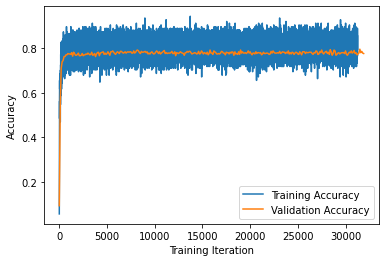

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()